# Stress Detection using Wearable Devices to Enhance Well-Being | Data Analysis

ID Tim: CC25-CR439

## Informasi Dataset

🧠 **Ringkasan**

WESAD (WEarable Stress And Affect Detection) adalah dataset multimodal yang digunakan untuk mendeteksi stres dan emosi menggunakan perangkat wearable. Data dikumpulkan dari dua perangkat: RespiBAN (dikenakan di dada) dan Empatica E4 (dikenakan di pergelangan tangan). Dataset ini dirancang untuk mendukung penelitian dalam bidang affective computing, kesehatan mental, dan machine learning.

👨‍🔬 **Informasi Umum**

- Jumlah subjek: 17 (data dari 2 subjek tidak tersedia karena malfungsi sensor)
- Perangkat:
    - RespiBAN Professional (sensor di dada, sampling 700 Hz)
    - Empatica E4 (sensor di pergelangan tangan, bermacam-macam sampling rate)
- File utama:
    - SX_readme.txt: deskripsi per subjek
    - SX_quest.csv: informasi protokol dan kuesioner
    - SX_respiban.txt: data mentah dari RespiBAN
    - SX_E4_Data (Folder): data mentah dari Empatica E4
    - SX.pkl: data yang telah disinkronisasi

🧪 **Data Sensor**

**RespiBAN (Dada)**
- Sampling rate: 700hz
- Sensor: ACC (accelerometer), ECG, EDA, EMG, RESP, TEMP
- Format: file .txt dengan 10 kolom (1 = nomor baris, 2 = abaikan, 3-10 = data sensor)

**Empatica E4 (Pergelangan Tangan)**
- Sensor: ACC (accelerometer), BVP (blood volume pulse), EDA (electrodermal activity), TEMP (temperatur)
- Sampling rate bervariasi:
    - ACC.csv: 32 Hz (akselerometer 3 sumbu, satuan 1/64g)
    - BVP.csv: 64 Hz (photoplethysmograph/PPG)
    - EDA.csv: 4 Hz (μS)
    - TEMP.csv: 4 Hz (°C)

🏷️ **Label dan Ground Truth**
- Tersedia label eksperimen:
    - 0 = tidak terdefinisi/transien
    - 1 = baseline
    - 2 = stres
    - 3 = senang (amusement)
    - 4 = meditasi
- Kuesioner self-report: PANAS, STAI, SAM, SSSQ

---

**Pada projek ini hanya akan digunakan data dari perangkat yang digunakan pada pergelangan tangan (Empatica E4), dan data dari sensor EDA akan ditinggalkan, hal ini dilakukan untuk sebisa mungkin mendekati kemampuan yang dimiliki oleh smartwatch konvensional**

## Import library

In [1]:
!pip install neurokit2 PyWavelets --quiet


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [3]:
dataset_dir = "/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/"
sampling_rate = {'ACC' : 32, 'BVP' : 64,'TEMP' : 4, 'LABEL' : 700, 'TARGET' : 4}

## Data Loading

Pertama-tama akan dimuat data dari satu subjek terlebih dahulu (subjek 2) untuk mengetahui terlebih dahulu cara memproses data per subjek, kemudian baru menggabungkan data dari semua subjek.

In [4]:
# memuat data subjek 2
with open(dataset_dir+'S2/S2.pkl', 'rb') as f:
    s2_data = pickle.load(f, encoding='latin1')

type(s2_data)

dict

In [5]:
# melihat daftar keys yang ada pada data dan melihat isinya
print(s2_data.keys())

for key in s2_data.keys():
    print(s2_data[key])

dict_keys(['signal', 'label', 'subject'])
{'chest': {'ACC': array([[ 0.95539999, -0.222     , -0.55799997],
       [ 0.92579997, -0.2216    , -0.55379999],
       [ 0.90820003, -0.21960002, -0.53920001],
       ...,
       [ 0.87179995, -0.12379998, -0.30419999],
       [ 0.87300003, -0.12339997, -0.30260003],
       [ 0.87020004, -0.12199998, -0.30220002]]), 'ECG': array([[ 0.02142334],
       [ 0.02032471],
       [ 0.01652527],
       ...,
       [-0.00544739],
       [ 0.00013733],
       [ 0.0040741 ]]), 'EMG': array([[-0.00444031],
       [ 0.00434875],
       [ 0.00517273],
       ...,
       [-0.01716614],
       [-0.02897644],
       [-0.02357483]]), 'EDA': array([[5.25054932],
       [5.26733398],
       [5.24330139],
       ...,
       [0.36048889],
       [0.36582947],
       [0.365448  ]]), 'Temp': array([[30.120758],
       [30.129517],
       [30.138214],
       ...,
       [31.459229],
       [31.484283],
       [31.456268]], dtype=float32), 'Resp': array([[-1.14898682]

In [6]:
# melihat keys pada 'signal' dan melihat isinya
print(s2_data['signal'].keys())

for key in s2_data['signal'].keys():
    print(s2_data['signal'][key])

dict_keys(['chest', 'wrist'])
{'ACC': array([[ 0.95539999, -0.222     , -0.55799997],
       [ 0.92579997, -0.2216    , -0.55379999],
       [ 0.90820003, -0.21960002, -0.53920001],
       ...,
       [ 0.87179995, -0.12379998, -0.30419999],
       [ 0.87300003, -0.12339997, -0.30260003],
       [ 0.87020004, -0.12199998, -0.30220002]]), 'ECG': array([[ 0.02142334],
       [ 0.02032471],
       [ 0.01652527],
       ...,
       [-0.00544739],
       [ 0.00013733],
       [ 0.0040741 ]]), 'EMG': array([[-0.00444031],
       [ 0.00434875],
       [ 0.00517273],
       ...,
       [-0.01716614],
       [-0.02897644],
       [-0.02357483]]), 'EDA': array([[5.25054932],
       [5.26733398],
       [5.24330139],
       ...,
       [0.36048889],
       [0.36582947],
       [0.365448  ]]), 'Temp': array([[30.120758],
       [30.129517],
       [30.138214],
       ...,
       [31.459229],
       [31.484283],
       [31.456268]], dtype=float32), 'Resp': array([[-1.14898682],
       [-1.12457275]

In [7]:
s2_wrist = s2_data['signal']['wrist']
for key in s2_wrist.keys():
    print(key)
    print(s2_wrist[key])

ACC
[[ 62. -21. 107.]
 [ 66.  13.  53.]
 [ 41.   9.  15.]
 ...
 [ 41.  25.  11.]
 [ 39.  27.  22.]
 [ 56.  26.  10.]]
BVP
[[-59.37]
 [-53.42]
 [-44.4 ]
 ...
 [ 18.26]
 [ 18.68]
 [ 19.71]]
EDA
[[1.138257]
 [1.125444]
 [1.011405]
 ...
 [0.059208]
 [0.073303]
 [0.045113]]
TEMP
[[35.41]
 [35.41]
 [35.41]
 ...
 [34.23]
 [34.23]
 [34.23]]


Karena kita telah mengetahui struktur dari data awal, maka selanjutnya kita akan melanjutkan proses dengan menggabungkan data dari semua subjek

In [8]:
# =============================================================================
# Fungsi-fungsi untuk Mendapatkan Fitur dari Setiap Sinyal
# =============================================================================

def get_acc_features(acc_raw, sampling_rate=32, window_size=5, window_shift=0.25):
    """
    Mengekstrak fitur statistik dari data Akselerometer (ACC) 3-sumbu 
    menggunakan metode sliding window.
    """
    # Menyiapkan list kosong untuk menampung kamus (dictionary) fitur dari setiap window
    features_list = []
    # Mengonversi ukuran dan pergeseran window dari detik ke jumlah sampel
    window_size_samples = int(window_size * sampling_rate)
    window_shift_samples = int(window_shift * sampling_rate)
    
    # Membuat iterator untuk perulangan sliding window
    windows_iterator = range(0, len(acc_raw) - window_size_samples, window_shift_samples)
    for start in windows_iterator:
        end = start + window_size_samples
        # Mengambil satu segmen/window data
        window = acc_raw[start:end]
        
        # Menetapkan timestamp pada akhir window untuk tujuan penyelarasan
        timestamp = end / sampling_rate
        features = {'timestamp': timestamp}
        
        # Menghitung fitur statistik (mean, std, min, max) untuk setiap sumbu (x, y, z)
        for i, axis in enumerate(['x', 'y', 'z']):
            features[f'acc_mean_{axis}'] = window[:, i].mean()
            features[f'acc_std_{axis}'] = window[:, i].std()
            features[f'acc_min_{axis}'] = window[:, i].min()
            features[f'acc_max_{axis}'] = window[:, i].max()
            
        # Menghitung magnitudo untuk merepresentasikan total pergerakan tanpa memandang arah
        magnitude = np.sqrt((window**2).sum(axis=1))
        features['acc_mean_mag'] = magnitude.mean()
        features['acc_std_mag'] = magnitude.std()
        
        # Menambahkan kamus fitur dari window ini ke dalam list
        features_list.append(features)
        
    # Mengembalikan hasil sebagai sebuah pandas DataFrame
    return pd.DataFrame(features_list)

def get_bvp_features(bvp_raw, subject_id, sampling_rate=64, window_size=60, window_shift=0.25, position=0):
    """
    Mengekstrak fitur Heart Rate Variability (HRV) dari sinyal BVP mentah.
    Fungsi ini tangguh terhadap sinyal bising dan bisa menampilkan progres.
    """
    features_list = []
    window_size_samples = int(window_size * sampling_rate)
    window_shift_samples = int(window_shift * sampling_rate)
    windows_iterator = range(0, len(bvp_raw) - window_size_samples, window_shift_samples)
    total_windows = len(windows_iterator)

    # Loop melalui setiap window data BVP
    for i, start in enumerate(windows_iterator, 1):
        # Menampilkan progres hanya untuk proses utama (posisi 0) agar terminal tidak berantakan
        if position == 0:
            print(f"Processing BVP S{subject_id}: {i}/{total_windows}", end='\r')
            sys.stdout.flush()
        
        end = start + window_size_samples
        window = bvp_raw[start:end].flatten()
        timestamp = end / sampling_rate
        features = {'timestamp': timestamp}

        # Menggunakan blok try-except untuk menangani window dengan sinyal buruk/bising
        try:
            # Memproses sinyal BVP untuk membersihkan dan mendeteksi puncak detak jantung
            ppg_signals, info = nk.ppg_process(window, sampling_rate=sampling_rate)
            peaks = info["PPG_Peaks"]

            # Memastikan ada cukup puncak detak jantung (>5) untuk perhitungan HRV yang valid
            if len(peaks) > 5:
                # Mengekstrak metrik HRV dari domain waktu dan frekuensi
                hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_rate, show=False)
                hrv_freq = nk.hrv_frequency(peaks, sampling_rate=sampling_rate, show=False)

                # Menghitung denyut per menit (BPM) dari rata-rata interval antar detak (NN)
                mean_nn = hrv_time["HRV_MeanNN"].iloc[0]
                features['bvp_mean_hr'] = 60000 / mean_nn 
                features['bvp_rmssd'] = hrv_time["HRV_RMSSD"].iloc[0]
                features['bvp_lf_hf_ratio'] = hrv_freq["HRV_LFHF"].iloc[0]
                # Menghitung standar deviasi detak jantung langsung dari sinyal laju PPG yang diproses
                features['bvp_std_hr'] = ppg_signals["PPG_Rate"].std()
            else:
                # Jika puncak tidak cukup, isi semua fitur BVP dengan nilai kosong (NaN)
                features.update({'bvp_mean_hr': np.nan, 'bvp_std_hr': np.nan, 'bvp_rmssd': np.nan, 'bvp_lf_hf_ratio': np.nan})
        except Exception as e:
            # Jika terjadi error apapun saat pemrosesan, cetak pesan error dan isi fitur dengan NaN
            print(f"\n!!! Error calculating HRV: {e}")
            features.update({'bvp_mean_hr': np.nan, 'bvp_std_hr': np.nan, 'bvp_rmssd': np.nan, 'bvp_lf_hf_ratio': np.nan})

        features_list.append(features)

    # Pindah baris setelah progress bar selesai agar tidak tertimpa output lain
    if position == 0:
        print()

    return pd.DataFrame(features_list)

def get_temp_features(temp_raw, sampling_rate=4, window_size=60, window_shift=0.25):
    """
    Mengekstrak fitur statistik dari data temperatur (TEMP).
    """
    features_list = []
    window_size_samples = int(window_size * sampling_rate)
    window_shift_samples = int(window_shift * sampling_rate)
    windows_iterator = range(0, len(temp_raw) - window_size_samples, window_shift_samples)
    
    for start in windows_iterator:
        end = start + window_size_samples
        window = temp_raw[start:end].flatten()
        timestamp = end / sampling_rate
        features = {'timestamp': timestamp}
        
        # Menghitung fitur statistik dasar
        features['temp_mean'] = window.mean()
        features['temp_std'] = window.std()
        features['temp_min'] = window.min()
        features['temp_max'] = window.max()
        
        # Menghitung slope (kemiringan) untuk mengetahui tren temperatur (naik/turun)
        x_axis = np.arange(len(window))
        slope, _ = np.polyfit(x_axis, window, 1)
        features['temp_slope'] = slope
        
        features_list.append(features)

    return pd.DataFrame(features_list)

# =============================================================================
# FUNGSI PEMROSESAN UTAMA (PER SUBJEK)
# =============================================================================
def process_single_subject(subject_info):
    """
    Fungsi worker yang akan dijalankan oleh setiap proses paralel.
    Memproses semua sinyal untuk satu subjek.
    """
    i, dataset_dir, position = subject_info
    print(f"--> Memulai pemrosesan untuk Subjek S{i}...")
    
    # Memuat data subjek dari file pickle
    with open(f'{dataset_dir}S{i}/S{i}.pkl', 'rb') as f:
        data = pickle.load(f, encoding='latin1')

    # Mengekstrak data mentah dari struktur data WESAD
    wrist_data = data['signal']['wrist']
    acc_raw = wrist_data['ACC']
    bvp_raw = wrist_data['BVP']
    temp_raw = wrist_data['TEMP']
    labels_raw = data['label'].flatten()
    label_sampling_rate = 700
    
    # Memanggil fungsi helper untuk mengekstrak fitur dari setiap modalitas
    df_acc = get_acc_features(acc_raw, sampling_rate=32)
    df_bvp = get_bvp_features(bvp_raw, subject_id=i, sampling_rate=64, position=position)
    df_temp = get_temp_features(temp_raw, sampling_rate=4)
    
    # Pemeriksaan keamanan: jika salah satu fitur gagal diekstrak, lewati subjek ini
    if df_acc.empty or df_bvp.empty or df_temp.empty:
        print(f"<-- PERINGATAN: Gagal mengekstrak fitur awal untuk Subjek S{i}. Melewati.")
        return pd.DataFrame()

    # Menggabungkan DataFrame fitur dari semua sinyal berdasarkan timestamp terdekat
    df_merged = pd.merge_asof(df_acc, df_bvp, on='timestamp', direction='nearest')
    df_merged = pd.merge_asof(df_merged, df_temp, on='timestamp', direction='nearest')

    # Mengisi nilai NaN yang mungkin muncul (misal dari BVP) dengan nilai valid terakhir/berikutnya
    df_merged.fillna(method='ffill', inplace=True) # Forward fill
    df_merged.fillna(method='bfill', inplace=True) # Backward fill
    
    # Fungsi helper untuk mencari label yang paling sering muncul (modus) dalam sebuah window
    def get_label_for_window(ts, window_sec, label_fs, all_labels):
        end_idx = int(ts * label_fs)
        start_idx = int((ts - window_sec) * label_fs)
        start_idx = max(0, start_idx)
        end_idx = min(len(all_labels), end_idx)
        if start_idx >= end_idx: return 0
        window_labels = all_labels[start_idx:end_idx]
        return np.bincount(window_labels).argmax()
        
    # Memberi label pada setiap baris fitur berdasarkan waktu
    feature_window_size = 60
    df_merged['label'] = df_merged['timestamp'].apply(
        lambda ts: get_label_for_window(ts, feature_window_size, label_sampling_rate, labels_raw)
    )
    df_merged['subject'] = i
    
    # Memfilter data, hanya menyimpan baris dengan label yang relevan (baseline, stress, amusement)
    rows_before_filter = len(df_merged)
    df_filtered = df_merged[df_merged['label'].isin([1, 2, 3])].copy()
    rows_after_filter = len(df_filtered)

    print(f"\n<-- Selesai S{i}. Awal: {rows_before_filter} baris. Akhir: {rows_after_filter} baris.")
    return df_filtered

def process_wesad(dataset_dir):
    """
    Fungsi utama yang mengatur dan menjalankan pemrosesan paralel untuk semua subjek.
    """
    subject_ids = [i for i in range(2, 18) if i != 12]
    # Menyiapkan daftar tugas, setiap tugas berisi info untuk satu subjek
    tasks = [(sub_id, dataset_dir, idx) for idx, sub_id in enumerate(subject_ids)]
    
    # Menentukan jumlah proses paralel, maksimal sebanyak core CPU
    num_processes = min(os.cpu_count(), len(tasks))
    print(f"Menggunakan {num_processes} core untuk pemrosesan paralel...")

    # Membuat pool proses dan mendistribusikan tugas
    with multiprocessing.Pool(processes=num_processes) as pool:
        list_of_dfs = pool.map(process_single_subject, tasks)
        
    print("\n--- SEMUA PROSES SELESAI ---")
    # Menggabungkan hasil dari semua proses menjadi satu DataFrame besar
    final_df = pd.concat(list_of_dfs, ignore_index=True)
    return final_df

In [9]:
df_final = process_wesad(dataset_dir)

Menggunakan 15 core untuk pemrosesan paralel...


--> Memulai pemrosesan untuk Subjek S2...

--> Memulai pemrosesan untuk Subjek S3...

--> Memulai pemrosesan untuk Subjek S4...

--> Memulai pemrosesan untuk Subjek S5...

--> Memulai pemrosesan untuk Subjek S6...

--> Memulai pemrosesan untuk Subjek S7...

--> Memulai pemrosesan untuk Subjek S8...

--> Memulai pemrosesan untuk Subjek S9...

--> Memulai pemrosesan untuk Subjek S10...

--> Memulai pemrosesan untuk Subjek S11...

--> Memulai pemrosesan untuk Subjek S13...

--> Memulai pemrosesan untuk Subjek S14...

--> Memulai pemrosesan untuk Subjek S15...

--> Memulai pemrosesan untuk Subjek S16...

--> Memulai pemrosesan untuk Subjek S17...

Processing BVP S2: 1/24076

Processing BVP S2: 2/24076

Processing BVP S2: 3/24076

Processing BVP S2: 4/24076

Processing BVP S2: 5/24076

Processing BVP S2: 6/24076

Processing BVP S2: 7/24076

Processing BVP S2: 8/24076

Processing BVP S2: 9/24076

Processing BVP S2: 10/24076

Processing BVP S2: 11/24076

Processing BVP S2: 12/24076

Processing BVP S2: 13/24076

Processing BVP S2: 14/24076

Processing BVP S2: 15/24076

Processing BVP S2: 16/24076

Processing BVP S2: 17/24076

Processing BVP S2: 18/24076

Processing BVP S2: 19/24076

Processing BVP S2: 20/24076

Processing BVP S2: 21/24076

Processing BVP S2: 22/24076

Processing BVP S2: 23/24076

Processing BVP S2: 24/24076

Processing BVP S2: 25/24076

Processing BVP S2: 26/24076

Processing BVP S2: 27/24076

Processing BVP S2: 28/24076

Processing BVP S2: 29/24076

Processing BVP S2: 30/24076

Processing BVP S2: 31/24076

Processing BVP S2: 32/24076

Processing BVP S2: 33/24076

Processing BVP S2: 34/24076

Processing BVP S2: 35/24076

Processing BVP S2: 36/24076

Processing BVP S2: 37/24076

Processing BVP S2: 38/24076

Processing BVP S2: 39/24076

Processing BVP S2: 40/24076

Processing BVP S2: 41/24076

Processing BVP S2: 42/24076

Processing BVP S2: 43/24076

Processing BVP S2: 44/24076

Processing BVP S2: 45/24076

Processing BVP S2: 46/24076

Processing BVP S2: 47/24076

Processing BVP S2: 48/24076

Processing BVP S2: 49/24076

Processing BVP S2: 50/24076

Processing BVP S2: 51/24076

Processing BVP S2: 52/24076

Processing BVP S2: 53/24076

Processing BVP S2: 54/24076

Processing BVP S2: 55/24076

Processing BVP S2: 56/24076

Processing BVP S2: 57/24076

Processing BVP S2: 58/24076

Processing BVP S2: 59/24076

Processing BVP S2: 60/24076

Processing BVP S2: 61/24076

Processing BVP S2: 62/24076

Processing BVP S2: 63/24076

Processing BVP S2: 64/24076

Processing BVP S2: 65/24076

Processing BVP S2: 66/24076

Processing BVP S2: 67/24076

Processing BVP S2: 68/24076

Processing BVP S2: 69/24076

Processing BVP S2: 70/24076

Processing BVP S2: 71/24076

Processing BVP S2: 72/24076

Processing BVP S2: 73/24076

Processing BVP S2: 74/24076

Processing BVP S2: 75/24076

Processing BVP S2: 76/24076

Processing BVP S2: 77/24076

Processing BVP S2: 78/24076

Processing BVP S2: 79/24076

Processing BVP S2: 80/24076

Processing BVP S2: 81/24076

Processing BVP S2: 82/24076

Processing BVP S2: 83/24076

Processing BVP S2: 84/24076

Processing BVP S2: 85/24076

Processing BVP S2: 86/24076

Processing BVP S2: 87/24076

Processing BVP S2: 88/24076

Processing BVP S2: 89/24076

Processing BVP S2: 90/24076

Processing BVP S2: 91/24076

Processing BVP S2: 92/24076

Processing BVP S2: 93/24076

Processing BVP S2: 94/24076

Processing BVP S2: 95/24076

Processing BVP S2: 96/24076

Processing BVP S2: 97/24076

Processing BVP S2: 98/24076

Processing BVP S2: 99/24076

Processing BVP S2: 100/24076

Processing BVP S2: 101/24076

Processing BVP S2: 102/24076

Processing BVP S2: 103/24076

Processing BVP S2: 104/24076

Processing BVP S2: 105/24076

Processing BVP S2: 106/24076

Processing BVP S2: 107/24076

Processing BVP S2: 108/24076

Processing BVP S2: 109/24076

Processing BVP S2: 110/24076

Processing BVP S2: 111/24076

Processing BVP S2: 112/24076

Processing BVP S2: 113/24076

Processing BVP S2: 114/24076

Processing BVP S2: 115/24076

Processing BVP S2: 116/24076

Processing BVP S2: 117/24076

Processing BVP S2: 118/24076

Processing BVP S2: 119/24076

Processing BVP S2: 120/24076

Processing BVP S2: 121/24076

Processing BVP S2: 122/24076

Processing BVP S2: 123/24076

Processing BVP S2: 124/24076

Processing BVP S2: 125/24076

Processing BVP S2: 126/24076

Processing BVP S2: 127/24076

Processing BVP S2: 128/24076

Processing BVP S2: 129/24076

Processing BVP S2: 130/24076

Processing BVP S2: 131/24076

Processing BVP S2: 132/24076

Processing BVP S2: 133/24076

Processing BVP S2: 134/24076

Processing BVP S2: 135/24076

Processing BVP S2: 136/24076

Processing BVP S2: 137/24076

Processing BVP S2: 138/24076

Processing BVP S2: 139/24076

Processing BVP S2: 140/24076

Processing BVP S2: 141/24076

Processing BVP S2: 142/24076

Processing BVP S2: 143/24076

Processing BVP S2: 144/24076

Processing BVP S2: 145/24076

Processing BVP S2: 146/24076

Processing BVP S2: 147/24076

Processing BVP S2: 148/24076

Processing BVP S2: 149/24076

Processing BVP S2: 150/24076

Processing BVP S2: 151/24076

Processing BVP S2: 152/24076

Processing BVP S2: 153/24076

Processing BVP S2: 154/24076

Processing BVP S2: 155/24076

Processing BVP S2: 156/24076

Processing BVP S2: 157/24076

Processing BVP S2: 158/24076

Processing BVP S2: 159/24076

Processing BVP S2: 160/24076

Processing BVP S2: 161/24076

Processing BVP S2: 162/24076

Processing BVP S2: 163/24076

Processing BVP S2: 164/24076

Processing BVP S2: 165/24076

Processing BVP S2: 166/24076

Processing BVP S2: 167/24076

Processing BVP S2: 168/24076

Processing BVP S2: 169/24076

Processing BVP S2: 170/24076

Processing BVP S2: 171/24076

Processing BVP S2: 172/24076

Processing BVP S2: 173/24076

Processing BVP S2: 174/24076

Processing BVP S2: 175/24076

Processing BVP S2: 176/24076

Processing BVP S2: 177/24076

Processing BVP S2: 178/24076

Processing BVP S2: 179/24076

Processing BVP S2: 180/24076

Processing BVP S2: 181/24076

Processing BVP S2: 182/24076

Processing BVP S2: 183/24076

Processing BVP S2: 184/24076

Processing BVP S2: 185/24076

Processing BVP S2: 186/24076

Processing BVP S2: 187/24076

Processing BVP S2: 188/24076

Processing BVP S2: 189/24076

Processing BVP S2: 190/24076

Processing BVP S2: 191/24076

Processing BVP S2: 192/24076

Processing BVP S2: 193/24076

Processing BVP S2: 194/24076

Processing BVP S2: 195/24076

Processing BVP S2: 196/24076

Processing BVP S2: 197/24076

Processing BVP S2: 198/24076

Processing BVP S2: 199/24076

Processing BVP S2: 200/24076

Processing BVP S2: 201/24076

Processing BVP S2: 202/24076

Processing BVP S2: 203/24076

Processing BVP S2: 204/24076

Processing BVP S2: 205/24076

Processing BVP S2: 206/24076

Processing BVP S2: 207/24076

Processing BVP S2: 208/24076

Processing BVP S2: 209/24076

Processing BVP S2: 210/24076

Processing BVP S2: 211/24076

Processing BVP S2: 212/24076

Processing BVP S2: 213/24076

Processing BVP S2: 214/24076

Processing BVP S2: 215/24076

Processing BVP S2: 216/24076

Processing BVP S2: 217/24076

Processing BVP S2: 218/24076

Processing BVP S2: 219/24076

Processing BVP S2: 220/24076

Processing BVP S2: 221/24076

Processing BVP S2: 222/24076

Processing BVP S2: 223/24076

Processing BVP S2: 224/24076

Processing BVP S2: 225/24076

Processing BVP S2: 226/24076

Processing BVP S2: 227/24076

Processing BVP S2: 228/24076

Processing BVP S2: 229/24076

Processing BVP S2: 230/24076

Processing BVP S2: 231/24076

Processing BVP S2: 232/24076

Processing BVP S2: 233/24076

Processing BVP S2: 234/24076

Processing BVP S2: 235/24076

Processing BVP S2: 236/24076

Processing BVP S2: 237/24076

Processing BVP S2: 238/24076

Processing BVP S2: 239/24076

Processing BVP S2: 240/24076

Processing BVP S2: 241/24076

Processing BVP S2: 242/24076

Processing BVP S2: 243/24076

Processing BVP S2: 244/24076

Processing BVP S2: 245/24076

Processing BVP S2: 246/24076

Processing BVP S2: 247/24076

Processing BVP S2: 248/24076

Processing BVP S2: 249/24076

Processing BVP S2: 250/24076

Processing BVP S2: 251/24076

Processing BVP S2: 252/24076

Processing BVP S2: 253/24076

Processing BVP S2: 254/24076

Processing BVP S2: 255/24076

Processing BVP S2: 256/24076

Processing BVP S2: 257/24076

Processing BVP S2: 258/24076

Processing BVP S2: 259/24076

Processing BVP S2: 260/24076

Processing BVP S2: 261/24076

Processing BVP S2: 262/24076

Processing BVP S2: 263/24076

Processing BVP S2: 264/24076

Processing BVP S2: 265/24076

Processing BVP S2: 266/24076

Processing BVP S2: 267/24076

Processing BVP S2: 268/24076

Processing BVP S2: 269/24076

Processing BVP S2: 270/24076

Processing BVP S2: 271/24076

Processing BVP S2: 272/24076

Processing BVP S2: 273/24076

Processing BVP S2: 274/24076

Processing BVP S2: 275/24076

Processing BVP S2: 276/24076

Processing BVP S2: 277/24076

Processing BVP S2: 278/24076

Processing BVP S2: 279/24076

Processing BVP S2: 280/24076

Processing BVP S2: 281/24076

Processing BVP S2: 282/24076

Processing BVP S2: 283/24076

Processing BVP S2: 284/24076

Processing BVP S2: 285/24076

Processing BVP S2: 286/24076

Processing BVP S2: 287/24076

Processing BVP S2: 288/24076

Processing BVP S2: 289/24076

Processing BVP S2: 290/24076

Processing BVP S2: 291/24076

Processing BVP S2: 292/24076

Processing BVP S2: 293/24076

Processing BVP S2: 294/24076

Processing BVP S2: 295/24076

Processing BVP S2: 296/24076

Processing BVP S2: 297/24076

Processing BVP S2: 298/24076

Processing BVP S2: 299/24076

Processing BVP S2: 300/24076

Processing BVP S2: 301/24076

Processing BVP S2: 302/24076

Processing BVP S2: 303/24076

Processing BVP S2: 304/24076

Processing BVP S2: 305/24076

Processing BVP S2: 306/24076

Processing BVP S2: 307/24076

Processing BVP S2: 308/24076

Processing BVP S2: 309/24076

Processing BVP S2: 310/24076

Processing BVP S2: 311/24076

Processing BVP S2: 312/24076

Processing BVP S2: 313/24076

Processing BVP S2: 314/24076

Processing BVP S2: 315/24076

Processing BVP S2: 316/24076

Processing BVP S2: 317/24076

Processing BVP S2: 318/24076

Processing BVP S2: 319/24076

Processing BVP S2: 320/24076

Processing BVP S2: 321/24076

Processing BVP S2: 322/24076

Processing BVP S2: 323/24076

Processing BVP S2: 324/24076

Processing BVP S2: 325/24076

Processing BVP S2: 326/24076

Processing BVP S2: 327/24076

Processing BVP S2: 328/24076

Processing BVP S2: 329/24076

Processing BVP S2: 330/24076

Processing BVP S2: 331/24076

Processing BVP S2: 332/24076

Processing BVP S2: 333/24076

Processing BVP S2: 334/24076

Processing BVP S2: 335/24076

Processing BVP S2: 336/24076

Processing BVP S2: 337/24076

Processing BVP S2: 338/24076

Processing BVP S2: 339/24076

Processing BVP S2: 340/24076

Processing BVP S2: 341/24076

Processing BVP S2: 342/24076

Processing BVP S2: 343/24076

Processing BVP S2: 344/24076

Processing BVP S2: 345/24076

Processing BVP S2: 346/24076

Processing BVP S2: 347/24076

Processing BVP S2: 348/24076

Processing BVP S2: 349/24076

Processing BVP S2: 350/24076

Processing BVP S2: 351/24076

Processing BVP S2: 352/24076

Processing BVP S2: 353/24076

Processing BVP S2: 354/24076

Processing BVP S2: 355/24076

Processing BVP S2: 356/24076

Processing BVP S2: 357/24076

Processing BVP S2: 358/24076

Processing BVP S2: 359/24076

Processing BVP S2: 360/24076

Processing BVP S2: 361/24076

Processing BVP S2: 362/24076

Processing BVP S2: 363/24076

Processing BVP S2: 364/24076

Processing BVP S2: 365/24076

Processing BVP S2: 366/24076

Processing BVP S2: 367/24076

Processing BVP S2: 368/24076

Processing BVP S2: 369/24076

Processing BVP S2: 370/24076

Processing BVP S2: 371/24076

Processing BVP S2: 372/24076

Processing BVP S2: 373/24076

Processing BVP S2: 374/24076

Processing BVP S2: 375/24076

Processing BVP S2: 376/24076

Processing BVP S2: 377/24076

Processing BVP S2: 378/24076

Processing BVP S2: 379/24076

Processing BVP S2: 380/24076

Processing BVP S2: 381/24076

Processing BVP S2: 382/24076

Processing BVP S2: 383/24076

Processing BVP S2: 384/24076

Processing BVP S2: 385/24076

Processing BVP S2: 386/24076

Processing BVP S2: 387/24076

Processing BVP S2: 388/24076

Processing BVP S2: 389/24076

Processing BVP S2: 390/24076

Processing BVP S2: 391/24076

Processing BVP S2: 392/24076

Processing BVP S2: 393/24076

Processing BVP S2: 394/24076

Processing BVP S2: 395/24076

Processing BVP S2: 396/24076

Processing BVP S2: 397/24076

Processing BVP S2: 398/24076

Processing BVP S2: 399/24076

Processing BVP S2: 400/24076

Processing BVP S2: 401/24076

Processing BVP S2: 402/24076

Processing BVP S2: 403/24076

Processing BVP S2: 404/24076

Processing BVP S2: 405/24076

Processing BVP S2: 406/24076

Processing BVP S2: 407/24076

Processing BVP S2: 408/24076

Processing BVP S2: 409/24076

Processing BVP S2: 410/24076

Processing BVP S2: 411/24076

Processing BVP S2: 412/24076

Processing BVP S2: 413/24076

Processing BVP S2: 414/24076

Processing BVP S2: 415/24076

Processing BVP S2: 416/24076

Processing BVP S2: 417/24076

Processing BVP S2: 418/24076

Processing BVP S2: 419/24076

Processing BVP S2: 420/24076

Processing BVP S2: 421/24076

Processing BVP S2: 422/24076

Processing BVP S2: 423/24076

Processing BVP S2: 424/24076

Processing BVP S2: 425/24076

Processing BVP S2: 426/24076

Processing BVP S2: 427/24076

Processing BVP S2: 428/24076

Processing BVP S2: 429/24076

Processing BVP S2: 430/24076

Processing BVP S2: 431/24076

Processing BVP S2: 432/24076

Processing BVP S2: 433/24076

Processing BVP S2: 434/24076

Processing BVP S2: 435/24076

Processing BVP S2: 436/24076

Processing BVP S2: 437/24076

Processing BVP S2: 438/24076

Processing BVP S2: 439/24076

Processing BVP S2: 440/24076

Processing BVP S2: 441/24076

Processing BVP S2: 442/24076

Processing BVP S2: 443/24076

Processing BVP S2: 444/24076

Processing BVP S2: 445/24076

Processing BVP S2: 446/24076

Processing BVP S2: 447/24076

Processing BVP S2: 448/24076

Processing BVP S2: 449/24076

Processing BVP S2: 450/24076

Processing BVP S2: 451/24076

Processing BVP S2: 452/24076

Processing BVP S2: 453/24076

Processing BVP S2: 454/24076

Processing BVP S2: 455/24076

Processing BVP S2: 456/24076

Processing BVP S2: 457/24076

Processing BVP S2: 458/24076

Processing BVP S2: 459/24076

Processing BVP S2: 460/24076

Processing BVP S2: 461/24076

Processing BVP S2: 462/24076

Processing BVP S2: 463/24076

Processing BVP S2: 464/24076

Processing BVP S2: 465/24076

Processing BVP S2: 466/24076

Processing BVP S2: 467/24076

Processing BVP S2: 468/24076

Processing BVP S2: 469/24076

Processing BVP S2: 470/24076

Processing BVP S2: 471/24076

Processing BVP S2: 472/24076

Processing BVP S2: 473/24076

Processing BVP S2: 474/24076

Processing BVP S2: 475/24076

Processing BVP S2: 476/24076

Processing BVP S2: 477/24076

Processing BVP S2: 478/24076

Processing BVP S2: 479/24076

Processing BVP S2: 480/24076

Processing BVP S2: 481/24076

Processing BVP S2: 482/24076

Processing BVP S2: 483/24076

Processing BVP S2: 484/24076

Processing BVP S2: 485/24076

Processing BVP S2: 486/24076

Processing BVP S2: 487/24076

Processing BVP S2: 488/24076

Processing BVP S2: 489/24076

Processing BVP S2: 490/24076

Processing BVP S2: 491/24076

Processing BVP S2: 492/24076

Processing BVP S2: 493/24076

Processing BVP S2: 494/24076

Processing BVP S2: 495/24076

Processing BVP S2: 496/24076

Processing BVP S2: 497/24076

Processing BVP S2: 498/24076

Processing BVP S2: 499/24076

Processing BVP S2: 500/24076

Processing BVP S2: 501/24076

Processing BVP S2: 502/24076

Processing BVP S2: 503/24076

Processing BVP S2: 504/24076

Processing BVP S2: 505/24076

Processing BVP S2: 506/24076

Processing BVP S2: 507/24076

Processing BVP S2: 508/24076

Processing BVP S2: 509/24076

Processing BVP S2: 510/24076

Processing BVP S2: 511/24076

Processing BVP S2: 512/24076

Processing BVP S2: 513/24076

Processing BVP S2: 514/24076

Processing BVP S2: 515/24076

Processing BVP S2: 516/24076

Processing BVP S2: 517/24076

Processing BVP S2: 518/24076

Processing BVP S2: 519/24076

Processing BVP S2: 520/24076

Processing BVP S2: 521/24076

Processing BVP S2: 522/24076

Processing BVP S2: 523/24076

Processing BVP S2: 524/24076

Processing BVP S2: 525/24076

Processing BVP S2: 526/24076

Processing BVP S2: 527/24076

Processing BVP S2: 528/24076

Processing BVP S2: 529/24076

Processing BVP S2: 530/24076

Processing BVP S2: 531/24076

Processing BVP S2: 532/24076

Processing BVP S2: 533/24076

Processing BVP S2: 534/24076

Processing BVP S2: 535/24076

Processing BVP S2: 536/24076

Processing BVP S2: 537/24076

Processing BVP S2: 538/24076

Processing BVP S2: 539/24076

Processing BVP S2: 540/24076

Processing BVP S2: 541/24076

Processing BVP S2: 542/24076

Processing BVP S2: 543/24076

Processing BVP S2: 544/24076

Processing BVP S2: 545/24076

Processing BVP S2: 546/24076

Processing BVP S2: 547/24076

Processing BVP S2: 548/24076

Processing BVP S2: 549/24076

Processing BVP S2: 550/24076

Processing BVP S2: 551/24076

Processing BVP S2: 552/24076

Processing BVP S2: 553/24076

Processing BVP S2: 554/24076

Processing BVP S2: 555/24076

Processing BVP S2: 556/24076

Processing BVP S2: 557/24076

Processing BVP S2: 558/24076

Processing BVP S2: 559/24076

Processing BVP S2: 560/24076

Processing BVP S2: 561/24076

Processing BVP S2: 562/24076

Processing BVP S2: 563/24076

Processing BVP S2: 564/24076

Processing BVP S2: 565/24076

Processing BVP S2: 566/24076

Processing BVP S2: 567/24076

Processing BVP S2: 568/24076

Processing BVP S2: 569/24076

Processing BVP S2: 570/24076

Processing BVP S2: 571/24076

Processing BVP S2: 572/24076

Processing BVP S2: 573/24076

Processing BVP S2: 574/24076

Processing BVP S2: 575/24076

Processing BVP S2: 576/24076

Processing BVP S2: 577/24076

Processing BVP S2: 578/24076

Processing BVP S2: 579/24076

Processing BVP S2: 580/24076

Processing BVP S2: 581/24076

Processing BVP S2: 582/24076

Processing BVP S2: 583/24076

Processing BVP S2: 584/24076

Processing BVP S2: 585/24076

Processing BVP S2: 586/24076

Processing BVP S2: 587/24076

Processing BVP S2: 588/24076

Processing BVP S2: 589/24076

Processing BVP S2: 590/24076

Processing BVP S2: 591/24076

Processing BVP S2: 592/24076

Processing BVP S2: 593/24076

Processing BVP S2: 594/24076

Processing BVP S2: 595/24076

Processing BVP S2: 596/24076

Processing BVP S2: 597/24076

Processing BVP S2: 598/24076

Processing BVP S2: 599/24076

Processing BVP S2: 600/24076

Processing BVP S2: 601/24076

Processing BVP S2: 602/24076

Processing BVP S2: 603/24076

Processing BVP S2: 604/24076

Processing BVP S2: 605/24076

Processing BVP S2: 606/24076

Processing BVP S2: 607/24076

Processing BVP S2: 608/24076

Processing BVP S2: 609/24076

Processing BVP S2: 610/24076

Processing BVP S2: 611/24076

Processing BVP S2: 612/24076

Processing BVP S2: 613/24076

Processing BVP S2: 614/24076

Processing BVP S2: 615/24076

Processing BVP S2: 616/24076

Processing BVP S2: 617/24076

Processing BVP S2: 618/24076

Processing BVP S2: 619/24076

Processing BVP S2: 620/24076

Processing BVP S2: 621/24076

Processing BVP S2: 622/24076

Processing BVP S2: 623/24076

Processing BVP S2: 624/24076

Processing BVP S2: 625/24076

Processing BVP S2: 626/24076

Processing BVP S2: 627/24076

Processing BVP S2: 628/24076

Processing BVP S2: 629/24076

Processing BVP S2: 630/24076

Processing BVP S2: 631/24076

Processing BVP S2: 632/24076

Processing BVP S2: 633/24076

Processing BVP S2: 634/24076

Processing BVP S2: 635/24076

Processing BVP S2: 636/24076

Processing BVP S2: 637/24076

Processing BVP S2: 638/24076

Processing BVP S2: 639/24076

Processing BVP S2: 640/24076

Processing BVP S2: 641/24076

Processing BVP S2: 642/24076

Processing BVP S2: 643/24076

Processing BVP S2: 644/24076

Processing BVP S2: 645/24076

Processing BVP S2: 646/24076

Processing BVP S2: 647/24076

Processing BVP S2: 648/24076

Processing BVP S2: 649/24076

Processing BVP S2: 650/24076

Processing BVP S2: 651/24076

Processing BVP S2: 652/24076

Processing BVP S2: 653/24076

Processing BVP S2: 654/24076

Processing BVP S2: 655/24076

Processing BVP S2: 656/24076

Processing BVP S2: 657/24076

Processing BVP S2: 658/24076

Processing BVP S2: 659/24076

Processing BVP S2: 660/24076

Processing BVP S2: 661/24076

Processing BVP S2: 662/24076

Processing BVP S2: 663/24076

Processing BVP S2: 664/24076

Processing BVP S2: 665/24076

Processing BVP S2: 666/24076

Processing BVP S2: 667/24076

Processing BVP S2: 668/24076

Processing BVP S2: 669/24076

Processing BVP S2: 670/24076

Processing BVP S2: 671/24076

Processing BVP S2: 672/24076

Processing BVP S2: 673/24076

Processing BVP S2: 674/24076

Processing BVP S2: 675/24076

Processing BVP S2: 676/24076

Processing BVP S2: 677/24076

Processing BVP S2: 678/24076

Processing BVP S2: 679/24076

Processing BVP S2: 680/24076

Processing BVP S2: 681/24076

Processing BVP S2: 682/24076

Processing BVP S2: 683/24076

Processing BVP S2: 684/24076

Processing BVP S2: 685/24076

Processing BVP S2: 686/24076

Processing BVP S2: 687/24076

Processing BVP S2: 688/24076

Processing BVP S2: 689/24076

Processing BVP S2: 690/24076

Processing BVP S2: 691/24076

Processing BVP S2: 692/24076

Processing BVP S2: 693/24076

Processing BVP S2: 694/24076

Processing BVP S2: 695/24076

Processing BVP S2: 696/24076

Processing BVP S2: 697/24076

Processing BVP S2: 698/24076

Processing BVP S2: 699/24076

Processing BVP S2: 700/24076

Processing BVP S2: 701/24076

Processing BVP S2: 702/24076

Processing BVP S2: 703/24076

Processing BVP S2: 704/24076

Processing BVP S2: 705/24076

Processing BVP S2: 706/24076

Processing BVP S2: 707/24076

Processing BVP S2: 708/24076

Processing BVP S2: 709/24076

Processing BVP S2: 710/24076

Processing BVP S2: 711/24076

Processing BVP S2: 712/24076

Processing BVP S2: 713/24076

Processing BVP S2: 714/24076

Processing BVP S2: 715/24076

Processing BVP S2: 716/24076

Processing BVP S2: 717/24076

Processing BVP S2: 718/24076

Processing BVP S2: 719/24076

Processing BVP S2: 720/24076

Processing BVP S2: 721/24076

Processing BVP S2: 722/24076

Processing BVP S2: 723/24076

Processing BVP S2: 724/24076

Processing BVP S2: 725/24076

Processing BVP S2: 726/24076

Processing BVP S2: 727/24076

Processing BVP S2: 728/24076

Processing BVP S2: 729/24076

Processing BVP S2: 730/24076

Processing BVP S2: 731/24076

Processing BVP S2: 732/24076

Processing BVP S2: 733/24076

Processing BVP S2: 734/24076

Processing BVP S2: 735/24076

Processing BVP S2: 736/24076

Processing BVP S2: 737/24076

Processing BVP S2: 738/24076

Processing BVP S2: 739/24076

Processing BVP S2: 740/24076

Processing BVP S2: 741/24076

Processing BVP S2: 742/24076

Processing BVP S2: 743/24076

Processing BVP S2: 744/24076

Processing BVP S2: 745/24076

Processing BVP S2: 746/24076

Processing BVP S2: 747/24076

Processing BVP S2: 748/24076

Processing BVP S2: 749/24076

Processing BVP S2: 750/24076

Processing BVP S2: 751/24076

Processing BVP S2: 752/24076

Processing BVP S2: 753/24076

Processing BVP S2: 754/24076

Processing BVP S2: 755/24076

Processing BVP S2: 756/24076

Processing BVP S2: 757/24076

Processing BVP S2: 758/24076

Processing BVP S2: 759/24076

Processing BVP S2: 760/24076

Processing BVP S2: 761/24076

Processing BVP S2: 762/24076

Processing BVP S2: 763/24076

Processing BVP S2: 764/24076

Processing BVP S2: 765/24076

Processing BVP S2: 766/24076

Processing BVP S2: 767/24076

Processing BVP S2: 768/24076

Processing BVP S2: 769/24076

Processing BVP S2: 770/24076

Processing BVP S2: 771/24076

Processing BVP S2: 772/24076

Processing BVP S2: 773/24076

Processing BVP S2: 774/24076

Processing BVP S2: 775/24076

Processing BVP S2: 776/24076

Processing BVP S2: 777/24076

Processing BVP S2: 778/24076

Processing BVP S2: 779/24076

Processing BVP S2: 780/24076

Processing BVP S2: 781/24076

Processing BVP S2: 782/24076

Processing BVP S2: 783/24076

Processing BVP S2: 784/24076

Processing BVP S2: 785/24076

Processing BVP S2: 786/24076

Processing BVP S2: 787/24076

Processing BVP S2: 788/24076

Processing BVP S2: 789/24076

Processing BVP S2: 790/24076

Processing BVP S2: 791/24076

Processing BVP S2: 792/24076

Processing BVP S2: 793/24076

Processing BVP S2: 794/24076

Processing BVP S2: 795/24076

Processing BVP S2: 796/24076

Processing BVP S2: 797/24076

Processing BVP S2: 798/24076

Processing BVP S2: 799/24076

Processing BVP S2: 800/24076

Processing BVP S2: 801/24076

Processing BVP S2: 802/24076

Processing BVP S2: 803/24076

Processing BVP S2: 804/24076

Processing BVP S2: 805/24076

Processing BVP S2: 806/24076

Processing BVP S2: 807/24076

Processing BVP S2: 808/24076

Processing BVP S2: 809/24076

Processing BVP S2: 810/24076

Processing BVP S2: 811/24076

Processing BVP S2: 812/24076

Processing BVP S2: 813/24076

Processing BVP S2: 814/24076

Processing BVP S2: 815/24076

Processing BVP S2: 816/24076

Processing BVP S2: 817/24076

Processing BVP S2: 818/24076

Processing BVP S2: 819/24076

Processing BVP S2: 820/24076

Processing BVP S2: 821/24076

Processing BVP S2: 822/24076

Processing BVP S2: 823/24076

Processing BVP S2: 824/24076

Processing BVP S2: 825/24076

Processing BVP S2: 826/24076

Processing BVP S2: 827/24076

Processing BVP S2: 828/24076

Processing BVP S2: 829/24076

Processing BVP S2: 830/24076

Processing BVP S2: 831/24076

Processing BVP S2: 832/24076

Processing BVP S2: 833/24076

Processing BVP S2: 834/24076

Processing BVP S2: 835/24076

Processing BVP S2: 836/24076

Processing BVP S2: 837/24076

Processing BVP S2: 838/24076

Processing BVP S2: 839/24076

Processing BVP S2: 840/24076

Processing BVP S2: 841/24076

Processing BVP S2: 842/24076

Processing BVP S2: 843/24076

Processing BVP S2: 844/24076

Processing BVP S2: 845/24076

Processing BVP S2: 846/24076

Processing BVP S2: 847/24076

Processing BVP S2: 848/24076

Processing BVP S2: 849/24076

Processing BVP S2: 850/24076

Processing BVP S2: 851/24076

Processing BVP S2: 852/24076

Processing BVP S2: 853/24076

Processing BVP S2: 854/24076

Processing BVP S2: 855/24076

Processing BVP S2: 856/24076

Processing BVP S2: 857/24076

Processing BVP S2: 858/24076

Processing BVP S2: 859/24076

Processing BVP S2: 860/24076

Processing BVP S2: 861/24076

Processing BVP S2: 862/24076

Processing BVP S2: 863/24076

Processing BVP S2: 864/24076

Processing BVP S2: 865/24076

Processing BVP S2: 866/24076

Processing BVP S2: 867/24076

Processing BVP S2: 868/24076

Processing BVP S2: 869/24076

Processing BVP S2: 870/24076

Processing BVP S2: 871/24076

Processing BVP S2: 872/24076

Processing BVP S2: 873/24076

Processing BVP S2: 874/24076

Processing BVP S2: 875/24076

Processing BVP S2: 876/24076

Processing BVP S2: 877/24076

Processing BVP S2: 878/24076

Processing BVP S2: 879/24076

Processing BVP S2: 880/24076

Processing BVP S2: 881/24076

Processing BVP S2: 882/24076

Processing BVP S2: 883/24076

Processing BVP S2: 884/24076

Processing BVP S2: 885/24076

Processing BVP S2: 886/24076

Processing BVP S2: 887/24076

Processing BVP S2: 888/24076

Processing BVP S2: 889/24076

Processing BVP S2: 890/24076

Processing BVP S2: 891/24076

Processing BVP S2: 892/24076

Processing BVP S2: 893/24076

Processing BVP S2: 894/24076

Processing BVP S2: 895/24076

Processing BVP S2: 896/24076

Processing BVP S2: 897/24076

Processing BVP S2: 898/24076

Processing BVP S2: 899/24076

Processing BVP S2: 900/24076

Processing BVP S2: 901/24076

Processing BVP S2: 902/24076

Processing BVP S2: 903/24076

Processing BVP S2: 904/24076

Processing BVP S2: 905/24076

Processing BVP S2: 906/24076

Processing BVP S2: 907/24076

Processing BVP S2: 908/24076

Processing BVP S2: 909/24076

Processing BVP S2: 910/24076

Processing BVP S2: 911/24076

Processing BVP S2: 912/24076

Processing BVP S2: 913/24076

Processing BVP S2: 914/24076

Processing BVP S2: 915/24076

Processing BVP S2: 916/24076

Processing BVP S2: 917/24076

Processing BVP S2: 918/24076

Processing BVP S2: 919/24076

Processing BVP S2: 920/24076

Processing BVP S2: 921/24076

Processing BVP S2: 922/24076

Processing BVP S2: 923/24076

Processing BVP S2: 924/24076

Processing BVP S2: 925/24076

Processing BVP S2: 926/24076

Processing BVP S2: 927/24076

Processing BVP S2: 928/24076

Processing BVP S2: 929/24076

Processing BVP S2: 930/24076

Processing BVP S2: 931/24076

Processing BVP S2: 932/24076

Processing BVP S2: 933/24076

Processing BVP S2: 934/24076

Processing BVP S2: 935/24076

Processing BVP S2: 936/24076

Processing BVP S2: 937/24076

Processing BVP S2: 938/24076

Processing BVP S2: 939/24076

Processing BVP S2: 940/24076

Processing BVP S2: 941/24076

Processing BVP S2: 942/24076

Processing BVP S2: 943/24076

Processing BVP S2: 944/24076

Processing BVP S2: 945/24076

Processing BVP S2: 946/24076

Processing BVP S2: 947/24076

Processing BVP S2: 948/24076

Processing BVP S2: 949/24076

Processing BVP S2: 950/24076

Processing BVP S2: 951/24076

Processing BVP S2: 952/24076

Processing BVP S2: 953/24076

Processing BVP S2: 954/24076

Processing BVP S2: 955/24076

Processing BVP S2: 956/24076

Processing BVP S2: 957/24076

Processing BVP S2: 958/24076

Processing BVP S2: 959/24076

Processing BVP S2: 960/24076

Processing BVP S2: 961/24076

Processing BVP S2: 962/24076

Processing BVP S2: 963/24076

Processing BVP S2: 964/24076

Processing BVP S2: 965/24076

Processing BVP S2: 966/24076

Processing BVP S2: 967/24076

Processing BVP S2: 968/24076

Processing BVP S2: 969/24076

Processing BVP S2: 970/24076

Processing BVP S2: 971/24076

Processing BVP S2: 972/24076

Processing BVP S2: 973/24076

Processing BVP S2: 974/24076

Processing BVP S2: 975/24076

Processing BVP S2: 976/24076

Processing BVP S2: 977/24076

Processing BVP S2: 978/24076

Processing BVP S2: 979/24076

Processing BVP S2: 980/24076

Processing BVP S2: 981/24076

Processing BVP S2: 982/24076

Processing BVP S2: 983/24076

Processing BVP S2: 984/24076

Processing BVP S2: 985/24076

Processing BVP S2: 986/24076

Processing BVP S2: 987/24076

Processing BVP S2: 988/24076

Processing BVP S2: 989/24076

Processing BVP S2: 990/24076

Processing BVP S2: 991/24076

Processing BVP S2: 992/24076

Processing BVP S2: 993/24076

Processing BVP S2: 994/24076

Processing BVP S2: 995/24076

Processing BVP S2: 996/24076

Processing BVP S2: 997/24076

Processing BVP S2: 998/24076

Processing BVP S2: 999/24076

Processing BVP S2: 1000/24076

Processing BVP S2: 1001/24076

Processing BVP S2: 1002/24076

Processing BVP S2: 1003/24076

Processing BVP S2: 1004/24076

Processing BVP S2: 1005/24076

Processing BVP S2: 1006/24076

Processing BVP S2: 1007/24076

Processing BVP S2: 1008/24076

Processing BVP S2: 1009/24076

Processing BVP S2: 1010/24076

Processing BVP S2: 1011/24076

Processing BVP S2: 1012/24076

Processing BVP S2: 1013/24076

Processing BVP S2: 1014/24076

Processing BVP S2: 1015/24076

Processing BVP S2: 1016/24076

Processing BVP S2: 1017/24076

Processing BVP S2: 1018/24076

Processing BVP S2: 1019/24076

Processing BVP S2: 1020/24076

Processing BVP S2: 1021/24076

Processing BVP S2: 1022/24076

Processing BVP S2: 1023/24076

Processing BVP S2: 1024/24076

Processing BVP S2: 1025/24076

Processing BVP S2: 1026/24076

Processing BVP S2: 1027/24076

Processing BVP S2: 1028/24076

Processing BVP S2: 1029/24076

Processing BVP S2: 1030/24076

Processing BVP S2: 1031/24076

Processing BVP S2: 1032/24076

Processing BVP S2: 1033/24076

Processing BVP S2: 1034/24076

Processing BVP S2: 1035/24076

Processing BVP S2: 1036/24076

Processing BVP S2: 1037/24076

Processing BVP S2: 1038/24076

Processing BVP S2: 1039/24076

Processing BVP S2: 1040/24076

Processing BVP S2: 1041/24076

Processing BVP S2: 1042/24076

Processing BVP S2: 1043/24076

Processing BVP S2: 1044/24076

Processing BVP S2: 1045/24076

Processing BVP S2: 1046/24076

Processing BVP S2: 1047/24076

Processing BVP S2: 1048/24076

Processing BVP S2: 1049/24076

Processing BVP S2: 1050/24076

Processing BVP S2: 1051/24076

Processing BVP S2: 1052/24076

Processing BVP S2: 1053/24076

Processing BVP S2: 1054/24076

Processing BVP S2: 1055/24076

Processing BVP S2: 1056/24076

Processing BVP S2: 1057/24076

Processing BVP S2: 1058/24076

Processing BVP S2: 1059/24076

Processing BVP S2: 1060/24076

Processing BVP S2: 1061/24076

Processing BVP S2: 1062/24076

Processing BVP S2: 1063/24076

Processing BVP S2: 1064/24076

Processing BVP S2: 1065/24076

Processing BVP S2: 1066/24076

Processing BVP S2: 1067/24076

Processing BVP S2: 1068/24076

Processing BVP S2: 1069/24076

Processing BVP S2: 1070/24076

Processing BVP S2: 1071/24076

Processing BVP S2: 1072/24076

Processing BVP S2: 1073/24076

Processing BVP S2: 1074/24076

Processing BVP S2: 1075/24076

Processing BVP S2: 1076/24076

Processing BVP S2: 1077/24076

Processing BVP S2: 1078/24076

Processing BVP S2: 1079/24076

Processing BVP S2: 1080/24076

Processing BVP S2: 1081/24076

Processing BVP S2: 1082/24076

Processing BVP S2: 1083/24076

Processing BVP S2: 1084/24076

Processing BVP S2: 1085/24076

Processing BVP S2: 1086/24076

Processing BVP S2: 1087/24076

Processing BVP S2: 1088/24076

Processing BVP S2: 1089/24076

Processing BVP S2: 1090/24076

Processing BVP S2: 1091/24076

Processing BVP S2: 1092/24076

Processing BVP S2: 1093/24076

Processing BVP S2: 1094/24076

Processing BVP S2: 1095/24076

Processing BVP S2: 1096/24076

Processing BVP S2: 1097/24076

Processing BVP S2: 1098/24076

Processing BVP S2: 1099/24076

Processing BVP S2: 1100/24076

Processing BVP S2: 1101/24076

Processing BVP S2: 1102/24076

Processing BVP S2: 1103/24076

Processing BVP S2: 1104/24076

Processing BVP S2: 1105/24076

Processing BVP S2: 1106/24076

Processing BVP S2: 1107/24076

Processing BVP S2: 1108/24076

Processing BVP S2: 1109/24076

Processing BVP S2: 1110/24076

Processing BVP S2: 1111/24076

Processing BVP S2: 1112/24076

Processing BVP S2: 1113/24076

Processing BVP S2: 1114/24076

Processing BVP S2: 1115/24076

Processing BVP S2: 1116/24076

Processing BVP S2: 1117/24076

Processing BVP S2: 1118/24076

Processing BVP S2: 1119/24076

Processing BVP S2: 1120/24076

Processing BVP S2: 1121/24076

Processing BVP S2: 1122/24076

Processing BVP S2: 1123/24076

Processing BVP S2: 1124/24076

Processing BVP S2: 1125/24076

Processing BVP S2: 1126/24076

Processing BVP S2: 1127/24076

Processing BVP S2: 1128/24076

Processing BVP S2: 1129/24076

Processing BVP S2: 1130/24076

Processing BVP S2: 1131/24076

Processing BVP S2: 1132/24076

Processing BVP S2: 1133/24076

Processing BVP S2: 1134/24076

Processing BVP S2: 1135/24076

Processing BVP S2: 1136/24076

Processing BVP S2: 1137/24076

Processing BVP S2: 1138/24076

Processing BVP S2: 1139/24076

Processing BVP S2: 1140/24076

Processing BVP S2: 1141/24076

Processing BVP S2: 1142/24076

Processing BVP S2: 1143/24076

Processing BVP S2: 1144/24076

Processing BVP S2: 1145/24076

Processing BVP S2: 1146/24076

Processing BVP S2: 1147/24076

Processing BVP S2: 1148/24076

Processing BVP S2: 1149/24076

Processing BVP S2: 1150/24076

Processing BVP S2: 1151/24076

Processing BVP S2: 1152/24076

Processing BVP S2: 1153/24076

Processing BVP S2: 1154/24076

Processing BVP S2: 1155/24076

Processing BVP S2: 1156/24076

Processing BVP S2: 1157/24076

Processing BVP S2: 1158/24076

Processing BVP S2: 1159/24076

Processing BVP S2: 1160/24076

Processing BVP S2: 1161/24076

Processing BVP S2: 1162/24076

Processing BVP S2: 1163/24076

Processing BVP S2: 1164/24076

Processing BVP S2: 1165/24076

Processing BVP S2: 1166/24076

Processing BVP S2: 1167/24076

Processing BVP S2: 1168/24076

Processing BVP S2: 1169/24076

Processing BVP S2: 1170/24076

Processing BVP S2: 1171/24076

Processing BVP S2: 1172/24076

Processing BVP S2: 1173/24076

Processing BVP S2: 1174/24076

Processing BVP S2: 1175/24076

Processing BVP S2: 1176/24076

Processing BVP S2: 1177/24076

Processing BVP S2: 1178/24076

Processing BVP S2: 1179/24076

Processing BVP S2: 1180/24076

Processing BVP S2: 1181/24076

Processing BVP S2: 1182/24076

Processing BVP S2: 1183/24076

Processing BVP S2: 1184/24076

Processing BVP S2: 1185/24076

Processing BVP S2: 1186/24076

Processing BVP S2: 1187/24076

Processing BVP S2: 1188/24076

Processing BVP S2: 1189/24076

Processing BVP S2: 1190/24076

Processing BVP S2: 1191/24076

Processing BVP S2: 1192/24076

Processing BVP S2: 1193/24076

Processing BVP S2: 1194/24076

Processing BVP S2: 1195/24076

Processing BVP S2: 1196/24076

Processing BVP S2: 1197/24076

Processing BVP S2: 1198/24076

Processing BVP S2: 1199/24076

Processing BVP S2: 1200/24076

Processing BVP S2: 1201/24076

Processing BVP S2: 1202/24076

Processing BVP S2: 1203/24076

Processing BVP S2: 1204/24076

Processing BVP S2: 1205/24076

Processing BVP S2: 1206/24076

Processing BVP S2: 1207/24076

Processing BVP S2: 1208/24076

Processing BVP S2: 1209/24076

Processing BVP S2: 1210/24076

Processing BVP S2: 1211/24076

Processing BVP S2: 1212/24076

Processing BVP S2: 1213/24076

Processing BVP S2: 1214/24076

Processing BVP S2: 1215/24076

Processing BVP S2: 1216/24076

Processing BVP S2: 1217/24076

Processing BVP S2: 1218/24076

Processing BVP S2: 1219/24076

Processing BVP S2: 1220/24076

Processing BVP S2: 1221/24076

Processing BVP S2: 1222/24076

Processing BVP S2: 1223/24076

Processing BVP S2: 1224/24076

Processing BVP S2: 1225/24076

Processing BVP S2: 1226/24076

Processing BVP S2: 1227/24076

Processing BVP S2: 1228/24076

Processing BVP S2: 1229/24076

Processing BVP S2: 1230/24076

Processing BVP S2: 1231/24076

Processing BVP S2: 1232/24076

Processing BVP S2: 1233/24076

Processing BVP S2: 1234/24076

Processing BVP S2: 1235/24076

Processing BVP S2: 1236/24076

Processing BVP S2: 1237/24076

Processing BVP S2: 1238/24076

Processing BVP S2: 1239/24076

Processing BVP S2: 1240/24076

Processing BVP S2: 1241/24076

Processing BVP S2: 1242/24076

Processing BVP S2: 1243/24076

Processing BVP S2: 1244/24076

Processing BVP S2: 1245/24076

Processing BVP S2: 1246/24076

Processing BVP S2: 1247/24076

Processing BVP S2: 1248/24076

Processing BVP S2: 1249/24076

Processing BVP S2: 1250/24076

Processing BVP S2: 1251/24076

Processing BVP S2: 1252/24076

Processing BVP S2: 1253/24076

Processing BVP S2: 1254/24076

Processing BVP S2: 1255/24076

Processing BVP S2: 1256/24076

Processing BVP S2: 1257/24076

Processing BVP S2: 1258/24076

Processing BVP S2: 1259/24076

Processing BVP S2: 1260/24076

Processing BVP S2: 1261/24076

Processing BVP S2: 1262/24076

Processing BVP S2: 1263/24076

Processing BVP S2: 1264/24076

Processing BVP S2: 1265/24076

Processing BVP S2: 1266/24076

Processing BVP S2: 1267/24076

Processing BVP S2: 1268/24076

Processing BVP S2: 1269/24076

Processing BVP S2: 1270/24076

Processing BVP S2: 1271/24076

Processing BVP S2: 1272/24076

Processing BVP S2: 1273/24076

Processing BVP S2: 1274/24076

Processing BVP S2: 1275/24076

Processing BVP S2: 1276/24076

Processing BVP S2: 1277/24076

Processing BVP S2: 1278/24076

Processing BVP S2: 1279/24076

Processing BVP S2: 1280/24076

Processing BVP S2: 1281/24076

Processing BVP S2: 1282/24076

Processing BVP S2: 1283/24076

Processing BVP S2: 1284/24076

Processing BVP S2: 1285/24076

Processing BVP S2: 1286/24076

Processing BVP S2: 1287/24076

Processing BVP S2: 1288/24076

Processing BVP S2: 1289/24076

Processing BVP S2: 1290/24076

Processing BVP S2: 1291/24076

Processing BVP S2: 1292/24076

Processing BVP S2: 1293/24076

Processing BVP S2: 1294/24076

Processing BVP S2: 1295/24076

Processing BVP S2: 1296/24076

Processing BVP S2: 1297/24076

Processing BVP S2: 1298/24076

Processing BVP S2: 1299/24076

Processing BVP S2: 1300/24076

Processing BVP S2: 1301/24076

Processing BVP S2: 1302/24076

Processing BVP S2: 1303/24076

Processing BVP S2: 1304/24076

Processing BVP S2: 1305/24076

Processing BVP S2: 1306/24076

Processing BVP S2: 1307/24076

Processing BVP S2: 1308/24076

Processing BVP S2: 1309/24076

Processing BVP S2: 1310/24076

Processing BVP S2: 1311/24076

Processing BVP S2: 1312/24076

Processing BVP S2: 1313/24076

Processing BVP S2: 1314/24076

Processing BVP S2: 1315/24076

Processing BVP S2: 1316/24076

Processing BVP S2: 1317/24076

Processing BVP S2: 1318/24076

Processing BVP S2: 1319/24076

Processing BVP S2: 1320/24076

Processing BVP S2: 1321/24076

Processing BVP S2: 1322/24076

Processing BVP S2: 1323/24076

Processing BVP S2: 1324/24076

Processing BVP S2: 1325/24076

Processing BVP S2: 1326/24076

Processing BVP S2: 1327/24076

Processing BVP S2: 1328/24076

Processing BVP S2: 1329/24076

Processing BVP S2: 1330/24076

Processing BVP S2: 1331/24076

Processing BVP S2: 1332/24076

Processing BVP S2: 1333/24076

Processing BVP S2: 1334/24076

Processing BVP S2: 1335/24076

Processing BVP S2: 1336/24076

Processing BVP S2: 1337/24076

Processing BVP S2: 1338/24076

Processing BVP S2: 1339/24076

Processing BVP S2: 1340/24076

Processing BVP S2: 1341/24076

Processing BVP S2: 1342/24076

Processing BVP S2: 1343/24076

Processing BVP S2: 1344/24076

Processing BVP S2: 1345/24076

Processing BVP S2: 1346/24076

Processing BVP S2: 1347/24076

Processing BVP S2: 1348/24076

Processing BVP S2: 1349/24076

Processing BVP S2: 1350/24076

Processing BVP S2: 1351/24076

Processing BVP S2: 1352/24076

Processing BVP S2: 1353/24076

Processing BVP S2: 1354/24076

Processing BVP S2: 1355/24076

Processing BVP S2: 1356/24076

Processing BVP S2: 1357/24076

Processing BVP S2: 1358/24076

Processing BVP S2: 1359/24076

Processing BVP S2: 1360/24076

Processing BVP S2: 1361/24076

Processing BVP S2: 1362/24076

Processing BVP S2: 1363/24076

Processing BVP S2: 1364/24076

Processing BVP S2: 1365/24076

Processing BVP S2: 1366/24076

Processing BVP S2: 1367/24076

Processing BVP S2: 1368/24076

Processing BVP S2: 1369/24076

Processing BVP S2: 1370/24076

Processing BVP S2: 1371/24076

Processing BVP S2: 1372/24076

Processing BVP S2: 1373/24076

Processing BVP S2: 1374/24076

Processing BVP S2: 1375/24076

Processing BVP S2: 1376/24076

Processing BVP S2: 1377/24076

Processing BVP S2: 1378/24076

Processing BVP S2: 1379/24076

Processing BVP S2: 1380/24076

Processing BVP S2: 1381/24076

Processing BVP S2: 1382/24076

Processing BVP S2: 1383/24076

Processing BVP S2: 1384/24076

Processing BVP S2: 1385/24076

Processing BVP S2: 1386/24076

Processing BVP S2: 1387/24076

Processing BVP S2: 1388/24076

Processing BVP S2: 1389/24076

Processing BVP S2: 1390/24076

Processing BVP S2: 1391/24076

Processing BVP S2: 1392/24076

Processing BVP S2: 1393/24076

Processing BVP S2: 1394/24076

Processing BVP S2: 1395/24076

Processing BVP S2: 1396/24076

Processing BVP S2: 1397/24076

Processing BVP S2: 1398/24076

Processing BVP S2: 1399/24076

Processing BVP S2: 1400/24076

Processing BVP S2: 1401/24076

Processing BVP S2: 1402/24076

Processing BVP S2: 1403/24076

Processing BVP S2: 1404/24076

Processing BVP S2: 1405/24076

Processing BVP S2: 1406/24076

Processing BVP S2: 1407/24076

Processing BVP S2: 1408/24076

Processing BVP S2: 1409/24076

Processing BVP S2: 1410/24076

Processing BVP S2: 1411/24076

Processing BVP S2: 1412/24076

Processing BVP S2: 1413/24076

Processing BVP S2: 1414/24076

Processing BVP S2: 1415/24076

Processing BVP S2: 1416/24076

Processing BVP S2: 1417/24076

Processing BVP S2: 1418/24076

Processing BVP S2: 1419/24076

Processing BVP S2: 1420/24076

Processing BVP S2: 1421/24076

Processing BVP S2: 1422/24076

Processing BVP S2: 1423/24076

Processing BVP S2: 1424/24076

Processing BVP S2: 1425/24076

Processing BVP S2: 1426/24076

Processing BVP S2: 1427/24076

Processing BVP S2: 1428/24076

Processing BVP S2: 1429/24076

Processing BVP S2: 1430/24076

Processing BVP S2: 1431/24076

Processing BVP S2: 1432/24076

Processing BVP S2: 1433/24076

Processing BVP S2: 1434/24076

Processing BVP S2: 1435/24076

Processing BVP S2: 1436/24076

Processing BVP S2: 1437/24076

Processing BVP S2: 1438/24076

Processing BVP S2: 1439/24076

Processing BVP S2: 1440/24076

Processing BVP S2: 1441/24076

Processing BVP S2: 1442/24076

Processing BVP S2: 1443/24076

Processing BVP S2: 1444/24076

Processing BVP S2: 1445/24076

Processing BVP S2: 1446/24076

Processing BVP S2: 1447/24076

Processing BVP S2: 1448/24076

Processing BVP S2: 1449/24076

Processing BVP S2: 1450/24076

Processing BVP S2: 1451/24076

Processing BVP S2: 1452/24076

Processing BVP S2: 1453/24076

Processing BVP S2: 1454/24076

Processing BVP S2: 1455/24076

Processing BVP S2: 1456/24076

Processing BVP S2: 1457/24076

Processing BVP S2: 1458/24076

Processing BVP S2: 1459/24076

Processing BVP S2: 1460/24076

Processing BVP S2: 1461/24076

Processing BVP S2: 1462/24076

Processing BVP S2: 1463/24076

Processing BVP S2: 1464/24076

Processing BVP S2: 1465/24076

Processing BVP S2: 1466/24076

Processing BVP S2: 1467/24076

Processing BVP S2: 1468/24076

Processing BVP S2: 1469/24076

Processing BVP S2: 1470/24076

Processing BVP S2: 1471/24076

Processing BVP S2: 1472/24076

Processing BVP S2: 1473/24076

Processing BVP S2: 1474/24076

Processing BVP S2: 1475/24076

Processing BVP S2: 1476/24076

Processing BVP S2: 1477/24076

Processing BVP S2: 1478/24076

Processing BVP S2: 1479/24076

Processing BVP S2: 1480/24076

Processing BVP S2: 1481/24076

Processing BVP S2: 1482/24076

Processing BVP S2: 1483/24076

Processing BVP S2: 1484/24076

Processing BVP S2: 1485/24076

Processing BVP S2: 1486/24076

Processing BVP S2: 1487/24076

Processing BVP S2: 1488/24076

Processing BVP S2: 1489/24076

Processing BVP S2: 1490/24076

Processing BVP S2: 1491/24076

Processing BVP S2: 1492/24076

Processing BVP S2: 1493/24076

Processing BVP S2: 1494/24076

Processing BVP S2: 1495/24076

Processing BVP S2: 1496/24076

Processing BVP S2: 1497/24076

Processing BVP S2: 1498/24076

Processing BVP S2: 1499/24076

Processing BVP S2: 1500/24076

Processing BVP S2: 1501/24076

Processing BVP S2: 1502/24076

Processing BVP S2: 1503/24076

Processing BVP S2: 1504/24076

Processing BVP S2: 1505/24076

Processing BVP S2: 1506/24076

Processing BVP S2: 1507/24076

Processing BVP S2: 1508/24076

Processing BVP S2: 1509/24076

Processing BVP S2: 1510/24076

Processing BVP S2: 1511/24076

Processing BVP S2: 1512/24076

Processing BVP S2: 1513/24076

Processing BVP S2: 1514/24076

Processing BVP S2: 1515/24076

Processing BVP S2: 1516/24076

Processing BVP S2: 1517/24076

Processing BVP S2: 1518/24076

Processing BVP S2: 1519/24076

Processing BVP S2: 1520/24076

Processing BVP S2: 1521/24076

Processing BVP S2: 1522/24076

Processing BVP S2: 1523/24076

Processing BVP S2: 1524/24076

Processing BVP S2: 1525/24076

Processing BVP S2: 1526/24076

Processing BVP S2: 1527/24076

Processing BVP S2: 1528/24076

Processing BVP S2: 1529/24076

Processing BVP S2: 1530/24076

Processing BVP S2: 1531/24076

Processing BVP S2: 1532/24076

Processing BVP S2: 1533/24076

Processing BVP S2: 1534/24076

Processing BVP S2: 1535/24076

Processing BVP S2: 1536/24076

Processing BVP S2: 1537/24076

Processing BVP S2: 1538/24076

Processing BVP S2: 1539/24076

Processing BVP S2: 1540/24076

Processing BVP S2: 1541/24076

Processing BVP S2: 1542/24076

Processing BVP S2: 1543/24076

Processing BVP S2: 1544/24076

Processing BVP S2: 1545/24076

Processing BVP S2: 1546/24076

Processing BVP S2: 1547/24076

Processing BVP S2: 1548/24076

Processing BVP S2: 1549/24076

Processing BVP S2: 1550/24076

Processing BVP S2: 1551/24076

Processing BVP S2: 1552/24076

Processing BVP S2: 1553/24076

Processing BVP S2: 1554/24076

Processing BVP S2: 1555/24076

Processing BVP S2: 1556/24076

Processing BVP S2: 1557/24076

Processing BVP S2: 1558/24076

Processing BVP S2: 1559/24076

Processing BVP S2: 1560/24076

Processing BVP S2: 1561/24076

Processing BVP S2: 1562/24076

Processing BVP S2: 1563/24076

Processing BVP S2: 1564/24076

Processing BVP S2: 1565/24076

Processing BVP S2: 1566/24076

Processing BVP S2: 1567/24076

Processing BVP S2: 1568/24076

Processing BVP S2: 1569/24076

Processing BVP S2: 1570/24076

Processing BVP S2: 1571/24076

Processing BVP S2: 1572/24076

Processing BVP S2: 1573/24076

Processing BVP S2: 1574/24076

Processing BVP S2: 1575/24076

Processing BVP S2: 1576/24076

Processing BVP S2: 1577/24076

Processing BVP S2: 1578/24076

Processing BVP S2: 1579/24076

Processing BVP S2: 1580/24076

Processing BVP S2: 1581/24076

Processing BVP S2: 1582/24076

Processing BVP S2: 1583/24076

Processing BVP S2: 1584/24076

Processing BVP S2: 1585/24076

Processing BVP S2: 1586/24076

Processing BVP S2: 1587/24076

Processing BVP S2: 1588/24076

Processing BVP S2: 1589/24076

Processing BVP S2: 1590/24076

Processing BVP S2: 1591/24076

Processing BVP S2: 1592/24076

Processing BVP S2: 1593/24076

Processing BVP S2: 1594/24076

Processing BVP S2: 1595/24076

Processing BVP S2: 1596/24076

Processing BVP S2: 1597/24076

Processing BVP S2: 1598/24076

Processing BVP S2: 1599/24076

Processing BVP S2: 1600/24076

Processing BVP S2: 1601/24076

Processing BVP S2: 1602/24076

Processing BVP S2: 1603/24076

Processing BVP S2: 1604/24076

Processing BVP S2: 1605/24076

Processing BVP S2: 1606/24076

Processing BVP S2: 1607/24076

Processing BVP S2: 1608/24076

Processing BVP S2: 1609/24076

Processing BVP S2: 1610/24076

Processing BVP S2: 1611/24076

Processing BVP S2: 1612/24076

Processing BVP S2: 1613/24076

Processing BVP S2: 1614/24076

Processing BVP S2: 1615/24076

Processing BVP S2: 1616/24076

Processing BVP S2: 1617/24076

Processing BVP S2: 1618/24076

Processing BVP S2: 1619/24076

Processing BVP S2: 1620/24076

Processing BVP S2: 1621/24076

Processing BVP S2: 1622/24076

Processing BVP S2: 1623/24076

Processing BVP S2: 1624/24076

Processing BVP S2: 1625/24076

Processing BVP S2: 1626/24076

Processing BVP S2: 1627/24076

Processing BVP S2: 1628/24076

Processing BVP S2: 1629/24076

Processing BVP S2: 1630/24076

Processing BVP S2: 1631/24076

Processing BVP S2: 1632/24076

Processing BVP S2: 1633/24076

Processing BVP S2: 1634/24076

Processing BVP S2: 1635/24076

Processing BVP S2: 1636/24076

Processing BVP S2: 1637/24076

Processing BVP S2: 1638/24076

Processing BVP S2: 1639/24076

Processing BVP S2: 1640/24076

Processing BVP S2: 1641/24076

Processing BVP S2: 1642/24076

Processing BVP S2: 1643/24076

Processing BVP S2: 1644/24076

Processing BVP S2: 1645/24076

Processing BVP S2: 1646/24076

Processing BVP S2: 1647/24076

Processing BVP S2: 1648/24076

Processing BVP S2: 1649/24076

Processing BVP S2: 1650/24076

Processing BVP S2: 1651/24076

Processing BVP S2: 1652/24076

Processing BVP S2: 1653/24076

Processing BVP S2: 1654/24076

Processing BVP S2: 1655/24076

Processing BVP S2: 1656/24076

Processing BVP S2: 1657/24076

Processing BVP S2: 1658/24076

Processing BVP S2: 1659/24076

Processing BVP S2: 1660/24076

Processing BVP S2: 1661/24076

Processing BVP S2: 1662/24076

Processing BVP S2: 1663/24076

Processing BVP S2: 1664/24076

Processing BVP S2: 1665/24076

Processing BVP S2: 1666/24076

Processing BVP S2: 1667/24076

Processing BVP S2: 1668/24076

Processing BVP S2: 1669/24076

Processing BVP S2: 1670/24076

Processing BVP S2: 1671/24076

Processing BVP S2: 1672/24076

Processing BVP S2: 1673/24076

Processing BVP S2: 1674/24076

Processing BVP S2: 1675/24076

Processing BVP S2: 1676/24076

Processing BVP S2: 1677/24076

Processing BVP S2: 1678/24076

Processing BVP S2: 1679/24076

Processing BVP S2: 1680/24076

Processing BVP S2: 1681/24076

Processing BVP S2: 1682/24076

Processing BVP S2: 1683/24076

Processing BVP S2: 1684/24076

Processing BVP S2: 1685/24076

Processing BVP S2: 1686/24076

Processing BVP S2: 1687/24076

Processing BVP S2: 1688/24076

Processing BVP S2: 1689/24076

Processing BVP S2: 1690/24076

Processing BVP S2: 1691/24076

Processing BVP S2: 1692/24076

Processing BVP S2: 1693/24076

Processing BVP S2: 1694/24076

Processing BVP S2: 1695/24076

Processing BVP S2: 1696/24076

Processing BVP S2: 1697/24076

Processing BVP S2: 1698/24076

Processing BVP S2: 1699/24076

Processing BVP S2: 1700/24076

Processing BVP S2: 1701/24076

Processing BVP S2: 1702/24076

Processing BVP S2: 1703/24076

Processing BVP S2: 1704/24076

Processing BVP S2: 1705/24076

Processing BVP S2: 1706/24076

Processing BVP S2: 1707/24076

Processing BVP S2: 1708/24076

Processing BVP S2: 1709/24076

Processing BVP S2: 1710/24076

Processing BVP S2: 1711/24076

Processing BVP S2: 1712/24076

Processing BVP S2: 1713/24076

Processing BVP S2: 1714/24076

Processing BVP S2: 1715/24076

Processing BVP S2: 1716/24076

Processing BVP S2: 1717/24076

Processing BVP S2: 1718/24076

Processing BVP S2: 1719/24076

Processing BVP S2: 1720/24076

Processing BVP S2: 1721/24076

Processing BVP S2: 1722/24076

Processing BVP S2: 1723/24076

Processing BVP S2: 1724/24076

Processing BVP S2: 1725/24076

Processing BVP S2: 1726/24076

Processing BVP S2: 1727/24076

Processing BVP S2: 1728/24076

Processing BVP S2: 1729/24076

Processing BVP S2: 1730/24076

Processing BVP S2: 1731/24076

Processing BVP S2: 1732/24076

Processing BVP S2: 1733/24076

Processing BVP S2: 1734/24076

Processing BVP S2: 1735/24076

Processing BVP S2: 1736/24076

Processing BVP S2: 1737/24076

Processing BVP S2: 1738/24076

Processing BVP S2: 1739/24076

Processing BVP S2: 1740/24076

Processing BVP S2: 1741/24076

Processing BVP S2: 1742/24076

Processing BVP S2: 1743/24076

Processing BVP S2: 1744/24076

Processing BVP S2: 1745/24076

Processing BVP S2: 1746/24076

Processing BVP S2: 1747/24076

Processing BVP S2: 1748/24076

Processing BVP S2: 1749/24076

Processing BVP S2: 1750/24076

Processing BVP S2: 1751/24076

Processing BVP S2: 1752/24076

Processing BVP S2: 1753/24076

Processing BVP S2: 1754/24076

Processing BVP S2: 1755/24076

Processing BVP S2: 1756/24076

Processing BVP S2: 1757/24076

Processing BVP S2: 1758/24076

Processing BVP S2: 1759/24076

Processing BVP S2: 1760/24076

Processing BVP S2: 1761/24076

Processing BVP S2: 1762/24076

Processing BVP S2: 1763/24076

Processing BVP S2: 1764/24076

Processing BVP S2: 1765/24076

Processing BVP S2: 1766/24076

Processing BVP S2: 1767/24076

Processing BVP S2: 1768/24076

Processing BVP S2: 1769/24076

Processing BVP S2: 1770/24076

Processing BVP S2: 1771/24076

Processing BVP S2: 1772/24076

Processing BVP S2: 1773/24076

Processing BVP S2: 1774/24076

Processing BVP S2: 1775/24076

Processing BVP S2: 1776/24076

Processing BVP S2: 1777/24076

Processing BVP S2: 1778/24076

Processing BVP S2: 1779/24076

Processing BVP S2: 1780/24076

Processing BVP S2: 1781/24076

Processing BVP S2: 1782/24076

Processing BVP S2: 1783/24076

Processing BVP S2: 1784/24076

Processing BVP S2: 1785/24076

Processing BVP S2: 1786/24076

Processing BVP S2: 1787/24076

Processing BVP S2: 1788/24076

Processing BVP S2: 1789/24076

Processing BVP S2: 1790/24076

Processing BVP S2: 1791/24076

Processing BVP S2: 1792/24076

Processing BVP S2: 1793/24076

Processing BVP S2: 1794/24076

Processing BVP S2: 1795/24076

Processing BVP S2: 1796/24076

Processing BVP S2: 1797/24076

Processing BVP S2: 1798/24076

Processing BVP S2: 1799/24076

Processing BVP S2: 1800/24076

Processing BVP S2: 1801/24076

Processing BVP S2: 1802/24076

Processing BVP S2: 1803/24076

Processing BVP S2: 1804/24076

Processing BVP S2: 1805/24076

Processing BVP S2: 1806/24076

Processing BVP S2: 1807/24076

Processing BVP S2: 1808/24076

Processing BVP S2: 1809/24076

Processing BVP S2: 1810/24076

Processing BVP S2: 1811/24076

Processing BVP S2: 1812/24076

Processing BVP S2: 1813/24076

Processing BVP S2: 1814/24076

Processing BVP S2: 1815/24076

Processing BVP S2: 1816/24076

Processing BVP S2: 1817/24076

Processing BVP S2: 1818/24076

Processing BVP S2: 1819/24076

Processing BVP S2: 1820/24076

Processing BVP S2: 1821/24076

Processing BVP S2: 1822/24076

Processing BVP S2: 1823/24076

Processing BVP S2: 1824/24076

Processing BVP S2: 1825/24076

Processing BVP S2: 1826/24076

Processing BVP S2: 1827/24076

Processing BVP S2: 1828/24076

Processing BVP S2: 1829/24076

Processing BVP S2: 1830/24076

Processing BVP S2: 1831/24076

Processing BVP S2: 1832/24076

Processing BVP S2: 1833/24076

Processing BVP S2: 1834/24076

Processing BVP S2: 1835/24076

Processing BVP S2: 1836/24076

Processing BVP S2: 1837/24076

Processing BVP S2: 1838/24076

Processing BVP S2: 1839/24076

Processing BVP S2: 1840/24076

Processing BVP S2: 1841/24076

Processing BVP S2: 1842/24076

Processing BVP S2: 1843/24076

Processing BVP S2: 1844/24076

Processing BVP S2: 1845/24076

Processing BVP S2: 1846/24076

Processing BVP S2: 1847/24076

Processing BVP S2: 1848/24076

Processing BVP S2: 1849/24076

Processing BVP S2: 1850/24076

Processing BVP S2: 1851/24076

Processing BVP S2: 1852/24076

Processing BVP S2: 1853/24076

Processing BVP S2: 1854/24076

Processing BVP S2: 1855/24076

Processing BVP S2: 1856/24076

Processing BVP S2: 1857/24076

Processing BVP S2: 1858/24076

Processing BVP S2: 1859/24076

Processing BVP S2: 1860/24076

Processing BVP S2: 1861/24076

Processing BVP S2: 1862/24076

Processing BVP S2: 1863/24076

Processing BVP S2: 1864/24076

Processing BVP S2: 1865/24076

Processing BVP S2: 1866/24076

Processing BVP S2: 1867/24076

Processing BVP S2: 1868/24076

Processing BVP S2: 1869/24076

Processing BVP S2: 1870/24076

Processing BVP S2: 1871/24076

Processing BVP S2: 1872/24076

Processing BVP S2: 1873/24076

Processing BVP S2: 1874/24076

Processing BVP S2: 1875/24076

Processing BVP S2: 1876/24076

Processing BVP S2: 1877/24076

Processing BVP S2: 1878/24076

Processing BVP S2: 1879/24076

Processing BVP S2: 1880/24076

Processing BVP S2: 1881/24076

Processing BVP S2: 1882/24076

Processing BVP S2: 1883/24076

Processing BVP S2: 1884/24076

Processing BVP S2: 1885/24076

Processing BVP S2: 1886/24076

Processing BVP S2: 1887/24076

Processing BVP S2: 1888/24076

Processing BVP S2: 1889/24076

Processing BVP S2: 1890/24076

Processing BVP S2: 1891/24076

Processing BVP S2: 1892/24076

Processing BVP S2: 1893/24076

Processing BVP S2: 1894/24076

Processing BVP S2: 1895/24076

Processing BVP S2: 1896/24076

Processing BVP S2: 1897/24076

Processing BVP S2: 1898/24076

Processing BVP S2: 1899/24076

Processing BVP S2: 1900/24076

Processing BVP S2: 1901/24076

Processing BVP S2: 1902/24076

Processing BVP S2: 1903/24076

Processing BVP S2: 1904/24076

Processing BVP S2: 1905/24076

Processing BVP S2: 1906/24076

Processing BVP S2: 1907/24076

Processing BVP S2: 1908/24076

Processing BVP S2: 1909/24076

Processing BVP S2: 1910/24076

Processing BVP S2: 1911/24076

Processing BVP S2: 1912/24076

Processing BVP S2: 1913/24076

Processing BVP S2: 1914/24076

Processing BVP S2: 1915/24076

Processing BVP S2: 1916/24076

Processing BVP S2: 1917/24076

Processing BVP S2: 1918/24076

Processing BVP S2: 1919/24076

Processing BVP S2: 1920/24076

Processing BVP S2: 1921/24076

Processing BVP S2: 1922/24076

Processing BVP S2: 1923/24076

Processing BVP S2: 1924/24076

Processing BVP S2: 1925/24076

Processing BVP S2: 1926/24076

Processing BVP S2: 1927/24076

Processing BVP S2: 1928/24076

Processing BVP S2: 1929/24076

Processing BVP S2: 1930/24076

Processing BVP S2: 1931/24076

Processing BVP S2: 1932/24076

Processing BVP S2: 1933/24076

Processing BVP S2: 1934/24076

Processing BVP S2: 1935/24076

Processing BVP S2: 1936/24076

Processing BVP S2: 1937/24076

Processing BVP S2: 1938/24076

Processing BVP S2: 1939/24076

Processing BVP S2: 1940/24076

Processing BVP S2: 1941/24076

Processing BVP S2: 1942/24076

Processing BVP S2: 1943/24076

Processing BVP S2: 1944/24076

Processing BVP S2: 1945/24076

Processing BVP S2: 1946/24076

Processing BVP S2: 1947/24076

Processing BVP S2: 1948/24076

Processing BVP S2: 1949/24076

Processing BVP S2: 1950/24076

Processing BVP S2: 1951/24076

Processing BVP S2: 1952/24076

Processing BVP S2: 1953/24076

Processing BVP S2: 1954/24076

Processing BVP S2: 1955/24076

Processing BVP S2: 1956/24076

Processing BVP S2: 1957/24076

Processing BVP S2: 1958/24076

Processing BVP S2: 1959/24076

Processing BVP S2: 1960/24076

Processing BVP S2: 1961/24076

Processing BVP S2: 1962/24076

Processing BVP S2: 1963/24076

Processing BVP S2: 1964/24076

Processing BVP S2: 1965/24076

Processing BVP S2: 1966/24076

Processing BVP S2: 1967/24076

Processing BVP S2: 1968/24076

Processing BVP S2: 1969/24076

Processing BVP S2: 1970/24076

Processing BVP S2: 1971/24076

Processing BVP S2: 1972/24076

Processing BVP S2: 1973/24076

Processing BVP S2: 1974/24076

Processing BVP S2: 1975/24076

Processing BVP S2: 1976/24076

Processing BVP S2: 1977/24076

Processing BVP S2: 1978/24076

Processing BVP S2: 1979/24076

Processing BVP S2: 1980/24076

Processing BVP S2: 1981/24076

Processing BVP S2: 1982/24076

Processing BVP S2: 1983/24076

Processing BVP S2: 1984/24076

Processing BVP S2: 1985/24076

Processing BVP S2: 1986/24076

Processing BVP S2: 1987/24076

Processing BVP S2: 1988/24076

Processing BVP S2: 1989/24076

Processing BVP S2: 1990/24076

Processing BVP S2: 1991/24076

Processing BVP S2: 1992/24076

Processing BVP S2: 1993/24076

Processing BVP S2: 1994/24076

Processing BVP S2: 1995/24076

Processing BVP S2: 1996/24076

Processing BVP S2: 1997/24076

Processing BVP S2: 1998/24076

Processing BVP S2: 1999/24076

Processing BVP S2: 2000/24076

Processing BVP S2: 2001/24076

Processing BVP S2: 2002/24076

Processing BVP S2: 2003/24076

Processing BVP S2: 2004/24076

Processing BVP S2: 2005/24076

Processing BVP S2: 2006/24076

Processing BVP S2: 2007/24076

Processing BVP S2: 2008/24076

Processing BVP S2: 2009/24076

Processing BVP S2: 2010/24076

Processing BVP S2: 2011/24076

Processing BVP S2: 2012/24076

Processing BVP S2: 2013/24076

Processing BVP S2: 2014/24076

Processing BVP S2: 2015/24076

Processing BVP S2: 2016/24076

Processing BVP S2: 2017/24076

Processing BVP S2: 2018/24076

Processing BVP S2: 2019/24076

Processing BVP S2: 2020/24076

Processing BVP S2: 2021/24076

Processing BVP S2: 2022/24076

Processing BVP S2: 2023/24076

Processing BVP S2: 2024/24076

Processing BVP S2: 2025/24076

Processing BVP S2: 2026/24076

Processing BVP S2: 2027/24076

Processing BVP S2: 2028/24076

Processing BVP S2: 2029/24076

Processing BVP S2: 2030/24076

Processing BVP S2: 2031/24076

Processing BVP S2: 2032/24076

Processing BVP S2: 2033/24076

Processing BVP S2: 2034/24076

Processing BVP S2: 2035/24076

Processing BVP S2: 2036/24076

Processing BVP S2: 2037/24076

Processing BVP S2: 2038/24076

Processing BVP S2: 2039/24076

Processing BVP S2: 2040/24076

Processing BVP S2: 2041/24076

Processing BVP S2: 2042/24076

Processing BVP S2: 2043/24076

Processing BVP S2: 2044/24076

Processing BVP S2: 2045/24076

Processing BVP S2: 2046/24076

Processing BVP S2: 2047/24076

Processing BVP S2: 2048/24076

Processing BVP S2: 2049/24076

Processing BVP S2: 2050/24076

Processing BVP S2: 2051/24076

Processing BVP S2: 2052/24076

Processing BVP S2: 2053/24076

Processing BVP S2: 2054/24076

Processing BVP S2: 2055/24076

Processing BVP S2: 2056/24076

Processing BVP S2: 2057/24076

Processing BVP S2: 2058/24076

Processing BVP S2: 2059/24076

Processing BVP S2: 2060/24076

Processing BVP S2: 2061/24076

Processing BVP S2: 2062/24076

Processing BVP S2: 2063/24076

Processing BVP S2: 2064/24076

Processing BVP S2: 2065/24076

Processing BVP S2: 2066/24076

Processing BVP S2: 2067/24076

Processing BVP S2: 2068/24076

Processing BVP S2: 2069/24076

Processing BVP S2: 2070/24076

Processing BVP S2: 2071/24076

Processing BVP S2: 2072/24076

Processing BVP S2: 2073/24076

Processing BVP S2: 2074/24076

Processing BVP S2: 2075/24076

Processing BVP S2: 2076/24076

Processing BVP S2: 2077/24076

Processing BVP S2: 2078/24076

Processing BVP S2: 2079/24076

Processing BVP S2: 2080/24076

Processing BVP S2: 2081/24076

Processing BVP S2: 2082/24076

Processing BVP S2: 2083/24076

Processing BVP S2: 2084/24076

Processing BVP S2: 2085/24076

Processing BVP S2: 2086/24076

Processing BVP S2: 2087/24076

Processing BVP S2: 2088/24076

Processing BVP S2: 2089/24076

Processing BVP S2: 2090/24076

Processing BVP S2: 2091/24076

Processing BVP S2: 2092/24076

Processing BVP S2: 2093/24076

Processing BVP S2: 2094/24076

Processing BVP S2: 2095/24076

Processing BVP S2: 2096/24076

Processing BVP S2: 2097/24076

Processing BVP S2: 2098/24076

Processing BVP S2: 2099/24076

Processing BVP S2: 2100/24076

Processing BVP S2: 2101/24076

Processing BVP S2: 2102/24076

Processing BVP S2: 2103/24076

Processing BVP S2: 2104/24076

Processing BVP S2: 2105/24076

Processing BVP S2: 2106/24076

Processing BVP S2: 2107/24076

Processing BVP S2: 2108/24076

Processing BVP S2: 2109/24076

Processing BVP S2: 2110/24076

Processing BVP S2: 2111/24076

Processing BVP S2: 2112/24076

Processing BVP S2: 2113/24076

Processing BVP S2: 2114/24076

Processing BVP S2: 2115/24076

Processing BVP S2: 2116/24076

Processing BVP S2: 2117/24076

Processing BVP S2: 2118/24076

Processing BVP S2: 2119/24076

Processing BVP S2: 2120/24076

Processing BVP S2: 2121/24076

Processing BVP S2: 2122/24076

Processing BVP S2: 2123/24076

Processing BVP S2: 2124/24076

Processing BVP S2: 2125/24076

Processing BVP S2: 2126/24076

Processing BVP S2: 2127/24076

Processing BVP S2: 2128/24076

Processing BVP S2: 2129/24076

Processing BVP S2: 2130/24076

Processing BVP S2: 2131/24076

Processing BVP S2: 2132/24076

Processing BVP S2: 2133/24076

Processing BVP S2: 2134/24076

Processing BVP S2: 2135/24076

Processing BVP S2: 2136/24076

Processing BVP S2: 2137/24076

Processing BVP S2: 2138/24076

Processing BVP S2: 2139/24076

Processing BVP S2: 2140/24076

Processing BVP S2: 2141/24076

Processing BVP S2: 2142/24076

Processing BVP S2: 2143/24076

Processing BVP S2: 2144/24076

Processing BVP S2: 2145/24076

Processing BVP S2: 2146/24076

Processing BVP S2: 2147/24076

Processing BVP S2: 2148/24076

Processing BVP S2: 2149/24076

Processing BVP S2: 2150/24076

Processing BVP S2: 2151/24076

Processing BVP S2: 2152/24076

Processing BVP S2: 2153/24076

Processing BVP S2: 2154/24076

Processing BVP S2: 2155/24076

Processing BVP S2: 2156/24076

Processing BVP S2: 2157/24076

Processing BVP S2: 2158/24076

Processing BVP S2: 2159/24076

Processing BVP S2: 2160/24076

Processing BVP S2: 2161/24076

Processing BVP S2: 2162/24076

Processing BVP S2: 2163/24076

Processing BVP S2: 2164/24076

Processing BVP S2: 2165/24076

Processing BVP S2: 2166/24076

Processing BVP S2: 2167/24076

Processing BVP S2: 2168/24076

Processing BVP S2: 2169/24076

Processing BVP S2: 2170/24076

Processing BVP S2: 2171/24076

Processing BVP S2: 2172/24076

Processing BVP S2: 2173/24076

Processing BVP S2: 2174/24076

Processing BVP S2: 2175/24076

Processing BVP S2: 2176/24076

Processing BVP S2: 2177/24076

Processing BVP S2: 2178/24076

Processing BVP S2: 2179/24076

Processing BVP S2: 2180/24076

Processing BVP S2: 2181/24076

Processing BVP S2: 2182/24076

Processing BVP S2: 2183/24076

Processing BVP S2: 2184/24076

Processing BVP S2: 2185/24076

Processing BVP S2: 2186/24076

Processing BVP S2: 2187/24076

Processing BVP S2: 2188/24076

Processing BVP S2: 2189/24076

Processing BVP S2: 2190/24076

Processing BVP S2: 2191/24076

Processing BVP S2: 2192/24076

Processing BVP S2: 2193/24076

Processing BVP S2: 2194/24076

Processing BVP S2: 2195/24076

Processing BVP S2: 2196/24076

Processing BVP S2: 2197/24076

Processing BVP S2: 2198/24076

Processing BVP S2: 2199/24076

Processing BVP S2: 2200/24076

Processing BVP S2: 2201/24076

Processing BVP S2: 2202/24076

Processing BVP S2: 2203/24076

Processing BVP S2: 2204/24076

Processing BVP S2: 2205/24076

Processing BVP S2: 2206/24076

Processing BVP S2: 2207/24076

Processing BVP S2: 2208/24076

Processing BVP S2: 2209/24076

Processing BVP S2: 2210/24076

Processing BVP S2: 2211/24076

Processing BVP S2: 2212/24076

Processing BVP S2: 2213/24076

Processing BVP S2: 2214/24076

Processing BVP S2: 2215/24076

Processing BVP S2: 2216/24076

Processing BVP S2: 2217/24076

Processing BVP S2: 2218/24076

Processing BVP S2: 2219/24076

Processing BVP S2: 2220/24076

Processing BVP S2: 2221/24076

Processing BVP S2: 2222/24076

Processing BVP S2: 2223/24076

Processing BVP S2: 2224/24076

Processing BVP S2: 2225/24076

Processing BVP S2: 2226/24076

Processing BVP S2: 2227/24076

Processing BVP S2: 2228/24076

Processing BVP S2: 2229/24076

Processing BVP S2: 2230/24076

Processing BVP S2: 2231/24076

Processing BVP S2: 2232/24076

Processing BVP S2: 2233/24076

Processing BVP S2: 2234/24076

Processing BVP S2: 2235/24076

Processing BVP S2: 2236/24076

Processing BVP S2: 2237/24076

Processing BVP S2: 2238/24076

Processing BVP S2: 2239/24076

Processing BVP S2: 2240/24076

Processing BVP S2: 2241/24076

Processing BVP S2: 2242/24076

Processing BVP S2: 2243/24076

Processing BVP S2: 2244/24076

Processing BVP S2: 2245/24076

Processing BVP S2: 2246/24076

Processing BVP S2: 2247/24076

Processing BVP S2: 2248/24076

Processing BVP S2: 2249/24076

Processing BVP S2: 2250/24076

Processing BVP S2: 2251/24076

Processing BVP S2: 2252/24076

Processing BVP S2: 2253/24076

Processing BVP S2: 2254/24076

Processing BVP S2: 2255/24076

Processing BVP S2: 2256/24076

Processing BVP S2: 2257/24076

Processing BVP S2: 2258/24076

Processing BVP S2: 2259/24076

Processing BVP S2: 2260/24076

Processing BVP S2: 2261/24076

Processing BVP S2: 2262/24076

Processing BVP S2: 2263/24076

Processing BVP S2: 2264/24076

Processing BVP S2: 2265/24076

Processing BVP S2: 2266/24076

Processing BVP S2: 2267/24076

Processing BVP S2: 2268/24076

Processing BVP S2: 2269/24076

Processing BVP S2: 2270/24076

Processing BVP S2: 2271/24076

Processing BVP S2: 2272/24076

Processing BVP S2: 2273/24076

Processing BVP S2: 2274/24076

Processing BVP S2: 2275/24076

Processing BVP S2: 2276/24076

Processing BVP S2: 2277/24076

Processing BVP S2: 2278/24076

Processing BVP S2: 2279/24076

Processing BVP S2: 2280/24076

Processing BVP S2: 2281/24076

Processing BVP S2: 2282/24076

Processing BVP S2: 2283/24076

Processing BVP S2: 2284/24076

Processing BVP S2: 2285/24076

Processing BVP S2: 2286/24076

Processing BVP S2: 2287/24076

Processing BVP S2: 2288/24076

Processing BVP S2: 2289/24076

Processing BVP S2: 2290/24076

Processing BVP S2: 2291/24076

Processing BVP S2: 2292/24076

Processing BVP S2: 2293/24076

Processing BVP S2: 2294/24076

Processing BVP S2: 2295/24076

Processing BVP S2: 2296/24076

Processing BVP S2: 2297/24076

Processing BVP S2: 2298/24076

Processing BVP S2: 2299/24076

Processing BVP S2: 2300/24076

Processing BVP S2: 2301/24076

Processing BVP S2: 2302/24076

Processing BVP S2: 2303/24076

Processing BVP S2: 2304/24076

Processing BVP S2: 2305/24076

Processing BVP S2: 2306/24076

Processing BVP S2: 2307/24076

Processing BVP S2: 2308/24076

Processing BVP S2: 2309/24076

Processing BVP S2: 2310/24076

Processing BVP S2: 2311/24076

Processing BVP S2: 2312/24076

Processing BVP S2: 2313/24076

Processing BVP S2: 2314/24076

Processing BVP S2: 2315/24076

Processing BVP S2: 2316/24076

Processing BVP S2: 2317/24076

Processing BVP S2: 2318/24076

Processing BVP S2: 2319/24076

Processing BVP S2: 2320/24076

Processing BVP S2: 2321/24076

Processing BVP S2: 2322/24076

Processing BVP S2: 2323/24076

Processing BVP S2: 2324/24076

Processing BVP S2: 2325/24076

Processing BVP S2: 2326/24076

Processing BVP S2: 2327/24076

Processing BVP S2: 2328/24076

Processing BVP S2: 2329/24076

Processing BVP S2: 2330/24076

Processing BVP S2: 2331/24076

Processing BVP S2: 2332/24076

Processing BVP S2: 2333/24076

Processing BVP S2: 2334/24076

Processing BVP S2: 2335/24076

Processing BVP S2: 2336/24076

Processing BVP S2: 2337/24076

Processing BVP S2: 2338/24076

Processing BVP S2: 2339/24076

Processing BVP S2: 2340/24076

Processing BVP S2: 2341/24076

Processing BVP S2: 2342/24076

Processing BVP S2: 2343/24076

Processing BVP S2: 2344/24076

Processing BVP S2: 2345/24076

Processing BVP S2: 2346/24076

Processing BVP S2: 2347/24076

Processing BVP S2: 2348/24076

Processing BVP S2: 2349/24076

Processing BVP S2: 2350/24076

Processing BVP S2: 2351/24076

Processing BVP S2: 2352/24076

Processing BVP S2: 2353/24076

Processing BVP S2: 2354/24076

Processing BVP S2: 2355/24076

Processing BVP S2: 2356/24076

Processing BVP S2: 2357/24076

Processing BVP S2: 2358/24076

Processing BVP S2: 2359/24076

Processing BVP S2: 2360/24076

Processing BVP S2: 2361/24076

Processing BVP S2: 2362/24076

Processing BVP S2: 2363/24076

Processing BVP S2: 2364/24076

Processing BVP S2: 2365/24076

Processing BVP S2: 2366/24076

Processing BVP S2: 2367/24076

Processing BVP S2: 2368/24076

Processing BVP S2: 2369/24076

Processing BVP S2: 2370/24076

Processing BVP S2: 2371/24076

Processing BVP S2: 2372/24076

Processing BVP S2: 2373/24076

Processing BVP S2: 2374/24076

Processing BVP S2: 2375/24076

Processing BVP S2: 2376/24076

Processing BVP S2: 2377/24076

Processing BVP S2: 2378/24076

Processing BVP S2: 2379/24076

Processing BVP S2: 2380/24076

Processing BVP S2: 2381/24076

Processing BVP S2: 2382/24076

Processing BVP S2: 2383/24076

Processing BVP S2: 2384/24076

Processing BVP S2: 2385/24076

Processing BVP S2: 2386/24076

Processing BVP S2: 2387/24076

Processing BVP S2: 2388/24076

Processing BVP S2: 2389/24076

Processing BVP S2: 2390/24076

Processing BVP S2: 2391/24076

Processing BVP S2: 2392/24076

Processing BVP S2: 2393/24076

Processing BVP S2: 2394/24076

Processing BVP S2: 2395/24076

Processing BVP S2: 2396/24076

Processing BVP S2: 2397/24076

Processing BVP S2: 2398/24076

Processing BVP S2: 2399/24076

Processing BVP S2: 2400/24076

Processing BVP S2: 2401/24076

Processing BVP S2: 2402/24076

Processing BVP S2: 2403/24076

Processing BVP S2: 2404/24076

Processing BVP S2: 2405/24076

Processing BVP S2: 2406/24076

Processing BVP S2: 2407/24076

Processing BVP S2: 2408/24076

Processing BVP S2: 2409/24076

Processing BVP S2: 2410/24076

Processing BVP S2: 2411/24076

Processing BVP S2: 2412/24076

Processing BVP S2: 2413/24076

Processing BVP S2: 2414/24076

Processing BVP S2: 2415/24076

Processing BVP S2: 2416/24076

Processing BVP S2: 2417/24076

Processing BVP S2: 2418/24076

Processing BVP S2: 2419/24076

Processing BVP S2: 2420/24076

Processing BVP S2: 2421/24076

Processing BVP S2: 2422/24076

Processing BVP S2: 2423/24076

Processing BVP S2: 2424/24076

Processing BVP S2: 2425/24076

Processing BVP S2: 2426/24076

Processing BVP S2: 2427/24076

Processing BVP S2: 2428/24076

Processing BVP S2: 2429/24076

Processing BVP S2: 2430/24076

Processing BVP S2: 2431/24076

Processing BVP S2: 2432/24076

Processing BVP S2: 2433/24076

Processing BVP S2: 2434/24076

Processing BVP S2: 2435/24076

Processing BVP S2: 2436/24076

Processing BVP S2: 2437/24076

Processing BVP S2: 2438/24076

Processing BVP S2: 2439/24076

Processing BVP S2: 2440/24076

Processing BVP S2: 2441/24076

Processing BVP S2: 2442/24076

Processing BVP S2: 2443/24076

Processing BVP S2: 2444/24076

Processing BVP S2: 2445/24076

Processing BVP S2: 2446/24076

Processing BVP S2: 2447/24076

Processing BVP S2: 2448/24076

Processing BVP S2: 2449/24076

Processing BVP S2: 2450/24076

Processing BVP S2: 2451/24076

Processing BVP S2: 2452/24076

Processing BVP S2: 2453/24076

Processing BVP S2: 2454/24076

Processing BVP S2: 2455/24076

Processing BVP S2: 2456/24076

Processing BVP S2: 2457/24076

Processing BVP S2: 2458/24076

Processing BVP S2: 2459/24076

Processing BVP S2: 2460/24076

Processing BVP S2: 2461/24076

Processing BVP S2: 2462/24076

Processing BVP S2: 2463/24076

Processing BVP S2: 2464/24076

Processing BVP S2: 2465/24076

Processing BVP S2: 2466/24076

Processing BVP S2: 2467/24076

Processing BVP S2: 2468/24076

Processing BVP S2: 2469/24076

Processing BVP S2: 2470/24076

Processing BVP S2: 2471/24076

Processing BVP S2: 2472/24076

Processing BVP S2: 2473/24076

Processing BVP S2: 2474/24076

Processing BVP S2: 2475/24076

Processing BVP S2: 2476/24076

Processing BVP S2: 2477/24076

Processing BVP S2: 2478/24076

Processing BVP S2: 2479/24076

Processing BVP S2: 2480/24076

Processing BVP S2: 2481/24076

Processing BVP S2: 2482/24076

Processing BVP S2: 2483/24076

Processing BVP S2: 2484/24076

Processing BVP S2: 2485/24076

Processing BVP S2: 2486/24076

Processing BVP S2: 2487/24076

Processing BVP S2: 2488/24076

Processing BVP S2: 2489/24076

Processing BVP S2: 2490/24076

Processing BVP S2: 2491/24076

Processing BVP S2: 2492/24076

Processing BVP S2: 2493/24076

Processing BVP S2: 2494/24076

Processing BVP S2: 2495/24076

Processing BVP S2: 2496/24076

Processing BVP S2: 2497/24076

Processing BVP S2: 2498/24076

Processing BVP S2: 2499/24076

Processing BVP S2: 2500/24076

Processing BVP S2: 2501/24076

Processing BVP S2: 2502/24076

Processing BVP S2: 2503/24076

Processing BVP S2: 2504/24076

Processing BVP S2: 2505/24076

Processing BVP S2: 2506/24076

Processing BVP S2: 2507/24076

Processing BVP S2: 2508/24076

Processing BVP S2: 2509/24076

Processing BVP S2: 2510/24076

Processing BVP S2: 2511/24076

Processing BVP S2: 2512/24076

Processing BVP S2: 2513/24076

Processing BVP S2: 2514/24076

Processing BVP S2: 2515/24076

Processing BVP S2: 2516/24076

Processing BVP S2: 2517/24076

Processing BVP S2: 2518/24076

Processing BVP S2: 2519/24076

Processing BVP S2: 2520/24076

Processing BVP S2: 2521/24076

Processing BVP S2: 2522/24076

Processing BVP S2: 2523/24076

Processing BVP S2: 2524/24076

Processing BVP S2: 2525/24076

Processing BVP S2: 2526/24076

Processing BVP S2: 2527/24076

Processing BVP S2: 2528/24076

Processing BVP S2: 2529/24076

Processing BVP S2: 2530/24076

Processing BVP S2: 2531/24076

Processing BVP S2: 2532/24076

Processing BVP S2: 2533/24076

Processing BVP S2: 2534/24076

Processing BVP S2: 2535/24076

Processing BVP S2: 2536/24076

Processing BVP S2: 2537/24076

Processing BVP S2: 2538/24076

Processing BVP S2: 2539/24076

Processing BVP S2: 2540/24076

Processing BVP S2: 2541/24076

Processing BVP S2: 2542/24076

Processing BVP S2: 2543/24076

Processing BVP S2: 2544/24076

Processing BVP S2: 2545/24076

Processing BVP S2: 2546/24076

Processing BVP S2: 2547/24076

Processing BVP S2: 2548/24076

Processing BVP S2: 2549/24076

Processing BVP S2: 2550/24076

Processing BVP S2: 2551/24076

Processing BVP S2: 2552/24076

Processing BVP S2: 2553/24076

Processing BVP S2: 2554/24076

Processing BVP S2: 2555/24076

Processing BVP S2: 2556/24076

Processing BVP S2: 2557/24076

Processing BVP S2: 2558/24076

Processing BVP S2: 2559/24076

Processing BVP S2: 2560/24076

Processing BVP S2: 2561/24076

Processing BVP S2: 2562/24076

Processing BVP S2: 2563/24076

Processing BVP S2: 2564/24076

Processing BVP S2: 2565/24076

Processing BVP S2: 2566/24076

Processing BVP S2: 2567/24076

Processing BVP S2: 2568/24076

Processing BVP S2: 2569/24076

Processing BVP S2: 2570/24076

Processing BVP S2: 2571/24076

Processing BVP S2: 2572/24076

Processing BVP S2: 2573/24076

Processing BVP S2: 2574/24076

Processing BVP S2: 2575/24076

Processing BVP S2: 2576/24076

Processing BVP S2: 2577/24076

Processing BVP S2: 2578/24076

Processing BVP S2: 2579/24076

Processing BVP S2: 2580/24076

Processing BVP S2: 2581/24076

Processing BVP S2: 2582/24076

Processing BVP S2: 2583/24076

Processing BVP S2: 2584/24076

Processing BVP S2: 2585/24076

Processing BVP S2: 2586/24076

Processing BVP S2: 2587/24076

Processing BVP S2: 2588/24076

Processing BVP S2: 2589/24076

Processing BVP S2: 2590/24076

Processing BVP S2: 2591/24076

Processing BVP S2: 2592/24076

Processing BVP S2: 2593/24076

Processing BVP S2: 2594/24076

Processing BVP S2: 2595/24076

Processing BVP S2: 2596/24076

Processing BVP S2: 2597/24076

Processing BVP S2: 2598/24076

Processing BVP S2: 2599/24076

Processing BVP S2: 2600/24076

Processing BVP S2: 2601/24076

Processing BVP S2: 2602/24076

Processing BVP S2: 2603/24076

Processing BVP S2: 2604/24076

Processing BVP S2: 2605/24076

Processing BVP S2: 2606/24076

Processing BVP S2: 2607/24076

Processing BVP S2: 2608/24076

Processing BVP S2: 2609/24076

Processing BVP S2: 2610/24076

Processing BVP S2: 2611/24076

Processing BVP S2: 2612/24076

Processing BVP S2: 2613/24076

Processing BVP S2: 2614/24076

Processing BVP S2: 2615/24076

Processing BVP S2: 2616/24076

Processing BVP S2: 2617/24076

Processing BVP S2: 2618/24076

Processing BVP S2: 2619/24076

Processing BVP S2: 2620/24076

Processing BVP S2: 2621/24076

Processing BVP S2: 2622/24076

Processing BVP S2: 2623/24076

Processing BVP S2: 2624/24076

Processing BVP S2: 2625/24076

Processing BVP S2: 2626/24076

Processing BVP S2: 2627/24076

Processing BVP S2: 2628/24076

Processing BVP S2: 2629/24076

Processing BVP S2: 2630/24076

Processing BVP S2: 2631/24076

Processing BVP S2: 2632/24076

Processing BVP S2: 2633/24076

Processing BVP S2: 2634/24076

Processing BVP S2: 2635/24076

Processing BVP S2: 2636/24076

Processing BVP S2: 2637/24076

Processing BVP S2: 2638/24076

Processing BVP S2: 2639/24076

Processing BVP S2: 2640/24076

Processing BVP S2: 2641/24076

Processing BVP S2: 2642/24076

Processing BVP S2: 2643/24076

Processing BVP S2: 2644/24076

Processing BVP S2: 2645/24076

Processing BVP S2: 2646/24076

Processing BVP S2: 2647/24076

Processing BVP S2: 2648/24076

Processing BVP S2: 2649/24076

Processing BVP S2: 2650/24076

Processing BVP S2: 2651/24076

Processing BVP S2: 2652/24076

Processing BVP S2: 2653/24076

Processing BVP S2: 2654/24076

Processing BVP S2: 2655/24076

Processing BVP S2: 2656/24076

Processing BVP S2: 2657/24076

Processing BVP S2: 2658/24076

Processing BVP S2: 2659/24076

Processing BVP S2: 2660/24076

Processing BVP S2: 2661/24076

Processing BVP S2: 2662/24076

Processing BVP S2: 2663/24076

Processing BVP S2: 2664/24076

Processing BVP S2: 2665/24076

Processing BVP S2: 2666/24076

Processing BVP S2: 2667/24076

Processing BVP S2: 2668/24076

Processing BVP S2: 2669/24076

Processing BVP S2: 2670/24076

Processing BVP S2: 2671/24076

Processing BVP S2: 2672/24076

Processing BVP S2: 2673/24076

Processing BVP S2: 2674/24076

Processing BVP S2: 2675/24076

Processing BVP S2: 2676/24076

Processing BVP S2: 2677/24076

Processing BVP S2: 2678/24076

Processing BVP S2: 2679/24076

Processing BVP S2: 2680/24076

Processing BVP S2: 2681/24076

Processing BVP S2: 2682/24076

Processing BVP S2: 2683/24076

Processing BVP S2: 2684/24076

Processing BVP S2: 2685/24076

Processing BVP S2: 2686/24076

Processing BVP S2: 2687/24076

Processing BVP S2: 2688/24076

Processing BVP S2: 2689/24076

Processing BVP S2: 2690/24076

Processing BVP S2: 2691/24076

Processing BVP S2: 2692/24076

Processing BVP S2: 2693/24076

Processing BVP S2: 2694/24076

Processing BVP S2: 2695/24076

Processing BVP S2: 2696/24076

Processing BVP S2: 2697/24076

Processing BVP S2: 2698/24076

Processing BVP S2: 2699/24076

Processing BVP S2: 2700/24076

Processing BVP S2: 2701/24076

Processing BVP S2: 2702/24076

Processing BVP S2: 2703/24076

Processing BVP S2: 2704/24076

Processing BVP S2: 2705/24076

Processing BVP S2: 2706/24076

Processing BVP S2: 2707/24076

Processing BVP S2: 2708/24076

Processing BVP S2: 2709/24076

Processing BVP S2: 2710/24076

Processing BVP S2: 2711/24076

Processing BVP S2: 2712/24076

Processing BVP S2: 2713/24076

Processing BVP S2: 2714/24076

Processing BVP S2: 2715/24076

Processing BVP S2: 2716/24076

Processing BVP S2: 2717/24076

Processing BVP S2: 2718/24076

Processing BVP S2: 2719/24076

Processing BVP S2: 2720/24076

Processing BVP S2: 2721/24076

Processing BVP S2: 2722/24076

Processing BVP S2: 2723/24076

Processing BVP S2: 2724/24076

Processing BVP S2: 2725/24076

Processing BVP S2: 2726/24076

Processing BVP S2: 2727/24076

Processing BVP S2: 2728/24076

Processing BVP S2: 2729/24076

Processing BVP S2: 2730/24076

Processing BVP S2: 2731/24076

Processing BVP S2: 2732/24076

Processing BVP S2: 2733/24076

Processing BVP S2: 2734/24076

Processing BVP S2: 2735/24076

Processing BVP S2: 2736/24076

Processing BVP S2: 2737/24076

Processing BVP S2: 2738/24076

Processing BVP S2: 2739/24076

Processing BVP S2: 2740/24076

Processing BVP S2: 2741/24076

Processing BVP S2: 2742/24076

Processing BVP S2: 2743/24076

Processing BVP S2: 2744/24076

Processing BVP S2: 2745/24076

Processing BVP S2: 2746/24076

Processing BVP S2: 2747/24076

Processing BVP S2: 2748/24076

Processing BVP S2: 2749/24076

Processing BVP S2: 2750/24076

Processing BVP S2: 2751/24076

Processing BVP S2: 2752/24076

Processing BVP S2: 2753/24076

Processing BVP S2: 2754/24076

Processing BVP S2: 2755/24076

Processing BVP S2: 2756/24076

Processing BVP S2: 2757/24076

Processing BVP S2: 2758/24076

Processing BVP S2: 2759/24076

Processing BVP S2: 2760/24076

Processing BVP S2: 2761/24076

Processing BVP S2: 2762/24076

Processing BVP S2: 2763/24076

Processing BVP S2: 2764/24076

Processing BVP S2: 2765/24076

Processing BVP S2: 2766/24076

Processing BVP S2: 2767/24076

Processing BVP S2: 2768/24076

Processing BVP S2: 2769/24076

Processing BVP S2: 2770/24076

Processing BVP S2: 2771/24076

Processing BVP S2: 2772/24076

Processing BVP S2: 2773/24076

Processing BVP S2: 2774/24076

Processing BVP S2: 2775/24076

Processing BVP S2: 2776/24076

Processing BVP S2: 2777/24076

Processing BVP S2: 2778/24076

Processing BVP S2: 2779/24076

Processing BVP S2: 2780/24076

Processing BVP S2: 2781/24076

Processing BVP S2: 2782/24076

Processing BVP S2: 2783/24076

Processing BVP S2: 2784/24076

Processing BVP S2: 2785/24076

Processing BVP S2: 2786/24076

Processing BVP S2: 2787/24076

Processing BVP S2: 2788/24076

Processing BVP S2: 2789/24076

Processing BVP S2: 2790/24076

Processing BVP S2: 2791/24076

Processing BVP S2: 2792/24076

Processing BVP S2: 2793/24076

Processing BVP S2: 2794/24076

Processing BVP S2: 2795/24076

Processing BVP S2: 2796/24076

Processing BVP S2: 2797/24076

Processing BVP S2: 2798/24076

Processing BVP S2: 2799/24076

Processing BVP S2: 2800/24076

Processing BVP S2: 2801/24076

Processing BVP S2: 2802/24076

Processing BVP S2: 2803/24076

Processing BVP S2: 2804/24076

Processing BVP S2: 2805/24076

Processing BVP S2: 2806/24076

Processing BVP S2: 2807/24076

Processing BVP S2: 2808/24076

Processing BVP S2: 2809/24076

Processing BVP S2: 2810/24076

Processing BVP S2: 2811/24076

Processing BVP S2: 2812/24076

Processing BVP S2: 2813/24076

Processing BVP S2: 2814/24076

Processing BVP S2: 2815/24076

Processing BVP S2: 2816/24076

Processing BVP S2: 2817/24076

Processing BVP S2: 2818/24076

Processing BVP S2: 2819/24076

Processing BVP S2: 2820/24076

Processing BVP S2: 2821/24076

Processing BVP S2: 2822/24076

Processing BVP S2: 2823/24076

Processing BVP S2: 2824/24076

Processing BVP S2: 2825/24076

Processing BVP S2: 2826/24076

Processing BVP S2: 2827/24076

Processing BVP S2: 2828/24076

Processing BVP S2: 2829/24076

Processing BVP S2: 2830/24076

Processing BVP S2: 2831/24076

Processing BVP S2: 2832/24076

Processing BVP S2: 2833/24076

Processing BVP S2: 2834/24076

Processing BVP S2: 2835/24076

Processing BVP S2: 2836/24076

Processing BVP S2: 2837/24076

Processing BVP S2: 2838/24076

Processing BVP S2: 2839/24076

Processing BVP S2: 2840/24076

Processing BVP S2: 2841/24076

Processing BVP S2: 2842/24076

Processing BVP S2: 2843/24076

Processing BVP S2: 2844/24076

Processing BVP S2: 2845/24076

Processing BVP S2: 2846/24076

Processing BVP S2: 2847/24076

Processing BVP S2: 2848/24076

Processing BVP S2: 2849/24076

Processing BVP S2: 2850/24076

Processing BVP S2: 2851/24076

Processing BVP S2: 2852/24076

Processing BVP S2: 2853/24076

Processing BVP S2: 2854/24076

Processing BVP S2: 2855/24076

Processing BVP S2: 2856/24076

Processing BVP S2: 2857/24076

Processing BVP S2: 2858/24076

Processing BVP S2: 2859/24076

Processing BVP S2: 2860/24076

Processing BVP S2: 2861/24076

Processing BVP S2: 2862/24076

Processing BVP S2: 2863/24076

Processing BVP S2: 2864/24076

Processing BVP S2: 2865/24076

Processing BVP S2: 2866/24076

Processing BVP S2: 2867/24076

Processing BVP S2: 2868/24076

Processing BVP S2: 2869/24076

Processing BVP S2: 2870/24076

Processing BVP S2: 2871/24076

Processing BVP S2: 2872/24076

Processing BVP S2: 2873/24076

Processing BVP S2: 2874/24076

Processing BVP S2: 2875/24076

Processing BVP S2: 2876/24076

Processing BVP S2: 2877/24076

Processing BVP S2: 2878/24076

Processing BVP S2: 2879/24076

Processing BVP S2: 2880/24076

Processing BVP S2: 2881/24076

Processing BVP S2: 2882/24076

Processing BVP S2: 2883/24076

Processing BVP S2: 2884/24076

Processing BVP S2: 2885/24076

Processing BVP S2: 2886/24076

Processing BVP S2: 2887/24076

Processing BVP S2: 2888/24076

Processing BVP S2: 2889/24076

Processing BVP S2: 2890/24076

Processing BVP S2: 2891/24076

Processing BVP S2: 2892/24076

Processing BVP S2: 2893/24076

Processing BVP S2: 2894/24076

Processing BVP S2: 2895/24076

Processing BVP S2: 2896/24076

Processing BVP S2: 2897/24076

Processing BVP S2: 2898/24076

Processing BVP S2: 2899/24076

Processing BVP S2: 2900/24076

Processing BVP S2: 2901/24076

Processing BVP S2: 2902/24076

Processing BVP S2: 2903/24076

Processing BVP S2: 2904/24076

Processing BVP S2: 2905/24076

Processing BVP S2: 2906/24076

Processing BVP S2: 2907/24076

Processing BVP S2: 2908/24076

Processing BVP S2: 2909/24076

Processing BVP S2: 2910/24076

Processing BVP S2: 2911/24076

Processing BVP S2: 2912/24076

Processing BVP S2: 2913/24076

Processing BVP S2: 2914/24076

Processing BVP S2: 2915/24076

Processing BVP S2: 2916/24076

Processing BVP S2: 2917/24076

Processing BVP S2: 2918/24076

Processing BVP S2: 2919/24076

Processing BVP S2: 2920/24076

Processing BVP S2: 2921/24076

Processing BVP S2: 2922/24076

Processing BVP S2: 2923/24076

Processing BVP S2: 2924/24076

Processing BVP S2: 2925/24076

Processing BVP S2: 2926/24076

Processing BVP S2: 2927/24076

Processing BVP S2: 2928/24076

Processing BVP S2: 2929/24076

Processing BVP S2: 2930/24076

Processing BVP S2: 2931/24076

Processing BVP S2: 2932/24076

Processing BVP S2: 2933/24076

Processing BVP S2: 2934/24076

Processing BVP S2: 2935/24076

Processing BVP S2: 2936/24076

Processing BVP S2: 2937/24076

Processing BVP S2: 2938/24076

Processing BVP S2: 2939/24076

Processing BVP S2: 2940/24076

Processing BVP S2: 2941/24076

Processing BVP S2: 2942/24076

Processing BVP S2: 2943/24076

Processing BVP S2: 2944/24076

Processing BVP S2: 2945/24076

Processing BVP S2: 2946/24076

Processing BVP S2: 2947/24076

Processing BVP S2: 2948/24076

Processing BVP S2: 2949/24076

Processing BVP S2: 2950/24076

Processing BVP S2: 2951/24076

Processing BVP S2: 2952/24076

Processing BVP S2: 2953/24076

Processing BVP S2: 2954/24076

Processing BVP S2: 2955/24076

Processing BVP S2: 2956/24076

Processing BVP S2: 2957/24076

Processing BVP S2: 2958/24076

Processing BVP S2: 2959/24076

Processing BVP S2: 2960/24076

Processing BVP S2: 2961/24076

Processing BVP S2: 2962/24076

Processing BVP S2: 2963/24076

Processing BVP S2: 2964/24076

Processing BVP S2: 2965/24076

Processing BVP S2: 2966/24076

Processing BVP S2: 2967/24076

Processing BVP S2: 2968/24076

Processing BVP S2: 2969/24076

Processing BVP S2: 2970/24076

Processing BVP S2: 2971/24076

Processing BVP S2: 2972/24076

Processing BVP S2: 2973/24076

Processing BVP S2: 2974/24076

Processing BVP S2: 2975/24076

Processing BVP S2: 2976/24076

Processing BVP S2: 2977/24076

Processing BVP S2: 2978/24076

Processing BVP S2: 2979/24076

Processing BVP S2: 2980/24076

Processing BVP S2: 2981/24076

Processing BVP S2: 2982/24076

Processing BVP S2: 2983/24076

Processing BVP S2: 2984/24076

Processing BVP S2: 2985/24076

Processing BVP S2: 2986/24076

Processing BVP S2: 2987/24076

Processing BVP S2: 2988/24076

Processing BVP S2: 2989/24076

Processing BVP S2: 2990/24076

Processing BVP S2: 2991/24076

Processing BVP S2: 2992/24076

Processing BVP S2: 2993/24076

Processing BVP S2: 2994/24076

Processing BVP S2: 2995/24076

Processing BVP S2: 2996/24076

Processing BVP S2: 2997/24076

Processing BVP S2: 2998/24076

Processing BVP S2: 2999/24076

Processing BVP S2: 3000/24076

Processing BVP S2: 3001/24076

Processing BVP S2: 3002/24076

Processing BVP S2: 3003/24076

Processing BVP S2: 3004/24076

Processing BVP S2: 3005/24076

Processing BVP S2: 3006/24076

Processing BVP S2: 3007/24076

Processing BVP S2: 3008/24076

Processing BVP S2: 3009/24076

Processing BVP S2: 3010/24076

Processing BVP S2: 3011/24076

Processing BVP S2: 3012/24076

Processing BVP S2: 3013/24076

Processing BVP S2: 3014/24076

Processing BVP S2: 3015/24076

Processing BVP S2: 3016/24076

Processing BVP S2: 3017/24076

Processing BVP S2: 3018/24076

Processing BVP S2: 3019/24076

Processing BVP S2: 3020/24076

Processing BVP S2: 3021/24076

Processing BVP S2: 3022/24076

Processing BVP S2: 3023/24076

Processing BVP S2: 3024/24076

Processing BVP S2: 3025/24076

Processing BVP S2: 3026/24076

Processing BVP S2: 3027/24076

Processing BVP S2: 3028/24076

Processing BVP S2: 3029/24076

Processing BVP S2: 3030/24076

Processing BVP S2: 3031/24076

Processing BVP S2: 3032/24076

Processing BVP S2: 3033/24076

Processing BVP S2: 3034/24076

Processing BVP S2: 3035/24076

Processing BVP S2: 3036/24076

Processing BVP S2: 3037/24076

Processing BVP S2: 3038/24076

Processing BVP S2: 3039/24076

Processing BVP S2: 3040/24076

Processing BVP S2: 3041/24076

Processing BVP S2: 3042/24076

Processing BVP S2: 3043/24076

Processing BVP S2: 3044/24076

Processing BVP S2: 3045/24076

Processing BVP S2: 3046/24076

Processing BVP S2: 3047/24076

Processing BVP S2: 3048/24076

Processing BVP S2: 3049/24076

Processing BVP S2: 3050/24076

Processing BVP S2: 3051/24076

Processing BVP S2: 3052/24076

Processing BVP S2: 3053/24076

Processing BVP S2: 3054/24076

Processing BVP S2: 3055/24076

Processing BVP S2: 3056/24076

Processing BVP S2: 3057/24076

Processing BVP S2: 3058/24076

Processing BVP S2: 3059/24076

Processing BVP S2: 3060/24076

Processing BVP S2: 3061/24076

Processing BVP S2: 3062/24076

Processing BVP S2: 3063/24076

Processing BVP S2: 3064/24076

Processing BVP S2: 3065/24076

Processing BVP S2: 3066/24076

Processing BVP S2: 3067/24076

Processing BVP S2: 3068/24076

Processing BVP S2: 3069/24076

Processing BVP S2: 3070/24076

Processing BVP S2: 3071/24076

Processing BVP S2: 3072/24076

Processing BVP S2: 3073/24076

Processing BVP S2: 3074/24076

Processing BVP S2: 3075/24076

Processing BVP S2: 3076/24076

Processing BVP S2: 3077/24076

Processing BVP S2: 3078/24076

Processing BVP S2: 3079/24076

Processing BVP S2: 3080/24076

Processing BVP S2: 3081/24076

Processing BVP S2: 3082/24076

Processing BVP S2: 3083/24076

Processing BVP S2: 3084/24076

Processing BVP S2: 3085/24076

Processing BVP S2: 3086/24076

Processing BVP S2: 3087/24076

Processing BVP S2: 3088/24076

Processing BVP S2: 3089/24076

Processing BVP S2: 3090/24076

Processing BVP S2: 3091/24076

Processing BVP S2: 3092/24076

Processing BVP S2: 3093/24076

Processing BVP S2: 3094/24076

Processing BVP S2: 3095/24076

Processing BVP S2: 3096/24076

Processing BVP S2: 3097/24076

Processing BVP S2: 3098/24076

Processing BVP S2: 3099/24076

Processing BVP S2: 3100/24076

Processing BVP S2: 3101/24076

Processing BVP S2: 3102/24076

Processing BVP S2: 3103/24076

Processing BVP S2: 3104/24076

Processing BVP S2: 3105/24076

Processing BVP S2: 3106/24076

Processing BVP S2: 3107/24076

Processing BVP S2: 3108/24076

Processing BVP S2: 3109/24076

Processing BVP S2: 3110/24076

Processing BVP S2: 3111/24076

Processing BVP S2: 3112/24076

Processing BVP S2: 3113/24076

Processing BVP S2: 3114/24076

Processing BVP S2: 3115/24076

Processing BVP S2: 3116/24076

Processing BVP S2: 3117/24076

Processing BVP S2: 3118/24076

Processing BVP S2: 3119/24076

Processing BVP S2: 3120/24076

Processing BVP S2: 3121/24076

Processing BVP S2: 3122/24076

Processing BVP S2: 3123/24076

Processing BVP S2: 3124/24076

Processing BVP S2: 3125/24076

Processing BVP S2: 3126/24076

Processing BVP S2: 3127/24076

Processing BVP S2: 3128/24076

Processing BVP S2: 3129/24076

Processing BVP S2: 3130/24076

Processing BVP S2: 3131/24076

Processing BVP S2: 3132/24076

Processing BVP S2: 3133/24076

Processing BVP S2: 3134/24076

Processing BVP S2: 3135/24076

Processing BVP S2: 3136/24076

Processing BVP S2: 3137/24076

Processing BVP S2: 3138/24076

Processing BVP S2: 3139/24076

Processing BVP S2: 3140/24076

Processing BVP S2: 3141/24076

Processing BVP S2: 3142/24076

Processing BVP S2: 3143/24076

Processing BVP S2: 3144/24076

Processing BVP S2: 3145/24076

Processing BVP S2: 3146/24076

Processing BVP S2: 3147/24076

Processing BVP S2: 3148/24076

Processing BVP S2: 3149/24076

Processing BVP S2: 3150/24076

Processing BVP S2: 3151/24076

Processing BVP S2: 3152/24076

Processing BVP S2: 3153/24076

Processing BVP S2: 3154/24076

Processing BVP S2: 3155/24076

Processing BVP S2: 3156/24076

Processing BVP S2: 3157/24076

Processing BVP S2: 3158/24076

Processing BVP S2: 3159/24076

Processing BVP S2: 3160/24076

Processing BVP S2: 3161/24076

Processing BVP S2: 3162/24076

Processing BVP S2: 3163/24076

Processing BVP S2: 3164/24076

Processing BVP S2: 3165/24076

Processing BVP S2: 3166/24076

Processing BVP S2: 3167/24076

Processing BVP S2: 3168/24076

Processing BVP S2: 3169/24076

Processing BVP S2: 3170/24076

Processing BVP S2: 3171/24076

Processing BVP S2: 3172/24076

Processing BVP S2: 3173/24076

Processing BVP S2: 3174/24076

Processing BVP S2: 3175/24076

Processing BVP S2: 3176/24076

Processing BVP S2: 3177/24076

Processing BVP S2: 3178/24076

Processing BVP S2: 3179/24076

Processing BVP S2: 3180/24076

Processing BVP S2: 3181/24076

Processing BVP S2: 3182/24076

Processing BVP S2: 3183/24076

Processing BVP S2: 3184/24076

Processing BVP S2: 3185/24076

Processing BVP S2: 3186/24076

Processing BVP S2: 3187/24076

Processing BVP S2: 3188/24076

Processing BVP S2: 3189/24076

Processing BVP S2: 3190/24076

Processing BVP S2: 3191/24076

Processing BVP S2: 3192/24076

Processing BVP S2: 3193/24076

Processing BVP S2: 3194/24076

Processing BVP S2: 3195/24076

Processing BVP S2: 3196/24076

Processing BVP S2: 3197/24076

Processing BVP S2: 3198/24076

Processing BVP S2: 3199/24076

Processing BVP S2: 3200/24076

Processing BVP S2: 3201/24076

Processing BVP S2: 3202/24076

Processing BVP S2: 3203/24076

Processing BVP S2: 3204/24076

Processing BVP S2: 3205/24076

Processing BVP S2: 3206/24076

Processing BVP S2: 3207/24076

Processing BVP S2: 3208/24076

Processing BVP S2: 3209/24076

Processing BVP S2: 3210/24076

Processing BVP S2: 3211/24076

Processing BVP S2: 3212/24076

Processing BVP S2: 3213/24076

Processing BVP S2: 3214/24076

Processing BVP S2: 3215/24076

Processing BVP S2: 3216/24076

Processing BVP S2: 3217/24076

Processing BVP S2: 3218/24076

Processing BVP S2: 3219/24076

Processing BVP S2: 3220/24076

Processing BVP S2: 3221/24076

Processing BVP S2: 3222/24076

Processing BVP S2: 3223/24076

Processing BVP S2: 3224/24076

Processing BVP S2: 3225/24076

Processing BVP S2: 3226/24076

Processing BVP S2: 3227/24076

Processing BVP S2: 3228/24076

Processing BVP S2: 3229/24076

Processing BVP S2: 3230/24076

Processing BVP S2: 3231/24076

Processing BVP S2: 3232/24076

Processing BVP S2: 3233/24076

Processing BVP S2: 3234/24076

Processing BVP S2: 3235/24076

Processing BVP S2: 3236/24076

Processing BVP S2: 3237/24076

Processing BVP S2: 3238/24076

Processing BVP S2: 3239/24076

Processing BVP S2: 3240/24076

Processing BVP S2: 3241/24076

Processing BVP S2: 3242/24076

Processing BVP S2: 3243/24076

Processing BVP S2: 3244/24076

Processing BVP S2: 3245/24076

Processing BVP S2: 3246/24076

Processing BVP S2: 3247/24076

Processing BVP S2: 3248/24076

Processing BVP S2: 3249/24076

Processing BVP S2: 3250/24076

Processing BVP S2: 3251/24076

Processing BVP S2: 3252/24076

Processing BVP S2: 3253/24076

Processing BVP S2: 3254/24076

Processing BVP S2: 3255/24076

Processing BVP S2: 3256/24076

Processing BVP S2: 3257/24076

Processing BVP S2: 3258/24076

Processing BVP S2: 3259/24076

Processing BVP S2: 3260/24076

Processing BVP S2: 3261/24076

Processing BVP S2: 3262/24076

Processing BVP S2: 3263/24076

Processing BVP S2: 3264/24076

Processing BVP S2: 3265/24076

Processing BVP S2: 3266/24076

Processing BVP S2: 3267/24076

Processing BVP S2: 3268/24076

Processing BVP S2: 3269/24076

Processing BVP S2: 3270/24076

Processing BVP S2: 3271/24076

Processing BVP S2: 3272/24076

Processing BVP S2: 3273/24076

Processing BVP S2: 3274/24076

Processing BVP S2: 3275/24076

Processing BVP S2: 3276/24076

Processing BVP S2: 3277/24076

Processing BVP S2: 3278/24076

Processing BVP S2: 3279/24076

Processing BVP S2: 3280/24076

Processing BVP S2: 3281/24076

Processing BVP S2: 3282/24076

Processing BVP S2: 3283/24076

Processing BVP S2: 3284/24076

Processing BVP S2: 3285/24076

Processing BVP S2: 3286/24076

Processing BVP S2: 3287/24076

Processing BVP S2: 3288/24076

Processing BVP S2: 3289/24076

Processing BVP S2: 3290/24076

Processing BVP S2: 3291/24076

Processing BVP S2: 3292/24076

Processing BVP S2: 3293/24076

Processing BVP S2: 3294/24076

Processing BVP S2: 3295/24076

Processing BVP S2: 3296/24076

Processing BVP S2: 3297/24076

Processing BVP S2: 3298/24076

Processing BVP S2: 3299/24076

Processing BVP S2: 3300/24076

Processing BVP S2: 3301/24076

Processing BVP S2: 3302/24076

Processing BVP S2: 3303/24076

Processing BVP S2: 3304/24076

Processing BVP S2: 3305/24076

Processing BVP S2: 3306/24076

Processing BVP S2: 3307/24076

Processing BVP S2: 3308/24076

Processing BVP S2: 3309/24076

Processing BVP S2: 3310/24076

Processing BVP S2: 3311/24076

Processing BVP S2: 3312/24076

Processing BVP S2: 3313/24076

Processing BVP S2: 3314/24076

Processing BVP S2: 3315/24076

Processing BVP S2: 3316/24076

Processing BVP S2: 3317/24076

Processing BVP S2: 3318/24076

Processing BVP S2: 3319/24076

Processing BVP S2: 3320/24076

Processing BVP S2: 3321/24076

Processing BVP S2: 3322/24076

Processing BVP S2: 3323/24076

Processing BVP S2: 3324/24076

Processing BVP S2: 3325/24076

Processing BVP S2: 3326/24076

Processing BVP S2: 3327/24076

Processing BVP S2: 3328/24076

Processing BVP S2: 3329/24076

Processing BVP S2: 3330/24076

Processing BVP S2: 3331/24076

Processing BVP S2: 3332/24076

Processing BVP S2: 3333/24076

Processing BVP S2: 3334/24076

Processing BVP S2: 3335/24076

Processing BVP S2: 3336/24076

Processing BVP S2: 3337/24076

Processing BVP S2: 3338/24076

Processing BVP S2: 3339/24076

Processing BVP S2: 3340/24076

Processing BVP S2: 3341/24076

Processing BVP S2: 3342/24076

Processing BVP S2: 3343/24076

Processing BVP S2: 3344/24076

Processing BVP S2: 3345/24076

Processing BVP S2: 3346/24076

Processing BVP S2: 3347/24076

Processing BVP S2: 3348/24076

Processing BVP S2: 3349/24076

Processing BVP S2: 3350/24076

Processing BVP S2: 3351/24076

Processing BVP S2: 3352/24076

Processing BVP S2: 3353/24076

Processing BVP S2: 3354/24076

Processing BVP S2: 3355/24076

Processing BVP S2: 3356/24076

Processing BVP S2: 3357/24076

Processing BVP S2: 3358/24076

Processing BVP S2: 3359/24076

Processing BVP S2: 3360/24076

Processing BVP S2: 3361/24076

Processing BVP S2: 3362/24076

Processing BVP S2: 3363/24076

Processing BVP S2: 3364/24076

Processing BVP S2: 3365/24076

Processing BVP S2: 3366/24076

Processing BVP S2: 3367/24076

Processing BVP S2: 3368/24076

Processing BVP S2: 3369/24076

Processing BVP S2: 3370/24076

Processing BVP S2: 3371/24076

Processing BVP S2: 3372/24076

Processing BVP S2: 3373/24076

Processing BVP S2: 3374/24076

Processing BVP S2: 3375/24076

Processing BVP S2: 3376/24076

Processing BVP S2: 3377/24076

Processing BVP S2: 3378/24076

Processing BVP S2: 3379/24076

Processing BVP S2: 3380/24076

Processing BVP S2: 3381/24076

Processing BVP S2: 3382/24076

Processing BVP S2: 3383/24076

Processing BVP S2: 3384/24076

Processing BVP S2: 3385/24076

Processing BVP S2: 3386/24076

Processing BVP S2: 3387/24076

Processing BVP S2: 3388/24076

Processing BVP S2: 3389/24076

Processing BVP S2: 3390/24076

Processing BVP S2: 3391/24076

Processing BVP S2: 3392/24076

Processing BVP S2: 3393/24076

Processing BVP S2: 3394/24076

Processing BVP S2: 3395/24076

Processing BVP S2: 3396/24076

Processing BVP S2: 3397/24076

Processing BVP S2: 3398/24076

Processing BVP S2: 3399/24076

Processing BVP S2: 3400/24076

Processing BVP S2: 3401/24076

Processing BVP S2: 3402/24076

Processing BVP S2: 3403/24076

Processing BVP S2: 3404/24076

Processing BVP S2: 3405/24076

Processing BVP S2: 3406/24076

Processing BVP S2: 3407/24076

Processing BVP S2: 3408/24076

Processing BVP S2: 3409/24076

Processing BVP S2: 3410/24076

Processing BVP S2: 3411/24076

Processing BVP S2: 3412/24076

Processing BVP S2: 3413/24076

Processing BVP S2: 3414/24076

Processing BVP S2: 3415/24076

Processing BVP S2: 3416/24076

Processing BVP S2: 3417/24076

Processing BVP S2: 3418/24076

Processing BVP S2: 3419/24076

Processing BVP S2: 3420/24076

Processing BVP S2: 3421/24076

Processing BVP S2: 3422/24076

Processing BVP S2: 3423/24076

Processing BVP S2: 3424/24076

Processing BVP S2: 3425/24076

Processing BVP S2: 3426/24076

Processing BVP S2: 3427/24076

Processing BVP S2: 3428/24076

Processing BVP S2: 3429/24076

Processing BVP S2: 3430/24076

Processing BVP S2: 3431/24076

Processing BVP S2: 3432/24076

Processing BVP S2: 3433/24076

Processing BVP S2: 3434/24076

Processing BVP S2: 3435/24076

Processing BVP S2: 3436/24076

Processing BVP S2: 3437/24076

Processing BVP S2: 3438/24076

Processing BVP S2: 3439/24076

Processing BVP S2: 3440/24076

Processing BVP S2: 3441/24076

Processing BVP S2: 3442/24076

Processing BVP S2: 3443/24076

Processing BVP S2: 3444/24076

Processing BVP S2: 3445/24076

Processing BVP S2: 3446/24076

Processing BVP S2: 3447/24076

Processing BVP S2: 3448/24076

Processing BVP S2: 3449/24076

Processing BVP S2: 3450/24076

Processing BVP S2: 3451/24076

Processing BVP S2: 3452/24076

Processing BVP S2: 3453/24076

Processing BVP S2: 3454/24076

Processing BVP S2: 3455/24076

Processing BVP S2: 3456/24076

Processing BVP S2: 3457/24076

Processing BVP S2: 3458/24076

Processing BVP S2: 3459/24076

Processing BVP S2: 3460/24076

Processing BVP S2: 3461/24076

Processing BVP S2: 3462/24076

Processing BVP S2: 3463/24076

Processing BVP S2: 3464/24076

Processing BVP S2: 3465/24076

Processing BVP S2: 3466/24076

Processing BVP S2: 3467/24076

Processing BVP S2: 3468/24076

Processing BVP S2: 3469/24076

Processing BVP S2: 3470/24076

Processing BVP S2: 3471/24076

Processing BVP S2: 3472/24076

Processing BVP S2: 3473/24076

Processing BVP S2: 3474/24076

Processing BVP S2: 3475/24076

Processing BVP S2: 3476/24076

Processing BVP S2: 3477/24076

Processing BVP S2: 3478/24076

Processing BVP S2: 3479/24076

Processing BVP S2: 3480/24076

Processing BVP S2: 3481/24076

Processing BVP S2: 3482/24076

Processing BVP S2: 3483/24076

Processing BVP S2: 3484/24076

Processing BVP S2: 3485/24076

Processing BVP S2: 3486/24076

Processing BVP S2: 3487/24076

Processing BVP S2: 3488/24076

Processing BVP S2: 3489/24076

Processing BVP S2: 3490/24076

Processing BVP S2: 3491/24076

Processing BVP S2: 3492/24076

Processing BVP S2: 3493/24076

Processing BVP S2: 3494/24076

Processing BVP S2: 3495/24076

Processing BVP S2: 3496/24076

Processing BVP S2: 3497/24076

Processing BVP S2: 3498/24076

Processing BVP S2: 3499/24076

Processing BVP S2: 3500/24076

Processing BVP S2: 3501/24076

Processing BVP S2: 3502/24076

Processing BVP S2: 3503/24076

Processing BVP S2: 3504/24076

Processing BVP S2: 3505/24076

Processing BVP S2: 3506/24076

Processing BVP S2: 3507/24076

Processing BVP S2: 3508/24076

Processing BVP S2: 3509/24076

Processing BVP S2: 3510/24076

Processing BVP S2: 3511/24076

Processing BVP S2: 3512/24076

Processing BVP S2: 3513/24076

Processing BVP S2: 3514/24076

Processing BVP S2: 3515/24076

Processing BVP S2: 3516/24076

Processing BVP S2: 3517/24076

Processing BVP S2: 3518/24076

Processing BVP S2: 3519/24076

Processing BVP S2: 3520/24076

Processing BVP S2: 3521/24076

Processing BVP S2: 3522/24076

Processing BVP S2: 3523/24076

Processing BVP S2: 3524/24076

Processing BVP S2: 3525/24076

Processing BVP S2: 3526/24076

Processing BVP S2: 3527/24076

Processing BVP S2: 3528/24076

Processing BVP S2: 3529/24076

Processing BVP S2: 3530/24076

Processing BVP S2: 3531/24076

Processing BVP S2: 3532/24076

Processing BVP S2: 3533/24076

Processing BVP S2: 3534/24076

Processing BVP S2: 3535/24076

Processing BVP S2: 3536/24076

Processing BVP S2: 3537/24076

Processing BVP S2: 3538/24076

Processing BVP S2: 3539/24076

Processing BVP S2: 3540/24076

Processing BVP S2: 3541/24076

Processing BVP S2: 3542/24076

Processing BVP S2: 3543/24076

Processing BVP S2: 3544/24076

Processing BVP S2: 3545/24076

Processing BVP S2: 3546/24076

Processing BVP S2: 3547/24076

Processing BVP S2: 3548/24076

Processing BVP S2: 3549/24076

Processing BVP S2: 3550/24076

Processing BVP S2: 3551/24076

Processing BVP S2: 3552/24076

Processing BVP S2: 3553/24076

Processing BVP S2: 3554/24076

Processing BVP S2: 3555/24076

Processing BVP S2: 3556/24076

Processing BVP S2: 3557/24076

Processing BVP S2: 3558/24076

Processing BVP S2: 3559/24076

Processing BVP S2: 3560/24076

Processing BVP S2: 3561/24076

Processing BVP S2: 3562/24076

Processing BVP S2: 3563/24076

Processing BVP S2: 3564/24076

Processing BVP S2: 3565/24076

Processing BVP S2: 3566/24076

Processing BVP S2: 3567/24076

Processing BVP S2: 3568/24076

Processing BVP S2: 3569/24076

Processing BVP S2: 3570/24076

Processing BVP S2: 3571/24076

Processing BVP S2: 3572/24076

Processing BVP S2: 3573/24076

Processing BVP S2: 3574/24076

Processing BVP S2: 3575/24076

Processing BVP S2: 3576/24076

Processing BVP S2: 3577/24076

Processing BVP S2: 3578/24076

Processing BVP S2: 3579/24076

Processing BVP S2: 3580/24076

Processing BVP S2: 3581/24076

Processing BVP S2: 3582/24076

Processing BVP S2: 3583/24076

Processing BVP S2: 3584/24076

Processing BVP S2: 3585/24076

Processing BVP S2: 3586/24076

Processing BVP S2: 3587/24076

Processing BVP S2: 3588/24076

Processing BVP S2: 3589/24076

Processing BVP S2: 3590/24076

Processing BVP S2: 3591/24076

Processing BVP S2: 3592/24076

Processing BVP S2: 3593/24076

Processing BVP S2: 3594/24076

Processing BVP S2: 3595/24076

Processing BVP S2: 3596/24076

Processing BVP S2: 3597/24076

Processing BVP S2: 3598/24076

Processing BVP S2: 3599/24076

Processing BVP S2: 3600/24076

Processing BVP S2: 3601/24076

Processing BVP S2: 3602/24076

Processing BVP S2: 3603/24076

Processing BVP S2: 3604/24076

Processing BVP S2: 3605/24076

Processing BVP S2: 3606/24076

Processing BVP S2: 3607/24076

Processing BVP S2: 3608/24076

Processing BVP S2: 3609/24076

Processing BVP S2: 3610/24076

Processing BVP S2: 3611/24076

Processing BVP S2: 3612/24076

Processing BVP S2: 3613/24076

Processing BVP S2: 3614/24076

Processing BVP S2: 3615/24076

Processing BVP S2: 3616/24076

Processing BVP S2: 3617/24076

Processing BVP S2: 3618/24076

Processing BVP S2: 3619/24076

Processing BVP S2: 3620/24076

Processing BVP S2: 3621/24076

Processing BVP S2: 3622/24076

Processing BVP S2: 3623/24076

Processing BVP S2: 3624/24076

Processing BVP S2: 3625/24076

Processing BVP S2: 3626/24076

Processing BVP S2: 3627/24076

Processing BVP S2: 3628/24076

Processing BVP S2: 3629/24076

Processing BVP S2: 3630/24076

Processing BVP S2: 3631/24076

Processing BVP S2: 3632/24076

Processing BVP S2: 3633/24076

Processing BVP S2: 3634/24076

Processing BVP S2: 3635/24076

Processing BVP S2: 3636/24076

Processing BVP S2: 3637/24076

Processing BVP S2: 3638/24076

Processing BVP S2: 3639/24076

Processing BVP S2: 3640/24076

Processing BVP S2: 3641/24076

Processing BVP S2: 3642/24076

Processing BVP S2: 3643/24076

Processing BVP S2: 3644/24076

Processing BVP S2: 3645/24076

Processing BVP S2: 3646/24076

Processing BVP S2: 3647/24076

Processing BVP S2: 3648/24076

Processing BVP S2: 3649/24076

Processing BVP S2: 3650/24076

Processing BVP S2: 3651/24076

Processing BVP S2: 3652/24076

Processing BVP S2: 3653/24076

Processing BVP S2: 3654/24076

Processing BVP S2: 3655/24076

Processing BVP S2: 3656/24076

Processing BVP S2: 3657/24076

Processing BVP S2: 3658/24076

Processing BVP S2: 3659/24076

Processing BVP S2: 3660/24076

Processing BVP S2: 3661/24076

Processing BVP S2: 3662/24076

Processing BVP S2: 3663/24076

Processing BVP S2: 3664/24076

Processing BVP S2: 3665/24076

Processing BVP S2: 3666/24076

Processing BVP S2: 3667/24076

Processing BVP S2: 3668/24076

Processing BVP S2: 3669/24076

Processing BVP S2: 3670/24076

Processing BVP S2: 3671/24076

Processing BVP S2: 3672/24076

Processing BVP S2: 3673/24076

Processing BVP S2: 3674/24076

Processing BVP S2: 3675/24076

Processing BVP S2: 3676/24076

Processing BVP S2: 3677/24076

Processing BVP S2: 3678/24076

Processing BVP S2: 3679/24076

Processing BVP S2: 3680/24076

Processing BVP S2: 3681/24076

Processing BVP S2: 3682/24076

Processing BVP S2: 3683/24076

Processing BVP S2: 3684/24076

Processing BVP S2: 3685/24076

Processing BVP S2: 3686/24076

Processing BVP S2: 3687/24076

Processing BVP S2: 3688/24076

Processing BVP S2: 3689/24076

Processing BVP S2: 3690/24076

Processing BVP S2: 3691/24076

Processing BVP S2: 3692/24076

Processing BVP S2: 3693/24076

Processing BVP S2: 3694/24076

Processing BVP S2: 3695/24076

Processing BVP S2: 3696/24076

Processing BVP S2: 3697/24076

Processing BVP S2: 3698/24076

Processing BVP S2: 3699/24076

Processing BVP S2: 3700/24076

Processing BVP S2: 3701/24076

Processing BVP S2: 3702/24076

Processing BVP S2: 3703/24076

Processing BVP S2: 3704/24076

Processing BVP S2: 3705/24076

Processing BVP S2: 3706/24076

Processing BVP S2: 3707/24076

Processing BVP S2: 3708/24076

Processing BVP S2: 3709/24076

Processing BVP S2: 3710/24076

Processing BVP S2: 3711/24076

Processing BVP S2: 3712/24076

Processing BVP S2: 3713/24076

Processing BVP S2: 3714/24076

Processing BVP S2: 3715/24076

Processing BVP S2: 3716/24076

Processing BVP S2: 3717/24076

Processing BVP S2: 3718/24076

Processing BVP S2: 3719/24076

Processing BVP S2: 3720/24076

Processing BVP S2: 3721/24076

Processing BVP S2: 3722/24076

Processing BVP S2: 3723/24076

Processing BVP S2: 3724/24076

Processing BVP S2: 3725/24076

Processing BVP S2: 3726/24076

Processing BVP S2: 3727/24076

Processing BVP S2: 3728/24076

Processing BVP S2: 3729/24076

Processing BVP S2: 3730/24076

Processing BVP S2: 3731/24076

Processing BVP S2: 3732/24076

Processing BVP S2: 3733/24076

Processing BVP S2: 3734/24076

Processing BVP S2: 3735/24076

Processing BVP S2: 3736/24076

Processing BVP S2: 3737/24076

Processing BVP S2: 3738/24076

Processing BVP S2: 3739/24076

Processing BVP S2: 3740/24076

Processing BVP S2: 3741/24076

Processing BVP S2: 3742/24076

Processing BVP S2: 3743/24076

Processing BVP S2: 3744/24076

Processing BVP S2: 3745/24076

Processing BVP S2: 3746/24076

Processing BVP S2: 3747/24076

Processing BVP S2: 3748/24076

Processing BVP S2: 3749/24076

Processing BVP S2: 3750/24076

Processing BVP S2: 3751/24076

Processing BVP S2: 3752/24076

Processing BVP S2: 3753/24076

Processing BVP S2: 3754/24076

Processing BVP S2: 3755/24076

Processing BVP S2: 3756/24076

Processing BVP S2: 3757/24076

Processing BVP S2: 3758/24076

Processing BVP S2: 3759/24076

Processing BVP S2: 3760/24076

Processing BVP S2: 3761/24076

Processing BVP S2: 3762/24076

Processing BVP S2: 3763/24076

Processing BVP S2: 3764/24076

Processing BVP S2: 3765/24076

Processing BVP S2: 3766/24076

Processing BVP S2: 3767/24076

Processing BVP S2: 3768/24076

Processing BVP S2: 3769/24076

Processing BVP S2: 3770/24076

Processing BVP S2: 3771/24076

Processing BVP S2: 3772/24076

Processing BVP S2: 3773/24076

Processing BVP S2: 3774/24076

Processing BVP S2: 3775/24076

Processing BVP S2: 3776/24076

Processing BVP S2: 3777/24076

Processing BVP S2: 3778/24076

Processing BVP S2: 3779/24076

Processing BVP S2: 3780/24076

Processing BVP S2: 3781/24076

Processing BVP S2: 3782/24076

Processing BVP S2: 3783/24076

Processing BVP S2: 3784/24076

Processing BVP S2: 3785/24076

Processing BVP S2: 3786/24076

Processing BVP S2: 3787/24076

Processing BVP S2: 3788/24076

Processing BVP S2: 3789/24076

Processing BVP S2: 3790/24076

Processing BVP S2: 3791/24076

Processing BVP S2: 3792/24076

Processing BVP S2: 3793/24076

Processing BVP S2: 3794/24076

Processing BVP S2: 3795/24076

Processing BVP S2: 3796/24076

Processing BVP S2: 3797/24076

Processing BVP S2: 3798/24076

Processing BVP S2: 3799/24076

Processing BVP S2: 3800/24076

Processing BVP S2: 3801/24076

Processing BVP S2: 3802/24076

Processing BVP S2: 3803/24076

Processing BVP S2: 3804/24076

Processing BVP S2: 3805/24076

Processing BVP S2: 3806/24076

Processing BVP S2: 3807/24076

Processing BVP S2: 3808/24076

Processing BVP S2: 3809/24076

Processing BVP S2: 3810/24076

Processing BVP S2: 3811/24076

Processing BVP S2: 3812/24076

Processing BVP S2: 3813/24076

Processing BVP S2: 3814/24076

Processing BVP S2: 3815/24076

Processing BVP S2: 3816/24076

Processing BVP S2: 3817/24076

Processing BVP S2: 3818/24076

Processing BVP S2: 3819/24076

Processing BVP S2: 3820/24076

Processing BVP S2: 3821/24076

Processing BVP S2: 3822/24076

Processing BVP S2: 3823/24076

Processing BVP S2: 3824/24076

Processing BVP S2: 3825/24076

Processing BVP S2: 3826/24076

Processing BVP S2: 3827/24076

Processing BVP S2: 3828/24076

Processing BVP S2: 3829/24076

Processing BVP S2: 3830/24076

Processing BVP S2: 3831/24076

Processing BVP S2: 3832/24076

Processing BVP S2: 3833/24076

Processing BVP S2: 3834/24076

Processing BVP S2: 3835/24076

Processing BVP S2: 3836/24076

Processing BVP S2: 3837/24076

Processing BVP S2: 3838/24076

Processing BVP S2: 3839/24076

Processing BVP S2: 3840/24076

Processing BVP S2: 3841/24076

Processing BVP S2: 3842/24076

Processing BVP S2: 3843/24076

Processing BVP S2: 3844/24076

Processing BVP S2: 3845/24076

Processing BVP S2: 3846/24076

Processing BVP S2: 3847/24076

Processing BVP S2: 3848/24076

Processing BVP S2: 3849/24076

Processing BVP S2: 3850/24076

Processing BVP S2: 3851/24076

Processing BVP S2: 3852/24076

Processing BVP S2: 3853/24076

Processing BVP S2: 3854/24076

Processing BVP S2: 3855/24076

Processing BVP S2: 3856/24076

Processing BVP S2: 3857/24076

Processing BVP S2: 3858/24076

Processing BVP S2: 3859/24076

Processing BVP S2: 3860/24076

Processing BVP S2: 3861/24076

Processing BVP S2: 3862/24076

Processing BVP S2: 3863/24076

Processing BVP S2: 3864/24076

Processing BVP S2: 3865/24076

Processing BVP S2: 3866/24076

Processing BVP S2: 3867/24076

Processing BVP S2: 3868/24076

Processing BVP S2: 3869/24076

Processing BVP S2: 3870/24076

Processing BVP S2: 3871/24076

Processing BVP S2: 3872/24076

Processing BVP S2: 3873/24076

Processing BVP S2: 3874/24076

Processing BVP S2: 3875/24076

Processing BVP S2: 3876/24076

Processing BVP S2: 3877/24076

Processing BVP S2: 3878/24076

Processing BVP S2: 3879/24076

Processing BVP S2: 3880/24076

Processing BVP S2: 3881/24076

Processing BVP S2: 3882/24076

Processing BVP S2: 3883/24076

Processing BVP S2: 3884/24076

Processing BVP S2: 3885/24076

Processing BVP S2: 3886/24076

Processing BVP S2: 3887/24076

Processing BVP S2: 3888/24076

Processing BVP S2: 3889/24076

Processing BVP S2: 3890/24076

Processing BVP S2: 3891/24076

Processing BVP S2: 3892/24076

Processing BVP S2: 3893/24076

Processing BVP S2: 3894/24076

Processing BVP S2: 3895/24076

Processing BVP S2: 3896/24076

Processing BVP S2: 3897/24076

Processing BVP S2: 3898/24076

Processing BVP S2: 3899/24076

Processing BVP S2: 3900/24076

Processing BVP S2: 3901/24076

Processing BVP S2: 3902/24076

Processing BVP S2: 3903/24076

Processing BVP S2: 3904/24076

Processing BVP S2: 3905/24076

Processing BVP S2: 3906/24076

Processing BVP S2: 3907/24076

Processing BVP S2: 3908/24076

Processing BVP S2: 3909/24076

Processing BVP S2: 3910/24076

Processing BVP S2: 3911/24076

Processing BVP S2: 3912/24076

Processing BVP S2: 3913/24076

Processing BVP S2: 3914/24076

Processing BVP S2: 3915/24076

Processing BVP S2: 3916/24076

Processing BVP S2: 3917/24076

Processing BVP S2: 3918/24076

Processing BVP S2: 3919/24076

Processing BVP S2: 3920/24076

Processing BVP S2: 3921/24076

Processing BVP S2: 3922/24076

Processing BVP S2: 3923/24076

Processing BVP S2: 3924/24076

Processing BVP S2: 3925/24076

Processing BVP S2: 3926/24076

Processing BVP S2: 3927/24076

Processing BVP S2: 3928/24076

Processing BVP S2: 3929/24076

Processing BVP S2: 3930/24076

Processing BVP S2: 3931/24076

Processing BVP S2: 3932/24076

Processing BVP S2: 3933/24076

Processing BVP S2: 3934/24076

Processing BVP S2: 3935/24076

Processing BVP S2: 3936/24076

Processing BVP S2: 3937/24076

Processing BVP S2: 3938/24076

Processing BVP S2: 3939/24076

Processing BVP S2: 3940/24076

Processing BVP S2: 3941/24076

Processing BVP S2: 3942/24076

Processing BVP S2: 3943/24076

Processing BVP S2: 3944/24076

Processing BVP S2: 3945/24076

Processing BVP S2: 3946/24076

Processing BVP S2: 3947/24076

Processing BVP S2: 3948/24076

Processing BVP S2: 3949/24076

Processing BVP S2: 3950/24076

Processing BVP S2: 3951/24076

Processing BVP S2: 3952/24076

Processing BVP S2: 3953/24076

Processing BVP S2: 3954/24076

Processing BVP S2: 3955/24076

Processing BVP S2: 3956/24076

Processing BVP S2: 3957/24076

Processing BVP S2: 3958/24076

Processing BVP S2: 3959/24076

Processing BVP S2: 3960/24076

Processing BVP S2: 3961/24076

Processing BVP S2: 3962/24076

Processing BVP S2: 3963/24076

Processing BVP S2: 3964/24076

Processing BVP S2: 3965/24076

Processing BVP S2: 3966/24076

Processing BVP S2: 3967/24076

Processing BVP S2: 3968/24076

Processing BVP S2: 3969/24076

Processing BVP S2: 3970/24076

Processing BVP S2: 3971/24076

Processing BVP S2: 3972/24076

Processing BVP S2: 3973/24076

Processing BVP S2: 3974/24076

Processing BVP S2: 3975/24076

Processing BVP S2: 3976/24076

Processing BVP S2: 3977/24076

Processing BVP S2: 3978/24076

Processing BVP S2: 3979/24076

Processing BVP S2: 3980/24076

Processing BVP S2: 3981/24076

Processing BVP S2: 3982/24076

Processing BVP S2: 3983/24076

Processing BVP S2: 3984/24076

Processing BVP S2: 3985/24076

Processing BVP S2: 3986/24076

Processing BVP S2: 3987/24076

Processing BVP S2: 3988/24076

Processing BVP S2: 3989/24076

Processing BVP S2: 3990/24076

Processing BVP S2: 3991/24076

Processing BVP S2: 3992/24076

Processing BVP S2: 3993/24076

Processing BVP S2: 3994/24076

Processing BVP S2: 3995/24076

Processing BVP S2: 3996/24076

Processing BVP S2: 3997/24076

Processing BVP S2: 3998/24076

Processing BVP S2: 3999/24076

Processing BVP S2: 4000/24076

Processing BVP S2: 4001/24076

Processing BVP S2: 4002/24076

Processing BVP S2: 4003/24076

Processing BVP S2: 4004/24076

Processing BVP S2: 4005/24076

Processing BVP S2: 4006/24076

Processing BVP S2: 4007/24076

Processing BVP S2: 4008/24076

Processing BVP S2: 4009/24076

Processing BVP S2: 4010/24076

Processing BVP S2: 4011/24076

Processing BVP S2: 4012/24076

Processing BVP S2: 4013/24076

Processing BVP S2: 4014/24076

Processing BVP S2: 4015/24076

Processing BVP S2: 4016/24076

Processing BVP S2: 4017/24076

Processing BVP S2: 4018/24076

Processing BVP S2: 4019/24076

Processing BVP S2: 4020/24076

Processing BVP S2: 4021/24076

Processing BVP S2: 4022/24076

Processing BVP S2: 4023/24076

Processing BVP S2: 4024/24076

Processing BVP S2: 4025/24076

Processing BVP S2: 4026/24076

Processing BVP S2: 4027/24076

Processing BVP S2: 4028/24076

Processing BVP S2: 4029/24076

Processing BVP S2: 4030/24076

Processing BVP S2: 4031/24076

Processing BVP S2: 4032/24076

Processing BVP S2: 4033/24076

Processing BVP S2: 4034/24076

Processing BVP S2: 4035/24076

Processing BVP S2: 4036/24076

Processing BVP S2: 4037/24076

Processing BVP S2: 4038/24076

Processing BVP S2: 4039/24076

Processing BVP S2: 4040/24076

Processing BVP S2: 4041/24076

Processing BVP S2: 4042/24076

Processing BVP S2: 4043/24076

Processing BVP S2: 4044/24076

Processing BVP S2: 4045/24076

Processing BVP S2: 4046/24076

Processing BVP S2: 4047/24076

Processing BVP S2: 4048/24076

Processing BVP S2: 4049/24076

Processing BVP S2: 4050/24076

Processing BVP S2: 4051/24076

Processing BVP S2: 4052/24076

Processing BVP S2: 4053/24076

Processing BVP S2: 4054/24076

Processing BVP S2: 4055/24076

Processing BVP S2: 4056/24076

Processing BVP S2: 4057/24076

Processing BVP S2: 4058/24076

Processing BVP S2: 4059/24076

Processing BVP S2: 4060/24076

Processing BVP S2: 4061/24076

Processing BVP S2: 4062/24076

Processing BVP S2: 4063/24076

Processing BVP S2: 4064/24076

Processing BVP S2: 4065/24076

Processing BVP S2: 4066/24076

Processing BVP S2: 4067/24076

Processing BVP S2: 4068/24076

Processing BVP S2: 4069/24076

Processing BVP S2: 4070/24076

Processing BVP S2: 4071/24076

Processing BVP S2: 4072/24076

Processing BVP S2: 4073/24076

Processing BVP S2: 4074/24076

Processing BVP S2: 4075/24076

Processing BVP S2: 4076/24076

Processing BVP S2: 4077/24076

Processing BVP S2: 4078/24076

Processing BVP S2: 4079/24076

Processing BVP S2: 4080/24076

Processing BVP S2: 4081/24076

Processing BVP S2: 4082/24076

Processing BVP S2: 4083/24076

Processing BVP S2: 4084/24076

Processing BVP S2: 4085/24076

Processing BVP S2: 4086/24076

Processing BVP S2: 4087/24076

Processing BVP S2: 4088/24076

Processing BVP S2: 4089/24076

Processing BVP S2: 4090/24076

Processing BVP S2: 4091/24076

Processing BVP S2: 4092/24076

Processing BVP S2: 4093/24076

Processing BVP S2: 4094/24076

Processing BVP S2: 4095/24076

Processing BVP S2: 4096/24076

Processing BVP S2: 4097/24076

Processing BVP S2: 4098/24076

Processing BVP S2: 4099/24076

Processing BVP S2: 4100/24076

Processing BVP S2: 4101/24076

Processing BVP S2: 4102/24076

Processing BVP S2: 4103/24076

Processing BVP S2: 4104/24076

Processing BVP S2: 4105/24076

Processing BVP S2: 4106/24076

Processing BVP S2: 4107/24076

Processing BVP S2: 4108/24076

Processing BVP S2: 4109/24076

Processing BVP S2: 4110/24076

Processing BVP S2: 4111/24076

Processing BVP S2: 4112/24076

Processing BVP S2: 4113/24076

Processing BVP S2: 4114/24076

Processing BVP S2: 4115/24076

Processing BVP S2: 4116/24076

Processing BVP S2: 4117/24076

Processing BVP S2: 4118/24076

Processing BVP S2: 4119/24076

Processing BVP S2: 4120/24076

Processing BVP S2: 4121/24076

Processing BVP S2: 4122/24076

Processing BVP S2: 4123/24076

Processing BVP S2: 4124/24076

Processing BVP S2: 4125/24076

Processing BVP S2: 4126/24076

Processing BVP S2: 4127/24076

Processing BVP S2: 4128/24076

Processing BVP S2: 4129/24076

Processing BVP S2: 4130/24076

Processing BVP S2: 4131/24076

Processing BVP S2: 4132/24076

Processing BVP S2: 4133/24076

Processing BVP S2: 4134/24076

Processing BVP S2: 4135/24076

Processing BVP S2: 4136/24076

Processing BVP S2: 4137/24076

Processing BVP S2: 4138/24076

Processing BVP S2: 4139/24076

Processing BVP S2: 4140/24076

Processing BVP S2: 4141/24076

Processing BVP S2: 4142/24076

Processing BVP S2: 4143/24076

Processing BVP S2: 4144/24076

Processing BVP S2: 4145/24076

Processing BVP S2: 4146/24076

Processing BVP S2: 4147/24076

Processing BVP S2: 4148/24076

Processing BVP S2: 4149/24076

Processing BVP S2: 4150/24076

Processing BVP S2: 4151/24076

Processing BVP S2: 4152/24076

Processing BVP S2: 4153/24076

Processing BVP S2: 4154/24076

Processing BVP S2: 4155/24076

Processing BVP S2: 4156/24076

Processing BVP S2: 4157/24076

Processing BVP S2: 4158/24076

Processing BVP S2: 4159/24076

Processing BVP S2: 4160/24076

Processing BVP S2: 4161/24076

Processing BVP S2: 4162/24076

Processing BVP S2: 4163/24076

Processing BVP S2: 4164/24076

Processing BVP S2: 4165/24076

Processing BVP S2: 4166/24076

Processing BVP S2: 4167/24076

Processing BVP S2: 4168/24076

Processing BVP S2: 4169/24076

Processing BVP S2: 4170/24076

Processing BVP S2: 4171/24076

Processing BVP S2: 4172/24076

Processing BVP S2: 4173/24076

Processing BVP S2: 4174/24076

Processing BVP S2: 4175/24076

Processing BVP S2: 4176/24076

Processing BVP S2: 4177/24076

Processing BVP S2: 4178/24076

Processing BVP S2: 4179/24076

Processing BVP S2: 4180/24076

Processing BVP S2: 4181/24076

Processing BVP S2: 4182/24076

Processing BVP S2: 4183/24076

Processing BVP S2: 4184/24076

Processing BVP S2: 4185/24076

Processing BVP S2: 4186/24076

Processing BVP S2: 4187/24076

Processing BVP S2: 4188/24076

Processing BVP S2: 4189/24076

Processing BVP S2: 4190/24076

Processing BVP S2: 4191/24076

Processing BVP S2: 4192/24076

Processing BVP S2: 4193/24076

Processing BVP S2: 4194/24076

Processing BVP S2: 4195/24076

Processing BVP S2: 4196/24076

Processing BVP S2: 4197/24076

Processing BVP S2: 4198/24076

Processing BVP S2: 4199/24076

Processing BVP S2: 4200/24076

Processing BVP S2: 4201/24076

Processing BVP S2: 4202/24076

Processing BVP S2: 4203/24076

Processing BVP S2: 4204/24076

Processing BVP S2: 4205/24076

Processing BVP S2: 4206/24076

Processing BVP S2: 4207/24076

Processing BVP S2: 4208/24076

Processing BVP S2: 4209/24076

Processing BVP S2: 4210/24076

Processing BVP S2: 4211/24076

Processing BVP S2: 4212/24076

Processing BVP S2: 4213/24076

Processing BVP S2: 4214/24076

Processing BVP S2: 4215/24076

Processing BVP S2: 4216/24076

Processing BVP S2: 4217/24076

Processing BVP S2: 4218/24076

Processing BVP S2: 4219/24076

Processing BVP S2: 4220/24076

Processing BVP S2: 4221/24076

Processing BVP S2: 4222/24076

Processing BVP S2: 4223/24076

Processing BVP S2: 4224/24076

Processing BVP S2: 4225/24076

Processing BVP S2: 4226/24076

Processing BVP S2: 4227/24076

Processing BVP S2: 4228/24076

Processing BVP S2: 4229/24076

Processing BVP S2: 4230/24076

Processing BVP S2: 4231/24076

Processing BVP S2: 4232/24076

Processing BVP S2: 4233/24076

Processing BVP S2: 4234/24076

Processing BVP S2: 4235/24076

Processing BVP S2: 4236/24076

Processing BVP S2: 4237/24076

Processing BVP S2: 4238/24076

Processing BVP S2: 4239/24076

Processing BVP S2: 4240/24076

Processing BVP S2: 4241/24076

Processing BVP S2: 4242/24076

Processing BVP S2: 4243/24076

Processing BVP S2: 4244/24076

Processing BVP S2: 4245/24076

Processing BVP S2: 4246/24076

Processing BVP S2: 4247/24076

Processing BVP S2: 4248/24076

Processing BVP S2: 4249/24076

Processing BVP S2: 4250/24076

Processing BVP S2: 4251/24076

Processing BVP S2: 4252/24076

Processing BVP S2: 4253/24076

Processing BVP S2: 4254/24076

Processing BVP S2: 4255/24076

Processing BVP S2: 4256/24076

Processing BVP S2: 4257/24076

Processing BVP S2: 4258/24076

Processing BVP S2: 4259/24076

Processing BVP S2: 4260/24076

Processing BVP S2: 4261/24076

Processing BVP S2: 4262/24076

Processing BVP S2: 4263/24076

Processing BVP S2: 4264/24076

Processing BVP S2: 4265/24076

Processing BVP S2: 4266/24076

Processing BVP S2: 4267/24076

Processing BVP S2: 4268/24076

Processing BVP S2: 4269/24076

Processing BVP S2: 4270/24076

Processing BVP S2: 4271/24076

Processing BVP S2: 4272/24076

Processing BVP S2: 4273/24076

Processing BVP S2: 4274/24076

Processing BVP S2: 4275/24076

Processing BVP S2: 4276/24076

Processing BVP S2: 4277/24076

Processing BVP S2: 4278/24076

Processing BVP S2: 4279/24076

Processing BVP S2: 4280/24076

Processing BVP S2: 4281/24076

Processing BVP S2: 4282/24076

Processing BVP S2: 4283/24076

Processing BVP S2: 4284/24076

Processing BVP S2: 4285/24076

Processing BVP S2: 4286/24076

Processing BVP S2: 4287/24076

Processing BVP S2: 4288/24076

Processing BVP S2: 4289/24076

Processing BVP S2: 4290/24076

Processing BVP S2: 4291/24076

Processing BVP S2: 4292/24076

Processing BVP S2: 4293/24076

Processing BVP S2: 4294/24076

Processing BVP S2: 4295/24076

Processing BVP S2: 4296/24076

Processing BVP S2: 4297/24076

Processing BVP S2: 4298/24076

Processing BVP S2: 4299/24076

Processing BVP S2: 4300/24076

Processing BVP S2: 4301/24076

Processing BVP S2: 4302/24076

Processing BVP S2: 4303/24076

Processing BVP S2: 4304/24076

Processing BVP S2: 4305/24076

Processing BVP S2: 4306/24076

Processing BVP S2: 4307/24076

Processing BVP S2: 4308/24076

Processing BVP S2: 4309/24076

Processing BVP S2: 4310/24076

Processing BVP S2: 4311/24076

Processing BVP S2: 4312/24076

Processing BVP S2: 4313/24076

Processing BVP S2: 4314/24076

Processing BVP S2: 4315/24076

Processing BVP S2: 4316/24076

Processing BVP S2: 4317/24076

Processing BVP S2: 4318/24076

Processing BVP S2: 4319/24076

Processing BVP S2: 4320/24076

Processing BVP S2: 4321/24076

Processing BVP S2: 4322/24076

Processing BVP S2: 4323/24076

Processing BVP S2: 4324/24076

Processing BVP S2: 4325/24076

Processing BVP S2: 4326/24076

Processing BVP S2: 4327/24076

Processing BVP S2: 4328/24076

Processing BVP S2: 4329/24076

Processing BVP S2: 4330/24076

Processing BVP S2: 4331/24076

Processing BVP S2: 4332/24076

Processing BVP S2: 4333/24076

Processing BVP S2: 4334/24076

Processing BVP S2: 4335/24076

Processing BVP S2: 4336/24076

Processing BVP S2: 4337/24076

Processing BVP S2: 4338/24076

Processing BVP S2: 4339/24076

Processing BVP S2: 4340/24076

Processing BVP S2: 4341/24076

Processing BVP S2: 4342/24076

Processing BVP S2: 4343/24076

Processing BVP S2: 4344/24076

Processing BVP S2: 4345/24076

Processing BVP S2: 4346/24076

Processing BVP S2: 4347/24076

Processing BVP S2: 4348/24076

Processing BVP S2: 4349/24076

Processing BVP S2: 4350/24076

Processing BVP S2: 4351/24076

Processing BVP S2: 4352/24076

Processing BVP S2: 4353/24076

Processing BVP S2: 4354/24076

Processing BVP S2: 4355/24076

Processing BVP S2: 4356/24076

Processing BVP S2: 4357/24076

Processing BVP S2: 4358/24076

Processing BVP S2: 4359/24076

Processing BVP S2: 4360/24076

Processing BVP S2: 4361/24076

Processing BVP S2: 4362/24076

Processing BVP S2: 4363/24076

Processing BVP S2: 4364/24076

Processing BVP S2: 4365/24076

Processing BVP S2: 4366/24076

Processing BVP S2: 4367/24076

Processing BVP S2: 4368/24076

Processing BVP S2: 4369/24076

Processing BVP S2: 4370/24076

Processing BVP S2: 4371/24076

Processing BVP S2: 4372/24076

Processing BVP S2: 4373/24076

Processing BVP S2: 4374/24076

Processing BVP S2: 4375/24076

Processing BVP S2: 4376/24076

Processing BVP S2: 4377/24076

Processing BVP S2: 4378/24076

Processing BVP S2: 4379/24076

Processing BVP S2: 4380/24076

Processing BVP S2: 4381/24076

Processing BVP S2: 4382/24076

Processing BVP S2: 4383/24076

Processing BVP S2: 4384/24076

Processing BVP S2: 4385/24076

Processing BVP S2: 4386/24076

Processing BVP S2: 4387/24076

Processing BVP S2: 4388/24076

Processing BVP S2: 4389/24076

Processing BVP S2: 4390/24076

Processing BVP S2: 4391/24076

Processing BVP S2: 4392/24076

Processing BVP S2: 4393/24076

Processing BVP S2: 4394/24076

Processing BVP S2: 4395/24076

Processing BVP S2: 4396/24076

Processing BVP S2: 4397/24076

Processing BVP S2: 4398/24076

Processing BVP S2: 4399/24076

Processing BVP S2: 4400/24076

Processing BVP S2: 4401/24076

Processing BVP S2: 4402/24076

Processing BVP S2: 4403/24076

Processing BVP S2: 4404/24076

Processing BVP S2: 4405/24076

Processing BVP S2: 4406/24076

Processing BVP S2: 4407/24076

Processing BVP S2: 4408/24076

Processing BVP S2: 4409/24076

Processing BVP S2: 4410/24076

Processing BVP S2: 4411/24076

Processing BVP S2: 4412/24076

Processing BVP S2: 4413/24076

Processing BVP S2: 4414/24076

Processing BVP S2: 4415/24076

Processing BVP S2: 4416/24076

Processing BVP S2: 4417/24076

Processing BVP S2: 4418/24076

Processing BVP S2: 4419/24076

Processing BVP S2: 4420/24076

Processing BVP S2: 4421/24076

Processing BVP S2: 4422/24076

Processing BVP S2: 4423/24076

Processing BVP S2: 4424/24076

Processing BVP S2: 4425/24076

Processing BVP S2: 4426/24076

Processing BVP S2: 4427/24076

Processing BVP S2: 4428/24076

Processing BVP S2: 4429/24076

Processing BVP S2: 4430/24076

Processing BVP S2: 4431/24076

Processing BVP S2: 4432/24076

Processing BVP S2: 4433/24076

Processing BVP S2: 4434/24076

Processing BVP S2: 4435/24076

Processing BVP S2: 4436/24076

Processing BVP S2: 4437/24076

Processing BVP S2: 4438/24076

Processing BVP S2: 4439/24076

Processing BVP S2: 4440/24076

Processing BVP S2: 4441/24076

Processing BVP S2: 4442/24076

Processing BVP S2: 4443/24076

Processing BVP S2: 4444/24076

Processing BVP S2: 4445/24076

Processing BVP S2: 4446/24076

Processing BVP S2: 4447/24076

Processing BVP S2: 4448/24076

Processing BVP S2: 4449/24076

Processing BVP S2: 4450/24076

Processing BVP S2: 4451/24076

Processing BVP S2: 4452/24076

Processing BVP S2: 4453/24076

Processing BVP S2: 4454/24076

Processing BVP S2: 4455/24076

Processing BVP S2: 4456/24076

Processing BVP S2: 4457/24076

Processing BVP S2: 4458/24076

Processing BVP S2: 4459/24076

Processing BVP S2: 4460/24076

Processing BVP S2: 4461/24076

Processing BVP S2: 4462/24076

Processing BVP S2: 4463/24076

Processing BVP S2: 4464/24076

Processing BVP S2: 4465/24076

Processing BVP S2: 4466/24076

Processing BVP S2: 4467/24076

Processing BVP S2: 4468/24076

Processing BVP S2: 4469/24076

Processing BVP S2: 4470/24076

Processing BVP S2: 4471/24076

Processing BVP S2: 4472/24076

Processing BVP S2: 4473/24076

Processing BVP S2: 4474/24076

Processing BVP S2: 4475/24076

Processing BVP S2: 4476/24076

Processing BVP S2: 4477/24076

Processing BVP S2: 4478/24076

Processing BVP S2: 4479/24076

Processing BVP S2: 4480/24076

Processing BVP S2: 4481/24076

Processing BVP S2: 4482/24076

Processing BVP S2: 4483/24076

Processing BVP S2: 4484/24076

Processing BVP S2: 4485/24076

Processing BVP S2: 4486/24076

Processing BVP S2: 4487/24076

Processing BVP S2: 4488/24076

Processing BVP S2: 4489/24076

Processing BVP S2: 4490/24076

Processing BVP S2: 4491/24076

Processing BVP S2: 4492/24076

Processing BVP S2: 4493/24076

Processing BVP S2: 4494/24076

Processing BVP S2: 4495/24076

Processing BVP S2: 4496/24076

Processing BVP S2: 4497/24076

Processing BVP S2: 4498/24076

Processing BVP S2: 4499/24076

Processing BVP S2: 4500/24076

Processing BVP S2: 4501/24076

Processing BVP S2: 4502/24076

Processing BVP S2: 4503/24076

Processing BVP S2: 4504/24076

Processing BVP S2: 4505/24076

Processing BVP S2: 4506/24076

Processing BVP S2: 4507/24076

Processing BVP S2: 4508/24076

Processing BVP S2: 4509/24076

Processing BVP S2: 4510/24076

Processing BVP S2: 4511/24076

Processing BVP S2: 4512/24076

Processing BVP S2: 4513/24076

Processing BVP S2: 4514/24076

Processing BVP S2: 4515/24076

Processing BVP S2: 4516/24076

Processing BVP S2: 4517/24076

Processing BVP S2: 4518/24076

Processing BVP S2: 4519/24076

Processing BVP S2: 4520/24076

Processing BVP S2: 4521/24076

Processing BVP S2: 4522/24076

Processing BVP S2: 4523/24076

Processing BVP S2: 4524/24076

Processing BVP S2: 4525/24076

Processing BVP S2: 4526/24076

Processing BVP S2: 4527/24076

Processing BVP S2: 4528/24076

Processing BVP S2: 4529/24076

Processing BVP S2: 4530/24076

Processing BVP S2: 4531/24076

Processing BVP S2: 4532/24076

Processing BVP S2: 4533/24076

Processing BVP S2: 4534/24076

Processing BVP S2: 4535/24076

Processing BVP S2: 4536/24076

Processing BVP S2: 4537/24076

Processing BVP S2: 4538/24076

Processing BVP S2: 4539/24076

Processing BVP S2: 4540/24076

Processing BVP S2: 4541/24076

Processing BVP S2: 4542/24076

Processing BVP S2: 4543/24076

Processing BVP S2: 4544/24076

Processing BVP S2: 4545/24076

Processing BVP S2: 4546/24076

Processing BVP S2: 4547/24076

Processing BVP S2: 4548/24076

Processing BVP S2: 4549/24076

Processing BVP S2: 4550/24076

Processing BVP S2: 4551/24076

Processing BVP S2: 4552/24076

Processing BVP S2: 4553/24076

Processing BVP S2: 4554/24076

Processing BVP S2: 4555/24076

Processing BVP S2: 4556/24076

Processing BVP S2: 4557/24076

Processing BVP S2: 4558/24076

Processing BVP S2: 4559/24076

Processing BVP S2: 4560/24076

Processing BVP S2: 4561/24076

Processing BVP S2: 4562/24076

Processing BVP S2: 4563/24076

Processing BVP S2: 4564/24076

Processing BVP S2: 4565/24076

Processing BVP S2: 4566/24076

Processing BVP S2: 4567/24076

Processing BVP S2: 4568/24076

Processing BVP S2: 4569/24076

Processing BVP S2: 4570/24076

Processing BVP S2: 4571/24076

Processing BVP S2: 4572/24076

Processing BVP S2: 4573/24076

Processing BVP S2: 4574/24076

Processing BVP S2: 4575/24076

Processing BVP S2: 4576/24076

Processing BVP S2: 4577/24076

Processing BVP S2: 4578/24076

Processing BVP S2: 4579/24076

Processing BVP S2: 4580/24076

Processing BVP S2: 4581/24076

Processing BVP S2: 4582/24076

Processing BVP S2: 4583/24076

Processing BVP S2: 4584/24076

Processing BVP S2: 4585/24076

Processing BVP S2: 4586/24076

Processing BVP S2: 4587/24076

Processing BVP S2: 4588/24076

Processing BVP S2: 4589/24076

Processing BVP S2: 4590/24076

Processing BVP S2: 4591/24076

Processing BVP S2: 4592/24076

Processing BVP S2: 4593/24076

Processing BVP S2: 4594/24076

Processing BVP S2: 4595/24076

Processing BVP S2: 4596/24076

Processing BVP S2: 4597/24076

Processing BVP S2: 4598/24076

Processing BVP S2: 4599/24076

Processing BVP S2: 4600/24076

Processing BVP S2: 4601/24076

Processing BVP S2: 4602/24076

Processing BVP S2: 4603/24076

Processing BVP S2: 4604/24076

Processing BVP S2: 4605/24076

Processing BVP S2: 4606/24076

Processing BVP S2: 4607/24076

Processing BVP S2: 4608/24076

Processing BVP S2: 4609/24076

Processing BVP S2: 4610/24076

Processing BVP S2: 4611/24076

Processing BVP S2: 4612/24076

Processing BVP S2: 4613/24076

Processing BVP S2: 4614/24076

Processing BVP S2: 4615/24076

Processing BVP S2: 4616/24076

Processing BVP S2: 4617/24076

Processing BVP S2: 4618/24076

Processing BVP S2: 4619/24076

Processing BVP S2: 4620/24076

Processing BVP S2: 4621/24076

Processing BVP S2: 4622/24076

Processing BVP S2: 4623/24076

Processing BVP S2: 4624/24076

Processing BVP S2: 4625/24076

Processing BVP S2: 4626/24076

Processing BVP S2: 4627/24076

Processing BVP S2: 4628/24076

Processing BVP S2: 4629/24076

Processing BVP S2: 4630/24076

Processing BVP S2: 4631/24076

Processing BVP S2: 4632/24076

Processing BVP S2: 4633/24076

Processing BVP S2: 4634/24076

Processing BVP S2: 4635/24076

Processing BVP S2: 4636/24076

Processing BVP S2: 4637/24076

Processing BVP S2: 4638/24076

Processing BVP S2: 4639/24076

Processing BVP S2: 4640/24076

Processing BVP S2: 4641/24076

Processing BVP S2: 4642/24076

Processing BVP S2: 4643/24076

Processing BVP S2: 4644/24076

Processing BVP S2: 4645/24076

Processing BVP S2: 4646/24076

Processing BVP S2: 4647/24076

Processing BVP S2: 4648/24076

Processing BVP S2: 4649/24076

Processing BVP S2: 4650/24076

Processing BVP S2: 4651/24076

Processing BVP S2: 4652/24076

Processing BVP S2: 4653/24076

Processing BVP S2: 4654/24076

Processing BVP S2: 4655/24076

Processing BVP S2: 4656/24076

Processing BVP S2: 4657/24076

Processing BVP S2: 4658/24076

Processing BVP S2: 4659/24076

Processing BVP S2: 4660/24076

Processing BVP S2: 4661/24076

Processing BVP S2: 4662/24076

Processing BVP S2: 4663/24076

Processing BVP S2: 4664/24076

Processing BVP S2: 4665/24076

Processing BVP S2: 4666/24076

Processing BVP S2: 4667/24076

Processing BVP S2: 4668/24076

Processing BVP S2: 4669/24076

Processing BVP S2: 4670/24076

Processing BVP S2: 4671/24076

Processing BVP S2: 4672/24076

Processing BVP S2: 4673/24076

Processing BVP S2: 4674/24076

Processing BVP S2: 4675/24076

Processing BVP S2: 4676/24076

Processing BVP S2: 4677/24076

Processing BVP S2: 4678/24076

Processing BVP S2: 4679/24076

Processing BVP S2: 4680/24076

Processing BVP S2: 4681/24076

Processing BVP S2: 4682/24076

Processing BVP S2: 4683/24076

Processing BVP S2: 4684/24076

Processing BVP S2: 4685/24076

Processing BVP S2: 4686/24076

Processing BVP S2: 4687/24076

Processing BVP S2: 4688/24076

Processing BVP S2: 4689/24076

Processing BVP S2: 4690/24076

Processing BVP S2: 4691/24076

Processing BVP S2: 4692/24076

Processing BVP S2: 4693/24076

Processing BVP S2: 4694/24076

Processing BVP S2: 4695/24076

Processing BVP S2: 4696/24076

Processing BVP S2: 4697/24076

Processing BVP S2: 4698/24076

Processing BVP S2: 4699/24076

Processing BVP S2: 4700/24076

Processing BVP S2: 4701/24076

Processing BVP S2: 4702/24076

Processing BVP S2: 4703/24076

Processing BVP S2: 4704/24076

Processing BVP S2: 4705/24076

Processing BVP S2: 4706/24076

Processing BVP S2: 4707/24076

Processing BVP S2: 4708/24076

Processing BVP S2: 4709/24076

Processing BVP S2: 4710/24076

Processing BVP S2: 4711/24076

Processing BVP S2: 4712/24076

Processing BVP S2: 4713/24076

Processing BVP S2: 4714/24076

Processing BVP S2: 4715/24076

Processing BVP S2: 4716/24076

Processing BVP S2: 4717/24076

Processing BVP S2: 4718/24076

Processing BVP S2: 4719/24076

Processing BVP S2: 4720/24076

Processing BVP S2: 4721/24076

Processing BVP S2: 4722/24076

Processing BVP S2: 4723/24076

Processing BVP S2: 4724/24076

Processing BVP S2: 4725/24076

Processing BVP S2: 4726/24076

Processing BVP S2: 4727/24076

Processing BVP S2: 4728/24076

Processing BVP S2: 4729/24076

Processing BVP S2: 4730/24076

Processing BVP S2: 4731/24076

Processing BVP S2: 4732/24076

Processing BVP S2: 4733/24076

Processing BVP S2: 4734/24076

Processing BVP S2: 4735/24076

Processing BVP S2: 4736/24076

Processing BVP S2: 4737/24076

Processing BVP S2: 4738/24076

Processing BVP S2: 4739/24076

Processing BVP S2: 4740/24076

Processing BVP S2: 4741/24076

Processing BVP S2: 4742/24076

Processing BVP S2: 4743/24076

Processing BVP S2: 4744/24076

Processing BVP S2: 4745/24076

Processing BVP S2: 4746/24076

Processing BVP S2: 4747/24076

Processing BVP S2: 4748/24076

Processing BVP S2: 4749/24076

Processing BVP S2: 4750/24076

Processing BVP S2: 4751/24076

Processing BVP S2: 4752/24076

Processing BVP S2: 4753/24076

Processing BVP S2: 4754/24076

Processing BVP S2: 4755/24076

Processing BVP S2: 4756/24076

Processing BVP S2: 4757/24076

Processing BVP S2: 4758/24076

Processing BVP S2: 4759/24076

Processing BVP S2: 4760/24076

Processing BVP S2: 4761/24076

Processing BVP S2: 4762/24076

Processing BVP S2: 4763/24076

Processing BVP S2: 4764/24076

Processing BVP S2: 4765/24076

Processing BVP S2: 4766/24076

Processing BVP S2: 4767/24076

Processing BVP S2: 4768/24076

Processing BVP S2: 4769/24076

Processing BVP S2: 4770/24076

Processing BVP S2: 4771/24076

Processing BVP S2: 4772/24076

Processing BVP S2: 4773/24076

Processing BVP S2: 4774/24076

Processing BVP S2: 4775/24076

Processing BVP S2: 4776/24076

Processing BVP S2: 4777/24076

Processing BVP S2: 4778/24076

Processing BVP S2: 4779/24076

Processing BVP S2: 4780/24076

Processing BVP S2: 4781/24076

Processing BVP S2: 4782/24076

Processing BVP S2: 4783/24076

Processing BVP S2: 4784/24076

Processing BVP S2: 4785/24076

Processing BVP S2: 4786/24076

Processing BVP S2: 4787/24076

Processing BVP S2: 4788/24076

Processing BVP S2: 4789/24076

Processing BVP S2: 4790/24076

Processing BVP S2: 4791/24076

Processing BVP S2: 4792/24076

Processing BVP S2: 4793/24076

Processing BVP S2: 4794/24076

Processing BVP S2: 4795/24076

Processing BVP S2: 4796/24076

Processing BVP S2: 4797/24076

Processing BVP S2: 4798/24076

Processing BVP S2: 4799/24076

Processing BVP S2: 4800/24076

Processing BVP S2: 4801/24076

Processing BVP S2: 4802/24076

Processing BVP S2: 4803/24076

Processing BVP S2: 4804/24076

Processing BVP S2: 4805/24076

Processing BVP S2: 4806/24076

Processing BVP S2: 4807/24076

Processing BVP S2: 4808/24076

Processing BVP S2: 4809/24076

Processing BVP S2: 4810/24076

Processing BVP S2: 4811/24076

Processing BVP S2: 4812/24076

Processing BVP S2: 4813/24076

Processing BVP S2: 4814/24076

Processing BVP S2: 4815/24076

Processing BVP S2: 4816/24076

Processing BVP S2: 4817/24076

Processing BVP S2: 4818/24076

Processing BVP S2: 4819/24076

Processing BVP S2: 4820/24076

Processing BVP S2: 4821/24076

Processing BVP S2: 4822/24076

Processing BVP S2: 4823/24076

Processing BVP S2: 4824/24076

Processing BVP S2: 4825/24076

Processing BVP S2: 4826/24076

Processing BVP S2: 4827/24076

Processing BVP S2: 4828/24076

Processing BVP S2: 4829/24076

Processing BVP S2: 4830/24076

Processing BVP S2: 4831/24076

Processing BVP S2: 4832/24076

Processing BVP S2: 4833/24076

Processing BVP S2: 4834/24076

Processing BVP S2: 4835/24076

Processing BVP S2: 4836/24076

Processing BVP S2: 4837/24076

Processing BVP S2: 4838/24076

Processing BVP S2: 4839/24076

Processing BVP S2: 4840/24076

Processing BVP S2: 4841/24076

Processing BVP S2: 4842/24076

Processing BVP S2: 4843/24076

Processing BVP S2: 4844/24076

Processing BVP S2: 4845/24076

Processing BVP S2: 4846/24076

Processing BVP S2: 4847/24076

Processing BVP S2: 4848/24076

Processing BVP S2: 4849/24076

Processing BVP S2: 4850/24076

Processing BVP S2: 4851/24076

Processing BVP S2: 4852/24076

Processing BVP S2: 4853/24076

Processing BVP S2: 4854/24076

Processing BVP S2: 4855/24076

Processing BVP S2: 4856/24076

Processing BVP S2: 4857/24076

Processing BVP S2: 4858/24076

Processing BVP S2: 4859/24076

Processing BVP S2: 4860/24076

Processing BVP S2: 4861/24076

Processing BVP S2: 4862/24076

Processing BVP S2: 4863/24076

Processing BVP S2: 4864/24076

Processing BVP S2: 4865/24076

Processing BVP S2: 4866/24076

Processing BVP S2: 4867/24076

Processing BVP S2: 4868/24076

Processing BVP S2: 4869/24076

Processing BVP S2: 4870/24076

Processing BVP S2: 4871/24076

Processing BVP S2: 4872/24076

Processing BVP S2: 4873/24076

Processing BVP S2: 4874/24076

Processing BVP S2: 4875/24076

Processing BVP S2: 4876/24076

Processing BVP S2: 4877/24076

Processing BVP S2: 4878/24076

Processing BVP S2: 4879/24076

Processing BVP S2: 4880/24076

Processing BVP S2: 4881/24076

Processing BVP S2: 4882/24076

Processing BVP S2: 4883/24076

Processing BVP S2: 4884/24076

Processing BVP S2: 4885/24076

Processing BVP S2: 4886/24076

Processing BVP S2: 4887/24076

Processing BVP S2: 4888/24076

Processing BVP S2: 4889/24076

Processing BVP S2: 4890/24076

Processing BVP S2: 4891/24076

Processing BVP S2: 4892/24076

Processing BVP S2: 4893/24076

Processing BVP S2: 4894/24076

Processing BVP S2: 4895/24076

Processing BVP S2: 4896/24076

Processing BVP S2: 4897/24076

Processing BVP S2: 4898/24076

Processing BVP S2: 4899/24076

Processing BVP S2: 4900/24076

Processing BVP S2: 4901/24076

Processing BVP S2: 4902/24076

Processing BVP S2: 4903/24076

Processing BVP S2: 4904/24076

Processing BVP S2: 4905/24076

Processing BVP S2: 4906/24076

Processing BVP S2: 4907/24076

Processing BVP S2: 4908/24076

Processing BVP S2: 4909/24076

Processing BVP S2: 4910/24076

Processing BVP S2: 4911/24076

Processing BVP S2: 4912/24076

Processing BVP S2: 4913/24076

Processing BVP S2: 4914/24076

Processing BVP S2: 4915/24076

Processing BVP S2: 4916/24076

Processing BVP S2: 4917/24076

Processing BVP S2: 4918/24076

Processing BVP S2: 4919/24076

Processing BVP S2: 4920/24076

Processing BVP S2: 4921/24076

Processing BVP S2: 4922/24076

Processing BVP S2: 4923/24076

Processing BVP S2: 4924/24076

Processing BVP S2: 4925/24076

Processing BVP S2: 4926/24076

Processing BVP S2: 4927/24076

Processing BVP S2: 4928/24076

Processing BVP S2: 4929/24076

Processing BVP S2: 4930/24076

Processing BVP S2: 4931/24076

Processing BVP S2: 4932/24076

Processing BVP S2: 4933/24076

Processing BVP S2: 4934/24076

Processing BVP S2: 4935/24076

Processing BVP S2: 4936/24076

Processing BVP S2: 4937/24076

Processing BVP S2: 4938/24076

Processing BVP S2: 4939/24076

Processing BVP S2: 4940/24076

Processing BVP S2: 4941/24076

Processing BVP S2: 4942/24076

Processing BVP S2: 4943/24076

Processing BVP S2: 4944/24076

Processing BVP S2: 4945/24076

Processing BVP S2: 4946/24076

Processing BVP S2: 4947/24076

Processing BVP S2: 4948/24076

Processing BVP S2: 4949/24076

Processing BVP S2: 4950/24076

Processing BVP S2: 4951/24076

Processing BVP S2: 4952/24076

Processing BVP S2: 4953/24076

Processing BVP S2: 4954/24076

Processing BVP S2: 4955/24076

Processing BVP S2: 4956/24076

Processing BVP S2: 4957/24076

Processing BVP S2: 4958/24076

Processing BVP S2: 4959/24076

Processing BVP S2: 4960/24076

Processing BVP S2: 4961/24076

Processing BVP S2: 4962/24076

Processing BVP S2: 4963/24076

Processing BVP S2: 4964/24076

Processing BVP S2: 4965/24076

Processing BVP S2: 4966/24076

Processing BVP S2: 4967/24076

Processing BVP S2: 4968/24076

Processing BVP S2: 4969/24076

Processing BVP S2: 4970/24076

Processing BVP S2: 4971/24076

Processing BVP S2: 4972/24076

Processing BVP S2: 4973/24076

Processing BVP S2: 4974/24076

Processing BVP S2: 4975/24076

Processing BVP S2: 4976/24076

Processing BVP S2: 4977/24076

Processing BVP S2: 4978/24076

Processing BVP S2: 4979/24076

Processing BVP S2: 4980/24076

Processing BVP S2: 4981/24076

Processing BVP S2: 4982/24076

Processing BVP S2: 4983/24076

Processing BVP S2: 4984/24076

Processing BVP S2: 4985/24076

Processing BVP S2: 4986/24076

Processing BVP S2: 4987/24076

Processing BVP S2: 4988/24076

Processing BVP S2: 4989/24076

Processing BVP S2: 4990/24076

Processing BVP S2: 4991/24076

Processing BVP S2: 4992/24076

Processing BVP S2: 4993/24076

Processing BVP S2: 4994/24076

Processing BVP S2: 4995/24076

Processing BVP S2: 4996/24076

Processing BVP S2: 4997/24076

Processing BVP S2: 4998/24076

Processing BVP S2: 4999/24076

Processing BVP S2: 5000/24076

Processing BVP S2: 5001/24076

Processing BVP S2: 5002/24076

Processing BVP S2: 5003/24076

Processing BVP S2: 5004/24076

Processing BVP S2: 5005/24076

Processing BVP S2: 5006/24076

Processing BVP S2: 5007/24076

Processing BVP S2: 5008/24076

Processing BVP S2: 5009/24076

Processing BVP S2: 5010/24076

Processing BVP S2: 5011/24076

Processing BVP S2: 5012/24076

Processing BVP S2: 5013/24076

Processing BVP S2: 5014/24076

Processing BVP S2: 5015/24076

Processing BVP S2: 5016/24076

Processing BVP S2: 5017/24076

Processing BVP S2: 5018/24076

Processing BVP S2: 5019/24076

Processing BVP S2: 5020/24076

Processing BVP S2: 5021/24076

Processing BVP S2: 5022/24076

Processing BVP S2: 5023/24076

Processing BVP S2: 5024/24076

Processing BVP S2: 5025/24076

Processing BVP S2: 5026/24076

Processing BVP S2: 5027/24076

Processing BVP S2: 5028/24076

Processing BVP S2: 5029/24076

Processing BVP S2: 5030/24076

Processing BVP S2: 5031/24076

Processing BVP S2: 5032/24076

Processing BVP S2: 5033/24076

Processing BVP S2: 5034/24076

Processing BVP S2: 5035/24076

Processing BVP S2: 5036/24076

Processing BVP S2: 5037/24076

Processing BVP S2: 5038/24076

Processing BVP S2: 5039/24076

Processing BVP S2: 5040/24076

Processing BVP S2: 5041/24076

Processing BVP S2: 5042/24076

Processing BVP S2: 5043/24076

Processing BVP S2: 5044/24076

Processing BVP S2: 5045/24076

Processing BVP S2: 5046/24076

Processing BVP S2: 5047/24076

Processing BVP S2: 5048/24076

Processing BVP S2: 5049/24076

Processing BVP S2: 5050/24076

Processing BVP S2: 5051/24076

Processing BVP S2: 5052/24076

Processing BVP S2: 5053/24076

Processing BVP S2: 5054/24076

Processing BVP S2: 5055/24076

Processing BVP S2: 5056/24076

Processing BVP S2: 5057/24076

Processing BVP S2: 5058/24076

Processing BVP S2: 5059/24076

Processing BVP S2: 5060/24076

Processing BVP S2: 5061/24076

Processing BVP S2: 5062/24076

Processing BVP S2: 5063/24076

Processing BVP S2: 5064/24076

Processing BVP S2: 5065/24076

Processing BVP S2: 5066/24076

Processing BVP S2: 5067/24076

Processing BVP S2: 5068/24076

Processing BVP S2: 5069/24076

Processing BVP S2: 5070/24076

Processing BVP S2: 5071/24076

Processing BVP S2: 5072/24076

Processing BVP S2: 5073/24076

Processing BVP S2: 5074/24076

Processing BVP S2: 5075/24076

Processing BVP S2: 5076/24076

Processing BVP S2: 5077/24076

Processing BVP S2: 5078/24076

Processing BVP S2: 5079/24076

Processing BVP S2: 5080/24076

Processing BVP S2: 5081/24076

Processing BVP S2: 5082/24076

Processing BVP S2: 5083/24076

Processing BVP S2: 5084/24076

Processing BVP S2: 5085/24076

Processing BVP S2: 5086/24076

Processing BVP S2: 5087/24076

Processing BVP S2: 5088/24076

Processing BVP S2: 5089/24076

Processing BVP S2: 5090/24076

Processing BVP S2: 5091/24076

Processing BVP S2: 5092/24076

Processing BVP S2: 5093/24076

Processing BVP S2: 5094/24076

Processing BVP S2: 5095/24076

Processing BVP S2: 5096/24076

Processing BVP S2: 5097/24076

Processing BVP S2: 5098/24076

Processing BVP S2: 5099/24076

Processing BVP S2: 5100/24076

Processing BVP S2: 5101/24076

Processing BVP S2: 5102/24076

Processing BVP S2: 5103/24076

Processing BVP S2: 5104/24076

Processing BVP S2: 5105/24076

Processing BVP S2: 5106/24076

Processing BVP S2: 5107/24076

Processing BVP S2: 5108/24076

Processing BVP S2: 5109/24076

Processing BVP S2: 5110/24076

Processing BVP S2: 5111/24076

Processing BVP S2: 5112/24076

Processing BVP S2: 5113/24076

Processing BVP S2: 5114/24076

Processing BVP S2: 5115/24076

Processing BVP S2: 5116/24076

Processing BVP S2: 5117/24076

Processing BVP S2: 5118/24076

Processing BVP S2: 5119/24076

Processing BVP S2: 5120/24076

Processing BVP S2: 5121/24076

Processing BVP S2: 5122/24076

Processing BVP S2: 5123/24076

Processing BVP S2: 5124/24076

Processing BVP S2: 5125/24076

Processing BVP S2: 5126/24076

Processing BVP S2: 5127/24076

Processing BVP S2: 5128/24076

Processing BVP S2: 5129/24076

Processing BVP S2: 5130/24076

Processing BVP S2: 5131/24076

Processing BVP S2: 5132/24076

Processing BVP S2: 5133/24076

Processing BVP S2: 5134/24076

Processing BVP S2: 5135/24076

Processing BVP S2: 5136/24076

Processing BVP S2: 5137/24076

Processing BVP S2: 5138/24076

Processing BVP S2: 5139/24076

Processing BVP S2: 5140/24076

Processing BVP S2: 5141/24076

Processing BVP S2: 5142/24076

Processing BVP S2: 5143/24076

Processing BVP S2: 5144/24076

Processing BVP S2: 5145/24076

Processing BVP S2: 5146/24076

Processing BVP S2: 5147/24076

Processing BVP S2: 5148/24076

Processing BVP S2: 5149/24076

Processing BVP S2: 5150/24076

Processing BVP S2: 5151/24076

Processing BVP S2: 5152/24076

Processing BVP S2: 5153/24076

Processing BVP S2: 5154/24076

Processing BVP S2: 5155/24076

Processing BVP S2: 5156/24076

Processing BVP S2: 5157/24076

Processing BVP S2: 5158/24076

Processing BVP S2: 5159/24076

Processing BVP S2: 5160/24076

Processing BVP S2: 5161/24076

Processing BVP S2: 5162/24076

Processing BVP S2: 5163/24076

Processing BVP S2: 5164/24076

Processing BVP S2: 5165/24076

Processing BVP S2: 5166/24076

Processing BVP S2: 5167/24076

Processing BVP S2: 5168/24076

Processing BVP S2: 5169/24076

Processing BVP S2: 5170/24076

Processing BVP S2: 5171/24076

Processing BVP S2: 5172/24076

Processing BVP S2: 5173/24076

Processing BVP S2: 5174/24076

Processing BVP S2: 5175/24076

Processing BVP S2: 5176/24076

Processing BVP S2: 5177/24076

Processing BVP S2: 5178/24076

Processing BVP S2: 5179/24076

Processing BVP S2: 5180/24076

Processing BVP S2: 5181/24076

Processing BVP S2: 5182/24076

Processing BVP S2: 5183/24076

Processing BVP S2: 5184/24076

Processing BVP S2: 5185/24076

Processing BVP S2: 5186/24076

Processing BVP S2: 5187/24076

Processing BVP S2: 5188/24076

Processing BVP S2: 5189/24076

Processing BVP S2: 5190/24076

Processing BVP S2: 5191/24076

Processing BVP S2: 5192/24076

Processing BVP S2: 5193/24076

Processing BVP S2: 5194/24076

Processing BVP S2: 5195/24076

Processing BVP S2: 5196/24076

Processing BVP S2: 5197/24076

Processing BVP S2: 5198/24076

Processing BVP S2: 5199/24076

Processing BVP S2: 5200/24076

Processing BVP S2: 5201/24076

Processing BVP S2: 5202/24076

Processing BVP S2: 5203/24076

Processing BVP S2: 5204/24076

Processing BVP S2: 5205/24076

Processing BVP S2: 5206/24076

Processing BVP S2: 5207/24076

Processing BVP S2: 5208/24076

Processing BVP S2: 5209/24076

Processing BVP S2: 5210/24076

Processing BVP S2: 5211/24076

Processing BVP S2: 5212/24076

Processing BVP S2: 5213/24076

Processing BVP S2: 5214/24076

Processing BVP S2: 5215/24076

Processing BVP S2: 5216/24076

Processing BVP S2: 5217/24076

Processing BVP S2: 5218/24076

Processing BVP S2: 5219/24076

Processing BVP S2: 5220/24076

Processing BVP S2: 5221/24076

Processing BVP S2: 5222/24076

Processing BVP S2: 5223/24076

Processing BVP S2: 5224/24076

Processing BVP S2: 5225/24076

Processing BVP S2: 5226/24076

Processing BVP S2: 5227/24076

Processing BVP S2: 5228/24076

Processing BVP S2: 5229/24076

Processing BVP S2: 5230/24076

Processing BVP S2: 5231/24076

Processing BVP S2: 5232/24076

Processing BVP S2: 5233/24076

Processing BVP S2: 5234/24076

Processing BVP S2: 5235/24076

Processing BVP S2: 5236/24076

Processing BVP S2: 5237/24076

Processing BVP S2: 5238/24076

Processing BVP S2: 5239/24076

Processing BVP S2: 5240/24076

Processing BVP S2: 5241/24076

Processing BVP S2: 5242/24076

Processing BVP S2: 5243/24076

Processing BVP S2: 5244/24076

Processing BVP S2: 5245/24076

Processing BVP S2: 5246/24076

Processing BVP S2: 5247/24076

Processing BVP S2: 5248/24076

Processing BVP S2: 5249/24076

Processing BVP S2: 5250/24076

Processing BVP S2: 5251/24076

Processing BVP S2: 5252/24076

Processing BVP S2: 5253/24076

Processing BVP S2: 5254/24076

Processing BVP S2: 5255/24076

Processing BVP S2: 5256/24076

Processing BVP S2: 5257/24076

Processing BVP S2: 5258/24076

Processing BVP S2: 5259/24076

Processing BVP S2: 5260/24076

Processing BVP S2: 5261/24076

Processing BVP S2: 5262/24076

Processing BVP S2: 5263/24076

Processing BVP S2: 5264/24076

Processing BVP S2: 5265/24076

Processing BVP S2: 5266/24076

Processing BVP S2: 5267/24076

Processing BVP S2: 5268/24076

Processing BVP S2: 5269/24076

Processing BVP S2: 5270/24076

Processing BVP S2: 5271/24076

Processing BVP S2: 5272/24076

Processing BVP S2: 5273/24076

Processing BVP S2: 5274/24076

Processing BVP S2: 5275/24076

Processing BVP S2: 5276/24076

Processing BVP S2: 5277/24076

Processing BVP S2: 5278/24076

Processing BVP S2: 5279/24076

Processing BVP S2: 5280/24076

Processing BVP S2: 5281/24076

Processing BVP S2: 5282/24076

Processing BVP S2: 5283/24076

Processing BVP S2: 5284/24076

Processing BVP S2: 5285/24076

Processing BVP S2: 5286/24076

Processing BVP S2: 5287/24076

Processing BVP S2: 5288/24076

Processing BVP S2: 5289/24076

Processing BVP S2: 5290/24076

Processing BVP S2: 5291/24076

Processing BVP S2: 5292/24076

Processing BVP S2: 5293/24076

Processing BVP S2: 5294/24076

Processing BVP S2: 5295/24076

Processing BVP S2: 5296/24076

Processing BVP S2: 5297/24076

Processing BVP S2: 5298/24076

Processing BVP S2: 5299/24076

Processing BVP S2: 5300/24076

Processing BVP S2: 5301/24076

Processing BVP S2: 5302/24076

Processing BVP S2: 5303/24076

Processing BVP S2: 5304/24076

Processing BVP S2: 5305/24076

Processing BVP S2: 5306/24076

Processing BVP S2: 5307/24076

Processing BVP S2: 5308/24076

Processing BVP S2: 5309/24076

Processing BVP S2: 5310/24076

Processing BVP S2: 5311/24076

Processing BVP S2: 5312/24076

Processing BVP S2: 5313/24076

Processing BVP S2: 5314/24076

Processing BVP S2: 5315/24076

Processing BVP S2: 5316/24076

Processing BVP S2: 5317/24076

Processing BVP S2: 5318/24076

Processing BVP S2: 5319/24076

Processing BVP S2: 5320/24076

Processing BVP S2: 5321/24076

Processing BVP S2: 5322/24076

Processing BVP S2: 5323/24076

Processing BVP S2: 5324/24076

Processing BVP S2: 5325/24076

Processing BVP S2: 5326/24076

Processing BVP S2: 5327/24076

Processing BVP S2: 5328/24076

Processing BVP S2: 5329/24076

Processing BVP S2: 5330/24076

Processing BVP S2: 5331/24076

Processing BVP S2: 5332/24076

Processing BVP S2: 5333/24076

Processing BVP S2: 5334/24076

Processing BVP S2: 5335/24076

Processing BVP S2: 5336/24076

Processing BVP S2: 5337/24076

Processing BVP S2: 5338/24076

Processing BVP S2: 5339/24076

Processing BVP S2: 5340/24076

Processing BVP S2: 5341/24076

Processing BVP S2: 5342/24076

Processing BVP S2: 5343/24076

Processing BVP S2: 5344/24076

Processing BVP S2: 5345/24076

Processing BVP S2: 5346/24076

Processing BVP S2: 5347/24076

Processing BVP S2: 5348/24076

Processing BVP S2: 5349/24076

Processing BVP S2: 5350/24076

Processing BVP S2: 5351/24076

Processing BVP S2: 5352/24076

Processing BVP S2: 5353/24076

Processing BVP S2: 5354/24076

Processing BVP S2: 5355/24076

Processing BVP S2: 5356/24076

Processing BVP S2: 5357/24076

Processing BVP S2: 5358/24076

Processing BVP S2: 5359/24076

Processing BVP S2: 5360/24076

Processing BVP S2: 5361/24076

Processing BVP S2: 5362/24076

Processing BVP S2: 5363/24076

Processing BVP S2: 5364/24076

Processing BVP S2: 5365/24076

Processing BVP S2: 5366/24076

Processing BVP S2: 5367/24076

Processing BVP S2: 5368/24076

Processing BVP S2: 5369/24076

Processing BVP S2: 5370/24076

Processing BVP S2: 5371/24076

Processing BVP S2: 5372/24076

Processing BVP S2: 5373/24076

Processing BVP S2: 5374/24076

Processing BVP S2: 5375/24076

Processing BVP S2: 5376/24076

Processing BVP S2: 5377/24076

Processing BVP S2: 5378/24076

Processing BVP S2: 5379/24076

Processing BVP S2: 5380/24076

Processing BVP S2: 5381/24076

Processing BVP S2: 5382/24076

Processing BVP S2: 5383/24076

Processing BVP S2: 5384/24076

Processing BVP S2: 5385/24076

Processing BVP S2: 5386/24076

Processing BVP S2: 5387/24076

Processing BVP S2: 5388/24076

Processing BVP S2: 5389/24076

Processing BVP S2: 5390/24076

Processing BVP S2: 5391/24076

Processing BVP S2: 5392/24076

Processing BVP S2: 5393/24076

Processing BVP S2: 5394/24076

Processing BVP S2: 5395/24076

Processing BVP S2: 5396/24076

Processing BVP S2: 5397/24076

Processing BVP S2: 5398/24076

Processing BVP S2: 5399/24076

Processing BVP S2: 5400/24076

Processing BVP S2: 5401/24076

Processing BVP S2: 5402/24076

Processing BVP S2: 5403/24076

Processing BVP S2: 5404/24076

Processing BVP S2: 5405/24076

Processing BVP S2: 5406/24076

Processing BVP S2: 5407/24076

Processing BVP S2: 5408/24076

Processing BVP S2: 5409/24076

Processing BVP S2: 5410/24076

Processing BVP S2: 5411/24076

Processing BVP S2: 5412/24076

Processing BVP S2: 5413/24076

Processing BVP S2: 5414/24076

Processing BVP S2: 5415/24076

Processing BVP S2: 5416/24076

Processing BVP S2: 5417/24076

Processing BVP S2: 5418/24076

Processing BVP S2: 5419/24076

Processing BVP S2: 5420/24076

Processing BVP S2: 5421/24076

Processing BVP S2: 5422/24076

Processing BVP S2: 5423/24076

Processing BVP S2: 5424/24076

Processing BVP S2: 5425/24076

Processing BVP S2: 5426/24076

Processing BVP S2: 5427/24076

Processing BVP S2: 5428/24076

Processing BVP S2: 5429/24076

Processing BVP S2: 5430/24076

Processing BVP S2: 5431/24076

Processing BVP S2: 5432/24076

Processing BVP S2: 5433/24076

Processing BVP S2: 5434/24076

Processing BVP S2: 5435/24076

Processing BVP S2: 5436/24076

Processing BVP S2: 5437/24076

Processing BVP S2: 5438/24076

Processing BVP S2: 5439/24076

Processing BVP S2: 5440/24076

Processing BVP S2: 5441/24076

Processing BVP S2: 5442/24076

Processing BVP S2: 5443/24076

Processing BVP S2: 5444/24076

Processing BVP S2: 5445/24076

Processing BVP S2: 5446/24076

Processing BVP S2: 5447/24076

Processing BVP S2: 5448/24076

Processing BVP S2: 5449/24076

Processing BVP S2: 5450/24076

Processing BVP S2: 5451/24076

Processing BVP S2: 5452/24076

Processing BVP S2: 5453/24076

Processing BVP S2: 5454/24076

Processing BVP S2: 5455/24076

Processing BVP S2: 5456/24076

Processing BVP S2: 5457/24076

Processing BVP S2: 5458/24076

Processing BVP S2: 5459/24076

Processing BVP S2: 5460/24076

Processing BVP S2: 5461/24076

Processing BVP S2: 5462/24076

Processing BVP S2: 5463/24076

Processing BVP S2: 5464/24076

Processing BVP S2: 5465/24076

Processing BVP S2: 5466/24076

Processing BVP S2: 5467/24076

Processing BVP S2: 5468/24076

Processing BVP S2: 5469/24076

Processing BVP S2: 5470/24076

Processing BVP S2: 5471/24076

Processing BVP S2: 5472/24076

Processing BVP S2: 5473/24076

Processing BVP S2: 5474/24076

Processing BVP S2: 5475/24076

Processing BVP S2: 5476/24076

Processing BVP S2: 5477/24076

Processing BVP S2: 5478/24076

Processing BVP S2: 5479/24076

Processing BVP S2: 5480/24076

Processing BVP S2: 5481/24076

Processing BVP S2: 5482/24076

Processing BVP S2: 5483/24076

Processing BVP S2: 5484/24076

Processing BVP S2: 5485/24076

Processing BVP S2: 5486/24076

Processing BVP S2: 5487/24076

Processing BVP S2: 5488/24076

Processing BVP S2: 5489/24076

Processing BVP S2: 5490/24076

Processing BVP S2: 5491/24076

Processing BVP S2: 5492/24076

Processing BVP S2: 5493/24076

Processing BVP S2: 5494/24076

Processing BVP S2: 5495/24076

Processing BVP S2: 5496/24076

Processing BVP S2: 5497/24076

Processing BVP S2: 5498/24076

Processing BVP S2: 5499/24076

Processing BVP S2: 5500/24076

Processing BVP S2: 5501/24076

Processing BVP S2: 5502/24076

Processing BVP S2: 5503/24076

Processing BVP S2: 5504/24076

Processing BVP S2: 5505/24076

Processing BVP S2: 5506/24076

Processing BVP S2: 5507/24076

Processing BVP S2: 5508/24076

Processing BVP S2: 5509/24076

Processing BVP S2: 5510/24076

Processing BVP S2: 5511/24076

Processing BVP S2: 5512/24076

Processing BVP S2: 5513/24076

Processing BVP S2: 5514/24076

Processing BVP S2: 5515/24076

Processing BVP S2: 5516/24076

Processing BVP S2: 5517/24076

Processing BVP S2: 5518/24076

Processing BVP S2: 5519/24076

Processing BVP S2: 5520/24076

Processing BVP S2: 5521/24076

Processing BVP S2: 5522/24076

Processing BVP S2: 5523/24076

Processing BVP S2: 5524/24076

Processing BVP S2: 5525/24076

Processing BVP S2: 5526/24076

Processing BVP S2: 5527/24076

Processing BVP S2: 5528/24076

Processing BVP S2: 5529/24076

Processing BVP S2: 5530/24076

Processing BVP S2: 5531/24076

Processing BVP S2: 5532/24076

Processing BVP S2: 5533/24076

Processing BVP S2: 5534/24076

Processing BVP S2: 5535/24076

Processing BVP S2: 5536/24076

Processing BVP S2: 5537/24076

Processing BVP S2: 5538/24076

Processing BVP S2: 5539/24076

Processing BVP S2: 5540/24076

Processing BVP S2: 5541/24076

Processing BVP S2: 5542/24076

Processing BVP S2: 5543/24076

Processing BVP S2: 5544/24076

Processing BVP S2: 5545/24076

Processing BVP S2: 5546/24076

Processing BVP S2: 5547/24076

Processing BVP S2: 5548/24076

Processing BVP S2: 5549/24076

Processing BVP S2: 5550/24076

Processing BVP S2: 5551/24076

Processing BVP S2: 5552/24076

Processing BVP S2: 5553/24076

Processing BVP S2: 5554/24076

Processing BVP S2: 5555/24076

Processing BVP S2: 5556/24076

Processing BVP S2: 5557/24076

Processing BVP S2: 5558/24076

Processing BVP S2: 5559/24076

Processing BVP S2: 5560/24076

Processing BVP S2: 5561/24076

Processing BVP S2: 5562/24076

Processing BVP S2: 5563/24076

Processing BVP S2: 5564/24076

Processing BVP S2: 5565/24076

Processing BVP S2: 5566/24076

Processing BVP S2: 5567/24076

Processing BVP S2: 5568/24076

Processing BVP S2: 5569/24076

Processing BVP S2: 5570/24076

Processing BVP S2: 5571/24076

Processing BVP S2: 5572/24076

Processing BVP S2: 5573/24076

Processing BVP S2: 5574/24076

Processing BVP S2: 5575/24076

Processing BVP S2: 5576/24076

Processing BVP S2: 5577/24076

Processing BVP S2: 5578/24076

Processing BVP S2: 5579/24076

Processing BVP S2: 5580/24076

Processing BVP S2: 5581/24076

Processing BVP S2: 5582/24076

Processing BVP S2: 5583/24076

Processing BVP S2: 5584/24076

Processing BVP S2: 5585/24076

Processing BVP S2: 5586/24076

Processing BVP S2: 5587/24076

Processing BVP S2: 5588/24076

Processing BVP S2: 5589/24076

Processing BVP S2: 5590/24076

Processing BVP S2: 5591/24076

Processing BVP S2: 5592/24076

Processing BVP S2: 5593/24076

Processing BVP S2: 5594/24076

Processing BVP S2: 5595/24076

Processing BVP S2: 5596/24076

Processing BVP S2: 5597/24076

Processing BVP S2: 5598/24076

Processing BVP S2: 5599/24076

Processing BVP S2: 5600/24076

Processing BVP S2: 5601/24076

Processing BVP S2: 5602/24076

Processing BVP S2: 5603/24076

Processing BVP S2: 5604/24076

Processing BVP S2: 5605/24076

Processing BVP S2: 5606/24076

Processing BVP S2: 5607/24076

Processing BVP S2: 5608/24076

Processing BVP S2: 5609/24076

Processing BVP S2: 5610/24076

Processing BVP S2: 5611/24076

Processing BVP S2: 5612/24076

Processing BVP S2: 5613/24076

Processing BVP S2: 5614/24076

Processing BVP S2: 5615/24076

Processing BVP S2: 5616/24076

Processing BVP S2: 5617/24076

Processing BVP S2: 5618/24076

Processing BVP S2: 5619/24076

Processing BVP S2: 5620/24076

Processing BVP S2: 5621/24076

Processing BVP S2: 5622/24076

Processing BVP S2: 5623/24076

Processing BVP S2: 5624/24076

Processing BVP S2: 5625/24076

Processing BVP S2: 5626/24076

Processing BVP S2: 5627/24076

Processing BVP S2: 5628/24076

Processing BVP S2: 5629/24076

Processing BVP S2: 5630/24076

Processing BVP S2: 5631/24076

Processing BVP S2: 5632/24076

Processing BVP S2: 5633/24076

Processing BVP S2: 5634/24076

Processing BVP S2: 5635/24076

Processing BVP S2: 5636/24076

Processing BVP S2: 5637/24076

Processing BVP S2: 5638/24076

Processing BVP S2: 5639/24076

Processing BVP S2: 5640/24076

Processing BVP S2: 5641/24076

Processing BVP S2: 5642/24076

Processing BVP S2: 5643/24076

Processing BVP S2: 5644/24076

Processing BVP S2: 5645/24076

Processing BVP S2: 5646/24076

Processing BVP S2: 5647/24076

Processing BVP S2: 5648/24076

Processing BVP S2: 5649/24076

Processing BVP S2: 5650/24076

Processing BVP S2: 5651/24076

Processing BVP S2: 5652/24076

Processing BVP S2: 5653/24076

Processing BVP S2: 5654/24076

Processing BVP S2: 5655/24076

Processing BVP S2: 5656/24076

Processing BVP S2: 5657/24076

Processing BVP S2: 5658/24076

Processing BVP S2: 5659/24076

Processing BVP S2: 5660/24076

Processing BVP S2: 5661/24076

Processing BVP S2: 5662/24076

Processing BVP S2: 5663/24076

Processing BVP S2: 5664/24076

Processing BVP S2: 5665/24076

Processing BVP S2: 5666/24076

Processing BVP S2: 5667/24076

Processing BVP S2: 5668/24076

Processing BVP S2: 5669/24076

Processing BVP S2: 5670/24076

Processing BVP S2: 5671/24076

Processing BVP S2: 5672/24076

Processing BVP S2: 5673/24076

Processing BVP S2: 5674/24076

Processing BVP S2: 5675/24076

Processing BVP S2: 5676/24076

Processing BVP S2: 5677/24076

Processing BVP S2: 5678/24076

Processing BVP S2: 5679/24076

Processing BVP S2: 5680/24076

Processing BVP S2: 5681/24076

Processing BVP S2: 5682/24076

Processing BVP S2: 5683/24076

Processing BVP S2: 5684/24076

Processing BVP S2: 5685/24076

Processing BVP S2: 5686/24076

Processing BVP S2: 5687/24076

Processing BVP S2: 5688/24076

Processing BVP S2: 5689/24076

Processing BVP S2: 5690/24076

Processing BVP S2: 5691/24076

Processing BVP S2: 5692/24076

Processing BVP S2: 5693/24076

Processing BVP S2: 5694/24076

Processing BVP S2: 5695/24076

Processing BVP S2: 5696/24076

Processing BVP S2: 5697/24076

Processing BVP S2: 5698/24076

Processing BVP S2: 5699/24076

Processing BVP S2: 5700/24076

Processing BVP S2: 5701/24076

Processing BVP S2: 5702/24076

Processing BVP S2: 5703/24076

Processing BVP S2: 5704/24076

Processing BVP S2: 5705/24076

Processing BVP S2: 5706/24076

Processing BVP S2: 5707/24076

Processing BVP S2: 5708/24076

Processing BVP S2: 5709/24076

Processing BVP S2: 5710/24076

Processing BVP S2: 5711/24076

Processing BVP S2: 5712/24076

Processing BVP S2: 5713/24076

Processing BVP S2: 5714/24076

Processing BVP S2: 5715/24076

Processing BVP S2: 5716/24076

Processing BVP S2: 5717/24076

Processing BVP S2: 5718/24076

Processing BVP S2: 5719/24076

Processing BVP S2: 5720/24076

Processing BVP S2: 5721/24076

Processing BVP S2: 5722/24076

Processing BVP S2: 5723/24076

Processing BVP S2: 5724/24076

Processing BVP S2: 5725/24076

Processing BVP S2: 5726/24076

Processing BVP S2: 5727/24076

Processing BVP S2: 5728/24076

Processing BVP S2: 5729/24076

Processing BVP S2: 5730/24076

Processing BVP S2: 5731/24076

Processing BVP S2: 5732/24076

Processing BVP S2: 5733/24076

Processing BVP S2: 5734/24076

Processing BVP S2: 5735/24076

Processing BVP S2: 5736/24076

Processing BVP S2: 5737/24076

Processing BVP S2: 5738/24076

Processing BVP S2: 5739/24076

Processing BVP S2: 5740/24076

Processing BVP S2: 5741/24076

Processing BVP S2: 5742/24076

Processing BVP S2: 5743/24076

Processing BVP S2: 5744/24076

Processing BVP S2: 5745/24076

Processing BVP S2: 5746/24076

Processing BVP S2: 5747/24076

Processing BVP S2: 5748/24076

Processing BVP S2: 5749/24076

Processing BVP S2: 5750/24076

Processing BVP S2: 5751/24076

Processing BVP S2: 5752/24076

Processing BVP S2: 5753/24076

Processing BVP S2: 5754/24076

Processing BVP S2: 5755/24076

Processing BVP S2: 5756/24076

Processing BVP S2: 5757/24076

Processing BVP S2: 5758/24076

Processing BVP S2: 5759/24076

Processing BVP S2: 5760/24076

Processing BVP S2: 5761/24076

Processing BVP S2: 5762/24076

Processing BVP S2: 5763/24076

Processing BVP S2: 5764/24076

Processing BVP S2: 5765/24076

Processing BVP S2: 5766/24076

Processing BVP S2: 5767/24076

Processing BVP S2: 5768/24076

Processing BVP S2: 5769/24076

Processing BVP S2: 5770/24076

Processing BVP S2: 5771/24076

Processing BVP S2: 5772/24076

Processing BVP S2: 5773/24076

Processing BVP S2: 5774/24076

Processing BVP S2: 5775/24076

Processing BVP S2: 5776/24076

Processing BVP S2: 5777/24076

Processing BVP S2: 5778/24076

Processing BVP S2: 5779/24076

Processing BVP S2: 5780/24076

Processing BVP S2: 5781/24076

Processing BVP S2: 5782/24076

Processing BVP S2: 5783/24076

Processing BVP S2: 5784/24076

Processing BVP S2: 5785/24076

Processing BVP S2: 5786/24076

Processing BVP S2: 5787/24076

Processing BVP S2: 5788/24076

Processing BVP S2: 5789/24076

Processing BVP S2: 5790/24076

Processing BVP S2: 5791/24076

Processing BVP S2: 5792/24076

Processing BVP S2: 5793/24076

Processing BVP S2: 5794/24076

Processing BVP S2: 5795/24076

Processing BVP S2: 5796/24076

Processing BVP S2: 5797/24076

Processing BVP S2: 5798/24076

Processing BVP S2: 5799/24076

Processing BVP S2: 5800/24076

Processing BVP S2: 5801/24076

Processing BVP S2: 5802/24076

Processing BVP S2: 5803/24076

Processing BVP S2: 5804/24076

Processing BVP S2: 5805/24076

Processing BVP S2: 5806/24076

Processing BVP S2: 5807/24076

Processing BVP S2: 5808/24076

Processing BVP S2: 5809/24076

Processing BVP S2: 5810/24076

Processing BVP S2: 5811/24076

Processing BVP S2: 5812/24076

Processing BVP S2: 5813/24076

Processing BVP S2: 5814/24076

Processing BVP S2: 5815/24076

Processing BVP S2: 5816/24076

Processing BVP S2: 5817/24076

Processing BVP S2: 5818/24076

Processing BVP S2: 5819/24076

Processing BVP S2: 5820/24076

Processing BVP S2: 5821/24076

Processing BVP S2: 5822/24076

Processing BVP S2: 5823/24076

Processing BVP S2: 5824/24076

Processing BVP S2: 5825/24076

Processing BVP S2: 5826/24076

Processing BVP S2: 5827/24076

Processing BVP S2: 5828/24076

Processing BVP S2: 5829/24076

Processing BVP S2: 5830/24076

Processing BVP S2: 5831/24076

Processing BVP S2: 5832/24076

Processing BVP S2: 5833/24076

Processing BVP S2: 5834/24076

Processing BVP S2: 5835/24076

Processing BVP S2: 5836/24076

Processing BVP S2: 5837/24076

Processing BVP S2: 5838/24076

Processing BVP S2: 5839/24076

Processing BVP S2: 5840/24076

Processing BVP S2: 5841/24076

Processing BVP S2: 5842/24076

Processing BVP S2: 5843/24076

Processing BVP S2: 5844/24076

Processing BVP S2: 5845/24076

Processing BVP S2: 5846/24076

Processing BVP S2: 5847/24076

Processing BVP S2: 5848/24076

Processing BVP S2: 5849/24076

Processing BVP S2: 5850/24076

Processing BVP S2: 5851/24076

Processing BVP S2: 5852/24076

Processing BVP S2: 5853/24076

Processing BVP S2: 5854/24076

Processing BVP S2: 5855/24076

Processing BVP S2: 5856/24076

Processing BVP S2: 5857/24076

Processing BVP S2: 5858/24076

Processing BVP S2: 5859/24076

Processing BVP S2: 5860/24076

Processing BVP S2: 5861/24076

Processing BVP S2: 5862/24076

Processing BVP S2: 5863/24076

Processing BVP S2: 5864/24076

Processing BVP S2: 5865/24076

Processing BVP S2: 5866/24076

Processing BVP S2: 5867/24076

Processing BVP S2: 5868/24076

Processing BVP S2: 5869/24076

Processing BVP S2: 5870/24076

Processing BVP S2: 5871/24076

Processing BVP S2: 5872/24076

Processing BVP S2: 5873/24076

Processing BVP S2: 5874/24076

Processing BVP S2: 5875/24076

Processing BVP S2: 5876/24076

Processing BVP S2: 5877/24076

Processing BVP S2: 5878/24076

Processing BVP S2: 5879/24076

Processing BVP S2: 5880/24076

Processing BVP S2: 5881/24076

Processing BVP S2: 5882/24076

Processing BVP S2: 5883/24076

Processing BVP S2: 5884/24076

Processing BVP S2: 5885/24076

Processing BVP S2: 5886/24076

Processing BVP S2: 5887/24076

Processing BVP S2: 5888/24076

Processing BVP S2: 5889/24076

Processing BVP S2: 5890/24076

Processing BVP S2: 5891/24076

Processing BVP S2: 5892/24076

Processing BVP S2: 5893/24076

Processing BVP S2: 5894/24076

Processing BVP S2: 5895/24076

Processing BVP S2: 5896/24076

Processing BVP S2: 5897/24076

Processing BVP S2: 5898/24076

Processing BVP S2: 5899/24076

Processing BVP S2: 5900/24076

Processing BVP S2: 5901/24076

Processing BVP S2: 5902/24076

Processing BVP S2: 5903/24076

Processing BVP S2: 5904/24076

Processing BVP S2: 5905/24076

Processing BVP S2: 5906/24076

Processing BVP S2: 5907/24076

Processing BVP S2: 5908/24076

Processing BVP S2: 5909/24076

Processing BVP S2: 5910/24076

Processing BVP S2: 5911/24076

Processing BVP S2: 5912/24076

Processing BVP S2: 5913/24076

Processing BVP S2: 5914/24076

Processing BVP S2: 5915/24076

Processing BVP S2: 5916/24076

Processing BVP S2: 5917/24076

Processing BVP S2: 5918/24076

Processing BVP S2: 5919/24076

Processing BVP S2: 5920/24076

Processing BVP S2: 5921/24076

Processing BVP S2: 5922/24076

Processing BVP S2: 5923/24076

Processing BVP S2: 5924/24076

Processing BVP S2: 5925/24076

Processing BVP S2: 5926/24076

Processing BVP S2: 5927/24076

Processing BVP S2: 5928/24076

Processing BVP S2: 5929/24076

Processing BVP S2: 5930/24076

Processing BVP S2: 5931/24076

Processing BVP S2: 5932/24076

Processing BVP S2: 5933/24076

Processing BVP S2: 5934/24076

Processing BVP S2: 5935/24076

Processing BVP S2: 5936/24076

Processing BVP S2: 5937/24076

Processing BVP S2: 5938/24076

Processing BVP S2: 5939/24076

Processing BVP S2: 5940/24076

Processing BVP S2: 5941/24076

Processing BVP S2: 5942/24076

Processing BVP S2: 5943/24076

Processing BVP S2: 5944/24076

Processing BVP S2: 5945/24076

Processing BVP S2: 5946/24076

Processing BVP S2: 5947/24076

Processing BVP S2: 5948/24076

Processing BVP S2: 5949/24076

Processing BVP S2: 5950/24076

Processing BVP S2: 5951/24076

Processing BVP S2: 5952/24076

Processing BVP S2: 5953/24076

Processing BVP S2: 5954/24076

Processing BVP S2: 5955/24076

Processing BVP S2: 5956/24076

Processing BVP S2: 5957/24076

Processing BVP S2: 5958/24076

Processing BVP S2: 5959/24076

Processing BVP S2: 5960/24076

Processing BVP S2: 5961/24076

Processing BVP S2: 5962/24076

Processing BVP S2: 5963/24076

Processing BVP S2: 5964/24076

Processing BVP S2: 5965/24076

Processing BVP S2: 5966/24076

Processing BVP S2: 5967/24076

Processing BVP S2: 5968/24076

Processing BVP S2: 5969/24076

Processing BVP S2: 5970/24076

Processing BVP S2: 5971/24076

Processing BVP S2: 5972/24076

Processing BVP S2: 5973/24076

Processing BVP S2: 5974/24076

Processing BVP S2: 5975/24076

Processing BVP S2: 5976/24076

Processing BVP S2: 5977/24076

Processing BVP S2: 5978/24076

Processing BVP S2: 5979/24076

Processing BVP S2: 5980/24076

Processing BVP S2: 5981/24076

Processing BVP S2: 5982/24076

Processing BVP S2: 5983/24076

Processing BVP S2: 5984/24076

Processing BVP S2: 5985/24076

Processing BVP S2: 5986/24076

Processing BVP S2: 5987/24076

Processing BVP S2: 5988/24076

Processing BVP S2: 5989/24076

Processing BVP S2: 5990/24076

Processing BVP S2: 5991/24076

Processing BVP S2: 5992/24076

Processing BVP S2: 5993/24076

Processing BVP S2: 5994/24076

Processing BVP S2: 5995/24076

Processing BVP S2: 5996/24076

Processing BVP S2: 5997/24076

Processing BVP S2: 5998/24076

Processing BVP S2: 5999/24076

Processing BVP S2: 6000/24076

Processing BVP S2: 6001/24076

Processing BVP S2: 6002/24076

Processing BVP S2: 6003/24076

Processing BVP S2: 6004/24076

Processing BVP S2: 6005/24076

Processing BVP S2: 6006/24076

Processing BVP S2: 6007/24076

Processing BVP S2: 6008/24076

Processing BVP S2: 6009/24076

Processing BVP S2: 6010/24076

Processing BVP S2: 6011/24076

Processing BVP S2: 6012/24076

Processing BVP S2: 6013/24076

Processing BVP S2: 6014/24076

Processing BVP S2: 6015/24076

Processing BVP S2: 6016/24076

Processing BVP S2: 6017/24076

Processing BVP S2: 6018/24076

Processing BVP S2: 6019/24076

Processing BVP S2: 6020/24076

Processing BVP S2: 6021/24076

Processing BVP S2: 6022/24076

Processing BVP S2: 6023/24076

Processing BVP S2: 6024/24076

Processing BVP S2: 6025/24076

Processing BVP S2: 6026/24076

Processing BVP S2: 6027/24076

Processing BVP S2: 6028/24076

Processing BVP S2: 6029/24076

Processing BVP S2: 6030/24076

Processing BVP S2: 6031/24076

Processing BVP S2: 6032/24076

Processing BVP S2: 6033/24076

Processing BVP S2: 6034/24076

Processing BVP S2: 6035/24076

Processing BVP S2: 6036/24076

Processing BVP S2: 6037/24076

Processing BVP S2: 6038/24076

Processing BVP S2: 6039/24076

Processing BVP S2: 6040/24076

Processing BVP S2: 6041/24076

Processing BVP S2: 6042/24076

Processing BVP S2: 6043/24076

Processing BVP S2: 6044/24076

Processing BVP S2: 6045/24076

Processing BVP S2: 6046/24076

Processing BVP S2: 6047/24076

Processing BVP S2: 6048/24076

Processing BVP S2: 6049/24076

Processing BVP S2: 6050/24076

Processing BVP S2: 6051/24076

Processing BVP S2: 6052/24076

Processing BVP S2: 6053/24076

Processing BVP S2: 6054/24076

Processing BVP S2: 6055/24076

Processing BVP S2: 6056/24076

Processing BVP S2: 6057/24076

Processing BVP S2: 6058/24076

Processing BVP S2: 6059/24076

Processing BVP S2: 6060/24076

Processing BVP S2: 6061/24076

Processing BVP S2: 6062/24076

Processing BVP S2: 6063/24076

Processing BVP S2: 6064/24076

Processing BVP S2: 6065/24076

Processing BVP S2: 6066/24076

Processing BVP S2: 6067/24076

Processing BVP S2: 6068/24076

Processing BVP S2: 6069/24076

Processing BVP S2: 6070/24076

Processing BVP S2: 6071/24076

Processing BVP S2: 6072/24076

Processing BVP S2: 6073/24076

Processing BVP S2: 6074/24076

Processing BVP S2: 6075/24076

Processing BVP S2: 6076/24076

Processing BVP S2: 6077/24076

Processing BVP S2: 6078/24076

Processing BVP S2: 6079/24076

Processing BVP S2: 6080/24076

Processing BVP S2: 6081/24076

Processing BVP S2: 6082/24076

Processing BVP S2: 6083/24076

Processing BVP S2: 6084/24076

Processing BVP S2: 6085/24076

Processing BVP S2: 6086/24076

Processing BVP S2: 6087/24076

Processing BVP S2: 6088/24076

Processing BVP S2: 6089/24076

Processing BVP S2: 6090/24076

Processing BVP S2: 6091/24076

Processing BVP S2: 6092/24076

Processing BVP S2: 6093/24076

Processing BVP S2: 6094/24076

Processing BVP S2: 6095/24076

Processing BVP S2: 6096/24076

Processing BVP S2: 6097/24076

Processing BVP S2: 6098/24076

Processing BVP S2: 6099/24076

Processing BVP S2: 6100/24076

Processing BVP S2: 6101/24076

Processing BVP S2: 6102/24076

Processing BVP S2: 6103/24076

Processing BVP S2: 6104/24076

Processing BVP S2: 6105/24076

Processing BVP S2: 6106/24076

Processing BVP S2: 6107/24076

Processing BVP S2: 6108/24076

Processing BVP S2: 6109/24076

Processing BVP S2: 6110/24076

Processing BVP S2: 6111/24076

Processing BVP S2: 6112/24076

Processing BVP S2: 6113/24076

Processing BVP S2: 6114/24076

Processing BVP S2: 6115/24076

Processing BVP S2: 6116/24076

Processing BVP S2: 6117/24076

Processing BVP S2: 6118/24076

Processing BVP S2: 6119/24076

Processing BVP S2: 6120/24076

Processing BVP S2: 6121/24076

Processing BVP S2: 6122/24076

Processing BVP S2: 6123/24076

Processing BVP S2: 6124/24076

Processing BVP S2: 6125/24076

Processing BVP S2: 6126/24076

Processing BVP S2: 6127/24076

Processing BVP S2: 6128/24076

Processing BVP S2: 6129/24076

Processing BVP S2: 6130/24076

Processing BVP S2: 6131/24076

Processing BVP S2: 6132/24076

Processing BVP S2: 6133/24076

Processing BVP S2: 6134/24076

Processing BVP S2: 6135/24076

Processing BVP S2: 6136/24076

Processing BVP S2: 6137/24076

Processing BVP S2: 6138/24076

Processing BVP S2: 6139/24076

Processing BVP S2: 6140/24076

Processing BVP S2: 6141/24076

Processing BVP S2: 6142/24076

Processing BVP S2: 6143/24076

Processing BVP S2: 6144/24076

Processing BVP S2: 6145/24076

Processing BVP S2: 6146/24076

Processing BVP S2: 6147/24076

Processing BVP S2: 6148/24076

Processing BVP S2: 6149/24076

Processing BVP S2: 6150/24076

Processing BVP S2: 6151/24076

Processing BVP S2: 6152/24076

Processing BVP S2: 6153/24076

Processing BVP S2: 6154/24076

Processing BVP S2: 6155/24076

Processing BVP S2: 6156/24076

Processing BVP S2: 6157/24076

Processing BVP S2: 6158/24076

Processing BVP S2: 6159/24076

Processing BVP S2: 6160/24076

Processing BVP S2: 6161/24076

Processing BVP S2: 6162/24076

Processing BVP S2: 6163/24076

Processing BVP S2: 6164/24076

Processing BVP S2: 6165/24076

Processing BVP S2: 6166/24076

Processing BVP S2: 6167/24076

Processing BVP S2: 6168/24076

Processing BVP S2: 6169/24076

Processing BVP S2: 6170/24076

Processing BVP S2: 6171/24076

Processing BVP S2: 6172/24076

Processing BVP S2: 6173/24076

Processing BVP S2: 6174/24076

Processing BVP S2: 6175/24076

Processing BVP S2: 6176/24076

Processing BVP S2: 6177/24076

Processing BVP S2: 6178/24076

Processing BVP S2: 6179/24076

Processing BVP S2: 6180/24076

Processing BVP S2: 6181/24076

Processing BVP S2: 6182/24076

Processing BVP S2: 6183/24076

Processing BVP S2: 6184/24076

Processing BVP S2: 6185/24076

Processing BVP S2: 6186/24076

Processing BVP S2: 6187/24076

Processing BVP S2: 6188/24076

Processing BVP S2: 6189/24076

Processing BVP S2: 6190/24076

Processing BVP S2: 6191/24076

Processing BVP S2: 6192/24076

Processing BVP S2: 6193/24076

Processing BVP S2: 6194/24076

Processing BVP S2: 6195/24076

Processing BVP S2: 6196/24076

Processing BVP S2: 6197/24076

Processing BVP S2: 6198/24076

Processing BVP S2: 6199/24076

Processing BVP S2: 6200/24076

Processing BVP S2: 6201/24076

Processing BVP S2: 6202/24076

Processing BVP S2: 6203/24076

Processing BVP S2: 6204/24076

Processing BVP S2: 6205/24076

Processing BVP S2: 6206/24076

Processing BVP S2: 6207/24076

Processing BVP S2: 6208/24076

Processing BVP S2: 6209/24076

Processing BVP S2: 6210/24076

Processing BVP S2: 6211/24076

Processing BVP S2: 6212/24076

Processing BVP S2: 6213/24076

Processing BVP S2: 6214/24076

Processing BVP S2: 6215/24076

Processing BVP S2: 6216/24076

Processing BVP S2: 6217/24076

Processing BVP S2: 6218/24076

Processing BVP S2: 6219/24076

Processing BVP S2: 6220/24076

Processing BVP S2: 6221/24076

Processing BVP S2: 6222/24076

Processing BVP S2: 6223/24076

Processing BVP S2: 6224/24076

Processing BVP S2: 6225/24076

Processing BVP S2: 6226/24076

Processing BVP S2: 6227/24076

Processing BVP S2: 6228/24076

Processing BVP S2: 6229/24076

Processing BVP S2: 6230/24076

Processing BVP S2: 6231/24076

Processing BVP S2: 6232/24076

Processing BVP S2: 6233/24076

Processing BVP S2: 6234/24076

Processing BVP S2: 6235/24076

Processing BVP S2: 6236/24076

Processing BVP S2: 6237/24076

Processing BVP S2: 6238/24076

Processing BVP S2: 6239/24076

Processing BVP S2: 6240/24076

Processing BVP S2: 6241/24076

Processing BVP S2: 6242/24076

Processing BVP S2: 6243/24076

Processing BVP S2: 6244/24076

Processing BVP S2: 6245/24076

Processing BVP S2: 6246/24076

Processing BVP S2: 6247/24076

Processing BVP S2: 6248/24076

Processing BVP S2: 6249/24076

Processing BVP S2: 6250/24076

Processing BVP S2: 6251/24076

Processing BVP S2: 6252/24076

Processing BVP S2: 6253/24076

Processing BVP S2: 6254/24076

Processing BVP S2: 6255/24076

Processing BVP S2: 6256/24076

Processing BVP S2: 6257/24076

Processing BVP S2: 6258/24076

Processing BVP S2: 6259/24076

Processing BVP S2: 6260/24076

Processing BVP S2: 6261/24076

Processing BVP S2: 6262/24076

Processing BVP S2: 6263/24076

Processing BVP S2: 6264/24076

Processing BVP S2: 6265/24076

Processing BVP S2: 6266/24076

Processing BVP S2: 6267/24076

Processing BVP S2: 6268/24076

Processing BVP S2: 6269/24076

Processing BVP S2: 6270/24076

Processing BVP S2: 6271/24076

Processing BVP S2: 6272/24076

Processing BVP S2: 6273/24076

Processing BVP S2: 6274/24076

Processing BVP S2: 6275/24076

Processing BVP S2: 6276/24076

Processing BVP S2: 6277/24076

Processing BVP S2: 6278/24076

Processing BVP S2: 6279/24076

Processing BVP S2: 6280/24076

Processing BVP S2: 6281/24076

Processing BVP S2: 6282/24076

Processing BVP S2: 6283/24076

Processing BVP S2: 6284/24076

Processing BVP S2: 6285/24076

Processing BVP S2: 6286/24076

Processing BVP S2: 6287/24076

Processing BVP S2: 6288/24076

Processing BVP S2: 6289/24076

Processing BVP S2: 6290/24076

Processing BVP S2: 6291/24076

Processing BVP S2: 6292/24076

Processing BVP S2: 6293/24076

Processing BVP S2: 6294/24076

Processing BVP S2: 6295/24076

Processing BVP S2: 6296/24076

Processing BVP S2: 6297/24076

Processing BVP S2: 6298/24076

Processing BVP S2: 6299/24076

Processing BVP S2: 6300/24076

Processing BVP S2: 6301/24076

Processing BVP S2: 6302/24076

Processing BVP S2: 6303/24076

Processing BVP S2: 6304/24076

Processing BVP S2: 6305/24076

Processing BVP S2: 6306/24076

Processing BVP S2: 6307/24076

Processing BVP S2: 6308/24076

Processing BVP S2: 6309/24076

Processing BVP S2: 6310/24076

Processing BVP S2: 6311/24076

Processing BVP S2: 6312/24076

Processing BVP S2: 6313/24076

Processing BVP S2: 6314/24076

Processing BVP S2: 6315/24076

Processing BVP S2: 6316/24076

Processing BVP S2: 6317/24076

Processing BVP S2: 6318/24076

Processing BVP S2: 6319/24076

Processing BVP S2: 6320/24076

Processing BVP S2: 6321/24076

Processing BVP S2: 6322/24076

Processing BVP S2: 6323/24076

Processing BVP S2: 6324/24076

Processing BVP S2: 6325/24076

Processing BVP S2: 6326/24076

Processing BVP S2: 6327/24076

Processing BVP S2: 6328/24076

Processing BVP S2: 6329/24076

Processing BVP S2: 6330/24076

Processing BVP S2: 6331/24076

Processing BVP S2: 6332/24076

Processing BVP S2: 6333/24076

Processing BVP S2: 6334/24076

Processing BVP S2: 6335/24076

Processing BVP S2: 6336/24076

Processing BVP S2: 6337/24076

Processing BVP S2: 6338/24076

Processing BVP S2: 6339/24076

Processing BVP S2: 6340/24076

Processing BVP S2: 6341/24076

Processing BVP S2: 6342/24076

Processing BVP S2: 6343/24076

Processing BVP S2: 6344/24076

Processing BVP S2: 6345/24076

Processing BVP S2: 6346/24076

Processing BVP S2: 6347/24076

Processing BVP S2: 6348/24076

Processing BVP S2: 6349/24076

Processing BVP S2: 6350/24076

Processing BVP S2: 6351/24076

Processing BVP S2: 6352/24076

Processing BVP S2: 6353/24076

Processing BVP S2: 6354/24076

Processing BVP S2: 6355/24076

Processing BVP S2: 6356/24076

Processing BVP S2: 6357/24076

Processing BVP S2: 6358/24076

Processing BVP S2: 6359/24076

Processing BVP S2: 6360/24076

Processing BVP S2: 6361/24076

Processing BVP S2: 6362/24076

Processing BVP S2: 6363/24076

Processing BVP S2: 6364/24076

Processing BVP S2: 6365/24076

Processing BVP S2: 6366/24076

Processing BVP S2: 6367/24076

Processing BVP S2: 6368/24076

Processing BVP S2: 6369/24076

Processing BVP S2: 6370/24076

Processing BVP S2: 6371/24076

Processing BVP S2: 6372/24076

Processing BVP S2: 6373/24076

Processing BVP S2: 6374/24076

Processing BVP S2: 6375/24076

Processing BVP S2: 6376/24076

Processing BVP S2: 6377/24076

Processing BVP S2: 6378/24076

Processing BVP S2: 6379/24076

Processing BVP S2: 6380/24076

Processing BVP S2: 6381/24076

Processing BVP S2: 6382/24076

Processing BVP S2: 6383/24076

Processing BVP S2: 6384/24076

Processing BVP S2: 6385/24076

Processing BVP S2: 6386/24076

Processing BVP S2: 6387/24076

Processing BVP S2: 6388/24076

Processing BVP S2: 6389/24076

Processing BVP S2: 6390/24076

Processing BVP S2: 6391/24076

Processing BVP S2: 6392/24076

Processing BVP S2: 6393/24076

Processing BVP S2: 6394/24076

Processing BVP S2: 6395/24076

Processing BVP S2: 6396/24076

Processing BVP S2: 6397/24076

Processing BVP S2: 6398/24076

Processing BVP S2: 6399/24076

Processing BVP S2: 6400/24076

Processing BVP S2: 6401/24076

Processing BVP S2: 6402/24076

Processing BVP S2: 6403/24076

Processing BVP S2: 6404/24076

Processing BVP S2: 6405/24076

Processing BVP S2: 6406/24076

Processing BVP S2: 6407/24076

Processing BVP S2: 6408/24076

Processing BVP S2: 6409/24076

Processing BVP S2: 6410/24076

Processing BVP S2: 6411/24076

Processing BVP S2: 6412/24076

Processing BVP S2: 6413/24076

Processing BVP S2: 6414/24076

Processing BVP S2: 6415/24076

Processing BVP S2: 6416/24076

Processing BVP S2: 6417/24076

Processing BVP S2: 6418/24076

Processing BVP S2: 6419/24076

Processing BVP S2: 6420/24076

Processing BVP S2: 6421/24076

Processing BVP S2: 6422/24076

Processing BVP S2: 6423/24076

Processing BVP S2: 6424/24076

Processing BVP S2: 6425/24076

Processing BVP S2: 6426/24076

Processing BVP S2: 6427/24076

Processing BVP S2: 6428/24076

Processing BVP S2: 6429/24076

Processing BVP S2: 6430/24076

Processing BVP S2: 6431/24076

Processing BVP S2: 6432/24076

Processing BVP S2: 6433/24076

Processing BVP S2: 6434/24076

Processing BVP S2: 6435/24076

Processing BVP S2: 6436/24076

Processing BVP S2: 6437/24076

Processing BVP S2: 6438/24076

Processing BVP S2: 6439/24076

Processing BVP S2: 6440/24076

Processing BVP S2: 6441/24076

Processing BVP S2: 6442/24076

Processing BVP S2: 6443/24076

Processing BVP S2: 6444/24076

Processing BVP S2: 6445/24076

Processing BVP S2: 6446/24076

Processing BVP S2: 6447/24076

Processing BVP S2: 6448/24076

Processing BVP S2: 6449/24076

Processing BVP S2: 6450/24076

Processing BVP S2: 6451/24076

Processing BVP S2: 6452/24076

Processing BVP S2: 6453/24076

Processing BVP S2: 6454/24076

Processing BVP S2: 6455/24076

Processing BVP S2: 6456/24076

Processing BVP S2: 6457/24076

Processing BVP S2: 6458/24076

Processing BVP S2: 6459/24076

Processing BVP S2: 6460/24076

Processing BVP S2: 6461/24076

Processing BVP S2: 6462/24076

Processing BVP S2: 6463/24076

Processing BVP S2: 6464/24076

Processing BVP S2: 6465/24076

Processing BVP S2: 6466/24076

Processing BVP S2: 6467/24076

Processing BVP S2: 6468/24076

Processing BVP S2: 6469/24076

Processing BVP S2: 6470/24076

Processing BVP S2: 6471/24076

Processing BVP S2: 6472/24076

Processing BVP S2: 6473/24076

Processing BVP S2: 6474/24076

Processing BVP S2: 6475/24076

Processing BVP S2: 6476/24076

Processing BVP S2: 6477/24076

Processing BVP S2: 6478/24076

Processing BVP S2: 6479/24076

Processing BVP S2: 6480/24076

Processing BVP S2: 6481/24076

Processing BVP S2: 6482/24076

Processing BVP S2: 6483/24076

Processing BVP S2: 6484/24076

Processing BVP S2: 6485/24076

Processing BVP S2: 6486/24076

Processing BVP S2: 6487/24076

Processing BVP S2: 6488/24076

Processing BVP S2: 6489/24076

Processing BVP S2: 6490/24076

Processing BVP S2: 6491/24076

Processing BVP S2: 6492/24076

Processing BVP S2: 6493/24076

Processing BVP S2: 6494/24076

Processing BVP S2: 6495/24076

Processing BVP S2: 6496/24076

Processing BVP S2: 6497/24076

Processing BVP S2: 6498/24076

Processing BVP S2: 6499/24076

Processing BVP S2: 6500/24076

Processing BVP S2: 6501/24076

Processing BVP S2: 6502/24076

Processing BVP S2: 6503/24076

Processing BVP S2: 6504/24076

Processing BVP S2: 6505/24076

Processing BVP S2: 6506/24076

Processing BVP S2: 6507/24076

Processing BVP S2: 6508/24076

Processing BVP S2: 6509/24076

Processing BVP S2: 6510/24076

Processing BVP S2: 6511/24076

Processing BVP S2: 6512/24076

Processing BVP S2: 6513/24076

Processing BVP S2: 6514/24076

Processing BVP S2: 6515/24076

Processing BVP S2: 6516/24076

Processing BVP S2: 6517/24076

Processing BVP S2: 6518/24076

Processing BVP S2: 6519/24076

Processing BVP S2: 6520/24076

Processing BVP S2: 6521/24076

Processing BVP S2: 6522/24076

Processing BVP S2: 6523/24076

Processing BVP S2: 6524/24076

Processing BVP S2: 6525/24076

Processing BVP S2: 6526/24076

Processing BVP S2: 6527/24076

Processing BVP S2: 6528/24076

Processing BVP S2: 6529/24076

Processing BVP S2: 6530/24076

Processing BVP S2: 6531/24076

Processing BVP S2: 6532/24076

Processing BVP S2: 6533/24076

Processing BVP S2: 6534/24076

Processing BVP S2: 6535/24076

Processing BVP S2: 6536/24076

Processing BVP S2: 6537/24076

Processing BVP S2: 6538/24076

Processing BVP S2: 6539/24076

Processing BVP S2: 6540/24076

Processing BVP S2: 6541/24076

Processing BVP S2: 6542/24076

Processing BVP S2: 6543/24076

Processing BVP S2: 6544/24076

Processing BVP S2: 6545/24076

Processing BVP S2: 6546/24076

Processing BVP S2: 6547/24076

Processing BVP S2: 6548/24076

Processing BVP S2: 6549/24076

Processing BVP S2: 6550/24076

Processing BVP S2: 6551/24076

Processing BVP S2: 6552/24076

Processing BVP S2: 6553/24076

Processing BVP S2: 6554/24076

Processing BVP S2: 6555/24076

Processing BVP S2: 6556/24076

Processing BVP S2: 6557/24076

Processing BVP S2: 6558/24076

Processing BVP S2: 6559/24076

Processing BVP S2: 6560/24076

Processing BVP S2: 6561/24076

Processing BVP S2: 6562/24076

Processing BVP S2: 6563/24076

Processing BVP S2: 6564/24076

Processing BVP S2: 6565/24076

Processing BVP S2: 6566/24076

Processing BVP S2: 6567/24076

Processing BVP S2: 6568/24076

Processing BVP S2: 6569/24076

Processing BVP S2: 6570/24076

Processing BVP S2: 6571/24076

Processing BVP S2: 6572/24076

Processing BVP S2: 6573/24076

Processing BVP S2: 6574/24076

Processing BVP S2: 6575/24076

Processing BVP S2: 6576/24076

Processing BVP S2: 6577/24076

Processing BVP S2: 6578/24076

Processing BVP S2: 6579/24076

Processing BVP S2: 6580/24076

Processing BVP S2: 6581/24076

Processing BVP S2: 6582/24076

Processing BVP S2: 6583/24076

Processing BVP S2: 6584/24076

Processing BVP S2: 6585/24076

Processing BVP S2: 6586/24076

Processing BVP S2: 6587/24076

Processing BVP S2: 6588/24076

Processing BVP S2: 6589/24076

Processing BVP S2: 6590/24076

Processing BVP S2: 6591/24076

Processing BVP S2: 6592/24076

Processing BVP S2: 6593/24076

Processing BVP S2: 6594/24076

Processing BVP S2: 6595/24076

Processing BVP S2: 6596/24076

Processing BVP S2: 6597/24076

Processing BVP S2: 6598/24076

Processing BVP S2: 6599/24076

Processing BVP S2: 6600/24076

Processing BVP S2: 6601/24076

Processing BVP S2: 6602/24076

Processing BVP S2: 6603/24076

Processing BVP S2: 6604/24076

Processing BVP S2: 6605/24076

Processing BVP S2: 6606/24076

Processing BVP S2: 6607/24076

Processing BVP S2: 6608/24076

Processing BVP S2: 6609/24076

Processing BVP S2: 6610/24076

Processing BVP S2: 6611/24076

Processing BVP S2: 6612/24076

Processing BVP S2: 6613/24076

Processing BVP S2: 6614/24076

Processing BVP S2: 6615/24076

Processing BVP S2: 6616/24076

Processing BVP S2: 6617/24076

Processing BVP S2: 6618/24076

Processing BVP S2: 6619/24076

Processing BVP S2: 6620/24076

Processing BVP S2: 6621/24076

Processing BVP S2: 6622/24076

Processing BVP S2: 6623/24076

Processing BVP S2: 6624/24076

Processing BVP S2: 6625/24076

Processing BVP S2: 6626/24076

Processing BVP S2: 6627/24076

Processing BVP S2: 6628/24076

Processing BVP S2: 6629/24076

Processing BVP S2: 6630/24076

Processing BVP S2: 6631/24076

Processing BVP S2: 6632/24076

Processing BVP S2: 6633/24076

Processing BVP S2: 6634/24076

Processing BVP S2: 6635/24076

Processing BVP S2: 6636/24076

Processing BVP S2: 6637/24076

Processing BVP S2: 6638/24076

Processing BVP S2: 6639/24076

Processing BVP S2: 6640/24076

Processing BVP S2: 6641/24076

Processing BVP S2: 6642/24076

Processing BVP S2: 6643/24076

Processing BVP S2: 6644/24076

Processing BVP S2: 6645/24076

Processing BVP S2: 6646/24076

Processing BVP S2: 6647/24076

Processing BVP S2: 6648/24076

Processing BVP S2: 6649/24076

Processing BVP S2: 6650/24076

Processing BVP S2: 6651/24076

Processing BVP S2: 6652/24076

Processing BVP S2: 6653/24076

Processing BVP S2: 6654/24076

Processing BVP S2: 6655/24076

Processing BVP S2: 6656/24076

Processing BVP S2: 6657/24076

Processing BVP S2: 6658/24076

Processing BVP S2: 6659/24076

Processing BVP S2: 6660/24076

Processing BVP S2: 6661/24076

Processing BVP S2: 6662/24076

Processing BVP S2: 6663/24076

Processing BVP S2: 6664/24076

Processing BVP S2: 6665/24076

Processing BVP S2: 6666/24076

Processing BVP S2: 6667/24076

Processing BVP S2: 6668/24076

Processing BVP S2: 6669/24076

Processing BVP S2: 6670/24076

Processing BVP S2: 6671/24076

Processing BVP S2: 6672/24076

Processing BVP S2: 6673/24076

Processing BVP S2: 6674/24076

Processing BVP S2: 6675/24076

Processing BVP S2: 6676/24076

Processing BVP S2: 6677/24076

Processing BVP S2: 6678/24076

Processing BVP S2: 6679/24076

Processing BVP S2: 6680/24076

Processing BVP S2: 6681/24076

Processing BVP S2: 6682/24076

Processing BVP S2: 6683/24076

Processing BVP S2: 6684/24076

Processing BVP S2: 6685/24076

Processing BVP S2: 6686/24076

Processing BVP S2: 6687/24076

Processing BVP S2: 6688/24076

Processing BVP S2: 6689/24076

Processing BVP S2: 6690/24076

Processing BVP S2: 6691/24076

Processing BVP S2: 6692/24076

Processing BVP S2: 6693/24076

Processing BVP S2: 6694/24076

Processing BVP S2: 6695/24076

Processing BVP S2: 6696/24076

Processing BVP S2: 6697/24076

Processing BVP S2: 6698/24076

Processing BVP S2: 6699/24076

Processing BVP S2: 6700/24076

Processing BVP S2: 6701/24076

Processing BVP S2: 6702/24076

Processing BVP S2: 6703/24076

Processing BVP S2: 6704/24076

Processing BVP S2: 6705/24076

Processing BVP S2: 6706/24076

Processing BVP S2: 6707/24076

Processing BVP S2: 6708/24076

Processing BVP S2: 6709/24076

Processing BVP S2: 6710/24076

Processing BVP S2: 6711/24076

Processing BVP S2: 6712/24076

Processing BVP S2: 6713/24076

Processing BVP S2: 6714/24076

Processing BVP S2: 6715/24076

Processing BVP S2: 6716/24076

Processing BVP S2: 6717/24076

Processing BVP S2: 6718/24076

Processing BVP S2: 6719/24076

Processing BVP S2: 6720/24076

Processing BVP S2: 6721/24076

Processing BVP S2: 6722/24076

Processing BVP S2: 6723/24076

Processing BVP S2: 6724/24076

Processing BVP S2: 6725/24076

Processing BVP S2: 6726/24076

Processing BVP S2: 6727/24076

Processing BVP S2: 6728/24076

Processing BVP S2: 6729/24076

Processing BVP S2: 6730/24076

Processing BVP S2: 6731/24076

Processing BVP S2: 6732/24076

Processing BVP S2: 6733/24076

Processing BVP S2: 6734/24076

Processing BVP S2: 6735/24076

Processing BVP S2: 6736/24076

Processing BVP S2: 6737/24076

Processing BVP S2: 6738/24076

Processing BVP S2: 6739/24076

Processing BVP S2: 6740/24076

Processing BVP S2: 6741/24076

Processing BVP S2: 6742/24076

Processing BVP S2: 6743/24076

Processing BVP S2: 6744/24076

Processing BVP S2: 6745/24076

Processing BVP S2: 6746/24076

Processing BVP S2: 6747/24076

Processing BVP S2: 6748/24076

Processing BVP S2: 6749/24076

Processing BVP S2: 6750/24076

Processing BVP S2: 6751/24076

Processing BVP S2: 6752/24076

Processing BVP S2: 6753/24076

Processing BVP S2: 6754/24076

Processing BVP S2: 6755/24076

Processing BVP S2: 6756/24076

Processing BVP S2: 6757/24076

Processing BVP S2: 6758/24076

Processing BVP S2: 6759/24076

Processing BVP S2: 6760/24076

Processing BVP S2: 6761/24076

Processing BVP S2: 6762/24076

Processing BVP S2: 6763/24076

Processing BVP S2: 6764/24076

Processing BVP S2: 6765/24076

Processing BVP S2: 6766/24076

Processing BVP S2: 6767/24076

Processing BVP S2: 6768/24076

Processing BVP S2: 6769/24076

Processing BVP S2: 6770/24076

Processing BVP S2: 6771/24076

Processing BVP S2: 6772/24076

Processing BVP S2: 6773/24076

Processing BVP S2: 6774/24076

Processing BVP S2: 6775/24076

Processing BVP S2: 6776/24076

Processing BVP S2: 6777/24076

Processing BVP S2: 6778/24076

Processing BVP S2: 6779/24076

Processing BVP S2: 6780/24076

Processing BVP S2: 6781/24076

Processing BVP S2: 6782/24076

Processing BVP S2: 6783/24076

Processing BVP S2: 6784/24076

Processing BVP S2: 6785/24076

Processing BVP S2: 6786/24076

Processing BVP S2: 6787/24076

Processing BVP S2: 6788/24076

Processing BVP S2: 6789/24076

Processing BVP S2: 6790/24076

Processing BVP S2: 6791/24076

Processing BVP S2: 6792/24076

Processing BVP S2: 6793/24076

Processing BVP S2: 6794/24076

Processing BVP S2: 6795/24076

Processing BVP S2: 6796/24076

Processing BVP S2: 6797/24076

Processing BVP S2: 6798/24076

Processing BVP S2: 6799/24076

Processing BVP S2: 6800/24076

Processing BVP S2: 6801/24076

Processing BVP S2: 6802/24076

Processing BVP S2: 6803/24076

Processing BVP S2: 6804/24076

Processing BVP S2: 6805/24076

Processing BVP S2: 6806/24076

Processing BVP S2: 6807/24076

Processing BVP S2: 6808/24076

Processing BVP S2: 6809/24076

Processing BVP S2: 6810/24076

Processing BVP S2: 6811/24076

Processing BVP S2: 6812/24076

Processing BVP S2: 6813/24076

Processing BVP S2: 6814/24076

Processing BVP S2: 6815/24076

Processing BVP S2: 6816/24076

Processing BVP S2: 6817/24076

Processing BVP S2: 6818/24076

Processing BVP S2: 6819/24076

Processing BVP S2: 6820/24076

Processing BVP S2: 6821/24076

Processing BVP S2: 6822/24076

Processing BVP S2: 6823/24076

Processing BVP S2: 6824/24076

Processing BVP S2: 6825/24076

Processing BVP S2: 6826/24076

Processing BVP S2: 6827/24076

Processing BVP S2: 6828/24076

Processing BVP S2: 6829/24076

Processing BVP S2: 6830/24076

Processing BVP S2: 6831/24076

Processing BVP S2: 6832/24076

Processing BVP S2: 6833/24076

Processing BVP S2: 6834/24076

Processing BVP S2: 6835/24076

Processing BVP S2: 6836/24076

Processing BVP S2: 6837/24076

Processing BVP S2: 6838/24076

Processing BVP S2: 6839/24076

Processing BVP S2: 6840/24076

Processing BVP S2: 6841/24076

Processing BVP S2: 6842/24076

Processing BVP S2: 6843/24076

Processing BVP S2: 6844/24076

Processing BVP S2: 6845/24076

Processing BVP S2: 6846/24076

Processing BVP S2: 6847/24076

Processing BVP S2: 6848/24076

Processing BVP S2: 6849/24076

Processing BVP S2: 6850/24076

Processing BVP S2: 6851/24076

Processing BVP S2: 6852/24076

Processing BVP S2: 6853/24076

Processing BVP S2: 6854/24076

Processing BVP S2: 6855/24076

Processing BVP S2: 6856/24076

Processing BVP S2: 6857/24076

Processing BVP S2: 6858/24076

Processing BVP S2: 6859/24076

Processing BVP S2: 6860/24076

Processing BVP S2: 6861/24076

Processing BVP S2: 6862/24076

Processing BVP S2: 6863/24076

Processing BVP S2: 6864/24076

Processing BVP S2: 6865/24076

Processing BVP S2: 6866/24076

Processing BVP S2: 6867/24076

Processing BVP S2: 6868/24076

Processing BVP S2: 6869/24076

Processing BVP S2: 6870/24076

Processing BVP S2: 6871/24076

Processing BVP S2: 6872/24076

Processing BVP S2: 6873/24076

Processing BVP S2: 6874/24076

Processing BVP S2: 6875/24076

Processing BVP S2: 6876/24076

Processing BVP S2: 6877/24076

Processing BVP S2: 6878/24076

Processing BVP S2: 6879/24076

Processing BVP S2: 6880/24076

Processing BVP S2: 6881/24076

Processing BVP S2: 6882/24076

Processing BVP S2: 6883/24076

Processing BVP S2: 6884/24076

Processing BVP S2: 6885/24076

Processing BVP S2: 6886/24076

Processing BVP S2: 6887/24076

Processing BVP S2: 6888/24076

Processing BVP S2: 6889/24076

Processing BVP S2: 6890/24076

Processing BVP S2: 6891/24076

Processing BVP S2: 6892/24076

Processing BVP S2: 6893/24076

Processing BVP S2: 6894/24076

Processing BVP S2: 6895/24076

Processing BVP S2: 6896/24076

Processing BVP S2: 6897/24076

Processing BVP S2: 6898/24076

Processing BVP S2: 6899/24076

Processing BVP S2: 6900/24076

Processing BVP S2: 6901/24076

Processing BVP S2: 6902/24076

Processing BVP S2: 6903/24076

Processing BVP S2: 6904/24076

Processing BVP S2: 6905/24076

Processing BVP S2: 6906/24076

Processing BVP S2: 6907/24076

Processing BVP S2: 6908/24076

Processing BVP S2: 6909/24076

Processing BVP S2: 6910/24076

Processing BVP S2: 6911/24076

Processing BVP S2: 6912/24076

Processing BVP S2: 6913/24076

Processing BVP S2: 6914/24076

Processing BVP S2: 6915/24076

Processing BVP S2: 6916/24076

Processing BVP S2: 6917/24076

Processing BVP S2: 6918/24076

Processing BVP S2: 6919/24076

Processing BVP S2: 6920/24076

Processing BVP S2: 6921/24076

Processing BVP S2: 6922/24076

Processing BVP S2: 6923/24076

Processing BVP S2: 6924/24076

Processing BVP S2: 6925/24076

Processing BVP S2: 6926/24076

Processing BVP S2: 6927/24076

Processing BVP S2: 6928/24076

Processing BVP S2: 6929/24076

Processing BVP S2: 6930/24076

Processing BVP S2: 6931/24076

Processing BVP S2: 6932/24076

Processing BVP S2: 6933/24076

Processing BVP S2: 6934/24076

Processing BVP S2: 6935/24076

Processing BVP S2: 6936/24076

Processing BVP S2: 6937/24076

Processing BVP S2: 6938/24076

Processing BVP S2: 6939/24076

Processing BVP S2: 6940/24076

Processing BVP S2: 6941/24076

Processing BVP S2: 6942/24076

Processing BVP S2: 6943/24076

Processing BVP S2: 6944/24076

Processing BVP S2: 6945/24076

Processing BVP S2: 6946/24076

Processing BVP S2: 6947/24076

Processing BVP S2: 6948/24076

Processing BVP S2: 6949/24076

Processing BVP S2: 6950/24076

Processing BVP S2: 6951/24076

Processing BVP S2: 6952/24076

Processing BVP S2: 6953/24076

Processing BVP S2: 6954/24076

Processing BVP S2: 6955/24076

Processing BVP S2: 6956/24076

Processing BVP S2: 6957/24076

Processing BVP S2: 6958/24076

Processing BVP S2: 6959/24076

Processing BVP S2: 6960/24076

Processing BVP S2: 6961/24076

Processing BVP S2: 6962/24076

Processing BVP S2: 6963/24076

Processing BVP S2: 6964/24076

Processing BVP S2: 6965/24076

Processing BVP S2: 6966/24076

Processing BVP S2: 6967/24076

Processing BVP S2: 6968/24076

Processing BVP S2: 6969/24076

Processing BVP S2: 6970/24076

Processing BVP S2: 6971/24076

Processing BVP S2: 6972/24076

Processing BVP S2: 6973/24076

Processing BVP S2: 6974/24076

Processing BVP S2: 6975/24076

Processing BVP S2: 6976/24076

Processing BVP S2: 6977/24076

Processing BVP S2: 6978/24076

Processing BVP S2: 6979/24076

Processing BVP S2: 6980/24076

Processing BVP S2: 6981/24076

Processing BVP S2: 6982/24076

Processing BVP S2: 6983/24076

Processing BVP S2: 6984/24076

Processing BVP S2: 6985/24076

Processing BVP S2: 6986/24076

Processing BVP S2: 6987/24076

Processing BVP S2: 6988/24076

Processing BVP S2: 6989/24076

Processing BVP S2: 6990/24076

Processing BVP S2: 6991/24076

Processing BVP S2: 6992/24076

Processing BVP S2: 6993/24076

Processing BVP S2: 6994/24076

Processing BVP S2: 6995/24076

Processing BVP S2: 6996/24076

Processing BVP S2: 6997/24076

Processing BVP S2: 6998/24076

Processing BVP S2: 6999/24076

Processing BVP S2: 7000/24076

Processing BVP S2: 7001/24076

Processing BVP S2: 7002/24076

Processing BVP S2: 7003/24076

Processing BVP S2: 7004/24076

Processing BVP S2: 7005/24076

Processing BVP S2: 7006/24076

Processing BVP S2: 7007/24076

Processing BVP S2: 7008/24076

Processing BVP S2: 7009/24076

Processing BVP S2: 7010/24076

Processing BVP S2: 7011/24076

Processing BVP S2: 7012/24076

Processing BVP S2: 7013/24076

Processing BVP S2: 7014/24076

Processing BVP S2: 7015/24076

Processing BVP S2: 7016/24076

Processing BVP S2: 7017/24076

Processing BVP S2: 7018/24076

Processing BVP S2: 7019/24076

Processing BVP S2: 7020/24076

Processing BVP S2: 7021/24076

Processing BVP S2: 7022/24076

Processing BVP S2: 7023/24076

Processing BVP S2: 7024/24076

Processing BVP S2: 7025/24076

Processing BVP S2: 7026/24076

Processing BVP S2: 7027/24076

Processing BVP S2: 7028/24076

Processing BVP S2: 7029/24076

Processing BVP S2: 7030/24076

Processing BVP S2: 7031/24076

Processing BVP S2: 7032/24076

Processing BVP S2: 7033/24076

Processing BVP S2: 7034/24076

Processing BVP S2: 7035/24076

Processing BVP S2: 7036/24076

Processing BVP S2: 7037/24076

Processing BVP S2: 7038/24076

Processing BVP S2: 7039/24076

Processing BVP S2: 7040/24076

Processing BVP S2: 7041/24076

Processing BVP S2: 7042/24076

Processing BVP S2: 7043/24076

Processing BVP S2: 7044/24076

Processing BVP S2: 7045/24076

Processing BVP S2: 7046/24076

Processing BVP S2: 7047/24076

Processing BVP S2: 7048/24076

Processing BVP S2: 7049/24076

Processing BVP S2: 7050/24076

Processing BVP S2: 7051/24076

Processing BVP S2: 7052/24076

Processing BVP S2: 7053/24076

Processing BVP S2: 7054/24076

Processing BVP S2: 7055/24076

Processing BVP S2: 7056/24076

Processing BVP S2: 7057/24076

Processing BVP S2: 7058/24076

Processing BVP S2: 7059/24076

Processing BVP S2: 7060/24076

Processing BVP S2: 7061/24076

Processing BVP S2: 7062/24076

Processing BVP S2: 7063/24076

Processing BVP S2: 7064/24076

Processing BVP S2: 7065/24076

Processing BVP S2: 7066/24076

Processing BVP S2: 7067/24076

Processing BVP S2: 7068/24076

Processing BVP S2: 7069/24076

Processing BVP S2: 7070/24076

Processing BVP S2: 7071/24076

Processing BVP S2: 7072/24076

Processing BVP S2: 7073/24076

Processing BVP S2: 7074/24076

Processing BVP S2: 7075/24076

Processing BVP S2: 7076/24076

Processing BVP S2: 7077/24076

Processing BVP S2: 7078/24076

Processing BVP S2: 7079/24076

Processing BVP S2: 7080/24076

Processing BVP S2: 7081/24076

Processing BVP S2: 7082/24076

Processing BVP S2: 7083/24076

Processing BVP S2: 7084/24076

Processing BVP S2: 7085/24076

Processing BVP S2: 7086/24076

Processing BVP S2: 7087/24076

Processing BVP S2: 7088/24076

Processing BVP S2: 7089/24076

Processing BVP S2: 7090/24076

Processing BVP S2: 7091/24076

Processing BVP S2: 7092/24076

Processing BVP S2: 7093/24076

Processing BVP S2: 7094/24076

Processing BVP S2: 7095/24076

Processing BVP S2: 7096/24076

Processing BVP S2: 7097/24076

Processing BVP S2: 7098/24076

Processing BVP S2: 7099/24076

Processing BVP S2: 7100/24076

Processing BVP S2: 7101/24076

Processing BVP S2: 7102/24076

Processing BVP S2: 7103/24076

Processing BVP S2: 7104/24076

Processing BVP S2: 7105/24076

Processing BVP S2: 7106/24076

Processing BVP S2: 7107/24076

Processing BVP S2: 7108/24076

Processing BVP S2: 7109/24076

Processing BVP S2: 7110/24076

Processing BVP S2: 7111/24076

Processing BVP S2: 7112/24076

Processing BVP S2: 7113/24076

Processing BVP S2: 7114/24076

Processing BVP S2: 7115/24076

Processing BVP S2: 7116/24076

Processing BVP S2: 7117/24076

Processing BVP S2: 7118/24076

Processing BVP S2: 7119/24076

Processing BVP S2: 7120/24076

Processing BVP S2: 7121/24076

Processing BVP S2: 7122/24076

Processing BVP S2: 7123/24076

Processing BVP S2: 7124/24076

Processing BVP S2: 7125/24076

Processing BVP S2: 7126/24076

Processing BVP S2: 7127/24076

Processing BVP S2: 7128/24076

Processing BVP S2: 7129/24076

Processing BVP S2: 7130/24076

Processing BVP S2: 7131/24076

Processing BVP S2: 7132/24076

Processing BVP S2: 7133/24076

Processing BVP S2: 7134/24076

Processing BVP S2: 7135/24076

Processing BVP S2: 7136/24076

Processing BVP S2: 7137/24076

Processing BVP S2: 7138/24076

Processing BVP S2: 7139/24076

Processing BVP S2: 7140/24076

Processing BVP S2: 7141/24076

Processing BVP S2: 7142/24076

Processing BVP S2: 7143/24076

Processing BVP S2: 7144/24076

Processing BVP S2: 7145/24076

Processing BVP S2: 7146/24076

Processing BVP S2: 7147/24076

Processing BVP S2: 7148/24076

Processing BVP S2: 7149/24076

Processing BVP S2: 7150/24076

Processing BVP S2: 7151/24076

Processing BVP S2: 7152/24076

Processing BVP S2: 7153/24076

Processing BVP S2: 7154/24076

Processing BVP S2: 7155/24076

Processing BVP S2: 7156/24076

Processing BVP S2: 7157/24076

Processing BVP S2: 7158/24076

Processing BVP S2: 7159/24076

Processing BVP S2: 7160/24076

Processing BVP S2: 7161/24076

Processing BVP S2: 7162/24076

Processing BVP S2: 7163/24076

Processing BVP S2: 7164/24076

Processing BVP S2: 7165/24076

Processing BVP S2: 7166/24076

Processing BVP S2: 7167/24076

Processing BVP S2: 7168/24076

Processing BVP S2: 7169/24076

Processing BVP S2: 7170/24076

Processing BVP S2: 7171/24076

Processing BVP S2: 7172/24076

Processing BVP S2: 7173/24076

Processing BVP S2: 7174/24076

Processing BVP S2: 7175/24076

Processing BVP S2: 7176/24076

Processing BVP S2: 7177/24076

Processing BVP S2: 7178/24076

Processing BVP S2: 7179/24076

Processing BVP S2: 7180/24076

Processing BVP S2: 7181/24076

Processing BVP S2: 7182/24076

Processing BVP S2: 7183/24076

Processing BVP S2: 7184/24076

Processing BVP S2: 7185/24076

Processing BVP S2: 7186/24076

Processing BVP S2: 7187/24076

Processing BVP S2: 7188/24076

Processing BVP S2: 7189/24076

Processing BVP S2: 7190/24076

Processing BVP S2: 7191/24076

Processing BVP S2: 7192/24076

Processing BVP S2: 7193/24076

Processing BVP S2: 7194/24076

Processing BVP S2: 7195/24076

Processing BVP S2: 7196/24076

Processing BVP S2: 7197/24076

Processing BVP S2: 7198/24076

Processing BVP S2: 7199/24076

Processing BVP S2: 7200/24076

Processing BVP S2: 7201/24076

Processing BVP S2: 7202/24076

Processing BVP S2: 7203/24076

Processing BVP S2: 7204/24076

Processing BVP S2: 7205/24076

Processing BVP S2: 7206/24076

Processing BVP S2: 7207/24076

Processing BVP S2: 7208/24076

Processing BVP S2: 7209/24076

Processing BVP S2: 7210/24076

Processing BVP S2: 7211/24076

Processing BVP S2: 7212/24076

Processing BVP S2: 7213/24076

Processing BVP S2: 7214/24076

Processing BVP S2: 7215/24076

Processing BVP S2: 7216/24076

Processing BVP S2: 7217/24076

Processing BVP S2: 7218/24076

Processing BVP S2: 7219/24076

Processing BVP S2: 7220/24076

Processing BVP S2: 7221/24076

Processing BVP S2: 7222/24076

Processing BVP S2: 7223/24076

Processing BVP S2: 7224/24076

Processing BVP S2: 7225/24076

Processing BVP S2: 7226/24076

Processing BVP S2: 7227/24076

Processing BVP S2: 7228/24076

Processing BVP S2: 7229/24076

Processing BVP S2: 7230/24076

Processing BVP S2: 7231/24076

Processing BVP S2: 7232/24076

Processing BVP S2: 7233/24076

Processing BVP S2: 7234/24076

Processing BVP S2: 7235/24076

Processing BVP S2: 7236/24076

Processing BVP S2: 7237/24076

Processing BVP S2: 7238/24076

Processing BVP S2: 7239/24076

Processing BVP S2: 7240/24076

Processing BVP S2: 7241/24076

Processing BVP S2: 7242/24076

Processing BVP S2: 7243/24076

Processing BVP S2: 7244/24076

Processing BVP S2: 7245/24076

Processing BVP S2: 7246/24076

Processing BVP S2: 7247/24076

Processing BVP S2: 7248/24076

Processing BVP S2: 7249/24076

Processing BVP S2: 7250/24076

Processing BVP S2: 7251/24076

Processing BVP S2: 7252/24076

Processing BVP S2: 7253/24076

Processing BVP S2: 7254/24076

Processing BVP S2: 7255/24076

Processing BVP S2: 7256/24076

Processing BVP S2: 7257/24076

Processing BVP S2: 7258/24076

Processing BVP S2: 7259/24076

Processing BVP S2: 7260/24076

Processing BVP S2: 7261/24076

Processing BVP S2: 7262/24076

Processing BVP S2: 7263/24076

Processing BVP S2: 7264/24076

Processing BVP S2: 7265/24076

Processing BVP S2: 7266/24076

Processing BVP S2: 7267/24076

Processing BVP S2: 7268/24076

Processing BVP S2: 7269/24076

Processing BVP S2: 7270/24076

Processing BVP S2: 7271/24076

Processing BVP S2: 7272/24076

Processing BVP S2: 7273/24076

Processing BVP S2: 7274/24076

Processing BVP S2: 7275/24076

Processing BVP S2: 7276/24076

Processing BVP S2: 7277/24076

Processing BVP S2: 7278/24076

Processing BVP S2: 7279/24076

Processing BVP S2: 7280/24076

Processing BVP S2: 7281/24076

Processing BVP S2: 7282/24076

Processing BVP S2: 7283/24076

Processing BVP S2: 7284/24076

Processing BVP S2: 7285/24076

Processing BVP S2: 7286/24076

Processing BVP S2: 7287/24076

Processing BVP S2: 7288/24076

Processing BVP S2: 7289/24076

Processing BVP S2: 7290/24076

Processing BVP S2: 7291/24076

Processing BVP S2: 7292/24076

Processing BVP S2: 7293/24076

Processing BVP S2: 7294/24076

Processing BVP S2: 7295/24076

Processing BVP S2: 7296/24076

Processing BVP S2: 7297/24076

Processing BVP S2: 7298/24076

Processing BVP S2: 7299/24076

Processing BVP S2: 7300/24076

Processing BVP S2: 7301/24076

Processing BVP S2: 7302/24076

Processing BVP S2: 7303/24076

Processing BVP S2: 7304/24076

Processing BVP S2: 7305/24076

Processing BVP S2: 7306/24076

Processing BVP S2: 7307/24076

Processing BVP S2: 7308/24076

Processing BVP S2: 7309/24076

Processing BVP S2: 7310/24076

Processing BVP S2: 7311/24076

Processing BVP S2: 7312/24076

Processing BVP S2: 7313/24076

Processing BVP S2: 7314/24076

Processing BVP S2: 7315/24076

Processing BVP S2: 7316/24076

Processing BVP S2: 7317/24076

Processing BVP S2: 7318/24076

Processing BVP S2: 7319/24076

Processing BVP S2: 7320/24076

Processing BVP S2: 7321/24076

Processing BVP S2: 7322/24076

Processing BVP S2: 7323/24076

Processing BVP S2: 7324/24076

Processing BVP S2: 7325/24076

Processing BVP S2: 7326/24076

Processing BVP S2: 7327/24076

Processing BVP S2: 7328/24076

Processing BVP S2: 7329/24076

Processing BVP S2: 7330/24076

Processing BVP S2: 7331/24076

Processing BVP S2: 7332/24076

Processing BVP S2: 7333/24076

Processing BVP S2: 7334/24076

Processing BVP S2: 7335/24076

Processing BVP S2: 7336/24076

Processing BVP S2: 7337/24076

Processing BVP S2: 7338/24076

Processing BVP S2: 7339/24076

Processing BVP S2: 7340/24076

Processing BVP S2: 7341/24076

Processing BVP S2: 7342/24076

Processing BVP S2: 7343/24076

Processing BVP S2: 7344/24076

Processing BVP S2: 7345/24076

Processing BVP S2: 7346/24076

Processing BVP S2: 7347/24076

Processing BVP S2: 7348/24076

Processing BVP S2: 7349/24076

Processing BVP S2: 7350/24076

Processing BVP S2: 7351/24076

Processing BVP S2: 7352/24076

Processing BVP S2: 7353/24076

Processing BVP S2: 7354/24076

Processing BVP S2: 7355/24076

Processing BVP S2: 7356/24076

Processing BVP S2: 7357/24076

Processing BVP S2: 7358/24076

Processing BVP S2: 7359/24076

Processing BVP S2: 7360/24076

Processing BVP S2: 7361/24076

Processing BVP S2: 7362/24076

Processing BVP S2: 7363/24076

Processing BVP S2: 7364/24076

Processing BVP S2: 7365/24076

Processing BVP S2: 7366/24076

Processing BVP S2: 7367/24076

Processing BVP S2: 7368/24076

Processing BVP S2: 7369/24076

Processing BVP S2: 7370/24076

Processing BVP S2: 7371/24076

Processing BVP S2: 7372/24076

Processing BVP S2: 7373/24076

Processing BVP S2: 7374/24076

Processing BVP S2: 7375/24076

Processing BVP S2: 7376/24076

Processing BVP S2: 7377/24076

Processing BVP S2: 7378/24076

Processing BVP S2: 7379/24076

Processing BVP S2: 7380/24076

Processing BVP S2: 7381/24076

Processing BVP S2: 7382/24076

Processing BVP S2: 7383/24076

Processing BVP S2: 7384/24076

Processing BVP S2: 7385/24076

Processing BVP S2: 7386/24076

Processing BVP S2: 7387/24076

Processing BVP S2: 7388/24076

Processing BVP S2: 7389/24076

Processing BVP S2: 7390/24076

Processing BVP S2: 7391/24076

Processing BVP S2: 7392/24076

Processing BVP S2: 7393/24076

Processing BVP S2: 7394/24076

Processing BVP S2: 7395/24076

Processing BVP S2: 7396/24076

Processing BVP S2: 7397/24076

Processing BVP S2: 7398/24076

Processing BVP S2: 7399/24076

Processing BVP S2: 7400/24076

Processing BVP S2: 7401/24076

Processing BVP S2: 7402/24076

Processing BVP S2: 7403/24076

Processing BVP S2: 7404/24076

Processing BVP S2: 7405/24076

Processing BVP S2: 7406/24076

Processing BVP S2: 7407/24076

Processing BVP S2: 7408/24076

Processing BVP S2: 7409/24076

Processing BVP S2: 7410/24076

Processing BVP S2: 7411/24076

Processing BVP S2: 7412/24076

Processing BVP S2: 7413/24076

Processing BVP S2: 7414/24076

Processing BVP S2: 7415/24076

Processing BVP S2: 7416/24076

Processing BVP S2: 7417/24076

Processing BVP S2: 7418/24076

Processing BVP S2: 7419/24076

Processing BVP S2: 7420/24076

Processing BVP S2: 7421/24076

Processing BVP S2: 7422/24076

Processing BVP S2: 7423/24076

Processing BVP S2: 7424/24076

Processing BVP S2: 7425/24076

Processing BVP S2: 7426/24076

Processing BVP S2: 7427/24076

Processing BVP S2: 7428/24076

Processing BVP S2: 7429/24076

Processing BVP S2: 7430/24076

Processing BVP S2: 7431/24076

Processing BVP S2: 7432/24076

Processing BVP S2: 7433/24076

Processing BVP S2: 7434/24076

Processing BVP S2: 7435/24076

Processing BVP S2: 7436/24076

Processing BVP S2: 7437/24076

Processing BVP S2: 7438/24076

Processing BVP S2: 7439/24076

Processing BVP S2: 7440/24076

Processing BVP S2: 7441/24076

Processing BVP S2: 7442/24076

Processing BVP S2: 7443/24076

Processing BVP S2: 7444/24076

Processing BVP S2: 7445/24076

Processing BVP S2: 7446/24076

Processing BVP S2: 7447/24076

Processing BVP S2: 7448/24076

Processing BVP S2: 7449/24076

Processing BVP S2: 7450/24076

Processing BVP S2: 7451/24076

Processing BVP S2: 7452/24076

Processing BVP S2: 7453/24076

Processing BVP S2: 7454/24076

Processing BVP S2: 7455/24076

Processing BVP S2: 7456/24076

Processing BVP S2: 7457/24076

Processing BVP S2: 7458/24076

Processing BVP S2: 7459/24076

Processing BVP S2: 7460/24076

Processing BVP S2: 7461/24076

Processing BVP S2: 7462/24076

Processing BVP S2: 7463/24076

Processing BVP S2: 7464/24076

Processing BVP S2: 7465/24076

Processing BVP S2: 7466/24076

Processing BVP S2: 7467/24076

Processing BVP S2: 7468/24076

Processing BVP S2: 7469/24076

Processing BVP S2: 7470/24076

Processing BVP S2: 7471/24076

Processing BVP S2: 7472/24076

Processing BVP S2: 7473/24076

Processing BVP S2: 7474/24076

Processing BVP S2: 7475/24076

Processing BVP S2: 7476/24076

Processing BVP S2: 7477/24076

Processing BVP S2: 7478/24076

Processing BVP S2: 7479/24076

Processing BVP S2: 7480/24076

Processing BVP S2: 7481/24076

Processing BVP S2: 7482/24076

Processing BVP S2: 7483/24076

Processing BVP S2: 7484/24076

Processing BVP S2: 7485/24076

Processing BVP S2: 7486/24076

Processing BVP S2: 7487/24076

Processing BVP S2: 7488/24076

Processing BVP S2: 7489/24076

Processing BVP S2: 7490/24076

Processing BVP S2: 7491/24076

Processing BVP S2: 7492/24076

Processing BVP S2: 7493/24076

Processing BVP S2: 7494/24076

Processing BVP S2: 7495/24076

Processing BVP S2: 7496/24076

Processing BVP S2: 7497/24076

Processing BVP S2: 7498/24076

Processing BVP S2: 7499/24076

Processing BVP S2: 7500/24076

Processing BVP S2: 7501/24076

Processing BVP S2: 7502/24076

Processing BVP S2: 7503/24076

Processing BVP S2: 7504/24076

Processing BVP S2: 7505/24076

Processing BVP S2: 7506/24076

Processing BVP S2: 7507/24076

Processing BVP S2: 7508/24076

Processing BVP S2: 7509/24076

Processing BVP S2: 7510/24076

Processing BVP S2: 7511/24076

Processing BVP S2: 7512/24076

Processing BVP S2: 7513/24076

Processing BVP S2: 7514/24076

Processing BVP S2: 7515/24076

Processing BVP S2: 7516/24076

Processing BVP S2: 7517/24076

Processing BVP S2: 7518/24076

Processing BVP S2: 7519/24076

Processing BVP S2: 7520/24076

Processing BVP S2: 7521/24076

Processing BVP S2: 7522/24076

Processing BVP S2: 7523/24076

Processing BVP S2: 7524/24076

Processing BVP S2: 7525/24076

Processing BVP S2: 7526/24076

Processing BVP S2: 7527/24076

Processing BVP S2: 7528/24076

Processing BVP S2: 7529/24076

Processing BVP S2: 7530/24076

Processing BVP S2: 7531/24076

Processing BVP S2: 7532/24076

Processing BVP S2: 7533/24076

Processing BVP S2: 7534/24076

Processing BVP S2: 7535/24076

Processing BVP S2: 7536/24076

Processing BVP S2: 7537/24076

Processing BVP S2: 7538/24076

Processing BVP S2: 7539/24076

Processing BVP S2: 7540/24076

Processing BVP S2: 7541/24076

Processing BVP S2: 7542/24076

Processing BVP S2: 7543/24076

Processing BVP S2: 7544/24076

Processing BVP S2: 7545/24076

Processing BVP S2: 7546/24076

Processing BVP S2: 7547/24076

Processing BVP S2: 7548/24076

Processing BVP S2: 7549/24076

Processing BVP S2: 7550/24076

Processing BVP S2: 7551/24076

Processing BVP S2: 7552/24076

Processing BVP S2: 7553/24076

Processing BVP S2: 7554/24076

Processing BVP S2: 7555/24076

Processing BVP S2: 7556/24076

Processing BVP S2: 7557/24076

Processing BVP S2: 7558/24076

Processing BVP S2: 7559/24076

Processing BVP S2: 7560/24076

Processing BVP S2: 7561/24076

Processing BVP S2: 7562/24076

Processing BVP S2: 7563/24076

Processing BVP S2: 7564/24076

Processing BVP S2: 7565/24076

Processing BVP S2: 7566/24076

Processing BVP S2: 7567/24076

Processing BVP S2: 7568/24076

Processing BVP S2: 7569/24076

Processing BVP S2: 7570/24076

Processing BVP S2: 7571/24076

Processing BVP S2: 7572/24076

Processing BVP S2: 7573/24076

Processing BVP S2: 7574/24076

Processing BVP S2: 7575/24076

Processing BVP S2: 7576/24076

Processing BVP S2: 7577/24076

Processing BVP S2: 7578/24076

Processing BVP S2: 7579/24076

Processing BVP S2: 7580/24076

Processing BVP S2: 7581/24076

Processing BVP S2: 7582/24076

Processing BVP S2: 7583/24076

Processing BVP S2: 7584/24076

Processing BVP S2: 7585/24076

Processing BVP S2: 7586/24076

Processing BVP S2: 7587/24076

Processing BVP S2: 7588/24076

Processing BVP S2: 7589/24076

Processing BVP S2: 7590/24076

Processing BVP S2: 7591/24076

Processing BVP S2: 7592/24076

Processing BVP S2: 7593/24076

Processing BVP S2: 7594/24076

Processing BVP S2: 7595/24076

Processing BVP S2: 7596/24076

Processing BVP S2: 7597/24076

Processing BVP S2: 7598/24076

Processing BVP S2: 7599/24076

Processing BVP S2: 7600/24076

Processing BVP S2: 7601/24076

Processing BVP S2: 7602/24076

Processing BVP S2: 7603/24076

Processing BVP S2: 7604/24076

Processing BVP S2: 7605/24076

Processing BVP S2: 7606/24076

Processing BVP S2: 7607/24076

Processing BVP S2: 7608/24076

Processing BVP S2: 7609/24076

Processing BVP S2: 7610/24076

Processing BVP S2: 7611/24076

Processing BVP S2: 7612/24076

Processing BVP S2: 7613/24076

Processing BVP S2: 7614/24076

Processing BVP S2: 7615/24076

Processing BVP S2: 7616/24076

Processing BVP S2: 7617/24076

Processing BVP S2: 7618/24076

Processing BVP S2: 7619/24076

Processing BVP S2: 7620/24076

Processing BVP S2: 7621/24076

Processing BVP S2: 7622/24076

Processing BVP S2: 7623/24076

Processing BVP S2: 7624/24076

Processing BVP S2: 7625/24076

Processing BVP S2: 7626/24076

Processing BVP S2: 7627/24076

Processing BVP S2: 7628/24076

Processing BVP S2: 7629/24076

Processing BVP S2: 7630/24076

Processing BVP S2: 7631/24076

Processing BVP S2: 7632/24076

Processing BVP S2: 7633/24076

Processing BVP S2: 7634/24076

Processing BVP S2: 7635/24076

Processing BVP S2: 7636/24076

Processing BVP S2: 7637/24076

Processing BVP S2: 7638/24076

Processing BVP S2: 7639/24076

Processing BVP S2: 7640/24076

Processing BVP S2: 7641/24076

Processing BVP S2: 7642/24076

Processing BVP S2: 7643/24076

Processing BVP S2: 7644/24076

Processing BVP S2: 7645/24076

Processing BVP S2: 7646/24076

Processing BVP S2: 7647/24076

Processing BVP S2: 7648/24076

Processing BVP S2: 7649/24076

Processing BVP S2: 7650/24076

Processing BVP S2: 7651/24076

Processing BVP S2: 7652/24076

Processing BVP S2: 7653/24076

Processing BVP S2: 7654/24076

Processing BVP S2: 7655/24076

Processing BVP S2: 7656/24076

Processing BVP S2: 7657/24076

Processing BVP S2: 7658/24076

Processing BVP S2: 7659/24076

Processing BVP S2: 7660/24076

Processing BVP S2: 7661/24076

Processing BVP S2: 7662/24076

Processing BVP S2: 7663/24076

Processing BVP S2: 7664/24076

Processing BVP S2: 7665/24076

Processing BVP S2: 7666/24076

Processing BVP S2: 7667/24076

Processing BVP S2: 7668/24076

Processing BVP S2: 7669/24076

Processing BVP S2: 7670/24076

Processing BVP S2: 7671/24076

Processing BVP S2: 7672/24076

Processing BVP S2: 7673/24076

Processing BVP S2: 7674/24076

Processing BVP S2: 7675/24076

Processing BVP S2: 7676/24076

Processing BVP S2: 7677/24076

Processing BVP S2: 7678/24076

Processing BVP S2: 7679/24076

Processing BVP S2: 7680/24076

Processing BVP S2: 7681/24076

Processing BVP S2: 7682/24076

Processing BVP S2: 7683/24076

Processing BVP S2: 7684/24076

Processing BVP S2: 7685/24076

Processing BVP S2: 7686/24076

Processing BVP S2: 7687/24076

Processing BVP S2: 7688/24076

Processing BVP S2: 7689/24076

Processing BVP S2: 7690/24076

Processing BVP S2: 7691/24076

Processing BVP S2: 7692/24076

Processing BVP S2: 7693/24076

Processing BVP S2: 7694/24076

Processing BVP S2: 7695/24076

Processing BVP S2: 7696/24076

Processing BVP S2: 7697/24076

Processing BVP S2: 7698/24076

Processing BVP S2: 7699/24076

Processing BVP S2: 7700/24076

Processing BVP S2: 7701/24076

Processing BVP S2: 7702/24076

Processing BVP S2: 7703/24076

Processing BVP S2: 7704/24076

Processing BVP S2: 7705/24076

Processing BVP S2: 7706/24076

Processing BVP S2: 7707/24076

Processing BVP S2: 7708/24076

Processing BVP S2: 7709/24076

Processing BVP S2: 7710/24076

Processing BVP S2: 7711/24076

Processing BVP S2: 7712/24076

Processing BVP S2: 7713/24076

Processing BVP S2: 7714/24076

Processing BVP S2: 7715/24076

Processing BVP S2: 7716/24076

Processing BVP S2: 7717/24076

Processing BVP S2: 7718/24076

Processing BVP S2: 7719/24076

Processing BVP S2: 7720/24076

Processing BVP S2: 7721/24076

Processing BVP S2: 7722/24076

Processing BVP S2: 7723/24076

Processing BVP S2: 7724/24076

Processing BVP S2: 7725/24076

Processing BVP S2: 7726/24076

Processing BVP S2: 7727/24076

Processing BVP S2: 7728/24076

Processing BVP S2: 7729/24076

Processing BVP S2: 7730/24076

Processing BVP S2: 7731/24076

Processing BVP S2: 7732/24076

Processing BVP S2: 7733/24076

Processing BVP S2: 7734/24076

Processing BVP S2: 7735/24076

Processing BVP S2: 7736/24076

Processing BVP S2: 7737/24076

Processing BVP S2: 7738/24076

Processing BVP S2: 7739/24076

Processing BVP S2: 7740/24076

Processing BVP S2: 7741/24076

Processing BVP S2: 7742/24076

Processing BVP S2: 7743/24076

Processing BVP S2: 7744/24076

Processing BVP S2: 7745/24076

Processing BVP S2: 7746/24076

Processing BVP S2: 7747/24076

Processing BVP S2: 7748/24076

Processing BVP S2: 7749/24076

Processing BVP S2: 7750/24076

Processing BVP S2: 7751/24076

Processing BVP S2: 7752/24076

Processing BVP S2: 7753/24076

Processing BVP S2: 7754/24076

Processing BVP S2: 7755/24076

Processing BVP S2: 7756/24076

Processing BVP S2: 7757/24076

Processing BVP S2: 7758/24076

Processing BVP S2: 7759/24076

Processing BVP S2: 7760/24076

Processing BVP S2: 7761/24076

Processing BVP S2: 7762/24076

Processing BVP S2: 7763/24076

Processing BVP S2: 7764/24076

Processing BVP S2: 7765/24076

Processing BVP S2: 7766/24076

Processing BVP S2: 7767/24076

Processing BVP S2: 7768/24076

Processing BVP S2: 7769/24076

Processing BVP S2: 7770/24076

Processing BVP S2: 7771/24076

Processing BVP S2: 7772/24076

Processing BVP S2: 7773/24076

Processing BVP S2: 7774/24076

Processing BVP S2: 7775/24076

Processing BVP S2: 7776/24076

Processing BVP S2: 7777/24076

Processing BVP S2: 7778/24076

Processing BVP S2: 7779/24076

Processing BVP S2: 7780/24076

Processing BVP S2: 7781/24076

Processing BVP S2: 7782/24076

Processing BVP S2: 7783/24076

Processing BVP S2: 7784/24076

Processing BVP S2: 7785/24076

Processing BVP S2: 7786/24076

Processing BVP S2: 7787/24076

Processing BVP S2: 7788/24076

Processing BVP S2: 7789/24076

Processing BVP S2: 7790/24076

Processing BVP S2: 7791/24076

Processing BVP S2: 7792/24076

Processing BVP S2: 7793/24076

Processing BVP S2: 7794/24076

Processing BVP S2: 7795/24076

Processing BVP S2: 7796/24076

Processing BVP S2: 7797/24076

Processing BVP S2: 7798/24076

Processing BVP S2: 7799/24076

Processing BVP S2: 7800/24076

Processing BVP S2: 7801/24076

Processing BVP S2: 7802/24076

Processing BVP S2: 7803/24076

Processing BVP S2: 7804/24076

Processing BVP S2: 7805/24076

Processing BVP S2: 7806/24076

Processing BVP S2: 7807/24076

Processing BVP S2: 7808/24076

Processing BVP S2: 7809/24076

Processing BVP S2: 7810/24076

Processing BVP S2: 7811/24076

Processing BVP S2: 7812/24076

Processing BVP S2: 7813/24076

Processing BVP S2: 7814/24076

Processing BVP S2: 7815/24076

Processing BVP S2: 7816/24076

Processing BVP S2: 7817/24076

Processing BVP S2: 7818/24076

Processing BVP S2: 7819/24076

Processing BVP S2: 7820/24076

Processing BVP S2: 7821/24076

Processing BVP S2: 7822/24076

Processing BVP S2: 7823/24076

Processing BVP S2: 7824/24076

Processing BVP S2: 7825/24076

Processing BVP S2: 7826/24076

Processing BVP S2: 7827/24076

Processing BVP S2: 7828/24076

Processing BVP S2: 7829/24076

Processing BVP S2: 7830/24076

Processing BVP S2: 7831/24076

Processing BVP S2: 7832/24076

Processing BVP S2: 7833/24076

Processing BVP S2: 7834/24076

Processing BVP S2: 7835/24076

Processing BVP S2: 7836/24076

Processing BVP S2: 7837/24076

Processing BVP S2: 7838/24076

Processing BVP S2: 7839/24076

Processing BVP S2: 7840/24076

Processing BVP S2: 7841/24076

Processing BVP S2: 7842/24076

Processing BVP S2: 7843/24076

Processing BVP S2: 7844/24076

Processing BVP S2: 7845/24076

Processing BVP S2: 7846/24076

Processing BVP S2: 7847/24076

Processing BVP S2: 7848/24076

Processing BVP S2: 7849/24076

Processing BVP S2: 7850/24076

Processing BVP S2: 7851/24076

Processing BVP S2: 7852/24076

Processing BVP S2: 7853/24076

Processing BVP S2: 7854/24076

Processing BVP S2: 7855/24076

Processing BVP S2: 7856/24076

Processing BVP S2: 7857/24076

Processing BVP S2: 7858/24076

Processing BVP S2: 7859/24076

Processing BVP S2: 7860/24076

Processing BVP S2: 7861/24076

Processing BVP S2: 7862/24076

Processing BVP S2: 7863/24076

Processing BVP S2: 7864/24076

Processing BVP S2: 7865/24076

Processing BVP S2: 7866/24076

Processing BVP S2: 7867/24076

Processing BVP S2: 7868/24076

Processing BVP S2: 7869/24076

Processing BVP S2: 7870/24076

Processing BVP S2: 7871/24076

Processing BVP S2: 7872/24076

Processing BVP S2: 7873/24076

Processing BVP S2: 7874/24076

Processing BVP S2: 7875/24076

Processing BVP S2: 7876/24076

Processing BVP S2: 7877/24076

Processing BVP S2: 7878/24076

Processing BVP S2: 7879/24076

Processing BVP S2: 7880/24076

Processing BVP S2: 7881/24076

Processing BVP S2: 7882/24076

Processing BVP S2: 7883/24076

Processing BVP S2: 7884/24076

Processing BVP S2: 7885/24076

Processing BVP S2: 7886/24076

Processing BVP S2: 7887/24076

Processing BVP S2: 7888/24076

Processing BVP S2: 7889/24076

Processing BVP S2: 7890/24076

Processing BVP S2: 7891/24076

Processing BVP S2: 7892/24076

Processing BVP S2: 7893/24076

Processing BVP S2: 7894/24076

Processing BVP S2: 7895/24076

Processing BVP S2: 7896/24076

Processing BVP S2: 7897/24076

Processing BVP S2: 7898/24076

Processing BVP S2: 7899/24076

Processing BVP S2: 7900/24076

Processing BVP S2: 7901/24076

Processing BVP S2: 7902/24076

Processing BVP S2: 7903/24076

Processing BVP S2: 7904/24076

Processing BVP S2: 7905/24076

Processing BVP S2: 7906/24076

Processing BVP S2: 7907/24076

Processing BVP S2: 7908/24076

Processing BVP S2: 7909/24076

Processing BVP S2: 7910/24076

Processing BVP S2: 7911/24076

Processing BVP S2: 7912/24076

Processing BVP S2: 7913/24076

Processing BVP S2: 7914/24076

Processing BVP S2: 7915/24076

Processing BVP S2: 7916/24076

Processing BVP S2: 7917/24076

Processing BVP S2: 7918/24076

Processing BVP S2: 7919/24076

Processing BVP S2: 7920/24076

Processing BVP S2: 7921/24076

Processing BVP S2: 7922/24076

Processing BVP S2: 7923/24076

Processing BVP S2: 7924/24076

Processing BVP S2: 7925/24076

Processing BVP S2: 7926/24076

Processing BVP S2: 7927/24076

Processing BVP S2: 7928/24076

Processing BVP S2: 7929/24076

Processing BVP S2: 7930/24076

Processing BVP S2: 7931/24076

Processing BVP S2: 7932/24076

Processing BVP S2: 7933/24076

Processing BVP S2: 7934/24076

Processing BVP S2: 7935/24076

Processing BVP S2: 7936/24076

Processing BVP S2: 7937/24076

Processing BVP S2: 7938/24076

Processing BVP S2: 7939/24076

Processing BVP S2: 7940/24076

Processing BVP S2: 7941/24076

Processing BVP S2: 7942/24076

Processing BVP S2: 7943/24076

Processing BVP S2: 7944/24076

Processing BVP S2: 7945/24076

Processing BVP S2: 7946/24076

Processing BVP S2: 7947/24076

Processing BVP S2: 7948/24076

Processing BVP S2: 7949/24076

Processing BVP S2: 7950/24076

Processing BVP S2: 7951/24076

Processing BVP S2: 7952/24076

Processing BVP S2: 7953/24076

Processing BVP S2: 7954/24076

Processing BVP S2: 7955/24076

Processing BVP S2: 7956/24076

Processing BVP S2: 7957/24076

Processing BVP S2: 7958/24076

Processing BVP S2: 7959/24076

Processing BVP S2: 7960/24076

Processing BVP S2: 7961/24076

Processing BVP S2: 7962/24076

Processing BVP S2: 7963/24076

Processing BVP S2: 7964/24076

Processing BVP S2: 7965/24076

Processing BVP S2: 7966/24076

Processing BVP S2: 7967/24076

Processing BVP S2: 7968/24076

Processing BVP S2: 7969/24076

Processing BVP S2: 7970/24076

Processing BVP S2: 7971/24076

Processing BVP S2: 7972/24076

Processing BVP S2: 7973/24076

Processing BVP S2: 7974/24076

Processing BVP S2: 7975/24076

Processing BVP S2: 7976/24076

Processing BVP S2: 7977/24076

Processing BVP S2: 7978/24076

Processing BVP S2: 7979/24076

Processing BVP S2: 7980/24076

Processing BVP S2: 7981/24076

Processing BVP S2: 7982/24076

Processing BVP S2: 7983/24076

Processing BVP S2: 7984/24076

Processing BVP S2: 7985/24076

Processing BVP S2: 7986/24076

Processing BVP S2: 7987/24076

Processing BVP S2: 7988/24076

Processing BVP S2: 7989/24076

Processing BVP S2: 7990/24076

Processing BVP S2: 7991/24076

Processing BVP S2: 7992/24076

Processing BVP S2: 7993/24076

Processing BVP S2: 7994/24076

Processing BVP S2: 7995/24076

Processing BVP S2: 7996/24076

Processing BVP S2: 7997/24076

Processing BVP S2: 7998/24076

Processing BVP S2: 7999/24076

Processing BVP S2: 8000/24076

Processing BVP S2: 8001/24076

Processing BVP S2: 8002/24076

Processing BVP S2: 8003/24076

Processing BVP S2: 8004/24076

Processing BVP S2: 8005/24076

Processing BVP S2: 8006/24076

Processing BVP S2: 8007/24076

Processing BVP S2: 8008/24076

Processing BVP S2: 8009/24076

Processing BVP S2: 8010/24076

Processing BVP S2: 8011/24076

Processing BVP S2: 8012/24076

Processing BVP S2: 8013/24076

Processing BVP S2: 8014/24076

Processing BVP S2: 8015/24076

Processing BVP S2: 8016/24076

Processing BVP S2: 8017/24076

Processing BVP S2: 8018/24076

Processing BVP S2: 8019/24076

Processing BVP S2: 8020/24076

Processing BVP S2: 8021/24076

Processing BVP S2: 8022/24076

Processing BVP S2: 8023/24076

Processing BVP S2: 8024/24076

Processing BVP S2: 8025/24076

Processing BVP S2: 8026/24076

Processing BVP S2: 8027/24076

Processing BVP S2: 8028/24076

Processing BVP S2: 8029/24076

Processing BVP S2: 8030/24076

Processing BVP S2: 8031/24076

Processing BVP S2: 8032/24076

Processing BVP S2: 8033/24076

Processing BVP S2: 8034/24076

Processing BVP S2: 8035/24076

Processing BVP S2: 8036/24076

Processing BVP S2: 8037/24076

Processing BVP S2: 8038/24076

Processing BVP S2: 8039/24076

Processing BVP S2: 8040/24076

Processing BVP S2: 8041/24076

Processing BVP S2: 8042/24076

Processing BVP S2: 8043/24076

Processing BVP S2: 8044/24076

Processing BVP S2: 8045/24076

Processing BVP S2: 8046/24076

Processing BVP S2: 8047/24076

Processing BVP S2: 8048/24076

Processing BVP S2: 8049/24076

Processing BVP S2: 8050/24076

Processing BVP S2: 8051/24076

Processing BVP S2: 8052/24076

Processing BVP S2: 8053/24076

Processing BVP S2: 8054/24076

Processing BVP S2: 8055/24076

Processing BVP S2: 8056/24076

Processing BVP S2: 8057/24076

Processing BVP S2: 8058/24076

Processing BVP S2: 8059/24076

Processing BVP S2: 8060/24076

Processing BVP S2: 8061/24076

Processing BVP S2: 8062/24076

Processing BVP S2: 8063/24076

Processing BVP S2: 8064/24076

Processing BVP S2: 8065/24076

Processing BVP S2: 8066/24076

Processing BVP S2: 8067/24076

Processing BVP S2: 8068/24076

Processing BVP S2: 8069/24076

Processing BVP S2: 8070/24076

Processing BVP S2: 8071/24076

Processing BVP S2: 8072/24076

Processing BVP S2: 8073/24076

Processing BVP S2: 8074/24076

Processing BVP S2: 8075/24076

Processing BVP S2: 8076/24076

Processing BVP S2: 8077/24076

Processing BVP S2: 8078/24076

Processing BVP S2: 8079/24076

Processing BVP S2: 8080/24076

Processing BVP S2: 8081/24076

Processing BVP S2: 8082/24076

Processing BVP S2: 8083/24076

Processing BVP S2: 8084/24076

Processing BVP S2: 8085/24076

Processing BVP S2: 8086/24076

Processing BVP S2: 8087/24076

Processing BVP S2: 8088/24076

Processing BVP S2: 8089/24076

Processing BVP S2: 8090/24076

Processing BVP S2: 8091/24076

Processing BVP S2: 8092/24076

Processing BVP S2: 8093/24076

Processing BVP S2: 8094/24076

Processing BVP S2: 8095/24076

Processing BVP S2: 8096/24076

Processing BVP S2: 8097/24076

Processing BVP S2: 8098/24076

Processing BVP S2: 8099/24076

Processing BVP S2: 8100/24076

Processing BVP S2: 8101/24076

Processing BVP S2: 8102/24076

Processing BVP S2: 8103/24076

Processing BVP S2: 8104/24076

Processing BVP S2: 8105/24076

Processing BVP S2: 8106/24076

Processing BVP S2: 8107/24076

Processing BVP S2: 8108/24076

Processing BVP S2: 8109/24076

Processing BVP S2: 8110/24076

Processing BVP S2: 8111/24076

Processing BVP S2: 8112/24076

Processing BVP S2: 8113/24076

Processing BVP S2: 8114/24076

Processing BVP S2: 8115/24076

Processing BVP S2: 8116/24076

Processing BVP S2: 8117/24076

Processing BVP S2: 8118/24076

Processing BVP S2: 8119/24076

Processing BVP S2: 8120/24076

Processing BVP S2: 8121/24076

Processing BVP S2: 8122/24076

Processing BVP S2: 8123/24076

Processing BVP S2: 8124/24076

Processing BVP S2: 8125/24076

Processing BVP S2: 8126/24076

Processing BVP S2: 8127/24076

Processing BVP S2: 8128/24076

Processing BVP S2: 8129/24076

Processing BVP S2: 8130/24076

Processing BVP S2: 8131/24076

Processing BVP S2: 8132/24076

Processing BVP S2: 8133/24076

Processing BVP S2: 8134/24076

Processing BVP S2: 8135/24076

Processing BVP S2: 8136/24076

Processing BVP S2: 8137/24076

Processing BVP S2: 8138/24076

Processing BVP S2: 8139/24076

Processing BVP S2: 8140/24076

Processing BVP S2: 8141/24076

Processing BVP S2: 8142/24076

Processing BVP S2: 8143/24076

Processing BVP S2: 8144/24076

Processing BVP S2: 8145/24076

Processing BVP S2: 8146/24076

Processing BVP S2: 8147/24076

Processing BVP S2: 8148/24076

Processing BVP S2: 8149/24076

Processing BVP S2: 8150/24076

Processing BVP S2: 8151/24076

Processing BVP S2: 8152/24076

Processing BVP S2: 8153/24076

Processing BVP S2: 8154/24076

Processing BVP S2: 8155/24076

Processing BVP S2: 8156/24076

Processing BVP S2: 8157/24076

Processing BVP S2: 8158/24076

Processing BVP S2: 8159/24076

Processing BVP S2: 8160/24076

Processing BVP S2: 8161/24076

Processing BVP S2: 8162/24076

Processing BVP S2: 8163/24076

Processing BVP S2: 8164/24076

Processing BVP S2: 8165/24076

Processing BVP S2: 8166/24076

Processing BVP S2: 8167/24076

Processing BVP S2: 8168/24076

Processing BVP S2: 8169/24076

Processing BVP S2: 8170/24076

Processing BVP S2: 8171/24076

Processing BVP S2: 8172/24076

Processing BVP S2: 8173/24076

Processing BVP S2: 8174/24076

Processing BVP S2: 8175/24076

Processing BVP S2: 8176/24076

Processing BVP S2: 8177/24076

Processing BVP S2: 8178/24076

Processing BVP S2: 8179/24076

Processing BVP S2: 8180/24076

Processing BVP S2: 8181/24076

Processing BVP S2: 8182/24076

Processing BVP S2: 8183/24076

Processing BVP S2: 8184/24076

Processing BVP S2: 8185/24076

Processing BVP S2: 8186/24076

Processing BVP S2: 8187/24076

Processing BVP S2: 8188/24076

Processing BVP S2: 8189/24076

Processing BVP S2: 8190/24076

Processing BVP S2: 8191/24076

Processing BVP S2: 8192/24076

Processing BVP S2: 8193/24076

Processing BVP S2: 8194/24076

Processing BVP S2: 8195/24076

Processing BVP S2: 8196/24076

Processing BVP S2: 8197/24076

Processing BVP S2: 8198/24076

Processing BVP S2: 8199/24076

Processing BVP S2: 8200/24076

Processing BVP S2: 8201/24076

Processing BVP S2: 8202/24076

Processing BVP S2: 8203/24076

Processing BVP S2: 8204/24076

Processing BVP S2: 8205/24076

Processing BVP S2: 8206/24076

Processing BVP S2: 8207/24076

Processing BVP S2: 8208/24076

Processing BVP S2: 8209/24076

Processing BVP S2: 8210/24076

Processing BVP S2: 8211/24076

Processing BVP S2: 8212/24076

Processing BVP S2: 8213/24076

Processing BVP S2: 8214/24076

Processing BVP S2: 8215/24076

Processing BVP S2: 8216/24076

Processing BVP S2: 8217/24076

Processing BVP S2: 8218/24076

Processing BVP S2: 8219/24076

Processing BVP S2: 8220/24076

Processing BVP S2: 8221/24076

Processing BVP S2: 8222/24076

Processing BVP S2: 8223/24076

Processing BVP S2: 8224/24076

Processing BVP S2: 8225/24076

Processing BVP S2: 8226/24076

Processing BVP S2: 8227/24076

Processing BVP S2: 8228/24076

Processing BVP S2: 8229/24076

Processing BVP S2: 8230/24076

Processing BVP S2: 8231/24076

Processing BVP S2: 8232/24076

Processing BVP S2: 8233/24076

Processing BVP S2: 8234/24076

Processing BVP S2: 8235/24076

Processing BVP S2: 8236/24076

Processing BVP S2: 8237/24076

Processing BVP S2: 8238/24076

Processing BVP S2: 8239/24076

Processing BVP S2: 8240/24076

Processing BVP S2: 8241/24076

Processing BVP S2: 8242/24076

Processing BVP S2: 8243/24076

Processing BVP S2: 8244/24076

Processing BVP S2: 8245/24076

Processing BVP S2: 8246/24076

Processing BVP S2: 8247/24076

Processing BVP S2: 8248/24076

Processing BVP S2: 8249/24076

Processing BVP S2: 8250/24076

Processing BVP S2: 8251/24076

Processing BVP S2: 8252/24076

Processing BVP S2: 8253/24076

Processing BVP S2: 8254/24076

Processing BVP S2: 8255/24076

Processing BVP S2: 8256/24076

Processing BVP S2: 8257/24076

Processing BVP S2: 8258/24076

Processing BVP S2: 8259/24076

Processing BVP S2: 8260/24076

Processing BVP S2: 8261/24076

Processing BVP S2: 8262/24076

Processing BVP S2: 8263/24076

Processing BVP S2: 8264/24076

Processing BVP S2: 8265/24076

Processing BVP S2: 8266/24076

Processing BVP S2: 8267/24076

Processing BVP S2: 8268/24076

Processing BVP S2: 8269/24076

Processing BVP S2: 8270/24076

Processing BVP S2: 8271/24076

Processing BVP S2: 8272/24076

Processing BVP S2: 8273/24076

Processing BVP S2: 8274/24076

Processing BVP S2: 8275/24076

Processing BVP S2: 8276/24076

Processing BVP S2: 8277/24076

Processing BVP S2: 8278/24076

Processing BVP S2: 8279/24076

Processing BVP S2: 8280/24076

Processing BVP S2: 8281/24076

Processing BVP S2: 8282/24076

Processing BVP S2: 8283/24076

Processing BVP S2: 8284/24076

Processing BVP S2: 8285/24076

Processing BVP S2: 8286/24076

Processing BVP S2: 8287/24076

Processing BVP S2: 8288/24076

Processing BVP S2: 8289/24076

Processing BVP S2: 8290/24076

Processing BVP S2: 8291/24076

Processing BVP S2: 8292/24076

Processing BVP S2: 8293/24076

Processing BVP S2: 8294/24076

Processing BVP S2: 8295/24076

Processing BVP S2: 8296/24076

Processing BVP S2: 8297/24076

Processing BVP S2: 8298/24076

Processing BVP S2: 8299/24076

Processing BVP S2: 8300/24076

Processing BVP S2: 8301/24076

Processing BVP S2: 8302/24076

Processing BVP S2: 8303/24076

Processing BVP S2: 8304/24076

Processing BVP S2: 8305/24076

Processing BVP S2: 8306/24076

Processing BVP S2: 8307/24076

Processing BVP S2: 8308/24076

Processing BVP S2: 8309/24076

Processing BVP S2: 8310/24076

Processing BVP S2: 8311/24076

Processing BVP S2: 8312/24076

Processing BVP S2: 8313/24076

Processing BVP S2: 8314/24076

Processing BVP S2: 8315/24076

Processing BVP S2: 8316/24076

Processing BVP S2: 8317/24076

Processing BVP S2: 8318/24076

Processing BVP S2: 8319/24076

Processing BVP S2: 8320/24076

Processing BVP S2: 8321/24076

Processing BVP S2: 8322/24076

Processing BVP S2: 8323/24076

Processing BVP S2: 8324/24076

Processing BVP S2: 8325/24076

Processing BVP S2: 8326/24076

Processing BVP S2: 8327/24076

Processing BVP S2: 8328/24076

Processing BVP S2: 8329/24076

Processing BVP S2: 8330/24076

Processing BVP S2: 8331/24076

Processing BVP S2: 8332/24076

Processing BVP S2: 8333/24076

Processing BVP S2: 8334/24076

Processing BVP S2: 8335/24076

Processing BVP S2: 8336/24076

Processing BVP S2: 8337/24076

Processing BVP S2: 8338/24076

Processing BVP S2: 8339/24076

Processing BVP S2: 8340/24076

Processing BVP S2: 8341/24076

Processing BVP S2: 8342/24076

Processing BVP S2: 8343/24076

Processing BVP S2: 8344/24076

Processing BVP S2: 8345/24076

Processing BVP S2: 8346/24076

Processing BVP S2: 8347/24076

Processing BVP S2: 8348/24076

Processing BVP S2: 8349/24076

Processing BVP S2: 8350/24076

Processing BVP S2: 8351/24076

Processing BVP S2: 8352/24076

Processing BVP S2: 8353/24076

Processing BVP S2: 8354/24076

Processing BVP S2: 8355/24076

Processing BVP S2: 8356/24076

Processing BVP S2: 8357/24076

Processing BVP S2: 8358/24076

Processing BVP S2: 8359/24076

Processing BVP S2: 8360/24076

Processing BVP S2: 8361/24076

Processing BVP S2: 8362/24076

Processing BVP S2: 8363/24076

Processing BVP S2: 8364/24076

Processing BVP S2: 8365/24076

Processing BVP S2: 8366/24076

Processing BVP S2: 8367/24076

Processing BVP S2: 8368/24076

Processing BVP S2: 8369/24076

Processing BVP S2: 8370/24076

Processing BVP S2: 8371/24076

Processing BVP S2: 8372/24076

Processing BVP S2: 8373/24076

Processing BVP S2: 8374/24076

Processing BVP S2: 8375/24076

Processing BVP S2: 8376/24076

Processing BVP S2: 8377/24076

Processing BVP S2: 8378/24076

Processing BVP S2: 8379/24076

Processing BVP S2: 8380/24076

Processing BVP S2: 8381/24076

Processing BVP S2: 8382/24076

Processing BVP S2: 8383/24076

Processing BVP S2: 8384/24076

Processing BVP S2: 8385/24076

Processing BVP S2: 8386/24076

Processing BVP S2: 8387/24076

Processing BVP S2: 8388/24076

Processing BVP S2: 8389/24076

Processing BVP S2: 8390/24076

Processing BVP S2: 8391/24076

Processing BVP S2: 8392/24076

Processing BVP S2: 8393/24076

Processing BVP S2: 8394/24076

Processing BVP S2: 8395/24076

Processing BVP S2: 8396/24076

Processing BVP S2: 8397/24076

Processing BVP S2: 8398/24076

Processing BVP S2: 8399/24076

Processing BVP S2: 8400/24076

Processing BVP S2: 8401/24076

Processing BVP S2: 8402/24076

Processing BVP S2: 8403/24076

Processing BVP S2: 8404/24076

Processing BVP S2: 8405/24076

Processing BVP S2: 8406/24076

Processing BVP S2: 8407/24076

Processing BVP S2: 8408/24076

Processing BVP S2: 8409/24076

Processing BVP S2: 8410/24076

Processing BVP S2: 8411/24076

Processing BVP S2: 8412/24076

Processing BVP S2: 8413/24076

Processing BVP S2: 8414/24076

Processing BVP S2: 8415/24076

Processing BVP S2: 8416/24076

Processing BVP S2: 8417/24076

Processing BVP S2: 8418/24076

Processing BVP S2: 8419/24076

Processing BVP S2: 8420/24076

Processing BVP S2: 8421/24076

Processing BVP S2: 8422/24076

Processing BVP S2: 8423/24076

Processing BVP S2: 8424/24076

Processing BVP S2: 8425/24076

Processing BVP S2: 8426/24076

Processing BVP S2: 8427/24076

Processing BVP S2: 8428/24076

Processing BVP S2: 8429/24076

Processing BVP S2: 8430/24076

Processing BVP S2: 8431/24076

Processing BVP S2: 8432/24076

Processing BVP S2: 8433/24076

Processing BVP S2: 8434/24076

Processing BVP S2: 8435/24076

Processing BVP S2: 8436/24076

Processing BVP S2: 8437/24076

Processing BVP S2: 8438/24076

Processing BVP S2: 8439/24076

Processing BVP S2: 8440/24076

Processing BVP S2: 8441/24076

Processing BVP S2: 8442/24076

Processing BVP S2: 8443/24076

Processing BVP S2: 8444/24076

Processing BVP S2: 8445/24076

Processing BVP S2: 8446/24076

Processing BVP S2: 8447/24076

Processing BVP S2: 8448/24076

Processing BVP S2: 8449/24076

Processing BVP S2: 8450/24076

Processing BVP S2: 8451/24076

Processing BVP S2: 8452/24076

Processing BVP S2: 8453/24076

Processing BVP S2: 8454/24076

Processing BVP S2: 8455/24076

Processing BVP S2: 8456/24076

Processing BVP S2: 8457/24076

Processing BVP S2: 8458/24076

Processing BVP S2: 8459/24076

Processing BVP S2: 8460/24076

Processing BVP S2: 8461/24076

Processing BVP S2: 8462/24076

Processing BVP S2: 8463/24076

Processing BVP S2: 8464/24076

Processing BVP S2: 8465/24076

Processing BVP S2: 8466/24076

Processing BVP S2: 8467/24076

Processing BVP S2: 8468/24076

Processing BVP S2: 8469/24076

Processing BVP S2: 8470/24076

Processing BVP S2: 8471/24076

Processing BVP S2: 8472/24076

Processing BVP S2: 8473/24076

Processing BVP S2: 8474/24076

Processing BVP S2: 8475/24076

Processing BVP S2: 8476/24076

Processing BVP S2: 8477/24076

Processing BVP S2: 8478/24076

Processing BVP S2: 8479/24076

Processing BVP S2: 8480/24076

Processing BVP S2: 8481/24076

Processing BVP S2: 8482/24076

Processing BVP S2: 8483/24076

Processing BVP S2: 8484/24076

Processing BVP S2: 8485/24076

Processing BVP S2: 8486/24076

Processing BVP S2: 8487/24076

Processing BVP S2: 8488/24076

Processing BVP S2: 8489/24076

Processing BVP S2: 8490/24076

Processing BVP S2: 8491/24076

Processing BVP S2: 8492/24076

Processing BVP S2: 8493/24076

Processing BVP S2: 8494/24076

Processing BVP S2: 8495/24076

Processing BVP S2: 8496/24076

Processing BVP S2: 8497/24076

Processing BVP S2: 8498/24076

Processing BVP S2: 8499/24076

Processing BVP S2: 8500/24076

Processing BVP S2: 8501/24076

Processing BVP S2: 8502/24076

Processing BVP S2: 8503/24076

Processing BVP S2: 8504/24076

Processing BVP S2: 8505/24076

Processing BVP S2: 8506/24076

Processing BVP S2: 8507/24076

Processing BVP S2: 8508/24076

Processing BVP S2: 8509/24076

Processing BVP S2: 8510/24076

Processing BVP S2: 8511/24076

Processing BVP S2: 8512/24076

Processing BVP S2: 8513/24076

Processing BVP S2: 8514/24076

Processing BVP S2: 8515/24076

Processing BVP S2: 8516/24076

Processing BVP S2: 8517/24076

Processing BVP S2: 8518/24076

Processing BVP S2: 8519/24076

Processing BVP S2: 8520/24076

Processing BVP S2: 8521/24076

Processing BVP S2: 8522/24076

Processing BVP S2: 8523/24076

Processing BVP S2: 8524/24076

Processing BVP S2: 8525/24076

Processing BVP S2: 8526/24076

Processing BVP S2: 8527/24076

Processing BVP S2: 8528/24076

Processing BVP S2: 8529/24076

Processing BVP S2: 8530/24076

Processing BVP S2: 8531/24076

Processing BVP S2: 8532/24076

Processing BVP S2: 8533/24076

Processing BVP S2: 8534/24076

Processing BVP S2: 8535/24076

Processing BVP S2: 8536/24076

Processing BVP S2: 8537/24076

Processing BVP S2: 8538/24076

Processing BVP S2: 8539/24076

Processing BVP S2: 8540/24076

Processing BVP S2: 8541/24076

Processing BVP S2: 8542/24076

Processing BVP S2: 8543/24076

Processing BVP S2: 8544/24076

Processing BVP S2: 8545/24076

Processing BVP S2: 8546/24076

Processing BVP S2: 8547/24076

Processing BVP S2: 8548/24076

Processing BVP S2: 8549/24076

Processing BVP S2: 8550/24076

Processing BVP S2: 8551/24076

Processing BVP S2: 8552/24076

Processing BVP S2: 8553/24076

Processing BVP S2: 8554/24076

Processing BVP S2: 8555/24076

Processing BVP S2: 8556/24076

Processing BVP S2: 8557/24076

Processing BVP S2: 8558/24076

Processing BVP S2: 8559/24076

Processing BVP S2: 8560/24076

Processing BVP S2: 8561/24076

Processing BVP S2: 8562/24076

Processing BVP S2: 8563/24076

Processing BVP S2: 8564/24076

Processing BVP S2: 8565/24076

Processing BVP S2: 8566/24076

Processing BVP S2: 8567/24076

Processing BVP S2: 8568/24076

Processing BVP S2: 8569/24076

Processing BVP S2: 8570/24076

Processing BVP S2: 8571/24076

Processing BVP S2: 8572/24076

Processing BVP S2: 8573/24076

Processing BVP S2: 8574/24076

Processing BVP S2: 8575/24076

Processing BVP S2: 8576/24076

Processing BVP S2: 8577/24076

Processing BVP S2: 8578/24076

Processing BVP S2: 8579/24076

Processing BVP S2: 8580/24076

Processing BVP S2: 8581/24076

Processing BVP S2: 8582/24076

Processing BVP S2: 8583/24076

Processing BVP S2: 8584/24076

Processing BVP S2: 8585/24076

Processing BVP S2: 8586/24076

Processing BVP S2: 8587/24076

Processing BVP S2: 8588/24076

Processing BVP S2: 8589/24076

Processing BVP S2: 8590/24076

Processing BVP S2: 8591/24076

Processing BVP S2: 8592/24076

Processing BVP S2: 8593/24076

Processing BVP S2: 8594/24076

Processing BVP S2: 8595/24076

Processing BVP S2: 8596/24076

Processing BVP S2: 8597/24076

Processing BVP S2: 8598/24076

Processing BVP S2: 8599/24076

Processing BVP S2: 8600/24076

Processing BVP S2: 8601/24076

Processing BVP S2: 8602/24076

Processing BVP S2: 8603/24076

Processing BVP S2: 8604/24076

Processing BVP S2: 8605/24076

Processing BVP S2: 8606/24076

Processing BVP S2: 8607/24076

Processing BVP S2: 8608/24076

Processing BVP S2: 8609/24076

Processing BVP S2: 8610/24076

Processing BVP S2: 8611/24076

Processing BVP S2: 8612/24076

Processing BVP S2: 8613/24076

Processing BVP S2: 8614/24076

Processing BVP S2: 8615/24076

Processing BVP S2: 8616/24076

Processing BVP S2: 8617/24076

Processing BVP S2: 8618/24076

Processing BVP S2: 8619/24076

Processing BVP S2: 8620/24076

Processing BVP S2: 8621/24076

Processing BVP S2: 8622/24076

Processing BVP S2: 8623/24076

Processing BVP S2: 8624/24076

Processing BVP S2: 8625/24076

Processing BVP S2: 8626/24076

Processing BVP S2: 8627/24076

Processing BVP S2: 8628/24076

Processing BVP S2: 8629/24076

Processing BVP S2: 8630/24076

Processing BVP S2: 8631/24076

Processing BVP S2: 8632/24076

Processing BVP S2: 8633/24076

Processing BVP S2: 8634/24076

Processing BVP S2: 8635/24076

Processing BVP S2: 8636/24076

Processing BVP S2: 8637/24076

Processing BVP S2: 8638/24076

Processing BVP S2: 8639/24076

Processing BVP S2: 8640/24076

Processing BVP S2: 8641/24076

Processing BVP S2: 8642/24076

Processing BVP S2: 8643/24076

Processing BVP S2: 8644/24076

Processing BVP S2: 8645/24076

Processing BVP S2: 8646/24076

Processing BVP S2: 8647/24076

Processing BVP S2: 8648/24076

Processing BVP S2: 8649/24076

Processing BVP S2: 8650/24076

Processing BVP S2: 8651/24076

Processing BVP S2: 8652/24076

Processing BVP S2: 8653/24076

Processing BVP S2: 8654/24076

Processing BVP S2: 8655/24076

Processing BVP S2: 8656/24076

Processing BVP S2: 8657/24076

Processing BVP S2: 8658/24076

Processing BVP S2: 8659/24076

Processing BVP S2: 8660/24076

Processing BVP S2: 8661/24076

Processing BVP S2: 8662/24076

Processing BVP S2: 8663/24076

Processing BVP S2: 8664/24076

Processing BVP S2: 8665/24076

Processing BVP S2: 8666/24076

Processing BVP S2: 8667/24076

Processing BVP S2: 8668/24076

Processing BVP S2: 8669/24076

Processing BVP S2: 8670/24076

Processing BVP S2: 8671/24076

Processing BVP S2: 8672/24076

Processing BVP S2: 8673/24076

Processing BVP S2: 8674/24076

Processing BVP S2: 8675/24076

Processing BVP S2: 8676/24076

Processing BVP S2: 8677/24076

Processing BVP S2: 8678/24076

Processing BVP S2: 8679/24076

Processing BVP S2: 8680/24076

Processing BVP S2: 8681/24076

Processing BVP S2: 8682/24076

Processing BVP S2: 8683/24076

Processing BVP S2: 8684/24076

Processing BVP S2: 8685/24076

Processing BVP S2: 8686/24076

Processing BVP S2: 8687/24076

Processing BVP S2: 8688/24076

Processing BVP S2: 8689/24076

Processing BVP S2: 8690/24076

Processing BVP S2: 8691/24076

Processing BVP S2: 8692/24076

Processing BVP S2: 8693/24076

Processing BVP S2: 8694/24076

Processing BVP S2: 8695/24076

Processing BVP S2: 8696/24076

Processing BVP S2: 8697/24076

Processing BVP S2: 8698/24076

Processing BVP S2: 8699/24076

Processing BVP S2: 8700/24076

Processing BVP S2: 8701/24076

Processing BVP S2: 8702/24076

Processing BVP S2: 8703/24076

Processing BVP S2: 8704/24076

Processing BVP S2: 8705/24076

Processing BVP S2: 8706/24076

Processing BVP S2: 8707/24076

Processing BVP S2: 8708/24076

Processing BVP S2: 8709/24076

Processing BVP S2: 8710/24076

Processing BVP S2: 8711/24076

Processing BVP S2: 8712/24076

Processing BVP S2: 8713/24076

Processing BVP S2: 8714/24076

Processing BVP S2: 8715/24076

Processing BVP S2: 8716/24076

Processing BVP S2: 8717/24076

Processing BVP S2: 8718/24076

Processing BVP S2: 8719/24076

Processing BVP S2: 8720/24076

Processing BVP S2: 8721/24076

Processing BVP S2: 8722/24076

Processing BVP S2: 8723/24076

Processing BVP S2: 8724/24076

Processing BVP S2: 8725/24076

Processing BVP S2: 8726/24076

Processing BVP S2: 8727/24076

Processing BVP S2: 8728/24076

Processing BVP S2: 8729/24076

Processing BVP S2: 8730/24076

Processing BVP S2: 8731/24076

Processing BVP S2: 8732/24076

Processing BVP S2: 8733/24076

Processing BVP S2: 8734/24076

Processing BVP S2: 8735/24076

Processing BVP S2: 8736/24076

Processing BVP S2: 8737/24076

Processing BVP S2: 8738/24076

Processing BVP S2: 8739/24076

Processing BVP S2: 8740/24076

Processing BVP S2: 8741/24076

Processing BVP S2: 8742/24076

Processing BVP S2: 8743/24076

Processing BVP S2: 8744/24076

Processing BVP S2: 8745/24076

Processing BVP S2: 8746/24076

Processing BVP S2: 8747/24076

Processing BVP S2: 8748/24076

Processing BVP S2: 8749/24076

Processing BVP S2: 8750/24076

Processing BVP S2: 8751/24076

Processing BVP S2: 8752/24076

Processing BVP S2: 8753/24076

Processing BVP S2: 8754/24076

Processing BVP S2: 8755/24076

Processing BVP S2: 8756/24076

Processing BVP S2: 8757/24076

Processing BVP S2: 8758/24076

Processing BVP S2: 8759/24076

Processing BVP S2: 8760/24076

Processing BVP S2: 8761/24076

Processing BVP S2: 8762/24076

Processing BVP S2: 8763/24076

Processing BVP S2: 8764/24076

Processing BVP S2: 8765/24076

Processing BVP S2: 8766/24076

Processing BVP S2: 8767/24076

Processing BVP S2: 8768/24076

Processing BVP S2: 8769/24076

Processing BVP S2: 8770/24076

Processing BVP S2: 8771/24076

Processing BVP S2: 8772/24076

Processing BVP S2: 8773/24076

Processing BVP S2: 8774/24076

Processing BVP S2: 8775/24076

Processing BVP S2: 8776/24076

Processing BVP S2: 8777/24076

Processing BVP S2: 8778/24076

Processing BVP S2: 8779/24076

Processing BVP S2: 8780/24076

Processing BVP S2: 8781/24076

Processing BVP S2: 8782/24076

Processing BVP S2: 8783/24076

Processing BVP S2: 8784/24076

Processing BVP S2: 8785/24076

Processing BVP S2: 8786/24076

Processing BVP S2: 8787/24076

Processing BVP S2: 8788/24076

Processing BVP S2: 8789/24076

Processing BVP S2: 8790/24076

Processing BVP S2: 8791/24076

Processing BVP S2: 8792/24076

Processing BVP S2: 8793/24076

Processing BVP S2: 8794/24076

Processing BVP S2: 8795/24076

Processing BVP S2: 8796/24076

Processing BVP S2: 8797/24076

Processing BVP S2: 8798/24076

Processing BVP S2: 8799/24076

Processing BVP S2: 8800/24076

Processing BVP S2: 8801/24076

Processing BVP S2: 8802/24076

Processing BVP S2: 8803/24076

Processing BVP S2: 8804/24076

Processing BVP S2: 8805/24076

Processing BVP S2: 8806/24076

Processing BVP S2: 8807/24076

Processing BVP S2: 8808/24076

Processing BVP S2: 8809/24076

Processing BVP S2: 8810/24076

Processing BVP S2: 8811/24076

Processing BVP S2: 8812/24076

Processing BVP S2: 8813/24076

Processing BVP S2: 8814/24076

Processing BVP S2: 8815/24076

Processing BVP S2: 8816/24076

Processing BVP S2: 8817/24076

Processing BVP S2: 8818/24076

Processing BVP S2: 8819/24076

Processing BVP S2: 8820/24076

Processing BVP S2: 8821/24076

Processing BVP S2: 8822/24076

Processing BVP S2: 8823/24076

Processing BVP S2: 8824/24076

Processing BVP S2: 8825/24076

Processing BVP S2: 8826/24076

Processing BVP S2: 8827/24076

Processing BVP S2: 8828/24076

Processing BVP S2: 8829/24076

Processing BVP S2: 8830/24076

Processing BVP S2: 8831/24076

Processing BVP S2: 8832/24076

Processing BVP S2: 8833/24076

Processing BVP S2: 8834/24076

Processing BVP S2: 8835/24076

Processing BVP S2: 8836/24076

Processing BVP S2: 8837/24076

Processing BVP S2: 8838/24076

Processing BVP S2: 8839/24076

Processing BVP S2: 8840/24076

Processing BVP S2: 8841/24076

Processing BVP S2: 8842/24076

Processing BVP S2: 8843/24076

Processing BVP S2: 8844/24076

Processing BVP S2: 8845/24076

Processing BVP S2: 8846/24076

Processing BVP S2: 8847/24076

Processing BVP S2: 8848/24076

Processing BVP S2: 8849/24076

Processing BVP S2: 8850/24076

Processing BVP S2: 8851/24076

Processing BVP S2: 8852/24076

Processing BVP S2: 8853/24076

Processing BVP S2: 8854/24076

Processing BVP S2: 8855/24076

Processing BVP S2: 8856/24076

Processing BVP S2: 8857/24076

Processing BVP S2: 8858/24076

Processing BVP S2: 8859/24076

Processing BVP S2: 8860/24076

Processing BVP S2: 8861/24076

Processing BVP S2: 8862/24076

Processing BVP S2: 8863/24076

Processing BVP S2: 8864/24076

Processing BVP S2: 8865/24076

Processing BVP S2: 8866/24076

Processing BVP S2: 8867/24076

Processing BVP S2: 8868/24076

Processing BVP S2: 8869/24076

Processing BVP S2: 8870/24076

Processing BVP S2: 8871/24076

Processing BVP S2: 8872/24076

Processing BVP S2: 8873/24076

Processing BVP S2: 8874/24076

Processing BVP S2: 8875/24076

Processing BVP S2: 8876/24076

Processing BVP S2: 8877/24076

Processing BVP S2: 8878/24076

Processing BVP S2: 8879/24076

Processing BVP S2: 8880/24076

Processing BVP S2: 8881/24076

Processing BVP S2: 8882/24076

Processing BVP S2: 8883/24076

Processing BVP S2: 8884/24076

Processing BVP S2: 8885/24076

Processing BVP S2: 8886/24076

Processing BVP S2: 8887/24076

Processing BVP S2: 8888/24076

Processing BVP S2: 8889/24076

Processing BVP S2: 8890/24076

Processing BVP S2: 8891/24076

Processing BVP S2: 8892/24076

Processing BVP S2: 8893/24076

Processing BVP S2: 8894/24076

Processing BVP S2: 8895/24076

Processing BVP S2: 8896/24076

Processing BVP S2: 8897/24076

Processing BVP S2: 8898/24076

Processing BVP S2: 8899/24076

Processing BVP S2: 8900/24076

Processing BVP S2: 8901/24076

Processing BVP S2: 8902/24076

Processing BVP S2: 8903/24076

Processing BVP S2: 8904/24076

Processing BVP S2: 8905/24076

Processing BVP S2: 8906/24076

Processing BVP S2: 8907/24076

Processing BVP S2: 8908/24076

Processing BVP S2: 8909/24076

Processing BVP S2: 8910/24076

Processing BVP S2: 8911/24076

Processing BVP S2: 8912/24076

Processing BVP S2: 8913/24076

Processing BVP S2: 8914/24076

Processing BVP S2: 8915/24076

Processing BVP S2: 8916/24076

Processing BVP S2: 8917/24076

Processing BVP S2: 8918/24076

Processing BVP S2: 8919/24076

Processing BVP S2: 8920/24076

Processing BVP S2: 8921/24076

Processing BVP S2: 8922/24076

Processing BVP S2: 8923/24076

Processing BVP S2: 8924/24076

Processing BVP S2: 8925/24076

Processing BVP S2: 8926/24076

Processing BVP S2: 8927/24076

Processing BVP S2: 8928/24076

Processing BVP S2: 8929/24076

Processing BVP S2: 8930/24076

Processing BVP S2: 8931/24076

Processing BVP S2: 8932/24076

Processing BVP S2: 8933/24076

Processing BVP S2: 8934/24076

Processing BVP S2: 8935/24076

Processing BVP S2: 8936/24076

Processing BVP S2: 8937/24076

Processing BVP S2: 8938/24076

Processing BVP S2: 8939/24076

Processing BVP S2: 8940/24076

Processing BVP S2: 8941/24076

Processing BVP S2: 8942/24076

Processing BVP S2: 8943/24076

Processing BVP S2: 8944/24076

Processing BVP S2: 8945/24076

Processing BVP S2: 8946/24076

Processing BVP S2: 8947/24076

Processing BVP S2: 8948/24076

Processing BVP S2: 8949/24076

Processing BVP S2: 8950/24076

Processing BVP S2: 8951/24076

Processing BVP S2: 8952/24076

Processing BVP S2: 8953/24076

Processing BVP S2: 8954/24076

Processing BVP S2: 8955/24076

Processing BVP S2: 8956/24076

Processing BVP S2: 8957/24076

Processing BVP S2: 8958/24076

Processing BVP S2: 8959/24076

Processing BVP S2: 8960/24076

Processing BVP S2: 8961/24076

Processing BVP S2: 8962/24076

Processing BVP S2: 8963/24076

Processing BVP S2: 8964/24076

Processing BVP S2: 8965/24076

Processing BVP S2: 8966/24076

Processing BVP S2: 8967/24076

Processing BVP S2: 8968/24076

Processing BVP S2: 8969/24076

Processing BVP S2: 8970/24076

Processing BVP S2: 8971/24076

Processing BVP S2: 8972/24076

Processing BVP S2: 8973/24076

Processing BVP S2: 8974/24076

Processing BVP S2: 8975/24076

Processing BVP S2: 8976/24076

Processing BVP S2: 8977/24076

Processing BVP S2: 8978/24076

Processing BVP S2: 8979/24076

Processing BVP S2: 8980/24076

Processing BVP S2: 8981/24076

Processing BVP S2: 8982/24076

Processing BVP S2: 8983/24076

Processing BVP S2: 8984/24076

Processing BVP S2: 8985/24076

Processing BVP S2: 8986/24076

Processing BVP S2: 8987/24076

Processing BVP S2: 8988/24076

Processing BVP S2: 8989/24076

Processing BVP S2: 8990/24076

Processing BVP S2: 8991/24076

Processing BVP S2: 8992/24076

Processing BVP S2: 8993/24076

Processing BVP S2: 8994/24076

Processing BVP S2: 8995/24076

Processing BVP S2: 8996/24076

Processing BVP S2: 8997/24076

Processing BVP S2: 8998/24076

Processing BVP S2: 8999/24076

Processing BVP S2: 9000/24076

Processing BVP S2: 9001/24076

Processing BVP S2: 9002/24076

Processing BVP S2: 9003/24076

Processing BVP S2: 9004/24076

Processing BVP S2: 9005/24076

Processing BVP S2: 9006/24076

Processing BVP S2: 9007/24076

Processing BVP S2: 9008/24076

Processing BVP S2: 9009/24076

Processing BVP S2: 9010/24076

Processing BVP S2: 9011/24076

Processing BVP S2: 9012/24076

Processing BVP S2: 9013/24076

Processing BVP S2: 9014/24076

Processing BVP S2: 9015/24076

Processing BVP S2: 9016/24076

Processing BVP S2: 9017/24076

Processing BVP S2: 9018/24076

Processing BVP S2: 9019/24076

Processing BVP S2: 9020/24076

Processing BVP S2: 9021/24076

Processing BVP S2: 9022/24076

Processing BVP S2: 9023/24076

Processing BVP S2: 9024/24076

Processing BVP S2: 9025/24076

Processing BVP S2: 9026/24076

Processing BVP S2: 9027/24076

Processing BVP S2: 9028/24076

Processing BVP S2: 9029/24076

Processing BVP S2: 9030/24076

Processing BVP S2: 9031/24076

Processing BVP S2: 9032/24076

Processing BVP S2: 9033/24076

Processing BVP S2: 9034/24076

Processing BVP S2: 9035/24076

Processing BVP S2: 9036/24076

Processing BVP S2: 9037/24076

Processing BVP S2: 9038/24076

Processing BVP S2: 9039/24076

Processing BVP S2: 9040/24076

Processing BVP S2: 9041/24076

Processing BVP S2: 9042/24076

Processing BVP S2: 9043/24076

Processing BVP S2: 9044/24076

Processing BVP S2: 9045/24076

Processing BVP S2: 9046/24076

Processing BVP S2: 9047/24076

Processing BVP S2: 9048/24076

Processing BVP S2: 9049/24076

Processing BVP S2: 9050/24076

Processing BVP S2: 9051/24076

Processing BVP S2: 9052/24076

Processing BVP S2: 9053/24076

Processing BVP S2: 9054/24076

Processing BVP S2: 9055/24076

Processing BVP S2: 9056/24076

Processing BVP S2: 9057/24076

Processing BVP S2: 9058/24076

Processing BVP S2: 9059/24076

Processing BVP S2: 9060/24076

Processing BVP S2: 9061/24076

Processing BVP S2: 9062/24076

Processing BVP S2: 9063/24076

Processing BVP S2: 9064/24076

Processing BVP S2: 9065/24076

Processing BVP S2: 9066/24076

Processing BVP S2: 9067/24076

Processing BVP S2: 9068/24076

Processing BVP S2: 9069/24076

Processing BVP S2: 9070/24076

Processing BVP S2: 9071/24076

Processing BVP S2: 9072/24076

Processing BVP S2: 9073/24076

Processing BVP S2: 9074/24076

Processing BVP S2: 9075/24076

Processing BVP S2: 9076/24076

Processing BVP S2: 9077/24076

Processing BVP S2: 9078/24076

Processing BVP S2: 9079/24076

Processing BVP S2: 9080/24076

Processing BVP S2: 9081/24076

Processing BVP S2: 9082/24076

Processing BVP S2: 9083/24076

Processing BVP S2: 9084/24076

Processing BVP S2: 9085/24076

Processing BVP S2: 9086/24076

Processing BVP S2: 9087/24076

Processing BVP S2: 9088/24076

Processing BVP S2: 9089/24076

Processing BVP S2: 9090/24076

Processing BVP S2: 9091/24076

Processing BVP S2: 9092/24076

Processing BVP S2: 9093/24076

Processing BVP S2: 9094/24076

Processing BVP S2: 9095/24076

Processing BVP S2: 9096/24076

Processing BVP S2: 9097/24076

Processing BVP S2: 9098/24076

Processing BVP S2: 9099/24076

Processing BVP S2: 9100/24076

Processing BVP S2: 9101/24076

Processing BVP S2: 9102/24076

Processing BVP S2: 9103/24076

Processing BVP S2: 9104/24076

Processing BVP S2: 9105/24076

Processing BVP S2: 9106/24076

Processing BVP S2: 9107/24076

Processing BVP S2: 9108/24076

Processing BVP S2: 9109/24076

Processing BVP S2: 9110/24076

Processing BVP S2: 9111/24076

Processing BVP S2: 9112/24076

Processing BVP S2: 9113/24076

Processing BVP S2: 9114/24076

Processing BVP S2: 9115/24076

Processing BVP S2: 9116/24076

Processing BVP S2: 9117/24076

Processing BVP S2: 9118/24076

Processing BVP S2: 9119/24076

Processing BVP S2: 9120/24076

Processing BVP S2: 9121/24076

Processing BVP S2: 9122/24076

Processing BVP S2: 9123/24076

Processing BVP S2: 9124/24076

Processing BVP S2: 9125/24076

Processing BVP S2: 9126/24076

Processing BVP S2: 9127/24076

Processing BVP S2: 9128/24076

Processing BVP S2: 9129/24076

Processing BVP S2: 9130/24076

Processing BVP S2: 9131/24076

Processing BVP S2: 9132/24076

Processing BVP S2: 9133/24076

Processing BVP S2: 9134/24076

Processing BVP S2: 9135/24076

Processing BVP S2: 9136/24076

Processing BVP S2: 9137/24076

Processing BVP S2: 9138/24076

Processing BVP S2: 9139/24076

Processing BVP S2: 9140/24076

Processing BVP S2: 9141/24076

Processing BVP S2: 9142/24076

Processing BVP S2: 9143/24076

Processing BVP S2: 9144/24076

Processing BVP S2: 9145/24076

Processing BVP S2: 9146/24076

Processing BVP S2: 9147/24076

Processing BVP S2: 9148/24076

Processing BVP S2: 9149/24076

Processing BVP S2: 9150/24076

Processing BVP S2: 9151/24076

Processing BVP S2: 9152/24076

Processing BVP S2: 9153/24076

Processing BVP S2: 9154/24076

Processing BVP S2: 9155/24076

Processing BVP S2: 9156/24076

Processing BVP S2: 9157/24076

Processing BVP S2: 9158/24076

Processing BVP S2: 9159/24076

Processing BVP S2: 9160/24076

Processing BVP S2: 9161/24076

Processing BVP S2: 9162/24076

Processing BVP S2: 9163/24076

Processing BVP S2: 9164/24076

Processing BVP S2: 9165/24076

Processing BVP S2: 9166/24076

Processing BVP S2: 9167/24076

Processing BVP S2: 9168/24076

Processing BVP S2: 9169/24076

Processing BVP S2: 9170/24076

Processing BVP S2: 9171/24076

Processing BVP S2: 9172/24076

Processing BVP S2: 9173/24076

Processing BVP S2: 9174/24076

Processing BVP S2: 9175/24076

Processing BVP S2: 9176/24076

Processing BVP S2: 9177/24076

Processing BVP S2: 9178/24076

Processing BVP S2: 9179/24076

Processing BVP S2: 9180/24076

Processing BVP S2: 9181/24076

Processing BVP S2: 9182/24076

Processing BVP S2: 9183/24076

Processing BVP S2: 9184/24076

Processing BVP S2: 9185/24076

Processing BVP S2: 9186/24076

Processing BVP S2: 9187/24076

Processing BVP S2: 9188/24076

Processing BVP S2: 9189/24076

Processing BVP S2: 9190/24076

Processing BVP S2: 9191/24076

Processing BVP S2: 9192/24076

Processing BVP S2: 9193/24076

Processing BVP S2: 9194/24076

Processing BVP S2: 9195/24076

Processing BVP S2: 9196/24076

Processing BVP S2: 9197/24076

Processing BVP S2: 9198/24076

Processing BVP S2: 9199/24076

Processing BVP S2: 9200/24076

Processing BVP S2: 9201/24076

Processing BVP S2: 9202/24076

Processing BVP S2: 9203/24076

Processing BVP S2: 9204/24076

Processing BVP S2: 9205/24076

Processing BVP S2: 9206/24076

Processing BVP S2: 9207/24076

Processing BVP S2: 9208/24076

Processing BVP S2: 9209/24076

Processing BVP S2: 9210/24076

Processing BVP S2: 9211/24076

Processing BVP S2: 9212/24076

Processing BVP S2: 9213/24076

Processing BVP S2: 9214/24076

Processing BVP S2: 9215/24076

Processing BVP S2: 9216/24076

Processing BVP S2: 9217/24076

Processing BVP S2: 9218/24076

Processing BVP S2: 9219/24076

Processing BVP S2: 9220/24076

Processing BVP S2: 9221/24076

Processing BVP S2: 9222/24076

Processing BVP S2: 9223/24076

Processing BVP S2: 9224/24076

Processing BVP S2: 9225/24076

Processing BVP S2: 9226/24076

Processing BVP S2: 9227/24076

Processing BVP S2: 9228/24076

Processing BVP S2: 9229/24076

Processing BVP S2: 9230/24076

Processing BVP S2: 9231/24076

Processing BVP S2: 9232/24076

Processing BVP S2: 9233/24076

Processing BVP S2: 9234/24076

Processing BVP S2: 9235/24076

Processing BVP S2: 9236/24076

Processing BVP S2: 9237/24076

Processing BVP S2: 9238/24076

Processing BVP S2: 9239/24076

Processing BVP S2: 9240/24076

Processing BVP S2: 9241/24076

Processing BVP S2: 9242/24076

Processing BVP S2: 9243/24076

Processing BVP S2: 9244/24076

Processing BVP S2: 9245/24076

Processing BVP S2: 9246/24076

Processing BVP S2: 9247/24076

Processing BVP S2: 9248/24076

Processing BVP S2: 9249/24076

Processing BVP S2: 9250/24076

Processing BVP S2: 9251/24076

Processing BVP S2: 9252/24076

Processing BVP S2: 9253/24076

Processing BVP S2: 9254/24076

Processing BVP S2: 9255/24076

Processing BVP S2: 9256/24076

Processing BVP S2: 9257/24076

Processing BVP S2: 9258/24076

Processing BVP S2: 9259/24076

Processing BVP S2: 9260/24076

Processing BVP S2: 9261/24076

Processing BVP S2: 9262/24076

Processing BVP S2: 9263/24076

Processing BVP S2: 9264/24076

Processing BVP S2: 9265/24076

Processing BVP S2: 9266/24076

Processing BVP S2: 9267/24076

Processing BVP S2: 9268/24076

Processing BVP S2: 9269/24076

Processing BVP S2: 9270/24076

Processing BVP S2: 9271/24076

Processing BVP S2: 9272/24076

Processing BVP S2: 9273/24076

Processing BVP S2: 9274/24076

Processing BVP S2: 9275/24076

Processing BVP S2: 9276/24076

Processing BVP S2: 9277/24076

Processing BVP S2: 9278/24076

Processing BVP S2: 9279/24076

Processing BVP S2: 9280/24076

Processing BVP S2: 9281/24076

Processing BVP S2: 9282/24076

Processing BVP S2: 9283/24076

Processing BVP S2: 9284/24076

Processing BVP S2: 9285/24076

Processing BVP S2: 9286/24076

Processing BVP S2: 9287/24076

Processing BVP S2: 9288/24076

Processing BVP S2: 9289/24076

Processing BVP S2: 9290/24076

Processing BVP S2: 9291/24076

Processing BVP S2: 9292/24076

Processing BVP S2: 9293/24076

Processing BVP S2: 9294/24076

Processing BVP S2: 9295/24076

Processing BVP S2: 9296/24076

Processing BVP S2: 9297/24076

Processing BVP S2: 9298/24076

Processing BVP S2: 9299/24076

Processing BVP S2: 9300/24076

Processing BVP S2: 9301/24076

Processing BVP S2: 9302/24076

Processing BVP S2: 9303/24076

Processing BVP S2: 9304/24076

Processing BVP S2: 9305/24076

Processing BVP S2: 9306/24076

Processing BVP S2: 9307/24076

Processing BVP S2: 9308/24076

Processing BVP S2: 9309/24076

Processing BVP S2: 9310/24076

Processing BVP S2: 9311/24076

Processing BVP S2: 9312/24076

Processing BVP S2: 9313/24076

Processing BVP S2: 9314/24076

Processing BVP S2: 9315/24076

Processing BVP S2: 9316/24076

Processing BVP S2: 9317/24076

Processing BVP S2: 9318/24076

Processing BVP S2: 9319/24076

Processing BVP S2: 9320/24076

Processing BVP S2: 9321/24076

Processing BVP S2: 9322/24076

Processing BVP S2: 9323/24076

Processing BVP S2: 9324/24076

Processing BVP S2: 9325/24076

Processing BVP S2: 9326/24076

Processing BVP S2: 9327/24076

Processing BVP S2: 9328/24076

Processing BVP S2: 9329/24076

Processing BVP S2: 9330/24076

Processing BVP S2: 9331/24076

Processing BVP S2: 9332/24076

Processing BVP S2: 9333/24076

Processing BVP S2: 9334/24076

Processing BVP S2: 9335/24076

Processing BVP S2: 9336/24076

Processing BVP S2: 9337/24076

Processing BVP S2: 9338/24076

Processing BVP S2: 9339/24076

Processing BVP S2: 9340/24076

Processing BVP S2: 9341/24076

Processing BVP S2: 9342/24076

Processing BVP S2: 9343/24076

Processing BVP S2: 9344/24076

Processing BVP S2: 9345/24076

Processing BVP S2: 9346/24076

Processing BVP S2: 9347/24076

Processing BVP S2: 9348/24076

Processing BVP S2: 9349/24076

Processing BVP S2: 9350/24076

Processing BVP S2: 9351/24076

Processing BVP S2: 9352/24076

Processing BVP S2: 9353/24076

Processing BVP S2: 9354/24076

Processing BVP S2: 9355/24076

Processing BVP S2: 9356/24076

Processing BVP S2: 9357/24076

Processing BVP S2: 9358/24076

Processing BVP S2: 9359/24076

Processing BVP S2: 9360/24076

Processing BVP S2: 9361/24076

Processing BVP S2: 9362/24076

Processing BVP S2: 9363/24076

Processing BVP S2: 9364/24076

Processing BVP S2: 9365/24076

Processing BVP S2: 9366/24076

Processing BVP S2: 9367/24076

Processing BVP S2: 9368/24076

Processing BVP S2: 9369/24076

Processing BVP S2: 9370/24076

Processing BVP S2: 9371/24076

Processing BVP S2: 9372/24076

Processing BVP S2: 9373/24076

Processing BVP S2: 9374/24076

Processing BVP S2: 9375/24076

Processing BVP S2: 9376/24076

Processing BVP S2: 9377/24076

Processing BVP S2: 9378/24076

Processing BVP S2: 9379/24076

Processing BVP S2: 9380/24076

Processing BVP S2: 9381/24076

Processing BVP S2: 9382/24076

Processing BVP S2: 9383/24076

Processing BVP S2: 9384/24076

Processing BVP S2: 9385/24076

Processing BVP S2: 9386/24076

Processing BVP S2: 9387/24076

Processing BVP S2: 9388/24076

Processing BVP S2: 9389/24076

Processing BVP S2: 9390/24076

Processing BVP S2: 9391/24076

Processing BVP S2: 9392/24076

Processing BVP S2: 9393/24076

Processing BVP S2: 9394/24076

Processing BVP S2: 9395/24076

Processing BVP S2: 9396/24076

Processing BVP S2: 9397/24076

Processing BVP S2: 9398/24076

Processing BVP S2: 9399/24076

Processing BVP S2: 9400/24076

Processing BVP S2: 9401/24076

Processing BVP S2: 9402/24076

Processing BVP S2: 9403/24076

Processing BVP S2: 9404/24076

Processing BVP S2: 9405/24076

Processing BVP S2: 9406/24076

Processing BVP S2: 9407/24076

Processing BVP S2: 9408/24076

Processing BVP S2: 9409/24076

Processing BVP S2: 9410/24076

Processing BVP S2: 9411/24076

Processing BVP S2: 9412/24076

Processing BVP S2: 9413/24076

Processing BVP S2: 9414/24076

Processing BVP S2: 9415/24076

Processing BVP S2: 9416/24076

Processing BVP S2: 9417/24076

Processing BVP S2: 9418/24076

Processing BVP S2: 9419/24076

Processing BVP S2: 9420/24076

Processing BVP S2: 9421/24076

Processing BVP S2: 9422/24076

Processing BVP S2: 9423/24076

Processing BVP S2: 9424/24076

Processing BVP S2: 9425/24076

Processing BVP S2: 9426/24076

Processing BVP S2: 9427/24076

Processing BVP S2: 9428/24076

Processing BVP S2: 9429/24076

Processing BVP S2: 9430/24076

Processing BVP S2: 9431/24076

Processing BVP S2: 9432/24076

Processing BVP S2: 9433/24076

Processing BVP S2: 9434/24076

Processing BVP S2: 9435/24076

Processing BVP S2: 9436/24076

Processing BVP S2: 9437/24076

Processing BVP S2: 9438/24076

Processing BVP S2: 9439/24076

Processing BVP S2: 9440/24076

Processing BVP S2: 9441/24076

Processing BVP S2: 9442/24076

Processing BVP S2: 9443/24076

Processing BVP S2: 9444/24076

Processing BVP S2: 9445/24076

Processing BVP S2: 9446/24076

Processing BVP S2: 9447/24076

Processing BVP S2: 9448/24076

Processing BVP S2: 9449/24076

Processing BVP S2: 9450/24076

Processing BVP S2: 9451/24076

Processing BVP S2: 9452/24076

Processing BVP S2: 9453/24076

Processing BVP S2: 9454/24076

Processing BVP S2: 9455/24076

Processing BVP S2: 9456/24076

Processing BVP S2: 9457/24076

Processing BVP S2: 9458/24076

Processing BVP S2: 9459/24076

Processing BVP S2: 9460/24076

Processing BVP S2: 9461/24076

Processing BVP S2: 9462/24076

Processing BVP S2: 9463/24076

Processing BVP S2: 9464/24076

Processing BVP S2: 9465/24076

Processing BVP S2: 9466/24076

Processing BVP S2: 9467/24076

Processing BVP S2: 9468/24076

Processing BVP S2: 9469/24076

Processing BVP S2: 9470/24076

Processing BVP S2: 9471/24076

Processing BVP S2: 9472/24076

Processing BVP S2: 9473/24076

Processing BVP S2: 9474/24076

Processing BVP S2: 9475/24076

Processing BVP S2: 9476/24076

Processing BVP S2: 9477/24076

Processing BVP S2: 9478/24076

Processing BVP S2: 9479/24076

Processing BVP S2: 9480/24076

Processing BVP S2: 9481/24076

Processing BVP S2: 9482/24076

Processing BVP S2: 9483/24076

Processing BVP S2: 9484/24076

Processing BVP S2: 9485/24076

Processing BVP S2: 9486/24076

Processing BVP S2: 9487/24076

Processing BVP S2: 9488/24076

Processing BVP S2: 9489/24076

Processing BVP S2: 9490/24076

Processing BVP S2: 9491/24076

Processing BVP S2: 9492/24076

Processing BVP S2: 9493/24076

Processing BVP S2: 9494/24076

Processing BVP S2: 9495/24076

Processing BVP S2: 9496/24076

Processing BVP S2: 9497/24076

Processing BVP S2: 9498/24076

Processing BVP S2: 9499/24076

Processing BVP S2: 9500/24076

Processing BVP S2: 9501/24076

Processing BVP S2: 9502/24076

Processing BVP S2: 9503/24076

Processing BVP S2: 9504/24076

Processing BVP S2: 9505/24076

Processing BVP S2: 9506/24076

Processing BVP S2: 9507/24076

Processing BVP S2: 9508/24076

Processing BVP S2: 9509/24076

Processing BVP S2: 9510/24076

Processing BVP S2: 9511/24076

Processing BVP S2: 9512/24076

Processing BVP S2: 9513/24076

Processing BVP S2: 9514/24076

Processing BVP S2: 9515/24076

Processing BVP S2: 9516/24076

Processing BVP S2: 9517/24076

Processing BVP S2: 9518/24076

Processing BVP S2: 9519/24076

Processing BVP S2: 9520/24076

Processing BVP S2: 9521/24076

Processing BVP S2: 9522/24076

Processing BVP S2: 9523/24076

Processing BVP S2: 9524/24076

Processing BVP S2: 9525/24076

Processing BVP S2: 9526/24076

Processing BVP S2: 9527/24076

Processing BVP S2: 9528/24076

Processing BVP S2: 9529/24076

Processing BVP S2: 9530/24076

Processing BVP S2: 9531/24076

Processing BVP S2: 9532/24076

Processing BVP S2: 9533/24076

Processing BVP S2: 9534/24076

Processing BVP S2: 9535/24076

Processing BVP S2: 9536/24076

Processing BVP S2: 9537/24076

Processing BVP S2: 9538/24076

Processing BVP S2: 9539/24076

Processing BVP S2: 9540/24076

Processing BVP S2: 9541/24076

Processing BVP S2: 9542/24076

Processing BVP S2: 9543/24076

Processing BVP S2: 9544/24076

Processing BVP S2: 9545/24076

Processing BVP S2: 9546/24076

Processing BVP S2: 9547/24076

Processing BVP S2: 9548/24076

Processing BVP S2: 9549/24076

Processing BVP S2: 9550/24076

Processing BVP S2: 9551/24076

Processing BVP S2: 9552/24076

Processing BVP S2: 9553/24076

Processing BVP S2: 9554/24076

Processing BVP S2: 9555/24076

Processing BVP S2: 9556/24076

Processing BVP S2: 9557/24076

Processing BVP S2: 9558/24076

Processing BVP S2: 9559/24076

Processing BVP S2: 9560/24076

Processing BVP S2: 9561/24076

Processing BVP S2: 9562/24076

Processing BVP S2: 9563/24076

Processing BVP S2: 9564/24076

Processing BVP S2: 9565/24076

Processing BVP S2: 9566/24076

Processing BVP S2: 9567/24076

Processing BVP S2: 9568/24076

Processing BVP S2: 9569/24076

Processing BVP S2: 9570/24076

Processing BVP S2: 9571/24076

Processing BVP S2: 9572/24076

Processing BVP S2: 9573/24076

Processing BVP S2: 9574/24076

Processing BVP S2: 9575/24076

Processing BVP S2: 9576/24076

Processing BVP S2: 9577/24076

Processing BVP S2: 9578/24076

Processing BVP S2: 9579/24076

Processing BVP S2: 9580/24076

Processing BVP S2: 9581/24076

Processing BVP S2: 9582/24076

Processing BVP S2: 9583/24076

Processing BVP S2: 9584/24076

Processing BVP S2: 9585/24076

Processing BVP S2: 9586/24076

Processing BVP S2: 9587/24076

Processing BVP S2: 9588/24076

Processing BVP S2: 9589/24076

Processing BVP S2: 9590/24076

Processing BVP S2: 9591/24076

Processing BVP S2: 9592/24076

Processing BVP S2: 9593/24076

Processing BVP S2: 9594/24076

Processing BVP S2: 9595/24076

Processing BVP S2: 9596/24076

Processing BVP S2: 9597/24076

Processing BVP S2: 9598/24076

Processing BVP S2: 9599/24076

Processing BVP S2: 9600/24076

Processing BVP S2: 9601/24076

Processing BVP S2: 9602/24076

Processing BVP S2: 9603/24076

Processing BVP S2: 9604/24076

Processing BVP S2: 9605/24076

Processing BVP S2: 9606/24076

Processing BVP S2: 9607/24076

Processing BVP S2: 9608/24076

Processing BVP S2: 9609/24076

Processing BVP S2: 9610/24076

Processing BVP S2: 9611/24076

Processing BVP S2: 9612/24076

Processing BVP S2: 9613/24076

Processing BVP S2: 9614/24076

Processing BVP S2: 9615/24076

Processing BVP S2: 9616/24076

Processing BVP S2: 9617/24076

Processing BVP S2: 9618/24076

Processing BVP S2: 9619/24076

Processing BVP S2: 9620/24076

Processing BVP S2: 9621/24076

Processing BVP S2: 9622/24076

Processing BVP S2: 9623/24076

Processing BVP S2: 9624/24076

Processing BVP S2: 9625/24076

Processing BVP S2: 9626/24076

Processing BVP S2: 9627/24076

Processing BVP S2: 9628/24076

Processing BVP S2: 9629/24076

Processing BVP S2: 9630/24076

Processing BVP S2: 9631/24076

Processing BVP S2: 9632/24076

Processing BVP S2: 9633/24076

Processing BVP S2: 9634/24076

Processing BVP S2: 9635/24076

Processing BVP S2: 9636/24076

Processing BVP S2: 9637/24076

Processing BVP S2: 9638/24076

Processing BVP S2: 9639/24076

Processing BVP S2: 9640/24076

Processing BVP S2: 9641/24076

Processing BVP S2: 9642/24076

Processing BVP S2: 9643/24076

Processing BVP S2: 9644/24076

Processing BVP S2: 9645/24076

Processing BVP S2: 9646/24076

Processing BVP S2: 9647/24076

Processing BVP S2: 9648/24076

Processing BVP S2: 9649/24076

Processing BVP S2: 9650/24076

Processing BVP S2: 9651/24076

Processing BVP S2: 9652/24076

Processing BVP S2: 9653/24076

Processing BVP S2: 9654/24076

Processing BVP S2: 9655/24076

Processing BVP S2: 9656/24076

Processing BVP S2: 9657/24076

Processing BVP S2: 9658/24076

Processing BVP S2: 9659/24076

Processing BVP S2: 9660/24076

Processing BVP S2: 9661/24076

Processing BVP S2: 9662/24076

Processing BVP S2: 9663/24076

Processing BVP S2: 9664/24076

Processing BVP S2: 9665/24076

Processing BVP S2: 9666/24076

Processing BVP S2: 9667/24076

Processing BVP S2: 9668/24076

Processing BVP S2: 9669/24076

Processing BVP S2: 9670/24076

Processing BVP S2: 9671/24076

Processing BVP S2: 9672/24076

Processing BVP S2: 9673/24076

Processing BVP S2: 9674/24076

Processing BVP S2: 9675/24076

Processing BVP S2: 9676/24076

Processing BVP S2: 9677/24076

Processing BVP S2: 9678/24076

Processing BVP S2: 9679/24076

Processing BVP S2: 9680/24076

Processing BVP S2: 9681/24076

Processing BVP S2: 9682/24076

Processing BVP S2: 9683/24076

Processing BVP S2: 9684/24076

Processing BVP S2: 9685/24076

Processing BVP S2: 9686/24076

Processing BVP S2: 9687/24076

Processing BVP S2: 9688/24076

Processing BVP S2: 9689/24076

Processing BVP S2: 9690/24076

Processing BVP S2: 9691/24076

Processing BVP S2: 9692/24076

Processing BVP S2: 9693/24076

Processing BVP S2: 9694/24076

Processing BVP S2: 9695/24076

Processing BVP S2: 9696/24076

Processing BVP S2: 9697/24076

Processing BVP S2: 9698/24076

Processing BVP S2: 9699/24076

Processing BVP S2: 9700/24076

Processing BVP S2: 9701/24076

Processing BVP S2: 9702/24076

Processing BVP S2: 9703/24076

Processing BVP S2: 9704/24076

Processing BVP S2: 9705/24076

Processing BVP S2: 9706/24076

Processing BVP S2: 9707/24076

Processing BVP S2: 9708/24076

Processing BVP S2: 9709/24076

Processing BVP S2: 9710/24076

Processing BVP S2: 9711/24076

Processing BVP S2: 9712/24076

Processing BVP S2: 9713/24076

Processing BVP S2: 9714/24076

Processing BVP S2: 9715/24076

Processing BVP S2: 9716/24076

Processing BVP S2: 9717/24076

Processing BVP S2: 9718/24076

Processing BVP S2: 9719/24076

Processing BVP S2: 9720/24076

Processing BVP S2: 9721/24076

Processing BVP S2: 9722/24076

Processing BVP S2: 9723/24076

Processing BVP S2: 9724/24076

Processing BVP S2: 9725/24076

Processing BVP S2: 9726/24076

Processing BVP S2: 9727/24076

Processing BVP S2: 9728/24076

Processing BVP S2: 9729/24076

Processing BVP S2: 9730/24076

Processing BVP S2: 9731/24076

Processing BVP S2: 9732/24076

Processing BVP S2: 9733/24076

Processing BVP S2: 9734/24076

Processing BVP S2: 9735/24076

Processing BVP S2: 9736/24076

Processing BVP S2: 9737/24076

Processing BVP S2: 9738/24076

Processing BVP S2: 9739/24076

Processing BVP S2: 9740/24076

Processing BVP S2: 9741/24076

Processing BVP S2: 9742/24076

Processing BVP S2: 9743/24076

Processing BVP S2: 9744/24076

Processing BVP S2: 9745/24076

Processing BVP S2: 9746/24076

Processing BVP S2: 9747/24076

Processing BVP S2: 9748/24076

Processing BVP S2: 9749/24076

Processing BVP S2: 9750/24076

Processing BVP S2: 9751/24076

Processing BVP S2: 9752/24076

Processing BVP S2: 9753/24076

Processing BVP S2: 9754/24076

Processing BVP S2: 9755/24076

Processing BVP S2: 9756/24076

Processing BVP S2: 9757/24076

Processing BVP S2: 9758/24076

Processing BVP S2: 9759/24076

Processing BVP S2: 9760/24076

Processing BVP S2: 9761/24076

Processing BVP S2: 9762/24076

Processing BVP S2: 9763/24076

Processing BVP S2: 9764/24076

Processing BVP S2: 9765/24076

Processing BVP S2: 9766/24076

Processing BVP S2: 9767/24076

Processing BVP S2: 9768/24076

Processing BVP S2: 9769/24076

Processing BVP S2: 9770/24076

Processing BVP S2: 9771/24076

Processing BVP S2: 9772/24076

Processing BVP S2: 9773/24076

Processing BVP S2: 9774/24076

Processing BVP S2: 9775/24076

Processing BVP S2: 9776/24076

Processing BVP S2: 9777/24076

Processing BVP S2: 9778/24076

Processing BVP S2: 9779/24076

Processing BVP S2: 9780/24076

Processing BVP S2: 9781/24076

Processing BVP S2: 9782/24076

Processing BVP S2: 9783/24076

Processing BVP S2: 9784/24076

Processing BVP S2: 9785/24076

Processing BVP S2: 9786/24076

Processing BVP S2: 9787/24076

Processing BVP S2: 9788/24076

Processing BVP S2: 9789/24076

Processing BVP S2: 9790/24076

Processing BVP S2: 9791/24076

Processing BVP S2: 9792/24076

Processing BVP S2: 9793/24076

Processing BVP S2: 9794/24076

Processing BVP S2: 9795/24076

Processing BVP S2: 9796/24076

Processing BVP S2: 9797/24076

Processing BVP S2: 9798/24076

Processing BVP S2: 9799/24076

Processing BVP S2: 9800/24076

Processing BVP S2: 9801/24076

Processing BVP S2: 9802/24076

Processing BVP S2: 9803/24076

Processing BVP S2: 9804/24076

Processing BVP S2: 9805/24076

Processing BVP S2: 9806/24076

Processing BVP S2: 9807/24076

Processing BVP S2: 9808/24076

Processing BVP S2: 9809/24076

Processing BVP S2: 9810/24076

Processing BVP S2: 9811/24076

Processing BVP S2: 9812/24076

Processing BVP S2: 9813/24076

Processing BVP S2: 9814/24076

Processing BVP S2: 9815/24076

Processing BVP S2: 9816/24076

Processing BVP S2: 9817/24076

Processing BVP S2: 9818/24076

Processing BVP S2: 9819/24076

Processing BVP S2: 9820/24076

Processing BVP S2: 9821/24076

Processing BVP S2: 9822/24076

Processing BVP S2: 9823/24076

Processing BVP S2: 9824/24076

Processing BVP S2: 9825/24076

Processing BVP S2: 9826/24076

Processing BVP S2: 9827/24076

Processing BVP S2: 9828/24076

Processing BVP S2: 9829/24076

Processing BVP S2: 9830/24076

Processing BVP S2: 9831/24076

Processing BVP S2: 9832/24076

Processing BVP S2: 9833/24076

Processing BVP S2: 9834/24076

Processing BVP S2: 9835/24076

Processing BVP S2: 9836/24076

Processing BVP S2: 9837/24076

Processing BVP S2: 9838/24076

Processing BVP S2: 9839/24076

Processing BVP S2: 9840/24076

Processing BVP S2: 9841/24076

Processing BVP S2: 9842/24076

Processing BVP S2: 9843/24076

Processing BVP S2: 9844/24076

Processing BVP S2: 9845/24076

Processing BVP S2: 9846/24076

Processing BVP S2: 9847/24076

Processing BVP S2: 9848/24076

Processing BVP S2: 9849/24076

Processing BVP S2: 9850/24076

Processing BVP S2: 9851/24076

Processing BVP S2: 9852/24076

Processing BVP S2: 9853/24076

Processing BVP S2: 9854/24076

Processing BVP S2: 9855/24076

Processing BVP S2: 9856/24076

Processing BVP S2: 9857/24076

Processing BVP S2: 9858/24076

Processing BVP S2: 9859/24076

Processing BVP S2: 9860/24076

Processing BVP S2: 9861/24076

Processing BVP S2: 9862/24076

Processing BVP S2: 9863/24076

Processing BVP S2: 9864/24076

Processing BVP S2: 9865/24076

Processing BVP S2: 9866/24076

Processing BVP S2: 9867/24076

Processing BVP S2: 9868/24076

Processing BVP S2: 9869/24076

Processing BVP S2: 9870/24076

Processing BVP S2: 9871/24076

Processing BVP S2: 9872/24076

Processing BVP S2: 9873/24076

Processing BVP S2: 9874/24076

Processing BVP S2: 9875/24076

Processing BVP S2: 9876/24076

Processing BVP S2: 9877/24076

Processing BVP S2: 9878/24076

Processing BVP S2: 9879/24076

Processing BVP S2: 9880/24076

Processing BVP S2: 9881/24076

Processing BVP S2: 9882/24076

Processing BVP S2: 9883/24076

Processing BVP S2: 9884/24076

Processing BVP S2: 9885/24076

Processing BVP S2: 9886/24076

Processing BVP S2: 9887/24076

Processing BVP S2: 9888/24076

Processing BVP S2: 9889/24076

Processing BVP S2: 9890/24076

Processing BVP S2: 9891/24076

Processing BVP S2: 9892/24076

Processing BVP S2: 9893/24076

Processing BVP S2: 9894/24076

Processing BVP S2: 9895/24076

Processing BVP S2: 9896/24076

Processing BVP S2: 9897/24076

Processing BVP S2: 9898/24076

Processing BVP S2: 9899/24076

Processing BVP S2: 9900/24076

Processing BVP S2: 9901/24076

Processing BVP S2: 9902/24076

Processing BVP S2: 9903/24076

Processing BVP S2: 9904/24076

Processing BVP S2: 9905/24076

Processing BVP S2: 9906/24076

Processing BVP S2: 9907/24076

Processing BVP S2: 9908/24076

Processing BVP S2: 9909/24076

Processing BVP S2: 9910/24076

Processing BVP S2: 9911/24076

Processing BVP S2: 9912/24076

Processing BVP S2: 9913/24076

Processing BVP S2: 9914/24076

Processing BVP S2: 9915/24076

Processing BVP S2: 9916/24076

Processing BVP S2: 9917/24076

Processing BVP S2: 9918/24076

Processing BVP S2: 9919/24076

Processing BVP S2: 9920/24076

Processing BVP S2: 9921/24076

Processing BVP S2: 9922/24076

Processing BVP S2: 9923/24076

Processing BVP S2: 9924/24076

Processing BVP S2: 9925/24076

Processing BVP S2: 9926/24076

Processing BVP S2: 9927/24076

Processing BVP S2: 9928/24076

Processing BVP S2: 9929/24076

Processing BVP S2: 9930/24076

Processing BVP S2: 9931/24076

Processing BVP S2: 9932/24076

Processing BVP S2: 9933/24076

Processing BVP S2: 9934/24076

Processing BVP S2: 9935/24076

Processing BVP S2: 9936/24076

Processing BVP S2: 9937/24076

Processing BVP S2: 9938/24076

Processing BVP S2: 9939/24076

Processing BVP S2: 9940/24076

Processing BVP S2: 9941/24076

Processing BVP S2: 9942/24076

Processing BVP S2: 9943/24076

Processing BVP S2: 9944/24076

Processing BVP S2: 9945/24076

Processing BVP S2: 9946/24076

Processing BVP S2: 9947/24076

Processing BVP S2: 9948/24076

Processing BVP S2: 9949/24076

Processing BVP S2: 9950/24076

Processing BVP S2: 9951/24076

Processing BVP S2: 9952/24076

Processing BVP S2: 9953/24076

Processing BVP S2: 9954/24076

Processing BVP S2: 9955/24076

Processing BVP S2: 9956/24076

Processing BVP S2: 9957/24076

Processing BVP S2: 9958/24076

Processing BVP S2: 9959/24076

Processing BVP S2: 9960/24076

Processing BVP S2: 9961/24076

Processing BVP S2: 9962/24076

Processing BVP S2: 9963/24076

Processing BVP S2: 9964/24076

Processing BVP S2: 9965/24076

Processing BVP S2: 9966/24076

Processing BVP S2: 9967/24076

Processing BVP S2: 9968/24076

Processing BVP S2: 9969/24076

Processing BVP S2: 9970/24076

Processing BVP S2: 9971/24076

Processing BVP S2: 9972/24076

Processing BVP S2: 9973/24076

Processing BVP S2: 9974/24076

Processing BVP S2: 9975/24076

Processing BVP S2: 9976/24076

Processing BVP S2: 9977/24076

Processing BVP S2: 9978/24076

Processing BVP S2: 9979/24076

Processing BVP S2: 9980/24076

Processing BVP S2: 9981/24076

Processing BVP S2: 9982/24076

Processing BVP S2: 9983/24076

Processing BVP S2: 9984/24076

Processing BVP S2: 9985/24076

Processing BVP S2: 9986/24076

Processing BVP S2: 9987/24076

Processing BVP S2: 9988/24076

Processing BVP S2: 9989/24076

Processing BVP S2: 9990/24076

Processing BVP S2: 9991/24076

Processing BVP S2: 9992/24076

Processing BVP S2: 9993/24076

Processing BVP S2: 9994/24076

Processing BVP S2: 9995/24076

Processing BVP S2: 9996/24076

Processing BVP S2: 9997/24076

Processing BVP S2: 9998/24076

Processing BVP S2: 9999/24076

Processing BVP S2: 10000/24076

Processing BVP S2: 10001/24076

Processing BVP S2: 10002/24076

Processing BVP S2: 10003/24076

Processing BVP S2: 10004/24076

Processing BVP S2: 10005/24076

Processing BVP S2: 10006/24076

Processing BVP S2: 10007/24076

Processing BVP S2: 10008/24076

Processing BVP S2: 10009/24076

Processing BVP S2: 10010/24076

Processing BVP S2: 10011/24076

Processing BVP S2: 10012/24076

Processing BVP S2: 10013/24076

Processing BVP S2: 10014/24076

Processing BVP S2: 10015/24076

Processing BVP S2: 10016/24076

Processing BVP S2: 10017/24076

Processing BVP S2: 10018/24076

Processing BVP S2: 10019/24076

Processing BVP S2: 10020/24076

Processing BVP S2: 10021/24076

Processing BVP S2: 10022/24076

Processing BVP S2: 10023/24076

Processing BVP S2: 10024/24076

Processing BVP S2: 10025/24076

Processing BVP S2: 10026/24076

Processing BVP S2: 10027/24076

Processing BVP S2: 10028/24076

Processing BVP S2: 10029/24076

Processing BVP S2: 10030/24076

Processing BVP S2: 10031/24076

Processing BVP S2: 10032/24076

Processing BVP S2: 10033/24076

Processing BVP S2: 10034/24076

Processing BVP S2: 10035/24076

Processing BVP S2: 10036/24076

Processing BVP S2: 10037/24076

Processing BVP S2: 10038/24076

Processing BVP S2: 10039/24076

Processing BVP S2: 10040/24076

Processing BVP S2: 10041/24076

Processing BVP S2: 10042/24076

Processing BVP S2: 10043/24076

Processing BVP S2: 10044/24076

Processing BVP S2: 10045/24076

Processing BVP S2: 10046/24076

Processing BVP S2: 10047/24076

Processing BVP S2: 10048/24076

Processing BVP S2: 10049/24076

Processing BVP S2: 10050/24076

Processing BVP S2: 10051/24076

Processing BVP S2: 10052/24076

Processing BVP S2: 10053/24076

Processing BVP S2: 10054/24076

Processing BVP S2: 10055/24076

Processing BVP S2: 10056/24076

Processing BVP S2: 10057/24076

Processing BVP S2: 10058/24076

Processing BVP S2: 10059/24076

Processing BVP S2: 10060/24076

Processing BVP S2: 10061/24076

Processing BVP S2: 10062/24076

Processing BVP S2: 10063/24076

Processing BVP S2: 10064/24076

Processing BVP S2: 10065/24076

Processing BVP S2: 10066/24076

Processing BVP S2: 10067/24076

Processing BVP S2: 10068/24076

Processing BVP S2: 10069/24076

Processing BVP S2: 10070/24076

Processing BVP S2: 10071/24076

Processing BVP S2: 10072/24076

Processing BVP S2: 10073/24076

Processing BVP S2: 10074/24076

Processing BVP S2: 10075/24076

Processing BVP S2: 10076/24076

Processing BVP S2: 10077/24076

Processing BVP S2: 10078/24076

Processing BVP S2: 10079/24076

Processing BVP S2: 10080/24076

Processing BVP S2: 10081/24076

Processing BVP S2: 10082/24076

Processing BVP S2: 10083/24076

Processing BVP S2: 10084/24076

Processing BVP S2: 10085/24076

Processing BVP S2: 10086/24076

Processing BVP S2: 10087/24076

Processing BVP S2: 10088/24076

Processing BVP S2: 10089/24076

Processing BVP S2: 10090/24076

Processing BVP S2: 10091/24076

Processing BVP S2: 10092/24076

Processing BVP S2: 10093/24076

Processing BVP S2: 10094/24076

Processing BVP S2: 10095/24076

Processing BVP S2: 10096/24076

Processing BVP S2: 10097/24076

Processing BVP S2: 10098/24076

Processing BVP S2: 10099/24076

Processing BVP S2: 10100/24076

Processing BVP S2: 10101/24076

Processing BVP S2: 10102/24076

Processing BVP S2: 10103/24076

Processing BVP S2: 10104/24076

Processing BVP S2: 10105/24076

Processing BVP S2: 10106/24076

Processing BVP S2: 10107/24076

Processing BVP S2: 10108/24076

Processing BVP S2: 10109/24076

Processing BVP S2: 10110/24076

Processing BVP S2: 10111/24076

Processing BVP S2: 10112/24076

Processing BVP S2: 10113/24076

Processing BVP S2: 10114/24076

Processing BVP S2: 10115/24076

Processing BVP S2: 10116/24076

Processing BVP S2: 10117/24076

Processing BVP S2: 10118/24076

Processing BVP S2: 10119/24076

Processing BVP S2: 10120/24076

Processing BVP S2: 10121/24076

Processing BVP S2: 10122/24076

Processing BVP S2: 10123/24076

Processing BVP S2: 10124/24076

Processing BVP S2: 10125/24076

Processing BVP S2: 10126/24076

Processing BVP S2: 10127/24076

Processing BVP S2: 10128/24076

Processing BVP S2: 10129/24076

Processing BVP S2: 10130/24076

Processing BVP S2: 10131/24076

Processing BVP S2: 10132/24076

Processing BVP S2: 10133/24076

Processing BVP S2: 10134/24076

Processing BVP S2: 10135/24076

Processing BVP S2: 10136/24076

Processing BVP S2: 10137/24076

Processing BVP S2: 10138/24076

Processing BVP S2: 10139/24076

Processing BVP S2: 10140/24076

Processing BVP S2: 10141/24076

Processing BVP S2: 10142/24076

Processing BVP S2: 10143/24076

Processing BVP S2: 10144/24076

Processing BVP S2: 10145/24076

Processing BVP S2: 10146/24076

Processing BVP S2: 10147/24076

Processing BVP S2: 10148/24076

Processing BVP S2: 10149/24076

Processing BVP S2: 10150/24076

Processing BVP S2: 10151/24076

Processing BVP S2: 10152/24076

Processing BVP S2: 10153/24076

Processing BVP S2: 10154/24076

Processing BVP S2: 10155/24076

Processing BVP S2: 10156/24076

Processing BVP S2: 10157/24076

Processing BVP S2: 10158/24076

Processing BVP S2: 10159/24076

Processing BVP S2: 10160/24076

Processing BVP S2: 10161/24076

Processing BVP S2: 10162/24076

Processing BVP S2: 10163/24076

Processing BVP S2: 10164/24076

Processing BVP S2: 10165/24076

Processing BVP S2: 10166/24076

Processing BVP S2: 10167/24076

Processing BVP S2: 10168/24076

Processing BVP S2: 10169/24076

Processing BVP S2: 10170/24076

Processing BVP S2: 10171/24076

Processing BVP S2: 10172/24076

Processing BVP S2: 10173/24076

Processing BVP S2: 10174/24076

Processing BVP S2: 10175/24076

Processing BVP S2: 10176/24076

Processing BVP S2: 10177/24076

Processing BVP S2: 10178/24076

Processing BVP S2: 10179/24076

Processing BVP S2: 10180/24076

Processing BVP S2: 10181/24076

Processing BVP S2: 10182/24076

Processing BVP S2: 10183/24076

Processing BVP S2: 10184/24076

Processing BVP S2: 10185/24076

Processing BVP S2: 10186/24076

Processing BVP S2: 10187/24076

Processing BVP S2: 10188/24076

Processing BVP S2: 10189/24076

Processing BVP S2: 10190/24076

Processing BVP S2: 10191/24076

Processing BVP S2: 10192/24076

Processing BVP S2: 10193/24076

Processing BVP S2: 10194/24076

Processing BVP S2: 10195/24076

Processing BVP S2: 10196/24076

Processing BVP S2: 10197/24076

Processing BVP S2: 10198/24076

Processing BVP S2: 10199/24076

Processing BVP S2: 10200/24076

Processing BVP S2: 10201/24076

Processing BVP S2: 10202/24076

Processing BVP S2: 10203/24076

Processing BVP S2: 10204/24076

Processing BVP S2: 10205/24076

Processing BVP S2: 10206/24076

Processing BVP S2: 10207/24076

Processing BVP S2: 10208/24076

Processing BVP S2: 10209/24076

Processing BVP S2: 10210/24076

Processing BVP S2: 10211/24076

Processing BVP S2: 10212/24076

Processing BVP S2: 10213/24076

Processing BVP S2: 10214/24076

Processing BVP S2: 10215/24076

Processing BVP S2: 10216/24076

Processing BVP S2: 10217/24076

Processing BVP S2: 10218/24076

Processing BVP S2: 10219/24076

Processing BVP S2: 10220/24076

Processing BVP S2: 10221/24076

Processing BVP S2: 10222/24076

Processing BVP S2: 10223/24076

Processing BVP S2: 10224/24076

Processing BVP S2: 10225/24076

Processing BVP S2: 10226/24076

Processing BVP S2: 10227/24076

Processing BVP S2: 10228/24076

Processing BVP S2: 10229/24076

Processing BVP S2: 10230/24076

Processing BVP S2: 10231/24076

Processing BVP S2: 10232/24076

Processing BVP S2: 10233/24076

Processing BVP S2: 10234/24076

Processing BVP S2: 10235/24076

Processing BVP S2: 10236/24076

Processing BVP S2: 10237/24076

Processing BVP S2: 10238/24076

Processing BVP S2: 10239/24076

Processing BVP S2: 10240/24076

Processing BVP S2: 10241/24076

Processing BVP S2: 10242/24076

Processing BVP S2: 10243/24076

Processing BVP S2: 10244/24076

Processing BVP S2: 10245/24076

Processing BVP S2: 10246/24076

Processing BVP S2: 10247/24076

Processing BVP S2: 10248/24076

Processing BVP S2: 10249/24076

Processing BVP S2: 10250/24076

Processing BVP S2: 10251/24076

Processing BVP S2: 10252/24076

Processing BVP S2: 10253/24076

Processing BVP S2: 10254/24076

Processing BVP S2: 10255/24076

Processing BVP S2: 10256/24076

Processing BVP S2: 10257/24076

Processing BVP S2: 10258/24076

Processing BVP S2: 10259/24076

Processing BVP S2: 10260/24076

Processing BVP S2: 10261/24076

Processing BVP S2: 10262/24076

Processing BVP S2: 10263/24076

Processing BVP S2: 10264/24076

Processing BVP S2: 10265/24076

Processing BVP S2: 10266/24076

Processing BVP S2: 10267/24076

Processing BVP S2: 10268/24076

Processing BVP S2: 10269/24076

Processing BVP S2: 10270/24076

Processing BVP S2: 10271/24076

Processing BVP S2: 10272/24076

Processing BVP S2: 10273/24076

Processing BVP S2: 10274/24076

Processing BVP S2: 10275/24076

Processing BVP S2: 10276/24076

Processing BVP S2: 10277/24076

Processing BVP S2: 10278/24076

Processing BVP S2: 10279/24076

Processing BVP S2: 10280/24076

Processing BVP S2: 10281/24076

Processing BVP S2: 10282/24076

Processing BVP S2: 10283/24076

Processing BVP S2: 10284/24076

Processing BVP S2: 10285/24076

Processing BVP S2: 10286/24076

Processing BVP S2: 10287/24076

Processing BVP S2: 10288/24076

Processing BVP S2: 10289/24076

Processing BVP S2: 10290/24076

Processing BVP S2: 10291/24076

Processing BVP S2: 10292/24076

Processing BVP S2: 10293/24076

Processing BVP S2: 10294/24076

Processing BVP S2: 10295/24076

Processing BVP S2: 10296/24076

Processing BVP S2: 10297/24076

Processing BVP S2: 10298/24076

Processing BVP S2: 10299/24076

Processing BVP S2: 10300/24076

Processing BVP S2: 10301/24076

Processing BVP S2: 10302/24076

Processing BVP S2: 10303/24076

Processing BVP S2: 10304/24076

Processing BVP S2: 10305/24076

Processing BVP S2: 10306/24076

Processing BVP S2: 10307/24076

Processing BVP S2: 10308/24076

Processing BVP S2: 10309/24076

Processing BVP S2: 10310/24076

Processing BVP S2: 10311/24076

Processing BVP S2: 10312/24076

Processing BVP S2: 10313/24076

Processing BVP S2: 10314/24076

Processing BVP S2: 10315/24076

Processing BVP S2: 10316/24076

Processing BVP S2: 10317/24076

Processing BVP S2: 10318/24076

Processing BVP S2: 10319/24076

Processing BVP S2: 10320/24076

Processing BVP S2: 10321/24076

Processing BVP S2: 10322/24076

Processing BVP S2: 10323/24076

Processing BVP S2: 10324/24076

Processing BVP S2: 10325/24076

Processing BVP S2: 10326/24076

Processing BVP S2: 10327/24076

Processing BVP S2: 10328/24076

Processing BVP S2: 10329/24076

Processing BVP S2: 10330/24076

Processing BVP S2: 10331/24076

Processing BVP S2: 10332/24076

Processing BVP S2: 10333/24076

Processing BVP S2: 10334/24076

Processing BVP S2: 10335/24076

Processing BVP S2: 10336/24076

Processing BVP S2: 10337/24076

Processing BVP S2: 10338/24076

Processing BVP S2: 10339/24076

Processing BVP S2: 10340/24076

Processing BVP S2: 10341/24076

Processing BVP S2: 10342/24076

Processing BVP S2: 10343/24076

Processing BVP S2: 10344/24076

Processing BVP S2: 10345/24076

Processing BVP S2: 10346/24076

Processing BVP S2: 10347/24076

Processing BVP S2: 10348/24076

Processing BVP S2: 10349/24076

Processing BVP S2: 10350/24076

Processing BVP S2: 10351/24076

Processing BVP S2: 10352/24076

Processing BVP S2: 10353/24076

Processing BVP S2: 10354/24076

Processing BVP S2: 10355/24076

Processing BVP S2: 10356/24076

Processing BVP S2: 10357/24076

Processing BVP S2: 10358/24076

Processing BVP S2: 10359/24076

Processing BVP S2: 10360/24076

Processing BVP S2: 10361/24076

Processing BVP S2: 10362/24076

Processing BVP S2: 10363/24076

Processing BVP S2: 10364/24076

Processing BVP S2: 10365/24076

Processing BVP S2: 10366/24076

Processing BVP S2: 10367/24076

Processing BVP S2: 10368/24076

Processing BVP S2: 10369/24076

Processing BVP S2: 10370/24076

Processing BVP S2: 10371/24076

Processing BVP S2: 10372/24076

Processing BVP S2: 10373/24076

Processing BVP S2: 10374/24076

Processing BVP S2: 10375/24076

Processing BVP S2: 10376/24076

Processing BVP S2: 10377/24076

Processing BVP S2: 10378/24076

Processing BVP S2: 10379/24076

Processing BVP S2: 10380/24076

Processing BVP S2: 10381/24076

Processing BVP S2: 10382/24076

Processing BVP S2: 10383/24076

Processing BVP S2: 10384/24076

Processing BVP S2: 10385/24076

Processing BVP S2: 10386/24076

Processing BVP S2: 10387/24076

Processing BVP S2: 10388/24076

Processing BVP S2: 10389/24076

Processing BVP S2: 10390/24076

Processing BVP S2: 10391/24076

Processing BVP S2: 10392/24076

Processing BVP S2: 10393/24076

Processing BVP S2: 10394/24076

Processing BVP S2: 10395/24076

Processing BVP S2: 10396/24076

Processing BVP S2: 10397/24076

Processing BVP S2: 10398/24076

Processing BVP S2: 10399/24076

Processing BVP S2: 10400/24076

Processing BVP S2: 10401/24076

Processing BVP S2: 10402/24076

Processing BVP S2: 10403/24076

Processing BVP S2: 10404/24076

Processing BVP S2: 10405/24076

Processing BVP S2: 10406/24076

Processing BVP S2: 10407/24076

Processing BVP S2: 10408/24076

Processing BVP S2: 10409/24076

Processing BVP S2: 10410/24076

Processing BVP S2: 10411/24076

Processing BVP S2: 10412/24076

Processing BVP S2: 10413/24076

Processing BVP S2: 10414/24076

Processing BVP S2: 10415/24076

Processing BVP S2: 10416/24076

Processing BVP S2: 10417/24076

Processing BVP S2: 10418/24076

Processing BVP S2: 10419/24076

Processing BVP S2: 10420/24076

Processing BVP S2: 10421/24076

Processing BVP S2: 10422/24076

Processing BVP S2: 10423/24076

Processing BVP S2: 10424/24076

Processing BVP S2: 10425/24076

Processing BVP S2: 10426/24076

Processing BVP S2: 10427/24076

Processing BVP S2: 10428/24076

Processing BVP S2: 10429/24076

Processing BVP S2: 10430/24076

Processing BVP S2: 10431/24076

Processing BVP S2: 10432/24076

Processing BVP S2: 10433/24076

Processing BVP S2: 10434/24076

Processing BVP S2: 10435/24076

Processing BVP S2: 10436/24076

Processing BVP S2: 10437/24076

Processing BVP S2: 10438/24076

Processing BVP S2: 10439/24076

Processing BVP S2: 10440/24076

Processing BVP S2: 10441/24076

Processing BVP S2: 10442/24076

Processing BVP S2: 10443/24076

Processing BVP S2: 10444/24076

Processing BVP S2: 10445/24076

Processing BVP S2: 10446/24076

Processing BVP S2: 10447/24076

Processing BVP S2: 10448/24076

Processing BVP S2: 10449/24076

Processing BVP S2: 10450/24076

Processing BVP S2: 10451/24076

Processing BVP S2: 10452/24076

Processing BVP S2: 10453/24076

Processing BVP S2: 10454/24076

Processing BVP S2: 10455/24076

Processing BVP S2: 10456/24076

Processing BVP S2: 10457/24076

Processing BVP S2: 10458/24076

Processing BVP S2: 10459/24076

Processing BVP S2: 10460/24076

Processing BVP S2: 10461/24076

Processing BVP S2: 10462/24076

Processing BVP S2: 10463/24076

Processing BVP S2: 10464/24076

Processing BVP S2: 10465/24076

Processing BVP S2: 10466/24076

Processing BVP S2: 10467/24076

Processing BVP S2: 10468/24076

Processing BVP S2: 10469/24076

Processing BVP S2: 10470/24076

Processing BVP S2: 10471/24076

Processing BVP S2: 10472/24076

Processing BVP S2: 10473/24076

Processing BVP S2: 10474/24076

Processing BVP S2: 10475/24076

Processing BVP S2: 10476/24076

Processing BVP S2: 10477/24076

Processing BVP S2: 10478/24076

Processing BVP S2: 10479/24076

Processing BVP S2: 10480/24076

Processing BVP S2: 10481/24076

Processing BVP S2: 10482/24076

Processing BVP S2: 10483/24076

Processing BVP S2: 10484/24076

Processing BVP S2: 10485/24076

Processing BVP S2: 10486/24076

Processing BVP S2: 10487/24076

Processing BVP S2: 10488/24076

Processing BVP S2: 10489/24076

Processing BVP S2: 10490/24076

Processing BVP S2: 10491/24076

Processing BVP S2: 10492/24076

Processing BVP S2: 10493/24076

Processing BVP S2: 10494/24076

Processing BVP S2: 10495/24076

Processing BVP S2: 10496/24076

Processing BVP S2: 10497/24076

Processing BVP S2: 10498/24076

Processing BVP S2: 10499/24076

Processing BVP S2: 10500/24076

Processing BVP S2: 10501/24076

Processing BVP S2: 10502/24076

Processing BVP S2: 10503/24076

Processing BVP S2: 10504/24076

Processing BVP S2: 10505/24076

Processing BVP S2: 10506/24076

Processing BVP S2: 10507/24076

Processing BVP S2: 10508/24076

Processing BVP S2: 10509/24076

Processing BVP S2: 10510/24076

Processing BVP S2: 10511/24076

Processing BVP S2: 10512/24076

Processing BVP S2: 10513/24076

Processing BVP S2: 10514/24076

Processing BVP S2: 10515/24076

Processing BVP S2: 10516/24076

Processing BVP S2: 10517/24076

Processing BVP S2: 10518/24076

Processing BVP S2: 10519/24076

Processing BVP S2: 10520/24076

Processing BVP S2: 10521/24076

Processing BVP S2: 10522/24076

Processing BVP S2: 10523/24076

Processing BVP S2: 10524/24076

Processing BVP S2: 10525/24076

Processing BVP S2: 10526/24076

Processing BVP S2: 10527/24076

Processing BVP S2: 10528/24076

Processing BVP S2: 10529/24076

Processing BVP S2: 10530/24076

Processing BVP S2: 10531/24076

Processing BVP S2: 10532/24076

Processing BVP S2: 10533/24076

Processing BVP S2: 10534/24076

Processing BVP S2: 10535/24076

Processing BVP S2: 10536/24076

Processing BVP S2: 10537/24076

Processing BVP S2: 10538/24076

Processing BVP S2: 10539/24076

Processing BVP S2: 10540/24076

Processing BVP S2: 10541/24076

Processing BVP S2: 10542/24076

Processing BVP S2: 10543/24076

Processing BVP S2: 10544/24076

Processing BVP S2: 10545/24076

Processing BVP S2: 10546/24076

Processing BVP S2: 10547/24076

Processing BVP S2: 10548/24076

Processing BVP S2: 10549/24076

Processing BVP S2: 10550/24076

Processing BVP S2: 10551/24076

Processing BVP S2: 10552/24076

Processing BVP S2: 10553/24076

Processing BVP S2: 10554/24076

Processing BVP S2: 10555/24076

Processing BVP S2: 10556/24076

Processing BVP S2: 10557/24076

Processing BVP S2: 10558/24076

Processing BVP S2: 10559/24076

Processing BVP S2: 10560/24076

Processing BVP S2: 10561/24076

Processing BVP S2: 10562/24076

Processing BVP S2: 10563/24076

Processing BVP S2: 10564/24076

Processing BVP S2: 10565/24076

Processing BVP S2: 10566/24076

Processing BVP S2: 10567/24076

Processing BVP S2: 10568/24076

Processing BVP S2: 10569/24076

Processing BVP S2: 10570/24076

Processing BVP S2: 10571/24076

Processing BVP S2: 10572/24076

Processing BVP S2: 10573/24076

Processing BVP S2: 10574/24076

Processing BVP S2: 10575/24076

Processing BVP S2: 10576/24076

Processing BVP S2: 10577/24076

Processing BVP S2: 10578/24076

Processing BVP S2: 10579/24076

Processing BVP S2: 10580/24076

Processing BVP S2: 10581/24076

Processing BVP S2: 10582/24076

Processing BVP S2: 10583/24076

Processing BVP S2: 10584/24076

Processing BVP S2: 10585/24076

Processing BVP S2: 10586/24076

Processing BVP S2: 10587/24076

Processing BVP S2: 10588/24076

Processing BVP S2: 10589/24076

Processing BVP S2: 10590/24076

Processing BVP S2: 10591/24076

Processing BVP S2: 10592/24076

Processing BVP S2: 10593/24076

Processing BVP S2: 10594/24076

Processing BVP S2: 10595/24076

Processing BVP S2: 10596/24076

Processing BVP S2: 10597/24076

Processing BVP S2: 10598/24076

Processing BVP S2: 10599/24076

Processing BVP S2: 10600/24076

Processing BVP S2: 10601/24076

Processing BVP S2: 10602/24076

Processing BVP S2: 10603/24076

Processing BVP S2: 10604/24076

Processing BVP S2: 10605/24076

Processing BVP S2: 10606/24076

Processing BVP S2: 10607/24076

Processing BVP S2: 10608/24076

Processing BVP S2: 10609/24076

Processing BVP S2: 10610/24076

Processing BVP S2: 10611/24076

Processing BVP S2: 10612/24076

Processing BVP S2: 10613/24076

Processing BVP S2: 10614/24076

Processing BVP S2: 10615/24076

Processing BVP S2: 10616/24076

Processing BVP S2: 10617/24076

Processing BVP S2: 10618/24076

Processing BVP S2: 10619/24076

Processing BVP S2: 10620/24076

Processing BVP S2: 10621/24076

Processing BVP S2: 10622/24076

Processing BVP S2: 10623/24076

Processing BVP S2: 10624/24076

Processing BVP S2: 10625/24076

Processing BVP S2: 10626/24076

Processing BVP S2: 10627/24076

Processing BVP S2: 10628/24076

Processing BVP S2: 10629/24076

Processing BVP S2: 10630/24076

Processing BVP S2: 10631/24076

Processing BVP S2: 10632/24076

Processing BVP S2: 10633/24076

Processing BVP S2: 10634/24076

Processing BVP S2: 10635/24076

Processing BVP S2: 10636/24076

Processing BVP S2: 10637/24076

Processing BVP S2: 10638/24076

Processing BVP S2: 10639/24076

Processing BVP S2: 10640/24076

Processing BVP S2: 10641/24076

Processing BVP S2: 10642/24076

Processing BVP S2: 10643/24076

Processing BVP S2: 10644/24076

Processing BVP S2: 10645/24076

Processing BVP S2: 10646/24076

Processing BVP S2: 10647/24076

Processing BVP S2: 10648/24076

Processing BVP S2: 10649/24076

Processing BVP S2: 10650/24076

Processing BVP S2: 10651/24076

Processing BVP S2: 10652/24076

Processing BVP S2: 10653/24076

Processing BVP S2: 10654/24076

Processing BVP S2: 10655/24076

Processing BVP S2: 10656/24076

Processing BVP S2: 10657/24076

Processing BVP S2: 10658/24076

Processing BVP S2: 10659/24076

Processing BVP S2: 10660/24076

Processing BVP S2: 10661/24076

Processing BVP S2: 10662/24076

Processing BVP S2: 10663/24076

Processing BVP S2: 10664/24076

Processing BVP S2: 10665/24076

Processing BVP S2: 10666/24076

Processing BVP S2: 10667/24076

Processing BVP S2: 10668/24076

Processing BVP S2: 10669/24076

Processing BVP S2: 10670/24076

Processing BVP S2: 10671/24076

Processing BVP S2: 10672/24076

Processing BVP S2: 10673/24076

Processing BVP S2: 10674/24076

Processing BVP S2: 10675/24076

Processing BVP S2: 10676/24076

Processing BVP S2: 10677/24076

Processing BVP S2: 10678/24076

Processing BVP S2: 10679/24076

Processing BVP S2: 10680/24076

Processing BVP S2: 10681/24076

Processing BVP S2: 10682/24076

Processing BVP S2: 10683/24076

Processing BVP S2: 10684/24076

Processing BVP S2: 10685/24076

Processing BVP S2: 10686/24076

Processing BVP S2: 10687/24076

Processing BVP S2: 10688/24076

Processing BVP S2: 10689/24076

Processing BVP S2: 10690/24076

Processing BVP S2: 10691/24076

Processing BVP S2: 10692/24076

Processing BVP S2: 10693/24076

Processing BVP S2: 10694/24076

Processing BVP S2: 10695/24076

Processing BVP S2: 10696/24076

Processing BVP S2: 10697/24076

Processing BVP S2: 10698/24076

Processing BVP S2: 10699/24076

Processing BVP S2: 10700/24076

Processing BVP S2: 10701/24076

Processing BVP S2: 10702/24076

Processing BVP S2: 10703/24076

Processing BVP S2: 10704/24076

Processing BVP S2: 10705/24076

Processing BVP S2: 10706/24076

Processing BVP S2: 10707/24076

Processing BVP S2: 10708/24076

Processing BVP S2: 10709/24076

Processing BVP S2: 10710/24076

Processing BVP S2: 10711/24076

Processing BVP S2: 10712/24076

Processing BVP S2: 10713/24076

Processing BVP S2: 10714/24076

Processing BVP S2: 10715/24076

Processing BVP S2: 10716/24076

Processing BVP S2: 10717/24076

Processing BVP S2: 10718/24076

Processing BVP S2: 10719/24076

Processing BVP S2: 10720/24076

Processing BVP S2: 10721/24076

Processing BVP S2: 10722/24076

Processing BVP S2: 10723/24076

Processing BVP S2: 10724/24076

Processing BVP S2: 10725/24076

Processing BVP S2: 10726/24076

Processing BVP S2: 10727/24076

Processing BVP S2: 10728/24076

Processing BVP S2: 10729/24076

Processing BVP S2: 10730/24076

Processing BVP S2: 10731/24076

Processing BVP S2: 10732/24076

Processing BVP S2: 10733/24076

Processing BVP S2: 10734/24076

Processing BVP S2: 10735/24076

Processing BVP S2: 10736/24076

Processing BVP S2: 10737/24076

Processing BVP S2: 10738/24076

Processing BVP S2: 10739/24076

Processing BVP S2: 10740/24076

Processing BVP S2: 10741/24076

Processing BVP S2: 10742/24076

Processing BVP S2: 10743/24076

Processing BVP S2: 10744/24076

Processing BVP S2: 10745/24076

Processing BVP S2: 10746/24076

Processing BVP S2: 10747/24076

Processing BVP S2: 10748/24076

Processing BVP S2: 10749/24076

Processing BVP S2: 10750/24076

Processing BVP S2: 10751/24076

Processing BVP S2: 10752/24076

Processing BVP S2: 10753/24076

Processing BVP S2: 10754/24076

Processing BVP S2: 10755/24076

Processing BVP S2: 10756/24076

Processing BVP S2: 10757/24076

Processing BVP S2: 10758/24076

Processing BVP S2: 10759/24076

Processing BVP S2: 10760/24076

Processing BVP S2: 10761/24076

Processing BVP S2: 10762/24076

Processing BVP S2: 10763/24076

Processing BVP S2: 10764/24076

Processing BVP S2: 10765/24076

Processing BVP S2: 10766/24076

Processing BVP S2: 10767/24076

Processing BVP S2: 10768/24076

Processing BVP S2: 10769/24076

Processing BVP S2: 10770/24076

Processing BVP S2: 10771/24076

Processing BVP S2: 10772/24076

Processing BVP S2: 10773/24076

Processing BVP S2: 10774/24076

Processing BVP S2: 10775/24076

Processing BVP S2: 10776/24076

Processing BVP S2: 10777/24076

Processing BVP S2: 10778/24076

Processing BVP S2: 10779/24076

Processing BVP S2: 10780/24076

Processing BVP S2: 10781/24076

Processing BVP S2: 10782/24076

Processing BVP S2: 10783/24076

Processing BVP S2: 10784/24076

Processing BVP S2: 10785/24076

Processing BVP S2: 10786/24076

Processing BVP S2: 10787/24076

Processing BVP S2: 10788/24076

Processing BVP S2: 10789/24076

Processing BVP S2: 10790/24076

Processing BVP S2: 10791/24076

Processing BVP S2: 10792/24076

Processing BVP S2: 10793/24076

Processing BVP S2: 10794/24076

Processing BVP S2: 10795/24076

Processing BVP S2: 10796/24076

Processing BVP S2: 10797/24076

Processing BVP S2: 10798/24076

Processing BVP S2: 10799/24076

Processing BVP S2: 10800/24076

Processing BVP S2: 10801/24076

Processing BVP S2: 10802/24076

Processing BVP S2: 10803/24076

Processing BVP S2: 10804/24076

Processing BVP S2: 10805/24076

Processing BVP S2: 10806/24076

Processing BVP S2: 10807/24076

Processing BVP S2: 10808/24076

Processing BVP S2: 10809/24076

Processing BVP S2: 10810/24076

Processing BVP S2: 10811/24076

Processing BVP S2: 10812/24076

Processing BVP S2: 10813/24076

Processing BVP S2: 10814/24076

Processing BVP S2: 10815/24076

Processing BVP S2: 10816/24076

Processing BVP S2: 10817/24076

Processing BVP S2: 10818/24076

Processing BVP S2: 10819/24076

Processing BVP S2: 10820/24076

Processing BVP S2: 10821/24076

Processing BVP S2: 10822/24076

Processing BVP S2: 10823/24076

Processing BVP S2: 10824/24076

Processing BVP S2: 10825/24076

Processing BVP S2: 10826/24076

Processing BVP S2: 10827/24076

Processing BVP S2: 10828/24076

Processing BVP S2: 10829/24076

Processing BVP S2: 10830/24076

Processing BVP S2: 10831/24076

Processing BVP S2: 10832/24076

Processing BVP S2: 10833/24076

Processing BVP S2: 10834/24076

Processing BVP S2: 10835/24076

Processing BVP S2: 10836/24076

Processing BVP S2: 10837/24076

Processing BVP S2: 10838/24076

Processing BVP S2: 10839/24076

Processing BVP S2: 10840/24076

Processing BVP S2: 10841/24076

Processing BVP S2: 10842/24076

Processing BVP S2: 10843/24076

Processing BVP S2: 10844/24076

Processing BVP S2: 10845/24076

Processing BVP S2: 10846/24076

Processing BVP S2: 10847/24076

Processing BVP S2: 10848/24076

Processing BVP S2: 10849/24076

Processing BVP S2: 10850/24076

Processing BVP S2: 10851/24076

Processing BVP S2: 10852/24076

Processing BVP S2: 10853/24076

Processing BVP S2: 10854/24076

Processing BVP S2: 10855/24076

Processing BVP S2: 10856/24076

Processing BVP S2: 10857/24076

Processing BVP S2: 10858/24076

Processing BVP S2: 10859/24076

Processing BVP S2: 10860/24076

Processing BVP S2: 10861/24076

Processing BVP S2: 10862/24076

Processing BVP S2: 10863/24076

Processing BVP S2: 10864/24076

Processing BVP S2: 10865/24076

Processing BVP S2: 10866/24076

Processing BVP S2: 10867/24076

Processing BVP S2: 10868/24076

Processing BVP S2: 10869/24076

Processing BVP S2: 10870/24076

Processing BVP S2: 10871/24076

Processing BVP S2: 10872/24076

Processing BVP S2: 10873/24076

Processing BVP S2: 10874/24076

Processing BVP S2: 10875/24076

Processing BVP S2: 10876/24076

Processing BVP S2: 10877/24076

Processing BVP S2: 10878/24076

Processing BVP S2: 10879/24076

Processing BVP S2: 10880/24076

Processing BVP S2: 10881/24076

Processing BVP S2: 10882/24076

Processing BVP S2: 10883/24076

Processing BVP S2: 10884/24076

Processing BVP S2: 10885/24076

Processing BVP S2: 10886/24076

Processing BVP S2: 10887/24076

Processing BVP S2: 10888/24076

Processing BVP S2: 10889/24076

Processing BVP S2: 10890/24076

Processing BVP S2: 10891/24076

Processing BVP S2: 10892/24076

Processing BVP S2: 10893/24076

Processing BVP S2: 10894/24076

Processing BVP S2: 10895/24076

Processing BVP S2: 10896/24076

Processing BVP S2: 10897/24076

Processing BVP S2: 10898/24076

Processing BVP S2: 10899/24076

Processing BVP S2: 10900/24076

Processing BVP S2: 10901/24076

Processing BVP S2: 10902/24076

Processing BVP S2: 10903/24076

Processing BVP S2: 10904/24076

Processing BVP S2: 10905/24076

Processing BVP S2: 10906/24076

Processing BVP S2: 10907/24076

Processing BVP S2: 10908/24076

Processing BVP S2: 10909/24076

Processing BVP S2: 10910/24076

Processing BVP S2: 10911/24076

Processing BVP S2: 10912/24076

Processing BVP S2: 10913/24076

Processing BVP S2: 10914/24076

Processing BVP S2: 10915/24076

Processing BVP S2: 10916/24076

Processing BVP S2: 10917/24076

Processing BVP S2: 10918/24076

Processing BVP S2: 10919/24076

Processing BVP S2: 10920/24076

Processing BVP S2: 10921/24076

Processing BVP S2: 10922/24076

Processing BVP S2: 10923/24076

Processing BVP S2: 10924/24076

Processing BVP S2: 10925/24076

Processing BVP S2: 10926/24076

Processing BVP S2: 10927/24076

Processing BVP S2: 10928/24076

Processing BVP S2: 10929/24076

Processing BVP S2: 10930/24076

Processing BVP S2: 10931/24076

Processing BVP S2: 10932/24076

Processing BVP S2: 10933/24076

Processing BVP S2: 10934/24076

Processing BVP S2: 10935/24076

Processing BVP S2: 10936/24076

Processing BVP S2: 10937/24076

Processing BVP S2: 10938/24076

Processing BVP S2: 10939/24076

Processing BVP S2: 10940/24076

Processing BVP S2: 10941/24076

Processing BVP S2: 10942/24076

Processing BVP S2: 10943/24076

Processing BVP S2: 10944/24076

Processing BVP S2: 10945/24076

Processing BVP S2: 10946/24076

Processing BVP S2: 10947/24076

Processing BVP S2: 10948/24076

Processing BVP S2: 10949/24076

Processing BVP S2: 10950/24076

Processing BVP S2: 10951/24076

Processing BVP S2: 10952/24076

Processing BVP S2: 10953/24076

Processing BVP S2: 10954/24076

Processing BVP S2: 10955/24076

Processing BVP S2: 10956/24076

Processing BVP S2: 10957/24076

Processing BVP S2: 10958/24076

Processing BVP S2: 10959/24076

Processing BVP S2: 10960/24076

Processing BVP S2: 10961/24076

Processing BVP S2: 10962/24076

Processing BVP S2: 10963/24076

Processing BVP S2: 10964/24076

Processing BVP S2: 10965/24076

Processing BVP S2: 10966/24076

Processing BVP S2: 10967/24076

Processing BVP S2: 10968/24076

Processing BVP S2: 10969/24076

Processing BVP S2: 10970/24076

Processing BVP S2: 10971/24076

Processing BVP S2: 10972/24076

Processing BVP S2: 10973/24076

Processing BVP S2: 10974/24076

Processing BVP S2: 10975/24076

Processing BVP S2: 10976/24076

Processing BVP S2: 10977/24076

Processing BVP S2: 10978/24076

Processing BVP S2: 10979/24076

Processing BVP S2: 10980/24076

Processing BVP S2: 10981/24076

Processing BVP S2: 10982/24076

Processing BVP S2: 10983/24076

Processing BVP S2: 10984/24076

Processing BVP S2: 10985/24076

Processing BVP S2: 10986/24076

Processing BVP S2: 10987/24076

Processing BVP S2: 10988/24076

Processing BVP S2: 10989/24076

Processing BVP S2: 10990/24076

Processing BVP S2: 10991/24076

Processing BVP S2: 10992/24076

Processing BVP S2: 10993/24076

Processing BVP S2: 10994/24076

Processing BVP S2: 10995/24076

Processing BVP S2: 10996/24076

Processing BVP S2: 10997/24076

Processing BVP S2: 10998/24076

Processing BVP S2: 10999/24076

Processing BVP S2: 11000/24076

Processing BVP S2: 11001/24076

Processing BVP S2: 11002/24076

Processing BVP S2: 11003/24076

Processing BVP S2: 11004/24076

Processing BVP S2: 11005/24076

Processing BVP S2: 11006/24076

Processing BVP S2: 11007/24076

Processing BVP S2: 11008/24076

Processing BVP S2: 11009/24076

Processing BVP S2: 11010/24076

Processing BVP S2: 11011/24076

Processing BVP S2: 11012/24076

Processing BVP S2: 11013/24076

Processing BVP S2: 11014/24076

Processing BVP S2: 11015/24076

Processing BVP S2: 11016/24076

Processing BVP S2: 11017/24076

Processing BVP S2: 11018/24076

Processing BVP S2: 11019/24076

Processing BVP S2: 11020/24076

Processing BVP S2: 11021/24076

Processing BVP S2: 11022/24076

Processing BVP S2: 11023/24076

Processing BVP S2: 11024/24076

Processing BVP S2: 11025/24076

Processing BVP S2: 11026/24076

Processing BVP S2: 11027/24076

Processing BVP S2: 11028/24076

Processing BVP S2: 11029/24076

Processing BVP S2: 11030/24076

Processing BVP S2: 11031/24076

Processing BVP S2: 11032/24076

Processing BVP S2: 11033/24076

Processing BVP S2: 11034/24076

Processing BVP S2: 11035/24076

Processing BVP S2: 11036/24076

Processing BVP S2: 11037/24076

Processing BVP S2: 11038/24076

Processing BVP S2: 11039/24076

Processing BVP S2: 11040/24076

Processing BVP S2: 11041/24076

Processing BVP S2: 11042/24076

Processing BVP S2: 11043/24076

Processing BVP S2: 11044/24076

Processing BVP S2: 11045/24076

Processing BVP S2: 11046/24076

Processing BVP S2: 11047/24076

Processing BVP S2: 11048/24076

Processing BVP S2: 11049/24076

Processing BVP S2: 11050/24076

Processing BVP S2: 11051/24076

Processing BVP S2: 11052/24076

Processing BVP S2: 11053/24076

Processing BVP S2: 11054/24076

Processing BVP S2: 11055/24076

Processing BVP S2: 11056/24076

Processing BVP S2: 11057/24076

Processing BVP S2: 11058/24076

Processing BVP S2: 11059/24076

Processing BVP S2: 11060/24076

Processing BVP S2: 11061/24076

Processing BVP S2: 11062/24076

Processing BVP S2: 11063/24076

Processing BVP S2: 11064/24076

Processing BVP S2: 11065/24076

Processing BVP S2: 11066/24076

Processing BVP S2: 11067/24076

Processing BVP S2: 11068/24076

Processing BVP S2: 11069/24076

Processing BVP S2: 11070/24076

Processing BVP S2: 11071/24076

Processing BVP S2: 11072/24076

Processing BVP S2: 11073/24076

Processing BVP S2: 11074/24076

Processing BVP S2: 11075/24076

Processing BVP S2: 11076/24076

Processing BVP S2: 11077/24076

Processing BVP S2: 11078/24076

Processing BVP S2: 11079/24076

Processing BVP S2: 11080/24076

Processing BVP S2: 11081/24076

Processing BVP S2: 11082/24076

Processing BVP S2: 11083/24076

Processing BVP S2: 11084/24076

Processing BVP S2: 11085/24076

Processing BVP S2: 11086/24076

Processing BVP S2: 11087/24076

Processing BVP S2: 11088/24076

Processing BVP S2: 11089/24076

Processing BVP S2: 11090/24076

Processing BVP S2: 11091/24076

Processing BVP S2: 11092/24076

Processing BVP S2: 11093/24076

Processing BVP S2: 11094/24076

Processing BVP S2: 11095/24076

Processing BVP S2: 11096/24076

Processing BVP S2: 11097/24076

Processing BVP S2: 11098/24076

Processing BVP S2: 11099/24076

Processing BVP S2: 11100/24076

Processing BVP S2: 11101/24076

Processing BVP S2: 11102/24076

Processing BVP S2: 11103/24076

Processing BVP S2: 11104/24076

Processing BVP S2: 11105/24076

Processing BVP S2: 11106/24076

Processing BVP S2: 11107/24076

Processing BVP S2: 11108/24076

Processing BVP S2: 11109/24076

Processing BVP S2: 11110/24076

Processing BVP S2: 11111/24076

Processing BVP S2: 11112/24076

Processing BVP S2: 11113/24076

Processing BVP S2: 11114/24076

Processing BVP S2: 11115/24076

Processing BVP S2: 11116/24076

Processing BVP S2: 11117/24076

Processing BVP S2: 11118/24076

Processing BVP S2: 11119/24076

Processing BVP S2: 11120/24076

Processing BVP S2: 11121/24076

Processing BVP S2: 11122/24076

Processing BVP S2: 11123/24076

Processing BVP S2: 11124/24076

Processing BVP S2: 11125/24076

Processing BVP S2: 11126/24076

Processing BVP S2: 11127/24076

Processing BVP S2: 11128/24076

Processing BVP S2: 11129/24076

Processing BVP S2: 11130/24076

Processing BVP S2: 11131/24076

Processing BVP S2: 11132/24076

Processing BVP S2: 11133/24076

Processing BVP S2: 11134/24076

Processing BVP S2: 11135/24076

Processing BVP S2: 11136/24076

Processing BVP S2: 11137/24076

Processing BVP S2: 11138/24076

Processing BVP S2: 11139/24076

Processing BVP S2: 11140/24076

Processing BVP S2: 11141/24076

Processing BVP S2: 11142/24076

Processing BVP S2: 11143/24076

Processing BVP S2: 11144/24076

Processing BVP S2: 11145/24076

Processing BVP S2: 11146/24076

Processing BVP S2: 11147/24076

Processing BVP S2: 11148/24076

Processing BVP S2: 11149/24076

Processing BVP S2: 11150/24076

Processing BVP S2: 11151/24076

Processing BVP S2: 11152/24076

Processing BVP S2: 11153/24076

Processing BVP S2: 11154/24076

Processing BVP S2: 11155/24076

Processing BVP S2: 11156/24076

Processing BVP S2: 11157/24076

Processing BVP S2: 11158/24076

Processing BVP S2: 11159/24076

Processing BVP S2: 11160/24076

Processing BVP S2: 11161/24076

Processing BVP S2: 11162/24076

Processing BVP S2: 11163/24076

Processing BVP S2: 11164/24076

Processing BVP S2: 11165/24076

Processing BVP S2: 11166/24076

Processing BVP S2: 11167/24076

Processing BVP S2: 11168/24076

Processing BVP S2: 11169/24076

Processing BVP S2: 11170/24076

Processing BVP S2: 11171/24076

Processing BVP S2: 11172/24076

Processing BVP S2: 11173/24076

Processing BVP S2: 11174/24076

Processing BVP S2: 11175/24076

Processing BVP S2: 11176/24076

Processing BVP S2: 11177/24076

Processing BVP S2: 11178/24076

Processing BVP S2: 11179/24076

Processing BVP S2: 11180/24076

Processing BVP S2: 11181/24076

Processing BVP S2: 11182/24076

Processing BVP S2: 11183/24076

Processing BVP S2: 11184/24076

Processing BVP S2: 11185/24076

Processing BVP S2: 11186/24076

Processing BVP S2: 11187/24076

Processing BVP S2: 11188/24076

Processing BVP S2: 11189/24076

Processing BVP S2: 11190/24076

Processing BVP S2: 11191/24076

Processing BVP S2: 11192/24076

Processing BVP S2: 11193/24076

Processing BVP S2: 11194/24076

Processing BVP S2: 11195/24076

Processing BVP S2: 11196/24076

Processing BVP S2: 11197/24076

Processing BVP S2: 11198/24076

Processing BVP S2: 11199/24076

Processing BVP S2: 11200/24076

Processing BVP S2: 11201/24076

Processing BVP S2: 11202/24076

Processing BVP S2: 11203/24076

Processing BVP S2: 11204/24076

Processing BVP S2: 11205/24076

Processing BVP S2: 11206/24076

Processing BVP S2: 11207/24076

Processing BVP S2: 11208/24076

Processing BVP S2: 11209/24076

Processing BVP S2: 11210/24076

Processing BVP S2: 11211/24076

Processing BVP S2: 11212/24076

Processing BVP S2: 11213/24076

Processing BVP S2: 11214/24076

Processing BVP S2: 11215/24076

Processing BVP S2: 11216/24076

Processing BVP S2: 11217/24076

Processing BVP S2: 11218/24076

Processing BVP S2: 11219/24076

Processing BVP S2: 11220/24076

Processing BVP S2: 11221/24076

Processing BVP S2: 11222/24076

Processing BVP S2: 11223/24076

Processing BVP S2: 11224/24076

Processing BVP S2: 11225/24076

Processing BVP S2: 11226/24076

Processing BVP S2: 11227/24076

Processing BVP S2: 11228/24076

Processing BVP S2: 11229/24076

Processing BVP S2: 11230/24076

Processing BVP S2: 11231/24076

Processing BVP S2: 11232/24076

Processing BVP S2: 11233/24076

Processing BVP S2: 11234/24076

Processing BVP S2: 11235/24076

Processing BVP S2: 11236/24076

Processing BVP S2: 11237/24076

Processing BVP S2: 11238/24076

Processing BVP S2: 11239/24076

Processing BVP S2: 11240/24076

Processing BVP S2: 11241/24076

Processing BVP S2: 11242/24076

Processing BVP S2: 11243/24076

Processing BVP S2: 11244/24076

Processing BVP S2: 11245/24076

Processing BVP S2: 11246/24076

Processing BVP S2: 11247/24076

Processing BVP S2: 11248/24076

Processing BVP S2: 11249/24076

Processing BVP S2: 11250/24076

Processing BVP S2: 11251/24076

Processing BVP S2: 11252/24076

Processing BVP S2: 11253/24076

Processing BVP S2: 11254/24076

Processing BVP S2: 11255/24076

Processing BVP S2: 11256/24076

Processing BVP S2: 11257/24076

Processing BVP S2: 11258/24076

Processing BVP S2: 11259/24076

Processing BVP S2: 11260/24076

Processing BVP S2: 11261/24076

Processing BVP S2: 11262/24076

Processing BVP S2: 11263/24076

Processing BVP S2: 11264/24076

Processing BVP S2: 11265/24076

Processing BVP S2: 11266/24076

Processing BVP S2: 11267/24076

Processing BVP S2: 11268/24076

Processing BVP S2: 11269/24076

Processing BVP S2: 11270/24076

Processing BVP S2: 11271/24076

Processing BVP S2: 11272/24076

Processing BVP S2: 11273/24076

Processing BVP S2: 11274/24076

Processing BVP S2: 11275/24076

Processing BVP S2: 11276/24076

Processing BVP S2: 11277/24076

Processing BVP S2: 11278/24076

Processing BVP S2: 11279/24076

Processing BVP S2: 11280/24076

Processing BVP S2: 11281/24076

Processing BVP S2: 11282/24076

Processing BVP S2: 11283/24076

Processing BVP S2: 11284/24076

Processing BVP S2: 11285/24076

Processing BVP S2: 11286/24076

Processing BVP S2: 11287/24076

Processing BVP S2: 11288/24076

Processing BVP S2: 11289/24076

Processing BVP S2: 11290/24076

Processing BVP S2: 11291/24076

Processing BVP S2: 11292/24076

Processing BVP S2: 11293/24076

Processing BVP S2: 11294/24076

Processing BVP S2: 11295/24076

Processing BVP S2: 11296/24076

Processing BVP S2: 11297/24076

Processing BVP S2: 11298/24076

Processing BVP S2: 11299/24076

Processing BVP S2: 11300/24076

Processing BVP S2: 11301/24076

Processing BVP S2: 11302/24076

Processing BVP S2: 11303/24076

Processing BVP S2: 11304/24076

Processing BVP S2: 11305/24076

Processing BVP S2: 11306/24076

Processing BVP S2: 11307/24076

Processing BVP S2: 11308/24076

Processing BVP S2: 11309/24076

Processing BVP S2: 11310/24076

Processing BVP S2: 11311/24076

Processing BVP S2: 11312/24076

Processing BVP S2: 11313/24076

Processing BVP S2: 11314/24076

Processing BVP S2: 11315/24076

Processing BVP S2: 11316/24076

Processing BVP S2: 11317/24076

Processing BVP S2: 11318/24076

Processing BVP S2: 11319/24076

Processing BVP S2: 11320/24076

Processing BVP S2: 11321/24076

Processing BVP S2: 11322/24076

Processing BVP S2: 11323/24076

Processing BVP S2: 11324/24076

Processing BVP S2: 11325/24076

Processing BVP S2: 11326/24076

Processing BVP S2: 11327/24076

Processing BVP S2: 11328/24076

Processing BVP S2: 11329/24076

Processing BVP S2: 11330/24076

Processing BVP S2: 11331/24076

Processing BVP S2: 11332/24076

Processing BVP S2: 11333/24076

Processing BVP S2: 11334/24076

Processing BVP S2: 11335/24076

Processing BVP S2: 11336/24076

Processing BVP S2: 11337/24076

Processing BVP S2: 11338/24076

Processing BVP S2: 11339/24076

Processing BVP S2: 11340/24076

Processing BVP S2: 11341/24076

Processing BVP S2: 11342/24076

Processing BVP S2: 11343/24076

Processing BVP S2: 11344/24076

Processing BVP S2: 11345/24076

Processing BVP S2: 11346/24076

Processing BVP S2: 11347/24076

Processing BVP S2: 11348/24076

Processing BVP S2: 11349/24076

Processing BVP S2: 11350/24076

Processing BVP S2: 11351/24076

Processing BVP S2: 11352/24076

Processing BVP S2: 11353/24076

Processing BVP S2: 11354/24076

Processing BVP S2: 11355/24076

Processing BVP S2: 11356/24076

Processing BVP S2: 11357/24076

Processing BVP S2: 11358/24076

Processing BVP S2: 11359/24076

Processing BVP S2: 11360/24076

Processing BVP S2: 11361/24076

Processing BVP S2: 11362/24076

Processing BVP S2: 11363/24076

Processing BVP S2: 11364/24076

Processing BVP S2: 11365/24076

Processing BVP S2: 11366/24076

Processing BVP S2: 11367/24076

Processing BVP S2: 11368/24076

Processing BVP S2: 11369/24076

Processing BVP S2: 11370/24076

Processing BVP S2: 11371/24076

Processing BVP S2: 11372/24076

Processing BVP S2: 11373/24076

Processing BVP S2: 11374/24076

Processing BVP S2: 11375/24076

Processing BVP S2: 11376/24076

Processing BVP S2: 11377/24076

Processing BVP S2: 11378/24076

Processing BVP S2: 11379/24076

Processing BVP S2: 11380/24076

Processing BVP S2: 11381/24076

Processing BVP S2: 11382/24076

Processing BVP S2: 11383/24076

Processing BVP S2: 11384/24076

Processing BVP S2: 11385/24076

Processing BVP S2: 11386/24076

Processing BVP S2: 11387/24076

Processing BVP S2: 11388/24076

Processing BVP S2: 11389/24076

Processing BVP S2: 11390/24076

Processing BVP S2: 11391/24076

Processing BVP S2: 11392/24076

Processing BVP S2: 11393/24076

Processing BVP S2: 11394/24076

Processing BVP S2: 11395/24076

Processing BVP S2: 11396/24076

Processing BVP S2: 11397/24076

Processing BVP S2: 11398/24076

Processing BVP S2: 11399/24076

Processing BVP S2: 11400/24076

Processing BVP S2: 11401/24076

Processing BVP S2: 11402/24076

Processing BVP S2: 11403/24076

Processing BVP S2: 11404/24076

Processing BVP S2: 11405/24076

Processing BVP S2: 11406/24076

Processing BVP S2: 11407/24076

Processing BVP S2: 11408/24076

Processing BVP S2: 11409/24076

Processing BVP S2: 11410/24076

Processing BVP S2: 11411/24076

Processing BVP S2: 11412/24076

Processing BVP S2: 11413/24076

Processing BVP S2: 11414/24076

Processing BVP S2: 11415/24076

Processing BVP S2: 11416/24076

Processing BVP S2: 11417/24076

Processing BVP S2: 11418/24076

Processing BVP S2: 11419/24076

Processing BVP S2: 11420/24076

Processing BVP S2: 11421/24076

Processing BVP S2: 11422/24076

Processing BVP S2: 11423/24076

Processing BVP S2: 11424/24076

Processing BVP S2: 11425/24076

Processing BVP S2: 11426/24076

Processing BVP S2: 11427/24076

Processing BVP S2: 11428/24076

Processing BVP S2: 11429/24076

Processing BVP S2: 11430/24076

Processing BVP S2: 11431/24076

Processing BVP S2: 11432/24076

Processing BVP S2: 11433/24076

Processing BVP S2: 11434/24076

Processing BVP S2: 11435/24076

Processing BVP S2: 11436/24076

Processing BVP S2: 11437/24076

Processing BVP S2: 11438/24076

Processing BVP S2: 11439/24076

Processing BVP S2: 11440/24076

Processing BVP S2: 11441/24076

Processing BVP S2: 11442/24076

Processing BVP S2: 11443/24076

Processing BVP S2: 11444/24076

Processing BVP S2: 11445/24076

Processing BVP S2: 11446/24076

Processing BVP S2: 11447/24076

Processing BVP S2: 11448/24076

Processing BVP S2: 11449/24076

Processing BVP S2: 11450/24076

Processing BVP S2: 11451/24076

Processing BVP S2: 11452/24076

Processing BVP S2: 11453/24076

Processing BVP S2: 11454/24076

Processing BVP S2: 11455/24076

Processing BVP S2: 11456/24076

Processing BVP S2: 11457/24076

Processing BVP S2: 11458/24076

Processing BVP S2: 11459/24076

Processing BVP S2: 11460/24076

Processing BVP S2: 11461/24076

Processing BVP S2: 11462/24076

Processing BVP S2: 11463/24076

Processing BVP S2: 11464/24076

Processing BVP S2: 11465/24076

Processing BVP S2: 11466/24076

Processing BVP S2: 11467/24076

Processing BVP S2: 11468/24076

Processing BVP S2: 11469/24076

Processing BVP S2: 11470/24076

Processing BVP S2: 11471/24076

Processing BVP S2: 11472/24076

Processing BVP S2: 11473/24076

Processing BVP S2: 11474/24076

Processing BVP S2: 11475/24076

Processing BVP S2: 11476/24076

Processing BVP S2: 11477/24076

Processing BVP S2: 11478/24076

Processing BVP S2: 11479/24076

Processing BVP S2: 11480/24076

Processing BVP S2: 11481/24076

Processing BVP S2: 11482/24076

Processing BVP S2: 11483/24076

Processing BVP S2: 11484/24076

Processing BVP S2: 11485/24076

Processing BVP S2: 11486/24076

Processing BVP S2: 11487/24076

Processing BVP S2: 11488/24076

Processing BVP S2: 11489/24076

Processing BVP S2: 11490/24076

Processing BVP S2: 11491/24076

Processing BVP S2: 11492/24076

Processing BVP S2: 11493/24076

Processing BVP S2: 11494/24076

Processing BVP S2: 11495/24076

Processing BVP S2: 11496/24076

Processing BVP S2: 11497/24076

Processing BVP S2: 11498/24076

Processing BVP S2: 11499/24076

Processing BVP S2: 11500/24076

Processing BVP S2: 11501/24076

Processing BVP S2: 11502/24076

Processing BVP S2: 11503/24076

Processing BVP S2: 11504/24076

Processing BVP S2: 11505/24076

Processing BVP S2: 11506/24076

Processing BVP S2: 11507/24076

Processing BVP S2: 11508/24076

Processing BVP S2: 11509/24076

Processing BVP S2: 11510/24076

Processing BVP S2: 11511/24076

Processing BVP S2: 11512/24076

Processing BVP S2: 11513/24076

Processing BVP S2: 11514/24076

Processing BVP S2: 11515/24076

Processing BVP S2: 11516/24076

Processing BVP S2: 11517/24076

Processing BVP S2: 11518/24076

Processing BVP S2: 11519/24076

Processing BVP S2: 11520/24076

Processing BVP S2: 11521/24076

Processing BVP S2: 11522/24076

Processing BVP S2: 11523/24076

Processing BVP S2: 11524/24076

Processing BVP S2: 11525/24076

Processing BVP S2: 11526/24076

Processing BVP S2: 11527/24076

Processing BVP S2: 11528/24076

Processing BVP S2: 11529/24076

Processing BVP S2: 11530/24076

Processing BVP S2: 11531/24076

Processing BVP S2: 11532/24076

Processing BVP S2: 11533/24076

Processing BVP S2: 11534/24076

Processing BVP S2: 11535/24076

Processing BVP S2: 11536/24076

Processing BVP S2: 11537/24076

Processing BVP S2: 11538/24076

Processing BVP S2: 11539/24076

Processing BVP S2: 11540/24076

Processing BVP S2: 11541/24076

Processing BVP S2: 11542/24076

Processing BVP S2: 11543/24076

Processing BVP S2: 11544/24076

Processing BVP S2: 11545/24076

Processing BVP S2: 11546/24076

Processing BVP S2: 11547/24076

Processing BVP S2: 11548/24076

Processing BVP S2: 11549/24076

Processing BVP S2: 11550/24076

Processing BVP S2: 11551/24076

Processing BVP S2: 11552/24076

Processing BVP S2: 11553/24076

Processing BVP S2: 11554/24076

Processing BVP S2: 11555/24076

Processing BVP S2: 11556/24076

Processing BVP S2: 11557/24076

Processing BVP S2: 11558/24076

Processing BVP S2: 11559/24076

Processing BVP S2: 11560/24076

Processing BVP S2: 11561/24076

Processing BVP S2: 11562/24076

Processing BVP S2: 11563/24076

Processing BVP S2: 11564/24076

Processing BVP S2: 11565/24076

Processing BVP S2: 11566/24076

Processing BVP S2: 11567/24076

Processing BVP S2: 11568/24076

Processing BVP S2: 11569/24076

Processing BVP S2: 11570/24076

Processing BVP S2: 11571/24076

Processing BVP S2: 11572/24076

Processing BVP S2: 11573/24076

Processing BVP S2: 11574/24076

Processing BVP S2: 11575/24076

Processing BVP S2: 11576/24076

Processing BVP S2: 11577/24076

Processing BVP S2: 11578/24076

Processing BVP S2: 11579/24076

Processing BVP S2: 11580/24076

Processing BVP S2: 11581/24076

Processing BVP S2: 11582/24076

Processing BVP S2: 11583/24076

Processing BVP S2: 11584/24076

Processing BVP S2: 11585/24076

Processing BVP S2: 11586/24076

Processing BVP S2: 11587/24076

Processing BVP S2: 11588/24076

Processing BVP S2: 11589/24076

Processing BVP S2: 11590/24076

Processing BVP S2: 11591/24076

Processing BVP S2: 11592/24076

Processing BVP S2: 11593/24076

Processing BVP S2: 11594/24076

Processing BVP S2: 11595/24076

Processing BVP S2: 11596/24076

Processing BVP S2: 11597/24076

Processing BVP S2: 11598/24076

Processing BVP S2: 11599/24076

Processing BVP S2: 11600/24076

Processing BVP S2: 11601/24076

Processing BVP S2: 11602/24076

Processing BVP S2: 11603/24076

Processing BVP S2: 11604/24076

Processing BVP S2: 11605/24076

Processing BVP S2: 11606/24076

Processing BVP S2: 11607/24076

Processing BVP S2: 11608/24076

Processing BVP S2: 11609/24076

Processing BVP S2: 11610/24076

Processing BVP S2: 11611/24076

Processing BVP S2: 11612/24076

Processing BVP S2: 11613/24076

Processing BVP S2: 11614/24076

Processing BVP S2: 11615/24076

Processing BVP S2: 11616/24076

Processing BVP S2: 11617/24076

Processing BVP S2: 11618/24076

Processing BVP S2: 11619/24076

Processing BVP S2: 11620/24076

Processing BVP S2: 11621/24076

Processing BVP S2: 11622/24076

Processing BVP S2: 11623/24076

Processing BVP S2: 11624/24076

Processing BVP S2: 11625/24076

Processing BVP S2: 11626/24076

Processing BVP S2: 11627/24076

Processing BVP S2: 11628/24076

Processing BVP S2: 11629/24076

Processing BVP S2: 11630/24076

Processing BVP S2: 11631/24076

Processing BVP S2: 11632/24076

Processing BVP S2: 11633/24076

Processing BVP S2: 11634/24076

Processing BVP S2: 11635/24076

Processing BVP S2: 11636/24076

Processing BVP S2: 11637/24076

Processing BVP S2: 11638/24076

Processing BVP S2: 11639/24076

Processing BVP S2: 11640/24076

Processing BVP S2: 11641/24076

Processing BVP S2: 11642/24076

Processing BVP S2: 11643/24076

Processing BVP S2: 11644/24076

Processing BVP S2: 11645/24076

Processing BVP S2: 11646/24076

Processing BVP S2: 11647/24076

Processing BVP S2: 11648/24076

Processing BVP S2: 11649/24076

Processing BVP S2: 11650/24076

Processing BVP S2: 11651/24076

Processing BVP S2: 11652/24076

Processing BVP S2: 11653/24076

Processing BVP S2: 11654/24076

Processing BVP S2: 11655/24076

Processing BVP S2: 11656/24076

Processing BVP S2: 11657/24076

Processing BVP S2: 11658/24076

Processing BVP S2: 11659/24076

Processing BVP S2: 11660/24076

Processing BVP S2: 11661/24076

Processing BVP S2: 11662/24076

Processing BVP S2: 11663/24076

Processing BVP S2: 11664/24076

Processing BVP S2: 11665/24076

Processing BVP S2: 11666/24076

Processing BVP S2: 11667/24076

Processing BVP S2: 11668/24076

Processing BVP S2: 11669/24076

Processing BVP S2: 11670/24076

Processing BVP S2: 11671/24076

Processing BVP S2: 11672/24076

Processing BVP S2: 11673/24076

Processing BVP S2: 11674/24076

Processing BVP S2: 11675/24076

Processing BVP S2: 11676/24076

Processing BVP S2: 11677/24076

Processing BVP S2: 11678/24076

Processing BVP S2: 11679/24076

Processing BVP S2: 11680/24076

Processing BVP S2: 11681/24076

Processing BVP S2: 11682/24076

Processing BVP S2: 11683/24076

Processing BVP S2: 11684/24076

Processing BVP S2: 11685/24076

Processing BVP S2: 11686/24076

Processing BVP S2: 11687/24076

Processing BVP S2: 11688/24076

Processing BVP S2: 11689/24076

Processing BVP S2: 11690/24076

Processing BVP S2: 11691/24076

Processing BVP S2: 11692/24076

Processing BVP S2: 11693/24076

Processing BVP S2: 11694/24076

Processing BVP S2: 11695/24076

Processing BVP S2: 11696/24076

Processing BVP S2: 11697/24076

Processing BVP S2: 11698/24076

Processing BVP S2: 11699/24076

Processing BVP S2: 11700/24076

Processing BVP S2: 11701/24076

Processing BVP S2: 11702/24076

Processing BVP S2: 11703/24076

Processing BVP S2: 11704/24076

Processing BVP S2: 11705/24076

Processing BVP S2: 11706/24076

Processing BVP S2: 11707/24076

Processing BVP S2: 11708/24076

Processing BVP S2: 11709/24076

Processing BVP S2: 11710/24076

Processing BVP S2: 11711/24076

Processing BVP S2: 11712/24076

Processing BVP S2: 11713/24076

Processing BVP S2: 11714/24076

Processing BVP S2: 11715/24076

Processing BVP S2: 11716/24076

Processing BVP S2: 11717/24076

Processing BVP S2: 11718/24076

Processing BVP S2: 11719/24076

Processing BVP S2: 11720/24076

Processing BVP S2: 11721/24076

Processing BVP S2: 11722/24076

Processing BVP S2: 11723/24076

Processing BVP S2: 11724/24076

Processing BVP S2: 11725/24076

Processing BVP S2: 11726/24076

Processing BVP S2: 11727/24076

Processing BVP S2: 11728/24076

Processing BVP S2: 11729/24076

Processing BVP S2: 11730/24076

Processing BVP S2: 11731/24076

Processing BVP S2: 11732/24076

Processing BVP S2: 11733/24076

Processing BVP S2: 11734/24076

Processing BVP S2: 11735/24076

Processing BVP S2: 11736/24076

Processing BVP S2: 11737/24076

Processing BVP S2: 11738/24076

Processing BVP S2: 11739/24076

Processing BVP S2: 11740/24076

Processing BVP S2: 11741/24076

Processing BVP S2: 11742/24076

Processing BVP S2: 11743/24076

Processing BVP S2: 11744/24076

Processing BVP S2: 11745/24076

Processing BVP S2: 11746/24076

Processing BVP S2: 11747/24076

Processing BVP S2: 11748/24076

Processing BVP S2: 11749/24076

Processing BVP S2: 11750/24076

Processing BVP S2: 11751/24076

Processing BVP S2: 11752/24076

Processing BVP S2: 11753/24076

Processing BVP S2: 11754/24076

Processing BVP S2: 11755/24076

Processing BVP S2: 11756/24076

Processing BVP S2: 11757/24076

Processing BVP S2: 11758/24076

Processing BVP S2: 11759/24076

Processing BVP S2: 11760/24076

Processing BVP S2: 11761/24076

Processing BVP S2: 11762/24076

Processing BVP S2: 11763/24076

Processing BVP S2: 11764/24076

Processing BVP S2: 11765/24076

Processing BVP S2: 11766/24076

Processing BVP S2: 11767/24076

Processing BVP S2: 11768/24076

Processing BVP S2: 11769/24076

Processing BVP S2: 11770/24076

Processing BVP S2: 11771/24076

Processing BVP S2: 11772/24076

Processing BVP S2: 11773/24076

Processing BVP S2: 11774/24076

Processing BVP S2: 11775/24076

Processing BVP S2: 11776/24076

Processing BVP S2: 11777/24076

Processing BVP S2: 11778/24076

Processing BVP S2: 11779/24076

Processing BVP S2: 11780/24076

Processing BVP S2: 11781/24076

Processing BVP S2: 11782/24076

Processing BVP S2: 11783/24076

Processing BVP S2: 11784/24076

Processing BVP S2: 11785/24076

Processing BVP S2: 11786/24076

Processing BVP S2: 11787/24076

Processing BVP S2: 11788/24076

Processing BVP S2: 11789/24076

Processing BVP S2: 11790/24076

Processing BVP S2: 11791/24076

Processing BVP S2: 11792/24076

Processing BVP S2: 11793/24076

Processing BVP S2: 11794/24076

Processing BVP S2: 11795/24076

Processing BVP S2: 11796/24076

Processing BVP S2: 11797/24076

Processing BVP S2: 11798/24076

Processing BVP S2: 11799/24076

Processing BVP S2: 11800/24076

Processing BVP S2: 11801/24076

Processing BVP S2: 11802/24076

Processing BVP S2: 11803/24076

Processing BVP S2: 11804/24076

Processing BVP S2: 11805/24076

Processing BVP S2: 11806/24076

Processing BVP S2: 11807/24076

Processing BVP S2: 11808/24076

Processing BVP S2: 11809/24076

Processing BVP S2: 11810/24076

Processing BVP S2: 11811/24076

Processing BVP S2: 11812/24076

Processing BVP S2: 11813/24076

Processing BVP S2: 11814/24076

Processing BVP S2: 11815/24076

Processing BVP S2: 11816/24076

Processing BVP S2: 11817/24076

Processing BVP S2: 11818/24076

Processing BVP S2: 11819/24076

Processing BVP S2: 11820/24076

Processing BVP S2: 11821/24076

Processing BVP S2: 11822/24076

Processing BVP S2: 11823/24076

Processing BVP S2: 11824/24076

Processing BVP S2: 11825/24076

Processing BVP S2: 11826/24076

Processing BVP S2: 11827/24076

Processing BVP S2: 11828/24076

Processing BVP S2: 11829/24076

Processing BVP S2: 11830/24076

Processing BVP S2: 11831/24076

Processing BVP S2: 11832/24076

Processing BVP S2: 11833/24076

Processing BVP S2: 11834/24076

Processing BVP S2: 11835/24076

Processing BVP S2: 11836/24076

Processing BVP S2: 11837/24076

Processing BVP S2: 11838/24076

Processing BVP S2: 11839/24076

Processing BVP S2: 11840/24076

Processing BVP S2: 11841/24076

Processing BVP S2: 11842/24076

Processing BVP S2: 11843/24076

Processing BVP S2: 11844/24076

Processing BVP S2: 11845/24076

Processing BVP S2: 11846/24076

Processing BVP S2: 11847/24076

Processing BVP S2: 11848/24076

Processing BVP S2: 11849/24076

Processing BVP S2: 11850/24076

Processing BVP S2: 11851/24076

Processing BVP S2: 11852/24076

Processing BVP S2: 11853/24076

Processing BVP S2: 11854/24076

Processing BVP S2: 11855/24076

Processing BVP S2: 11856/24076

Processing BVP S2: 11857/24076

Processing BVP S2: 11858/24076

Processing BVP S2: 11859/24076

Processing BVP S2: 11860/24076

Processing BVP S2: 11861/24076

Processing BVP S2: 11862/24076

Processing BVP S2: 11863/24076

Processing BVP S2: 11864/24076

Processing BVP S2: 11865/24076

Processing BVP S2: 11866/24076

Processing BVP S2: 11867/24076

Processing BVP S2: 11868/24076

Processing BVP S2: 11869/24076

Processing BVP S2: 11870/24076

Processing BVP S2: 11871/24076

Processing BVP S2: 11872/24076

Processing BVP S2: 11873/24076

Processing BVP S2: 11874/24076

Processing BVP S2: 11875/24076

Processing BVP S2: 11876/24076

Processing BVP S2: 11877/24076

Processing BVP S2: 11878/24076

Processing BVP S2: 11879/24076

Processing BVP S2: 11880/24076

Processing BVP S2: 11881/24076

Processing BVP S2: 11882/24076

Processing BVP S2: 11883/24076

Processing BVP S2: 11884/24076

Processing BVP S2: 11885/24076

Processing BVP S2: 11886/24076

Processing BVP S2: 11887/24076

Processing BVP S2: 11888/24076

Processing BVP S2: 11889/24076

Processing BVP S2: 11890/24076

Processing BVP S2: 11891/24076

Processing BVP S2: 11892/24076

Processing BVP S2: 11893/24076

Processing BVP S2: 11894/24076

Processing BVP S2: 11895/24076

Processing BVP S2: 11896/24076

Processing BVP S2: 11897/24076

Processing BVP S2: 11898/24076

Processing BVP S2: 11899/24076

Processing BVP S2: 11900/24076

Processing BVP S2: 11901/24076

Processing BVP S2: 11902/24076

Processing BVP S2: 11903/24076

Processing BVP S2: 11904/24076

Processing BVP S2: 11905/24076

Processing BVP S2: 11906/24076

Processing BVP S2: 11907/24076

Processing BVP S2: 11908/24076

Processing BVP S2: 11909/24076

Processing BVP S2: 11910/24076

Processing BVP S2: 11911/24076

Processing BVP S2: 11912/24076

Processing BVP S2: 11913/24076

Processing BVP S2: 11914/24076

Processing BVP S2: 11915/24076

Processing BVP S2: 11916/24076

Processing BVP S2: 11917/24076

Processing BVP S2: 11918/24076

Processing BVP S2: 11919/24076

Processing BVP S2: 11920/24076

Processing BVP S2: 11921/24076

Processing BVP S2: 11922/24076

Processing BVP S2: 11923/24076

Processing BVP S2: 11924/24076

Processing BVP S2: 11925/24076

Processing BVP S2: 11926/24076

Processing BVP S2: 11927/24076

Processing BVP S2: 11928/24076

Processing BVP S2: 11929/24076

Processing BVP S2: 11930/24076

Processing BVP S2: 11931/24076

Processing BVP S2: 11932/24076

Processing BVP S2: 11933/24076

Processing BVP S2: 11934/24076

Processing BVP S2: 11935/24076

Processing BVP S2: 11936/24076

Processing BVP S2: 11937/24076

Processing BVP S2: 11938/24076

Processing BVP S2: 11939/24076

Processing BVP S2: 11940/24076

Processing BVP S2: 11941/24076

Processing BVP S2: 11942/24076

Processing BVP S2: 11943/24076

Processing BVP S2: 11944/24076

Processing BVP S2: 11945/24076

Processing BVP S2: 11946/24076

Processing BVP S2: 11947/24076

Processing BVP S2: 11948/24076

Processing BVP S2: 11949/24076

Processing BVP S2: 11950/24076

Processing BVP S2: 11951/24076

Processing BVP S2: 11952/24076

Processing BVP S2: 11953/24076

Processing BVP S2: 11954/24076

Processing BVP S2: 11955/24076

Processing BVP S2: 11956/24076

Processing BVP S2: 11957/24076

Processing BVP S2: 11958/24076

Processing BVP S2: 11959/24076

Processing BVP S2: 11960/24076

Processing BVP S2: 11961/24076

Processing BVP S2: 11962/24076

Processing BVP S2: 11963/24076

Processing BVP S2: 11964/24076

Processing BVP S2: 11965/24076

Processing BVP S2: 11966/24076

Processing BVP S2: 11967/24076

Processing BVP S2: 11968/24076

Processing BVP S2: 11969/24076

Processing BVP S2: 11970/24076

Processing BVP S2: 11971/24076

Processing BVP S2: 11972/24076

Processing BVP S2: 11973/24076

Processing BVP S2: 11974/24076

Processing BVP S2: 11975/24076

Processing BVP S2: 11976/24076

Processing BVP S2: 11977/24076

Processing BVP S2: 11978/24076

Processing BVP S2: 11979/24076

Processing BVP S2: 11980/24076

Processing BVP S2: 11981/24076

Processing BVP S2: 11982/24076

Processing BVP S2: 11983/24076

Processing BVP S2: 11984/24076

Processing BVP S2: 11985/24076

Processing BVP S2: 11986/24076

Processing BVP S2: 11987/24076

Processing BVP S2: 11988/24076

Processing BVP S2: 11989/24076

Processing BVP S2: 11990/24076

Processing BVP S2: 11991/24076

Processing BVP S2: 11992/24076

Processing BVP S2: 11993/24076

Processing BVP S2: 11994/24076

Processing BVP S2: 11995/24076

Processing BVP S2: 11996/24076

Processing BVP S2: 11997/24076

Processing BVP S2: 11998/24076

Processing BVP S2: 11999/24076

Processing BVP S2: 12000/24076

Processing BVP S2: 12001/24076

Processing BVP S2: 12002/24076

Processing BVP S2: 12003/24076

Processing BVP S2: 12004/24076

Processing BVP S2: 12005/24076

Processing BVP S2: 12006/24076

Processing BVP S2: 12007/24076

Processing BVP S2: 12008/24076

Processing BVP S2: 12009/24076

Processing BVP S2: 12010/24076

Processing BVP S2: 12011/24076

Processing BVP S2: 12012/24076

Processing BVP S2: 12013/24076

Processing BVP S2: 12014/24076

Processing BVP S2: 12015/24076

Processing BVP S2: 12016/24076

Processing BVP S2: 12017/24076

Processing BVP S2: 12018/24076

Processing BVP S2: 12019/24076

Processing BVP S2: 12020/24076

Processing BVP S2: 12021/24076

Processing BVP S2: 12022/24076

Processing BVP S2: 12023/24076

Processing BVP S2: 12024/24076

Processing BVP S2: 12025/24076

Processing BVP S2: 12026/24076

Processing BVP S2: 12027/24076

Processing BVP S2: 12028/24076

Processing BVP S2: 12029/24076

Processing BVP S2: 12030/24076

Processing BVP S2: 12031/24076

Processing BVP S2: 12032/24076

Processing BVP S2: 12033/24076

Processing BVP S2: 12034/24076

Processing BVP S2: 12035/24076

Processing BVP S2: 12036/24076

Processing BVP S2: 12037/24076

Processing BVP S2: 12038/24076

Processing BVP S2: 12039/24076

Processing BVP S2: 12040/24076

Processing BVP S2: 12041/24076

Processing BVP S2: 12042/24076

Processing BVP S2: 12043/24076

Processing BVP S2: 12044/24076

Processing BVP S2: 12045/24076

Processing BVP S2: 12046/24076

Processing BVP S2: 12047/24076

Processing BVP S2: 12048/24076

Processing BVP S2: 12049/24076

Processing BVP S2: 12050/24076

Processing BVP S2: 12051/24076

Processing BVP S2: 12052/24076

Processing BVP S2: 12053/24076

Processing BVP S2: 12054/24076

Processing BVP S2: 12055/24076

Processing BVP S2: 12056/24076

Processing BVP S2: 12057/24076

Processing BVP S2: 12058/24076

Processing BVP S2: 12059/24076

Processing BVP S2: 12060/24076

Processing BVP S2: 12061/24076

Processing BVP S2: 12062/24076

Processing BVP S2: 12063/24076

Processing BVP S2: 12064/24076

Processing BVP S2: 12065/24076

Processing BVP S2: 12066/24076

Processing BVP S2: 12067/24076

Processing BVP S2: 12068/24076

Processing BVP S2: 12069/24076

Processing BVP S2: 12070/24076

Processing BVP S2: 12071/24076

Processing BVP S2: 12072/24076

Processing BVP S2: 12073/24076

Processing BVP S2: 12074/24076

Processing BVP S2: 12075/24076

Processing BVP S2: 12076/24076

Processing BVP S2: 12077/24076

Processing BVP S2: 12078/24076

Processing BVP S2: 12079/24076

Processing BVP S2: 12080/24076

Processing BVP S2: 12081/24076

Processing BVP S2: 12082/24076

Processing BVP S2: 12083/24076

Processing BVP S2: 12084/24076

Processing BVP S2: 12085/24076

Processing BVP S2: 12086/24076

Processing BVP S2: 12087/24076

Processing BVP S2: 12088/24076

Processing BVP S2: 12089/24076

Processing BVP S2: 12090/24076

Processing BVP S2: 12091/24076

Processing BVP S2: 12092/24076

Processing BVP S2: 12093/24076

Processing BVP S2: 12094/24076

Processing BVP S2: 12095/24076

Processing BVP S2: 12096/24076

Processing BVP S2: 12097/24076

Processing BVP S2: 12098/24076

Processing BVP S2: 12099/24076

Processing BVP S2: 12100/24076

Processing BVP S2: 12101/24076

Processing BVP S2: 12102/24076

Processing BVP S2: 12103/24076

Processing BVP S2: 12104/24076

Processing BVP S2: 12105/24076

Processing BVP S2: 12106/24076

Processing BVP S2: 12107/24076

Processing BVP S2: 12108/24076

Processing BVP S2: 12109/24076

Processing BVP S2: 12110/24076

Processing BVP S2: 12111/24076

Processing BVP S2: 12112/24076

Processing BVP S2: 12113/24076

Processing BVP S2: 12114/24076

Processing BVP S2: 12115/24076

Processing BVP S2: 12116/24076

Processing BVP S2: 12117/24076

Processing BVP S2: 12118/24076

Processing BVP S2: 12119/24076

Processing BVP S2: 12120/24076

Processing BVP S2: 12121/24076

Processing BVP S2: 12122/24076

Processing BVP S2: 12123/24076

Processing BVP S2: 12124/24076

Processing BVP S2: 12125/24076

Processing BVP S2: 12126/24076

Processing BVP S2: 12127/24076

Processing BVP S2: 12128/24076

Processing BVP S2: 12129/24076

Processing BVP S2: 12130/24076

Processing BVP S2: 12131/24076

Processing BVP S2: 12132/24076

Processing BVP S2: 12133/24076

Processing BVP S2: 12134/24076

Processing BVP S2: 12135/24076

Processing BVP S2: 12136/24076

Processing BVP S2: 12137/24076

Processing BVP S2: 12138/24076

Processing BVP S2: 12139/24076

Processing BVP S2: 12140/24076

Processing BVP S2: 12141/24076

Processing BVP S2: 12142/24076

Processing BVP S2: 12143/24076

Processing BVP S2: 12144/24076

Processing BVP S2: 12145/24076

Processing BVP S2: 12146/24076

Processing BVP S2: 12147/24076

Processing BVP S2: 12148/24076

Processing BVP S2: 12149/24076

Processing BVP S2: 12150/24076

Processing BVP S2: 12151/24076

Processing BVP S2: 12152/24076

Processing BVP S2: 12153/24076

Processing BVP S2: 12154/24076

Processing BVP S2: 12155/24076

Processing BVP S2: 12156/24076

Processing BVP S2: 12157/24076

Processing BVP S2: 12158/24076

Processing BVP S2: 12159/24076

Processing BVP S2: 12160/24076

Processing BVP S2: 12161/24076

Processing BVP S2: 12162/24076

Processing BVP S2: 12163/24076

Processing BVP S2: 12164/24076

Processing BVP S2: 12165/24076

Processing BVP S2: 12166/24076

Processing BVP S2: 12167/24076

Processing BVP S2: 12168/24076

Processing BVP S2: 12169/24076

Processing BVP S2: 12170/24076

Processing BVP S2: 12171/24076

Processing BVP S2: 12172/24076

Processing BVP S2: 12173/24076

Processing BVP S2: 12174/24076

Processing BVP S2: 12175/24076

Processing BVP S2: 12176/24076

Processing BVP S2: 12177/24076

Processing BVP S2: 12178/24076

Processing BVP S2: 12179/24076

Processing BVP S2: 12180/24076

Processing BVP S2: 12181/24076

Processing BVP S2: 12182/24076

Processing BVP S2: 12183/24076

Processing BVP S2: 12184/24076

Processing BVP S2: 12185/24076

Processing BVP S2: 12186/24076

Processing BVP S2: 12187/24076

Processing BVP S2: 12188/24076

Processing BVP S2: 12189/24076

Processing BVP S2: 12190/24076

Processing BVP S2: 12191/24076

Processing BVP S2: 12192/24076

Processing BVP S2: 12193/24076

Processing BVP S2: 12194/24076

Processing BVP S2: 12195/24076

Processing BVP S2: 12196/24076

Processing BVP S2: 12197/24076

Processing BVP S2: 12198/24076

Processing BVP S2: 12199/24076

Processing BVP S2: 12200/24076

Processing BVP S2: 12201/24076

Processing BVP S2: 12202/24076

Processing BVP S2: 12203/24076

Processing BVP S2: 12204/24076

Processing BVP S2: 12205/24076

Processing BVP S2: 12206/24076

Processing BVP S2: 12207/24076

Processing BVP S2: 12208/24076

Processing BVP S2: 12209/24076

Processing BVP S2: 12210/24076

Processing BVP S2: 12211/24076

Processing BVP S2: 12212/24076

Processing BVP S2: 12213/24076

Processing BVP S2: 12214/24076

Processing BVP S2: 12215/24076

Processing BVP S2: 12216/24076

Processing BVP S2: 12217/24076

Processing BVP S2: 12218/24076

Processing BVP S2: 12219/24076

Processing BVP S2: 12220/24076

Processing BVP S2: 12221/24076

Processing BVP S2: 12222/24076

Processing BVP S2: 12223/24076

Processing BVP S2: 12224/24076

Processing BVP S2: 12225/24076

Processing BVP S2: 12226/24076

Processing BVP S2: 12227/24076

Processing BVP S2: 12228/24076

Processing BVP S2: 12229/24076

Processing BVP S2: 12230/24076

Processing BVP S2: 12231/24076

Processing BVP S2: 12232/24076

Processing BVP S2: 12233/24076

Processing BVP S2: 12234/24076

Processing BVP S2: 12235/24076

Processing BVP S2: 12236/24076

Processing BVP S2: 12237/24076

Processing BVP S2: 12238/24076

Processing BVP S2: 12239/24076

Processing BVP S2: 12240/24076

Processing BVP S2: 12241/24076

Processing BVP S2: 12242/24076

Processing BVP S2: 12243/24076

Processing BVP S2: 12244/24076

Processing BVP S2: 12245/24076

Processing BVP S2: 12246/24076

Processing BVP S2: 12247/24076

Processing BVP S2: 12248/24076

Processing BVP S2: 12249/24076

Processing BVP S2: 12250/24076

Processing BVP S2: 12251/24076

Processing BVP S2: 12252/24076

Processing BVP S2: 12253/24076

Processing BVP S2: 12254/24076

Processing BVP S2: 12255/24076

Processing BVP S2: 12256/24076

Processing BVP S2: 12257/24076

Processing BVP S2: 12258/24076

Processing BVP S2: 12259/24076

Processing BVP S2: 12260/24076

Processing BVP S2: 12261/24076

Processing BVP S2: 12262/24076

Processing BVP S2: 12263/24076

Processing BVP S2: 12264/24076

Processing BVP S2: 12265/24076

Processing BVP S2: 12266/24076

Processing BVP S2: 12267/24076

Processing BVP S2: 12268/24076

Processing BVP S2: 12269/24076

Processing BVP S2: 12270/24076

Processing BVP S2: 12271/24076

Processing BVP S2: 12272/24076

Processing BVP S2: 12273/24076

Processing BVP S2: 12274/24076

Processing BVP S2: 12275/24076

Processing BVP S2: 12276/24076

Processing BVP S2: 12277/24076

Processing BVP S2: 12278/24076

Processing BVP S2: 12279/24076

Processing BVP S2: 12280/24076

Processing BVP S2: 12281/24076

Processing BVP S2: 12282/24076

Processing BVP S2: 12283/24076

Processing BVP S2: 12284/24076

Processing BVP S2: 12285/24076

Processing BVP S2: 12286/24076

Processing BVP S2: 12287/24076

Processing BVP S2: 12288/24076

Processing BVP S2: 12289/24076

Processing BVP S2: 12290/24076

Processing BVP S2: 12291/24076

Processing BVP S2: 12292/24076

Processing BVP S2: 12293/24076

Processing BVP S2: 12294/24076

Processing BVP S2: 12295/24076

Processing BVP S2: 12296/24076

Processing BVP S2: 12297/24076

Processing BVP S2: 12298/24076

Processing BVP S2: 12299/24076

Processing BVP S2: 12300/24076

Processing BVP S2: 12301/24076

Processing BVP S2: 12302/24076

Processing BVP S2: 12303/24076

Processing BVP S2: 12304/24076

Processing BVP S2: 12305/24076

Processing BVP S2: 12306/24076

Processing BVP S2: 12307/24076

Processing BVP S2: 12308/24076

Processing BVP S2: 12309/24076

Processing BVP S2: 12310/24076

Processing BVP S2: 12311/24076

Processing BVP S2: 12312/24076

Processing BVP S2: 12313/24076

Processing BVP S2: 12314/24076

Processing BVP S2: 12315/24076

Processing BVP S2: 12316/24076

Processing BVP S2: 12317/24076

Processing BVP S2: 12318/24076

Processing BVP S2: 12319/24076

Processing BVP S2: 12320/24076

Processing BVP S2: 12321/24076

Processing BVP S2: 12322/24076

Processing BVP S2: 12323/24076

Processing BVP S2: 12324/24076

Processing BVP S2: 12325/24076

Processing BVP S2: 12326/24076

Processing BVP S2: 12327/24076

Processing BVP S2: 12328/24076

Processing BVP S2: 12329/24076

Processing BVP S2: 12330/24076

Processing BVP S2: 12331/24076

Processing BVP S2: 12332/24076

Processing BVP S2: 12333/24076

Processing BVP S2: 12334/24076

Processing BVP S2: 12335/24076

Processing BVP S2: 12336/24076

Processing BVP S2: 12337/24076

Processing BVP S2: 12338/24076

Processing BVP S2: 12339/24076

Processing BVP S2: 12340/24076

Processing BVP S2: 12341/24076

Processing BVP S2: 12342/24076

Processing BVP S2: 12343/24076

Processing BVP S2: 12344/24076

Processing BVP S2: 12345/24076

Processing BVP S2: 12346/24076

Processing BVP S2: 12347/24076

Processing BVP S2: 12348/24076

Processing BVP S2: 12349/24076

Processing BVP S2: 12350/24076

Processing BVP S2: 12351/24076

Processing BVP S2: 12352/24076

Processing BVP S2: 12353/24076

Processing BVP S2: 12354/24076

Processing BVP S2: 12355/24076

Processing BVP S2: 12356/24076

Processing BVP S2: 12357/24076

Processing BVP S2: 12358/24076

Processing BVP S2: 12359/24076

Processing BVP S2: 12360/24076

Processing BVP S2: 12361/24076

Processing BVP S2: 12362/24076

Processing BVP S2: 12363/24076

Processing BVP S2: 12364/24076

Processing BVP S2: 12365/24076

Processing BVP S2: 12366/24076

Processing BVP S2: 12367/24076

Processing BVP S2: 12368/24076

Processing BVP S2: 12369/24076

Processing BVP S2: 12370/24076

Processing BVP S2: 12371/24076

Processing BVP S2: 12372/24076

Processing BVP S2: 12373/24076

Processing BVP S2: 12374/24076

Processing BVP S2: 12375/24076

Processing BVP S2: 12376/24076

Processing BVP S2: 12377/24076

Processing BVP S2: 12378/24076

Processing BVP S2: 12379/24076

Processing BVP S2: 12380/24076

Processing BVP S2: 12381/24076

Processing BVP S2: 12382/24076

Processing BVP S2: 12383/24076

Processing BVP S2: 12384/24076

Processing BVP S2: 12385/24076

Processing BVP S2: 12386/24076

Processing BVP S2: 12387/24076

Processing BVP S2: 12388/24076

Processing BVP S2: 12389/24076

Processing BVP S2: 12390/24076

Processing BVP S2: 12391/24076

Processing BVP S2: 12392/24076

Processing BVP S2: 12393/24076

Processing BVP S2: 12394/24076

Processing BVP S2: 12395/24076

Processing BVP S2: 12396/24076

Processing BVP S2: 12397/24076

Processing BVP S2: 12398/24076

Processing BVP S2: 12399/24076

Processing BVP S2: 12400/24076

Processing BVP S2: 12401/24076

Processing BVP S2: 12402/24076

Processing BVP S2: 12403/24076

Processing BVP S2: 12404/24076

Processing BVP S2: 12405/24076

Processing BVP S2: 12406/24076

Processing BVP S2: 12407/24076

Processing BVP S2: 12408/24076

Processing BVP S2: 12409/24076

Processing BVP S2: 12410/24076

Processing BVP S2: 12411/24076

Processing BVP S2: 12412/24076

Processing BVP S2: 12413/24076

Processing BVP S2: 12414/24076

Processing BVP S2: 12415/24076

Processing BVP S2: 12416/24076

Processing BVP S2: 12417/24076

Processing BVP S2: 12418/24076

Processing BVP S2: 12419/24076

Processing BVP S2: 12420/24076

Processing BVP S2: 12421/24076

Processing BVP S2: 12422/24076

Processing BVP S2: 12423/24076

Processing BVP S2: 12424/24076

Processing BVP S2: 12425/24076

Processing BVP S2: 12426/24076

Processing BVP S2: 12427/24076

Processing BVP S2: 12428/24076

Processing BVP S2: 12429/24076

Processing BVP S2: 12430/24076

Processing BVP S2: 12431/24076

Processing BVP S2: 12432/24076

Processing BVP S2: 12433/24076

Processing BVP S2: 12434/24076

Processing BVP S2: 12435/24076

Processing BVP S2: 12436/24076

Processing BVP S2: 12437/24076

Processing BVP S2: 12438/24076

Processing BVP S2: 12439/24076

Processing BVP S2: 12440/24076

Processing BVP S2: 12441/24076

Processing BVP S2: 12442/24076

Processing BVP S2: 12443/24076

Processing BVP S2: 12444/24076

Processing BVP S2: 12445/24076

Processing BVP S2: 12446/24076

Processing BVP S2: 12447/24076

Processing BVP S2: 12448/24076

Processing BVP S2: 12449/24076

Processing BVP S2: 12450/24076

Processing BVP S2: 12451/24076

Processing BVP S2: 12452/24076

Processing BVP S2: 12453/24076

Processing BVP S2: 12454/24076

Processing BVP S2: 12455/24076

Processing BVP S2: 12456/24076

Processing BVP S2: 12457/24076

Processing BVP S2: 12458/24076

Processing BVP S2: 12459/24076

Processing BVP S2: 12460/24076

Processing BVP S2: 12461/24076

Processing BVP S2: 12462/24076

Processing BVP S2: 12463/24076

Processing BVP S2: 12464/24076

Processing BVP S2: 12465/24076

Processing BVP S2: 12466/24076

Processing BVP S2: 12467/24076

Processing BVP S2: 12468/24076

Processing BVP S2: 12469/24076

Processing BVP S2: 12470/24076

Processing BVP S2: 12471/24076

Processing BVP S2: 12472/24076

Processing BVP S2: 12473/24076

Processing BVP S2: 12474/24076

Processing BVP S2: 12475/24076

Processing BVP S2: 12476/24076

Processing BVP S2: 12477/24076

Processing BVP S2: 12478/24076

Processing BVP S2: 12479/24076

Processing BVP S2: 12480/24076

Processing BVP S2: 12481/24076

Processing BVP S2: 12482/24076

Processing BVP S2: 12483/24076

Processing BVP S2: 12484/24076

Processing BVP S2: 12485/24076

Processing BVP S2: 12486/24076

Processing BVP S2: 12487/24076

Processing BVP S2: 12488/24076

Processing BVP S2: 12489/24076

Processing BVP S2: 12490/24076

Processing BVP S2: 12491/24076

Processing BVP S2: 12492/24076

Processing BVP S2: 12493/24076

Processing BVP S2: 12494/24076

Processing BVP S2: 12495/24076

Processing BVP S2: 12496/24076

Processing BVP S2: 12497/24076

Processing BVP S2: 12498/24076

Processing BVP S2: 12499/24076

Processing BVP S2: 12500/24076

Processing BVP S2: 12501/24076

Processing BVP S2: 12502/24076

Processing BVP S2: 12503/24076

Processing BVP S2: 12504/24076

Processing BVP S2: 12505/24076

Processing BVP S2: 12506/24076

Processing BVP S2: 12507/24076

Processing BVP S2: 12508/24076

Processing BVP S2: 12509/24076

Processing BVP S2: 12510/24076

Processing BVP S2: 12511/24076

Processing BVP S2: 12512/24076

Processing BVP S2: 12513/24076

Processing BVP S2: 12514/24076

Processing BVP S2: 12515/24076

Processing BVP S2: 12516/24076

Processing BVP S2: 12517/24076

Processing BVP S2: 12518/24076

Processing BVP S2: 12519/24076

Processing BVP S2: 12520/24076

Processing BVP S2: 12521/24076

Processing BVP S2: 12522/24076

Processing BVP S2: 12523/24076

Processing BVP S2: 12524/24076

Processing BVP S2: 12525/24076

Processing BVP S2: 12526/24076

Processing BVP S2: 12527/24076

Processing BVP S2: 12528/24076

Processing BVP S2: 12529/24076

Processing BVP S2: 12530/24076

Processing BVP S2: 12531/24076

Processing BVP S2: 12532/24076

Processing BVP S2: 12533/24076

Processing BVP S2: 12534/24076

Processing BVP S2: 12535/24076

Processing BVP S2: 12536/24076

Processing BVP S2: 12537/24076

Processing BVP S2: 12538/24076

Processing BVP S2: 12539/24076

Processing BVP S2: 12540/24076

Processing BVP S2: 12541/24076

Processing BVP S2: 12542/24076

Processing BVP S2: 12543/24076

Processing BVP S2: 12544/24076

Processing BVP S2: 12545/24076

Processing BVP S2: 12546/24076

Processing BVP S2: 12547/24076

Processing BVP S2: 12548/24076

Processing BVP S2: 12549/24076

Processing BVP S2: 12550/24076

Processing BVP S2: 12551/24076

Processing BVP S2: 12552/24076

Processing BVP S2: 12553/24076

Processing BVP S2: 12554/24076

Processing BVP S2: 12555/24076

Processing BVP S2: 12556/24076

Processing BVP S2: 12557/24076

Processing BVP S2: 12558/24076

Processing BVP S2: 12559/24076

Processing BVP S2: 12560/24076

Processing BVP S2: 12561/24076

Processing BVP S2: 12562/24076

Processing BVP S2: 12563/24076

Processing BVP S2: 12564/24076

Processing BVP S2: 12565/24076

Processing BVP S2: 12566/24076

Processing BVP S2: 12567/24076

Processing BVP S2: 12568/24076

Processing BVP S2: 12569/24076

Processing BVP S2: 12570/24076

Processing BVP S2: 12571/24076

Processing BVP S2: 12572/24076

Processing BVP S2: 12573/24076

Processing BVP S2: 12574/24076

Processing BVP S2: 12575/24076

Processing BVP S2: 12576/24076

Processing BVP S2: 12577/24076

Processing BVP S2: 12578/24076

Processing BVP S2: 12579/24076

Processing BVP S2: 12580/24076

Processing BVP S2: 12581/24076

Processing BVP S2: 12582/24076

Processing BVP S2: 12583/24076

Processing BVP S2: 12584/24076

Processing BVP S2: 12585/24076

Processing BVP S2: 12586/24076

Processing BVP S2: 12587/24076

Processing BVP S2: 12588/24076

Processing BVP S2: 12589/24076

Processing BVP S2: 12590/24076

Processing BVP S2: 12591/24076

Processing BVP S2: 12592/24076

Processing BVP S2: 12593/24076

Processing BVP S2: 12594/24076

Processing BVP S2: 12595/24076

Processing BVP S2: 12596/24076

Processing BVP S2: 12597/24076

Processing BVP S2: 12598/24076

Processing BVP S2: 12599/24076

Processing BVP S2: 12600/24076

Processing BVP S2: 12601/24076

Processing BVP S2: 12602/24076

Processing BVP S2: 12603/24076

Processing BVP S2: 12604/24076

Processing BVP S2: 12605/24076

Processing BVP S2: 12606/24076

Processing BVP S2: 12607/24076

Processing BVP S2: 12608/24076

Processing BVP S2: 12609/24076

Processing BVP S2: 12610/24076

Processing BVP S2: 12611/24076

Processing BVP S2: 12612/24076

Processing BVP S2: 12613/24076

Processing BVP S2: 12614/24076

Processing BVP S2: 12615/24076

Processing BVP S2: 12616/24076

Processing BVP S2: 12617/24076

Processing BVP S2: 12618/24076

Processing BVP S2: 12619/24076

Processing BVP S2: 12620/24076

Processing BVP S2: 12621/24076

Processing BVP S2: 12622/24076

Processing BVP S2: 12623/24076

Processing BVP S2: 12624/24076

Processing BVP S2: 12625/24076

Processing BVP S2: 12626/24076

Processing BVP S2: 12627/24076

Processing BVP S2: 12628/24076

Processing BVP S2: 12629/24076

Processing BVP S2: 12630/24076

Processing BVP S2: 12631/24076

Processing BVP S2: 12632/24076

Processing BVP S2: 12633/24076

Processing BVP S2: 12634/24076

Processing BVP S2: 12635/24076

Processing BVP S2: 12636/24076

Processing BVP S2: 12637/24076

Processing BVP S2: 12638/24076

Processing BVP S2: 12639/24076

Processing BVP S2: 12640/24076

Processing BVP S2: 12641/24076

Processing BVP S2: 12642/24076

Processing BVP S2: 12643/24076

Processing BVP S2: 12644/24076

Processing BVP S2: 12645/24076

Processing BVP S2: 12646/24076

Processing BVP S2: 12647/24076

Processing BVP S2: 12648/24076

Processing BVP S2: 12649/24076

Processing BVP S2: 12650/24076

Processing BVP S2: 12651/24076

Processing BVP S2: 12652/24076

Processing BVP S2: 12653/24076

Processing BVP S2: 12654/24076

Processing BVP S2: 12655/24076

Processing BVP S2: 12656/24076

Processing BVP S2: 12657/24076

Processing BVP S2: 12658/24076

Processing BVP S2: 12659/24076

Processing BVP S2: 12660/24076

Processing BVP S2: 12661/24076

Processing BVP S2: 12662/24076

Processing BVP S2: 12663/24076

Processing BVP S2: 12664/24076

Processing BVP S2: 12665/24076

Processing BVP S2: 12666/24076

Processing BVP S2: 12667/24076

Processing BVP S2: 12668/24076

Processing BVP S2: 12669/24076

Processing BVP S2: 12670/24076

Processing BVP S2: 12671/24076

Processing BVP S2: 12672/24076

Processing BVP S2: 12673/24076

Processing BVP S2: 12674/24076

Processing BVP S2: 12675/24076

Processing BVP S2: 12676/24076

Processing BVP S2: 12677/24076

Processing BVP S2: 12678/24076

Processing BVP S2: 12679/24076

Processing BVP S2: 12680/24076

Processing BVP S2: 12681/24076

Processing BVP S2: 12682/24076

Processing BVP S2: 12683/24076

Processing BVP S2: 12684/24076

Processing BVP S2: 12685/24076

Processing BVP S2: 12686/24076

Processing BVP S2: 12687/24076

Processing BVP S2: 12688/24076

Processing BVP S2: 12689/24076

Processing BVP S2: 12690/24076

Processing BVP S2: 12691/24076

Processing BVP S2: 12692/24076

Processing BVP S2: 12693/24076

Processing BVP S2: 12694/24076

Processing BVP S2: 12695/24076

Processing BVP S2: 12696/24076

Processing BVP S2: 12697/24076

Processing BVP S2: 12698/24076

Processing BVP S2: 12699/24076

Processing BVP S2: 12700/24076

Processing BVP S2: 12701/24076

Processing BVP S2: 12702/24076

Processing BVP S2: 12703/24076

Processing BVP S2: 12704/24076

Processing BVP S2: 12705/24076

Processing BVP S2: 12706/24076

Processing BVP S2: 12707/24076

Processing BVP S2: 12708/24076

Processing BVP S2: 12709/24076

Processing BVP S2: 12710/24076

Processing BVP S2: 12711/24076

Processing BVP S2: 12712/24076

Processing BVP S2: 12713/24076

Processing BVP S2: 12714/24076

Processing BVP S2: 12715/24076

Processing BVP S2: 12716/24076

Processing BVP S2: 12717/24076

Processing BVP S2: 12718/24076

Processing BVP S2: 12719/24076

Processing BVP S2: 12720/24076

Processing BVP S2: 12721/24076

Processing BVP S2: 12722/24076

Processing BVP S2: 12723/24076

Processing BVP S2: 12724/24076

Processing BVP S2: 12725/24076

Processing BVP S2: 12726/24076

Processing BVP S2: 12727/24076

Processing BVP S2: 12728/24076

Processing BVP S2: 12729/24076

Processing BVP S2: 12730/24076

Processing BVP S2: 12731/24076

Processing BVP S2: 12732/24076

Processing BVP S2: 12733/24076

Processing BVP S2: 12734/24076

Processing BVP S2: 12735/24076

Processing BVP S2: 12736/24076

Processing BVP S2: 12737/24076

Processing BVP S2: 12738/24076

Processing BVP S2: 12739/24076

Processing BVP S2: 12740/24076

Processing BVP S2: 12741/24076

Processing BVP S2: 12742/24076

Processing BVP S2: 12743/24076

Processing BVP S2: 12744/24076

Processing BVP S2: 12745/24076

Processing BVP S2: 12746/24076

Processing BVP S2: 12747/24076

Processing BVP S2: 12748/24076

Processing BVP S2: 12749/24076

Processing BVP S2: 12750/24076

Processing BVP S2: 12751/24076

Processing BVP S2: 12752/24076

Processing BVP S2: 12753/24076

Processing BVP S2: 12754/24076

Processing BVP S2: 12755/24076

Processing BVP S2: 12756/24076

Processing BVP S2: 12757/24076

Processing BVP S2: 12758/24076

Processing BVP S2: 12759/24076

Processing BVP S2: 12760/24076

Processing BVP S2: 12761/24076

Processing BVP S2: 12762/24076

Processing BVP S2: 12763/24076

Processing BVP S2: 12764/24076

Processing BVP S2: 12765/24076

Processing BVP S2: 12766/24076

Processing BVP S2: 12767/24076

Processing BVP S2: 12768/24076

Processing BVP S2: 12769/24076

Processing BVP S2: 12770/24076

Processing BVP S2: 12771/24076

Processing BVP S2: 12772/24076

Processing BVP S2: 12773/24076

Processing BVP S2: 12774/24076

Processing BVP S2: 12775/24076

Processing BVP S2: 12776/24076

Processing BVP S2: 12777/24076

Processing BVP S2: 12778/24076

Processing BVP S2: 12779/24076

Processing BVP S2: 12780/24076

Processing BVP S2: 12781/24076

Processing BVP S2: 12782/24076

Processing BVP S2: 12783/24076

Processing BVP S2: 12784/24076

Processing BVP S2: 12785/24076

Processing BVP S2: 12786/24076

Processing BVP S2: 12787/24076

Processing BVP S2: 12788/24076

Processing BVP S2: 12789/24076

Processing BVP S2: 12790/24076

Processing BVP S2: 12791/24076

Processing BVP S2: 12792/24076

Processing BVP S2: 12793/24076

Processing BVP S2: 12794/24076

Processing BVP S2: 12795/24076

Processing BVP S2: 12796/24076

Processing BVP S2: 12797/24076

Processing BVP S2: 12798/24076

Processing BVP S2: 12799/24076

Processing BVP S2: 12800/24076

Processing BVP S2: 12801/24076

Processing BVP S2: 12802/24076

Processing BVP S2: 12803/24076

Processing BVP S2: 12804/24076

Processing BVP S2: 12805/24076

Processing BVP S2: 12806/24076

Processing BVP S2: 12807/24076

Processing BVP S2: 12808/24076

Processing BVP S2: 12809/24076

Processing BVP S2: 12810/24076

Processing BVP S2: 12811/24076

Processing BVP S2: 12812/24076

Processing BVP S2: 12813/24076

Processing BVP S2: 12814/24076

Processing BVP S2: 12815/24076

Processing BVP S2: 12816/24076

Processing BVP S2: 12817/24076

Processing BVP S2: 12818/24076

Processing BVP S2: 12819/24076

Processing BVP S2: 12820/24076

Processing BVP S2: 12821/24076

Processing BVP S2: 12822/24076

Processing BVP S2: 12823/24076

Processing BVP S2: 12824/24076

Processing BVP S2: 12825/24076

Processing BVP S2: 12826/24076

Processing BVP S2: 12827/24076

Processing BVP S2: 12828/24076

Processing BVP S2: 12829/24076

Processing BVP S2: 12830/24076

Processing BVP S2: 12831/24076

Processing BVP S2: 12832/24076

Processing BVP S2: 12833/24076

Processing BVP S2: 12834/24076

Processing BVP S2: 12835/24076

Processing BVP S2: 12836/24076

Processing BVP S2: 12837/24076

Processing BVP S2: 12838/24076

Processing BVP S2: 12839/24076

Processing BVP S2: 12840/24076

Processing BVP S2: 12841/24076

Processing BVP S2: 12842/24076

Processing BVP S2: 12843/24076

Processing BVP S2: 12844/24076

Processing BVP S2: 12845/24076

Processing BVP S2: 12846/24076

Processing BVP S2: 12847/24076

Processing BVP S2: 12848/24076

Processing BVP S2: 12849/24076

Processing BVP S2: 12850/24076

Processing BVP S2: 12851/24076

Processing BVP S2: 12852/24076

Processing BVP S2: 12853/24076

Processing BVP S2: 12854/24076

Processing BVP S2: 12855/24076

Processing BVP S2: 12856/24076

Processing BVP S2: 12857/24076

Processing BVP S2: 12858/24076

Processing BVP S2: 12859/24076

Processing BVP S2: 12860/24076

Processing BVP S2: 12861/24076

Processing BVP S2: 12862/24076

Processing BVP S2: 12863/24076

Processing BVP S2: 12864/24076

Processing BVP S2: 12865/24076

Processing BVP S2: 12866/24076

Processing BVP S2: 12867/24076

Processing BVP S2: 12868/24076

Processing BVP S2: 12869/24076

Processing BVP S2: 12870/24076

Processing BVP S2: 12871/24076

Processing BVP S2: 12872/24076

Processing BVP S2: 12873/24076

Processing BVP S2: 12874/24076

Processing BVP S2: 12875/24076

Processing BVP S2: 12876/24076

Processing BVP S2: 12877/24076

Processing BVP S2: 12878/24076

Processing BVP S2: 12879/24076

Processing BVP S2: 12880/24076

Processing BVP S2: 12881/24076

Processing BVP S2: 12882/24076

Processing BVP S2: 12883/24076

Processing BVP S2: 12884/24076

Processing BVP S2: 12885/24076

Processing BVP S2: 12886/24076

Processing BVP S2: 12887/24076

Processing BVP S2: 12888/24076

Processing BVP S2: 12889/24076

Processing BVP S2: 12890/24076

Processing BVP S2: 12891/24076

Processing BVP S2: 12892/24076

Processing BVP S2: 12893/24076

Processing BVP S2: 12894/24076

Processing BVP S2: 12895/24076

Processing BVP S2: 12896/24076

Processing BVP S2: 12897/24076

Processing BVP S2: 12898/24076

Processing BVP S2: 12899/24076

Processing BVP S2: 12900/24076

Processing BVP S2: 12901/24076

Processing BVP S2: 12902/24076

Processing BVP S2: 12903/24076

Processing BVP S2: 12904/24076

Processing BVP S2: 12905/24076

Processing BVP S2: 12906/24076

Processing BVP S2: 12907/24076

Processing BVP S2: 12908/24076

Processing BVP S2: 12909/24076

Processing BVP S2: 12910/24076

Processing BVP S2: 12911/24076

Processing BVP S2: 12912/24076

Processing BVP S2: 12913/24076

Processing BVP S2: 12914/24076

Processing BVP S2: 12915/24076

Processing BVP S2: 12916/24076

Processing BVP S2: 12917/24076

Processing BVP S2: 12918/24076

Processing BVP S2: 12919/24076

Processing BVP S2: 12920/24076

Processing BVP S2: 12921/24076

Processing BVP S2: 12922/24076

Processing BVP S2: 12923/24076

Processing BVP S2: 12924/24076

Processing BVP S2: 12925/24076

Processing BVP S2: 12926/24076

Processing BVP S2: 12927/24076

Processing BVP S2: 12928/24076

Processing BVP S2: 12929/24076

Processing BVP S2: 12930/24076

Processing BVP S2: 12931/24076

Processing BVP S2: 12932/24076

Processing BVP S2: 12933/24076

Processing BVP S2: 12934/24076

Processing BVP S2: 12935/24076

Processing BVP S2: 12936/24076

Processing BVP S2: 12937/24076

Processing BVP S2: 12938/24076

Processing BVP S2: 12939/24076

Processing BVP S2: 12940/24076

Processing BVP S2: 12941/24076

Processing BVP S2: 12942/24076

Processing BVP S2: 12943/24076

Processing BVP S2: 12944/24076

Processing BVP S2: 12945/24076

Processing BVP S2: 12946/24076

Processing BVP S2: 12947/24076

Processing BVP S2: 12948/24076

Processing BVP S2: 12949/24076

Processing BVP S2: 12950/24076

Processing BVP S2: 12951/24076

Processing BVP S2: 12952/24076

Processing BVP S2: 12953/24076

Processing BVP S2: 12954/24076

Processing BVP S2: 12955/24076

Processing BVP S2: 12956/24076

Processing BVP S2: 12957/24076

Processing BVP S2: 12958/24076

Processing BVP S2: 12959/24076

Processing BVP S2: 12960/24076

Processing BVP S2: 12961/24076

Processing BVP S2: 12962/24076

Processing BVP S2: 12963/24076

Processing BVP S2: 12964/24076

Processing BVP S2: 12965/24076

Processing BVP S2: 12966/24076

Processing BVP S2: 12967/24076

Processing BVP S2: 12968/24076

Processing BVP S2: 12969/24076

Processing BVP S2: 12970/24076

Processing BVP S2: 12971/24076

Processing BVP S2: 12972/24076

Processing BVP S2: 12973/24076

Processing BVP S2: 12974/24076

Processing BVP S2: 12975/24076

Processing BVP S2: 12976/24076

Processing BVP S2: 12977/24076

Processing BVP S2: 12978/24076

Processing BVP S2: 12979/24076

Processing BVP S2: 12980/24076

Processing BVP S2: 12981/24076

Processing BVP S2: 12982/24076

Processing BVP S2: 12983/24076

Processing BVP S2: 12984/24076

Processing BVP S2: 12985/24076

Processing BVP S2: 12986/24076

Processing BVP S2: 12987/24076

Processing BVP S2: 12988/24076

Processing BVP S2: 12989/24076

Processing BVP S2: 12990/24076

Processing BVP S2: 12991/24076

Processing BVP S2: 12992/24076

Processing BVP S2: 12993/24076

Processing BVP S2: 12994/24076

Processing BVP S2: 12995/24076

Processing BVP S2: 12996/24076

Processing BVP S2: 12997/24076

Processing BVP S2: 12998/24076

Processing BVP S2: 12999/24076

Processing BVP S2: 13000/24076

Processing BVP S2: 13001/24076

Processing BVP S2: 13002/24076

Processing BVP S2: 13003/24076

Processing BVP S2: 13004/24076

Processing BVP S2: 13005/24076

Processing BVP S2: 13006/24076

Processing BVP S2: 13007/24076

Processing BVP S2: 13008/24076

Processing BVP S2: 13009/24076

Processing BVP S2: 13010/24076

Processing BVP S2: 13011/24076

Processing BVP S2: 13012/24076

Processing BVP S2: 13013/24076

Processing BVP S2: 13014/24076

Processing BVP S2: 13015/24076

Processing BVP S2: 13016/24076

Processing BVP S2: 13017/24076

Processing BVP S2: 13018/24076

Processing BVP S2: 13019/24076

Processing BVP S2: 13020/24076

Processing BVP S2: 13021/24076

Processing BVP S2: 13022/24076

Processing BVP S2: 13023/24076

Processing BVP S2: 13024/24076

Processing BVP S2: 13025/24076

Processing BVP S2: 13026/24076

Processing BVP S2: 13027/24076

Processing BVP S2: 13028/24076

Processing BVP S2: 13029/24076

Processing BVP S2: 13030/24076

Processing BVP S2: 13031/24076

Processing BVP S2: 13032/24076

Processing BVP S2: 13033/24076

Processing BVP S2: 13034/24076

Processing BVP S2: 13035/24076

Processing BVP S2: 13036/24076

Processing BVP S2: 13037/24076

Processing BVP S2: 13038/24076

Processing BVP S2: 13039/24076

Processing BVP S2: 13040/24076

Processing BVP S2: 13041/24076

Processing BVP S2: 13042/24076

Processing BVP S2: 13043/24076

Processing BVP S2: 13044/24076

Processing BVP S2: 13045/24076

Processing BVP S2: 13046/24076

Processing BVP S2: 13047/24076

Processing BVP S2: 13048/24076

Processing BVP S2: 13049/24076

Processing BVP S2: 13050/24076

Processing BVP S2: 13051/24076

Processing BVP S2: 13052/24076

Processing BVP S2: 13053/24076

Processing BVP S2: 13054/24076

Processing BVP S2: 13055/24076

Processing BVP S2: 13056/24076

Processing BVP S2: 13057/24076

Processing BVP S2: 13058/24076

Processing BVP S2: 13059/24076

Processing BVP S2: 13060/24076

Processing BVP S2: 13061/24076

Processing BVP S2: 13062/24076

Processing BVP S2: 13063/24076

Processing BVP S2: 13064/24076

Processing BVP S2: 13065/24076

Processing BVP S2: 13066/24076

Processing BVP S2: 13067/24076

Processing BVP S2: 13068/24076

Processing BVP S2: 13069/24076

Processing BVP S2: 13070/24076

Processing BVP S2: 13071/24076

Processing BVP S2: 13072/24076

Processing BVP S2: 13073/24076

Processing BVP S2: 13074/24076

Processing BVP S2: 13075/24076

Processing BVP S2: 13076/24076

Processing BVP S2: 13077/24076

Processing BVP S2: 13078/24076

Processing BVP S2: 13079/24076

Processing BVP S2: 13080/24076

Processing BVP S2: 13081/24076

Processing BVP S2: 13082/24076

Processing BVP S2: 13083/24076

Processing BVP S2: 13084/24076

Processing BVP S2: 13085/24076

Processing BVP S2: 13086/24076

Processing BVP S2: 13087/24076

Processing BVP S2: 13088/24076

Processing BVP S2: 13089/24076

Processing BVP S2: 13090/24076

Processing BVP S2: 13091/24076

Processing BVP S2: 13092/24076

Processing BVP S2: 13093/24076

Processing BVP S2: 13094/24076

Processing BVP S2: 13095/24076

Processing BVP S2: 13096/24076

Processing BVP S2: 13097/24076

Processing BVP S2: 13098/24076

Processing BVP S2: 13099/24076

Processing BVP S2: 13100/24076

Processing BVP S2: 13101/24076

Processing BVP S2: 13102/24076

Processing BVP S2: 13103/24076

Processing BVP S2: 13104/24076

Processing BVP S2: 13105/24076

Processing BVP S2: 13106/24076

Processing BVP S2: 13107/24076

Processing BVP S2: 13108/24076

Processing BVP S2: 13109/24076

Processing BVP S2: 13110/24076

Processing BVP S2: 13111/24076

Processing BVP S2: 13112/24076

Processing BVP S2: 13113/24076

Processing BVP S2: 13114/24076

Processing BVP S2: 13115/24076

Processing BVP S2: 13116/24076

Processing BVP S2: 13117/24076

Processing BVP S2: 13118/24076

Processing BVP S2: 13119/24076

Processing BVP S2: 13120/24076

Processing BVP S2: 13121/24076

Processing BVP S2: 13122/24076

Processing BVP S2: 13123/24076

Processing BVP S2: 13124/24076

Processing BVP S2: 13125/24076

Processing BVP S2: 13126/24076

Processing BVP S2: 13127/24076

Processing BVP S2: 13128/24076

Processing BVP S2: 13129/24076

Processing BVP S2: 13130/24076

Processing BVP S2: 13131/24076

Processing BVP S2: 13132/24076

Processing BVP S2: 13133/24076

Processing BVP S2: 13134/24076

Processing BVP S2: 13135/24076

Processing BVP S2: 13136/24076

Processing BVP S2: 13137/24076

Processing BVP S2: 13138/24076

Processing BVP S2: 13139/24076

Processing BVP S2: 13140/24076

Processing BVP S2: 13141/24076

Processing BVP S2: 13142/24076

Processing BVP S2: 13143/24076

Processing BVP S2: 13144/24076

Processing BVP S2: 13145/24076

Processing BVP S2: 13146/24076

Processing BVP S2: 13147/24076

Processing BVP S2: 13148/24076

Processing BVP S2: 13149/24076

Processing BVP S2: 13150/24076

Processing BVP S2: 13151/24076

Processing BVP S2: 13152/24076

Processing BVP S2: 13153/24076

Processing BVP S2: 13154/24076

Processing BVP S2: 13155/24076

Processing BVP S2: 13156/24076

Processing BVP S2: 13157/24076

Processing BVP S2: 13158/24076

Processing BVP S2: 13159/24076

Processing BVP S2: 13160/24076

Processing BVP S2: 13161/24076

Processing BVP S2: 13162/24076

Processing BVP S2: 13163/24076

Processing BVP S2: 13164/24076

Processing BVP S2: 13165/24076

Processing BVP S2: 13166/24076

Processing BVP S2: 13167/24076

Processing BVP S2: 13168/24076

Processing BVP S2: 13169/24076

Processing BVP S2: 13170/24076

Processing BVP S2: 13171/24076

Processing BVP S2: 13172/24076

Processing BVP S2: 13173/24076

Processing BVP S2: 13174/24076

Processing BVP S2: 13175/24076

Processing BVP S2: 13176/24076

Processing BVP S2: 13177/24076

Processing BVP S2: 13178/24076

Processing BVP S2: 13179/24076

Processing BVP S2: 13180/24076

Processing BVP S2: 13181/24076

Processing BVP S2: 13182/24076

Processing BVP S2: 13183/24076

Processing BVP S2: 13184/24076

Processing BVP S2: 13185/24076

Processing BVP S2: 13186/24076

Processing BVP S2: 13187/24076

Processing BVP S2: 13188/24076

Processing BVP S2: 13189/24076

Processing BVP S2: 13190/24076

Processing BVP S2: 13191/24076

Processing BVP S2: 13192/24076

Processing BVP S2: 13193/24076

Processing BVP S2: 13194/24076

Processing BVP S2: 13195/24076

Processing BVP S2: 13196/24076

Processing BVP S2: 13197/24076

Processing BVP S2: 13198/24076

Processing BVP S2: 13199/24076

Processing BVP S2: 13200/24076

Processing BVP S2: 13201/24076

Processing BVP S2: 13202/24076

Processing BVP S2: 13203/24076

Processing BVP S2: 13204/24076

Processing BVP S2: 13205/24076

Processing BVP S2: 13206/24076

Processing BVP S2: 13207/24076

Processing BVP S2: 13208/24076

Processing BVP S2: 13209/24076

Processing BVP S2: 13210/24076

Processing BVP S2: 13211/24076

Processing BVP S2: 13212/24076

Processing BVP S2: 13213/24076

Processing BVP S2: 13214/24076

Processing BVP S2: 13215/24076

Processing BVP S2: 13216/24076

Processing BVP S2: 13217/24076

Processing BVP S2: 13218/24076

Processing BVP S2: 13219/24076

Processing BVP S2: 13220/24076

Processing BVP S2: 13221/24076

Processing BVP S2: 13222/24076

Processing BVP S2: 13223/24076

Processing BVP S2: 13224/24076

Processing BVP S2: 13225/24076

Processing BVP S2: 13226/24076

Processing BVP S2: 13227/24076

Processing BVP S2: 13228/24076

Processing BVP S2: 13229/24076

Processing BVP S2: 13230/24076

Processing BVP S2: 13231/24076

Processing BVP S2: 13232/24076

Processing BVP S2: 13233/24076

Processing BVP S2: 13234/24076

Processing BVP S2: 13235/24076

Processing BVP S2: 13236/24076

Processing BVP S2: 13237/24076

Processing BVP S2: 13238/24076

Processing BVP S2: 13239/24076

Processing BVP S2: 13240/24076

Processing BVP S2: 13241/24076

Processing BVP S2: 13242/24076

Processing BVP S2: 13243/24076

Processing BVP S2: 13244/24076

Processing BVP S2: 13245/24076

Processing BVP S2: 13246/24076

Processing BVP S2: 13247/24076

Processing BVP S2: 13248/24076

Processing BVP S2: 13249/24076

Processing BVP S2: 13250/24076

Processing BVP S2: 13251/24076

Processing BVP S2: 13252/24076

Processing BVP S2: 13253/24076

Processing BVP S2: 13254/24076

Processing BVP S2: 13255/24076

Processing BVP S2: 13256/24076

Processing BVP S2: 13257/24076

Processing BVP S2: 13258/24076

Processing BVP S2: 13259/24076

Processing BVP S2: 13260/24076

Processing BVP S2: 13261/24076

Processing BVP S2: 13262/24076

Processing BVP S2: 13263/24076

Processing BVP S2: 13264/24076

Processing BVP S2: 13265/24076

Processing BVP S2: 13266/24076

Processing BVP S2: 13267/24076

Processing BVP S2: 13268/24076

Processing BVP S2: 13269/24076

Processing BVP S2: 13270/24076

Processing BVP S2: 13271/24076

Processing BVP S2: 13272/24076

Processing BVP S2: 13273/24076

Processing BVP S2: 13274/24076

Processing BVP S2: 13275/24076

Processing BVP S2: 13276/24076

Processing BVP S2: 13277/24076

Processing BVP S2: 13278/24076

Processing BVP S2: 13279/24076

Processing BVP S2: 13280/24076

Processing BVP S2: 13281/24076

Processing BVP S2: 13282/24076

Processing BVP S2: 13283/24076

Processing BVP S2: 13284/24076

Processing BVP S2: 13285/24076

Processing BVP S2: 13286/24076

Processing BVP S2: 13287/24076

Processing BVP S2: 13288/24076

Processing BVP S2: 13289/24076

Processing BVP S2: 13290/24076

Processing BVP S2: 13291/24076

Processing BVP S2: 13292/24076

Processing BVP S2: 13293/24076

Processing BVP S2: 13294/24076

Processing BVP S2: 13295/24076

Processing BVP S2: 13296/24076

Processing BVP S2: 13297/24076

Processing BVP S2: 13298/24076

Processing BVP S2: 13299/24076

Processing BVP S2: 13300/24076

Processing BVP S2: 13301/24076

Processing BVP S2: 13302/24076

Processing BVP S2: 13303/24076

Processing BVP S2: 13304/24076

Processing BVP S2: 13305/24076

Processing BVP S2: 13306/24076

Processing BVP S2: 13307/24076

Processing BVP S2: 13308/24076

Processing BVP S2: 13309/24076

Processing BVP S2: 13310/24076

Processing BVP S2: 13311/24076

Processing BVP S2: 13312/24076

Processing BVP S2: 13313/24076

Processing BVP S2: 13314/24076

Processing BVP S2: 13315/24076

Processing BVP S2: 13316/24076

Processing BVP S2: 13317/24076

Processing BVP S2: 13318/24076

Processing BVP S2: 13319/24076

Processing BVP S2: 13320/24076

Processing BVP S2: 13321/24076

Processing BVP S2: 13322/24076

Processing BVP S2: 13323/24076

Processing BVP S2: 13324/24076

Processing BVP S2: 13325/24076

Processing BVP S2: 13326/24076

Processing BVP S2: 13327/24076

Processing BVP S2: 13328/24076

Processing BVP S2: 13329/24076

Processing BVP S2: 13330/24076

Processing BVP S2: 13331/24076

Processing BVP S2: 13332/24076

Processing BVP S2: 13333/24076

Processing BVP S2: 13334/24076

Processing BVP S2: 13335/24076

Processing BVP S2: 13336/24076

Processing BVP S2: 13337/24076

Processing BVP S2: 13338/24076

Processing BVP S2: 13339/24076

Processing BVP S2: 13340/24076

Processing BVP S2: 13341/24076

Processing BVP S2: 13342/24076

Processing BVP S2: 13343/24076

Processing BVP S2: 13344/24076

Processing BVP S2: 13345/24076

Processing BVP S2: 13346/24076

Processing BVP S2: 13347/24076

Processing BVP S2: 13348/24076

Processing BVP S2: 13349/24076

Processing BVP S2: 13350/24076

Processing BVP S2: 13351/24076

Processing BVP S2: 13352/24076

Processing BVP S2: 13353/24076

Processing BVP S2: 13354/24076

Processing BVP S2: 13355/24076

Processing BVP S2: 13356/24076

Processing BVP S2: 13357/24076

Processing BVP S2: 13358/24076

Processing BVP S2: 13359/24076

Processing BVP S2: 13360/24076

Processing BVP S2: 13361/24076

Processing BVP S2: 13362/24076

Processing BVP S2: 13363/24076

Processing BVP S2: 13364/24076

Processing BVP S2: 13365/24076

Processing BVP S2: 13366/24076

Processing BVP S2: 13367/24076

Processing BVP S2: 13368/24076

Processing BVP S2: 13369/24076

Processing BVP S2: 13370/24076

Processing BVP S2: 13371/24076

Processing BVP S2: 13372/24076

Processing BVP S2: 13373/24076

Processing BVP S2: 13374/24076

Processing BVP S2: 13375/24076

Processing BVP S2: 13376/24076

Processing BVP S2: 13377/24076

Processing BVP S2: 13378/24076

Processing BVP S2: 13379/24076

Processing BVP S2: 13380/24076

Processing BVP S2: 13381/24076

Processing BVP S2: 13382/24076

Processing BVP S2: 13383/24076

Processing BVP S2: 13384/24076

Processing BVP S2: 13385/24076

Processing BVP S2: 13386/24076

Processing BVP S2: 13387/24076

Processing BVP S2: 13388/24076

Processing BVP S2: 13389/24076

Processing BVP S2: 13390/24076

Processing BVP S2: 13391/24076

Processing BVP S2: 13392/24076

Processing BVP S2: 13393/24076

Processing BVP S2: 13394/24076

Processing BVP S2: 13395/24076

Processing BVP S2: 13396/24076

Processing BVP S2: 13397/24076

Processing BVP S2: 13398/24076

Processing BVP S2: 13399/24076

Processing BVP S2: 13400/24076

Processing BVP S2: 13401/24076

Processing BVP S2: 13402/24076

Processing BVP S2: 13403/24076

Processing BVP S2: 13404/24076

Processing BVP S2: 13405/24076

Processing BVP S2: 13406/24076

Processing BVP S2: 13407/24076

Processing BVP S2: 13408/24076

Processing BVP S2: 13409/24076

Processing BVP S2: 13410/24076

Processing BVP S2: 13411/24076

Processing BVP S2: 13412/24076

Processing BVP S2: 13413/24076

Processing BVP S2: 13414/24076

Processing BVP S2: 13415/24076

Processing BVP S2: 13416/24076

Processing BVP S2: 13417/24076

Processing BVP S2: 13418/24076

Processing BVP S2: 13419/24076

Processing BVP S2: 13420/24076

Processing BVP S2: 13421/24076

Processing BVP S2: 13422/24076

Processing BVP S2: 13423/24076

Processing BVP S2: 13424/24076

Processing BVP S2: 13425/24076

Processing BVP S2: 13426/24076

Processing BVP S2: 13427/24076

Processing BVP S2: 13428/24076

Processing BVP S2: 13429/24076

Processing BVP S2: 13430/24076

Processing BVP S2: 13431/24076

Processing BVP S2: 13432/24076

Processing BVP S2: 13433/24076

Processing BVP S2: 13434/24076

Processing BVP S2: 13435/24076

Processing BVP S2: 13436/24076

Processing BVP S2: 13437/24076

Processing BVP S2: 13438/24076

Processing BVP S2: 13439/24076

Processing BVP S2: 13440/24076

Processing BVP S2: 13441/24076

Processing BVP S2: 13442/24076

Processing BVP S2: 13443/24076

Processing BVP S2: 13444/24076

Processing BVP S2: 13445/24076

Processing BVP S2: 13446/24076

Processing BVP S2: 13447/24076

Processing BVP S2: 13448/24076

Processing BVP S2: 13449/24076

Processing BVP S2: 13450/24076

Processing BVP S2: 13451/24076

Processing BVP S2: 13452/24076

Processing BVP S2: 13453/24076

Processing BVP S2: 13454/24076

Processing BVP S2: 13455/24076

Processing BVP S2: 13456/24076

Processing BVP S2: 13457/24076

Processing BVP S2: 13458/24076

Processing BVP S2: 13459/24076

Processing BVP S2: 13460/24076

Processing BVP S2: 13461/24076

Processing BVP S2: 13462/24076

Processing BVP S2: 13463/24076

Processing BVP S2: 13464/24076

Processing BVP S2: 13465/24076

Processing BVP S2: 13466/24076

Processing BVP S2: 13467/24076

Processing BVP S2: 13468/24076

Processing BVP S2: 13469/24076

Processing BVP S2: 13470/24076

Processing BVP S2: 13471/24076

Processing BVP S2: 13472/24076

Processing BVP S2: 13473/24076

Processing BVP S2: 13474/24076

Processing BVP S2: 13475/24076

Processing BVP S2: 13476/24076

Processing BVP S2: 13477/24076

Processing BVP S2: 13478/24076

Processing BVP S2: 13479/24076

Processing BVP S2: 13480/24076

Processing BVP S2: 13481/24076

Processing BVP S2: 13482/24076

Processing BVP S2: 13483/24076

Processing BVP S2: 13484/24076

Processing BVP S2: 13485/24076

Processing BVP S2: 13486/24076

Processing BVP S2: 13487/24076

Processing BVP S2: 13488/24076

Processing BVP S2: 13489/24076

Processing BVP S2: 13490/24076

Processing BVP S2: 13491/24076

Processing BVP S2: 13492/24076

Processing BVP S2: 13493/24076

Processing BVP S2: 13494/24076

Processing BVP S2: 13495/24076

Processing BVP S2: 13496/24076

Processing BVP S2: 13497/24076

Processing BVP S2: 13498/24076

Processing BVP S2: 13499/24076

Processing BVP S2: 13500/24076

Processing BVP S2: 13501/24076

Processing BVP S2: 13502/24076

Processing BVP S2: 13503/24076

Processing BVP S2: 13504/24076

Processing BVP S2: 13505/24076

Processing BVP S2: 13506/24076

Processing BVP S2: 13507/24076

Processing BVP S2: 13508/24076

Processing BVP S2: 13509/24076

Processing BVP S2: 13510/24076

Processing BVP S2: 13511/24076

Processing BVP S2: 13512/24076

Processing BVP S2: 13513/24076

Processing BVP S2: 13514/24076

Processing BVP S2: 13515/24076

Processing BVP S2: 13516/24076

Processing BVP S2: 13517/24076

Processing BVP S2: 13518/24076

Processing BVP S2: 13519/24076

Processing BVP S2: 13520/24076

Processing BVP S2: 13521/24076

Processing BVP S2: 13522/24076

Processing BVP S2: 13523/24076

Processing BVP S2: 13524/24076

Processing BVP S2: 13525/24076

Processing BVP S2: 13526/24076

Processing BVP S2: 13527/24076

Processing BVP S2: 13528/24076

Processing BVP S2: 13529/24076

Processing BVP S2: 13530/24076

Processing BVP S2: 13531/24076

Processing BVP S2: 13532/24076

Processing BVP S2: 13533/24076

Processing BVP S2: 13534/24076

Processing BVP S2: 13535/24076

Processing BVP S2: 13536/24076

Processing BVP S2: 13537/24076

Processing BVP S2: 13538/24076

Processing BVP S2: 13539/24076

Processing BVP S2: 13540/24076

Processing BVP S2: 13541/24076

Processing BVP S2: 13542/24076

Processing BVP S2: 13543/24076

Processing BVP S2: 13544/24076

Processing BVP S2: 13545/24076

Processing BVP S2: 13546/24076

Processing BVP S2: 13547/24076

Processing BVP S2: 13548/24076

Processing BVP S2: 13549/24076

Processing BVP S2: 13550/24076

Processing BVP S2: 13551/24076

Processing BVP S2: 13552/24076

Processing BVP S2: 13553/24076

Processing BVP S2: 13554/24076

Processing BVP S2: 13555/24076

Processing BVP S2: 13556/24076

Processing BVP S2: 13557/24076

Processing BVP S2: 13558/24076

Processing BVP S2: 13559/24076

Processing BVP S2: 13560/24076

Processing BVP S2: 13561/24076

Processing BVP S2: 13562/24076

Processing BVP S2: 13563/24076

Processing BVP S2: 13564/24076

Processing BVP S2: 13565/24076

Processing BVP S2: 13566/24076

Processing BVP S2: 13567/24076

Processing BVP S2: 13568/24076

Processing BVP S2: 13569/24076

Processing BVP S2: 13570/24076

Processing BVP S2: 13571/24076

Processing BVP S2: 13572/24076

Processing BVP S2: 13573/24076

Processing BVP S2: 13574/24076

Processing BVP S2: 13575/24076

Processing BVP S2: 13576/24076

Processing BVP S2: 13577/24076

Processing BVP S2: 13578/24076

Processing BVP S2: 13579/24076

Processing BVP S2: 13580/24076

Processing BVP S2: 13581/24076

Processing BVP S2: 13582/24076

Processing BVP S2: 13583/24076

Processing BVP S2: 13584/24076

Processing BVP S2: 13585/24076

Processing BVP S2: 13586/24076

Processing BVP S2: 13587/24076

Processing BVP S2: 13588/24076

Processing BVP S2: 13589/24076

Processing BVP S2: 13590/24076

Processing BVP S2: 13591/24076

Processing BVP S2: 13592/24076

Processing BVP S2: 13593/24076

Processing BVP S2: 13594/24076

Processing BVP S2: 13595/24076

Processing BVP S2: 13596/24076

Processing BVP S2: 13597/24076

Processing BVP S2: 13598/24076

Processing BVP S2: 13599/24076

Processing BVP S2: 13600/24076

Processing BVP S2: 13601/24076

Processing BVP S2: 13602/24076

Processing BVP S2: 13603/24076

Processing BVP S2: 13604/24076

Processing BVP S2: 13605/24076

Processing BVP S2: 13606/24076

Processing BVP S2: 13607/24076

Processing BVP S2: 13608/24076

Processing BVP S2: 13609/24076

Processing BVP S2: 13610/24076

Processing BVP S2: 13611/24076

Processing BVP S2: 13612/24076

Processing BVP S2: 13613/24076

Processing BVP S2: 13614/24076

Processing BVP S2: 13615/24076

Processing BVP S2: 13616/24076

Processing BVP S2: 13617/24076

Processing BVP S2: 13618/24076

Processing BVP S2: 13619/24076

Processing BVP S2: 13620/24076

Processing BVP S2: 13621/24076

Processing BVP S2: 13622/24076

Processing BVP S2: 13623/24076

Processing BVP S2: 13624/24076

Processing BVP S2: 13625/24076

Processing BVP S2: 13626/24076

Processing BVP S2: 13627/24076

Processing BVP S2: 13628/24076

Processing BVP S2: 13629/24076

Processing BVP S2: 13630/24076

Processing BVP S2: 13631/24076

Processing BVP S2: 13632/24076

Processing BVP S2: 13633/24076

Processing BVP S2: 13634/24076

Processing BVP S2: 13635/24076

Processing BVP S2: 13636/24076

Processing BVP S2: 13637/24076

Processing BVP S2: 13638/24076

Processing BVP S2: 13639/24076

Processing BVP S2: 13640/24076

Processing BVP S2: 13641/24076

Processing BVP S2: 13642/24076

Processing BVP S2: 13643/24076

Processing BVP S2: 13644/24076

Processing BVP S2: 13645/24076

Processing BVP S2: 13646/24076

Processing BVP S2: 13647/24076

Processing BVP S2: 13648/24076

Processing BVP S2: 13649/24076

Processing BVP S2: 13650/24076

Processing BVP S2: 13651/24076

Processing BVP S2: 13652/24076

Processing BVP S2: 13653/24076

Processing BVP S2: 13654/24076

Processing BVP S2: 13655/24076

Processing BVP S2: 13656/24076

Processing BVP S2: 13657/24076

Processing BVP S2: 13658/24076

Processing BVP S2: 13659/24076

Processing BVP S2: 13660/24076

Processing BVP S2: 13661/24076

Processing BVP S2: 13662/24076

Processing BVP S2: 13663/24076

Processing BVP S2: 13664/24076

Processing BVP S2: 13665/24076

Processing BVP S2: 13666/24076

Processing BVP S2: 13667/24076

Processing BVP S2: 13668/24076

Processing BVP S2: 13669/24076

Processing BVP S2: 13670/24076

Processing BVP S2: 13671/24076

Processing BVP S2: 13672/24076

Processing BVP S2: 13673/24076

Processing BVP S2: 13674/24076

Processing BVP S2: 13675/24076

Processing BVP S2: 13676/24076

Processing BVP S2: 13677/24076

Processing BVP S2: 13678/24076

Processing BVP S2: 13679/24076

Processing BVP S2: 13680/24076

Processing BVP S2: 13681/24076

Processing BVP S2: 13682/24076

Processing BVP S2: 13683/24076

Processing BVP S2: 13684/24076

Processing BVP S2: 13685/24076

Processing BVP S2: 13686/24076

Processing BVP S2: 13687/24076

Processing BVP S2: 13688/24076

Processing BVP S2: 13689/24076

Processing BVP S2: 13690/24076

Processing BVP S2: 13691/24076

Processing BVP S2: 13692/24076

Processing BVP S2: 13693/24076

Processing BVP S2: 13694/24076

Processing BVP S2: 13695/24076

Processing BVP S2: 13696/24076

Processing BVP S2: 13697/24076

Processing BVP S2: 13698/24076

Processing BVP S2: 13699/24076

Processing BVP S2: 13700/24076

Processing BVP S2: 13701/24076

Processing BVP S2: 13702/24076

Processing BVP S2: 13703/24076

Processing BVP S2: 13704/24076

Processing BVP S2: 13705/24076

Processing BVP S2: 13706/24076

Processing BVP S2: 13707/24076

Processing BVP S2: 13708/24076

Processing BVP S2: 13709/24076

Processing BVP S2: 13710/24076

Processing BVP S2: 13711/24076

Processing BVP S2: 13712/24076

Processing BVP S2: 13713/24076

Processing BVP S2: 13714/24076

Processing BVP S2: 13715/24076

Processing BVP S2: 13716/24076

Processing BVP S2: 13717/24076

Processing BVP S2: 13718/24076

Processing BVP S2: 13719/24076

Processing BVP S2: 13720/24076

Processing BVP S2: 13721/24076

Processing BVP S2: 13722/24076

Processing BVP S2: 13723/24076

Processing BVP S2: 13724/24076

Processing BVP S2: 13725/24076

Processing BVP S2: 13726/24076

Processing BVP S2: 13727/24076

Processing BVP S2: 13728/24076

Processing BVP S2: 13729/24076

Processing BVP S2: 13730/24076

Processing BVP S2: 13731/24076

Processing BVP S2: 13732/24076

Processing BVP S2: 13733/24076

Processing BVP S2: 13734/24076

Processing BVP S2: 13735/24076

Processing BVP S2: 13736/24076

Processing BVP S2: 13737/24076

Processing BVP S2: 13738/24076

Processing BVP S2: 13739/24076

Processing BVP S2: 13740/24076

Processing BVP S2: 13741/24076

Processing BVP S2: 13742/24076

Processing BVP S2: 13743/24076

Processing BVP S2: 13744/24076

Processing BVP S2: 13745/24076

Processing BVP S2: 13746/24076

Processing BVP S2: 13747/24076

Processing BVP S2: 13748/24076

Processing BVP S2: 13749/24076

Processing BVP S2: 13750/24076

Processing BVP S2: 13751/24076

Processing BVP S2: 13752/24076

Processing BVP S2: 13753/24076

Processing BVP S2: 13754/24076

Processing BVP S2: 13755/24076

Processing BVP S2: 13756/24076

Processing BVP S2: 13757/24076

Processing BVP S2: 13758/24076

Processing BVP S2: 13759/24076

Processing BVP S2: 13760/24076

Processing BVP S2: 13761/24076

Processing BVP S2: 13762/24076

Processing BVP S2: 13763/24076

Processing BVP S2: 13764/24076

Processing BVP S2: 13765/24076

Processing BVP S2: 13766/24076

Processing BVP S2: 13767/24076

Processing BVP S2: 13768/24076

Processing BVP S2: 13769/24076

Processing BVP S2: 13770/24076

Processing BVP S2: 13771/24076

Processing BVP S2: 13772/24076

Processing BVP S2: 13773/24076

Processing BVP S2: 13774/24076

Processing BVP S2: 13775/24076

Processing BVP S2: 13776/24076

Processing BVP S2: 13777/24076

Processing BVP S2: 13778/24076

Processing BVP S2: 13779/24076

Processing BVP S2: 13780/24076

Processing BVP S2: 13781/24076

Processing BVP S2: 13782/24076

Processing BVP S2: 13783/24076

Processing BVP S2: 13784/24076

Processing BVP S2: 13785/24076

Processing BVP S2: 13786/24076

Processing BVP S2: 13787/24076

Processing BVP S2: 13788/24076

Processing BVP S2: 13789/24076

Processing BVP S2: 13790/24076

Processing BVP S2: 13791/24076

Processing BVP S2: 13792/24076

Processing BVP S2: 13793/24076

Processing BVP S2: 13794/24076

Processing BVP S2: 13795/24076

Processing BVP S2: 13796/24076

Processing BVP S2: 13797/24076

Processing BVP S2: 13798/24076

Processing BVP S2: 13799/24076

Processing BVP S2: 13800/24076

Processing BVP S2: 13801/24076

Processing BVP S2: 13802/24076

Processing BVP S2: 13803/24076

Processing BVP S2: 13804/24076

Processing BVP S2: 13805/24076

Processing BVP S2: 13806/24076

Processing BVP S2: 13807/24076

Processing BVP S2: 13808/24076

Processing BVP S2: 13809/24076

Processing BVP S2: 13810/24076

Processing BVP S2: 13811/24076

Processing BVP S2: 13812/24076

Processing BVP S2: 13813/24076

Processing BVP S2: 13814/24076

Processing BVP S2: 13815/24076

Processing BVP S2: 13816/24076

Processing BVP S2: 13817/24076

Processing BVP S2: 13818/24076

Processing BVP S2: 13819/24076

Processing BVP S2: 13820/24076

Processing BVP S2: 13821/24076

Processing BVP S2: 13822/24076

Processing BVP S2: 13823/24076

Processing BVP S2: 13824/24076

Processing BVP S2: 13825/24076

Processing BVP S2: 13826/24076

Processing BVP S2: 13827/24076

Processing BVP S2: 13828/24076

Processing BVP S2: 13829/24076

Processing BVP S2: 13830/24076

Processing BVP S2: 13831/24076

Processing BVP S2: 13832/24076

Processing BVP S2: 13833/24076

Processing BVP S2: 13834/24076

Processing BVP S2: 13835/24076

Processing BVP S2: 13836/24076

Processing BVP S2: 13837/24076

Processing BVP S2: 13838/24076

Processing BVP S2: 13839/24076

Processing BVP S2: 13840/24076

Processing BVP S2: 13841/24076

Processing BVP S2: 13842/24076

Processing BVP S2: 13843/24076

Processing BVP S2: 13844/24076

Processing BVP S2: 13845/24076

Processing BVP S2: 13846/24076

Processing BVP S2: 13847/24076

Processing BVP S2: 13848/24076

Processing BVP S2: 13849/24076

Processing BVP S2: 13850/24076

Processing BVP S2: 13851/24076

Processing BVP S2: 13852/24076

Processing BVP S2: 13853/24076

Processing BVP S2: 13854/24076

Processing BVP S2: 13855/24076

Processing BVP S2: 13856/24076

Processing BVP S2: 13857/24076

Processing BVP S2: 13858/24076

Processing BVP S2: 13859/24076

Processing BVP S2: 13860/24076

Processing BVP S2: 13861/24076

Processing BVP S2: 13862/24076

Processing BVP S2: 13863/24076

Processing BVP S2: 13864/24076

Processing BVP S2: 13865/24076

Processing BVP S2: 13866/24076

Processing BVP S2: 13867/24076

Processing BVP S2: 13868/24076

Processing BVP S2: 13869/24076

Processing BVP S2: 13870/24076

Processing BVP S2: 13871/24076

Processing BVP S2: 13872/24076

Processing BVP S2: 13873/24076

Processing BVP S2: 13874/24076

Processing BVP S2: 13875/24076

Processing BVP S2: 13876/24076

Processing BVP S2: 13877/24076

Processing BVP S2: 13878/24076

Processing BVP S2: 13879/24076

Processing BVP S2: 13880/24076

Processing BVP S2: 13881/24076

Processing BVP S2: 13882/24076

Processing BVP S2: 13883/24076

Processing BVP S2: 13884/24076

Processing BVP S2: 13885/24076

Processing BVP S2: 13886/24076

Processing BVP S2: 13887/24076

Processing BVP S2: 13888/24076

Processing BVP S2: 13889/24076

Processing BVP S2: 13890/24076

Processing BVP S2: 13891/24076

Processing BVP S2: 13892/24076

Processing BVP S2: 13893/24076

Processing BVP S2: 13894/24076

Processing BVP S2: 13895/24076

Processing BVP S2: 13896/24076

Processing BVP S2: 13897/24076

Processing BVP S2: 13898/24076

Processing BVP S2: 13899/24076

Processing BVP S2: 13900/24076

Processing BVP S2: 13901/24076

Processing BVP S2: 13902/24076

Processing BVP S2: 13903/24076

Processing BVP S2: 13904/24076

Processing BVP S2: 13905/24076

Processing BVP S2: 13906/24076

Processing BVP S2: 13907/24076

Processing BVP S2: 13908/24076

Processing BVP S2: 13909/24076

Processing BVP S2: 13910/24076

Processing BVP S2: 13911/24076

Processing BVP S2: 13912/24076

Processing BVP S2: 13913/24076

Processing BVP S2: 13914/24076

Processing BVP S2: 13915/24076

Processing BVP S2: 13916/24076

Processing BVP S2: 13917/24076

Processing BVP S2: 13918/24076

Processing BVP S2: 13919/24076

Processing BVP S2: 13920/24076

Processing BVP S2: 13921/24076

Processing BVP S2: 13922/24076

Processing BVP S2: 13923/24076

Processing BVP S2: 13924/24076

Processing BVP S2: 13925/24076

Processing BVP S2: 13926/24076

Processing BVP S2: 13927/24076

Processing BVP S2: 13928/24076

Processing BVP S2: 13929/24076

Processing BVP S2: 13930/24076

Processing BVP S2: 13931/24076

Processing BVP S2: 13932/24076

Processing BVP S2: 13933/24076

Processing BVP S2: 13934/24076

Processing BVP S2: 13935/24076

Processing BVP S2: 13936/24076

Processing BVP S2: 13937/24076

Processing BVP S2: 13938/24076

Processing BVP S2: 13939/24076

Processing BVP S2: 13940/24076

Processing BVP S2: 13941/24076

Processing BVP S2: 13942/24076

Processing BVP S2: 13943/24076

Processing BVP S2: 13944/24076

Processing BVP S2: 13945/24076

Processing BVP S2: 13946/24076

Processing BVP S2: 13947/24076

Processing BVP S2: 13948/24076

Processing BVP S2: 13949/24076

Processing BVP S2: 13950/24076

Processing BVP S2: 13951/24076

Processing BVP S2: 13952/24076

Processing BVP S2: 13953/24076

Processing BVP S2: 13954/24076

Processing BVP S2: 13955/24076

Processing BVP S2: 13956/24076

Processing BVP S2: 13957/24076

Processing BVP S2: 13958/24076

Processing BVP S2: 13959/24076

Processing BVP S2: 13960/24076

Processing BVP S2: 13961/24076

Processing BVP S2: 13962/24076

Processing BVP S2: 13963/24076

Processing BVP S2: 13964/24076

Processing BVP S2: 13965/24076

Processing BVP S2: 13966/24076

Processing BVP S2: 13967/24076

Processing BVP S2: 13968/24076

Processing BVP S2: 13969/24076

Processing BVP S2: 13970/24076

Processing BVP S2: 13971/24076

Processing BVP S2: 13972/24076

Processing BVP S2: 13973/24076

Processing BVP S2: 13974/24076

Processing BVP S2: 13975/24076

Processing BVP S2: 13976/24076

Processing BVP S2: 13977/24076

Processing BVP S2: 13978/24076

Processing BVP S2: 13979/24076

Processing BVP S2: 13980/24076

Processing BVP S2: 13981/24076

Processing BVP S2: 13982/24076

Processing BVP S2: 13983/24076

Processing BVP S2: 13984/24076

Processing BVP S2: 13985/24076

Processing BVP S2: 13986/24076

Processing BVP S2: 13987/24076

Processing BVP S2: 13988/24076

Processing BVP S2: 13989/24076

Processing BVP S2: 13990/24076

Processing BVP S2: 13991/24076

Processing BVP S2: 13992/24076

Processing BVP S2: 13993/24076

Processing BVP S2: 13994/24076

Processing BVP S2: 13995/24076

Processing BVP S2: 13996/24076

Processing BVP S2: 13997/24076

Processing BVP S2: 13998/24076

Processing BVP S2: 13999/24076

Processing BVP S2: 14000/24076

Processing BVP S2: 14001/24076

Processing BVP S2: 14002/24076

Processing BVP S2: 14003/24076

Processing BVP S2: 14004/24076

Processing BVP S2: 14005/24076

Processing BVP S2: 14006/24076

Processing BVP S2: 14007/24076

Processing BVP S2: 14008/24076

Processing BVP S2: 14009/24076

Processing BVP S2: 14010/24076

Processing BVP S2: 14011/24076

Processing BVP S2: 14012/24076

Processing BVP S2: 14013/24076

Processing BVP S2: 14014/24076

Processing BVP S2: 14015/24076

Processing BVP S2: 14016/24076

Processing BVP S2: 14017/24076

Processing BVP S2: 14018/24076

Processing BVP S2: 14019/24076

Processing BVP S2: 14020/24076

Processing BVP S2: 14021/24076

Processing BVP S2: 14022/24076

Processing BVP S2: 14023/24076

Processing BVP S2: 14024/24076

Processing BVP S2: 14025/24076

Processing BVP S2: 14026/24076

Processing BVP S2: 14027/24076

Processing BVP S2: 14028/24076

Processing BVP S2: 14029/24076

Processing BVP S2: 14030/24076

Processing BVP S2: 14031/24076

Processing BVP S2: 14032/24076

Processing BVP S2: 14033/24076

Processing BVP S2: 14034/24076

Processing BVP S2: 14035/24076

Processing BVP S2: 14036/24076

Processing BVP S2: 14037/24076

Processing BVP S2: 14038/24076

Processing BVP S2: 14039/24076

Processing BVP S2: 14040/24076

Processing BVP S2: 14041/24076

Processing BVP S2: 14042/24076

Processing BVP S2: 14043/24076

Processing BVP S2: 14044/24076

Processing BVP S2: 14045/24076

Processing BVP S2: 14046/24076

Processing BVP S2: 14047/24076

Processing BVP S2: 14048/24076

Processing BVP S2: 14049/24076

Processing BVP S2: 14050/24076

Processing BVP S2: 14051/24076

Processing BVP S2: 14052/24076

Processing BVP S2: 14053/24076

Processing BVP S2: 14054/24076

Processing BVP S2: 14055/24076

Processing BVP S2: 14056/24076

Processing BVP S2: 14057/24076

Processing BVP S2: 14058/24076

Processing BVP S2: 14059/24076

Processing BVP S2: 14060/24076

Processing BVP S2: 14061/24076

Processing BVP S2: 14062/24076

Processing BVP S2: 14063/24076

Processing BVP S2: 14064/24076

Processing BVP S2: 14065/24076

Processing BVP S2: 14066/24076

Processing BVP S2: 14067/24076

Processing BVP S2: 14068/24076

Processing BVP S2: 14069/24076

Processing BVP S2: 14070/24076

Processing BVP S2: 14071/24076

Processing BVP S2: 14072/24076

Processing BVP S2: 14073/24076

Processing BVP S2: 14074/24076

Processing BVP S2: 14075/24076

Processing BVP S2: 14076/24076

Processing BVP S2: 14077/24076

Processing BVP S2: 14078/24076

Processing BVP S2: 14079/24076

Processing BVP S2: 14080/24076

Processing BVP S2: 14081/24076

Processing BVP S2: 14082/24076

Processing BVP S2: 14083/24076

Processing BVP S2: 14084/24076

Processing BVP S2: 14085/24076

Processing BVP S2: 14086/24076

Processing BVP S2: 14087/24076

Processing BVP S2: 14088/24076

Processing BVP S2: 14089/24076

Processing BVP S2: 14090/24076

Processing BVP S2: 14091/24076

Processing BVP S2: 14092/24076

Processing BVP S2: 14093/24076

Processing BVP S2: 14094/24076

Processing BVP S2: 14095/24076

Processing BVP S2: 14096/24076

Processing BVP S2: 14097/24076

Processing BVP S2: 14098/24076

Processing BVP S2: 14099/24076

Processing BVP S2: 14100/24076

Processing BVP S2: 14101/24076

Processing BVP S2: 14102/24076

Processing BVP S2: 14103/24076

Processing BVP S2: 14104/24076

Processing BVP S2: 14105/24076

Processing BVP S2: 14106/24076

Processing BVP S2: 14107/24076

Processing BVP S2: 14108/24076

Processing BVP S2: 14109/24076

Processing BVP S2: 14110/24076

Processing BVP S2: 14111/24076

Processing BVP S2: 14112/24076

Processing BVP S2: 14113/24076

Processing BVP S2: 14114/24076

Processing BVP S2: 14115/24076

Processing BVP S2: 14116/24076

Processing BVP S2: 14117/24076

Processing BVP S2: 14118/24076

Processing BVP S2: 14119/24076

Processing BVP S2: 14120/24076

Processing BVP S2: 14121/24076

Processing BVP S2: 14122/24076

Processing BVP S2: 14123/24076

Processing BVP S2: 14124/24076

Processing BVP S2: 14125/24076

Processing BVP S2: 14126/24076

Processing BVP S2: 14127/24076

Processing BVP S2: 14128/24076

Processing BVP S2: 14129/24076

Processing BVP S2: 14130/24076

Processing BVP S2: 14131/24076

Processing BVP S2: 14132/24076

Processing BVP S2: 14133/24076

Processing BVP S2: 14134/24076

Processing BVP S2: 14135/24076

Processing BVP S2: 14136/24076

Processing BVP S2: 14137/24076

Processing BVP S2: 14138/24076

Processing BVP S2: 14139/24076

Processing BVP S2: 14140/24076

Processing BVP S2: 14141/24076

Processing BVP S2: 14142/24076

Processing BVP S2: 14143/24076

Processing BVP S2: 14144/24076

Processing BVP S2: 14145/24076

Processing BVP S2: 14146/24076

Processing BVP S2: 14147/24076

Processing BVP S2: 14148/24076

Processing BVP S2: 14149/24076

Processing BVP S2: 14150/24076

Processing BVP S2: 14151/24076

Processing BVP S2: 14152/24076

Processing BVP S2: 14153/24076

Processing BVP S2: 14154/24076

Processing BVP S2: 14155/24076

Processing BVP S2: 14156/24076

Processing BVP S2: 14157/24076

Processing BVP S2: 14158/24076

Processing BVP S2: 14159/24076

Processing BVP S2: 14160/24076

Processing BVP S2: 14161/24076

Processing BVP S2: 14162/24076

Processing BVP S2: 14163/24076

Processing BVP S2: 14164/24076

Processing BVP S2: 14165/24076

Processing BVP S2: 14166/24076

Processing BVP S2: 14167/24076

Processing BVP S2: 14168/24076

Processing BVP S2: 14169/24076

Processing BVP S2: 14170/24076

Processing BVP S2: 14171/24076

Processing BVP S2: 14172/24076

Processing BVP S2: 14173/24076

Processing BVP S2: 14174/24076

Processing BVP S2: 14175/24076

Processing BVP S2: 14176/24076

Processing BVP S2: 14177/24076

Processing BVP S2: 14178/24076

Processing BVP S2: 14179/24076

Processing BVP S2: 14180/24076

Processing BVP S2: 14181/24076

Processing BVP S2: 14182/24076

Processing BVP S2: 14183/24076

Processing BVP S2: 14184/24076

Processing BVP S2: 14185/24076

Processing BVP S2: 14186/24076

Processing BVP S2: 14187/24076

Processing BVP S2: 14188/24076

Processing BVP S2: 14189/24076

Processing BVP S2: 14190/24076

Processing BVP S2: 14191/24076

Processing BVP S2: 14192/24076

Processing BVP S2: 14193/24076

Processing BVP S2: 14194/24076

Processing BVP S2: 14195/24076

Processing BVP S2: 14196/24076

Processing BVP S2: 14197/24076

Processing BVP S2: 14198/24076

Processing BVP S2: 14199/24076

Processing BVP S2: 14200/24076

Processing BVP S2: 14201/24076

Processing BVP S2: 14202/24076

Processing BVP S2: 14203/24076

Processing BVP S2: 14204/24076

Processing BVP S2: 14205/24076

Processing BVP S2: 14206/24076

Processing BVP S2: 14207/24076

Processing BVP S2: 14208/24076

Processing BVP S2: 14209/24076

Processing BVP S2: 14210/24076

Processing BVP S2: 14211/24076

Processing BVP S2: 14212/24076

Processing BVP S2: 14213/24076

Processing BVP S2: 14214/24076

Processing BVP S2: 14215/24076

Processing BVP S2: 14216/24076

Processing BVP S2: 14217/24076

Processing BVP S2: 14218/24076

Processing BVP S2: 14219/24076

Processing BVP S2: 14220/24076

Processing BVP S2: 14221/24076

Processing BVP S2: 14222/24076

Processing BVP S2: 14223/24076

Processing BVP S2: 14224/24076

Processing BVP S2: 14225/24076

Processing BVP S2: 14226/24076

Processing BVP S2: 14227/24076

Processing BVP S2: 14228/24076

Processing BVP S2: 14229/24076

Processing BVP S2: 14230/24076

Processing BVP S2: 14231/24076

Processing BVP S2: 14232/24076

Processing BVP S2: 14233/24076

Processing BVP S2: 14234/24076

Processing BVP S2: 14235/24076

Processing BVP S2: 14236/24076

Processing BVP S2: 14237/24076

Processing BVP S2: 14238/24076

Processing BVP S2: 14239/24076

Processing BVP S2: 14240/24076

Processing BVP S2: 14241/24076

Processing BVP S2: 14242/24076

Processing BVP S2: 14243/24076

Processing BVP S2: 14244/24076

Processing BVP S2: 14245/24076

Processing BVP S2: 14246/24076

Processing BVP S2: 14247/24076

Processing BVP S2: 14248/24076

Processing BVP S2: 14249/24076

Processing BVP S2: 14250/24076

Processing BVP S2: 14251/24076

Processing BVP S2: 14252/24076

Processing BVP S2: 14253/24076

Processing BVP S2: 14254/24076

Processing BVP S2: 14255/24076

Processing BVP S2: 14256/24076

Processing BVP S2: 14257/24076

Processing BVP S2: 14258/24076

Processing BVP S2: 14259/24076

Processing BVP S2: 14260/24076

Processing BVP S2: 14261/24076

Processing BVP S2: 14262/24076

Processing BVP S2: 14263/24076

Processing BVP S2: 14264/24076

Processing BVP S2: 14265/24076

Processing BVP S2: 14266/24076

Processing BVP S2: 14267/24076

Processing BVP S2: 14268/24076

Processing BVP S2: 14269/24076

Processing BVP S2: 14270/24076

Processing BVP S2: 14271/24076

Processing BVP S2: 14272/24076

Processing BVP S2: 14273/24076

Processing BVP S2: 14274/24076

Processing BVP S2: 14275/24076

Processing BVP S2: 14276/24076

Processing BVP S2: 14277/24076

Processing BVP S2: 14278/24076

Processing BVP S2: 14279/24076

Processing BVP S2: 14280/24076

Processing BVP S2: 14281/24076

Processing BVP S2: 14282/24076

Processing BVP S2: 14283/24076

Processing BVP S2: 14284/24076

Processing BVP S2: 14285/24076

Processing BVP S2: 14286/24076

Processing BVP S2: 14287/24076

Processing BVP S2: 14288/24076

Processing BVP S2: 14289/24076

Processing BVP S2: 14290/24076

Processing BVP S2: 14291/24076

Processing BVP S2: 14292/24076

Processing BVP S2: 14293/24076

Processing BVP S2: 14294/24076

Processing BVP S2: 14295/24076

Processing BVP S2: 14296/24076

Processing BVP S2: 14297/24076

Processing BVP S2: 14298/24076

Processing BVP S2: 14299/24076

Processing BVP S2: 14300/24076

Processing BVP S2: 14301/24076

Processing BVP S2: 14302/24076

Processing BVP S2: 14303/24076

Processing BVP S2: 14304/24076

Processing BVP S2: 14305/24076

Processing BVP S2: 14306/24076

Processing BVP S2: 14307/24076

Processing BVP S2: 14308/24076

Processing BVP S2: 14309/24076

Processing BVP S2: 14310/24076

Processing BVP S2: 14311/24076

Processing BVP S2: 14312/24076

Processing BVP S2: 14313/24076

Processing BVP S2: 14314/24076

Processing BVP S2: 14315/24076

Processing BVP S2: 14316/24076

Processing BVP S2: 14317/24076

Processing BVP S2: 14318/24076

Processing BVP S2: 14319/24076

Processing BVP S2: 14320/24076

Processing BVP S2: 14321/24076

Processing BVP S2: 14322/24076

Processing BVP S2: 14323/24076

Processing BVP S2: 14324/24076

Processing BVP S2: 14325/24076

Processing BVP S2: 14326/24076

Processing BVP S2: 14327/24076

Processing BVP S2: 14328/24076

Processing BVP S2: 14329/24076

Processing BVP S2: 14330/24076

Processing BVP S2: 14331/24076

Processing BVP S2: 14332/24076

Processing BVP S2: 14333/24076

Processing BVP S2: 14334/24076

Processing BVP S2: 14335/24076

Processing BVP S2: 14336/24076

Processing BVP S2: 14337/24076

Processing BVP S2: 14338/24076

Processing BVP S2: 14339/24076

Processing BVP S2: 14340/24076

Processing BVP S2: 14341/24076

Processing BVP S2: 14342/24076

Processing BVP S2: 14343/24076

Processing BVP S2: 14344/24076

Processing BVP S2: 14345/24076

Processing BVP S2: 14346/24076

Processing BVP S2: 14347/24076

Processing BVP S2: 14348/24076

Processing BVP S2: 14349/24076

Processing BVP S2: 14350/24076

Processing BVP S2: 14351/24076

Processing BVP S2: 14352/24076

Processing BVP S2: 14353/24076

Processing BVP S2: 14354/24076

Processing BVP S2: 14355/24076

Processing BVP S2: 14356/24076

Processing BVP S2: 14357/24076

Processing BVP S2: 14358/24076

Processing BVP S2: 14359/24076

Processing BVP S2: 14360/24076

Processing BVP S2: 14361/24076

Processing BVP S2: 14362/24076

Processing BVP S2: 14363/24076

Processing BVP S2: 14364/24076

Processing BVP S2: 14365/24076

Processing BVP S2: 14366/24076

Processing BVP S2: 14367/24076

Processing BVP S2: 14368/24076

Processing BVP S2: 14369/24076

Processing BVP S2: 14370/24076

Processing BVP S2: 14371/24076

Processing BVP S2: 14372/24076

Processing BVP S2: 14373/24076

Processing BVP S2: 14374/24076

Processing BVP S2: 14375/24076

Processing BVP S2: 14376/24076

Processing BVP S2: 14377/24076

Processing BVP S2: 14378/24076

Processing BVP S2: 14379/24076

Processing BVP S2: 14380/24076

Processing BVP S2: 14381/24076

Processing BVP S2: 14382/24076

Processing BVP S2: 14383/24076

Processing BVP S2: 14384/24076

Processing BVP S2: 14385/24076

Processing BVP S2: 14386/24076

Processing BVP S2: 14387/24076

Processing BVP S2: 14388/24076

Processing BVP S2: 14389/24076

Processing BVP S2: 14390/24076

Processing BVP S2: 14391/24076

Processing BVP S2: 14392/24076

Processing BVP S2: 14393/24076

Processing BVP S2: 14394/24076

Processing BVP S2: 14395/24076

Processing BVP S2: 14396/24076

Processing BVP S2: 14397/24076

Processing BVP S2: 14398/24076

Processing BVP S2: 14399/24076

Processing BVP S2: 14400/24076

Processing BVP S2: 14401/24076

Processing BVP S2: 14402/24076

Processing BVP S2: 14403/24076

Processing BVP S2: 14404/24076

Processing BVP S2: 14405/24076

Processing BVP S2: 14406/24076

Processing BVP S2: 14407/24076

Processing BVP S2: 14408/24076

Processing BVP S2: 14409/24076

Processing BVP S2: 14410/24076

Processing BVP S2: 14411/24076

Processing BVP S2: 14412/24076

Processing BVP S2: 14413/24076

Processing BVP S2: 14414/24076

Processing BVP S2: 14415/24076

Processing BVP S2: 14416/24076

Processing BVP S2: 14417/24076

Processing BVP S2: 14418/24076

Processing BVP S2: 14419/24076

Processing BVP S2: 14420/24076

Processing BVP S2: 14421/24076

Processing BVP S2: 14422/24076

Processing BVP S2: 14423/24076

Processing BVP S2: 14424/24076

Processing BVP S2: 14425/24076

Processing BVP S2: 14426/24076

Processing BVP S2: 14427/24076

Processing BVP S2: 14428/24076

Processing BVP S2: 14429/24076

Processing BVP S2: 14430/24076

Processing BVP S2: 14431/24076

Processing BVP S2: 14432/24076

Processing BVP S2: 14433/24076

Processing BVP S2: 14434/24076

Processing BVP S2: 14435/24076

Processing BVP S2: 14436/24076

Processing BVP S2: 14437/24076

Processing BVP S2: 14438/24076

Processing BVP S2: 14439/24076

Processing BVP S2: 14440/24076

Processing BVP S2: 14441/24076

Processing BVP S2: 14442/24076

Processing BVP S2: 14443/24076

Processing BVP S2: 14444/24076

Processing BVP S2: 14445/24076

Processing BVP S2: 14446/24076

Processing BVP S2: 14447/24076

Processing BVP S2: 14448/24076

Processing BVP S2: 14449/24076

Processing BVP S2: 14450/24076

Processing BVP S2: 14451/24076

Processing BVP S2: 14452/24076

Processing BVP S2: 14453/24076

Processing BVP S2: 14454/24076

Processing BVP S2: 14455/24076

Processing BVP S2: 14456/24076

Processing BVP S2: 14457/24076

Processing BVP S2: 14458/24076

Processing BVP S2: 14459/24076

Processing BVP S2: 14460/24076

Processing BVP S2: 14461/24076

Processing BVP S2: 14462/24076

Processing BVP S2: 14463/24076

Processing BVP S2: 14464/24076

Processing BVP S2: 14465/24076

Processing BVP S2: 14466/24076

Processing BVP S2: 14467/24076

Processing BVP S2: 14468/24076

Processing BVP S2: 14469/24076

Processing BVP S2: 14470/24076

Processing BVP S2: 14471/24076

Processing BVP S2: 14472/24076

Processing BVP S2: 14473/24076

Processing BVP S2: 14474/24076

Processing BVP S2: 14475/24076

Processing BVP S2: 14476/24076

Processing BVP S2: 14477/24076

Processing BVP S2: 14478/24076

Processing BVP S2: 14479/24076

Processing BVP S2: 14480/24076

Processing BVP S2: 14481/24076

Processing BVP S2: 14482/24076

Processing BVP S2: 14483/24076

Processing BVP S2: 14484/24076

Processing BVP S2: 14485/24076

Processing BVP S2: 14486/24076

Processing BVP S2: 14487/24076

Processing BVP S2: 14488/24076

Processing BVP S2: 14489/24076

Processing BVP S2: 14490/24076

Processing BVP S2: 14491/24076

Processing BVP S2: 14492/24076

Processing BVP S2: 14493/24076

Processing BVP S2: 14494/24076

Processing BVP S2: 14495/24076

Processing BVP S2: 14496/24076

Processing BVP S2: 14497/24076

Processing BVP S2: 14498/24076

Processing BVP S2: 14499/24076

Processing BVP S2: 14500/24076

Processing BVP S2: 14501/24076

Processing BVP S2: 14502/24076

Processing BVP S2: 14503/24076

Processing BVP S2: 14504/24076

Processing BVP S2: 14505/24076

Processing BVP S2: 14506/24076

Processing BVP S2: 14507/24076

Processing BVP S2: 14508/24076

Processing BVP S2: 14509/24076

Processing BVP S2: 14510/24076

Processing BVP S2: 14511/24076

Processing BVP S2: 14512/24076

Processing BVP S2: 14513/24076

Processing BVP S2: 14514/24076

Processing BVP S2: 14515/24076

Processing BVP S2: 14516/24076

Processing BVP S2: 14517/24076

Processing BVP S2: 14518/24076

Processing BVP S2: 14519/24076

Processing BVP S2: 14520/24076

Processing BVP S2: 14521/24076

Processing BVP S2: 14522/24076

Processing BVP S2: 14523/24076

Processing BVP S2: 14524/24076

Processing BVP S2: 14525/24076

Processing BVP S2: 14526/24076

Processing BVP S2: 14527/24076

Processing BVP S2: 14528/24076

Processing BVP S2: 14529/24076

Processing BVP S2: 14530/24076

Processing BVP S2: 14531/24076

Processing BVP S2: 14532/24076

Processing BVP S2: 14533/24076

Processing BVP S2: 14534/24076

Processing BVP S2: 14535/24076

Processing BVP S2: 14536/24076

Processing BVP S2: 14537/24076

Processing BVP S2: 14538/24076

Processing BVP S2: 14539/24076

Processing BVP S2: 14540/24076

Processing BVP S2: 14541/24076

Processing BVP S2: 14542/24076

Processing BVP S2: 14543/24076

Processing BVP S2: 14544/24076

Processing BVP S2: 14545/24076

Processing BVP S2: 14546/24076

Processing BVP S2: 14547/24076

Processing BVP S2: 14548/24076

Processing BVP S2: 14549/24076

Processing BVP S2: 14550/24076

Processing BVP S2: 14551/24076

Processing BVP S2: 14552/24076

Processing BVP S2: 14553/24076

Processing BVP S2: 14554/24076

Processing BVP S2: 14555/24076

Processing BVP S2: 14556/24076

Processing BVP S2: 14557/24076

Processing BVP S2: 14558/24076

Processing BVP S2: 14559/24076

Processing BVP S2: 14560/24076

Processing BVP S2: 14561/24076

Processing BVP S2: 14562/24076

Processing BVP S2: 14563/24076

Processing BVP S2: 14564/24076

Processing BVP S2: 14565/24076

Processing BVP S2: 14566/24076

Processing BVP S2: 14567/24076

Processing BVP S2: 14568/24076

Processing BVP S2: 14569/24076

Processing BVP S2: 14570/24076

Processing BVP S2: 14571/24076

Processing BVP S2: 14572/24076

Processing BVP S2: 14573/24076

Processing BVP S2: 14574/24076

Processing BVP S2: 14575/24076

Processing BVP S2: 14576/24076

Processing BVP S2: 14577/24076

Processing BVP S2: 14578/24076

Processing BVP S2: 14579/24076

Processing BVP S2: 14580/24076

Processing BVP S2: 14581/24076

Processing BVP S2: 14582/24076

Processing BVP S2: 14583/24076

Processing BVP S2: 14584/24076

Processing BVP S2: 14585/24076

Processing BVP S2: 14586/24076

Processing BVP S2: 14587/24076

Processing BVP S2: 14588/24076

Processing BVP S2: 14589/24076

Processing BVP S2: 14590/24076

Processing BVP S2: 14591/24076

Processing BVP S2: 14592/24076

Processing BVP S2: 14593/24076

Processing BVP S2: 14594/24076

Processing BVP S2: 14595/24076

Processing BVP S2: 14596/24076

Processing BVP S2: 14597/24076

Processing BVP S2: 14598/24076

Processing BVP S2: 14599/24076

Processing BVP S2: 14600/24076

Processing BVP S2: 14601/24076

Processing BVP S2: 14602/24076

Processing BVP S2: 14603/24076

Processing BVP S2: 14604/24076

Processing BVP S2: 14605/24076

Processing BVP S2: 14606/24076

Processing BVP S2: 14607/24076

Processing BVP S2: 14608/24076

Processing BVP S2: 14609/24076

Processing BVP S2: 14610/24076

Processing BVP S2: 14611/24076

Processing BVP S2: 14612/24076

Processing BVP S2: 14613/24076

Processing BVP S2: 14614/24076

Processing BVP S2: 14615/24076

Processing BVP S2: 14616/24076

Processing BVP S2: 14617/24076

Processing BVP S2: 14618/24076

Processing BVP S2: 14619/24076

Processing BVP S2: 14620/24076

Processing BVP S2: 14621/24076

Processing BVP S2: 14622/24076

Processing BVP S2: 14623/24076

Processing BVP S2: 14624/24076

Processing BVP S2: 14625/24076

Processing BVP S2: 14626/24076

Processing BVP S2: 14627/24076

Processing BVP S2: 14628/24076

Processing BVP S2: 14629/24076

Processing BVP S2: 14630/24076

Processing BVP S2: 14631/24076

Processing BVP S2: 14632/24076

Processing BVP S2: 14633/24076

Processing BVP S2: 14634/24076

Processing BVP S2: 14635/24076

Processing BVP S2: 14636/24076

Processing BVP S2: 14637/24076

Processing BVP S2: 14638/24076

Processing BVP S2: 14639/24076

Processing BVP S2: 14640/24076

Processing BVP S2: 14641/24076

Processing BVP S2: 14642/24076

Processing BVP S2: 14643/24076

Processing BVP S2: 14644/24076

Processing BVP S2: 14645/24076

Processing BVP S2: 14646/24076

Processing BVP S2: 14647/24076

Processing BVP S2: 14648/24076

Processing BVP S2: 14649/24076

Processing BVP S2: 14650/24076

Processing BVP S2: 14651/24076

Processing BVP S2: 14652/24076

Processing BVP S2: 14653/24076

Processing BVP S2: 14654/24076

Processing BVP S2: 14655/24076

Processing BVP S2: 14656/24076

Processing BVP S2: 14657/24076

Processing BVP S2: 14658/24076

Processing BVP S2: 14659/24076

Processing BVP S2: 14660/24076

Processing BVP S2: 14661/24076

Processing BVP S2: 14662/24076

Processing BVP S2: 14663/24076

Processing BVP S2: 14664/24076

Processing BVP S2: 14665/24076

Processing BVP S2: 14666/24076

Processing BVP S2: 14667/24076

Processing BVP S2: 14668/24076

Processing BVP S2: 14669/24076

Processing BVP S2: 14670/24076

Processing BVP S2: 14671/24076

Processing BVP S2: 14672/24076

Processing BVP S2: 14673/24076

Processing BVP S2: 14674/24076

Processing BVP S2: 14675/24076

Processing BVP S2: 14676/24076

Processing BVP S2: 14677/24076

Processing BVP S2: 14678/24076

Processing BVP S2: 14679/24076

Processing BVP S2: 14680/24076

Processing BVP S2: 14681/24076

Processing BVP S2: 14682/24076

Processing BVP S2: 14683/24076

Processing BVP S2: 14684/24076

Processing BVP S2: 14685/24076

Processing BVP S2: 14686/24076

Processing BVP S2: 14687/24076

Processing BVP S2: 14688/24076

Processing BVP S2: 14689/24076

Processing BVP S2: 14690/24076

Processing BVP S2: 14691/24076

Processing BVP S2: 14692/24076

Processing BVP S2: 14693/24076

Processing BVP S2: 14694/24076

Processing BVP S2: 14695/24076

Processing BVP S2: 14696/24076

Processing BVP S2: 14697/24076

Processing BVP S2: 14698/24076

Processing BVP S2: 14699/24076

Processing BVP S2: 14700/24076

Processing BVP S2: 14701/24076

Processing BVP S2: 14702/24076

Processing BVP S2: 14703/24076

Processing BVP S2: 14704/24076

Processing BVP S2: 14705/24076

Processing BVP S2: 14706/24076

Processing BVP S2: 14707/24076

Processing BVP S2: 14708/24076

Processing BVP S2: 14709/24076

Processing BVP S2: 14710/24076

Processing BVP S2: 14711/24076

Processing BVP S2: 14712/24076

Processing BVP S2: 14713/24076

Processing BVP S2: 14714/24076

Processing BVP S2: 14715/24076

Processing BVP S2: 14716/24076

Processing BVP S2: 14717/24076

Processing BVP S2: 14718/24076

Processing BVP S2: 14719/24076

Processing BVP S2: 14720/24076

Processing BVP S2: 14721/24076

Processing BVP S2: 14722/24076

Processing BVP S2: 14723/24076

Processing BVP S2: 14724/24076

Processing BVP S2: 14725/24076

Processing BVP S2: 14726/24076

Processing BVP S2: 14727/24076

Processing BVP S2: 14728/24076

Processing BVP S2: 14729/24076

Processing BVP S2: 14730/24076

Processing BVP S2: 14731/24076

Processing BVP S2: 14732/24076

Processing BVP S2: 14733/24076

Processing BVP S2: 14734/24076

Processing BVP S2: 14735/24076

Processing BVP S2: 14736/24076

Processing BVP S2: 14737/24076

Processing BVP S2: 14738/24076

Processing BVP S2: 14739/24076

Processing BVP S2: 14740/24076

Processing BVP S2: 14741/24076

Processing BVP S2: 14742/24076

Processing BVP S2: 14743/24076

Processing BVP S2: 14744/24076

Processing BVP S2: 14745/24076

Processing BVP S2: 14746/24076

Processing BVP S2: 14747/24076

Processing BVP S2: 14748/24076

Processing BVP S2: 14749/24076

Processing BVP S2: 14750/24076

Processing BVP S2: 14751/24076

Processing BVP S2: 14752/24076

Processing BVP S2: 14753/24076

Processing BVP S2: 14754/24076

Processing BVP S2: 14755/24076

Processing BVP S2: 14756/24076

Processing BVP S2: 14757/24076

Processing BVP S2: 14758/24076

Processing BVP S2: 14759/24076

Processing BVP S2: 14760/24076

Processing BVP S2: 14761/24076

Processing BVP S2: 14762/24076

Processing BVP S2: 14763/24076

Processing BVP S2: 14764/24076

Processing BVP S2: 14765/24076

Processing BVP S2: 14766/24076

Processing BVP S2: 14767/24076

Processing BVP S2: 14768/24076

Processing BVP S2: 14769/24076

Processing BVP S2: 14770/24076

Processing BVP S2: 14771/24076

Processing BVP S2: 14772/24076

Processing BVP S2: 14773/24076

Processing BVP S2: 14774/24076

Processing BVP S2: 14775/24076

Processing BVP S2: 14776/24076

Processing BVP S2: 14777/24076

Processing BVP S2: 14778/24076

Processing BVP S2: 14779/24076

Processing BVP S2: 14780/24076

Processing BVP S2: 14781/24076

Processing BVP S2: 14782/24076

Processing BVP S2: 14783/24076

Processing BVP S2: 14784/24076

Processing BVP S2: 14785/24076

Processing BVP S2: 14786/24076

Processing BVP S2: 14787/24076

Processing BVP S2: 14788/24076

Processing BVP S2: 14789/24076

Processing BVP S2: 14790/24076

Processing BVP S2: 14791/24076

Processing BVP S2: 14792/24076

Processing BVP S2: 14793/24076

Processing BVP S2: 14794/24076

Processing BVP S2: 14795/24076

Processing BVP S2: 14796/24076

Processing BVP S2: 14797/24076

Processing BVP S2: 14798/24076

Processing BVP S2: 14799/24076

Processing BVP S2: 14800/24076

Processing BVP S2: 14801/24076

Processing BVP S2: 14802/24076

Processing BVP S2: 14803/24076

Processing BVP S2: 14804/24076

Processing BVP S2: 14805/24076

Processing BVP S2: 14806/24076

Processing BVP S2: 14807/24076

Processing BVP S2: 14808/24076

Processing BVP S2: 14809/24076

Processing BVP S2: 14810/24076

Processing BVP S2: 14811/24076

Processing BVP S2: 14812/24076

Processing BVP S2: 14813/24076

Processing BVP S2: 14814/24076

Processing BVP S2: 14815/24076

Processing BVP S2: 14816/24076

Processing BVP S2: 14817/24076

Processing BVP S2: 14818/24076

Processing BVP S2: 14819/24076

Processing BVP S2: 14820/24076

Processing BVP S2: 14821/24076

Processing BVP S2: 14822/24076

Processing BVP S2: 14823/24076

Processing BVP S2: 14824/24076

Processing BVP S2: 14825/24076

Processing BVP S2: 14826/24076

Processing BVP S2: 14827/24076

Processing BVP S2: 14828/24076

Processing BVP S2: 14829/24076

Processing BVP S2: 14830/24076

Processing BVP S2: 14831/24076

Processing BVP S2: 14832/24076

Processing BVP S2: 14833/24076

Processing BVP S2: 14834/24076

Processing BVP S2: 14835/24076

Processing BVP S2: 14836/24076

Processing BVP S2: 14837/24076

Processing BVP S2: 14838/24076

Processing BVP S2: 14839/24076

Processing BVP S2: 14840/24076

Processing BVP S2: 14841/24076

Processing BVP S2: 14842/24076

Processing BVP S2: 14843/24076

Processing BVP S2: 14844/24076

Processing BVP S2: 14845/24076

Processing BVP S2: 14846/24076

Processing BVP S2: 14847/24076

Processing BVP S2: 14848/24076

Processing BVP S2: 14849/24076

Processing BVP S2: 14850/24076

Processing BVP S2: 14851/24076

Processing BVP S2: 14852/24076

Processing BVP S2: 14853/24076

Processing BVP S2: 14854/24076

Processing BVP S2: 14855/24076

Processing BVP S2: 14856/24076

Processing BVP S2: 14857/24076

Processing BVP S2: 14858/24076

Processing BVP S2: 14859/24076

Processing BVP S2: 14860/24076

Processing BVP S2: 14861/24076

Processing BVP S2: 14862/24076

Processing BVP S2: 14863/24076

Processing BVP S2: 14864/24076

Processing BVP S2: 14865/24076

Processing BVP S2: 14866/24076

Processing BVP S2: 14867/24076

Processing BVP S2: 14868/24076

Processing BVP S2: 14869/24076

Processing BVP S2: 14870/24076

Processing BVP S2: 14871/24076

Processing BVP S2: 14872/24076

Processing BVP S2: 14873/24076

Processing BVP S2: 14874/24076

Processing BVP S2: 14875/24076

Processing BVP S2: 14876/24076

Processing BVP S2: 14877/24076

Processing BVP S2: 14878/24076

Processing BVP S2: 14879/24076

Processing BVP S2: 14880/24076

Processing BVP S2: 14881/24076

Processing BVP S2: 14882/24076

Processing BVP S2: 14883/24076

Processing BVP S2: 14884/24076

Processing BVP S2: 14885/24076

Processing BVP S2: 14886/24076

Processing BVP S2: 14887/24076

Processing BVP S2: 14888/24076

Processing BVP S2: 14889/24076

Processing BVP S2: 14890/24076

Processing BVP S2: 14891/24076

Processing BVP S2: 14892/24076

Processing BVP S2: 14893/24076

Processing BVP S2: 14894/24076

Processing BVP S2: 14895/24076

Processing BVP S2: 14896/24076

Processing BVP S2: 14897/24076

Processing BVP S2: 14898/24076

Processing BVP S2: 14899/24076

Processing BVP S2: 14900/24076

Processing BVP S2: 14901/24076

Processing BVP S2: 14902/24076

Processing BVP S2: 14903/24076

Processing BVP S2: 14904/24076

Processing BVP S2: 14905/24076

Processing BVP S2: 14906/24076

Processing BVP S2: 14907/24076

Processing BVP S2: 14908/24076

Processing BVP S2: 14909/24076

Processing BVP S2: 14910/24076

Processing BVP S2: 14911/24076

Processing BVP S2: 14912/24076

Processing BVP S2: 14913/24076

Processing BVP S2: 14914/24076

Processing BVP S2: 14915/24076

Processing BVP S2: 14916/24076

Processing BVP S2: 14917/24076

Processing BVP S2: 14918/24076

Processing BVP S2: 14919/24076

Processing BVP S2: 14920/24076

Processing BVP S2: 14921/24076

Processing BVP S2: 14922/24076

Processing BVP S2: 14923/24076

Processing BVP S2: 14924/24076

Processing BVP S2: 14925/24076

Processing BVP S2: 14926/24076

Processing BVP S2: 14927/24076

Processing BVP S2: 14928/24076

Processing BVP S2: 14929/24076

Processing BVP S2: 14930/24076

Processing BVP S2: 14931/24076

Processing BVP S2: 14932/24076

Processing BVP S2: 14933/24076

Processing BVP S2: 14934/24076

Processing BVP S2: 14935/24076

Processing BVP S2: 14936/24076

Processing BVP S2: 14937/24076

Processing BVP S2: 14938/24076

Processing BVP S2: 14939/24076

Processing BVP S2: 14940/24076

Processing BVP S2: 14941/24076

Processing BVP S2: 14942/24076

Processing BVP S2: 14943/24076

Processing BVP S2: 14944/24076

Processing BVP S2: 14945/24076

Processing BVP S2: 14946/24076

Processing BVP S2: 14947/24076

Processing BVP S2: 14948/24076

Processing BVP S2: 14949/24076

Processing BVP S2: 14950/24076

Processing BVP S2: 14951/24076

Processing BVP S2: 14952/24076

Processing BVP S2: 14953/24076

Processing BVP S2: 14954/24076

Processing BVP S2: 14955/24076

Processing BVP S2: 14956/24076

Processing BVP S2: 14957/24076

Processing BVP S2: 14958/24076

Processing BVP S2: 14959/24076

Processing BVP S2: 14960/24076

Processing BVP S2: 14961/24076

Processing BVP S2: 14962/24076

Processing BVP S2: 14963/24076

Processing BVP S2: 14964/24076

Processing BVP S2: 14965/24076

Processing BVP S2: 14966/24076

Processing BVP S2: 14967/24076

Processing BVP S2: 14968/24076

Processing BVP S2: 14969/24076

Processing BVP S2: 14970/24076

Processing BVP S2: 14971/24076

Processing BVP S2: 14972/24076

Processing BVP S2: 14973/24076

Processing BVP S2: 14974/24076

Processing BVP S2: 14975/24076

Processing BVP S2: 14976/24076

Processing BVP S2: 14977/24076

Processing BVP S2: 14978/24076

Processing BVP S2: 14979/24076

Processing BVP S2: 14980/24076

Processing BVP S2: 14981/24076

Processing BVP S2: 14982/24076

Processing BVP S2: 14983/24076

Processing BVP S2: 14984/24076

Processing BVP S2: 14985/24076

Processing BVP S2: 14986/24076

Processing BVP S2: 14987/24076

Processing BVP S2: 14988/24076

Processing BVP S2: 14989/24076

Processing BVP S2: 14990/24076

Processing BVP S2: 14991/24076

Processing BVP S2: 14992/24076

Processing BVP S2: 14993/24076

Processing BVP S2: 14994/24076

Processing BVP S2: 14995/24076

Processing BVP S2: 14996/24076

Processing BVP S2: 14997/24076

Processing BVP S2: 14998/24076

Processing BVP S2: 14999/24076

Processing BVP S2: 15000/24076

Processing BVP S2: 15001/24076

Processing BVP S2: 15002/24076

Processing BVP S2: 15003/24076

Processing BVP S2: 15004/24076

Processing BVP S2: 15005/24076

Processing BVP S2: 15006/24076

Processing BVP S2: 15007/24076

Processing BVP S2: 15008/24076

Processing BVP S2: 15009/24076

Processing BVP S2: 15010/24076

Processing BVP S2: 15011/24076

Processing BVP S2: 15012/24076

Processing BVP S2: 15013/24076

Processing BVP S2: 15014/24076

Processing BVP S2: 15015/24076

Processing BVP S2: 15016/24076

Processing BVP S2: 15017/24076

Processing BVP S2: 15018/24076

Processing BVP S2: 15019/24076

Processing BVP S2: 15020/24076

Processing BVP S2: 15021/24076

Processing BVP S2: 15022/24076

Processing BVP S2: 15023/24076

Processing BVP S2: 15024/24076

Processing BVP S2: 15025/24076

Processing BVP S2: 15026/24076

Processing BVP S2: 15027/24076

Processing BVP S2: 15028/24076

Processing BVP S2: 15029/24076

Processing BVP S2: 15030/24076

Processing BVP S2: 15031/24076

Processing BVP S2: 15032/24076

Processing BVP S2: 15033/24076

Processing BVP S2: 15034/24076

Processing BVP S2: 15035/24076

Processing BVP S2: 15036/24076

Processing BVP S2: 15037/24076

Processing BVP S2: 15038/24076

Processing BVP S2: 15039/24076

Processing BVP S2: 15040/24076

Processing BVP S2: 15041/24076

Processing BVP S2: 15042/24076

Processing BVP S2: 15043/24076

Processing BVP S2: 15044/24076

Processing BVP S2: 15045/24076

Processing BVP S2: 15046/24076

Processing BVP S2: 15047/24076

Processing BVP S2: 15048/24076

Processing BVP S2: 15049/24076

Processing BVP S2: 15050/24076

Processing BVP S2: 15051/24076

Processing BVP S2: 15052/24076

Processing BVP S2: 15053/24076

Processing BVP S2: 15054/24076

Processing BVP S2: 15055/24076

Processing BVP S2: 15056/24076

Processing BVP S2: 15057/24076

Processing BVP S2: 15058/24076

Processing BVP S2: 15059/24076

Processing BVP S2: 15060/24076

Processing BVP S2: 15061/24076

Processing BVP S2: 15062/24076

Processing BVP S2: 15063/24076

Processing BVP S2: 15064/24076

Processing BVP S2: 15065/24076

Processing BVP S2: 15066/24076

Processing BVP S2: 15067/24076

Processing BVP S2: 15068/24076

Processing BVP S2: 15069/24076

Processing BVP S2: 15070/24076

Processing BVP S2: 15071/24076

Processing BVP S2: 15072/24076

Processing BVP S2: 15073/24076

Processing BVP S2: 15074/24076

Processing BVP S2: 15075/24076

Processing BVP S2: 15076/24076

Processing BVP S2: 15077/24076

Processing BVP S2: 15078/24076

Processing BVP S2: 15079/24076

Processing BVP S2: 15080/24076

Processing BVP S2: 15081/24076

Processing BVP S2: 15082/24076

Processing BVP S2: 15083/24076

Processing BVP S2: 15084/24076

Processing BVP S2: 15085/24076

Processing BVP S2: 15086/24076

Processing BVP S2: 15087/24076

Processing BVP S2: 15088/24076

Processing BVP S2: 15089/24076

Processing BVP S2: 15090/24076

Processing BVP S2: 15091/24076

Processing BVP S2: 15092/24076

Processing BVP S2: 15093/24076

Processing BVP S2: 15094/24076

Processing BVP S2: 15095/24076

Processing BVP S2: 15096/24076

Processing BVP S2: 15097/24076

Processing BVP S2: 15098/24076

Processing BVP S2: 15099/24076

Processing BVP S2: 15100/24076

Processing BVP S2: 15101/24076

Processing BVP S2: 15102/24076

Processing BVP S2: 15103/24076

Processing BVP S2: 15104/24076

Processing BVP S2: 15105/24076

Processing BVP S2: 15106/24076

Processing BVP S2: 15107/24076

Processing BVP S2: 15108/24076

Processing BVP S2: 15109/24076

Processing BVP S2: 15110/24076

Processing BVP S2: 15111/24076

Processing BVP S2: 15112/24076

Processing BVP S2: 15113/24076

Processing BVP S2: 15114/24076

Processing BVP S2: 15115/24076

Processing BVP S2: 15116/24076

Processing BVP S2: 15117/24076

Processing BVP S2: 15118/24076

Processing BVP S2: 15119/24076

Processing BVP S2: 15120/24076

Processing BVP S2: 15121/24076

Processing BVP S2: 15122/24076

Processing BVP S2: 15123/24076

Processing BVP S2: 15124/24076

Processing BVP S2: 15125/24076

Processing BVP S2: 15126/24076

Processing BVP S2: 15127/24076

Processing BVP S2: 15128/24076

Processing BVP S2: 15129/24076

Processing BVP S2: 15130/24076

Processing BVP S2: 15131/24076

Processing BVP S2: 15132/24076

Processing BVP S2: 15133/24076

Processing BVP S2: 15134/24076

Processing BVP S2: 15135/24076

Processing BVP S2: 15136/24076

Processing BVP S2: 15137/24076

Processing BVP S2: 15138/24076

Processing BVP S2: 15139/24076

Processing BVP S2: 15140/24076

Processing BVP S2: 15141/24076

Processing BVP S2: 15142/24076

Processing BVP S2: 15143/24076

Processing BVP S2: 15144/24076

Processing BVP S2: 15145/24076

Processing BVP S2: 15146/24076

Processing BVP S2: 15147/24076

Processing BVP S2: 15148/24076

Processing BVP S2: 15149/24076

Processing BVP S2: 15150/24076

Processing BVP S2: 15151/24076

Processing BVP S2: 15152/24076

Processing BVP S2: 15153/24076

Processing BVP S2: 15154/24076

Processing BVP S2: 15155/24076

Processing BVP S2: 15156/24076

Processing BVP S2: 15157/24076

Processing BVP S2: 15158/24076

Processing BVP S2: 15159/24076

Processing BVP S2: 15160/24076

Processing BVP S2: 15161/24076

Processing BVP S2: 15162/24076

Processing BVP S2: 15163/24076

Processing BVP S2: 15164/24076

Processing BVP S2: 15165/24076

Processing BVP S2: 15166/24076

Processing BVP S2: 15167/24076

Processing BVP S2: 15168/24076

Processing BVP S2: 15169/24076

Processing BVP S2: 15170/24076

Processing BVP S2: 15171/24076

Processing BVP S2: 15172/24076

Processing BVP S2: 15173/24076

Processing BVP S2: 15174/24076

Processing BVP S2: 15175/24076

Processing BVP S2: 15176/24076

Processing BVP S2: 15177/24076

Processing BVP S2: 15178/24076

Processing BVP S2: 15179/24076

Processing BVP S2: 15180/24076

Processing BVP S2: 15181/24076

Processing BVP S2: 15182/24076

Processing BVP S2: 15183/24076

Processing BVP S2: 15184/24076

Processing BVP S2: 15185/24076

Processing BVP S2: 15186/24076

Processing BVP S2: 15187/24076

Processing BVP S2: 15188/24076

Processing BVP S2: 15189/24076

Processing BVP S2: 15190/24076

Processing BVP S2: 15191/24076

Processing BVP S2: 15192/24076

Processing BVP S2: 15193/24076

Processing BVP S2: 15194/24076

Processing BVP S2: 15195/24076

Processing BVP S2: 15196/24076

Processing BVP S2: 15197/24076

Processing BVP S2: 15198/24076

Processing BVP S2: 15199/24076

Processing BVP S2: 15200/24076

Processing BVP S2: 15201/24076

Processing BVP S2: 15202/24076

Processing BVP S2: 15203/24076

Processing BVP S2: 15204/24076

Processing BVP S2: 15205/24076

Processing BVP S2: 15206/24076

Processing BVP S2: 15207/24076

Processing BVP S2: 15208/24076

Processing BVP S2: 15209/24076

Processing BVP S2: 15210/24076

Processing BVP S2: 15211/24076

Processing BVP S2: 15212/24076

Processing BVP S2: 15213/24076

Processing BVP S2: 15214/24076

Processing BVP S2: 15215/24076

Processing BVP S2: 15216/24076

Processing BVP S2: 15217/24076

Processing BVP S2: 15218/24076

Processing BVP S2: 15219/24076

Processing BVP S2: 15220/24076

Processing BVP S2: 15221/24076

Processing BVP S2: 15222/24076

Processing BVP S2: 15223/24076

Processing BVP S2: 15224/24076

Processing BVP S2: 15225/24076

Processing BVP S2: 15226/24076

Processing BVP S2: 15227/24076

Processing BVP S2: 15228/24076

Processing BVP S2: 15229/24076

Processing BVP S2: 15230/24076

Processing BVP S2: 15231/24076

Processing BVP S2: 15232/24076

Processing BVP S2: 15233/24076

Processing BVP S2: 15234/24076

Processing BVP S2: 15235/24076

Processing BVP S2: 15236/24076

Processing BVP S2: 15237/24076

Processing BVP S2: 15238/24076

Processing BVP S2: 15239/24076

Processing BVP S2: 15240/24076

Processing BVP S2: 15241/24076

Processing BVP S2: 15242/24076

Processing BVP S2: 15243/24076

Processing BVP S2: 15244/24076

Processing BVP S2: 15245/24076

Processing BVP S2: 15246/24076

Processing BVP S2: 15247/24076

Processing BVP S2: 15248/24076

Processing BVP S2: 15249/24076

Processing BVP S2: 15250/24076

Processing BVP S2: 15251/24076

Processing BVP S2: 15252/24076

Processing BVP S2: 15253/24076

Processing BVP S2: 15254/24076

Processing BVP S2: 15255/24076

Processing BVP S2: 15256/24076

Processing BVP S2: 15257/24076

Processing BVP S2: 15258/24076

Processing BVP S2: 15259/24076

Processing BVP S2: 15260/24076

Processing BVP S2: 15261/24076

Processing BVP S2: 15262/24076

Processing BVP S2: 15263/24076

Processing BVP S2: 15264/24076

Processing BVP S2: 15265/24076

Processing BVP S2: 15266/24076

Processing BVP S2: 15267/24076

Processing BVP S2: 15268/24076

Processing BVP S2: 15269/24076

Processing BVP S2: 15270/24076

Processing BVP S2: 15271/24076

Processing BVP S2: 15272/24076

Processing BVP S2: 15273/24076

Processing BVP S2: 15274/24076

Processing BVP S2: 15275/24076

Processing BVP S2: 15276/24076

Processing BVP S2: 15277/24076

Processing BVP S2: 15278/24076

Processing BVP S2: 15279/24076

Processing BVP S2: 15280/24076

Processing BVP S2: 15281/24076

Processing BVP S2: 15282/24076

Processing BVP S2: 15283/24076

Processing BVP S2: 15284/24076

Processing BVP S2: 15285/24076

Processing BVP S2: 15286/24076

Processing BVP S2: 15287/24076

Processing BVP S2: 15288/24076

Processing BVP S2: 15289/24076

Processing BVP S2: 15290/24076

Processing BVP S2: 15291/24076

Processing BVP S2: 15292/24076

Processing BVP S2: 15293/24076

Processing BVP S2: 15294/24076

Processing BVP S2: 15295/24076

Processing BVP S2: 15296/24076

Processing BVP S2: 15297/24076

Processing BVP S2: 15298/24076

Processing BVP S2: 15299/24076

Processing BVP S2: 15300/24076

Processing BVP S2: 15301/24076

Processing BVP S2: 15302/24076

Processing BVP S2: 15303/24076

Processing BVP S2: 15304/24076

Processing BVP S2: 15305/24076

Processing BVP S2: 15306/24076

Processing BVP S2: 15307/24076

Processing BVP S2: 15308/24076

Processing BVP S2: 15309/24076

Processing BVP S2: 15310/24076

Processing BVP S2: 15311/24076

Processing BVP S2: 15312/24076

Processing BVP S2: 15313/24076

Processing BVP S2: 15314/24076

Processing BVP S2: 15315/24076

Processing BVP S2: 15316/24076

Processing BVP S2: 15317/24076

Processing BVP S2: 15318/24076

Processing BVP S2: 15319/24076

Processing BVP S2: 15320/24076

Processing BVP S2: 15321/24076

Processing BVP S2: 15322/24076

Processing BVP S2: 15323/24076

Processing BVP S2: 15324/24076

Processing BVP S2: 15325/24076

Processing BVP S2: 15326/24076

Processing BVP S2: 15327/24076

Processing BVP S2: 15328/24076

Processing BVP S2: 15329/24076

Processing BVP S2: 15330/24076

Processing BVP S2: 15331/24076

Processing BVP S2: 15332/24076

Processing BVP S2: 15333/24076

Processing BVP S2: 15334/24076

Processing BVP S2: 15335/24076

Processing BVP S2: 15336/24076

Processing BVP S2: 15337/24076

Processing BVP S2: 15338/24076

Processing BVP S2: 15339/24076

Processing BVP S2: 15340/24076

Processing BVP S2: 15341/24076

Processing BVP S2: 15342/24076

Processing BVP S2: 15343/24076

Processing BVP S2: 15344/24076

Processing BVP S2: 15345/24076

Processing BVP S2: 15346/24076

Processing BVP S2: 15347/24076

Processing BVP S2: 15348/24076

Processing BVP S2: 15349/24076

Processing BVP S2: 15350/24076

Processing BVP S2: 15351/24076

Processing BVP S2: 15352/24076

Processing BVP S2: 15353/24076

Processing BVP S2: 15354/24076

Processing BVP S2: 15355/24076

Processing BVP S2: 15356/24076

Processing BVP S2: 15357/24076

Processing BVP S2: 15358/24076

Processing BVP S2: 15359/24076

Processing BVP S2: 15360/24076

Processing BVP S2: 15361/24076

Processing BVP S2: 15362/24076

Processing BVP S2: 15363/24076

Processing BVP S2: 15364/24076

Processing BVP S2: 15365/24076

Processing BVP S2: 15366/24076

Processing BVP S2: 15367/24076

Processing BVP S2: 15368/24076

Processing BVP S2: 15369/24076

Processing BVP S2: 15370/24076

Processing BVP S2: 15371/24076

Processing BVP S2: 15372/24076

Processing BVP S2: 15373/24076

Processing BVP S2: 15374/24076

Processing BVP S2: 15375/24076

Processing BVP S2: 15376/24076

Processing BVP S2: 15377/24076

Processing BVP S2: 15378/24076

Processing BVP S2: 15379/24076

Processing BVP S2: 15380/24076

Processing BVP S2: 15381/24076

Processing BVP S2: 15382/24076

Processing BVP S2: 15383/24076

Processing BVP S2: 15384/24076

Processing BVP S2: 15385/24076

Processing BVP S2: 15386/24076

Processing BVP S2: 15387/24076

Processing BVP S2: 15388/24076

Processing BVP S2: 15389/24076

Processing BVP S2: 15390/24076

Processing BVP S2: 15391/24076

Processing BVP S2: 15392/24076

Processing BVP S2: 15393/24076

Processing BVP S2: 15394/24076

Processing BVP S2: 15395/24076

Processing BVP S2: 15396/24076

Processing BVP S2: 15397/24076

Processing BVP S2: 15398/24076

Processing BVP S2: 15399/24076

Processing BVP S2: 15400/24076

Processing BVP S2: 15401/24076

Processing BVP S2: 15402/24076

Processing BVP S2: 15403/24076

Processing BVP S2: 15404/24076

Processing BVP S2: 15405/24076

Processing BVP S2: 15406/24076

Processing BVP S2: 15407/24076

Processing BVP S2: 15408/24076

Processing BVP S2: 15409/24076

Processing BVP S2: 15410/24076

Processing BVP S2: 15411/24076

Processing BVP S2: 15412/24076

Processing BVP S2: 15413/24076

Processing BVP S2: 15414/24076

Processing BVP S2: 15415/24076

Processing BVP S2: 15416/24076

Processing BVP S2: 15417/24076

Processing BVP S2: 15418/24076

Processing BVP S2: 15419/24076

Processing BVP S2: 15420/24076

Processing BVP S2: 15421/24076

Processing BVP S2: 15422/24076

Processing BVP S2: 15423/24076

Processing BVP S2: 15424/24076

Processing BVP S2: 15425/24076

Processing BVP S2: 15426/24076

Processing BVP S2: 15427/24076

Processing BVP S2: 15428/24076

Processing BVP S2: 15429/24076

Processing BVP S2: 15430/24076

Processing BVP S2: 15431/24076

Processing BVP S2: 15432/24076

Processing BVP S2: 15433/24076

Processing BVP S2: 15434/24076

Processing BVP S2: 15435/24076

Processing BVP S2: 15436/24076

Processing BVP S2: 15437/24076

Processing BVP S2: 15438/24076

Processing BVP S2: 15439/24076

Processing BVP S2: 15440/24076

Processing BVP S2: 15441/24076

Processing BVP S2: 15442/24076

Processing BVP S2: 15443/24076

Processing BVP S2: 15444/24076

Processing BVP S2: 15445/24076

Processing BVP S2: 15446/24076

Processing BVP S2: 15447/24076

Processing BVP S2: 15448/24076

Processing BVP S2: 15449/24076

Processing BVP S2: 15450/24076

Processing BVP S2: 15451/24076

Processing BVP S2: 15452/24076

Processing BVP S2: 15453/24076

Processing BVP S2: 15454/24076

Processing BVP S2: 15455/24076

Processing BVP S2: 15456/24076

Processing BVP S2: 15457/24076

Processing BVP S2: 15458/24076

Processing BVP S2: 15459/24076

Processing BVP S2: 15460/24076

Processing BVP S2: 15461/24076

Processing BVP S2: 15462/24076

Processing BVP S2: 15463/24076

Processing BVP S2: 15464/24076

Processing BVP S2: 15465/24076

Processing BVP S2: 15466/24076

Processing BVP S2: 15467/24076

Processing BVP S2: 15468/24076

Processing BVP S2: 15469/24076

Processing BVP S2: 15470/24076

Processing BVP S2: 15471/24076

Processing BVP S2: 15472/24076

Processing BVP S2: 15473/24076

Processing BVP S2: 15474/24076

Processing BVP S2: 15475/24076

Processing BVP S2: 15476/24076

Processing BVP S2: 15477/24076

Processing BVP S2: 15478/24076

Processing BVP S2: 15479/24076

Processing BVP S2: 15480/24076

Processing BVP S2: 15481/24076

Processing BVP S2: 15482/24076

Processing BVP S2: 15483/24076

Processing BVP S2: 15484/24076

Processing BVP S2: 15485/24076

Processing BVP S2: 15486/24076

Processing BVP S2: 15487/24076

Processing BVP S2: 15488/24076

Processing BVP S2: 15489/24076

Processing BVP S2: 15490/24076

Processing BVP S2: 15491/24076

Processing BVP S2: 15492/24076

Processing BVP S2: 15493/24076

Processing BVP S2: 15494/24076

Processing BVP S2: 15495/24076

Processing BVP S2: 15496/24076

Processing BVP S2: 15497/24076

Processing BVP S2: 15498/24076

Processing BVP S2: 15499/24076

Processing BVP S2: 15500/24076

Processing BVP S2: 15501/24076

Processing BVP S2: 15502/24076

Processing BVP S2: 15503/24076

Processing BVP S2: 15504/24076

Processing BVP S2: 15505/24076

Processing BVP S2: 15506/24076

Processing BVP S2: 15507/24076

Processing BVP S2: 15508/24076

Processing BVP S2: 15509/24076

Processing BVP S2: 15510/24076

Processing BVP S2: 15511/24076

Processing BVP S2: 15512/24076

Processing BVP S2: 15513/24076

Processing BVP S2: 15514/24076

Processing BVP S2: 15515/24076

Processing BVP S2: 15516/24076

Processing BVP S2: 15517/24076

Processing BVP S2: 15518/24076

Processing BVP S2: 15519/24076

Processing BVP S2: 15520/24076

Processing BVP S2: 15521/24076

Processing BVP S2: 15522/24076

Processing BVP S2: 15523/24076

Processing BVP S2: 15524/24076

Processing BVP S2: 15525/24076

Processing BVP S2: 15526/24076

Processing BVP S2: 15527/24076

Processing BVP S2: 15528/24076

Processing BVP S2: 15529/24076

Processing BVP S2: 15530/24076

Processing BVP S2: 15531/24076

Processing BVP S2: 15532/24076

Processing BVP S2: 15533/24076

Processing BVP S2: 15534/24076

Processing BVP S2: 15535/24076

Processing BVP S2: 15536/24076

Processing BVP S2: 15537/24076

Processing BVP S2: 15538/24076

Processing BVP S2: 15539/24076

Processing BVP S2: 15540/24076

Processing BVP S2: 15541/24076

Processing BVP S2: 15542/24076

Processing BVP S2: 15543/24076

Processing BVP S2: 15544/24076

Processing BVP S2: 15545/24076

Processing BVP S2: 15546/24076

Processing BVP S2: 15547/24076

Processing BVP S2: 15548/24076

Processing BVP S2: 15549/24076

Processing BVP S2: 15550/24076

Processing BVP S2: 15551/24076

Processing BVP S2: 15552/24076

Processing BVP S2: 15553/24076

Processing BVP S2: 15554/24076

Processing BVP S2: 15555/24076

Processing BVP S2: 15556/24076

Processing BVP S2: 15557/24076

Processing BVP S2: 15558/24076

Processing BVP S2: 15559/24076

Processing BVP S2: 15560/24076

Processing BVP S2: 15561/24076

Processing BVP S2: 15562/24076

Processing BVP S2: 15563/24076

Processing BVP S2: 15564/24076

Processing BVP S2: 15565/24076

Processing BVP S2: 15566/24076

Processing BVP S2: 15567/24076

Processing BVP S2: 15568/24076

Processing BVP S2: 15569/24076

Processing BVP S2: 15570/24076

Processing BVP S2: 15571/24076

Processing BVP S2: 15572/24076

Processing BVP S2: 15573/24076

Processing BVP S2: 15574/24076

Processing BVP S2: 15575/24076

Processing BVP S2: 15576/24076

Processing BVP S2: 15577/24076

Processing BVP S2: 15578/24076

Processing BVP S2: 15579/24076

Processing BVP S2: 15580/24076

Processing BVP S2: 15581/24076

Processing BVP S2: 15582/24076

Processing BVP S2: 15583/24076

Processing BVP S2: 15584/24076

Processing BVP S2: 15585/24076

Processing BVP S2: 15586/24076

Processing BVP S2: 15587/24076

Processing BVP S2: 15588/24076

Processing BVP S2: 15589/24076

Processing BVP S2: 15590/24076

Processing BVP S2: 15591/24076

Processing BVP S2: 15592/24076

Processing BVP S2: 15593/24076

Processing BVP S2: 15594/24076

Processing BVP S2: 15595/24076

Processing BVP S2: 15596/24076

Processing BVP S2: 15597/24076

Processing BVP S2: 15598/24076

Processing BVP S2: 15599/24076

Processing BVP S2: 15600/24076

Processing BVP S2: 15601/24076

Processing BVP S2: 15602/24076

Processing BVP S2: 15603/24076

Processing BVP S2: 15604/24076

Processing BVP S2: 15605/24076

Processing BVP S2: 15606/24076

Processing BVP S2: 15607/24076

Processing BVP S2: 15608/24076

Processing BVP S2: 15609/24076

Processing BVP S2: 15610/24076

Processing BVP S2: 15611/24076

Processing BVP S2: 15612/24076

Processing BVP S2: 15613/24076

Processing BVP S2: 15614/24076

Processing BVP S2: 15615/24076

Processing BVP S2: 15616/24076

Processing BVP S2: 15617/24076

Processing BVP S2: 15618/24076

Processing BVP S2: 15619/24076

Processing BVP S2: 15620/24076

Processing BVP S2: 15621/24076

Processing BVP S2: 15622/24076

Processing BVP S2: 15623/24076

Processing BVP S2: 15624/24076

Processing BVP S2: 15625/24076

Processing BVP S2: 15626/24076

Processing BVP S2: 15627/24076

Processing BVP S2: 15628/24076

Processing BVP S2: 15629/24076

Processing BVP S2: 15630/24076

Processing BVP S2: 15631/24076

Processing BVP S2: 15632/24076

Processing BVP S2: 15633/24076

Processing BVP S2: 15634/24076

Processing BVP S2: 15635/24076

Processing BVP S2: 15636/24076

Processing BVP S2: 15637/24076

Processing BVP S2: 15638/24076

Processing BVP S2: 15639/24076

Processing BVP S2: 15640/24076

Processing BVP S2: 15641/24076

Processing BVP S2: 15642/24076

Processing BVP S2: 15643/24076

Processing BVP S2: 15644/24076

Processing BVP S2: 15645/24076

Processing BVP S2: 15646/24076

Processing BVP S2: 15647/24076

Processing BVP S2: 15648/24076

Processing BVP S2: 15649/24076

Processing BVP S2: 15650/24076

Processing BVP S2: 15651/24076

Processing BVP S2: 15652/24076

Processing BVP S2: 15653/24076

Processing BVP S2: 15654/24076

Processing BVP S2: 15655/24076

Processing BVP S2: 15656/24076

Processing BVP S2: 15657/24076

Processing BVP S2: 15658/24076

Processing BVP S2: 15659/24076

Processing BVP S2: 15660/24076

Processing BVP S2: 15661/24076

Processing BVP S2: 15662/24076

Processing BVP S2: 15663/24076

Processing BVP S2: 15664/24076

Processing BVP S2: 15665/24076

Processing BVP S2: 15666/24076

Processing BVP S2: 15667/24076

Processing BVP S2: 15668/24076

Processing BVP S2: 15669/24076

Processing BVP S2: 15670/24076

Processing BVP S2: 15671/24076

Processing BVP S2: 15672/24076

Processing BVP S2: 15673/24076

Processing BVP S2: 15674/24076

Processing BVP S2: 15675/24076

Processing BVP S2: 15676/24076

Processing BVP S2: 15677/24076

Processing BVP S2: 15678/24076

Processing BVP S2: 15679/24076

Processing BVP S2: 15680/24076

Processing BVP S2: 15681/24076

Processing BVP S2: 15682/24076

Processing BVP S2: 15683/24076

Processing BVP S2: 15684/24076

Processing BVP S2: 15685/24076

Processing BVP S2: 15686/24076

Processing BVP S2: 15687/24076

Processing BVP S2: 15688/24076

Processing BVP S2: 15689/24076

Processing BVP S2: 15690/24076

Processing BVP S2: 15691/24076

Processing BVP S2: 15692/24076

Processing BVP S2: 15693/24076

Processing BVP S2: 15694/24076

Processing BVP S2: 15695/24076

Processing BVP S2: 15696/24076

Processing BVP S2: 15697/24076

Processing BVP S2: 15698/24076

Processing BVP S2: 15699/24076

Processing BVP S2: 15700/24076

Processing BVP S2: 15701/24076

Processing BVP S2: 15702/24076

Processing BVP S2: 15703/24076

Processing BVP S2: 15704/24076

Processing BVP S2: 15705/24076

Processing BVP S2: 15706/24076

Processing BVP S2: 15707/24076

Processing BVP S2: 15708/24076

Processing BVP S2: 15709/24076

Processing BVP S2: 15710/24076

Processing BVP S2: 15711/24076

Processing BVP S2: 15712/24076

Processing BVP S2: 15713/24076

Processing BVP S2: 15714/24076

Processing BVP S2: 15715/24076

Processing BVP S2: 15716/24076

Processing BVP S2: 15717/24076

Processing BVP S2: 15718/24076

Processing BVP S2: 15719/24076

Processing BVP S2: 15720/24076

Processing BVP S2: 15721/24076

Processing BVP S2: 15722/24076

Processing BVP S2: 15723/24076

Processing BVP S2: 15724/24076

Processing BVP S2: 15725/24076

Processing BVP S2: 15726/24076

Processing BVP S2: 15727/24076

Processing BVP S2: 15728/24076

Processing BVP S2: 15729/24076

Processing BVP S2: 15730/24076

Processing BVP S2: 15731/24076

Processing BVP S2: 15732/24076

Processing BVP S2: 15733/24076

Processing BVP S2: 15734/24076

Processing BVP S2: 15735/24076

Processing BVP S2: 15736/24076

Processing BVP S2: 15737/24076

Processing BVP S2: 15738/24076

Processing BVP S2: 15739/24076

Processing BVP S2: 15740/24076

Processing BVP S2: 15741/24076

Processing BVP S2: 15742/24076

Processing BVP S2: 15743/24076

Processing BVP S2: 15744/24076

Processing BVP S2: 15745/24076

Processing BVP S2: 15746/24076

Processing BVP S2: 15747/24076

Processing BVP S2: 15748/24076

Processing BVP S2: 15749/24076

Processing BVP S2: 15750/24076

Processing BVP S2: 15751/24076

Processing BVP S2: 15752/24076

Processing BVP S2: 15753/24076

Processing BVP S2: 15754/24076

Processing BVP S2: 15755/24076

Processing BVP S2: 15756/24076

Processing BVP S2: 15757/24076

Processing BVP S2: 15758/24076

Processing BVP S2: 15759/24076

Processing BVP S2: 15760/24076

Processing BVP S2: 15761/24076

Processing BVP S2: 15762/24076

Processing BVP S2: 15763/24076

Processing BVP S2: 15764/24076

Processing BVP S2: 15765/24076

Processing BVP S2: 15766/24076

Processing BVP S2: 15767/24076

Processing BVP S2: 15768/24076

Processing BVP S2: 15769/24076

Processing BVP S2: 15770/24076

Processing BVP S2: 15771/24076

Processing BVP S2: 15772/24076

Processing BVP S2: 15773/24076

Processing BVP S2: 15774/24076

Processing BVP S2: 15775/24076

Processing BVP S2: 15776/24076

Processing BVP S2: 15777/24076

Processing BVP S2: 15778/24076

Processing BVP S2: 15779/24076

Processing BVP S2: 15780/24076

Processing BVP S2: 15781/24076

Processing BVP S2: 15782/24076

Processing BVP S2: 15783/24076

Processing BVP S2: 15784/24076

Processing BVP S2: 15785/24076

Processing BVP S2: 15786/24076

Processing BVP S2: 15787/24076

Processing BVP S2: 15788/24076

Processing BVP S2: 15789/24076

Processing BVP S2: 15790/24076

Processing BVP S2: 15791/24076

Processing BVP S2: 15792/24076

Processing BVP S2: 15793/24076

Processing BVP S2: 15794/24076

Processing BVP S2: 15795/24076

Processing BVP S2: 15796/24076

Processing BVP S2: 15797/24076

Processing BVP S2: 15798/24076

Processing BVP S2: 15799/24076

Processing BVP S2: 15800/24076

Processing BVP S2: 15801/24076

Processing BVP S2: 15802/24076

Processing BVP S2: 15803/24076

Processing BVP S2: 15804/24076

Processing BVP S2: 15805/24076

Processing BVP S2: 15806/24076

Processing BVP S2: 15807/24076

Processing BVP S2: 15808/24076

Processing BVP S2: 15809/24076

Processing BVP S2: 15810/24076

Processing BVP S2: 15811/24076

Processing BVP S2: 15812/24076

Processing BVP S2: 15813/24076

Processing BVP S2: 15814/24076

Processing BVP S2: 15815/24076

Processing BVP S2: 15816/24076

Processing BVP S2: 15817/24076

Processing BVP S2: 15818/24076

Processing BVP S2: 15819/24076

Processing BVP S2: 15820/24076

Processing BVP S2: 15821/24076

Processing BVP S2: 15822/24076

Processing BVP S2: 15823/24076

Processing BVP S2: 15824/24076

Processing BVP S2: 15825/24076

Processing BVP S2: 15826/24076

Processing BVP S2: 15827/24076

Processing BVP S2: 15828/24076

Processing BVP S2: 15829/24076

Processing BVP S2: 15830/24076

Processing BVP S2: 15831/24076

Processing BVP S2: 15832/24076

Processing BVP S2: 15833/24076

Processing BVP S2: 15834/24076

Processing BVP S2: 15835/24076

Processing BVP S2: 15836/24076

Processing BVP S2: 15837/24076

Processing BVP S2: 15838/24076

Processing BVP S2: 15839/24076

Processing BVP S2: 15840/24076

Processing BVP S2: 15841/24076

Processing BVP S2: 15842/24076

Processing BVP S2: 15843/24076

Processing BVP S2: 15844/24076

Processing BVP S2: 15845/24076

Processing BVP S2: 15846/24076

Processing BVP S2: 15847/24076

Processing BVP S2: 15848/24076

Processing BVP S2: 15849/24076

Processing BVP S2: 15850/24076

Processing BVP S2: 15851/24076

Processing BVP S2: 15852/24076

Processing BVP S2: 15853/24076

Processing BVP S2: 15854/24076

Processing BVP S2: 15855/24076

Processing BVP S2: 15856/24076

Processing BVP S2: 15857/24076

Processing BVP S2: 15858/24076

Processing BVP S2: 15859/24076

Processing BVP S2: 15860/24076

Processing BVP S2: 15861/24076

Processing BVP S2: 15862/24076

Processing BVP S2: 15863/24076

Processing BVP S2: 15864/24076

Processing BVP S2: 15865/24076

Processing BVP S2: 15866/24076

Processing BVP S2: 15867/24076

Processing BVP S2: 15868/24076

Processing BVP S2: 15869/24076

Processing BVP S2: 15870/24076

Processing BVP S2: 15871/24076

Processing BVP S2: 15872/24076

Processing BVP S2: 15873/24076

Processing BVP S2: 15874/24076

Processing BVP S2: 15875/24076

Processing BVP S2: 15876/24076

Processing BVP S2: 15877/24076

Processing BVP S2: 15878/24076

Processing BVP S2: 15879/24076

Processing BVP S2: 15880/24076

Processing BVP S2: 15881/24076

Processing BVP S2: 15882/24076

Processing BVP S2: 15883/24076

Processing BVP S2: 15884/24076

Processing BVP S2: 15885/24076

Processing BVP S2: 15886/24076

Processing BVP S2: 15887/24076

Processing BVP S2: 15888/24076

Processing BVP S2: 15889/24076

Processing BVP S2: 15890/24076

Processing BVP S2: 15891/24076

Processing BVP S2: 15892/24076

Processing BVP S2: 15893/24076

Processing BVP S2: 15894/24076

Processing BVP S2: 15895/24076

Processing BVP S2: 15896/24076

Processing BVP S2: 15897/24076

Processing BVP S2: 15898/24076

Processing BVP S2: 15899/24076

Processing BVP S2: 15900/24076

Processing BVP S2: 15901/24076

Processing BVP S2: 15902/24076

Processing BVP S2: 15903/24076

Processing BVP S2: 15904/24076

Processing BVP S2: 15905/24076

Processing BVP S2: 15906/24076

Processing BVP S2: 15907/24076

Processing BVP S2: 15908/24076

Processing BVP S2: 15909/24076

Processing BVP S2: 15910/24076

Processing BVP S2: 15911/24076

Processing BVP S2: 15912/24076

Processing BVP S2: 15913/24076

Processing BVP S2: 15914/24076

Processing BVP S2: 15915/24076

Processing BVP S2: 15916/24076

Processing BVP S2: 15917/24076

Processing BVP S2: 15918/24076

Processing BVP S2: 15919/24076

Processing BVP S2: 15920/24076

Processing BVP S2: 15921/24076

Processing BVP S2: 15922/24076

Processing BVP S2: 15923/24076

Processing BVP S2: 15924/24076

Processing BVP S2: 15925/24076

Processing BVP S2: 15926/24076

Processing BVP S2: 15927/24076

Processing BVP S2: 15928/24076

Processing BVP S2: 15929/24076

Processing BVP S2: 15930/24076

Processing BVP S2: 15931/24076

Processing BVP S2: 15932/24076

Processing BVP S2: 15933/24076

Processing BVP S2: 15934/24076

Processing BVP S2: 15935/24076

Processing BVP S2: 15936/24076

Processing BVP S2: 15937/24076

Processing BVP S2: 15938/24076

Processing BVP S2: 15939/24076

Processing BVP S2: 15940/24076

Processing BVP S2: 15941/24076

Processing BVP S2: 15942/24076

Processing BVP S2: 15943/24076

Processing BVP S2: 15944/24076

Processing BVP S2: 15945/24076

Processing BVP S2: 15946/24076

Processing BVP S2: 15947/24076

Processing BVP S2: 15948/24076

Processing BVP S2: 15949/24076

Processing BVP S2: 15950/24076

Processing BVP S2: 15951/24076

Processing BVP S2: 15952/24076

Processing BVP S2: 15953/24076

Processing BVP S2: 15954/24076

Processing BVP S2: 15955/24076

Processing BVP S2: 15956/24076

Processing BVP S2: 15957/24076

Processing BVP S2: 15958/24076

Processing BVP S2: 15959/24076

Processing BVP S2: 15960/24076

Processing BVP S2: 15961/24076

Processing BVP S2: 15962/24076

Processing BVP S2: 15963/24076

Processing BVP S2: 15964/24076

Processing BVP S2: 15965/24076

Processing BVP S2: 15966/24076

Processing BVP S2: 15967/24076

Processing BVP S2: 15968/24076

Processing BVP S2: 15969/24076

Processing BVP S2: 15970/24076

Processing BVP S2: 15971/24076

Processing BVP S2: 15972/24076

Processing BVP S2: 15973/24076

Processing BVP S2: 15974/24076

Processing BVP S2: 15975/24076

Processing BVP S2: 15976/24076

Processing BVP S2: 15977/24076

Processing BVP S2: 15978/24076

Processing BVP S2: 15979/24076

Processing BVP S2: 15980/24076

Processing BVP S2: 15981/24076

Processing BVP S2: 15982/24076

Processing BVP S2: 15983/24076

Processing BVP S2: 15984/24076

Processing BVP S2: 15985/24076

Processing BVP S2: 15986/24076

Processing BVP S2: 15987/24076

Processing BVP S2: 15988/24076

Processing BVP S2: 15989/24076

Processing BVP S2: 15990/24076

Processing BVP S2: 15991/24076

Processing BVP S2: 15992/24076

Processing BVP S2: 15993/24076

Processing BVP S2: 15994/24076

Processing BVP S2: 15995/24076

Processing BVP S2: 15996/24076

Processing BVP S2: 15997/24076

Processing BVP S2: 15998/24076

Processing BVP S2: 15999/24076

Processing BVP S2: 16000/24076

Processing BVP S2: 16001/24076

Processing BVP S2: 16002/24076

Processing BVP S2: 16003/24076

Processing BVP S2: 16004/24076

Processing BVP S2: 16005/24076

Processing BVP S2: 16006/24076

Processing BVP S2: 16007/24076

Processing BVP S2: 16008/24076

Processing BVP S2: 16009/24076

Processing BVP S2: 16010/24076

Processing BVP S2: 16011/24076

Processing BVP S2: 16012/24076

Processing BVP S2: 16013/24076

Processing BVP S2: 16014/24076

Processing BVP S2: 16015/24076

Processing BVP S2: 16016/24076

Processing BVP S2: 16017/24076

Processing BVP S2: 16018/24076

Processing BVP S2: 16019/24076

Processing BVP S2: 16020/24076

Processing BVP S2: 16021/24076

Processing BVP S2: 16022/24076

Processing BVP S2: 16023/24076

Processing BVP S2: 16024/24076

Processing BVP S2: 16025/24076

Processing BVP S2: 16026/24076

Processing BVP S2: 16027/24076

Processing BVP S2: 16028/24076

Processing BVP S2: 16029/24076

Processing BVP S2: 16030/24076

Processing BVP S2: 16031/24076

Processing BVP S2: 16032/24076

Processing BVP S2: 16033/24076

Processing BVP S2: 16034/24076

Processing BVP S2: 16035/24076

Processing BVP S2: 16036/24076

Processing BVP S2: 16037/24076

Processing BVP S2: 16038/24076

Processing BVP S2: 16039/24076

Processing BVP S2: 16040/24076

Processing BVP S2: 16041/24076

Processing BVP S2: 16042/24076

Processing BVP S2: 16043/24076

Processing BVP S2: 16044/24076

Processing BVP S2: 16045/24076

Processing BVP S2: 16046/24076

Processing BVP S2: 16047/24076

Processing BVP S2: 16048/24076

Processing BVP S2: 16049/24076

Processing BVP S2: 16050/24076

Processing BVP S2: 16051/24076

Processing BVP S2: 16052/24076

Processing BVP S2: 16053/24076

Processing BVP S2: 16054/24076

Processing BVP S2: 16055/24076

Processing BVP S2: 16056/24076

Processing BVP S2: 16057/24076

Processing BVP S2: 16058/24076

Processing BVP S2: 16059/24076

Processing BVP S2: 16060/24076

Processing BVP S2: 16061/24076

Processing BVP S2: 16062/24076

Processing BVP S2: 16063/24076

Processing BVP S2: 16064/24076

Processing BVP S2: 16065/24076

Processing BVP S2: 16066/24076

Processing BVP S2: 16067/24076

Processing BVP S2: 16068/24076

Processing BVP S2: 16069/24076

Processing BVP S2: 16070/24076

Processing BVP S2: 16071/24076

Processing BVP S2: 16072/24076

Processing BVP S2: 16073/24076

Processing BVP S2: 16074/24076

Processing BVP S2: 16075/24076

Processing BVP S2: 16076/24076

Processing BVP S2: 16077/24076

Processing BVP S2: 16078/24076

Processing BVP S2: 16079/24076

Processing BVP S2: 16080/24076

Processing BVP S2: 16081/24076

Processing BVP S2: 16082/24076

Processing BVP S2: 16083/24076

Processing BVP S2: 16084/24076

Processing BVP S2: 16085/24076

Processing BVP S2: 16086/24076

Processing BVP S2: 16087/24076

Processing BVP S2: 16088/24076

Processing BVP S2: 16089/24076

Processing BVP S2: 16090/24076

Processing BVP S2: 16091/24076

Processing BVP S2: 16092/24076

Processing BVP S2: 16093/24076

Processing BVP S2: 16094/24076

Processing BVP S2: 16095/24076

Processing BVP S2: 16096/24076

Processing BVP S2: 16097/24076

Processing BVP S2: 16098/24076

Processing BVP S2: 16099/24076

Processing BVP S2: 16100/24076

Processing BVP S2: 16101/24076

Processing BVP S2: 16102/24076

Processing BVP S2: 16103/24076

Processing BVP S2: 16104/24076

Processing BVP S2: 16105/24076

Processing BVP S2: 16106/24076

Processing BVP S2: 16107/24076

Processing BVP S2: 16108/24076

Processing BVP S2: 16109/24076

Processing BVP S2: 16110/24076

Processing BVP S2: 16111/24076

Processing BVP S2: 16112/24076

Processing BVP S2: 16113/24076

Processing BVP S2: 16114/24076

Processing BVP S2: 16115/24076

Processing BVP S2: 16116/24076

Processing BVP S2: 16117/24076

Processing BVP S2: 16118/24076

Processing BVP S2: 16119/24076

Processing BVP S2: 16120/24076

Processing BVP S2: 16121/24076

Processing BVP S2: 16122/24076

Processing BVP S2: 16123/24076

Processing BVP S2: 16124/24076

Processing BVP S2: 16125/24076

Processing BVP S2: 16126/24076

Processing BVP S2: 16127/24076

Processing BVP S2: 16128/24076

Processing BVP S2: 16129/24076

Processing BVP S2: 16130/24076

Processing BVP S2: 16131/24076

Processing BVP S2: 16132/24076

Processing BVP S2: 16133/24076

Processing BVP S2: 16134/24076

Processing BVP S2: 16135/24076

Processing BVP S2: 16136/24076

Processing BVP S2: 16137/24076

Processing BVP S2: 16138/24076

Processing BVP S2: 16139/24076

Processing BVP S2: 16140/24076

Processing BVP S2: 16141/24076

Processing BVP S2: 16142/24076

Processing BVP S2: 16143/24076

Processing BVP S2: 16144/24076

Processing BVP S2: 16145/24076

Processing BVP S2: 16146/24076

Processing BVP S2: 16147/24076

Processing BVP S2: 16148/24076

Processing BVP S2: 16149/24076

Processing BVP S2: 16150/24076

Processing BVP S2: 16151/24076

Processing BVP S2: 16152/24076

Processing BVP S2: 16153/24076

Processing BVP S2: 16154/24076

Processing BVP S2: 16155/24076

Processing BVP S2: 16156/24076

Processing BVP S2: 16157/24076

Processing BVP S2: 16158/24076

Processing BVP S2: 16159/24076

Processing BVP S2: 16160/24076

Processing BVP S2: 16161/24076

Processing BVP S2: 16162/24076

Processing BVP S2: 16163/24076

Processing BVP S2: 16164/24076

Processing BVP S2: 16165/24076

Processing BVP S2: 16166/24076

Processing BVP S2: 16167/24076

Processing BVP S2: 16168/24076

Processing BVP S2: 16169/24076

Processing BVP S2: 16170/24076

Processing BVP S2: 16171/24076

Processing BVP S2: 16172/24076

Processing BVP S2: 16173/24076

Processing BVP S2: 16174/24076

Processing BVP S2: 16175/24076

Processing BVP S2: 16176/24076

Processing BVP S2: 16177/24076

Processing BVP S2: 16178/24076

Processing BVP S2: 16179/24076

Processing BVP S2: 16180/24076

Processing BVP S2: 16181/24076

Processing BVP S2: 16182/24076

Processing BVP S2: 16183/24076

Processing BVP S2: 16184/24076

Processing BVP S2: 16185/24076

Processing BVP S2: 16186/24076

Processing BVP S2: 16187/24076

Processing BVP S2: 16188/24076

Processing BVP S2: 16189/24076

Processing BVP S2: 16190/24076

Processing BVP S2: 16191/24076

Processing BVP S2: 16192/24076

Processing BVP S2: 16193/24076

Processing BVP S2: 16194/24076

Processing BVP S2: 16195/24076

Processing BVP S2: 16196/24076

Processing BVP S2: 16197/24076

Processing BVP S2: 16198/24076

Processing BVP S2: 16199/24076

Processing BVP S2: 16200/24076

Processing BVP S2: 16201/24076

Processing BVP S2: 16202/24076

Processing BVP S2: 16203/24076

Processing BVP S2: 16204/24076

Processing BVP S2: 16205/24076

Processing BVP S2: 16206/24076

Processing BVP S2: 16207/24076

Processing BVP S2: 16208/24076

Processing BVP S2: 16209/24076

Processing BVP S2: 16210/24076

Processing BVP S2: 16211/24076

Processing BVP S2: 16212/24076

Processing BVP S2: 16213/24076

Processing BVP S2: 16214/24076

Processing BVP S2: 16215/24076

Processing BVP S2: 16216/24076

Processing BVP S2: 16217/24076

Processing BVP S2: 16218/24076

Processing BVP S2: 16219/24076

Processing BVP S2: 16220/24076

Processing BVP S2: 16221/24076

Processing BVP S2: 16222/24076

Processing BVP S2: 16223/24076

Processing BVP S2: 16224/24076

Processing BVP S2: 16225/24076

Processing BVP S2: 16226/24076

Processing BVP S2: 16227/24076

Processing BVP S2: 16228/24076

Processing BVP S2: 16229/24076

Processing BVP S2: 16230/24076

Processing BVP S2: 16231/24076

Processing BVP S2: 16232/24076

Processing BVP S2: 16233/24076

Processing BVP S2: 16234/24076

Processing BVP S2: 16235/24076

Processing BVP S2: 16236/24076

Processing BVP S2: 16237/24076

Processing BVP S2: 16238/24076

Processing BVP S2: 16239/24076

Processing BVP S2: 16240/24076

Processing BVP S2: 16241/24076

Processing BVP S2: 16242/24076

Processing BVP S2: 16243/24076

Processing BVP S2: 16244/24076

Processing BVP S2: 16245/24076

Processing BVP S2: 16246/24076

Processing BVP S2: 16247/24076

Processing BVP S2: 16248/24076

Processing BVP S2: 16249/24076

Processing BVP S2: 16250/24076

Processing BVP S2: 16251/24076

Processing BVP S2: 16252/24076

Processing BVP S2: 16253/24076

Processing BVP S2: 16254/24076

Processing BVP S2: 16255/24076

Processing BVP S2: 16256/24076

Processing BVP S2: 16257/24076

Processing BVP S2: 16258/24076

Processing BVP S2: 16259/24076

Processing BVP S2: 16260/24076

Processing BVP S2: 16261/24076

Processing BVP S2: 16262/24076

Processing BVP S2: 16263/24076

Processing BVP S2: 16264/24076

Processing BVP S2: 16265/24076

Processing BVP S2: 16266/24076

Processing BVP S2: 16267/24076

Processing BVP S2: 16268/24076

Processing BVP S2: 16269/24076

Processing BVP S2: 16270/24076

Processing BVP S2: 16271/24076

Processing BVP S2: 16272/24076

Processing BVP S2: 16273/24076

Processing BVP S2: 16274/24076

Processing BVP S2: 16275/24076

Processing BVP S2: 16276/24076

Processing BVP S2: 16277/24076

Processing BVP S2: 16278/24076

Processing BVP S2: 16279/24076

Processing BVP S2: 16280/24076

Processing BVP S2: 16281/24076

Processing BVP S2: 16282/24076

Processing BVP S2: 16283/24076

Processing BVP S2: 16284/24076

Processing BVP S2: 16285/24076

Processing BVP S2: 16286/24076

Processing BVP S2: 16287/24076

Processing BVP S2: 16288/24076

Processing BVP S2: 16289/24076

Processing BVP S2: 16290/24076

Processing BVP S2: 16291/24076

Processing BVP S2: 16292/24076

Processing BVP S2: 16293/24076

Processing BVP S2: 16294/24076

Processing BVP S2: 16295/24076

Processing BVP S2: 16296/24076

Processing BVP S2: 16297/24076

Processing BVP S2: 16298/24076

Processing BVP S2: 16299/24076

Processing BVP S2: 16300/24076

Processing BVP S2: 16301/24076

Processing BVP S2: 16302/24076

Processing BVP S2: 16303/24076

Processing BVP S2: 16304/24076

Processing BVP S2: 16305/24076

Processing BVP S2: 16306/24076

Processing BVP S2: 16307/24076

Processing BVP S2: 16308/24076

Processing BVP S2: 16309/24076

Processing BVP S2: 16310/24076

Processing BVP S2: 16311/24076

Processing BVP S2: 16312/24076

Processing BVP S2: 16313/24076

Processing BVP S2: 16314/24076

Processing BVP S2: 16315/24076

Processing BVP S2: 16316/24076

Processing BVP S2: 16317/24076

Processing BVP S2: 16318/24076

Processing BVP S2: 16319/24076

Processing BVP S2: 16320/24076

Processing BVP S2: 16321/24076

Processing BVP S2: 16322/24076

Processing BVP S2: 16323/24076

Processing BVP S2: 16324/24076

Processing BVP S2: 16325/24076

Processing BVP S2: 16326/24076

Processing BVP S2: 16327/24076

Processing BVP S2: 16328/24076

Processing BVP S2: 16329/24076

Processing BVP S2: 16330/24076

Processing BVP S2: 16331/24076

Processing BVP S2: 16332/24076

Processing BVP S2: 16333/24076

Processing BVP S2: 16334/24076

Processing BVP S2: 16335/24076

Processing BVP S2: 16336/24076

Processing BVP S2: 16337/24076

Processing BVP S2: 16338/24076

Processing BVP S2: 16339/24076

Processing BVP S2: 16340/24076

Processing BVP S2: 16341/24076

Processing BVP S2: 16342/24076

Processing BVP S2: 16343/24076

Processing BVP S2: 16344/24076

Processing BVP S2: 16345/24076

Processing BVP S2: 16346/24076

Processing BVP S2: 16347/24076

Processing BVP S2: 16348/24076

Processing BVP S2: 16349/24076

Processing BVP S2: 16350/24076

Processing BVP S2: 16351/24076

Processing BVP S2: 16352/24076

Processing BVP S2: 16353/24076

Processing BVP S2: 16354/24076

Processing BVP S2: 16355/24076

Processing BVP S2: 16356/24076

Processing BVP S2: 16357/24076

Processing BVP S2: 16358/24076

Processing BVP S2: 16359/24076

Processing BVP S2: 16360/24076

Processing BVP S2: 16361/24076

Processing BVP S2: 16362/24076

Processing BVP S2: 16363/24076

Processing BVP S2: 16364/24076

Processing BVP S2: 16365/24076

Processing BVP S2: 16366/24076

Processing BVP S2: 16367/24076

Processing BVP S2: 16368/24076

Processing BVP S2: 16369/24076

Processing BVP S2: 16370/24076

Processing BVP S2: 16371/24076

Processing BVP S2: 16372/24076

Processing BVP S2: 16373/24076

Processing BVP S2: 16374/24076

Processing BVP S2: 16375/24076

Processing BVP S2: 16376/24076

Processing BVP S2: 16377/24076

Processing BVP S2: 16378/24076

Processing BVP S2: 16379/24076

Processing BVP S2: 16380/24076

Processing BVP S2: 16381/24076

Processing BVP S2: 16382/24076

Processing BVP S2: 16383/24076

Processing BVP S2: 16384/24076

Processing BVP S2: 16385/24076

Processing BVP S2: 16386/24076

Processing BVP S2: 16387/24076

Processing BVP S2: 16388/24076

Processing BVP S2: 16389/24076

Processing BVP S2: 16390/24076

Processing BVP S2: 16391/24076

Processing BVP S2: 16392/24076

Processing BVP S2: 16393/24076

Processing BVP S2: 16394/24076

Processing BVP S2: 16395/24076

Processing BVP S2: 16396/24076

Processing BVP S2: 16397/24076

Processing BVP S2: 16398/24076

Processing BVP S2: 16399/24076

Processing BVP S2: 16400/24076

Processing BVP S2: 16401/24076

Processing BVP S2: 16402/24076

Processing BVP S2: 16403/24076

Processing BVP S2: 16404/24076

Processing BVP S2: 16405/24076

Processing BVP S2: 16406/24076

Processing BVP S2: 16407/24076

Processing BVP S2: 16408/24076

Processing BVP S2: 16409/24076

Processing BVP S2: 16410/24076

Processing BVP S2: 16411/24076

Processing BVP S2: 16412/24076

Processing BVP S2: 16413/24076

Processing BVP S2: 16414/24076

Processing BVP S2: 16415/24076

Processing BVP S2: 16416/24076

Processing BVP S2: 16417/24076

Processing BVP S2: 16418/24076

Processing BVP S2: 16419/24076

Processing BVP S2: 16420/24076

Processing BVP S2: 16421/24076

Processing BVP S2: 16422/24076

Processing BVP S2: 16423/24076

Processing BVP S2: 16424/24076

Processing BVP S2: 16425/24076

Processing BVP S2: 16426/24076

Processing BVP S2: 16427/24076

Processing BVP S2: 16428/24076

Processing BVP S2: 16429/24076

Processing BVP S2: 16430/24076

Processing BVP S2: 16431/24076

Processing BVP S2: 16432/24076

Processing BVP S2: 16433/24076

Processing BVP S2: 16434/24076

Processing BVP S2: 16435/24076

Processing BVP S2: 16436/24076

Processing BVP S2: 16437/24076

Processing BVP S2: 16438/24076

Processing BVP S2: 16439/24076

Processing BVP S2: 16440/24076

Processing BVP S2: 16441/24076

Processing BVP S2: 16442/24076

Processing BVP S2: 16443/24076

Processing BVP S2: 16444/24076

Processing BVP S2: 16445/24076

Processing BVP S2: 16446/24076

Processing BVP S2: 16447/24076

Processing BVP S2: 16448/24076

Processing BVP S2: 16449/24076

Processing BVP S2: 16450/24076

Processing BVP S2: 16451/24076

Processing BVP S2: 16452/24076

Processing BVP S2: 16453/24076

Processing BVP S2: 16454/24076

Processing BVP S2: 16455/24076

Processing BVP S2: 16456/24076

Processing BVP S2: 16457/24076

Processing BVP S2: 16458/24076

Processing BVP S2: 16459/24076

Processing BVP S2: 16460/24076

Processing BVP S2: 16461/24076

Processing BVP S2: 16462/24076

Processing BVP S2: 16463/24076

Processing BVP S2: 16464/24076

Processing BVP S2: 16465/24076

Processing BVP S2: 16466/24076

Processing BVP S2: 16467/24076

Processing BVP S2: 16468/24076

Processing BVP S2: 16469/24076

Processing BVP S2: 16470/24076

Processing BVP S2: 16471/24076

Processing BVP S2: 16472/24076

Processing BVP S2: 16473/24076

Processing BVP S2: 16474/24076

Processing BVP S2: 16475/24076

Processing BVP S2: 16476/24076

Processing BVP S2: 16477/24076

Processing BVP S2: 16478/24076

Processing BVP S2: 16479/24076

Processing BVP S2: 16480/24076

Processing BVP S2: 16481/24076

Processing BVP S2: 16482/24076

Processing BVP S2: 16483/24076

Processing BVP S2: 16484/24076

Processing BVP S2: 16485/24076

Processing BVP S2: 16486/24076

Processing BVP S2: 16487/24076

Processing BVP S2: 16488/24076

Processing BVP S2: 16489/24076

Processing BVP S2: 16490/24076

Processing BVP S2: 16491/24076

Processing BVP S2: 16492/24076

Processing BVP S2: 16493/24076

Processing BVP S2: 16494/24076

Processing BVP S2: 16495/24076

Processing BVP S2: 16496/24076

Processing BVP S2: 16497/24076

Processing BVP S2: 16498/24076

Processing BVP S2: 16499/24076

Processing BVP S2: 16500/24076

Processing BVP S2: 16501/24076

Processing BVP S2: 16502/24076

Processing BVP S2: 16503/24076

Processing BVP S2: 16504/24076

Processing BVP S2: 16505/24076

Processing BVP S2: 16506/24076

Processing BVP S2: 16507/24076

Processing BVP S2: 16508/24076

Processing BVP S2: 16509/24076

Processing BVP S2: 16510/24076

Processing BVP S2: 16511/24076

Processing BVP S2: 16512/24076

Processing BVP S2: 16513/24076

Processing BVP S2: 16514/24076

Processing BVP S2: 16515/24076

Processing BVP S2: 16516/24076

Processing BVP S2: 16517/24076

Processing BVP S2: 16518/24076

Processing BVP S2: 16519/24076

Processing BVP S2: 16520/24076

Processing BVP S2: 16521/24076

Processing BVP S2: 16522/24076

Processing BVP S2: 16523/24076

Processing BVP S2: 16524/24076

Processing BVP S2: 16525/24076

Processing BVP S2: 16526/24076

Processing BVP S2: 16527/24076

Processing BVP S2: 16528/24076

Processing BVP S2: 16529/24076

Processing BVP S2: 16530/24076

Processing BVP S2: 16531/24076

Processing BVP S2: 16532/24076

Processing BVP S2: 16533/24076

Processing BVP S2: 16534/24076

Processing BVP S2: 16535/24076

Processing BVP S2: 16536/24076

Processing BVP S2: 16537/24076

Processing BVP S2: 16538/24076

Processing BVP S2: 16539/24076

Processing BVP S2: 16540/24076

Processing BVP S2: 16541/24076

Processing BVP S2: 16542/24076

Processing BVP S2: 16543/24076

Processing BVP S2: 16544/24076

Processing BVP S2: 16545/24076

Processing BVP S2: 16546/24076

Processing BVP S2: 16547/24076

Processing BVP S2: 16548/24076

Processing BVP S2: 16549/24076

Processing BVP S2: 16550/24076

Processing BVP S2: 16551/24076

Processing BVP S2: 16552/24076

Processing BVP S2: 16553/24076

Processing BVP S2: 16554/24076

Processing BVP S2: 16555/24076

Processing BVP S2: 16556/24076

Processing BVP S2: 16557/24076

Processing BVP S2: 16558/24076

Processing BVP S2: 16559/24076

Processing BVP S2: 16560/24076

Processing BVP S2: 16561/24076

Processing BVP S2: 16562/24076

Processing BVP S2: 16563/24076

Processing BVP S2: 16564/24076

Processing BVP S2: 16565/24076

Processing BVP S2: 16566/24076

Processing BVP S2: 16567/24076

Processing BVP S2: 16568/24076

Processing BVP S2: 16569/24076

Processing BVP S2: 16570/24076

Processing BVP S2: 16571/24076

Processing BVP S2: 16572/24076

Processing BVP S2: 16573/24076

Processing BVP S2: 16574/24076

Processing BVP S2: 16575/24076

Processing BVP S2: 16576/24076

Processing BVP S2: 16577/24076

Processing BVP S2: 16578/24076

Processing BVP S2: 16579/24076

Processing BVP S2: 16580/24076

Processing BVP S2: 16581/24076

Processing BVP S2: 16582/24076

Processing BVP S2: 16583/24076

Processing BVP S2: 16584/24076

Processing BVP S2: 16585/24076

Processing BVP S2: 16586/24076

Processing BVP S2: 16587/24076

Processing BVP S2: 16588/24076

Processing BVP S2: 16589/24076

Processing BVP S2: 16590/24076

Processing BVP S2: 16591/24076

Processing BVP S2: 16592/24076

Processing BVP S2: 16593/24076

Processing BVP S2: 16594/24076

Processing BVP S2: 16595/24076

Processing BVP S2: 16596/24076

Processing BVP S2: 16597/24076

Processing BVP S2: 16598/24076

Processing BVP S2: 16599/24076

Processing BVP S2: 16600/24076

Processing BVP S2: 16601/24076

Processing BVP S2: 16602/24076

Processing BVP S2: 16603/24076

Processing BVP S2: 16604/24076

Processing BVP S2: 16605/24076

Processing BVP S2: 16606/24076

Processing BVP S2: 16607/24076

Processing BVP S2: 16608/24076

Processing BVP S2: 16609/24076

Processing BVP S2: 16610/24076

Processing BVP S2: 16611/24076

Processing BVP S2: 16612/24076

Processing BVP S2: 16613/24076

Processing BVP S2: 16614/24076

Processing BVP S2: 16615/24076

Processing BVP S2: 16616/24076

Processing BVP S2: 16617/24076

Processing BVP S2: 16618/24076

Processing BVP S2: 16619/24076

Processing BVP S2: 16620/24076

Processing BVP S2: 16621/24076

Processing BVP S2: 16622/24076

Processing BVP S2: 16623/24076

Processing BVP S2: 16624/24076

Processing BVP S2: 16625/24076

Processing BVP S2: 16626/24076

Processing BVP S2: 16627/24076

Processing BVP S2: 16628/24076

Processing BVP S2: 16629/24076

Processing BVP S2: 16630/24076

Processing BVP S2: 16631/24076

Processing BVP S2: 16632/24076

Processing BVP S2: 16633/24076

Processing BVP S2: 16634/24076

Processing BVP S2: 16635/24076

Processing BVP S2: 16636/24076

Processing BVP S2: 16637/24076

Processing BVP S2: 16638/24076

Processing BVP S2: 16639/24076

Processing BVP S2: 16640/24076

Processing BVP S2: 16641/24076

Processing BVP S2: 16642/24076

Processing BVP S2: 16643/24076

Processing BVP S2: 16644/24076

Processing BVP S2: 16645/24076

Processing BVP S2: 16646/24076

Processing BVP S2: 16647/24076

Processing BVP S2: 16648/24076

Processing BVP S2: 16649/24076

Processing BVP S2: 16650/24076

Processing BVP S2: 16651/24076

Processing BVP S2: 16652/24076

Processing BVP S2: 16653/24076

Processing BVP S2: 16654/24076

Processing BVP S2: 16655/24076

Processing BVP S2: 16656/24076

Processing BVP S2: 16657/24076

Processing BVP S2: 16658/24076

Processing BVP S2: 16659/24076

Processing BVP S2: 16660/24076

Processing BVP S2: 16661/24076

Processing BVP S2: 16662/24076

Processing BVP S2: 16663/24076

Processing BVP S2: 16664/24076

Processing BVP S2: 16665/24076

Processing BVP S2: 16666/24076

Processing BVP S2: 16667/24076

Processing BVP S2: 16668/24076

Processing BVP S2: 16669/24076

Processing BVP S2: 16670/24076

Processing BVP S2: 16671/24076

Processing BVP S2: 16672/24076

Processing BVP S2: 16673/24076

Processing BVP S2: 16674/24076

Processing BVP S2: 16675/24076

Processing BVP S2: 16676/24076

Processing BVP S2: 16677/24076

Processing BVP S2: 16678/24076

Processing BVP S2: 16679/24076

Processing BVP S2: 16680/24076

Processing BVP S2: 16681/24076

Processing BVP S2: 16682/24076

Processing BVP S2: 16683/24076

Processing BVP S2: 16684/24076

Processing BVP S2: 16685/24076

Processing BVP S2: 16686/24076

Processing BVP S2: 16687/24076

Processing BVP S2: 16688/24076

Processing BVP S2: 16689/24076

Processing BVP S2: 16690/24076

Processing BVP S2: 16691/24076

Processing BVP S2: 16692/24076

Processing BVP S2: 16693/24076

Processing BVP S2: 16694/24076

Processing BVP S2: 16695/24076

Processing BVP S2: 16696/24076

Processing BVP S2: 16697/24076

Processing BVP S2: 16698/24076

Processing BVP S2: 16699/24076

Processing BVP S2: 16700/24076

Processing BVP S2: 16701/24076

Processing BVP S2: 16702/24076

Processing BVP S2: 16703/24076

Processing BVP S2: 16704/24076

Processing BVP S2: 16705/24076

Processing BVP S2: 16706/24076

Processing BVP S2: 16707/24076

Processing BVP S2: 16708/24076

Processing BVP S2: 16709/24076

Processing BVP S2: 16710/24076

Processing BVP S2: 16711/24076

Processing BVP S2: 16712/24076

Processing BVP S2: 16713/24076

Processing BVP S2: 16714/24076

Processing BVP S2: 16715/24076

Processing BVP S2: 16716/24076

Processing BVP S2: 16717/24076

Processing BVP S2: 16718/24076

Processing BVP S2: 16719/24076

Processing BVP S2: 16720/24076

Processing BVP S2: 16721/24076

Processing BVP S2: 16722/24076

Processing BVP S2: 16723/24076

Processing BVP S2: 16724/24076

Processing BVP S2: 16725/24076

Processing BVP S2: 16726/24076

Processing BVP S2: 16727/24076

Processing BVP S2: 16728/24076

Processing BVP S2: 16729/24076

Processing BVP S2: 16730/24076

Processing BVP S2: 16731/24076

Processing BVP S2: 16732/24076

Processing BVP S2: 16733/24076

Processing BVP S2: 16734/24076

Processing BVP S2: 16735/24076

Processing BVP S2: 16736/24076

Processing BVP S2: 16737/24076

Processing BVP S2: 16738/24076

Processing BVP S2: 16739/24076

Processing BVP S2: 16740/24076

Processing BVP S2: 16741/24076

Processing BVP S2: 16742/24076

Processing BVP S2: 16743/24076

Processing BVP S2: 16744/24076

Processing BVP S2: 16745/24076

Processing BVP S2: 16746/24076

Processing BVP S2: 16747/24076

Processing BVP S2: 16748/24076

Processing BVP S2: 16749/24076

Processing BVP S2: 16750/24076

Processing BVP S2: 16751/24076

Processing BVP S2: 16752/24076

Processing BVP S2: 16753/24076

Processing BVP S2: 16754/24076

Processing BVP S2: 16755/24076

Processing BVP S2: 16756/24076

Processing BVP S2: 16757/24076

Processing BVP S2: 16758/24076

Processing BVP S2: 16759/24076

Processing BVP S2: 16760/24076

Processing BVP S2: 16761/24076

Processing BVP S2: 16762/24076

Processing BVP S2: 16763/24076

Processing BVP S2: 16764/24076

Processing BVP S2: 16765/24076

Processing BVP S2: 16766/24076

Processing BVP S2: 16767/24076

Processing BVP S2: 16768/24076

Processing BVP S2: 16769/24076

Processing BVP S2: 16770/24076

Processing BVP S2: 16771/24076

Processing BVP S2: 16772/24076

Processing BVP S2: 16773/24076

Processing BVP S2: 16774/24076

Processing BVP S2: 16775/24076

Processing BVP S2: 16776/24076

Processing BVP S2: 16777/24076

Processing BVP S2: 16778/24076

Processing BVP S2: 16779/24076

Processing BVP S2: 16780/24076

Processing BVP S2: 16781/24076

Processing BVP S2: 16782/24076

Processing BVP S2: 16783/24076

Processing BVP S2: 16784/24076

Processing BVP S2: 16785/24076

Processing BVP S2: 16786/24076

Processing BVP S2: 16787/24076

Processing BVP S2: 16788/24076

Processing BVP S2: 16789/24076

Processing BVP S2: 16790/24076

Processing BVP S2: 16791/24076

Processing BVP S2: 16792/24076

Processing BVP S2: 16793/24076

Processing BVP S2: 16794/24076

Processing BVP S2: 16795/24076

Processing BVP S2: 16796/24076

Processing BVP S2: 16797/24076

Processing BVP S2: 16798/24076

Processing BVP S2: 16799/24076

Processing BVP S2: 16800/24076

Processing BVP S2: 16801/24076

Processing BVP S2: 16802/24076

Processing BVP S2: 16803/24076

Processing BVP S2: 16804/24076

Processing BVP S2: 16805/24076

Processing BVP S2: 16806/24076

Processing BVP S2: 16807/24076

Processing BVP S2: 16808/24076

Processing BVP S2: 16809/24076

Processing BVP S2: 16810/24076

Processing BVP S2: 16811/24076

Processing BVP S2: 16812/24076

Processing BVP S2: 16813/24076

Processing BVP S2: 16814/24076

Processing BVP S2: 16815/24076

Processing BVP S2: 16816/24076

Processing BVP S2: 16817/24076

Processing BVP S2: 16818/24076

Processing BVP S2: 16819/24076

Processing BVP S2: 16820/24076

Processing BVP S2: 16821/24076

Processing BVP S2: 16822/24076

Processing BVP S2: 16823/24076

Processing BVP S2: 16824/24076

Processing BVP S2: 16825/24076

Processing BVP S2: 16826/24076

Processing BVP S2: 16827/24076

Processing BVP S2: 16828/24076

Processing BVP S2: 16829/24076

Processing BVP S2: 16830/24076

Processing BVP S2: 16831/24076

Processing BVP S2: 16832/24076

Processing BVP S2: 16833/24076

Processing BVP S2: 16834/24076

Processing BVP S2: 16835/24076

Processing BVP S2: 16836/24076

Processing BVP S2: 16837/24076

Processing BVP S2: 16838/24076

Processing BVP S2: 16839/24076

Processing BVP S2: 16840/24076

Processing BVP S2: 16841/24076

Processing BVP S2: 16842/24076

Processing BVP S2: 16843/24076

Processing BVP S2: 16844/24076

Processing BVP S2: 16845/24076

Processing BVP S2: 16846/24076

Processing BVP S2: 16847/24076

Processing BVP S2: 16848/24076

Processing BVP S2: 16849/24076

Processing BVP S2: 16850/24076

Processing BVP S2: 16851/24076

Processing BVP S2: 16852/24076

Processing BVP S2: 16853/24076

Processing BVP S2: 16854/24076

Processing BVP S2: 16855/24076

Processing BVP S2: 16856/24076

Processing BVP S2: 16857/24076

Processing BVP S2: 16858/24076

Processing BVP S2: 16859/24076

Processing BVP S2: 16860/24076

Processing BVP S2: 16861/24076

Processing BVP S2: 16862/24076

Processing BVP S2: 16863/24076

Processing BVP S2: 16864/24076

Processing BVP S2: 16865/24076

Processing BVP S2: 16866/24076

Processing BVP S2: 16867/24076

Processing BVP S2: 16868/24076

Processing BVP S2: 16869/24076

Processing BVP S2: 16870/24076

Processing BVP S2: 16871/24076

Processing BVP S2: 16872/24076

Processing BVP S2: 16873/24076

Processing BVP S2: 16874/24076

Processing BVP S2: 16875/24076

Processing BVP S2: 16876/24076

Processing BVP S2: 16877/24076

Processing BVP S2: 16878/24076

Processing BVP S2: 16879/24076

Processing BVP S2: 16880/24076

Processing BVP S2: 16881/24076

Processing BVP S2: 16882/24076

Processing BVP S2: 16883/24076

Processing BVP S2: 16884/24076

Processing BVP S2: 16885/24076

Processing BVP S2: 16886/24076

Processing BVP S2: 16887/24076

Processing BVP S2: 16888/24076

Processing BVP S2: 16889/24076

Processing BVP S2: 16890/24076

Processing BVP S2: 16891/24076

Processing BVP S2: 16892/24076

Processing BVP S2: 16893/24076

Processing BVP S2: 16894/24076

Processing BVP S2: 16895/24076

Processing BVP S2: 16896/24076

Processing BVP S2: 16897/24076

Processing BVP S2: 16898/24076

Processing BVP S2: 16899/24076

Processing BVP S2: 16900/24076

Processing BVP S2: 16901/24076

Processing BVP S2: 16902/24076

Processing BVP S2: 16903/24076

Processing BVP S2: 16904/24076

Processing BVP S2: 16905/24076

Processing BVP S2: 16906/24076

Processing BVP S2: 16907/24076

Processing BVP S2: 16908/24076

Processing BVP S2: 16909/24076

Processing BVP S2: 16910/24076

Processing BVP S2: 16911/24076

Processing BVP S2: 16912/24076

Processing BVP S2: 16913/24076

Processing BVP S2: 16914/24076

Processing BVP S2: 16915/24076

Processing BVP S2: 16916/24076

Processing BVP S2: 16917/24076

Processing BVP S2: 16918/24076

Processing BVP S2: 16919/24076

Processing BVP S2: 16920/24076

Processing BVP S2: 16921/24076

Processing BVP S2: 16922/24076

Processing BVP S2: 16923/24076

Processing BVP S2: 16924/24076

Processing BVP S2: 16925/24076

Processing BVP S2: 16926/24076

Processing BVP S2: 16927/24076

Processing BVP S2: 16928/24076

Processing BVP S2: 16929/24076

Processing BVP S2: 16930/24076

Processing BVP S2: 16931/24076

Processing BVP S2: 16932/24076

Processing BVP S2: 16933/24076

Processing BVP S2: 16934/24076

Processing BVP S2: 16935/24076

Processing BVP S2: 16936/24076

Processing BVP S2: 16937/24076

Processing BVP S2: 16938/24076

Processing BVP S2: 16939/24076

Processing BVP S2: 16940/24076

Processing BVP S2: 16941/24076

Processing BVP S2: 16942/24076

Processing BVP S2: 16943/24076

Processing BVP S2: 16944/24076

Processing BVP S2: 16945/24076

Processing BVP S2: 16946/24076

Processing BVP S2: 16947/24076

Processing BVP S2: 16948/24076

Processing BVP S2: 16949/24076

Processing BVP S2: 16950/24076

Processing BVP S2: 16951/24076

Processing BVP S2: 16952/24076

Processing BVP S2: 16953/24076

Processing BVP S2: 16954/24076

Processing BVP S2: 16955/24076

Processing BVP S2: 16956/24076

Processing BVP S2: 16957/24076

Processing BVP S2: 16958/24076

Processing BVP S2: 16959/24076

Processing BVP S2: 16960/24076

Processing BVP S2: 16961/24076

Processing BVP S2: 16962/24076

Processing BVP S2: 16963/24076

Processing BVP S2: 16964/24076

Processing BVP S2: 16965/24076

Processing BVP S2: 16966/24076

Processing BVP S2: 16967/24076

Processing BVP S2: 16968/24076

Processing BVP S2: 16969/24076

Processing BVP S2: 16970/24076

Processing BVP S2: 16971/24076

Processing BVP S2: 16972/24076

Processing BVP S2: 16973/24076

Processing BVP S2: 16974/24076

Processing BVP S2: 16975/24076

Processing BVP S2: 16976/24076

Processing BVP S2: 16977/24076

Processing BVP S2: 16978/24076

Processing BVP S2: 16979/24076

Processing BVP S2: 16980/24076

Processing BVP S2: 16981/24076

Processing BVP S2: 16982/24076

Processing BVP S2: 16983/24076

Processing BVP S2: 16984/24076

Processing BVP S2: 16985/24076

Processing BVP S2: 16986/24076

Processing BVP S2: 16987/24076

Processing BVP S2: 16988/24076

Processing BVP S2: 16989/24076

Processing BVP S2: 16990/24076

Processing BVP S2: 16991/24076

Processing BVP S2: 16992/24076

Processing BVP S2: 16993/24076

Processing BVP S2: 16994/24076

Processing BVP S2: 16995/24076

Processing BVP S2: 16996/24076

Processing BVP S2: 16997/24076

Processing BVP S2: 16998/24076

Processing BVP S2: 16999/24076

Processing BVP S2: 17000/24076

Processing BVP S2: 17001/24076

Processing BVP S2: 17002/24076

Processing BVP S2: 17003/24076

Processing BVP S2: 17004/24076

Processing BVP S2: 17005/24076

Processing BVP S2: 17006/24076

Processing BVP S2: 17007/24076

Processing BVP S2: 17008/24076

Processing BVP S2: 17009/24076

Processing BVP S2: 17010/24076

Processing BVP S2: 17011/24076

Processing BVP S2: 17012/24076

Processing BVP S2: 17013/24076

Processing BVP S2: 17014/24076

Processing BVP S2: 17015/24076

Processing BVP S2: 17016/24076

Processing BVP S2: 17017/24076

Processing BVP S2: 17018/24076

Processing BVP S2: 17019/24076

Processing BVP S2: 17020/24076

Processing BVP S2: 17021/24076

Processing BVP S2: 17022/24076

Processing BVP S2: 17023/24076

Processing BVP S2: 17024/24076

Processing BVP S2: 17025/24076

Processing BVP S2: 17026/24076

Processing BVP S2: 17027/24076

Processing BVP S2: 17028/24076

Processing BVP S2: 17029/24076

Processing BVP S2: 17030/24076

Processing BVP S2: 17031/24076

Processing BVP S2: 17032/24076

Processing BVP S2: 17033/24076

Processing BVP S2: 17034/24076

Processing BVP S2: 17035/24076

Processing BVP S2: 17036/24076

Processing BVP S2: 17037/24076

Processing BVP S2: 17038/24076

Processing BVP S2: 17039/24076

Processing BVP S2: 17040/24076

Processing BVP S2: 17041/24076

Processing BVP S2: 17042/24076

Processing BVP S2: 17043/24076

Processing BVP S2: 17044/24076

Processing BVP S2: 17045/24076

Processing BVP S2: 17046/24076

Processing BVP S2: 17047/24076

Processing BVP S2: 17048/24076

Processing BVP S2: 17049/24076

Processing BVP S2: 17050/24076

Processing BVP S2: 17051/24076

Processing BVP S2: 17052/24076

Processing BVP S2: 17053/24076

Processing BVP S2: 17054/24076

Processing BVP S2: 17055/24076

Processing BVP S2: 17056/24076

Processing BVP S2: 17057/24076

Processing BVP S2: 17058/24076

Processing BVP S2: 17059/24076

Processing BVP S2: 17060/24076

Processing BVP S2: 17061/24076

Processing BVP S2: 17062/24076

Processing BVP S2: 17063/24076

Processing BVP S2: 17064/24076

Processing BVP S2: 17065/24076

Processing BVP S2: 17066/24076

Processing BVP S2: 17067/24076

Processing BVP S2: 17068/24076

Processing BVP S2: 17069/24076

Processing BVP S2: 17070/24076

Processing BVP S2: 17071/24076

Processing BVP S2: 17072/24076

Processing BVP S2: 17073/24076

Processing BVP S2: 17074/24076

Processing BVP S2: 17075/24076

Processing BVP S2: 17076/24076

Processing BVP S2: 17077/24076

Processing BVP S2: 17078/24076

Processing BVP S2: 17079/24076

Processing BVP S2: 17080/24076

Processing BVP S2: 17081/24076

Processing BVP S2: 17082/24076

Processing BVP S2: 17083/24076

Processing BVP S2: 17084/24076

Processing BVP S2: 17085/24076

Processing BVP S2: 17086/24076

Processing BVP S2: 17087/24076

Processing BVP S2: 17088/24076

Processing BVP S2: 17089/24076

Processing BVP S2: 17090/24076

Processing BVP S2: 17091/24076

Processing BVP S2: 17092/24076

Processing BVP S2: 17093/24076

Processing BVP S2: 17094/24076

Processing BVP S2: 17095/24076

Processing BVP S2: 17096/24076

Processing BVP S2: 17097/24076

Processing BVP S2: 17098/24076

Processing BVP S2: 17099/24076

Processing BVP S2: 17100/24076

Processing BVP S2: 17101/24076

Processing BVP S2: 17102/24076

Processing BVP S2: 17103/24076

Processing BVP S2: 17104/24076

Processing BVP S2: 17105/24076

Processing BVP S2: 17106/24076

Processing BVP S2: 17107/24076

Processing BVP S2: 17108/24076

Processing BVP S2: 17109/24076

Processing BVP S2: 17110/24076

Processing BVP S2: 17111/24076

Processing BVP S2: 17112/24076

Processing BVP S2: 17113/24076

Processing BVP S2: 17114/24076

Processing BVP S2: 17115/24076

Processing BVP S2: 17116/24076

Processing BVP S2: 17117/24076

Processing BVP S2: 17118/24076

Processing BVP S2: 17119/24076

Processing BVP S2: 17120/24076

Processing BVP S2: 17121/24076

Processing BVP S2: 17122/24076

Processing BVP S2: 17123/24076

Processing BVP S2: 17124/24076

Processing BVP S2: 17125/24076

Processing BVP S2: 17126/24076

Processing BVP S2: 17127/24076

Processing BVP S2: 17128/24076

Processing BVP S2: 17129/24076

Processing BVP S2: 17130/24076

Processing BVP S2: 17131/24076

Processing BVP S2: 17132/24076

Processing BVP S2: 17133/24076

Processing BVP S2: 17134/24076

Processing BVP S2: 17135/24076

Processing BVP S2: 17136/24076

Processing BVP S2: 17137/24076

Processing BVP S2: 17138/24076

Processing BVP S2: 17139/24076

Processing BVP S2: 17140/24076

Processing BVP S2: 17141/24076

Processing BVP S2: 17142/24076

Processing BVP S2: 17143/24076

Processing BVP S2: 17144/24076

Processing BVP S2: 17145/24076

Processing BVP S2: 17146/24076

Processing BVP S2: 17147/24076

Processing BVP S2: 17148/24076

Processing BVP S2: 17149/24076

Processing BVP S2: 17150/24076

Processing BVP S2: 17151/24076

Processing BVP S2: 17152/24076

Processing BVP S2: 17153/24076

Processing BVP S2: 17154/24076

Processing BVP S2: 17155/24076

Processing BVP S2: 17156/24076

Processing BVP S2: 17157/24076

Processing BVP S2: 17158/24076

Processing BVP S2: 17159/24076

Processing BVP S2: 17160/24076

Processing BVP S2: 17161/24076

Processing BVP S2: 17162/24076

Processing BVP S2: 17163/24076

Processing BVP S2: 17164/24076

Processing BVP S2: 17165/24076

Processing BVP S2: 17166/24076

Processing BVP S2: 17167/24076

Processing BVP S2: 17168/24076

Processing BVP S2: 17169/24076

Processing BVP S2: 17170/24076

Processing BVP S2: 17171/24076

Processing BVP S2: 17172/24076

Processing BVP S2: 17173/24076

Processing BVP S2: 17174/24076

Processing BVP S2: 17175/24076

Processing BVP S2: 17176/24076

Processing BVP S2: 17177/24076

Processing BVP S2: 17178/24076

Processing BVP S2: 17179/24076

Processing BVP S2: 17180/24076

Processing BVP S2: 17181/24076

Processing BVP S2: 17182/24076

Processing BVP S2: 17183/24076

Processing BVP S2: 17184/24076

Processing BVP S2: 17185/24076

Processing BVP S2: 17186/24076

Processing BVP S2: 17187/24076

Processing BVP S2: 17188/24076

Processing BVP S2: 17189/24076

Processing BVP S2: 17190/24076

Processing BVP S2: 17191/24076

Processing BVP S2: 17192/24076

Processing BVP S2: 17193/24076

Processing BVP S2: 17194/24076

Processing BVP S2: 17195/24076

Processing BVP S2: 17196/24076

Processing BVP S2: 17197/24076

Processing BVP S2: 17198/24076

Processing BVP S2: 17199/24076

Processing BVP S2: 17200/24076

Processing BVP S2: 17201/24076

Processing BVP S2: 17202/24076

Processing BVP S2: 17203/24076

Processing BVP S2: 17204/24076

Processing BVP S2: 17205/24076

Processing BVP S2: 17206/24076

Processing BVP S2: 17207/24076

Processing BVP S2: 17208/24076

Processing BVP S2: 17209/24076

Processing BVP S2: 17210/24076

Processing BVP S2: 17211/24076

Processing BVP S2: 17212/24076

Processing BVP S2: 17213/24076

Processing BVP S2: 17214/24076

Processing BVP S2: 17215/24076

Processing BVP S2: 17216/24076

Processing BVP S2: 17217/24076

Processing BVP S2: 17218/24076

Processing BVP S2: 17219/24076

Processing BVP S2: 17220/24076

Processing BVP S2: 17221/24076

Processing BVP S2: 17222/24076

Processing BVP S2: 17223/24076

Processing BVP S2: 17224/24076

Processing BVP S2: 17225/24076

Processing BVP S2: 17226/24076

Processing BVP S2: 17227/24076

Processing BVP S2: 17228/24076

Processing BVP S2: 17229/24076

Processing BVP S2: 17230/24076

Processing BVP S2: 17231/24076

Processing BVP S2: 17232/24076

Processing BVP S2: 17233/24076

Processing BVP S2: 17234/24076

Processing BVP S2: 17235/24076

Processing BVP S2: 17236/24076

Processing BVP S2: 17237/24076

Processing BVP S2: 17238/24076

Processing BVP S2: 17239/24076

Processing BVP S2: 17240/24076

Processing BVP S2: 17241/24076

Processing BVP S2: 17242/24076

Processing BVP S2: 17243/24076

Processing BVP S2: 17244/24076

Processing BVP S2: 17245/24076

Processing BVP S2: 17246/24076

Processing BVP S2: 17247/24076

Processing BVP S2: 17248/24076

Processing BVP S2: 17249/24076

Processing BVP S2: 17250/24076

Processing BVP S2: 17251/24076

Processing BVP S2: 17252/24076

Processing BVP S2: 17253/24076

Processing BVP S2: 17254/24076

Processing BVP S2: 17255/24076

Processing BVP S2: 17256/24076

Processing BVP S2: 17257/24076

Processing BVP S2: 17258/24076

Processing BVP S2: 17259/24076

Processing BVP S2: 17260/24076

Processing BVP S2: 17261/24076

Processing BVP S2: 17262/24076

Processing BVP S2: 17263/24076

Processing BVP S2: 17264/24076

Processing BVP S2: 17265/24076

Processing BVP S2: 17266/24076

Processing BVP S2: 17267/24076

Processing BVP S2: 17268/24076

Processing BVP S2: 17269/24076

Processing BVP S2: 17270/24076

Processing BVP S2: 17271/24076

Processing BVP S2: 17272/24076

Processing BVP S2: 17273/24076

Processing BVP S2: 17274/24076

Processing BVP S2: 17275/24076

Processing BVP S2: 17276/24076

Processing BVP S2: 17277/24076

Processing BVP S2: 17278/24076

Processing BVP S2: 17279/24076

Processing BVP S2: 17280/24076

Processing BVP S2: 17281/24076

Processing BVP S2: 17282/24076

Processing BVP S2: 17283/24076

Processing BVP S2: 17284/24076

Processing BVP S2: 17285/24076

Processing BVP S2: 17286/24076

Processing BVP S2: 17287/24076

Processing BVP S2: 17288/24076

Processing BVP S2: 17289/24076

Processing BVP S2: 17290/24076

Processing BVP S2: 17291/24076

Processing BVP S2: 17292/24076

Processing BVP S2: 17293/24076

Processing BVP S2: 17294/24076

Processing BVP S2: 17295/24076

Processing BVP S2: 17296/24076

Processing BVP S2: 17297/24076

Processing BVP S2: 17298/24076

Processing BVP S2: 17299/24076

Processing BVP S2: 17300/24076

Processing BVP S2: 17301/24076

Processing BVP S2: 17302/24076

Processing BVP S2: 17303/24076

Processing BVP S2: 17304/24076

Processing BVP S2: 17305/24076

Processing BVP S2: 17306/24076

Processing BVP S2: 17307/24076

Processing BVP S2: 17308/24076

Processing BVP S2: 17309/24076

Processing BVP S2: 17310/24076

Processing BVP S2: 17311/24076

Processing BVP S2: 17312/24076

Processing BVP S2: 17313/24076

Processing BVP S2: 17314/24076

Processing BVP S2: 17315/24076

Processing BVP S2: 17316/24076

Processing BVP S2: 17317/24076

Processing BVP S2: 17318/24076

Processing BVP S2: 17319/24076

Processing BVP S2: 17320/24076

Processing BVP S2: 17321/24076

Processing BVP S2: 17322/24076

Processing BVP S2: 17323/24076

Processing BVP S2: 17324/24076

Processing BVP S2: 17325/24076

Processing BVP S2: 17326/24076

Processing BVP S2: 17327/24076

Processing BVP S2: 17328/24076

Processing BVP S2: 17329/24076

Processing BVP S2: 17330/24076

Processing BVP S2: 17331/24076

Processing BVP S2: 17332/24076

Processing BVP S2: 17333/24076

Processing BVP S2: 17334/24076

Processing BVP S2: 17335/24076

Processing BVP S2: 17336/24076

Processing BVP S2: 17337/24076

Processing BVP S2: 17338/24076

Processing BVP S2: 17339/24076

Processing BVP S2: 17340/24076

Processing BVP S2: 17341/24076

Processing BVP S2: 17342/24076

Processing BVP S2: 17343/24076

Processing BVP S2: 17344/24076

Processing BVP S2: 17345/24076

Processing BVP S2: 17346/24076

Processing BVP S2: 17347/24076

Processing BVP S2: 17348/24076

Processing BVP S2: 17349/24076

Processing BVP S2: 17350/24076

Processing BVP S2: 17351/24076

Processing BVP S2: 17352/24076

Processing BVP S2: 17353/24076

Processing BVP S2: 17354/24076

Processing BVP S2: 17355/24076

Processing BVP S2: 17356/24076

Processing BVP S2: 17357/24076

Processing BVP S2: 17358/24076

Processing BVP S2: 17359/24076

Processing BVP S2: 17360/24076

Processing BVP S2: 17361/24076

Processing BVP S2: 17362/24076

Processing BVP S2: 17363/24076

Processing BVP S2: 17364/24076

Processing BVP S2: 17365/24076

Processing BVP S2: 17366/24076

Processing BVP S2: 17367/24076

Processing BVP S2: 17368/24076

Processing BVP S2: 17369/24076

Processing BVP S2: 17370/24076

Processing BVP S2: 17371/24076

Processing BVP S2: 17372/24076

Processing BVP S2: 17373/24076

Processing BVP S2: 17374/24076

Processing BVP S2: 17375/24076

Processing BVP S2: 17376/24076

Processing BVP S2: 17377/24076

Processing BVP S2: 17378/24076

Processing BVP S2: 17379/24076

Processing BVP S2: 17380/24076

Processing BVP S2: 17381/24076

Processing BVP S2: 17382/24076

Processing BVP S2: 17383/24076

Processing BVP S2: 17384/24076

Processing BVP S2: 17385/24076

Processing BVP S2: 17386/24076

Processing BVP S2: 17387/24076

Processing BVP S2: 17388/24076

Processing BVP S2: 17389/24076

Processing BVP S2: 17390/24076

Processing BVP S2: 17391/24076

Processing BVP S2: 17392/24076

Processing BVP S2: 17393/24076

Processing BVP S2: 17394/24076

Processing BVP S2: 17395/24076

Processing BVP S2: 17396/24076

Processing BVP S2: 17397/24076

Processing BVP S2: 17398/24076

Processing BVP S2: 17399/24076

Processing BVP S2: 17400/24076

Processing BVP S2: 17401/24076

Processing BVP S2: 17402/24076

Processing BVP S2: 17403/24076

Processing BVP S2: 17404/24076

Processing BVP S2: 17405/24076

Processing BVP S2: 17406/24076

Processing BVP S2: 17407/24076

Processing BVP S2: 17408/24076

Processing BVP S2: 17409/24076

Processing BVP S2: 17410/24076

Processing BVP S2: 17411/24076

Processing BVP S2: 17412/24076

Processing BVP S2: 17413/24076

Processing BVP S2: 17414/24076

Processing BVP S2: 17415/24076

Processing BVP S2: 17416/24076

Processing BVP S2: 17417/24076

Processing BVP S2: 17418/24076

Processing BVP S2: 17419/24076

Processing BVP S2: 17420/24076

Processing BVP S2: 17421/24076

Processing BVP S2: 17422/24076

Processing BVP S2: 17423/24076

Processing BVP S2: 17424/24076

Processing BVP S2: 17425/24076

Processing BVP S2: 17426/24076

Processing BVP S2: 17427/24076

Processing BVP S2: 17428/24076

Processing BVP S2: 17429/24076

Processing BVP S2: 17430/24076

Processing BVP S2: 17431/24076

Processing BVP S2: 17432/24076

Processing BVP S2: 17433/24076

Processing BVP S2: 17434/24076

Processing BVP S2: 17435/24076

Processing BVP S2: 17436/24076

Processing BVP S2: 17437/24076

Processing BVP S2: 17438/24076

Processing BVP S2: 17439/24076

Processing BVP S2: 17440/24076

Processing BVP S2: 17441/24076

Processing BVP S2: 17442/24076

Processing BVP S2: 17443/24076

Processing BVP S2: 17444/24076

Processing BVP S2: 17445/24076

Processing BVP S2: 17446/24076

Processing BVP S2: 17447/24076

Processing BVP S2: 17448/24076

Processing BVP S2: 17449/24076

Processing BVP S2: 17450/24076

Processing BVP S2: 17451/24076

Processing BVP S2: 17452/24076

Processing BVP S2: 17453/24076

Processing BVP S2: 17454/24076

Processing BVP S2: 17455/24076

Processing BVP S2: 17456/24076

Processing BVP S2: 17457/24076

Processing BVP S2: 17458/24076

Processing BVP S2: 17459/24076

Processing BVP S2: 17460/24076

Processing BVP S2: 17461/24076

Processing BVP S2: 17462/24076

Processing BVP S2: 17463/24076

Processing BVP S2: 17464/24076

Processing BVP S2: 17465/24076

Processing BVP S2: 17466/24076

Processing BVP S2: 17467/24076

Processing BVP S2: 17468/24076

Processing BVP S2: 17469/24076

Processing BVP S2: 17470/24076

Processing BVP S2: 17471/24076

Processing BVP S2: 17472/24076

Processing BVP S2: 17473/24076

Processing BVP S2: 17474/24076

Processing BVP S2: 17475/24076

Processing BVP S2: 17476/24076

Processing BVP S2: 17477/24076

Processing BVP S2: 17478/24076

Processing BVP S2: 17479/24076

Processing BVP S2: 17480/24076

Processing BVP S2: 17481/24076

Processing BVP S2: 17482/24076

Processing BVP S2: 17483/24076

Processing BVP S2: 17484/24076

Processing BVP S2: 17485/24076

Processing BVP S2: 17486/24076

Processing BVP S2: 17487/24076

Processing BVP S2: 17488/24076

Processing BVP S2: 17489/24076

Processing BVP S2: 17490/24076

Processing BVP S2: 17491/24076

Processing BVP S2: 17492/24076

Processing BVP S2: 17493/24076

Processing BVP S2: 17494/24076

Processing BVP S2: 17495/24076

Processing BVP S2: 17496/24076

Processing BVP S2: 17497/24076

Processing BVP S2: 17498/24076

Processing BVP S2: 17499/24076

Processing BVP S2: 17500/24076

Processing BVP S2: 17501/24076

Processing BVP S2: 17502/24076

Processing BVP S2: 17503/24076

Processing BVP S2: 17504/24076

Processing BVP S2: 17505/24076

Processing BVP S2: 17506/24076

Processing BVP S2: 17507/24076

Processing BVP S2: 17508/24076

Processing BVP S2: 17509/24076

Processing BVP S2: 17510/24076

Processing BVP S2: 17511/24076

Processing BVP S2: 17512/24076

Processing BVP S2: 17513/24076

Processing BVP S2: 17514/24076

Processing BVP S2: 17515/24076

Processing BVP S2: 17516/24076

Processing BVP S2: 17517/24076

Processing BVP S2: 17518/24076

Processing BVP S2: 17519/24076

Processing BVP S2: 17520/24076

Processing BVP S2: 17521/24076

Processing BVP S2: 17522/24076

Processing BVP S2: 17523/24076

Processing BVP S2: 17524/24076

Processing BVP S2: 17525/24076

Processing BVP S2: 17526/24076

Processing BVP S2: 17527/24076

Processing BVP S2: 17528/24076

Processing BVP S2: 17529/24076

Processing BVP S2: 17530/24076

Processing BVP S2: 17531/24076

Processing BVP S2: 17532/24076

Processing BVP S2: 17533/24076

Processing BVP S2: 17534/24076

Processing BVP S2: 17535/24076

Processing BVP S2: 17536/24076

Processing BVP S2: 17537/24076

Processing BVP S2: 17538/24076

Processing BVP S2: 17539/24076

Processing BVP S2: 17540/24076

Processing BVP S2: 17541/24076

Processing BVP S2: 17542/24076

Processing BVP S2: 17543/24076

Processing BVP S2: 17544/24076

Processing BVP S2: 17545/24076

Processing BVP S2: 17546/24076

Processing BVP S2: 17547/24076

Processing BVP S2: 17548/24076

Processing BVP S2: 17549/24076

Processing BVP S2: 17550/24076

Processing BVP S2: 17551/24076

Processing BVP S2: 17552/24076

Processing BVP S2: 17553/24076

Processing BVP S2: 17554/24076

Processing BVP S2: 17555/24076

Processing BVP S2: 17556/24076

Processing BVP S2: 17557/24076

Processing BVP S2: 17558/24076

Processing BVP S2: 17559/24076

Processing BVP S2: 17560/24076

Processing BVP S2: 17561/24076

Processing BVP S2: 17562/24076

Processing BVP S2: 17563/24076

Processing BVP S2: 17564/24076

Processing BVP S2: 17565/24076

Processing BVP S2: 17566/24076

Processing BVP S2: 17567/24076

Processing BVP S2: 17568/24076

Processing BVP S2: 17569/24076

Processing BVP S2: 17570/24076

Processing BVP S2: 17571/24076

Processing BVP S2: 17572/24076

Processing BVP S2: 17573/24076

Processing BVP S2: 17574/24076

Processing BVP S2: 17575/24076

Processing BVP S2: 17576/24076

Processing BVP S2: 17577/24076

Processing BVP S2: 17578/24076

Processing BVP S2: 17579/24076

Processing BVP S2: 17580/24076

Processing BVP S2: 17581/24076

Processing BVP S2: 17582/24076

Processing BVP S2: 17583/24076

Processing BVP S2: 17584/24076

Processing BVP S2: 17585/24076

Processing BVP S2: 17586/24076

Processing BVP S2: 17587/24076

Processing BVP S2: 17588/24076

Processing BVP S2: 17589/24076

Processing BVP S2: 17590/24076

Processing BVP S2: 17591/24076

Processing BVP S2: 17592/24076

Processing BVP S2: 17593/24076

Processing BVP S2: 17594/24076

Processing BVP S2: 17595/24076

Processing BVP S2: 17596/24076

Processing BVP S2: 17597/24076

Processing BVP S2: 17598/24076

Processing BVP S2: 17599/24076

Processing BVP S2: 17600/24076

Processing BVP S2: 17601/24076

Processing BVP S2: 17602/24076

Processing BVP S2: 17603/24076

Processing BVP S2: 17604/24076

Processing BVP S2: 17605/24076

Processing BVP S2: 17606/24076

Processing BVP S2: 17607/24076

Processing BVP S2: 17608/24076

Processing BVP S2: 17609/24076

Processing BVP S2: 17610/24076

Processing BVP S2: 17611/24076

Processing BVP S2: 17612/24076

Processing BVP S2: 17613/24076

Processing BVP S2: 17614/24076

Processing BVP S2: 17615/24076

Processing BVP S2: 17616/24076

Processing BVP S2: 17617/24076

Processing BVP S2: 17618/24076

Processing BVP S2: 17619/24076

Processing BVP S2: 17620/24076

Processing BVP S2: 17621/24076

Processing BVP S2: 17622/24076

Processing BVP S2: 17623/24076

Processing BVP S2: 17624/24076

Processing BVP S2: 17625/24076

Processing BVP S2: 17626/24076

Processing BVP S2: 17627/24076

Processing BVP S2: 17628/24076

Processing BVP S2: 17629/24076

Processing BVP S2: 17630/24076

Processing BVP S2: 17631/24076

Processing BVP S2: 17632/24076

Processing BVP S2: 17633/24076

Processing BVP S2: 17634/24076

Processing BVP S2: 17635/24076

Processing BVP S2: 17636/24076

Processing BVP S2: 17637/24076

Processing BVP S2: 17638/24076

Processing BVP S2: 17639/24076

Processing BVP S2: 17640/24076

Processing BVP S2: 17641/24076

Processing BVP S2: 17642/24076

Processing BVP S2: 17643/24076

Processing BVP S2: 17644/24076

Processing BVP S2: 17645/24076

Processing BVP S2: 17646/24076

Processing BVP S2: 17647/24076

Processing BVP S2: 17648/24076

Processing BVP S2: 17649/24076

Processing BVP S2: 17650/24076

Processing BVP S2: 17651/24076

Processing BVP S2: 17652/24076

Processing BVP S2: 17653/24076

Processing BVP S2: 17654/24076

Processing BVP S2: 17655/24076

Processing BVP S2: 17656/24076

Processing BVP S2: 17657/24076

Processing BVP S2: 17658/24076

Processing BVP S2: 17659/24076

Processing BVP S2: 17660/24076

Processing BVP S2: 17661/24076

Processing BVP S2: 17662/24076

Processing BVP S2: 17663/24076

Processing BVP S2: 17664/24076

Processing BVP S2: 17665/24076

Processing BVP S2: 17666/24076

Processing BVP S2: 17667/24076

Processing BVP S2: 17668/24076

Processing BVP S2: 17669/24076

Processing BVP S2: 17670/24076

Processing BVP S2: 17671/24076

Processing BVP S2: 17672/24076

Processing BVP S2: 17673/24076

Processing BVP S2: 17674/24076

Processing BVP S2: 17675/24076

Processing BVP S2: 17676/24076

Processing BVP S2: 17677/24076

Processing BVP S2: 17678/24076

Processing BVP S2: 17679/24076

Processing BVP S2: 17680/24076

Processing BVP S2: 17681/24076

Processing BVP S2: 17682/24076

Processing BVP S2: 17683/24076

Processing BVP S2: 17684/24076

Processing BVP S2: 17685/24076

Processing BVP S2: 17686/24076

Processing BVP S2: 17687/24076

Processing BVP S2: 17688/24076

Processing BVP S2: 17689/24076

Processing BVP S2: 17690/24076

Processing BVP S2: 17691/24076

Processing BVP S2: 17692/24076

Processing BVP S2: 17693/24076

Processing BVP S2: 17694/24076

Processing BVP S2: 17695/24076

Processing BVP S2: 17696/24076

Processing BVP S2: 17697/24076

Processing BVP S2: 17698/24076

Processing BVP S2: 17699/24076

Processing BVP S2: 17700/24076

Processing BVP S2: 17701/24076

Processing BVP S2: 17702/24076

Processing BVP S2: 17703/24076

Processing BVP S2: 17704/24076

Processing BVP S2: 17705/24076

Processing BVP S2: 17706/24076

Processing BVP S2: 17707/24076

Processing BVP S2: 17708/24076

Processing BVP S2: 17709/24076

Processing BVP S2: 17710/24076

Processing BVP S2: 17711/24076

Processing BVP S2: 17712/24076

Processing BVP S2: 17713/24076

Processing BVP S2: 17714/24076

Processing BVP S2: 17715/24076

Processing BVP S2: 17716/24076

Processing BVP S2: 17717/24076

Processing BVP S2: 17718/24076

Processing BVP S2: 17719/24076

Processing BVP S2: 17720/24076

Processing BVP S2: 17721/24076

Processing BVP S2: 17722/24076

Processing BVP S2: 17723/24076

Processing BVP S2: 17724/24076

Processing BVP S2: 17725/24076

Processing BVP S2: 17726/24076

Processing BVP S2: 17727/24076

Processing BVP S2: 17728/24076

Processing BVP S2: 17729/24076

Processing BVP S2: 17730/24076

Processing BVP S2: 17731/24076

Processing BVP S2: 17732/24076

Processing BVP S2: 17733/24076

Processing BVP S2: 17734/24076

Processing BVP S2: 17735/24076

Processing BVP S2: 17736/24076

Processing BVP S2: 17737/24076

Processing BVP S2: 17738/24076

Processing BVP S2: 17739/24076

Processing BVP S2: 17740/24076

Processing BVP S2: 17741/24076

Processing BVP S2: 17742/24076

Processing BVP S2: 17743/24076

Processing BVP S2: 17744/24076

Processing BVP S2: 17745/24076

Processing BVP S2: 17746/24076

Processing BVP S2: 17747/24076

Processing BVP S2: 17748/24076

Processing BVP S2: 17749/24076

Processing BVP S2: 17750/24076

Processing BVP S2: 17751/24076

Processing BVP S2: 17752/24076

Processing BVP S2: 17753/24076

Processing BVP S2: 17754/24076

Processing BVP S2: 17755/24076

Processing BVP S2: 17756/24076

Processing BVP S2: 17757/24076

Processing BVP S2: 17758/24076

Processing BVP S2: 17759/24076

Processing BVP S2: 17760/24076

Processing BVP S2: 17761/24076

Processing BVP S2: 17762/24076

Processing BVP S2: 17763/24076

Processing BVP S2: 17764/24076

Processing BVP S2: 17765/24076

Processing BVP S2: 17766/24076

Processing BVP S2: 17767/24076

Processing BVP S2: 17768/24076

Processing BVP S2: 17769/24076

Processing BVP S2: 17770/24076

Processing BVP S2: 17771/24076

Processing BVP S2: 17772/24076

Processing BVP S2: 17773/24076

Processing BVP S2: 17774/24076

Processing BVP S2: 17775/24076

Processing BVP S2: 17776/24076

Processing BVP S2: 17777/24076

Processing BVP S2: 17778/24076

Processing BVP S2: 17779/24076

Processing BVP S2: 17780/24076

Processing BVP S2: 17781/24076

Processing BVP S2: 17782/24076

Processing BVP S2: 17783/24076

Processing BVP S2: 17784/24076

Processing BVP S2: 17785/24076

Processing BVP S2: 17786/24076

Processing BVP S2: 17787/24076

Processing BVP S2: 17788/24076

Processing BVP S2: 17789/24076

Processing BVP S2: 17790/24076

Processing BVP S2: 17791/24076

Processing BVP S2: 17792/24076

Processing BVP S2: 17793/24076

Processing BVP S2: 17794/24076

Processing BVP S2: 17795/24076

Processing BVP S2: 17796/24076

Processing BVP S2: 17797/24076

Processing BVP S2: 17798/24076

Processing BVP S2: 17799/24076

Processing BVP S2: 17800/24076

Processing BVP S2: 17801/24076

Processing BVP S2: 17802/24076

Processing BVP S2: 17803/24076

Processing BVP S2: 17804/24076

Processing BVP S2: 17805/24076

Processing BVP S2: 17806/24076

Processing BVP S2: 17807/24076

Processing BVP S2: 17808/24076

Processing BVP S2: 17809/24076

Processing BVP S2: 17810/24076

Processing BVP S2: 17811/24076

Processing BVP S2: 17812/24076

Processing BVP S2: 17813/24076

Processing BVP S2: 17814/24076

Processing BVP S2: 17815/24076

Processing BVP S2: 17816/24076

Processing BVP S2: 17817/24076

Processing BVP S2: 17818/24076

Processing BVP S2: 17819/24076

Processing BVP S2: 17820/24076

Processing BVP S2: 17821/24076

Processing BVP S2: 17822/24076

Processing BVP S2: 17823/24076

Processing BVP S2: 17824/24076

Processing BVP S2: 17825/24076

Processing BVP S2: 17826/24076

Processing BVP S2: 17827/24076

Processing BVP S2: 17828/24076

Processing BVP S2: 17829/24076

Processing BVP S2: 17830/24076

Processing BVP S2: 17831/24076

Processing BVP S2: 17832/24076

Processing BVP S2: 17833/24076

Processing BVP S2: 17834/24076

Processing BVP S2: 17835/24076

Processing BVP S2: 17836/24076

Processing BVP S2: 17837/24076

Processing BVP S2: 17838/24076

Processing BVP S2: 17839/24076

Processing BVP S2: 17840/24076

Processing BVP S2: 17841/24076

Processing BVP S2: 17842/24076

Processing BVP S2: 17843/24076

Processing BVP S2: 17844/24076

Processing BVP S2: 17845/24076

Processing BVP S2: 17846/24076

Processing BVP S2: 17847/24076

Processing BVP S2: 17848/24076

Processing BVP S2: 17849/24076

Processing BVP S2: 17850/24076

Processing BVP S2: 17851/24076

Processing BVP S2: 17852/24076

Processing BVP S2: 17853/24076

Processing BVP S2: 17854/24076

Processing BVP S2: 17855/24076

Processing BVP S2: 17856/24076

Processing BVP S2: 17857/24076

Processing BVP S2: 17858/24076

Processing BVP S2: 17859/24076

Processing BVP S2: 17860/24076

Processing BVP S2: 17861/24076

Processing BVP S2: 17862/24076

Processing BVP S2: 17863/24076

Processing BVP S2: 17864/24076

Processing BVP S2: 17865/24076

Processing BVP S2: 17866/24076

Processing BVP S2: 17867/24076

Processing BVP S2: 17868/24076

Processing BVP S2: 17869/24076

Processing BVP S2: 17870/24076

Processing BVP S2: 17871/24076

Processing BVP S2: 17872/24076

Processing BVP S2: 17873/24076

Processing BVP S2: 17874/24076

Processing BVP S2: 17875/24076

Processing BVP S2: 17876/24076

Processing BVP S2: 17877/24076

Processing BVP S2: 17878/24076

Processing BVP S2: 17879/24076

Processing BVP S2: 17880/24076

Processing BVP S2: 17881/24076

Processing BVP S2: 17882/24076

Processing BVP S2: 17883/24076

Processing BVP S2: 17884/24076

Processing BVP S2: 17885/24076

Processing BVP S2: 17886/24076

Processing BVP S2: 17887/24076

Processing BVP S2: 17888/24076

Processing BVP S2: 17889/24076

Processing BVP S2: 17890/24076

Processing BVP S2: 17891/24076

Processing BVP S2: 17892/24076

Processing BVP S2: 17893/24076

Processing BVP S2: 17894/24076

Processing BVP S2: 17895/24076

Processing BVP S2: 17896/24076

Processing BVP S2: 17897/24076

Processing BVP S2: 17898/24076

Processing BVP S2: 17899/24076

Processing BVP S2: 17900/24076

Processing BVP S2: 17901/24076

Processing BVP S2: 17902/24076

Processing BVP S2: 17903/24076

Processing BVP S2: 17904/24076

Processing BVP S2: 17905/24076

Processing BVP S2: 17906/24076

Processing BVP S2: 17907/24076

Processing BVP S2: 17908/24076

Processing BVP S2: 17909/24076

Processing BVP S2: 17910/24076

Processing BVP S2: 17911/24076

Processing BVP S2: 17912/24076

Processing BVP S2: 17913/24076

Processing BVP S2: 17914/24076

Processing BVP S2: 17915/24076

Processing BVP S2: 17916/24076

Processing BVP S2: 17917/24076

Processing BVP S2: 17918/24076

Processing BVP S2: 17919/24076

Processing BVP S2: 17920/24076

Processing BVP S2: 17921/24076

Processing BVP S2: 17922/24076

Processing BVP S2: 17923/24076

Processing BVP S2: 17924/24076

Processing BVP S2: 17925/24076

Processing BVP S2: 17926/24076

Processing BVP S2: 17927/24076

Processing BVP S2: 17928/24076

Processing BVP S2: 17929/24076

Processing BVP S2: 17930/24076

Processing BVP S2: 17931/24076

Processing BVP S2: 17932/24076

Processing BVP S2: 17933/24076

Processing BVP S2: 17934/24076

Processing BVP S2: 17935/24076

Processing BVP S2: 17936/24076

Processing BVP S2: 17937/24076

Processing BVP S2: 17938/24076

Processing BVP S2: 17939/24076

Processing BVP S2: 17940/24076

Processing BVP S2: 17941/24076

Processing BVP S2: 17942/24076

Processing BVP S2: 17943/24076

Processing BVP S2: 17944/24076

Processing BVP S2: 17945/24076

Processing BVP S2: 17946/24076

Processing BVP S2: 17947/24076

Processing BVP S2: 17948/24076

Processing BVP S2: 17949/24076

Processing BVP S2: 17950/24076

Processing BVP S2: 17951/24076

Processing BVP S2: 17952/24076

Processing BVP S2: 17953/24076

Processing BVP S2: 17954/24076

Processing BVP S2: 17955/24076

Processing BVP S2: 17956/24076

Processing BVP S2: 17957/24076

Processing BVP S2: 17958/24076

Processing BVP S2: 17959/24076

Processing BVP S2: 17960/24076

Processing BVP S2: 17961/24076

Processing BVP S2: 17962/24076

Processing BVP S2: 17963/24076

Processing BVP S2: 17964/24076

Processing BVP S2: 17965/24076

Processing BVP S2: 17966/24076

Processing BVP S2: 17967/24076

Processing BVP S2: 17968/24076

Processing BVP S2: 17969/24076

Processing BVP S2: 17970/24076

Processing BVP S2: 17971/24076

Processing BVP S2: 17972/24076

Processing BVP S2: 17973/24076

Processing BVP S2: 17974/24076

Processing BVP S2: 17975/24076

Processing BVP S2: 17976/24076

Processing BVP S2: 17977/24076

Processing BVP S2: 17978/24076

Processing BVP S2: 17979/24076

Processing BVP S2: 17980/24076

Processing BVP S2: 17981/24076

Processing BVP S2: 17982/24076

Processing BVP S2: 17983/24076

Processing BVP S2: 17984/24076

Processing BVP S2: 17985/24076

Processing BVP S2: 17986/24076

Processing BVP S2: 17987/24076

Processing BVP S2: 17988/24076

Processing BVP S2: 17989/24076

Processing BVP S2: 17990/24076

Processing BVP S2: 17991/24076

Processing BVP S2: 17992/24076

Processing BVP S2: 17993/24076

Processing BVP S2: 17994/24076

Processing BVP S2: 17995/24076

Processing BVP S2: 17996/24076

Processing BVP S2: 17997/24076

Processing BVP S2: 17998/24076

Processing BVP S2: 17999/24076

Processing BVP S2: 18000/24076

Processing BVP S2: 18001/24076

Processing BVP S2: 18002/24076

Processing BVP S2: 18003/24076

Processing BVP S2: 18004/24076

Processing BVP S2: 18005/24076

Processing BVP S2: 18006/24076

Processing BVP S2: 18007/24076

Processing BVP S2: 18008/24076

Processing BVP S2: 18009/24076

Processing BVP S2: 18010/24076

Processing BVP S2: 18011/24076

Processing BVP S2: 18012/24076

Processing BVP S2: 18013/24076

Processing BVP S2: 18014/24076

Processing BVP S2: 18015/24076

Processing BVP S2: 18016/24076

Processing BVP S2: 18017/24076

Processing BVP S2: 18018/24076

Processing BVP S2: 18019/24076

Processing BVP S2: 18020/24076

Processing BVP S2: 18021/24076

Processing BVP S2: 18022/24076

Processing BVP S2: 18023/24076

Processing BVP S2: 18024/24076

Processing BVP S2: 18025/24076

Processing BVP S2: 18026/24076

Processing BVP S2: 18027/24076

Processing BVP S2: 18028/24076

Processing BVP S2: 18029/24076

Processing BVP S2: 18030/24076

Processing BVP S2: 18031/24076

Processing BVP S2: 18032/24076

Processing BVP S2: 18033/24076

Processing BVP S2: 18034/24076

Processing BVP S2: 18035/24076

Processing BVP S2: 18036/24076

Processing BVP S2: 18037/24076

Processing BVP S2: 18038/24076

Processing BVP S2: 18039/24076

Processing BVP S2: 18040/24076

Processing BVP S2: 18041/24076

Processing BVP S2: 18042/24076

Processing BVP S2: 18043/24076

Processing BVP S2: 18044/24076

Processing BVP S2: 18045/24076

Processing BVP S2: 18046/24076

Processing BVP S2: 18047/24076

Processing BVP S2: 18048/24076

Processing BVP S2: 18049/24076

Processing BVP S2: 18050/24076

Processing BVP S2: 18051/24076

Processing BVP S2: 18052/24076

Processing BVP S2: 18053/24076

Processing BVP S2: 18054/24076

Processing BVP S2: 18055/24076

Processing BVP S2: 18056/24076

Processing BVP S2: 18057/24076

Processing BVP S2: 18058/24076

Processing BVP S2: 18059/24076

Processing BVP S2: 18060/24076

Processing BVP S2: 18061/24076

Processing BVP S2: 18062/24076

Processing BVP S2: 18063/24076

Processing BVP S2: 18064/24076

Processing BVP S2: 18065/24076

Processing BVP S2: 18066/24076

Processing BVP S2: 18067/24076

Processing BVP S2: 18068/24076

Processing BVP S2: 18069/24076

Processing BVP S2: 18070/24076

Processing BVP S2: 18071/24076

Processing BVP S2: 18072/24076

Processing BVP S2: 18073/24076

Processing BVP S2: 18074/24076

Processing BVP S2: 18075/24076

Processing BVP S2: 18076/24076

Processing BVP S2: 18077/24076

Processing BVP S2: 18078/24076

Processing BVP S2: 18079/24076

Processing BVP S2: 18080/24076

Processing BVP S2: 18081/24076

Processing BVP S2: 18082/24076

Processing BVP S2: 18083/24076

Processing BVP S2: 18084/24076

Processing BVP S2: 18085/24076

Processing BVP S2: 18086/24076

Processing BVP S2: 18087/24076

Processing BVP S2: 18088/24076

Processing BVP S2: 18089/24076

Processing BVP S2: 18090/24076

Processing BVP S2: 18091/24076

Processing BVP S2: 18092/24076

Processing BVP S2: 18093/24076

Processing BVP S2: 18094/24076

Processing BVP S2: 18095/24076

Processing BVP S2: 18096/24076

Processing BVP S2: 18097/24076

Processing BVP S2: 18098/24076

Processing BVP S2: 18099/24076

Processing BVP S2: 18100/24076

Processing BVP S2: 18101/24076

Processing BVP S2: 18102/24076

Processing BVP S2: 18103/24076

Processing BVP S2: 18104/24076

Processing BVP S2: 18105/24076

Processing BVP S2: 18106/24076

Processing BVP S2: 18107/24076

Processing BVP S2: 18108/24076

Processing BVP S2: 18109/24076

Processing BVP S2: 18110/24076

Processing BVP S2: 18111/24076

Processing BVP S2: 18112/24076

Processing BVP S2: 18113/24076

Processing BVP S2: 18114/24076

Processing BVP S2: 18115/24076

Processing BVP S2: 18116/24076

Processing BVP S2: 18117/24076

Processing BVP S2: 18118/24076

Processing BVP S2: 18119/24076

Processing BVP S2: 18120/24076

Processing BVP S2: 18121/24076

Processing BVP S2: 18122/24076

Processing BVP S2: 18123/24076

Processing BVP S2: 18124/24076

Processing BVP S2: 18125/24076

Processing BVP S2: 18126/24076

Processing BVP S2: 18127/24076

Processing BVP S2: 18128/24076

Processing BVP S2: 18129/24076

Processing BVP S2: 18130/24076

Processing BVP S2: 18131/24076

Processing BVP S2: 18132/24076

Processing BVP S2: 18133/24076

Processing BVP S2: 18134/24076

Processing BVP S2: 18135/24076

Processing BVP S2: 18136/24076

Processing BVP S2: 18137/24076

Processing BVP S2: 18138/24076

Processing BVP S2: 18139/24076

Processing BVP S2: 18140/24076

Processing BVP S2: 18141/24076

Processing BVP S2: 18142/24076

Processing BVP S2: 18143/24076

Processing BVP S2: 18144/24076

Processing BVP S2: 18145/24076

Processing BVP S2: 18146/24076

Processing BVP S2: 18147/24076

Processing BVP S2: 18148/24076

Processing BVP S2: 18149/24076

Processing BVP S2: 18150/24076

Processing BVP S2: 18151/24076

Processing BVP S2: 18152/24076

Processing BVP S2: 18153/24076

Processing BVP S2: 18154/24076

Processing BVP S2: 18155/24076

Processing BVP S2: 18156/24076

Processing BVP S2: 18157/24076

Processing BVP S2: 18158/24076

Processing BVP S2: 18159/24076

Processing BVP S2: 18160/24076

Processing BVP S2: 18161/24076

Processing BVP S2: 18162/24076

Processing BVP S2: 18163/24076

Processing BVP S2: 18164/24076

Processing BVP S2: 18165/24076

Processing BVP S2: 18166/24076

Processing BVP S2: 18167/24076

Processing BVP S2: 18168/24076

Processing BVP S2: 18169/24076

Processing BVP S2: 18170/24076

Processing BVP S2: 18171/24076

Processing BVP S2: 18172/24076

Processing BVP S2: 18173/24076

Processing BVP S2: 18174/24076

Processing BVP S2: 18175/24076

Processing BVP S2: 18176/24076

Processing BVP S2: 18177/24076

Processing BVP S2: 18178/24076

Processing BVP S2: 18179/24076

Processing BVP S2: 18180/24076

Processing BVP S2: 18181/24076

Processing BVP S2: 18182/24076

Processing BVP S2: 18183/24076

Processing BVP S2: 18184/24076

Processing BVP S2: 18185/24076

Processing BVP S2: 18186/24076

Processing BVP S2: 18187/24076

Processing BVP S2: 18188/24076

Processing BVP S2: 18189/24076

Processing BVP S2: 18190/24076

Processing BVP S2: 18191/24076

Processing BVP S2: 18192/24076

Processing BVP S2: 18193/24076

Processing BVP S2: 18194/24076

Processing BVP S2: 18195/24076

Processing BVP S2: 18196/24076

Processing BVP S2: 18197/24076

Processing BVP S2: 18198/24076

Processing BVP S2: 18199/24076

Processing BVP S2: 18200/24076

Processing BVP S2: 18201/24076

Processing BVP S2: 18202/24076

Processing BVP S2: 18203/24076

Processing BVP S2: 18204/24076

Processing BVP S2: 18205/24076

Processing BVP S2: 18206/24076

Processing BVP S2: 18207/24076

Processing BVP S2: 18208/24076

Processing BVP S2: 18209/24076

Processing BVP S2: 18210/24076

Processing BVP S2: 18211/24076

Processing BVP S2: 18212/24076

Processing BVP S2: 18213/24076

Processing BVP S2: 18214/24076

Processing BVP S2: 18215/24076

Processing BVP S2: 18216/24076

Processing BVP S2: 18217/24076

Processing BVP S2: 18218/24076

Processing BVP S2: 18219/24076

Processing BVP S2: 18220/24076

Processing BVP S2: 18221/24076

Processing BVP S2: 18222/24076

Processing BVP S2: 18223/24076

Processing BVP S2: 18224/24076

Processing BVP S2: 18225/24076

Processing BVP S2: 18226/24076

Processing BVP S2: 18227/24076

Processing BVP S2: 18228/24076

Processing BVP S2: 18229/24076

Processing BVP S2: 18230/24076

Processing BVP S2: 18231/24076

Processing BVP S2: 18232/24076

Processing BVP S2: 18233/24076

Processing BVP S2: 18234/24076

Processing BVP S2: 18235/24076

Processing BVP S2: 18236/24076

Processing BVP S2: 18237/24076

Processing BVP S2: 18238/24076

Processing BVP S2: 18239/24076

Processing BVP S2: 18240/24076

Processing BVP S2: 18241/24076

Processing BVP S2: 18242/24076

Processing BVP S2: 18243/24076

Processing BVP S2: 18244/24076

Processing BVP S2: 18245/24076

Processing BVP S2: 18246/24076

Processing BVP S2: 18247/24076

Processing BVP S2: 18248/24076

Processing BVP S2: 18249/24076

Processing BVP S2: 18250/24076

Processing BVP S2: 18251/24076

Processing BVP S2: 18252/24076

Processing BVP S2: 18253/24076

Processing BVP S2: 18254/24076

Processing BVP S2: 18255/24076

Processing BVP S2: 18256/24076

Processing BVP S2: 18257/24076

Processing BVP S2: 18258/24076

Processing BVP S2: 18259/24076

Processing BVP S2: 18260/24076

Processing BVP S2: 18261/24076

Processing BVP S2: 18262/24076

Processing BVP S2: 18263/24076

Processing BVP S2: 18264/24076

Processing BVP S2: 18265/24076

Processing BVP S2: 18266/24076

Processing BVP S2: 18267/24076

Processing BVP S2: 18268/24076

Processing BVP S2: 18269/24076

Processing BVP S2: 18270/24076

Processing BVP S2: 18271/24076

Processing BVP S2: 18272/24076

Processing BVP S2: 18273/24076

Processing BVP S2: 18274/24076

Processing BVP S2: 18275/24076

Processing BVP S2: 18276/24076

Processing BVP S2: 18277/24076

Processing BVP S2: 18278/24076

Processing BVP S2: 18279/24076

Processing BVP S2: 18280/24076

Processing BVP S2: 18281/24076

Processing BVP S2: 18282/24076

Processing BVP S2: 18283/24076

Processing BVP S2: 18284/24076

Processing BVP S2: 18285/24076

Processing BVP S2: 18286/24076

Processing BVP S2: 18287/24076

Processing BVP S2: 18288/24076

Processing BVP S2: 18289/24076

Processing BVP S2: 18290/24076

Processing BVP S2: 18291/24076

Processing BVP S2: 18292/24076

Processing BVP S2: 18293/24076

Processing BVP S2: 18294/24076

Processing BVP S2: 18295/24076

Processing BVP S2: 18296/24076

Processing BVP S2: 18297/24076

Processing BVP S2: 18298/24076

Processing BVP S2: 18299/24076

Processing BVP S2: 18300/24076

Processing BVP S2: 18301/24076

Processing BVP S2: 18302/24076

Processing BVP S2: 18303/24076

Processing BVP S2: 18304/24076

Processing BVP S2: 18305/24076

Processing BVP S2: 18306/24076

Processing BVP S2: 18307/24076

Processing BVP S2: 18308/24076

Processing BVP S2: 18309/24076

Processing BVP S2: 18310/24076

Processing BVP S2: 18311/24076

Processing BVP S2: 18312/24076

Processing BVP S2: 18313/24076

Processing BVP S2: 18314/24076

Processing BVP S2: 18315/24076

Processing BVP S2: 18316/24076

Processing BVP S2: 18317/24076

Processing BVP S2: 18318/24076

Processing BVP S2: 18319/24076

Processing BVP S2: 18320/24076

Processing BVP S2: 18321/24076

Processing BVP S2: 18322/24076

Processing BVP S2: 18323/24076

Processing BVP S2: 18324/24076

Processing BVP S2: 18325/24076

Processing BVP S2: 18326/24076

Processing BVP S2: 18327/24076

Processing BVP S2: 18328/24076

Processing BVP S2: 18329/24076

Processing BVP S2: 18330/24076

Processing BVP S2: 18331/24076

Processing BVP S2: 18332/24076

Processing BVP S2: 18333/24076

Processing BVP S2: 18334/24076

Processing BVP S2: 18335/24076

Processing BVP S2: 18336/24076

Processing BVP S2: 18337/24076

Processing BVP S2: 18338/24076

Processing BVP S2: 18339/24076

Processing BVP S2: 18340/24076

Processing BVP S2: 18341/24076

Processing BVP S2: 18342/24076

Processing BVP S2: 18343/24076

Processing BVP S2: 18344/24076

Processing BVP S2: 18345/24076

Processing BVP S2: 18346/24076

Processing BVP S2: 18347/24076

Processing BVP S2: 18348/24076

Processing BVP S2: 18349/24076

Processing BVP S2: 18350/24076

Processing BVP S2: 18351/24076

Processing BVP S2: 18352/24076

Processing BVP S2: 18353/24076

Processing BVP S2: 18354/24076

Processing BVP S2: 18355/24076

Processing BVP S2: 18356/24076

Processing BVP S2: 18357/24076

Processing BVP S2: 18358/24076

Processing BVP S2: 18359/24076

Processing BVP S2: 18360/24076

Processing BVP S2: 18361/24076

Processing BVP S2: 18362/24076

Processing BVP S2: 18363/24076

Processing BVP S2: 18364/24076

Processing BVP S2: 18365/24076

Processing BVP S2: 18366/24076

Processing BVP S2: 18367/24076

Processing BVP S2: 18368/24076

Processing BVP S2: 18369/24076

Processing BVP S2: 18370/24076

Processing BVP S2: 18371/24076

Processing BVP S2: 18372/24076

Processing BVP S2: 18373/24076

Processing BVP S2: 18374/24076

Processing BVP S2: 18375/24076

Processing BVP S2: 18376/24076

Processing BVP S2: 18377/24076

Processing BVP S2: 18378/24076

Processing BVP S2: 18379/24076

Processing BVP S2: 18380/24076

Processing BVP S2: 18381/24076

Processing BVP S2: 18382/24076

Processing BVP S2: 18383/24076

Processing BVP S2: 18384/24076

Processing BVP S2: 18385/24076

Processing BVP S2: 18386/24076

Processing BVP S2: 18387/24076

Processing BVP S2: 18388/24076

Processing BVP S2: 18389/24076

Processing BVP S2: 18390/24076

Processing BVP S2: 18391/24076

Processing BVP S2: 18392/24076

Processing BVP S2: 18393/24076

Processing BVP S2: 18394/24076

Processing BVP S2: 18395/24076

Processing BVP S2: 18396/24076

Processing BVP S2: 18397/24076

Processing BVP S2: 18398/24076

Processing BVP S2: 18399/24076

Processing BVP S2: 18400/24076

Processing BVP S2: 18401/24076

Processing BVP S2: 18402/24076

Processing BVP S2: 18403/24076

Processing BVP S2: 18404/24076

Processing BVP S2: 18405/24076

Processing BVP S2: 18406/24076

Processing BVP S2: 18407/24076

Processing BVP S2: 18408/24076

Processing BVP S2: 18409/24076

Processing BVP S2: 18410/24076

Processing BVP S2: 18411/24076

Processing BVP S2: 18412/24076

Processing BVP S2: 18413/24076

Processing BVP S2: 18414/24076

Processing BVP S2: 18415/24076

Processing BVP S2: 18416/24076

Processing BVP S2: 18417/24076

Processing BVP S2: 18418/24076

Processing BVP S2: 18419/24076

Processing BVP S2: 18420/24076

Processing BVP S2: 18421/24076

Processing BVP S2: 18422/24076

Processing BVP S2: 18423/24076

Processing BVP S2: 18424/24076

Processing BVP S2: 18425/24076

Processing BVP S2: 18426/24076

Processing BVP S2: 18427/24076

Processing BVP S2: 18428/24076

Processing BVP S2: 18429/24076

Processing BVP S2: 18430/24076

Processing BVP S2: 18431/24076

Processing BVP S2: 18432/24076

Processing BVP S2: 18433/24076

Processing BVP S2: 18434/24076

Processing BVP S2: 18435/24076

Processing BVP S2: 18436/24076

Processing BVP S2: 18437/24076

Processing BVP S2: 18438/24076

Processing BVP S2: 18439/24076

Processing BVP S2: 18440/24076

Processing BVP S2: 18441/24076

Processing BVP S2: 18442/24076

Processing BVP S2: 18443/24076

Processing BVP S2: 18444/24076

Processing BVP S2: 18445/24076

Processing BVP S2: 18446/24076

Processing BVP S2: 18447/24076

Processing BVP S2: 18448/24076

Processing BVP S2: 18449/24076

Processing BVP S2: 18450/24076

Processing BVP S2: 18451/24076

Processing BVP S2: 18452/24076

Processing BVP S2: 18453/24076

Processing BVP S2: 18454/24076

Processing BVP S2: 18455/24076

Processing BVP S2: 18456/24076

Processing BVP S2: 18457/24076

Processing BVP S2: 18458/24076

Processing BVP S2: 18459/24076

Processing BVP S2: 18460/24076

Processing BVP S2: 18461/24076

Processing BVP S2: 18462/24076

Processing BVP S2: 18463/24076

Processing BVP S2: 18464/24076

Processing BVP S2: 18465/24076

Processing BVP S2: 18466/24076

Processing BVP S2: 18467/24076

Processing BVP S2: 18468/24076

Processing BVP S2: 18469/24076

Processing BVP S2: 18470/24076

Processing BVP S2: 18471/24076

Processing BVP S2: 18472/24076

Processing BVP S2: 18473/24076

Processing BVP S2: 18474/24076

Processing BVP S2: 18475/24076

Processing BVP S2: 18476/24076

Processing BVP S2: 18477/24076

Processing BVP S2: 18478/24076

Processing BVP S2: 18479/24076

Processing BVP S2: 18480/24076

Processing BVP S2: 18481/24076

Processing BVP S2: 18482/24076

Processing BVP S2: 18483/24076

Processing BVP S2: 18484/24076

Processing BVP S2: 18485/24076

Processing BVP S2: 18486/24076

Processing BVP S2: 18487/24076

Processing BVP S2: 18488/24076

Processing BVP S2: 18489/24076

Processing BVP S2: 18490/24076

Processing BVP S2: 18491/24076

Processing BVP S2: 18492/24076

Processing BVP S2: 18493/24076

Processing BVP S2: 18494/24076

Processing BVP S2: 18495/24076

Processing BVP S2: 18496/24076

Processing BVP S2: 18497/24076

Processing BVP S2: 18498/24076

Processing BVP S2: 18499/24076

Processing BVP S2: 18500/24076

Processing BVP S2: 18501/24076

Processing BVP S2: 18502/24076

Processing BVP S2: 18503/24076

Processing BVP S2: 18504/24076

Processing BVP S2: 18505/24076

Processing BVP S2: 18506/24076

Processing BVP S2: 18507/24076

Processing BVP S2: 18508/24076

Processing BVP S2: 18509/24076

Processing BVP S2: 18510/24076

Processing BVP S2: 18511/24076

Processing BVP S2: 18512/24076

Processing BVP S2: 18513/24076

Processing BVP S2: 18514/24076

Processing BVP S2: 18515/24076

Processing BVP S2: 18516/24076

Processing BVP S2: 18517/24076

Processing BVP S2: 18518/24076

Processing BVP S2: 18519/24076

Processing BVP S2: 18520/24076

Processing BVP S2: 18521/24076

Processing BVP S2: 18522/24076

Processing BVP S2: 18523/24076

Processing BVP S2: 18524/24076

Processing BVP S2: 18525/24076

Processing BVP S2: 18526/24076

Processing BVP S2: 18527/24076

Processing BVP S2: 18528/24076

Processing BVP S2: 18529/24076

Processing BVP S2: 18530/24076

Processing BVP S2: 18531/24076

Processing BVP S2: 18532/24076

Processing BVP S2: 18533/24076

Processing BVP S2: 18534/24076

Processing BVP S2: 18535/24076

Processing BVP S2: 18536/24076

Processing BVP S2: 18537/24076

Processing BVP S2: 18538/24076

Processing BVP S2: 18539/24076

Processing BVP S2: 18540/24076

Processing BVP S2: 18541/24076

Processing BVP S2: 18542/24076

Processing BVP S2: 18543/24076

Processing BVP S2: 18544/24076

Processing BVP S2: 18545/24076

Processing BVP S2: 18546/24076

Processing BVP S2: 18547/24076

Processing BVP S2: 18548/24076

Processing BVP S2: 18549/24076

Processing BVP S2: 18550/24076

Processing BVP S2: 18551/24076

Processing BVP S2: 18552/24076

Processing BVP S2: 18553/24076

Processing BVP S2: 18554/24076

Processing BVP S2: 18555/24076

Processing BVP S2: 18556/24076

Processing BVP S2: 18557/24076

Processing BVP S2: 18558/24076

Processing BVP S2: 18559/24076

Processing BVP S2: 18560/24076

Processing BVP S2: 18561/24076

Processing BVP S2: 18562/24076

Processing BVP S2: 18563/24076

Processing BVP S2: 18564/24076

Processing BVP S2: 18565/24076

Processing BVP S2: 18566/24076

Processing BVP S2: 18567/24076

Processing BVP S2: 18568/24076

Processing BVP S2: 18569/24076

Processing BVP S2: 18570/24076

Processing BVP S2: 18571/24076

Processing BVP S2: 18572/24076

Processing BVP S2: 18573/24076

Processing BVP S2: 18574/24076

Processing BVP S2: 18575/24076

Processing BVP S2: 18576/24076

Processing BVP S2: 18577/24076

Processing BVP S2: 18578/24076

Processing BVP S2: 18579/24076

Processing BVP S2: 18580/24076

Processing BVP S2: 18581/24076

Processing BVP S2: 18582/24076

Processing BVP S2: 18583/24076

Processing BVP S2: 18584/24076

Processing BVP S2: 18585/24076

Processing BVP S2: 18586/24076

Processing BVP S2: 18587/24076

Processing BVP S2: 18588/24076

Processing BVP S2: 18589/24076

Processing BVP S2: 18590/24076

Processing BVP S2: 18591/24076

Processing BVP S2: 18592/24076

Processing BVP S2: 18593/24076

Processing BVP S2: 18594/24076

Processing BVP S2: 18595/24076

Processing BVP S2: 18596/24076

Processing BVP S2: 18597/24076

Processing BVP S2: 18598/24076

Processing BVP S2: 18599/24076

Processing BVP S2: 18600/24076

Processing BVP S2: 18601/24076

Processing BVP S2: 18602/24076

Processing BVP S2: 18603/24076

Processing BVP S2: 18604/24076

Processing BVP S2: 18605/24076

Processing BVP S2: 18606/24076

Processing BVP S2: 18607/24076

Processing BVP S2: 18608/24076

Processing BVP S2: 18609/24076

Processing BVP S2: 18610/24076

Processing BVP S2: 18611/24076

Processing BVP S2: 18612/24076

Processing BVP S2: 18613/24076

Processing BVP S2: 18614/24076

Processing BVP S2: 18615/24076

Processing BVP S2: 18616/24076

Processing BVP S2: 18617/24076

Processing BVP S2: 18618/24076

Processing BVP S2: 18619/24076

Processing BVP S2: 18620/24076

Processing BVP S2: 18621/24076

Processing BVP S2: 18622/24076

Processing BVP S2: 18623/24076

Processing BVP S2: 18624/24076

Processing BVP S2: 18625/24076

Processing BVP S2: 18626/24076

Processing BVP S2: 18627/24076

Processing BVP S2: 18628/24076

Processing BVP S2: 18629/24076

Processing BVP S2: 18630/24076

Processing BVP S2: 18631/24076

Processing BVP S2: 18632/24076

Processing BVP S2: 18633/24076

Processing BVP S2: 18634/24076

Processing BVP S2: 18635/24076

Processing BVP S2: 18636/24076

Processing BVP S2: 18637/24076

Processing BVP S2: 18638/24076

Processing BVP S2: 18639/24076

Processing BVP S2: 18640/24076

Processing BVP S2: 18641/24076

Processing BVP S2: 18642/24076

Processing BVP S2: 18643/24076

Processing BVP S2: 18644/24076

Processing BVP S2: 18645/24076

Processing BVP S2: 18646/24076

Processing BVP S2: 18647/24076

Processing BVP S2: 18648/24076

Processing BVP S2: 18649/24076

Processing BVP S2: 18650/24076

Processing BVP S2: 18651/24076

Processing BVP S2: 18652/24076

Processing BVP S2: 18653/24076

Processing BVP S2: 18654/24076

Processing BVP S2: 18655/24076

Processing BVP S2: 18656/24076

Processing BVP S2: 18657/24076

Processing BVP S2: 18658/24076

Processing BVP S2: 18659/24076

Processing BVP S2: 18660/24076

Processing BVP S2: 18661/24076

Processing BVP S2: 18662/24076

Processing BVP S2: 18663/24076

Processing BVP S2: 18664/24076

Processing BVP S2: 18665/24076

Processing BVP S2: 18666/24076

Processing BVP S2: 18667/24076

Processing BVP S2: 18668/24076

Processing BVP S2: 18669/24076

Processing BVP S2: 18670/24076

Processing BVP S2: 18671/24076

Processing BVP S2: 18672/24076

Processing BVP S2: 18673/24076

Processing BVP S2: 18674/24076

Processing BVP S2: 18675/24076

Processing BVP S2: 18676/24076

Processing BVP S2: 18677/24076

Processing BVP S2: 18678/24076

Processing BVP S2: 18679/24076

Processing BVP S2: 18680/24076

Processing BVP S2: 18681/24076

Processing BVP S2: 18682/24076

Processing BVP S2: 18683/24076

Processing BVP S2: 18684/24076

Processing BVP S2: 18685/24076

Processing BVP S2: 18686/24076

Processing BVP S2: 18687/24076

Processing BVP S2: 18688/24076

Processing BVP S2: 18689/24076

Processing BVP S2: 18690/24076

Processing BVP S2: 18691/24076

Processing BVP S2: 18692/24076

Processing BVP S2: 18693/24076

Processing BVP S2: 18694/24076

Processing BVP S2: 18695/24076

Processing BVP S2: 18696/24076

Processing BVP S2: 18697/24076

Processing BVP S2: 18698/24076

Processing BVP S2: 18699/24076

Processing BVP S2: 18700/24076

Processing BVP S2: 18701/24076

Processing BVP S2: 18702/24076

Processing BVP S2: 18703/24076

Processing BVP S2: 18704/24076

Processing BVP S2: 18705/24076

Processing BVP S2: 18706/24076

Processing BVP S2: 18707/24076

Processing BVP S2: 18708/24076

Processing BVP S2: 18709/24076

Processing BVP S2: 18710/24076

Processing BVP S2: 18711/24076

Processing BVP S2: 18712/24076

Processing BVP S2: 18713/24076

Processing BVP S2: 18714/24076

Processing BVP S2: 18715/24076

Processing BVP S2: 18716/24076

Processing BVP S2: 18717/24076

Processing BVP S2: 18718/24076

Processing BVP S2: 18719/24076

Processing BVP S2: 18720/24076

Processing BVP S2: 18721/24076

Processing BVP S2: 18722/24076

Processing BVP S2: 18723/24076

Processing BVP S2: 18724/24076

Processing BVP S2: 18725/24076

Processing BVP S2: 18726/24076

Processing BVP S2: 18727/24076

Processing BVP S2: 18728/24076

Processing BVP S2: 18729/24076

Processing BVP S2: 18730/24076

Processing BVP S2: 18731/24076

Processing BVP S2: 18732/24076

Processing BVP S2: 18733/24076

Processing BVP S2: 18734/24076

Processing BVP S2: 18735/24076

Processing BVP S2: 18736/24076

Processing BVP S2: 18737/24076

Processing BVP S2: 18738/24076

Processing BVP S2: 18739/24076

Processing BVP S2: 18740/24076

Processing BVP S2: 18741/24076

Processing BVP S2: 18742/24076

Processing BVP S2: 18743/24076

Processing BVP S2: 18744/24076

Processing BVP S2: 18745/24076

Processing BVP S2: 18746/24076

Processing BVP S2: 18747/24076

Processing BVP S2: 18748/24076

Processing BVP S2: 18749/24076

Processing BVP S2: 18750/24076

Processing BVP S2: 18751/24076

Processing BVP S2: 18752/24076

Processing BVP S2: 18753/24076

Processing BVP S2: 18754/24076

Processing BVP S2: 18755/24076

Processing BVP S2: 18756/24076

Processing BVP S2: 18757/24076

Processing BVP S2: 18758/24076

Processing BVP S2: 18759/24076

Processing BVP S2: 18760/24076

Processing BVP S2: 18761/24076

Processing BVP S2: 18762/24076

Processing BVP S2: 18763/24076

Processing BVP S2: 18764/24076

Processing BVP S2: 18765/24076

Processing BVP S2: 18766/24076

Processing BVP S2: 18767/24076

Processing BVP S2: 18768/24076

Processing BVP S2: 18769/24076

Processing BVP S2: 18770/24076

Processing BVP S2: 18771/24076

Processing BVP S2: 18772/24076

Processing BVP S2: 18773/24076

Processing BVP S2: 18774/24076

Processing BVP S2: 18775/24076

Processing BVP S2: 18776/24076

Processing BVP S2: 18777/24076

Processing BVP S2: 18778/24076

Processing BVP S2: 18779/24076

Processing BVP S2: 18780/24076

Processing BVP S2: 18781/24076

Processing BVP S2: 18782/24076

Processing BVP S2: 18783/24076

Processing BVP S2: 18784/24076

Processing BVP S2: 18785/24076

Processing BVP S2: 18786/24076

Processing BVP S2: 18787/24076

Processing BVP S2: 18788/24076

Processing BVP S2: 18789/24076

Processing BVP S2: 18790/24076

Processing BVP S2: 18791/24076

Processing BVP S2: 18792/24076

Processing BVP S2: 18793/24076

Processing BVP S2: 18794/24076

Processing BVP S2: 18795/24076

Processing BVP S2: 18796/24076

Processing BVP S2: 18797/24076

Processing BVP S2: 18798/24076

Processing BVP S2: 18799/24076

Processing BVP S2: 18800/24076

Processing BVP S2: 18801/24076

Processing BVP S2: 18802/24076

Processing BVP S2: 18803/24076

Processing BVP S2: 18804/24076

Processing BVP S2: 18805/24076

Processing BVP S2: 18806/24076

Processing BVP S2: 18807/24076

Processing BVP S2: 18808/24076

Processing BVP S2: 18809/24076

Processing BVP S2: 18810/24076

Processing BVP S2: 18811/24076

Processing BVP S2: 18812/24076

Processing BVP S2: 18813/24076

Processing BVP S2: 18814/24076

Processing BVP S2: 18815/24076

Processing BVP S2: 18816/24076

Processing BVP S2: 18817/24076

Processing BVP S2: 18818/24076

Processing BVP S2: 18819/24076

Processing BVP S2: 18820/24076

Processing BVP S2: 18821/24076

Processing BVP S2: 18822/24076

Processing BVP S2: 18823/24076

Processing BVP S2: 18824/24076

Processing BVP S2: 18825/24076

Processing BVP S2: 18826/24076

Processing BVP S2: 18827/24076

Processing BVP S2: 18828/24076

Processing BVP S2: 18829/24076

Processing BVP S2: 18830/24076

Processing BVP S2: 18831/24076

Processing BVP S2: 18832/24076

Processing BVP S2: 18833/24076

Processing BVP S2: 18834/24076

Processing BVP S2: 18835/24076

Processing BVP S2: 18836/24076

Processing BVP S2: 18837/24076

Processing BVP S2: 18838/24076

Processing BVP S2: 18839/24076

Processing BVP S2: 18840/24076

Processing BVP S2: 18841/24076

Processing BVP S2: 18842/24076

Processing BVP S2: 18843/24076

Processing BVP S2: 18844/24076

Processing BVP S2: 18845/24076

Processing BVP S2: 18846/24076

Processing BVP S2: 18847/24076

Processing BVP S2: 18848/24076

Processing BVP S2: 18849/24076

Processing BVP S2: 18850/24076

Processing BVP S2: 18851/24076

Processing BVP S2: 18852/24076

Processing BVP S2: 18853/24076

Processing BVP S2: 18854/24076

Processing BVP S2: 18855/24076

Processing BVP S2: 18856/24076

Processing BVP S2: 18857/24076

Processing BVP S2: 18858/24076

Processing BVP S2: 18859/24076

Processing BVP S2: 18860/24076

Processing BVP S2: 18861/24076

Processing BVP S2: 18862/24076

Processing BVP S2: 18863/24076

Processing BVP S2: 18864/24076

Processing BVP S2: 18865/24076

Processing BVP S2: 18866/24076

Processing BVP S2: 18867/24076

Processing BVP S2: 18868/24076

Processing BVP S2: 18869/24076

Processing BVP S2: 18870/24076

Processing BVP S2: 18871/24076

Processing BVP S2: 18872/24076

Processing BVP S2: 18873/24076

Processing BVP S2: 18874/24076

Processing BVP S2: 18875/24076

Processing BVP S2: 18876/24076

Processing BVP S2: 18877/24076

Processing BVP S2: 18878/24076

Processing BVP S2: 18879/24076

Processing BVP S2: 18880/24076

Processing BVP S2: 18881/24076

Processing BVP S2: 18882/24076

Processing BVP S2: 18883/24076

Processing BVP S2: 18884/24076

Processing BVP S2: 18885/24076

Processing BVP S2: 18886/24076

Processing BVP S2: 18887/24076

Processing BVP S2: 18888/24076

Processing BVP S2: 18889/24076

Processing BVP S2: 18890/24076

Processing BVP S2: 18891/24076

Processing BVP S2: 18892/24076

Processing BVP S2: 18893/24076

Processing BVP S2: 18894/24076

Processing BVP S2: 18895/24076

Processing BVP S2: 18896/24076

Processing BVP S2: 18897/24076

Processing BVP S2: 18898/24076

Processing BVP S2: 18899/24076

Processing BVP S2: 18900/24076

Processing BVP S2: 18901/24076

Processing BVP S2: 18902/24076

Processing BVP S2: 18903/24076

Processing BVP S2: 18904/24076

Processing BVP S2: 18905/24076

Processing BVP S2: 18906/24076

Processing BVP S2: 18907/24076

Processing BVP S2: 18908/24076

Processing BVP S2: 18909/24076

Processing BVP S2: 18910/24076

Processing BVP S2: 18911/24076

Processing BVP S2: 18912/24076

Processing BVP S2: 18913/24076

Processing BVP S2: 18914/24076

Processing BVP S2: 18915/24076

Processing BVP S2: 18916/24076

Processing BVP S2: 18917/24076

Processing BVP S2: 18918/24076

Processing BVP S2: 18919/24076

Processing BVP S2: 18920/24076

Processing BVP S2: 18921/24076

Processing BVP S2: 18922/24076

Processing BVP S2: 18923/24076

Processing BVP S2: 18924/24076

Processing BVP S2: 18925/24076

Processing BVP S2: 18926/24076

Processing BVP S2: 18927/24076

Processing BVP S2: 18928/24076

Processing BVP S2: 18929/24076

Processing BVP S2: 18930/24076

Processing BVP S2: 18931/24076

Processing BVP S2: 18932/24076

Processing BVP S2: 18933/24076

Processing BVP S2: 18934/24076

Processing BVP S2: 18935/24076

Processing BVP S2: 18936/24076

Processing BVP S2: 18937/24076

Processing BVP S2: 18938/24076

Processing BVP S2: 18939/24076

Processing BVP S2: 18940/24076

Processing BVP S2: 18941/24076

Processing BVP S2: 18942/24076

Processing BVP S2: 18943/24076

Processing BVP S2: 18944/24076

Processing BVP S2: 18945/24076

Processing BVP S2: 18946/24076

Processing BVP S2: 18947/24076

Processing BVP S2: 18948/24076

Processing BVP S2: 18949/24076

Processing BVP S2: 18950/24076

Processing BVP S2: 18951/24076

Processing BVP S2: 18952/24076

Processing BVP S2: 18953/24076

Processing BVP S2: 18954/24076

Processing BVP S2: 18955/24076

Processing BVP S2: 18956/24076

Processing BVP S2: 18957/24076

Processing BVP S2: 18958/24076

Processing BVP S2: 18959/24076

Processing BVP S2: 18960/24076

Processing BVP S2: 18961/24076

Processing BVP S2: 18962/24076

Processing BVP S2: 18963/24076

Processing BVP S2: 18964/24076

Processing BVP S2: 18965/24076

Processing BVP S2: 18966/24076

Processing BVP S2: 18967/24076

Processing BVP S2: 18968/24076

Processing BVP S2: 18969/24076

Processing BVP S2: 18970/24076

Processing BVP S2: 18971/24076

Processing BVP S2: 18972/24076

Processing BVP S2: 18973/24076

Processing BVP S2: 18974/24076

Processing BVP S2: 18975/24076

Processing BVP S2: 18976/24076

Processing BVP S2: 18977/24076

Processing BVP S2: 18978/24076

Processing BVP S2: 18979/24076

Processing BVP S2: 18980/24076

Processing BVP S2: 18981/24076

Processing BVP S2: 18982/24076

Processing BVP S2: 18983/24076

Processing BVP S2: 18984/24076

Processing BVP S2: 18985/24076

Processing BVP S2: 18986/24076

Processing BVP S2: 18987/24076

Processing BVP S2: 18988/24076

Processing BVP S2: 18989/24076

Processing BVP S2: 18990/24076

Processing BVP S2: 18991/24076

Processing BVP S2: 18992/24076

Processing BVP S2: 18993/24076

Processing BVP S2: 18994/24076

Processing BVP S2: 18995/24076

Processing BVP S2: 18996/24076

Processing BVP S2: 18997/24076

Processing BVP S2: 18998/24076

Processing BVP S2: 18999/24076

Processing BVP S2: 19000/24076

Processing BVP S2: 19001/24076

Processing BVP S2: 19002/24076

Processing BVP S2: 19003/24076

Processing BVP S2: 19004/24076

Processing BVP S2: 19005/24076

Processing BVP S2: 19006/24076

Processing BVP S2: 19007/24076

Processing BVP S2: 19008/24076

Processing BVP S2: 19009/24076

Processing BVP S2: 19010/24076

Processing BVP S2: 19011/24076

Processing BVP S2: 19012/24076

Processing BVP S2: 19013/24076

Processing BVP S2: 19014/24076

Processing BVP S2: 19015/24076

Processing BVP S2: 19016/24076

Processing BVP S2: 19017/24076

Processing BVP S2: 19018/24076

Processing BVP S2: 19019/24076

Processing BVP S2: 19020/24076

Processing BVP S2: 19021/24076

Processing BVP S2: 19022/24076

Processing BVP S2: 19023/24076

Processing BVP S2: 19024/24076

Processing BVP S2: 19025/24076

Processing BVP S2: 19026/24076

Processing BVP S2: 19027/24076

Processing BVP S2: 19028/24076

Processing BVP S2: 19029/24076

Processing BVP S2: 19030/24076

Processing BVP S2: 19031/24076

Processing BVP S2: 19032/24076

Processing BVP S2: 19033/24076

Processing BVP S2: 19034/24076

Processing BVP S2: 19035/24076

Processing BVP S2: 19036/24076

Processing BVP S2: 19037/24076

Processing BVP S2: 19038/24076

Processing BVP S2: 19039/24076

Processing BVP S2: 19040/24076

Processing BVP S2: 19041/24076

Processing BVP S2: 19042/24076

Processing BVP S2: 19043/24076

Processing BVP S2: 19044/24076

Processing BVP S2: 19045/24076

Processing BVP S2: 19046/24076

Processing BVP S2: 19047/24076

Processing BVP S2: 19048/24076

Processing BVP S2: 19049/24076

Processing BVP S2: 19050/24076

Processing BVP S2: 19051/24076

Processing BVP S2: 19052/24076

Processing BVP S2: 19053/24076

Processing BVP S2: 19054/24076

Processing BVP S2: 19055/24076

Processing BVP S2: 19056/24076

Processing BVP S2: 19057/24076

Processing BVP S2: 19058/24076

Processing BVP S2: 19059/24076

Processing BVP S2: 19060/24076

Processing BVP S2: 19061/24076

Processing BVP S2: 19062/24076

Processing BVP S2: 19063/24076

Processing BVP S2: 19064/24076

Processing BVP S2: 19065/24076

Processing BVP S2: 19066/24076

Processing BVP S2: 19067/24076

Processing BVP S2: 19068/24076

Processing BVP S2: 19069/24076

Processing BVP S2: 19070/24076

Processing BVP S2: 19071/24076

Processing BVP S2: 19072/24076

Processing BVP S2: 19073/24076

Processing BVP S2: 19074/24076

Processing BVP S2: 19075/24076

Processing BVP S2: 19076/24076

Processing BVP S2: 19077/24076

Processing BVP S2: 19078/24076

Processing BVP S2: 19079/24076

Processing BVP S2: 19080/24076

Processing BVP S2: 19081/24076

Processing BVP S2: 19082/24076

Processing BVP S2: 19083/24076

Processing BVP S2: 19084/24076

Processing BVP S2: 19085/24076

Processing BVP S2: 19086/24076

Processing BVP S2: 19087/24076

Processing BVP S2: 19088/24076

Processing BVP S2: 19089/24076

Processing BVP S2: 19090/24076

Processing BVP S2: 19091/24076

Processing BVP S2: 19092/24076

Processing BVP S2: 19093/24076

Processing BVP S2: 19094/24076

Processing BVP S2: 19095/24076

Processing BVP S2: 19096/24076

Processing BVP S2: 19097/24076

Processing BVP S2: 19098/24076

Processing BVP S2: 19099/24076

Processing BVP S2: 19100/24076

Processing BVP S2: 19101/24076

Processing BVP S2: 19102/24076

Processing BVP S2: 19103/24076

Processing BVP S2: 19104/24076

Processing BVP S2: 19105/24076

Processing BVP S2: 19106/24076

Processing BVP S2: 19107/24076

Processing BVP S2: 19108/24076

Processing BVP S2: 19109/24076

Processing BVP S2: 19110/24076

Processing BVP S2: 19111/24076

Processing BVP S2: 19112/24076

Processing BVP S2: 19113/24076

Processing BVP S2: 19114/24076

Processing BVP S2: 19115/24076

Processing BVP S2: 19116/24076

Processing BVP S2: 19117/24076

Processing BVP S2: 19118/24076

Processing BVP S2: 19119/24076

Processing BVP S2: 19120/24076

Processing BVP S2: 19121/24076

Processing BVP S2: 19122/24076

Processing BVP S2: 19123/24076

Processing BVP S2: 19124/24076

Processing BVP S2: 19125/24076

Processing BVP S2: 19126/24076

Processing BVP S2: 19127/24076

Processing BVP S2: 19128/24076

Processing BVP S2: 19129/24076

Processing BVP S2: 19130/24076

Processing BVP S2: 19131/24076

Processing BVP S2: 19132/24076

Processing BVP S2: 19133/24076

Processing BVP S2: 19134/24076

Processing BVP S2: 19135/24076

Processing BVP S2: 19136/24076

Processing BVP S2: 19137/24076

Processing BVP S2: 19138/24076

Processing BVP S2: 19139/24076

Processing BVP S2: 19140/24076

Processing BVP S2: 19141/24076

Processing BVP S2: 19142/24076

Processing BVP S2: 19143/24076

Processing BVP S2: 19144/24076

Processing BVP S2: 19145/24076

Processing BVP S2: 19146/24076

Processing BVP S2: 19147/24076

Processing BVP S2: 19148/24076

Processing BVP S2: 19149/24076

Processing BVP S2: 19150/24076

Processing BVP S2: 19151/24076

Processing BVP S2: 19152/24076

Processing BVP S2: 19153/24076

Processing BVP S2: 19154/24076

Processing BVP S2: 19155/24076

Processing BVP S2: 19156/24076

Processing BVP S2: 19157/24076

Processing BVP S2: 19158/24076

Processing BVP S2: 19159/24076

Processing BVP S2: 19160/24076

Processing BVP S2: 19161/24076

Processing BVP S2: 19162/24076

Processing BVP S2: 19163/24076

Processing BVP S2: 19164/24076

Processing BVP S2: 19165/24076

Processing BVP S2: 19166/24076

Processing BVP S2: 19167/24076

Processing BVP S2: 19168/24076

Processing BVP S2: 19169/24076

Processing BVP S2: 19170/24076

Processing BVP S2: 19171/24076

Processing BVP S2: 19172/24076

Processing BVP S2: 19173/24076

Processing BVP S2: 19174/24076

Processing BVP S2: 19175/24076

Processing BVP S2: 19176/24076

Processing BVP S2: 19177/24076

Processing BVP S2: 19178/24076

Processing BVP S2: 19179/24076

Processing BVP S2: 19180/24076

Processing BVP S2: 19181/24076

Processing BVP S2: 19182/24076

Processing BVP S2: 19183/24076

Processing BVP S2: 19184/24076

Processing BVP S2: 19185/24076

Processing BVP S2: 19186/24076

Processing BVP S2: 19187/24076

Processing BVP S2: 19188/24076

Processing BVP S2: 19189/24076

Processing BVP S2: 19190/24076

Processing BVP S2: 19191/24076

Processing BVP S2: 19192/24076

Processing BVP S2: 19193/24076

Processing BVP S2: 19194/24076

Processing BVP S2: 19195/24076

Processing BVP S2: 19196/24076

Processing BVP S2: 19197/24076

Processing BVP S2: 19198/24076

Processing BVP S2: 19199/24076

Processing BVP S2: 19200/24076

Processing BVP S2: 19201/24076

Processing BVP S2: 19202/24076

Processing BVP S2: 19203/24076

Processing BVP S2: 19204/24076

Processing BVP S2: 19205/24076

Processing BVP S2: 19206/24076

Processing BVP S2: 19207/24076

Processing BVP S2: 19208/24076

Processing BVP S2: 19209/24076

Processing BVP S2: 19210/24076

Processing BVP S2: 19211/24076

Processing BVP S2: 19212/24076

Processing BVP S2: 19213/24076

Processing BVP S2: 19214/24076

Processing BVP S2: 19215/24076

Processing BVP S2: 19216/24076

Processing BVP S2: 19217/24076

Processing BVP S2: 19218/24076

Processing BVP S2: 19219/24076

Processing BVP S2: 19220/24076

Processing BVP S2: 19221/24076

Processing BVP S2: 19222/24076

Processing BVP S2: 19223/24076

Processing BVP S2: 19224/24076

Processing BVP S2: 19225/24076

Processing BVP S2: 19226/24076

Processing BVP S2: 19227/24076

Processing BVP S2: 19228/24076

Processing BVP S2: 19229/24076

Processing BVP S2: 19230/24076

Processing BVP S2: 19231/24076

Processing BVP S2: 19232/24076

Processing BVP S2: 19233/24076

Processing BVP S2: 19234/24076

Processing BVP S2: 19235/24076

Processing BVP S2: 19236/24076

Processing BVP S2: 19237/24076

Processing BVP S2: 19238/24076

Processing BVP S2: 19239/24076

Processing BVP S2: 19240/24076

Processing BVP S2: 19241/24076

Processing BVP S2: 19242/24076

Processing BVP S2: 19243/24076

Processing BVP S2: 19244/24076

Processing BVP S2: 19245/24076

Processing BVP S2: 19246/24076

Processing BVP S2: 19247/24076

Processing BVP S2: 19248/24076

Processing BVP S2: 19249/24076

Processing BVP S2: 19250/24076

Processing BVP S2: 19251/24076

Processing BVP S2: 19252/24076

Processing BVP S2: 19253/24076

Processing BVP S2: 19254/24076

Processing BVP S2: 19255/24076

Processing BVP S2: 19256/24076

Processing BVP S2: 19257/24076

Processing BVP S2: 19258/24076

Processing BVP S2: 19259/24076

Processing BVP S2: 19260/24076

Processing BVP S2: 19261/24076

Processing BVP S2: 19262/24076

Processing BVP S2: 19263/24076

Processing BVP S2: 19264/24076

Processing BVP S2: 19265/24076

Processing BVP S2: 19266/24076

Processing BVP S2: 19267/24076

Processing BVP S2: 19268/24076

Processing BVP S2: 19269/24076

Processing BVP S2: 19270/24076

Processing BVP S2: 19271/24076

Processing BVP S2: 19272/24076

Processing BVP S2: 19273/24076

Processing BVP S2: 19274/24076

Processing BVP S2: 19275/24076

Processing BVP S2: 19276/24076

Processing BVP S2: 19277/24076

Processing BVP S2: 19278/24076

Processing BVP S2: 19279/24076

Processing BVP S2: 19280/24076

Processing BVP S2: 19281/24076

Processing BVP S2: 19282/24076

Processing BVP S2: 19283/24076

Processing BVP S2: 19284/24076

Processing BVP S2: 19285/24076

Processing BVP S2: 19286/24076

Processing BVP S2: 19287/24076

Processing BVP S2: 19288/24076

Processing BVP S2: 19289/24076

Processing BVP S2: 19290/24076

Processing BVP S2: 19291/24076

Processing BVP S2: 19292/24076

Processing BVP S2: 19293/24076

Processing BVP S2: 19294/24076

Processing BVP S2: 19295/24076

Processing BVP S2: 19296/24076

Processing BVP S2: 19297/24076

Processing BVP S2: 19298/24076

Processing BVP S2: 19299/24076

Processing BVP S2: 19300/24076

Processing BVP S2: 19301/24076

Processing BVP S2: 19302/24076

Processing BVP S2: 19303/24076

Processing BVP S2: 19304/24076

Processing BVP S2: 19305/24076

Processing BVP S2: 19306/24076

Processing BVP S2: 19307/24076

Processing BVP S2: 19308/24076

Processing BVP S2: 19309/24076

Processing BVP S2: 19310/24076

Processing BVP S2: 19311/24076

Processing BVP S2: 19312/24076

Processing BVP S2: 19313/24076

Processing BVP S2: 19314/24076

Processing BVP S2: 19315/24076

Processing BVP S2: 19316/24076

Processing BVP S2: 19317/24076

Processing BVP S2: 19318/24076

Processing BVP S2: 19319/24076

Processing BVP S2: 19320/24076

Processing BVP S2: 19321/24076

Processing BVP S2: 19322/24076

Processing BVP S2: 19323/24076

Processing BVP S2: 19324/24076

Processing BVP S2: 19325/24076

Processing BVP S2: 19326/24076

Processing BVP S2: 19327/24076

Processing BVP S2: 19328/24076

Processing BVP S2: 19329/24076

Processing BVP S2: 19330/24076

Processing BVP S2: 19331/24076

Processing BVP S2: 19332/24076

Processing BVP S2: 19333/24076

Processing BVP S2: 19334/24076

Processing BVP S2: 19335/24076

Processing BVP S2: 19336/24076

Processing BVP S2: 19337/24076

Processing BVP S2: 19338/24076

Processing BVP S2: 19339/24076

Processing BVP S2: 19340/24076

Processing BVP S2: 19341/24076

Processing BVP S2: 19342/24076

Processing BVP S2: 19343/24076

Processing BVP S2: 19344/24076

Processing BVP S2: 19345/24076

Processing BVP S2: 19346/24076

Processing BVP S2: 19347/24076

Processing BVP S2: 19348/24076

Processing BVP S2: 19349/24076

Processing BVP S2: 19350/24076

Processing BVP S2: 19351/24076

Processing BVP S2: 19352/24076

Processing BVP S2: 19353/24076

Processing BVP S2: 19354/24076

Processing BVP S2: 19355/24076

Processing BVP S2: 19356/24076

Processing BVP S2: 19357/24076

Processing BVP S2: 19358/24076

Processing BVP S2: 19359/24076

Processing BVP S2: 19360/24076

Processing BVP S2: 19361/24076

Processing BVP S2: 19362/24076

Processing BVP S2: 19363/24076

Processing BVP S2: 19364/24076

Processing BVP S2: 19365/24076

Processing BVP S2: 19366/24076

Processing BVP S2: 19367/24076

Processing BVP S2: 19368/24076

Processing BVP S2: 19369/24076

Processing BVP S2: 19370/24076

Processing BVP S2: 19371/24076

Processing BVP S2: 19372/24076

Processing BVP S2: 19373/24076

Processing BVP S2: 19374/24076

Processing BVP S2: 19375/24076

Processing BVP S2: 19376/24076

Processing BVP S2: 19377/24076

Processing BVP S2: 19378/24076

Processing BVP S2: 19379/24076

Processing BVP S2: 19380/24076

Processing BVP S2: 19381/24076

Processing BVP S2: 19382/24076

Processing BVP S2: 19383/24076

Processing BVP S2: 19384/24076

Processing BVP S2: 19385/24076

Processing BVP S2: 19386/24076

Processing BVP S2: 19387/24076

Processing BVP S2: 19388/24076

Processing BVP S2: 19389/24076

Processing BVP S2: 19390/24076

Processing BVP S2: 19391/24076

Processing BVP S2: 19392/24076

Processing BVP S2: 19393/24076

Processing BVP S2: 19394/24076

Processing BVP S2: 19395/24076

Processing BVP S2: 19396/24076

Processing BVP S2: 19397/24076

Processing BVP S2: 19398/24076

Processing BVP S2: 19399/24076

Processing BVP S2: 19400/24076

Processing BVP S2: 19401/24076

Processing BVP S2: 19402/24076

Processing BVP S2: 19403/24076

Processing BVP S2: 19404/24076

Processing BVP S2: 19405/24076

Processing BVP S2: 19406/24076

Processing BVP S2: 19407/24076

Processing BVP S2: 19408/24076

Processing BVP S2: 19409/24076

Processing BVP S2: 19410/24076

Processing BVP S2: 19411/24076

Processing BVP S2: 19412/24076

Processing BVP S2: 19413/24076

Processing BVP S2: 19414/24076

Processing BVP S2: 19415/24076

Processing BVP S2: 19416/24076

Processing BVP S2: 19417/24076

Processing BVP S2: 19418/24076

Processing BVP S2: 19419/24076

Processing BVP S2: 19420/24076

Processing BVP S2: 19421/24076

Processing BVP S2: 19422/24076

Processing BVP S2: 19423/24076

Processing BVP S2: 19424/24076

Processing BVP S2: 19425/24076

Processing BVP S2: 19426/24076

Processing BVP S2: 19427/24076

Processing BVP S2: 19428/24076

Processing BVP S2: 19429/24076

Processing BVP S2: 19430/24076

Processing BVP S2: 19431/24076

Processing BVP S2: 19432/24076

Processing BVP S2: 19433/24076

Processing BVP S2: 19434/24076

Processing BVP S2: 19435/24076

Processing BVP S2: 19436/24076

Processing BVP S2: 19437/24076

Processing BVP S2: 19438/24076

Processing BVP S2: 19439/24076

Processing BVP S2: 19440/24076

Processing BVP S2: 19441/24076

Processing BVP S2: 19442/24076

Processing BVP S2: 19443/24076

Processing BVP S2: 19444/24076

Processing BVP S2: 19445/24076

Processing BVP S2: 19446/24076

Processing BVP S2: 19447/24076

Processing BVP S2: 19448/24076

Processing BVP S2: 19449/24076

Processing BVP S2: 19450/24076

Processing BVP S2: 19451/24076

Processing BVP S2: 19452/24076

Processing BVP S2: 19453/24076

Processing BVP S2: 19454/24076

Processing BVP S2: 19455/24076

Processing BVP S2: 19456/24076

Processing BVP S2: 19457/24076

Processing BVP S2: 19458/24076

Processing BVP S2: 19459/24076

Processing BVP S2: 19460/24076

Processing BVP S2: 19461/24076

Processing BVP S2: 19462/24076

Processing BVP S2: 19463/24076

Processing BVP S2: 19464/24076

Processing BVP S2: 19465/24076

Processing BVP S2: 19466/24076

Processing BVP S2: 19467/24076

Processing BVP S2: 19468/24076

Processing BVP S2: 19469/24076

Processing BVP S2: 19470/24076

Processing BVP S2: 19471/24076

Processing BVP S2: 19472/24076

Processing BVP S2: 19473/24076

Processing BVP S2: 19474/24076

Processing BVP S2: 19475/24076

Processing BVP S2: 19476/24076

Processing BVP S2: 19477/24076

Processing BVP S2: 19478/24076

Processing BVP S2: 19479/24076

Processing BVP S2: 19480/24076

Processing BVP S2: 19481/24076

Processing BVP S2: 19482/24076

Processing BVP S2: 19483/24076

Processing BVP S2: 19484/24076

Processing BVP S2: 19485/24076

Processing BVP S2: 19486/24076

Processing BVP S2: 19487/24076

Processing BVP S2: 19488/24076

Processing BVP S2: 19489/24076

Processing BVP S2: 19490/24076

Processing BVP S2: 19491/24076

Processing BVP S2: 19492/24076

Processing BVP S2: 19493/24076

Processing BVP S2: 19494/24076

Processing BVP S2: 19495/24076

Processing BVP S2: 19496/24076

Processing BVP S2: 19497/24076

Processing BVP S2: 19498/24076

Processing BVP S2: 19499/24076

Processing BVP S2: 19500/24076

Processing BVP S2: 19501/24076

Processing BVP S2: 19502/24076

Processing BVP S2: 19503/24076

Processing BVP S2: 19504/24076

Processing BVP S2: 19505/24076

Processing BVP S2: 19506/24076

Processing BVP S2: 19507/24076

Processing BVP S2: 19508/24076

Processing BVP S2: 19509/24076

Processing BVP S2: 19510/24076

Processing BVP S2: 19511/24076

Processing BVP S2: 19512/24076

Processing BVP S2: 19513/24076

Processing BVP S2: 19514/24076

Processing BVP S2: 19515/24076

Processing BVP S2: 19516/24076

Processing BVP S2: 19517/24076

Processing BVP S2: 19518/24076

Processing BVP S2: 19519/24076

Processing BVP S2: 19520/24076

Processing BVP S2: 19521/24076

Processing BVP S2: 19522/24076

Processing BVP S2: 19523/24076

Processing BVP S2: 19524/24076

Processing BVP S2: 19525/24076

Processing BVP S2: 19526/24076

Processing BVP S2: 19527/24076

Processing BVP S2: 19528/24076

Processing BVP S2: 19529/24076

Processing BVP S2: 19530/24076

Processing BVP S2: 19531/24076

Processing BVP S2: 19532/24076

Processing BVP S2: 19533/24076

Processing BVP S2: 19534/24076

Processing BVP S2: 19535/24076

Processing BVP S2: 19536/24076

Processing BVP S2: 19537/24076

Processing BVP S2: 19538/24076

Processing BVP S2: 19539/24076

Processing BVP S2: 19540/24076

Processing BVP S2: 19541/24076

Processing BVP S2: 19542/24076

Processing BVP S2: 19543/24076

Processing BVP S2: 19544/24076

Processing BVP S2: 19545/24076

Processing BVP S2: 19546/24076

Processing BVP S2: 19547/24076

Processing BVP S2: 19548/24076

Processing BVP S2: 19549/24076

Processing BVP S2: 19550/24076

Processing BVP S2: 19551/24076

Processing BVP S2: 19552/24076

Processing BVP S2: 19553/24076

Processing BVP S2: 19554/24076

Processing BVP S2: 19555/24076

Processing BVP S2: 19556/24076

Processing BVP S2: 19557/24076

Processing BVP S2: 19558/24076

Processing BVP S2: 19559/24076

Processing BVP S2: 19560/24076

Processing BVP S2: 19561/24076

Processing BVP S2: 19562/24076

Processing BVP S2: 19563/24076

Processing BVP S2: 19564/24076

Processing BVP S2: 19565/24076

Processing BVP S2: 19566/24076

Processing BVP S2: 19567/24076

Processing BVP S2: 19568/24076

Processing BVP S2: 19569/24076

Processing BVP S2: 19570/24076

Processing BVP S2: 19571/24076

Processing BVP S2: 19572/24076

Processing BVP S2: 19573/24076

Processing BVP S2: 19574/24076

Processing BVP S2: 19575/24076

Processing BVP S2: 19576/24076

Processing BVP S2: 19577/24076

Processing BVP S2: 19578/24076

Processing BVP S2: 19579/24076

Processing BVP S2: 19580/24076

Processing BVP S2: 19581/24076

Processing BVP S2: 19582/24076

Processing BVP S2: 19583/24076

Processing BVP S2: 19584/24076

Processing BVP S2: 19585/24076

Processing BVP S2: 19586/24076

Processing BVP S2: 19587/24076

Processing BVP S2: 19588/24076

Processing BVP S2: 19589/24076

Processing BVP S2: 19590/24076

Processing BVP S2: 19591/24076

Processing BVP S2: 19592/24076

Processing BVP S2: 19593/24076

Processing BVP S2: 19594/24076

Processing BVP S2: 19595/24076

Processing BVP S2: 19596/24076

Processing BVP S2: 19597/24076

Processing BVP S2: 19598/24076

Processing BVP S2: 19599/24076

Processing BVP S2: 19600/24076

Processing BVP S2: 19601/24076

Processing BVP S2: 19602/24076

Processing BVP S2: 19603/24076

Processing BVP S2: 19604/24076

Processing BVP S2: 19605/24076

Processing BVP S2: 19606/24076

Processing BVP S2: 19607/24076

Processing BVP S2: 19608/24076

Processing BVP S2: 19609/24076

Processing BVP S2: 19610/24076

Processing BVP S2: 19611/24076

Processing BVP S2: 19612/24076

Processing BVP S2: 19613/24076

Processing BVP S2: 19614/24076

Processing BVP S2: 19615/24076

Processing BVP S2: 19616/24076

Processing BVP S2: 19617/24076

Processing BVP S2: 19618/24076

Processing BVP S2: 19619/24076

Processing BVP S2: 19620/24076

Processing BVP S2: 19621/24076

Processing BVP S2: 19622/24076

Processing BVP S2: 19623/24076

Processing BVP S2: 19624/24076

Processing BVP S2: 19625/24076

Processing BVP S2: 19626/24076

Processing BVP S2: 19627/24076

Processing BVP S2: 19628/24076

Processing BVP S2: 19629/24076

Processing BVP S2: 19630/24076

Processing BVP S2: 19631/24076

Processing BVP S2: 19632/24076

Processing BVP S2: 19633/24076

Processing BVP S2: 19634/24076

Processing BVP S2: 19635/24076

Processing BVP S2: 19636/24076

Processing BVP S2: 19637/24076

Processing BVP S2: 19638/24076

Processing BVP S2: 19639/24076

Processing BVP S2: 19640/24076

Processing BVP S2: 19641/24076

Processing BVP S2: 19642/24076

Processing BVP S2: 19643/24076

Processing BVP S2: 19644/24076

Processing BVP S2: 19645/24076

Processing BVP S2: 19646/24076

Processing BVP S2: 19647/24076

Processing BVP S2: 19648/24076

Processing BVP S2: 19649/24076

Processing BVP S2: 19650/24076

Processing BVP S2: 19651/24076

Processing BVP S2: 19652/24076

Processing BVP S2: 19653/24076

Processing BVP S2: 19654/24076

Processing BVP S2: 19655/24076

Processing BVP S2: 19656/24076

Processing BVP S2: 19657/24076

Processing BVP S2: 19658/24076

Processing BVP S2: 19659/24076

Processing BVP S2: 19660/24076

Processing BVP S2: 19661/24076

Processing BVP S2: 19662/24076

Processing BVP S2: 19663/24076

Processing BVP S2: 19664/24076

Processing BVP S2: 19665/24076

Processing BVP S2: 19666/24076

Processing BVP S2: 19667/24076

Processing BVP S2: 19668/24076

Processing BVP S2: 19669/24076

Processing BVP S2: 19670/24076

Processing BVP S2: 19671/24076

Processing BVP S2: 19672/24076

Processing BVP S2: 19673/24076

Processing BVP S2: 19674/24076

Processing BVP S2: 19675/24076

Processing BVP S2: 19676/24076

Processing BVP S2: 19677/24076

Processing BVP S2: 19678/24076

Processing BVP S2: 19679/24076

Processing BVP S2: 19680/24076

Processing BVP S2: 19681/24076

Processing BVP S2: 19682/24076

Processing BVP S2: 19683/24076

Processing BVP S2: 19684/24076

Processing BVP S2: 19685/24076

Processing BVP S2: 19686/24076

Processing BVP S2: 19687/24076

Processing BVP S2: 19688/24076

Processing BVP S2: 19689/24076

Processing BVP S2: 19690/24076

Processing BVP S2: 19691/24076

Processing BVP S2: 19692/24076

Processing BVP S2: 19693/24076

Processing BVP S2: 19694/24076

Processing BVP S2: 19695/24076

Processing BVP S2: 19696/24076

Processing BVP S2: 19697/24076

Processing BVP S2: 19698/24076

Processing BVP S2: 19699/24076

Processing BVP S2: 19700/24076

Processing BVP S2: 19701/24076

Processing BVP S2: 19702/24076

Processing BVP S2: 19703/24076

Processing BVP S2: 19704/24076

Processing BVP S2: 19705/24076

Processing BVP S2: 19706/24076

Processing BVP S2: 19707/24076

Processing BVP S2: 19708/24076

Processing BVP S2: 19709/24076

Processing BVP S2: 19710/24076

Processing BVP S2: 19711/24076

Processing BVP S2: 19712/24076

Processing BVP S2: 19713/24076

Processing BVP S2: 19714/24076

Processing BVP S2: 19715/24076

Processing BVP S2: 19716/24076

Processing BVP S2: 19717/24076

Processing BVP S2: 19718/24076

Processing BVP S2: 19719/24076

Processing BVP S2: 19720/24076

Processing BVP S2: 19721/24076

Processing BVP S2: 19722/24076

Processing BVP S2: 19723/24076

Processing BVP S2: 19724/24076

Processing BVP S2: 19725/24076

Processing BVP S2: 19726/24076

Processing BVP S2: 19727/24076

Processing BVP S2: 19728/24076

Processing BVP S2: 19729/24076

Processing BVP S2: 19730/24076

Processing BVP S2: 19731/24076

Processing BVP S2: 19732/24076

Processing BVP S2: 19733/24076

Processing BVP S2: 19734/24076

Processing BVP S2: 19735/24076

Processing BVP S2: 19736/24076

Processing BVP S2: 19737/24076

Processing BVP S2: 19738/24076

Processing BVP S2: 19739/24076

Processing BVP S2: 19740/24076

Processing BVP S2: 19741/24076

Processing BVP S2: 19742/24076

Processing BVP S2: 19743/24076

Processing BVP S2: 19744/24076

Processing BVP S2: 19745/24076

Processing BVP S2: 19746/24076

Processing BVP S2: 19747/24076

Processing BVP S2: 19748/24076

Processing BVP S2: 19749/24076

Processing BVP S2: 19750/24076

Processing BVP S2: 19751/24076

Processing BVP S2: 19752/24076

Processing BVP S2: 19753/24076

Processing BVP S2: 19754/24076

Processing BVP S2: 19755/24076

Processing BVP S2: 19756/24076

Processing BVP S2: 19757/24076

Processing BVP S2: 19758/24076

Processing BVP S2: 19759/24076

Processing BVP S2: 19760/24076

Processing BVP S2: 19761/24076

Processing BVP S2: 19762/24076

Processing BVP S2: 19763/24076

Processing BVP S2: 19764/24076

Processing BVP S2: 19765/24076

Processing BVP S2: 19766/24076

Processing BVP S2: 19767/24076

Processing BVP S2: 19768/24076

Processing BVP S2: 19769/24076

Processing BVP S2: 19770/24076

Processing BVP S2: 19771/24076

Processing BVP S2: 19772/24076

Processing BVP S2: 19773/24076

Processing BVP S2: 19774/24076

Processing BVP S2: 19775/24076

Processing BVP S2: 19776/24076

Processing BVP S2: 19777/24076

Processing BVP S2: 19778/24076

Processing BVP S2: 19779/24076

Processing BVP S2: 19780/24076

Processing BVP S2: 19781/24076

Processing BVP S2: 19782/24076

Processing BVP S2: 19783/24076

Processing BVP S2: 19784/24076

Processing BVP S2: 19785/24076

Processing BVP S2: 19786/24076

Processing BVP S2: 19787/24076

Processing BVP S2: 19788/24076

Processing BVP S2: 19789/24076

Processing BVP S2: 19790/24076

Processing BVP S2: 19791/24076

Processing BVP S2: 19792/24076

Processing BVP S2: 19793/24076

Processing BVP S2: 19794/24076

Processing BVP S2: 19795/24076

Processing BVP S2: 19796/24076

Processing BVP S2: 19797/24076

Processing BVP S2: 19798/24076

Processing BVP S2: 19799/24076

Processing BVP S2: 19800/24076

Processing BVP S2: 19801/24076

Processing BVP S2: 19802/24076

Processing BVP S2: 19803/24076

Processing BVP S2: 19804/24076

Processing BVP S2: 19805/24076

Processing BVP S2: 19806/24076

Processing BVP S2: 19807/24076

Processing BVP S2: 19808/24076

Processing BVP S2: 19809/24076

Processing BVP S2: 19810/24076

Processing BVP S2: 19811/24076

Processing BVP S2: 19812/24076

Processing BVP S2: 19813/24076

Processing BVP S2: 19814/24076

Processing BVP S2: 19815/24076

Processing BVP S2: 19816/24076

Processing BVP S2: 19817/24076

Processing BVP S2: 19818/24076

Processing BVP S2: 19819/24076

Processing BVP S2: 19820/24076

Processing BVP S2: 19821/24076

Processing BVP S2: 19822/24076

Processing BVP S2: 19823/24076

Processing BVP S2: 19824/24076

Processing BVP S2: 19825/24076

Processing BVP S2: 19826/24076

Processing BVP S2: 19827/24076

Processing BVP S2: 19828/24076

Processing BVP S2: 19829/24076

Processing BVP S2: 19830/24076

Processing BVP S2: 19831/24076

Processing BVP S2: 19832/24076

Processing BVP S2: 19833/24076

Processing BVP S2: 19834/24076

Processing BVP S2: 19835/24076

Processing BVP S2: 19836/24076

Processing BVP S2: 19837/24076

Processing BVP S2: 19838/24076

Processing BVP S2: 19839/24076

Processing BVP S2: 19840/24076

Processing BVP S2: 19841/24076

Processing BVP S2: 19842/24076

Processing BVP S2: 19843/24076

Processing BVP S2: 19844/24076

Processing BVP S2: 19845/24076

Processing BVP S2: 19846/24076

Processing BVP S2: 19847/24076

Processing BVP S2: 19848/24076

Processing BVP S2: 19849/24076

Processing BVP S2: 19850/24076

Processing BVP S2: 19851/24076

Processing BVP S2: 19852/24076

Processing BVP S2: 19853/24076

Processing BVP S2: 19854/24076

Processing BVP S2: 19855/24076

Processing BVP S2: 19856/24076

Processing BVP S2: 19857/24076

Processing BVP S2: 19858/24076

Processing BVP S2: 19859/24076

Processing BVP S2: 19860/24076

Processing BVP S2: 19861/24076

Processing BVP S2: 19862/24076

Processing BVP S2: 19863/24076

Processing BVP S2: 19864/24076

Processing BVP S2: 19865/24076

Processing BVP S2: 19866/24076

Processing BVP S2: 19867/24076

Processing BVP S2: 19868/24076

Processing BVP S2: 19869/24076

Processing BVP S2: 19870/24076

Processing BVP S2: 19871/24076

Processing BVP S2: 19872/24076

Processing BVP S2: 19873/24076

Processing BVP S2: 19874/24076

Processing BVP S2: 19875/24076

Processing BVP S2: 19876/24076

Processing BVP S2: 19877/24076

Processing BVP S2: 19878/24076

Processing BVP S2: 19879/24076

Processing BVP S2: 19880/24076

Processing BVP S2: 19881/24076

Processing BVP S2: 19882/24076

Processing BVP S2: 19883/24076

Processing BVP S2: 19884/24076

Processing BVP S2: 19885/24076

Processing BVP S2: 19886/24076

Processing BVP S2: 19887/24076

Processing BVP S2: 19888/24076

Processing BVP S2: 19889/24076

Processing BVP S2: 19890/24076

Processing BVP S2: 19891/24076

Processing BVP S2: 19892/24076

Processing BVP S2: 19893/24076

Processing BVP S2: 19894/24076

Processing BVP S2: 19895/24076

Processing BVP S2: 19896/24076

Processing BVP S2: 19897/24076

Processing BVP S2: 19898/24076

Processing BVP S2: 19899/24076


<-- Selesai S7. Awal: 20932 baris. Akhir: 8792 baris.

Processing BVP S2: 19900/24076

Processing BVP S2: 19901/24076

Processing BVP S2: 19902/24076

Processing BVP S2: 19903/24076

Processing BVP S2: 19904/24076

Processing BVP S2: 19905/24076

Processing BVP S2: 19906/24076

Processing BVP S2: 19907/24076

Processing BVP S2: 19908/24076

Processing BVP S2: 19909/24076

Processing BVP S2: 19910/24076

Processing BVP S2: 19911/24076

Processing BVP S2: 19912/24076

Processing BVP S2: 19913/24076

Processing BVP S2: 19914/24076

Processing BVP S2: 19915/24076

Processing BVP S2: 19916/24076

Processing BVP S2: 19917/24076

Processing BVP S2: 19918/24076

Processing BVP S2: 19919/24076

Processing BVP S2: 19920/24076

Processing BVP S2: 19921/24076

Processing BVP S2: 19922/24076

Processing BVP S2: 19923/24076

Processing BVP S2: 19924/24076

Processing BVP S2: 19925/24076

Processing BVP S2: 19926/24076

Processing BVP S2: 19927/24076

Processing BVP S2: 19928/24076

Processing BVP S2: 19929/24076

Processing BVP S2: 19930/24076

Processing BVP S2: 19931/24076

Processing BVP S2: 19932/24076

Processing BVP S2: 19933/24076

Processing BVP S2: 19934/24076

Processing BVP S2: 19935/24076

Processing BVP S2: 19936/24076

Processing BVP S2: 19937/24076

Processing BVP S2: 19938/24076

Processing BVP S2: 19939/24076

Processing BVP S2: 19940/24076

Processing BVP S2: 19941/24076

Processing BVP S2: 19942/24076

Processing BVP S2: 19943/24076

Processing BVP S2: 19944/24076

Processing BVP S2: 19945/24076

Processing BVP S2: 19946/24076

Processing BVP S2: 19947/24076

Processing BVP S2: 19948/24076

Processing BVP S2: 19949/24076

Processing BVP S2: 19950/24076

Processing BVP S2: 19951/24076

Processing BVP S2: 19952/24076

Processing BVP S2: 19953/24076

Processing BVP S2: 19954/24076

Processing BVP S2: 19955/24076

Processing BVP S2: 19956/24076

Processing BVP S2: 19957/24076

Processing BVP S2: 19958/24076

Processing BVP S2: 19959/24076

Processing BVP S2: 19960/24076

Processing BVP S2: 19961/24076

Processing BVP S2: 19962/24076

Processing BVP S2: 19963/24076

Processing BVP S2: 19964/24076

Processing BVP S2: 19965/24076

Processing BVP S2: 19966/24076

Processing BVP S2: 19967/24076

Processing BVP S2: 19968/24076

Processing BVP S2: 19969/24076

Processing BVP S2: 19970/24076

Processing BVP S2: 19971/24076

Processing BVP S2: 19972/24076

Processing BVP S2: 19973/24076

Processing BVP S2: 19974/24076

Processing BVP S2: 19975/24076

Processing BVP S2: 19976/24076

Processing BVP S2: 19977/24076

Processing BVP S2: 19978/24076

Processing BVP S2: 19979/24076

Processing BVP S2: 19980/24076

Processing BVP S2: 19981/24076

Processing BVP S2: 19982/24076

Processing BVP S2: 19983/24076

Processing BVP S2: 19984/24076

Processing BVP S2: 19985/24076

Processing BVP S2: 19986/24076

Processing BVP S2: 19987/24076

Processing BVP S2: 19988/24076

Processing BVP S2: 19989/24076

Processing BVP S2: 19990/24076

Processing BVP S2: 19991/24076

Processing BVP S2: 19992/24076

Processing BVP S2: 19993/24076

Processing BVP S2: 19994/24076

Processing BVP S2: 19995/24076

Processing BVP S2: 19996/24076

Processing BVP S2: 19997/24076

Processing BVP S2: 19998/24076

Processing BVP S2: 19999/24076

Processing BVP S2: 20000/24076

Processing BVP S2: 20001/24076

Processing BVP S2: 20002/24076

Processing BVP S2: 20003/24076

Processing BVP S2: 20004/24076

Processing BVP S2: 20005/24076

Processing BVP S2: 20006/24076

Processing BVP S2: 20007/24076

Processing BVP S2: 20008/24076

Processing BVP S2: 20009/24076

Processing BVP S2: 20010/24076

Processing BVP S2: 20011/24076

Processing BVP S2: 20012/24076

Processing BVP S2: 20013/24076

Processing BVP S2: 20014/24076

Processing BVP S2: 20015/24076

Processing BVP S2: 20016/24076

Processing BVP S2: 20017/24076

Processing BVP S2: 20018/24076

Processing BVP S2: 20019/24076

Processing BVP S2: 20020/24076

Processing BVP S2: 20021/24076

Processing BVP S2: 20022/24076

Processing BVP S2: 20023/24076

Processing BVP S2: 20024/24076

Processing BVP S2: 20025/24076

Processing BVP S2: 20026/24076

Processing BVP S2: 20027/24076

Processing BVP S2: 20028/24076

Processing BVP S2: 20029/24076

Processing BVP S2: 20030/24076

Processing BVP S2: 20031/24076

Processing BVP S2: 20032/24076

Processing BVP S2: 20033/24076

Processing BVP S2: 20034/24076

Processing BVP S2: 20035/24076

Processing BVP S2: 20036/24076

Processing BVP S2: 20037/24076

Processing BVP S2: 20038/24076

Processing BVP S2: 20039/24076

Processing BVP S2: 20040/24076

Processing BVP S2: 20041/24076

Processing BVP S2: 20042/24076

Processing BVP S2: 20043/24076

Processing BVP S2: 20044/24076

Processing BVP S2: 20045/24076

Processing BVP S2: 20046/24076

Processing BVP S2: 20047/24076

Processing BVP S2: 20048/24076

Processing BVP S2: 20049/24076

Processing BVP S2: 20050/24076

Processing BVP S2: 20051/24076

Processing BVP S2: 20052/24076

Processing BVP S2: 20053/24076

Processing BVP S2: 20054/24076

Processing BVP S2: 20055/24076

Processing BVP S2: 20056/24076

Processing BVP S2: 20057/24076

Processing BVP S2: 20058/24076

Processing BVP S2: 20059/24076

Processing BVP S2: 20060/24076

Processing BVP S2: 20061/24076

Processing BVP S2: 20062/24076

Processing BVP S2: 20063/24076

Processing BVP S2: 20064/24076

Processing BVP S2: 20065/24076

Processing BVP S2: 20066/24076

Processing BVP S2: 20067/24076

Processing BVP S2: 20068/24076

Processing BVP S2: 20069/24076

Processing BVP S2: 20070/24076

Processing BVP S2: 20071/24076

Processing BVP S2: 20072/24076

Processing BVP S2: 20073/24076

Processing BVP S2: 20074/24076

Processing BVP S2: 20075/24076

Processing BVP S2: 20076/24076

Processing BVP S2: 20077/24076

Processing BVP S2: 20078/24076

Processing BVP S2: 20079/24076

Processing BVP S2: 20080/24076

Processing BVP S2: 20081/24076

Processing BVP S2: 20082/24076

Processing BVP S2: 20083/24076

Processing BVP S2: 20084/24076

Processing BVP S2: 20085/24076

Processing BVP S2: 20086/24076

Processing BVP S2: 20087/24076

Processing BVP S2: 20088/24076

Processing BVP S2: 20089/24076

Processing BVP S2: 20090/24076

Processing BVP S2: 20091/24076

Processing BVP S2: 20092/24076

Processing BVP S2: 20093/24076

Processing BVP S2: 20094/24076

Processing BVP S2: 20095/24076

Processing BVP S2: 20096/24076

Processing BVP S2: 20097/24076

Processing BVP S2: 20098/24076

Processing BVP S2: 20099/24076

Processing BVP S2: 20100/24076

Processing BVP S2: 20101/24076

Processing BVP S2: 20102/24076

Processing BVP S2: 20103/24076

Processing BVP S2: 20104/24076

Processing BVP S2: 20105/24076

Processing BVP S2: 20106/24076

Processing BVP S2: 20107/24076

Processing BVP S2: 20108/24076

Processing BVP S2: 20109/24076

Processing BVP S2: 20110/24076

Processing BVP S2: 20111/24076

Processing BVP S2: 20112/24076

Processing BVP S2: 20113/24076

Processing BVP S2: 20114/24076

Processing BVP S2: 20115/24076

Processing BVP S2: 20116/24076

Processing BVP S2: 20117/24076

Processing BVP S2: 20118/24076

Processing BVP S2: 20119/24076

Processing BVP S2: 20120/24076

Processing BVP S2: 20121/24076

Processing BVP S2: 20122/24076

Processing BVP S2: 20123/24076

Processing BVP S2: 20124/24076

Processing BVP S2: 20125/24076

Processing BVP S2: 20126/24076

Processing BVP S2: 20127/24076

Processing BVP S2: 20128/24076

Processing BVP S2: 20129/24076

Processing BVP S2: 20130/24076

Processing BVP S2: 20131/24076

Processing BVP S2: 20132/24076

Processing BVP S2: 20133/24076

Processing BVP S2: 20134/24076

Processing BVP S2: 20135/24076

Processing BVP S2: 20136/24076

Processing BVP S2: 20137/24076

Processing BVP S2: 20138/24076

Processing BVP S2: 20139/24076

Processing BVP S2: 20140/24076

Processing BVP S2: 20141/24076

Processing BVP S2: 20142/24076

Processing BVP S2: 20143/24076

Processing BVP S2: 20144/24076

Processing BVP S2: 20145/24076

Processing BVP S2: 20146/24076

Processing BVP S2: 20147/24076

Processing BVP S2: 20148/24076

Processing BVP S2: 20149/24076

Processing BVP S2: 20150/24076

Processing BVP S2: 20151/24076

Processing BVP S2: 20152/24076

Processing BVP S2: 20153/24076

Processing BVP S2: 20154/24076

Processing BVP S2: 20155/24076

Processing BVP S2: 20156/24076

Processing BVP S2: 20157/24076

Processing BVP S2: 20158/24076

Processing BVP S2: 20159/24076

Processing BVP S2: 20160/24076

Processing BVP S2: 20161/24076

Processing BVP S2: 20162/24076

Processing BVP S2: 20163/24076

Processing BVP S2: 20164/24076

Processing BVP S2: 20165/24076

Processing BVP S2: 20166/24076

Processing BVP S2: 20167/24076

Processing BVP S2: 20168/24076

Processing BVP S2: 20169/24076

Processing BVP S2: 20170/24076

Processing BVP S2: 20171/24076

Processing BVP S2: 20172/24076

Processing BVP S2: 20173/24076

Processing BVP S2: 20174/24076

Processing BVP S2: 20175/24076

Processing BVP S2: 20176/24076

Processing BVP S2: 20177/24076

Processing BVP S2: 20178/24076

Processing BVP S2: 20179/24076

Processing BVP S2: 20180/24076

Processing BVP S2: 20181/24076

Processing BVP S2: 20182/24076

Processing BVP S2: 20183/24076

Processing BVP S2: 20184/24076

Processing BVP S2: 20185/24076

Processing BVP S2: 20186/24076

Processing BVP S2: 20187/24076

Processing BVP S2: 20188/24076

Processing BVP S2: 20189/24076

Processing BVP S2: 20190/24076

Processing BVP S2: 20191/24076

Processing BVP S2: 20192/24076

Processing BVP S2: 20193/24076

Processing BVP S2: 20194/24076

Processing BVP S2: 20195/24076

Processing BVP S2: 20196/24076

Processing BVP S2: 20197/24076

Processing BVP S2: 20198/24076

Processing BVP S2: 20199/24076

Processing BVP S2: 20200/24076

Processing BVP S2: 20201/24076

Processing BVP S2: 20202/24076

Processing BVP S2: 20203/24076

Processing BVP S2: 20204/24076

Processing BVP S2: 20205/24076

Processing BVP S2: 20206/24076

Processing BVP S2: 20207/24076

Processing BVP S2: 20208/24076

Processing BVP S2: 20209/24076

Processing BVP S2: 20210/24076

Processing BVP S2: 20211/24076

Processing BVP S2: 20212/24076

Processing BVP S2: 20213/24076

Processing BVP S2: 20214/24076

Processing BVP S2: 20215/24076

Processing BVP S2: 20216/24076

Processing BVP S2: 20217/24076

Processing BVP S2: 20218/24076

Processing BVP S2: 20219/24076

Processing BVP S2: 20220/24076

Processing BVP S2: 20221/24076

Processing BVP S2: 20222/24076

Processing BVP S2: 20223/24076

Processing BVP S2: 20224/24076

Processing BVP S2: 20225/24076

Processing BVP S2: 20226/24076

Processing BVP S2: 20227/24076

Processing BVP S2: 20228/24076

Processing BVP S2: 20229/24076

Processing BVP S2: 20230/24076

Processing BVP S2: 20231/24076

Processing BVP S2: 20232/24076

Processing BVP S2: 20233/24076

Processing BVP S2: 20234/24076

Processing BVP S2: 20235/24076

Processing BVP S2: 20236/24076

Processing BVP S2: 20237/24076

Processing BVP S2: 20238/24076

Processing BVP S2: 20239/24076

Processing BVP S2: 20240/24076

Processing BVP S2: 20241/24076

Processing BVP S2: 20242/24076

Processing BVP S2: 20243/24076

Processing BVP S2: 20244/24076

Processing BVP S2: 20245/24076

Processing BVP S2: 20246/24076

Processing BVP S2: 20247/24076

Processing BVP S2: 20248/24076

Processing BVP S2: 20249/24076

Processing BVP S2: 20250/24076

Processing BVP S2: 20251/24076

Processing BVP S2: 20252/24076

Processing BVP S2: 20253/24076

Processing BVP S2: 20254/24076

Processing BVP S2: 20255/24076

Processing BVP S2: 20256/24076

Processing BVP S2: 20257/24076

Processing BVP S2: 20258/24076

Processing BVP S2: 20259/24076

Processing BVP S2: 20260/24076

Processing BVP S2: 20261/24076

Processing BVP S2: 20262/24076

Processing BVP S2: 20263/24076

Processing BVP S2: 20264/24076

Processing BVP S2: 20265/24076

Processing BVP S2: 20266/24076

Processing BVP S2: 20267/24076

Processing BVP S2: 20268/24076

Processing BVP S2: 20269/24076

Processing BVP S2: 20270/24076

Processing BVP S2: 20271/24076

Processing BVP S2: 20272/24076

Processing BVP S2: 20273/24076

Processing BVP S2: 20274/24076

Processing BVP S2: 20275/24076

Processing BVP S2: 20276/24076

Processing BVP S2: 20277/24076

Processing BVP S2: 20278/24076

Processing BVP S2: 20279/24076

Processing BVP S2: 20280/24076

Processing BVP S2: 20281/24076

Processing BVP S2: 20282/24076

Processing BVP S2: 20283/24076

Processing BVP S2: 20284/24076

Processing BVP S2: 20285/24076

Processing BVP S2: 20286/24076

Processing BVP S2: 20287/24076

Processing BVP S2: 20288/24076

Processing BVP S2: 20289/24076

Processing BVP S2: 20290/24076

Processing BVP S2: 20291/24076

Processing BVP S2: 20292/24076

Processing BVP S2: 20293/24076

Processing BVP S2: 20294/24076

Processing BVP S2: 20295/24076

Processing BVP S2: 20296/24076

Processing BVP S2: 20297/24076

Processing BVP S2: 20298/24076

Processing BVP S2: 20299/24076

Processing BVP S2: 20300/24076

Processing BVP S2: 20301/24076

Processing BVP S2: 20302/24076

Processing BVP S2: 20303/24076

Processing BVP S2: 20304/24076

Processing BVP S2: 20305/24076

Processing BVP S2: 20306/24076

Processing BVP S2: 20307/24076

Processing BVP S2: 20308/24076

Processing BVP S2: 20309/24076

Processing BVP S2: 20310/24076

Processing BVP S2: 20311/24076

Processing BVP S2: 20312/24076

Processing BVP S2: 20313/24076

Processing BVP S2: 20314/24076

Processing BVP S2: 20315/24076

Processing BVP S2: 20316/24076

Processing BVP S2: 20317/24076

Processing BVP S2: 20318/24076

Processing BVP S2: 20319/24076

Processing BVP S2: 20320/24076

Processing BVP S2: 20321/24076

Processing BVP S2: 20322/24076

Processing BVP S2: 20323/24076

Processing BVP S2: 20324/24076

Processing BVP S2: 20325/24076

Processing BVP S2: 20326/24076

Processing BVP S2: 20327/24076

Processing BVP S2: 20328/24076

Processing BVP S2: 20329/24076

Processing BVP S2: 20330/24076

Processing BVP S2: 20331/24076

Processing BVP S2: 20332/24076


<-- Selesai S8. Awal: 21844 baris. Akhir: 8836 baris.

Processing BVP S2: 20333/24076

Processing BVP S2: 20334/24076

Processing BVP S2: 20335/24076

Processing BVP S2: 20336/24076

Processing BVP S2: 20337/24076

Processing BVP S2: 20338/24076

Processing BVP S2: 20339/24076

Processing BVP S2: 20340/24076

Processing BVP S2: 20341/24076

Processing BVP S2: 20342/24076

Processing BVP S2: 20343/24076

Processing BVP S2: 20344/24076

Processing BVP S2: 20345/24076

Processing BVP S2: 20346/24076

Processing BVP S2: 20347/24076

Processing BVP S2: 20348/24076

Processing BVP S2: 20349/24076

Processing BVP S2: 20350/24076

Processing BVP S2: 20351/24076

Processing BVP S2: 20352/24076

Processing BVP S2: 20353/24076

Processing BVP S2: 20354/24076

Processing BVP S2: 20355/24076

Processing BVP S2: 20356/24076

Processing BVP S2: 20357/24076

Processing BVP S2: 20358/24076

Processing BVP S2: 20359/24076

Processing BVP S2: 20360/24076

Processing BVP S2: 20361/24076

Processing BVP S2: 20362/24076

Processing BVP S2: 20363/24076

Processing BVP S2: 20364/24076

Processing BVP S2: 20365/24076

Processing BVP S2: 20366/24076

Processing BVP S2: 20367/24076

Processing BVP S2: 20368/24076

Processing BVP S2: 20369/24076

Processing BVP S2: 20370/24076

Processing BVP S2: 20371/24076

Processing BVP S2: 20372/24076

Processing BVP S2: 20373/24076

Processing BVP S2: 20374/24076

Processing BVP S2: 20375/24076

Processing BVP S2: 20376/24076

Processing BVP S2: 20377/24076

Processing BVP S2: 20378/24076

Processing BVP S2: 20379/24076

Processing BVP S2: 20380/24076

Processing BVP S2: 20381/24076

Processing BVP S2: 20382/24076

Processing BVP S2: 20383/24076

Processing BVP S2: 20384/24076

Processing BVP S2: 20385/24076

Processing BVP S2: 20386/24076

Processing BVP S2: 20387/24076

Processing BVP S2: 20388/24076

Processing BVP S2: 20389/24076

Processing BVP S2: 20390/24076

Processing BVP S2: 20391/24076

Processing BVP S2: 20392/24076

Processing BVP S2: 20393/24076

Processing BVP S2: 20394/24076

Processing BVP S2: 20395/24076

Processing BVP S2: 20396/24076

Processing BVP S2: 20397/24076

Processing BVP S2: 20398/24076

Processing BVP S2: 20399/24076

Processing BVP S2: 20400/24076

Processing BVP S2: 20401/24076

Processing BVP S2: 20402/24076

Processing BVP S2: 20403/24076

Processing BVP S2: 20404/24076

Processing BVP S2: 20405/24076

Processing BVP S2: 20406/24076

Processing BVP S2: 20407/24076

Processing BVP S2: 20408/24076

Processing BVP S2: 20409/24076

Processing BVP S2: 20410/24076

Processing BVP S2: 20411/24076

Processing BVP S2: 20412/24076

Processing BVP S2: 20413/24076

Processing BVP S2: 20414/24076

Processing BVP S2: 20415/24076

Processing BVP S2: 20416/24076

Processing BVP S2: 20417/24076

Processing BVP S2: 20418/24076

Processing BVP S2: 20419/24076

Processing BVP S2: 20420/24076

Processing BVP S2: 20421/24076

Processing BVP S2: 20422/24076

Processing BVP S2: 20423/24076

Processing BVP S2: 20424/24076

Processing BVP S2: 20425/24076

Processing BVP S2: 20426/24076

Processing BVP S2: 20427/24076

Processing BVP S2: 20428/24076

Processing BVP S2: 20429/24076

Processing BVP S2: 20430/24076

Processing BVP S2: 20431/24076

Processing BVP S2: 20432/24076

Processing BVP S2: 20433/24076

Processing BVP S2: 20434/24076

Processing BVP S2: 20435/24076

Processing BVP S2: 20436/24076

Processing BVP S2: 20437/24076

Processing BVP S2: 20438/24076

Processing BVP S2: 20439/24076

Processing BVP S2: 20440/24076

Processing BVP S2: 20441/24076

Processing BVP S2: 20442/24076

Processing BVP S2: 20443/24076

Processing BVP S2: 20444/24076

Processing BVP S2: 20445/24076

Processing BVP S2: 20446/24076

Processing BVP S2: 20447/24076

Processing BVP S2: 20448/24076

Processing BVP S2: 20449/24076

Processing BVP S2: 20450/24076

Processing BVP S2: 20451/24076

Processing BVP S2: 20452/24076

Processing BVP S2: 20453/24076

Processing BVP S2: 20454/24076

Processing BVP S2: 20455/24076

Processing BVP S2: 20456/24076

Processing BVP S2: 20457/24076

Processing BVP S2: 20458/24076

Processing BVP S2: 20459/24076

Processing BVP S2: 20460/24076

Processing BVP S2: 20461/24076

Processing BVP S2: 20462/24076

Processing BVP S2: 20463/24076

Processing BVP S2: 20464/24076

Processing BVP S2: 20465/24076

Processing BVP S2: 20466/24076

Processing BVP S2: 20467/24076

Processing BVP S2: 20468/24076

Processing BVP S2: 20469/24076

Processing BVP S2: 20470/24076

Processing BVP S2: 20471/24076

Processing BVP S2: 20472/24076

Processing BVP S2: 20473/24076

Processing BVP S2: 20474/24076

Processing BVP S2: 20475/24076

Processing BVP S2: 20476/24076

Processing BVP S2: 20477/24076

Processing BVP S2: 20478/24076

Processing BVP S2: 20479/24076

Processing BVP S2: 20480/24076

Processing BVP S2: 20481/24076

Processing BVP S2: 20482/24076

Processing BVP S2: 20483/24076

Processing BVP S2: 20484/24076

Processing BVP S2: 20485/24076

Processing BVP S2: 20486/24076

Processing BVP S2: 20487/24076

Processing BVP S2: 20488/24076

Processing BVP S2: 20489/24076

Processing BVP S2: 20490/24076

Processing BVP S2: 20491/24076

Processing BVP S2: 20492/24076

Processing BVP S2: 20493/24076

Processing BVP S2: 20494/24076

Processing BVP S2: 20495/24076

Processing BVP S2: 20496/24076

Processing BVP S2: 20497/24076

Processing BVP S2: 20498/24076

Processing BVP S2: 20499/24076

Processing BVP S2: 20500/24076

Processing BVP S2: 20501/24076

Processing BVP S2: 20502/24076


<-- Selesai S9. Awal: 20872 baris. Akhir: 8788 baris.

Processing BVP S2: 20503/24076

Processing BVP S2: 20504/24076

Processing BVP S2: 20505/24076

Processing BVP S2: 20506/24076

Processing BVP S2: 20507/24076

Processing BVP S2: 20508/24076

Processing BVP S2: 20509/24076

Processing BVP S2: 20510/24076

Processing BVP S2: 20511/24076

Processing BVP S2: 20512/24076

Processing BVP S2: 20513/24076

Processing BVP S2: 20514/24076

Processing BVP S2: 20515/24076

Processing BVP S2: 20516/24076

Processing BVP S2: 20517/24076

Processing BVP S2: 20518/24076

Processing BVP S2: 20519/24076

Processing BVP S2: 20520/24076

Processing BVP S2: 20521/24076

Processing BVP S2: 20522/24076

Processing BVP S2: 20523/24076

Processing BVP S2: 20524/24076

Processing BVP S2: 20525/24076

Processing BVP S2: 20526/24076

Processing BVP S2: 20527/24076

Processing BVP S2: 20528/24076

Processing BVP S2: 20529/24076

Processing BVP S2: 20530/24076

Processing BVP S2: 20531/24076

Processing BVP S2: 20532/24076

Processing BVP S2: 20533/24076

Processing BVP S2: 20534/24076

Processing BVP S2: 20535/24076

Processing BVP S2: 20536/24076

Processing BVP S2: 20537/24076

Processing BVP S2: 20538/24076

Processing BVP S2: 20539/24076

Processing BVP S2: 20540/24076

Processing BVP S2: 20541/24076

Processing BVP S2: 20542/24076

Processing BVP S2: 20543/24076

Processing BVP S2: 20544/24076

Processing BVP S2: 20545/24076

Processing BVP S2: 20546/24076

Processing BVP S2: 20547/24076

Processing BVP S2: 20548/24076

Processing BVP S2: 20549/24076

Processing BVP S2: 20550/24076

Processing BVP S2: 20551/24076

Processing BVP S2: 20552/24076

Processing BVP S2: 20553/24076

Processing BVP S2: 20554/24076

Processing BVP S2: 20555/24076

Processing BVP S2: 20556/24076

Processing BVP S2: 20557/24076

Processing BVP S2: 20558/24076

Processing BVP S2: 20559/24076

Processing BVP S2: 20560/24076

Processing BVP S2: 20561/24076

Processing BVP S2: 20562/24076

Processing BVP S2: 20563/24076

Processing BVP S2: 20564/24076

Processing BVP S2: 20565/24076

Processing BVP S2: 20566/24076

Processing BVP S2: 20567/24076

Processing BVP S2: 20568/24076

Processing BVP S2: 20569/24076

Processing BVP S2: 20570/24076

Processing BVP S2: 20571/24076

Processing BVP S2: 20572/24076

Processing BVP S2: 20573/24076

Processing BVP S2: 20574/24076

Processing BVP S2: 20575/24076

Processing BVP S2: 20576/24076

Processing BVP S2: 20577/24076

Processing BVP S2: 20578/24076

Processing BVP S2: 20579/24076

Processing BVP S2: 20580/24076

Processing BVP S2: 20581/24076

Processing BVP S2: 20582/24076

Processing BVP S2: 20583/24076

Processing BVP S2: 20584/24076

Processing BVP S2: 20585/24076

Processing BVP S2: 20586/24076

Processing BVP S2: 20587/24076

Processing BVP S2: 20588/24076

Processing BVP S2: 20589/24076

Processing BVP S2: 20590/24076

Processing BVP S2: 20591/24076

Processing BVP S2: 20592/24076

Processing BVP S2: 20593/24076

Processing BVP S2: 20594/24076

Processing BVP S2: 20595/24076

Processing BVP S2: 20596/24076

Processing BVP S2: 20597/24076

Processing BVP S2: 20598/24076

Processing BVP S2: 20599/24076

Processing BVP S2: 20600/24076

Processing BVP S2: 20601/24076

Processing BVP S2: 20602/24076

Processing BVP S2: 20603/24076

Processing BVP S2: 20604/24076

Processing BVP S2: 20605/24076

Processing BVP S2: 20606/24076

Processing BVP S2: 20607/24076

Processing BVP S2: 20608/24076

Processing BVP S2: 20609/24076

Processing BVP S2: 20610/24076

Processing BVP S2: 20611/24076

Processing BVP S2: 20612/24076

Processing BVP S2: 20613/24076

Processing BVP S2: 20614/24076

Processing BVP S2: 20615/24076

Processing BVP S2: 20616/24076

Processing BVP S2: 20617/24076

Processing BVP S2: 20618/24076

Processing BVP S2: 20619/24076

Processing BVP S2: 20620/24076

Processing BVP S2: 20621/24076

Processing BVP S2: 20622/24076

Processing BVP S2: 20623/24076

Processing BVP S2: 20624/24076

Processing BVP S2: 20625/24076

Processing BVP S2: 20626/24076

Processing BVP S2: 20627/24076

Processing BVP S2: 20628/24076

Processing BVP S2: 20629/24076

Processing BVP S2: 20630/24076

Processing BVP S2: 20631/24076

Processing BVP S2: 20632/24076

Processing BVP S2: 20633/24076

Processing BVP S2: 20634/24076

Processing BVP S2: 20635/24076

Processing BVP S2: 20636/24076

Processing BVP S2: 20637/24076

Processing BVP S2: 20638/24076

Processing BVP S2: 20639/24076

Processing BVP S2: 20640/24076

Processing BVP S2: 20641/24076

Processing BVP S2: 20642/24076

Processing BVP S2: 20643/24076

Processing BVP S2: 20644/24076

Processing BVP S2: 20645/24076

Processing BVP S2: 20646/24076

Processing BVP S2: 20647/24076

Processing BVP S2: 20648/24076

Processing BVP S2: 20649/24076

Processing BVP S2: 20650/24076

Processing BVP S2: 20651/24076

Processing BVP S2: 20652/24076

Processing BVP S2: 20653/24076

Processing BVP S2: 20654/24076

Processing BVP S2: 20655/24076

Processing BVP S2: 20656/24076

Processing BVP S2: 20657/24076

Processing BVP S2: 20658/24076

Processing BVP S2: 20659/24076

Processing BVP S2: 20660/24076

Processing BVP S2: 20661/24076

Processing BVP S2: 20662/24076

Processing BVP S2: 20663/24076

Processing BVP S2: 20664/24076

Processing BVP S2: 20665/24076

Processing BVP S2: 20666/24076

Processing BVP S2: 20667/24076

Processing BVP S2: 20668/24076

Processing BVP S2: 20669/24076

Processing BVP S2: 20670/24076

Processing BVP S2: 20671/24076

Processing BVP S2: 20672/24076

Processing BVP S2: 20673/24076

Processing BVP S2: 20674/24076

Processing BVP S2: 20675/24076

Processing BVP S2: 20676/24076

Processing BVP S2: 20677/24076

Processing BVP S2: 20678/24076

Processing BVP S2: 20679/24076

Processing BVP S2: 20680/24076

Processing BVP S2: 20681/24076

Processing BVP S2: 20682/24076

Processing BVP S2: 20683/24076

Processing BVP S2: 20684/24076

Processing BVP S2: 20685/24076

Processing BVP S2: 20686/24076

Processing BVP S2: 20687/24076

Processing BVP S2: 20688/24076

Processing BVP S2: 20689/24076

Processing BVP S2: 20690/24076

Processing BVP S2: 20691/24076

Processing BVP S2: 20692/24076

Processing BVP S2: 20693/24076

Processing BVP S2: 20694/24076

Processing BVP S2: 20695/24076

Processing BVP S2: 20696/24076

Processing BVP S2: 20697/24076

Processing BVP S2: 20698/24076

Processing BVP S2: 20699/24076

Processing BVP S2: 20700/24076

Processing BVP S2: 20701/24076

Processing BVP S2: 20702/24076

Processing BVP S2: 20703/24076

Processing BVP S2: 20704/24076

Processing BVP S2: 20705/24076

Processing BVP S2: 20706/24076

Processing BVP S2: 20707/24076

Processing BVP S2: 20708/24076

Processing BVP S2: 20709/24076

Processing BVP S2: 20710/24076

Processing BVP S2: 20711/24076

Processing BVP S2: 20712/24076

Processing BVP S2: 20713/24076

Processing BVP S2: 20714/24076

Processing BVP S2: 20715/24076

Processing BVP S2: 20716/24076

Processing BVP S2: 20717/24076

Processing BVP S2: 20718/24076

Processing BVP S2: 20719/24076

Processing BVP S2: 20720/24076

Processing BVP S2: 20721/24076

Processing BVP S2: 20722/24076

Processing BVP S2: 20723/24076

Processing BVP S2: 20724/24076

Processing BVP S2: 20725/24076

Processing BVP S2: 20726/24076

Processing BVP S2: 20727/24076

Processing BVP S2: 20728/24076

Processing BVP S2: 20729/24076

Processing BVP S2: 20730/24076

Processing BVP S2: 20731/24076

Processing BVP S2: 20732/24076

Processing BVP S2: 20733/24076

Processing BVP S2: 20734/24076

Processing BVP S2: 20735/24076

Processing BVP S2: 20736/24076

Processing BVP S2: 20737/24076

Processing BVP S2: 20738/24076

Processing BVP S2: 20739/24076

Processing BVP S2: 20740/24076

Processing BVP S2: 20741/24076

Processing BVP S2: 20742/24076

Processing BVP S2: 20743/24076

Processing BVP S2: 20744/24076

Processing BVP S2: 20745/24076

Processing BVP S2: 20746/24076

Processing BVP S2: 20747/24076

Processing BVP S2: 20748/24076

Processing BVP S2: 20749/24076

Processing BVP S2: 20750/24076

Processing BVP S2: 20751/24076

Processing BVP S2: 20752/24076

Processing BVP S2: 20753/24076

Processing BVP S2: 20754/24076

Processing BVP S2: 20755/24076

Processing BVP S2: 20756/24076

Processing BVP S2: 20757/24076

Processing BVP S2: 20758/24076

Processing BVP S2: 20759/24076

Processing BVP S2: 20760/24076

Processing BVP S2: 20761/24076

Processing BVP S2: 20762/24076

Processing BVP S2: 20763/24076

Processing BVP S2: 20764/24076

Processing BVP S2: 20765/24076

Processing BVP S2: 20766/24076

Processing BVP S2: 20767/24076

Processing BVP S2: 20768/24076

Processing BVP S2: 20769/24076

Processing BVP S2: 20770/24076

Processing BVP S2: 20771/24076

Processing BVP S2: 20772/24076

Processing BVP S2: 20773/24076

Processing BVP S2: 20774/24076

Processing BVP S2: 20775/24076

Processing BVP S2: 20776/24076

Processing BVP S2: 20777/24076

Processing BVP S2: 20778/24076

Processing BVP S2: 20779/24076

Processing BVP S2: 20780/24076

Processing BVP S2: 20781/24076

Processing BVP S2: 20782/24076

Processing BVP S2: 20783/24076

Processing BVP S2: 20784/24076

Processing BVP S2: 20785/24076

Processing BVP S2: 20786/24076

Processing BVP S2: 20787/24076

Processing BVP S2: 20788/24076

Processing BVP S2: 20789/24076

Processing BVP S2: 20790/24076

Processing BVP S2: 20791/24076

Processing BVP S2: 20792/24076

Processing BVP S2: 20793/24076

Processing BVP S2: 20794/24076

Processing BVP S2: 20795/24076

Processing BVP S2: 20796/24076

Processing BVP S2: 20797/24076

Processing BVP S2: 20798/24076

Processing BVP S2: 20799/24076

Processing BVP S2: 20800/24076

Processing BVP S2: 20801/24076

Processing BVP S2: 20802/24076

Processing BVP S2: 20803/24076

Processing BVP S2: 20804/24076

Processing BVP S2: 20805/24076

Processing BVP S2: 20806/24076

Processing BVP S2: 20807/24076

Processing BVP S2: 20808/24076

Processing BVP S2: 20809/24076

Processing BVP S2: 20810/24076

Processing BVP S2: 20811/24076

Processing BVP S2: 20812/24076

Processing BVP S2: 20813/24076

Processing BVP S2: 20814/24076

Processing BVP S2: 20815/24076

Processing BVP S2: 20816/24076

Processing BVP S2: 20817/24076

Processing BVP S2: 20818/24076

Processing BVP S2: 20819/24076

Processing BVP S2: 20820/24076

Processing BVP S2: 20821/24076

Processing BVP S2: 20822/24076

Processing BVP S2: 20823/24076

Processing BVP S2: 20824/24076

Processing BVP S2: 20825/24076

Processing BVP S2: 20826/24076

Processing BVP S2: 20827/24076

Processing BVP S2: 20828/24076

Processing BVP S2: 20829/24076

Processing BVP S2: 20830/24076

Processing BVP S2: 20831/24076

Processing BVP S2: 20832/24076

Processing BVP S2: 20833/24076

Processing BVP S2: 20834/24076

Processing BVP S2: 20835/24076

Processing BVP S2: 20836/24076

Processing BVP S2: 20837/24076

Processing BVP S2: 20838/24076

Processing BVP S2: 20839/24076

Processing BVP S2: 20840/24076

Processing BVP S2: 20841/24076

Processing BVP S2: 20842/24076

Processing BVP S2: 20843/24076

Processing BVP S2: 20844/24076

Processing BVP S2: 20845/24076

Processing BVP S2: 20846/24076

Processing BVP S2: 20847/24076

Processing BVP S2: 20848/24076

Processing BVP S2: 20849/24076

Processing BVP S2: 20850/24076

Processing BVP S2: 20851/24076

Processing BVP S2: 20852/24076

Processing BVP S2: 20853/24076

Processing BVP S2: 20854/24076

Processing BVP S2: 20855/24076

Processing BVP S2: 20856/24076

Processing BVP S2: 20857/24076

Processing BVP S2: 20858/24076

Processing BVP S2: 20859/24076

Processing BVP S2: 20860/24076

Processing BVP S2: 20861/24076

Processing BVP S2: 20862/24076

Processing BVP S2: 20863/24076

Processing BVP S2: 20864/24076

Processing BVP S2: 20865/24076

Processing BVP S2: 20866/24076

Processing BVP S2: 20867/24076

Processing BVP S2: 20868/24076

Processing BVP S2: 20869/24076

Processing BVP S2: 20870/24076

Processing BVP S2: 20871/24076

Processing BVP S2: 20872/24076

Processing BVP S2: 20873/24076

Processing BVP S2: 20874/24076

Processing BVP S2: 20875/24076

Processing BVP S2: 20876/24076

Processing BVP S2: 20877/24076

Processing BVP S2: 20878/24076

Processing BVP S2: 20879/24076

Processing BVP S2: 20880/24076

Processing BVP S2: 20881/24076

Processing BVP S2: 20882/24076

Processing BVP S2: 20883/24076

Processing BVP S2: 20884/24076

Processing BVP S2: 20885/24076

Processing BVP S2: 20886/24076

Processing BVP S2: 20887/24076

Processing BVP S2: 20888/24076

Processing BVP S2: 20889/24076

Processing BVP S2: 20890/24076

Processing BVP S2: 20891/24076

Processing BVP S2: 20892/24076

Processing BVP S2: 20893/24076

Processing BVP S2: 20894/24076

Processing BVP S2: 20895/24076

Processing BVP S2: 20896/24076

Processing BVP S2: 20897/24076

Processing BVP S2: 20898/24076

Processing BVP S2: 20899/24076

Processing BVP S2: 20900/24076

Processing BVP S2: 20901/24076

Processing BVP S2: 20902/24076

Processing BVP S2: 20903/24076

Processing BVP S2: 20904/24076

Processing BVP S2: 20905/24076

Processing BVP S2: 20906/24076

Processing BVP S2: 20907/24076

Processing BVP S2: 20908/24076

Processing BVP S2: 20909/24076

Processing BVP S2: 20910/24076

Processing BVP S2: 20911/24076

Processing BVP S2: 20912/24076

Processing BVP S2: 20913/24076

Processing BVP S2: 20914/24076

Processing BVP S2: 20915/24076

Processing BVP S2: 20916/24076

Processing BVP S2: 20917/24076

Processing BVP S2: 20918/24076

Processing BVP S2: 20919/24076

Processing BVP S2: 20920/24076

Processing BVP S2: 20921/24076

Processing BVP S2: 20922/24076

Processing BVP S2: 20923/24076

Processing BVP S2: 20924/24076

Processing BVP S2: 20925/24076

Processing BVP S2: 20926/24076

Processing BVP S2: 20927/24076

Processing BVP S2: 20928/24076

Processing BVP S2: 20929/24076

Processing BVP S2: 20930/24076

Processing BVP S2: 20931/24076

Processing BVP S2: 20932/24076

Processing BVP S2: 20933/24076

Processing BVP S2: 20934/24076

Processing BVP S2: 20935/24076

Processing BVP S2: 20936/24076

Processing BVP S2: 20937/24076

Processing BVP S2: 20938/24076

Processing BVP S2: 20939/24076

Processing BVP S2: 20940/24076

Processing BVP S2: 20941/24076

Processing BVP S2: 20942/24076

Processing BVP S2: 20943/24076

Processing BVP S2: 20944/24076

Processing BVP S2: 20945/24076

Processing BVP S2: 20946/24076

Processing BVP S2: 20947/24076

Processing BVP S2: 20948/24076

Processing BVP S2: 20949/24076

Processing BVP S2: 20950/24076

Processing BVP S2: 20951/24076

Processing BVP S2: 20952/24076

Processing BVP S2: 20953/24076

Processing BVP S2: 20954/24076

Processing BVP S2: 20955/24076

Processing BVP S2: 20956/24076

Processing BVP S2: 20957/24076

Processing BVP S2: 20958/24076

Processing BVP S2: 20959/24076

Processing BVP S2: 20960/24076

Processing BVP S2: 20961/24076

Processing BVP S2: 20962/24076

Processing BVP S2: 20963/24076

Processing BVP S2: 20964/24076

Processing BVP S2: 20965/24076

Processing BVP S2: 20966/24076

Processing BVP S2: 20967/24076

Processing BVP S2: 20968/24076

Processing BVP S2: 20969/24076

Processing BVP S2: 20970/24076

Processing BVP S2: 20971/24076

Processing BVP S2: 20972/24076

Processing BVP S2: 20973/24076

Processing BVP S2: 20974/24076

Processing BVP S2: 20975/24076

Processing BVP S2: 20976/24076

Processing BVP S2: 20977/24076

Processing BVP S2: 20978/24076

Processing BVP S2: 20979/24076

Processing BVP S2: 20980/24076

Processing BVP S2: 20981/24076

Processing BVP S2: 20982/24076

Processing BVP S2: 20983/24076

Processing BVP S2: 20984/24076

Processing BVP S2: 20985/24076

Processing BVP S2: 20986/24076

Processing BVP S2: 20987/24076

Processing BVP S2: 20988/24076

Processing BVP S2: 20989/24076

Processing BVP S2: 20990/24076

Processing BVP S2: 20991/24076

Processing BVP S2: 20992/24076

Processing BVP S2: 20993/24076

Processing BVP S2: 20994/24076

Processing BVP S2: 20995/24076

Processing BVP S2: 20996/24076

Processing BVP S2: 20997/24076

Processing BVP S2: 20998/24076

Processing BVP S2: 20999/24076

Processing BVP S2: 21000/24076

Processing BVP S2: 21001/24076

Processing BVP S2: 21002/24076

Processing BVP S2: 21003/24076

Processing BVP S2: 21004/24076

Processing BVP S2: 21005/24076

Processing BVP S2: 21006/24076

Processing BVP S2: 21007/24076

Processing BVP S2: 21008/24076

Processing BVP S2: 21009/24076

Processing BVP S2: 21010/24076

Processing BVP S2: 21011/24076

Processing BVP S2: 21012/24076

Processing BVP S2: 21013/24076

Processing BVP S2: 21014/24076

Processing BVP S2: 21015/24076

Processing BVP S2: 21016/24076

Processing BVP S2: 21017/24076

Processing BVP S2: 21018/24076

Processing BVP S2: 21019/24076

Processing BVP S2: 21020/24076

Processing BVP S2: 21021/24076

Processing BVP S2: 21022/24076

Processing BVP S2: 21023/24076

Processing BVP S2: 21024/24076

Processing BVP S2: 21025/24076

Processing BVP S2: 21026/24076

Processing BVP S2: 21027/24076

Processing BVP S2: 21028/24076

Processing BVP S2: 21029/24076

Processing BVP S2: 21030/24076

Processing BVP S2: 21031/24076

Processing BVP S2: 21032/24076

Processing BVP S2: 21033/24076

Processing BVP S2: 21034/24076

Processing BVP S2: 21035/24076

Processing BVP S2: 21036/24076

Processing BVP S2: 21037/24076

Processing BVP S2: 21038/24076

Processing BVP S2: 21039/24076

Processing BVP S2: 21040/24076

Processing BVP S2: 21041/24076

Processing BVP S2: 21042/24076

Processing BVP S2: 21043/24076

Processing BVP S2: 21044/24076

Processing BVP S2: 21045/24076

Processing BVP S2: 21046/24076

Processing BVP S2: 21047/24076

Processing BVP S2: 21048/24076

Processing BVP S2: 21049/24076

Processing BVP S2: 21050/24076

Processing BVP S2: 21051/24076

Processing BVP S2: 21052/24076

Processing BVP S2: 21053/24076

Processing BVP S2: 21054/24076

Processing BVP S2: 21055/24076

Processing BVP S2: 21056/24076

Processing BVP S2: 21057/24076

Processing BVP S2: 21058/24076

Processing BVP S2: 21059/24076

Processing BVP S2: 21060/24076

Processing BVP S2: 21061/24076

Processing BVP S2: 21062/24076

Processing BVP S2: 21063/24076

Processing BVP S2: 21064/24076

Processing BVP S2: 21065/24076

Processing BVP S2: 21066/24076

Processing BVP S2: 21067/24076

Processing BVP S2: 21068/24076

Processing BVP S2: 21069/24076

Processing BVP S2: 21070/24076

Processing BVP S2: 21071/24076

Processing BVP S2: 21072/24076

Processing BVP S2: 21073/24076

Processing BVP S2: 21074/24076

Processing BVP S2: 21075/24076

Processing BVP S2: 21076/24076

Processing BVP S2: 21077/24076

Processing BVP S2: 21078/24076

Processing BVP S2: 21079/24076

Processing BVP S2: 21080/24076

Processing BVP S2: 21081/24076

Processing BVP S2: 21082/24076

Processing BVP S2: 21083/24076

Processing BVP S2: 21084/24076

Processing BVP S2: 21085/24076

Processing BVP S2: 21086/24076

Processing BVP S2: 21087/24076

Processing BVP S2: 21088/24076

Processing BVP S2: 21089/24076

Processing BVP S2: 21090/24076

Processing BVP S2: 21091/24076

Processing BVP S2: 21092/24076

Processing BVP S2: 21093/24076

Processing BVP S2: 21094/24076

Processing BVP S2: 21095/24076

Processing BVP S2: 21096/24076

Processing BVP S2: 21097/24076

Processing BVP S2: 21098/24076

Processing BVP S2: 21099/24076

Processing BVP S2: 21100/24076

Processing BVP S2: 21101/24076

Processing BVP S2: 21102/24076

Processing BVP S2: 21103/24076

Processing BVP S2: 21104/24076

Processing BVP S2: 21105/24076

Processing BVP S2: 21106/24076

Processing BVP S2: 21107/24076

Processing BVP S2: 21108/24076

Processing BVP S2: 21109/24076

Processing BVP S2: 21110/24076

Processing BVP S2: 21111/24076

Processing BVP S2: 21112/24076

Processing BVP S2: 21113/24076

Processing BVP S2: 21114/24076

Processing BVP S2: 21115/24076

Processing BVP S2: 21116/24076

Processing BVP S2: 21117/24076

Processing BVP S2: 21118/24076

Processing BVP S2: 21119/24076

Processing BVP S2: 21120/24076

Processing BVP S2: 21121/24076

Processing BVP S2: 21122/24076

Processing BVP S2: 21123/24076

Processing BVP S2: 21124/24076

Processing BVP S2: 21125/24076

Processing BVP S2: 21126/24076

Processing BVP S2: 21127/24076

Processing BVP S2: 21128/24076

Processing BVP S2: 21129/24076

Processing BVP S2: 21130/24076

Processing BVP S2: 21131/24076

Processing BVP S2: 21132/24076

Processing BVP S2: 21133/24076

Processing BVP S2: 21134/24076

Processing BVP S2: 21135/24076

Processing BVP S2: 21136/24076

Processing BVP S2: 21137/24076

Processing BVP S2: 21138/24076

Processing BVP S2: 21139/24076

Processing BVP S2: 21140/24076

Processing BVP S2: 21141/24076

Processing BVP S2: 21142/24076

Processing BVP S2: 21143/24076

Processing BVP S2: 21144/24076

Processing BVP S2: 21145/24076

Processing BVP S2: 21146/24076

Processing BVP S2: 21147/24076

Processing BVP S2: 21148/24076

Processing BVP S2: 21149/24076

Processing BVP S2: 21150/24076

Processing BVP S2: 21151/24076

Processing BVP S2: 21152/24076

Processing BVP S2: 21153/24076

Processing BVP S2: 21154/24076

Processing BVP S2: 21155/24076

Processing BVP S2: 21156/24076

Processing BVP S2: 21157/24076

Processing BVP S2: 21158/24076

Processing BVP S2: 21159/24076

Processing BVP S2: 21160/24076

Processing BVP S2: 21161/24076

Processing BVP S2: 21162/24076

Processing BVP S2: 21163/24076

Processing BVP S2: 21164/24076

Processing BVP S2: 21165/24076

Processing BVP S2: 21166/24076

Processing BVP S2: 21167/24076

Processing BVP S2: 21168/24076

Processing BVP S2: 21169/24076

Processing BVP S2: 21170/24076

Processing BVP S2: 21171/24076

Processing BVP S2: 21172/24076

Processing BVP S2: 21173/24076

Processing BVP S2: 21174/24076

Processing BVP S2: 21175/24076

Processing BVP S2: 21176/24076

Processing BVP S2: 21177/24076

Processing BVP S2: 21178/24076

Processing BVP S2: 21179/24076

Processing BVP S2: 21180/24076

Processing BVP S2: 21181/24076

Processing BVP S2: 21182/24076

Processing BVP S2: 21183/24076

Processing BVP S2: 21184/24076

Processing BVP S2: 21185/24076

Processing BVP S2: 21186/24076

Processing BVP S2: 21187/24076

Processing BVP S2: 21188/24076

Processing BVP S2: 21189/24076

Processing BVP S2: 21190/24076

Processing BVP S2: 21191/24076

Processing BVP S2: 21192/24076

Processing BVP S2: 21193/24076

Processing BVP S2: 21194/24076

Processing BVP S2: 21195/24076

Processing BVP S2: 21196/24076

Processing BVP S2: 21197/24076

Processing BVP S2: 21198/24076

Processing BVP S2: 21199/24076

Processing BVP S2: 21200/24076

Processing BVP S2: 21201/24076

Processing BVP S2: 21202/24076

Processing BVP S2: 21203/24076

Processing BVP S2: 21204/24076

Processing BVP S2: 21205/24076

Processing BVP S2: 21206/24076

Processing BVP S2: 21207/24076

Processing BVP S2: 21208/24076

Processing BVP S2: 21209/24076

Processing BVP S2: 21210/24076

Processing BVP S2: 21211/24076

Processing BVP S2: 21212/24076

Processing BVP S2: 21213/24076

Processing BVP S2: 21214/24076

Processing BVP S2: 21215/24076

Processing BVP S2: 21216/24076

Processing BVP S2: 21217/24076

Processing BVP S2: 21218/24076

Processing BVP S2: 21219/24076

Processing BVP S2: 21220/24076

Processing BVP S2: 21221/24076

Processing BVP S2: 21222/24076

Processing BVP S2: 21223/24076

Processing BVP S2: 21224/24076

Processing BVP S2: 21225/24076

Processing BVP S2: 21226/24076

Processing BVP S2: 21227/24076

Processing BVP S2: 21228/24076

Processing BVP S2: 21229/24076

Processing BVP S2: 21230/24076

Processing BVP S2: 21231/24076

Processing BVP S2: 21232/24076

Processing BVP S2: 21233/24076

Processing BVP S2: 21234/24076

Processing BVP S2: 21235/24076

Processing BVP S2: 21236/24076

Processing BVP S2: 21237/24076

Processing BVP S2: 21238/24076

Processing BVP S2: 21239/24076

Processing BVP S2: 21240/24076

Processing BVP S2: 21241/24076

Processing BVP S2: 21242/24076

Processing BVP S2: 21243/24076

Processing BVP S2: 21244/24076

Processing BVP S2: 21245/24076

Processing BVP S2: 21246/24076

Processing BVP S2: 21247/24076

Processing BVP S2: 21248/24076

Processing BVP S2: 21249/24076

Processing BVP S2: 21250/24076

Processing BVP S2: 21251/24076

Processing BVP S2: 21252/24076

Processing BVP S2: 21253/24076

Processing BVP S2: 21254/24076

Processing BVP S2: 21255/24076

Processing BVP S2: 21256/24076

Processing BVP S2: 21257/24076

Processing BVP S2: 21258/24076

Processing BVP S2: 21259/24076

Processing BVP S2: 21260/24076

Processing BVP S2: 21261/24076

Processing BVP S2: 21262/24076

Processing BVP S2: 21263/24076

Processing BVP S2: 21264/24076

Processing BVP S2: 21265/24076

Processing BVP S2: 21266/24076

Processing BVP S2: 21267/24076

Processing BVP S2: 21268/24076

Processing BVP S2: 21269/24076

Processing BVP S2: 21270/24076

Processing BVP S2: 21271/24076

Processing BVP S2: 21272/24076

Processing BVP S2: 21273/24076

Processing BVP S2: 21274/24076

Processing BVP S2: 21275/24076

Processing BVP S2: 21276/24076

Processing BVP S2: 21277/24076

Processing BVP S2: 21278/24076

Processing BVP S2: 21279/24076

Processing BVP S2: 21280/24076

Processing BVP S2: 21281/24076

Processing BVP S2: 21282/24076

Processing BVP S2: 21283/24076

Processing BVP S2: 21284/24076

Processing BVP S2: 21285/24076

Processing BVP S2: 21286/24076

Processing BVP S2: 21287/24076

Processing BVP S2: 21288/24076

Processing BVP S2: 21289/24076

Processing BVP S2: 21290/24076

Processing BVP S2: 21291/24076

Processing BVP S2: 21292/24076

Processing BVP S2: 21293/24076

Processing BVP S2: 21294/24076

Processing BVP S2: 21295/24076

Processing BVP S2: 21296/24076

Processing BVP S2: 21297/24076

Processing BVP S2: 21298/24076

Processing BVP S2: 21299/24076

Processing BVP S2: 21300/24076

Processing BVP S2: 21301/24076

Processing BVP S2: 21302/24076

Processing BVP S2: 21303/24076

Processing BVP S2: 21304/24076

Processing BVP S2: 21305/24076

Processing BVP S2: 21306/24076

Processing BVP S2: 21307/24076

Processing BVP S2: 21308/24076

Processing BVP S2: 21309/24076

Processing BVP S2: 21310/24076

Processing BVP S2: 21311/24076

Processing BVP S2: 21312/24076

Processing BVP S2: 21313/24076

Processing BVP S2: 21314/24076

Processing BVP S2: 21315/24076

Processing BVP S2: 21316/24076

Processing BVP S2: 21317/24076

Processing BVP S2: 21318/24076

Processing BVP S2: 21319/24076

Processing BVP S2: 21320/24076

Processing BVP S2: 21321/24076

Processing BVP S2: 21322/24076

Processing BVP S2: 21323/24076

Processing BVP S2: 21324/24076

Processing BVP S2: 21325/24076

Processing BVP S2: 21326/24076

Processing BVP S2: 21327/24076

Processing BVP S2: 21328/24076

Processing BVP S2: 21329/24076

Processing BVP S2: 21330/24076

Processing BVP S2: 21331/24076

Processing BVP S2: 21332/24076

Processing BVP S2: 21333/24076

Processing BVP S2: 21334/24076

Processing BVP S2: 21335/24076

Processing BVP S2: 21336/24076

Processing BVP S2: 21337/24076

Processing BVP S2: 21338/24076

Processing BVP S2: 21339/24076

Processing BVP S2: 21340/24076

Processing BVP S2: 21341/24076

Processing BVP S2: 21342/24076

Processing BVP S2: 21343/24076

Processing BVP S2: 21344/24076

Processing BVP S2: 21345/24076

Processing BVP S2: 21346/24076

Processing BVP S2: 21347/24076

Processing BVP S2: 21348/24076

Processing BVP S2: 21349/24076

Processing BVP S2: 21350/24076

Processing BVP S2: 21351/24076

Processing BVP S2: 21352/24076

Processing BVP S2: 21353/24076

Processing BVP S2: 21354/24076

Processing BVP S2: 21355/24076

Processing BVP S2: 21356/24076

Processing BVP S2: 21357/24076

Processing BVP S2: 21358/24076

Processing BVP S2: 21359/24076

Processing BVP S2: 21360/24076

Processing BVP S2: 21361/24076

Processing BVP S2: 21362/24076

Processing BVP S2: 21363/24076

Processing BVP S2: 21364/24076

Processing BVP S2: 21365/24076

Processing BVP S2: 21366/24076

Processing BVP S2: 21367/24076

Processing BVP S2: 21368/24076

Processing BVP S2: 21369/24076

Processing BVP S2: 21370/24076

Processing BVP S2: 21371/24076

Processing BVP S2: 21372/24076

Processing BVP S2: 21373/24076

Processing BVP S2: 21374/24076

Processing BVP S2: 21375/24076

Processing BVP S2: 21376/24076

Processing BVP S2: 21377/24076

Processing BVP S2: 21378/24076

Processing BVP S2: 21379/24076

Processing BVP S2: 21380/24076

Processing BVP S2: 21381/24076

Processing BVP S2: 21382/24076

Processing BVP S2: 21383/24076

Processing BVP S2: 21384/24076

Processing BVP S2: 21385/24076

Processing BVP S2: 21386/24076

Processing BVP S2: 21387/24076

Processing BVP S2: 21388/24076

Processing BVP S2: 21389/24076

Processing BVP S2: 21390/24076

Processing BVP S2: 21391/24076

Processing BVP S2: 21392/24076

Processing BVP S2: 21393/24076

Processing BVP S2: 21394/24076

Processing BVP S2: 21395/24076

Processing BVP S2: 21396/24076

Processing BVP S2: 21397/24076

Processing BVP S2: 21398/24076

Processing BVP S2: 21399/24076

Processing BVP S2: 21400/24076

Processing BVP S2: 21401/24076

Processing BVP S2: 21402/24076

Processing BVP S2: 21403/24076

Processing BVP S2: 21404/24076

Processing BVP S2: 21405/24076

Processing BVP S2: 21406/24076

Processing BVP S2: 21407/24076

Processing BVP S2: 21408/24076

Processing BVP S2: 21409/24076

Processing BVP S2: 21410/24076

Processing BVP S2: 21411/24076

Processing BVP S2: 21412/24076

Processing BVP S2: 21413/24076

Processing BVP S2: 21414/24076

Processing BVP S2: 21415/24076

Processing BVP S2: 21416/24076

Processing BVP S2: 21417/24076

Processing BVP S2: 21418/24076

Processing BVP S2: 21419/24076

Processing BVP S2: 21420/24076

Processing BVP S2: 21421/24076

Processing BVP S2: 21422/24076

Processing BVP S2: 21423/24076

Processing BVP S2: 21424/24076

Processing BVP S2: 21425/24076

Processing BVP S2: 21426/24076

Processing BVP S2: 21427/24076

Processing BVP S2: 21428/24076

Processing BVP S2: 21429/24076

Processing BVP S2: 21430/24076

Processing BVP S2: 21431/24076

Processing BVP S2: 21432/24076

Processing BVP S2: 21433/24076

Processing BVP S2: 21434/24076

Processing BVP S2: 21435/24076

Processing BVP S2: 21436/24076

Processing BVP S2: 21437/24076

Processing BVP S2: 21438/24076

Processing BVP S2: 21439/24076

Processing BVP S2: 21440/24076

Processing BVP S2: 21441/24076

Processing BVP S2: 21442/24076

Processing BVP S2: 21443/24076

Processing BVP S2: 21444/24076

Processing BVP S2: 21445/24076

Processing BVP S2: 21446/24076

Processing BVP S2: 21447/24076

Processing BVP S2: 21448/24076

Processing BVP S2: 21449/24076

Processing BVP S2: 21450/24076

Processing BVP S2: 21451/24076

Processing BVP S2: 21452/24076

Processing BVP S2: 21453/24076

Processing BVP S2: 21454/24076

Processing BVP S2: 21455/24076

Processing BVP S2: 21456/24076

Processing BVP S2: 21457/24076

Processing BVP S2: 21458/24076

Processing BVP S2: 21459/24076

Processing BVP S2: 21460/24076

Processing BVP S2: 21461/24076

Processing BVP S2: 21462/24076

Processing BVP S2: 21463/24076

Processing BVP S2: 21464/24076

Processing BVP S2: 21465/24076

Processing BVP S2: 21466/24076

Processing BVP S2: 21467/24076

Processing BVP S2: 21468/24076

Processing BVP S2: 21469/24076

Processing BVP S2: 21470/24076

Processing BVP S2: 21471/24076

Processing BVP S2: 21472/24076

Processing BVP S2: 21473/24076

Processing BVP S2: 21474/24076

Processing BVP S2: 21475/24076

Processing BVP S2: 21476/24076

Processing BVP S2: 21477/24076

Processing BVP S2: 21478/24076

Processing BVP S2: 21479/24076

Processing BVP S2: 21480/24076

Processing BVP S2: 21481/24076

Processing BVP S2: 21482/24076

Processing BVP S2: 21483/24076

Processing BVP S2: 21484/24076

Processing BVP S2: 21485/24076

Processing BVP S2: 21486/24076

Processing BVP S2: 21487/24076

Processing BVP S2: 21488/24076

Processing BVP S2: 21489/24076

Processing BVP S2: 21490/24076

Processing BVP S2: 21491/24076

Processing BVP S2: 21492/24076

Processing BVP S2: 21493/24076

Processing BVP S2: 21494/24076

Processing BVP S2: 21495/24076

Processing BVP S2: 21496/24076

Processing BVP S2: 21497/24076

Processing BVP S2: 21498/24076

Processing BVP S2: 21499/24076

Processing BVP S2: 21500/24076

Processing BVP S2: 21501/24076

Processing BVP S2: 21502/24076

Processing BVP S2: 21503/24076

Processing BVP S2: 21504/24076

Processing BVP S2: 21505/24076

Processing BVP S2: 21506/24076

Processing BVP S2: 21507/24076

Processing BVP S2: 21508/24076

Processing BVP S2: 21509/24076

Processing BVP S2: 21510/24076

Processing BVP S2: 21511/24076

Processing BVP S2: 21512/24076

Processing BVP S2: 21513/24076

Processing BVP S2: 21514/24076

Processing BVP S2: 21515/24076

Processing BVP S2: 21516/24076

Processing BVP S2: 21517/24076

Processing BVP S2: 21518/24076

Processing BVP S2: 21519/24076

Processing BVP S2: 21520/24076

Processing BVP S2: 21521/24076

Processing BVP S2: 21522/24076

Processing BVP S2: 21523/24076

Processing BVP S2: 21524/24076

Processing BVP S2: 21525/24076

Processing BVP S2: 21526/24076

Processing BVP S2: 21527/24076

Processing BVP S2: 21528/24076

Processing BVP S2: 21529/24076

Processing BVP S2: 21530/24076

Processing BVP S2: 21531/24076

Processing BVP S2: 21532/24076

Processing BVP S2: 21533/24076

Processing BVP S2: 21534/24076

Processing BVP S2: 21535/24076

Processing BVP S2: 21536/24076

Processing BVP S2: 21537/24076

Processing BVP S2: 21538/24076

Processing BVP S2: 21539/24076

Processing BVP S2: 21540/24076

Processing BVP S2: 21541/24076

Processing BVP S2: 21542/24076

Processing BVP S2: 21543/24076

Processing BVP S2: 21544/24076

Processing BVP S2: 21545/24076

Processing BVP S2: 21546/24076

Processing BVP S2: 21547/24076

Processing BVP S2: 21548/24076

Processing BVP S2: 21549/24076

Processing BVP S2: 21550/24076

Processing BVP S2: 21551/24076

Processing BVP S2: 21552/24076

Processing BVP S2: 21553/24076

Processing BVP S2: 21554/24076

Processing BVP S2: 21555/24076

Processing BVP S2: 21556/24076

Processing BVP S2: 21557/24076

Processing BVP S2: 21558/24076

Processing BVP S2: 21559/24076

Processing BVP S2: 21560/24076

Processing BVP S2: 21561/24076

Processing BVP S2: 21562/24076

Processing BVP S2: 21563/24076

Processing BVP S2: 21564/24076

Processing BVP S2: 21565/24076

Processing BVP S2: 21566/24076

Processing BVP S2: 21567/24076

Processing BVP S2: 21568/24076

Processing BVP S2: 21569/24076

Processing BVP S2: 21570/24076

Processing BVP S2: 21571/24076

Processing BVP S2: 21572/24076

Processing BVP S2: 21573/24076

Processing BVP S2: 21574/24076

Processing BVP S2: 21575/24076

Processing BVP S2: 21576/24076

Processing BVP S2: 21577/24076

Processing BVP S2: 21578/24076

Processing BVP S2: 21579/24076

Processing BVP S2: 21580/24076

Processing BVP S2: 21581/24076

Processing BVP S2: 21582/24076

Processing BVP S2: 21583/24076

Processing BVP S2: 21584/24076

Processing BVP S2: 21585/24076

Processing BVP S2: 21586/24076

Processing BVP S2: 21587/24076

Processing BVP S2: 21588/24076

Processing BVP S2: 21589/24076

Processing BVP S2: 21590/24076

Processing BVP S2: 21591/24076

Processing BVP S2: 21592/24076

Processing BVP S2: 21593/24076

Processing BVP S2: 21594/24076

Processing BVP S2: 21595/24076

Processing BVP S2: 21596/24076

Processing BVP S2: 21597/24076

Processing BVP S2: 21598/24076

Processing BVP S2: 21599/24076

Processing BVP S2: 21600/24076

Processing BVP S2: 21601/24076

Processing BVP S2: 21602/24076

Processing BVP S2: 21603/24076

Processing BVP S2: 21604/24076

Processing BVP S2: 21605/24076

Processing BVP S2: 21606/24076

Processing BVP S2: 21607/24076

Processing BVP S2: 21608/24076

Processing BVP S2: 21609/24076

Processing BVP S2: 21610/24076

Processing BVP S2: 21611/24076

Processing BVP S2: 21612/24076

Processing BVP S2: 21613/24076

Processing BVP S2: 21614/24076

Processing BVP S2: 21615/24076

Processing BVP S2: 21616/24076

Processing BVP S2: 21617/24076

Processing BVP S2: 21618/24076

Processing BVP S2: 21619/24076

Processing BVP S2: 21620/24076

Processing BVP S2: 21621/24076

Processing BVP S2: 21622/24076

Processing BVP S2: 21623/24076

Processing BVP S2: 21624/24076

Processing BVP S2: 21625/24076

Processing BVP S2: 21626/24076

Processing BVP S2: 21627/24076

Processing BVP S2: 21628/24076

Processing BVP S2: 21629/24076

Processing BVP S2: 21630/24076

Processing BVP S2: 21631/24076

Processing BVP S2: 21632/24076

Processing BVP S2: 21633/24076

Processing BVP S2: 21634/24076

Processing BVP S2: 21635/24076

Processing BVP S2: 21636/24076

Processing BVP S2: 21637/24076

Processing BVP S2: 21638/24076

Processing BVP S2: 21639/24076

Processing BVP S2: 21640/24076

Processing BVP S2: 21641/24076

Processing BVP S2: 21642/24076

Processing BVP S2: 21643/24076

Processing BVP S2: 21644/24076

Processing BVP S2: 21645/24076

Processing BVP S2: 21646/24076

Processing BVP S2: 21647/24076

Processing BVP S2: 21648/24076

Processing BVP S2: 21649/24076

Processing BVP S2: 21650/24076

Processing BVP S2: 21651/24076

Processing BVP S2: 21652/24076

Processing BVP S2: 21653/24076

Processing BVP S2: 21654/24076

Processing BVP S2: 21655/24076

Processing BVP S2: 21656/24076

Processing BVP S2: 21657/24076

Processing BVP S2: 21658/24076

Processing BVP S2: 21659/24076

Processing BVP S2: 21660/24076

Processing BVP S2: 21661/24076

Processing BVP S2: 21662/24076

Processing BVP S2: 21663/24076

Processing BVP S2: 21664/24076

Processing BVP S2: 21665/24076

Processing BVP S2: 21666/24076

Processing BVP S2: 21667/24076

Processing BVP S2: 21668/24076

Processing BVP S2: 21669/24076

Processing BVP S2: 21670/24076

Processing BVP S2: 21671/24076

Processing BVP S2: 21672/24076

Processing BVP S2: 21673/24076

Processing BVP S2: 21674/24076

Processing BVP S2: 21675/24076

Processing BVP S2: 21676/24076

Processing BVP S2: 21677/24076

Processing BVP S2: 21678/24076

Processing BVP S2: 21679/24076

Processing BVP S2: 21680/24076

Processing BVP S2: 21681/24076

Processing BVP S2: 21682/24076

Processing BVP S2: 21683/24076

Processing BVP S2: 21684/24076

Processing BVP S2: 21685/24076

Processing BVP S2: 21686/24076

Processing BVP S2: 21687/24076

Processing BVP S2: 21688/24076

Processing BVP S2: 21689/24076

Processing BVP S2: 21690/24076

Processing BVP S2: 21691/24076

Processing BVP S2: 21692/24076

Processing BVP S2: 21693/24076

Processing BVP S2: 21694/24076

Processing BVP S2: 21695/24076

Processing BVP S2: 21696/24076

Processing BVP S2: 21697/24076

Processing BVP S2: 21698/24076

Processing BVP S2: 21699/24076

Processing BVP S2: 21700/24076

Processing BVP S2: 21701/24076

Processing BVP S2: 21702/24076

Processing BVP S2: 21703/24076

Processing BVP S2: 21704/24076

Processing BVP S2: 21705/24076

Processing BVP S2: 21706/24076

Processing BVP S2: 21707/24076

Processing BVP S2: 21708/24076

Processing BVP S2: 21709/24076

Processing BVP S2: 21710/24076

Processing BVP S2: 21711/24076

Processing BVP S2: 21712/24076

Processing BVP S2: 21713/24076

Processing BVP S2: 21714/24076

Processing BVP S2: 21715/24076

Processing BVP S2: 21716/24076

Processing BVP S2: 21717/24076

Processing BVP S2: 21718/24076

Processing BVP S2: 21719/24076

Processing BVP S2: 21720/24076

Processing BVP S2: 21721/24076

Processing BVP S2: 21722/24076

Processing BVP S2: 21723/24076

Processing BVP S2: 21724/24076

Processing BVP S2: 21725/24076

Processing BVP S2: 21726/24076

Processing BVP S2: 21727/24076

Processing BVP S2: 21728/24076

Processing BVP S2: 21729/24076

Processing BVP S2: 21730/24076

Processing BVP S2: 21731/24076

Processing BVP S2: 21732/24076

Processing BVP S2: 21733/24076

Processing BVP S2: 21734/24076

Processing BVP S2: 21735/24076

Processing BVP S2: 21736/24076

Processing BVP S2: 21737/24076

Processing BVP S2: 21738/24076

Processing BVP S2: 21739/24076

Processing BVP S2: 21740/24076

Processing BVP S2: 21741/24076

Processing BVP S2: 21742/24076

Processing BVP S2: 21743/24076

Processing BVP S2: 21744/24076

Processing BVP S2: 21745/24076

Processing BVP S2: 21746/24076

Processing BVP S2: 21747/24076

Processing BVP S2: 21748/24076

Processing BVP S2: 21749/24076

Processing BVP S2: 21750/24076

Processing BVP S2: 21751/24076

Processing BVP S2: 21752/24076

Processing BVP S2: 21753/24076

Processing BVP S2: 21754/24076

Processing BVP S2: 21755/24076

Processing BVP S2: 21756/24076

Processing BVP S2: 21757/24076

Processing BVP S2: 21758/24076

Processing BVP S2: 21759/24076

Processing BVP S2: 21760/24076

Processing BVP S2: 21761/24076

Processing BVP S2: 21762/24076

Processing BVP S2: 21763/24076

Processing BVP S2: 21764/24076

Processing BVP S2: 21765/24076

Processing BVP S2: 21766/24076

Processing BVP S2: 21767/24076

Processing BVP S2: 21768/24076

Processing BVP S2: 21769/24076

Processing BVP S2: 21770/24076

Processing BVP S2: 21771/24076

Processing BVP S2: 21772/24076

Processing BVP S2: 21773/24076

Processing BVP S2: 21774/24076

Processing BVP S2: 21775/24076

Processing BVP S2: 21776/24076

Processing BVP S2: 21777/24076

Processing BVP S2: 21778/24076

Processing BVP S2: 21779/24076

Processing BVP S2: 21780/24076

Processing BVP S2: 21781/24076

Processing BVP S2: 21782/24076

Processing BVP S2: 21783/24076

Processing BVP S2: 21784/24076

Processing BVP S2: 21785/24076

Processing BVP S2: 21786/24076

Processing BVP S2: 21787/24076

Processing BVP S2: 21788/24076

Processing BVP S2: 21789/24076

Processing BVP S2: 21790/24076

Processing BVP S2: 21791/24076

Processing BVP S2: 21792/24076

Processing BVP S2: 21793/24076

Processing BVP S2: 21794/24076

Processing BVP S2: 21795/24076

Processing BVP S2: 21796/24076

Processing BVP S2: 21797/24076

Processing BVP S2: 21798/24076

Processing BVP S2: 21799/24076

Processing BVP S2: 21800/24076

Processing BVP S2: 21801/24076

Processing BVP S2: 21802/24076

Processing BVP S2: 21803/24076

Processing BVP S2: 21804/24076


<-- Selesai S14. Awal: 22172 baris. Akhir: 8923 baris.

Processing BVP S2: 21805/24076

Processing BVP S2: 21806/24076

Processing BVP S2: 21807/24076

Processing BVP S2: 21808/24076

Processing BVP S2: 21809/24076

Processing BVP S2: 21810/24076

Processing BVP S2: 21811/24076

Processing BVP S2: 21812/24076

Processing BVP S2: 21813/24076

Processing BVP S2: 21814/24076

Processing BVP S2: 21815/24076

Processing BVP S2: 21816/24076

Processing BVP S2: 21817/24076

Processing BVP S2: 21818/24076

Processing BVP S2: 21819/24076

Processing BVP S2: 21820/24076

Processing BVP S2: 21821/24076

Processing BVP S2: 21822/24076

Processing BVP S2: 21823/24076

Processing BVP S2: 21824/24076

Processing BVP S2: 21825/24076

Processing BVP S2: 21826/24076

Processing BVP S2: 21827/24076

Processing BVP S2: 21828/24076

Processing BVP S2: 21829/24076

Processing BVP S2: 21830/24076

Processing BVP S2: 21831/24076

Processing BVP S2: 21832/24076

Processing BVP S2: 21833/24076

Processing BVP S2: 21834/24076

Processing BVP S2: 21835/24076

Processing BVP S2: 21836/24076

Processing BVP S2: 21837/24076

Processing BVP S2: 21838/24076

Processing BVP S2: 21839/24076

Processing BVP S2: 21840/24076

Processing BVP S2: 21841/24076

Processing BVP S2: 21842/24076

Processing BVP S2: 21843/24076

Processing BVP S2: 21844/24076

Processing BVP S2: 21845/24076

Processing BVP S2: 21846/24076

Processing BVP S2: 21847/24076

Processing BVP S2: 21848/24076

Processing BVP S2: 21849/24076

Processing BVP S2: 21850/24076

Processing BVP S2: 21851/24076

Processing BVP S2: 21852/24076

Processing BVP S2: 21853/24076

Processing BVP S2: 21854/24076

Processing BVP S2: 21855/24076

Processing BVP S2: 21856/24076

Processing BVP S2: 21857/24076

Processing BVP S2: 21858/24076

Processing BVP S2: 21859/24076

Processing BVP S2: 21860/24076

Processing BVP S2: 21861/24076

Processing BVP S2: 21862/24076

Processing BVP S2: 21863/24076

Processing BVP S2: 21864/24076

Processing BVP S2: 21865/24076

Processing BVP S2: 21866/24076

Processing BVP S2: 21867/24076

Processing BVP S2: 21868/24076

Processing BVP S2: 21869/24076

Processing BVP S2: 21870/24076

Processing BVP S2: 21871/24076

Processing BVP S2: 21872/24076

Processing BVP S2: 21873/24076

Processing BVP S2: 21874/24076

Processing BVP S2: 21875/24076

Processing BVP S2: 21876/24076

Processing BVP S2: 21877/24076

Processing BVP S2: 21878/24076

Processing BVP S2: 21879/24076

Processing BVP S2: 21880/24076

Processing BVP S2: 21881/24076

Processing BVP S2: 21882/24076

Processing BVP S2: 21883/24076

Processing BVP S2: 21884/24076

Processing BVP S2: 21885/24076

Processing BVP S2: 21886/24076

Processing BVP S2: 21887/24076

Processing BVP S2: 21888/24076

Processing BVP S2: 21889/24076

Processing BVP S2: 21890/24076

Processing BVP S2: 21891/24076

Processing BVP S2: 21892/24076

Processing BVP S2: 21893/24076

Processing BVP S2: 21894/24076

Processing BVP S2: 21895/24076

Processing BVP S2: 21896/24076

Processing BVP S2: 21897/24076

Processing BVP S2: 21898/24076

Processing BVP S2: 21899/24076

Processing BVP S2: 21900/24076

Processing BVP S2: 21901/24076

Processing BVP S2: 21902/24076

Processing BVP S2: 21903/24076

Processing BVP S2: 21904/24076

Processing BVP S2: 21905/24076

Processing BVP S2: 21906/24076

Processing BVP S2: 21907/24076

Processing BVP S2: 21908/24076

Processing BVP S2: 21909/24076

Processing BVP S2: 21910/24076

Processing BVP S2: 21911/24076

Processing BVP S2: 21912/24076

Processing BVP S2: 21913/24076

Processing BVP S2: 21914/24076

Processing BVP S2: 21915/24076

Processing BVP S2: 21916/24076

Processing BVP S2: 21917/24076

Processing BVP S2: 21918/24076

Processing BVP S2: 21919/24076

Processing BVP S2: 21920/24076

Processing BVP S2: 21921/24076

Processing BVP S2: 21922/24076

Processing BVP S2: 21923/24076

Processing BVP S2: 21924/24076

Processing BVP S2: 21925/24076

Processing BVP S2: 21926/24076

Processing BVP S2: 21927/24076

Processing BVP S2: 21928/24076

Processing BVP S2: 21929/24076

Processing BVP S2: 21930/24076

Processing BVP S2: 21931/24076

Processing BVP S2: 21932/24076

Processing BVP S2: 21933/24076

Processing BVP S2: 21934/24076

Processing BVP S2: 21935/24076

Processing BVP S2: 21936/24076

Processing BVP S2: 21937/24076

Processing BVP S2: 21938/24076

Processing BVP S2: 21939/24076

Processing BVP S2: 21940/24076

Processing BVP S2: 21941/24076

Processing BVP S2: 21942/24076

Processing BVP S2: 21943/24076

Processing BVP S2: 21944/24076

Processing BVP S2: 21945/24076

Processing BVP S2: 21946/24076

Processing BVP S2: 21947/24076

Processing BVP S2: 21948/24076

Processing BVP S2: 21949/24076

Processing BVP S2: 21950/24076

Processing BVP S2: 21951/24076

Processing BVP S2: 21952/24076

Processing BVP S2: 21953/24076

Processing BVP S2: 21954/24076

Processing BVP S2: 21955/24076

Processing BVP S2: 21956/24076

Processing BVP S2: 21957/24076

Processing BVP S2: 21958/24076

Processing BVP S2: 21959/24076

Processing BVP S2: 21960/24076

Processing BVP S2: 21961/24076

Processing BVP S2: 21962/24076

Processing BVP S2: 21963/24076

Processing BVP S2: 21964/24076

Processing BVP S2: 21965/24076


<-- Selesai S11. Awal: 20912 baris. Akhir: 8912 baris.

Processing BVP S2: 21966/24076

Processing BVP S2: 21967/24076

Processing BVP S2: 21968/24076

Processing BVP S2: 21969/24076

Processing BVP S2: 21970/24076

Processing BVP S2: 21971/24076

Processing BVP S2: 21972/24076

Processing BVP S2: 21973/24076

Processing BVP S2: 21974/24076

Processing BVP S2: 21975/24076

Processing BVP S2: 21976/24076

Processing BVP S2: 21977/24076

Processing BVP S2: 21978/24076

Processing BVP S2: 21979/24076

Processing BVP S2: 21980/24076

Processing BVP S2: 21981/24076

Processing BVP S2: 21982/24076

Processing BVP S2: 21983/24076

Processing BVP S2: 21984/24076

Processing BVP S2: 21985/24076

Processing BVP S2: 21986/24076

Processing BVP S2: 21987/24076

Processing BVP S2: 21988/24076

Processing BVP S2: 21989/24076

Processing BVP S2: 21990/24076

Processing BVP S2: 21991/24076

Processing BVP S2: 21992/24076

Processing BVP S2: 21993/24076

Processing BVP S2: 21994/24076

Processing BVP S2: 21995/24076

Processing BVP S2: 21996/24076

Processing BVP S2: 21997/24076

Processing BVP S2: 21998/24076

Processing BVP S2: 21999/24076

Processing BVP S2: 22000/24076

Processing BVP S2: 22001/24076

Processing BVP S2: 22002/24076

Processing BVP S2: 22003/24076

Processing BVP S2: 22004/24076

Processing BVP S2: 22005/24076

Processing BVP S2: 22006/24076

Processing BVP S2: 22007/24076

Processing BVP S2: 22008/24076

Processing BVP S2: 22009/24076

Processing BVP S2: 22010/24076

Processing BVP S2: 22011/24076

Processing BVP S2: 22012/24076

Processing BVP S2: 22013/24076

Processing BVP S2: 22014/24076

Processing BVP S2: 22015/24076

Processing BVP S2: 22016/24076

Processing BVP S2: 22017/24076

Processing BVP S2: 22018/24076

Processing BVP S2: 22019/24076

Processing BVP S2: 22020/24076

Processing BVP S2: 22021/24076

Processing BVP S2: 22022/24076

Processing BVP S2: 22023/24076

Processing BVP S2: 22024/24076

Processing BVP S2: 22025/24076

Processing BVP S2: 22026/24076

Processing BVP S2: 22027/24076

Processing BVP S2: 22028/24076

Processing BVP S2: 22029/24076

Processing BVP S2: 22030/24076

Processing BVP S2: 22031/24076

Processing BVP S2: 22032/24076

Processing BVP S2: 22033/24076

Processing BVP S2: 22034/24076

Processing BVP S2: 22035/24076

Processing BVP S2: 22036/24076

Processing BVP S2: 22037/24076

Processing BVP S2: 22038/24076

Processing BVP S2: 22039/24076

Processing BVP S2: 22040/24076

Processing BVP S2: 22041/24076

Processing BVP S2: 22042/24076

Processing BVP S2: 22043/24076

Processing BVP S2: 22044/24076

Processing BVP S2: 22045/24076

Processing BVP S2: 22046/24076

Processing BVP S2: 22047/24076

Processing BVP S2: 22048/24076

Processing BVP S2: 22049/24076

Processing BVP S2: 22050/24076

Processing BVP S2: 22051/24076

Processing BVP S2: 22052/24076

Processing BVP S2: 22053/24076

Processing BVP S2: 22054/24076

Processing BVP S2: 22055/24076

Processing BVP S2: 22056/24076

Processing BVP S2: 22057/24076

Processing BVP S2: 22058/24076

Processing BVP S2: 22059/24076

Processing BVP S2: 22060/24076

Processing BVP S2: 22061/24076

Processing BVP S2: 22062/24076

Processing BVP S2: 22063/24076

Processing BVP S2: 22064/24076

Processing BVP S2: 22065/24076

Processing BVP S2: 22066/24076

Processing BVP S2: 22067/24076

Processing BVP S2: 22068/24076

Processing BVP S2: 22069/24076

Processing BVP S2: 22070/24076

Processing BVP S2: 22071/24076

Processing BVP S2: 22072/24076

Processing BVP S2: 22073/24076

Processing BVP S2: 22074/24076

Processing BVP S2: 22075/24076

Processing BVP S2: 22076/24076

Processing BVP S2: 22077/24076

Processing BVP S2: 22078/24076

Processing BVP S2: 22079/24076

Processing BVP S2: 22080/24076

Processing BVP S2: 22081/24076

Processing BVP S2: 22082/24076

Processing BVP S2: 22083/24076

Processing BVP S2: 22084/24076

Processing BVP S2: 22085/24076

Processing BVP S2: 22086/24076

Processing BVP S2: 22087/24076

Processing BVP S2: 22088/24076

Processing BVP S2: 22089/24076

Processing BVP S2: 22090/24076

Processing BVP S2: 22091/24076

Processing BVP S2: 22092/24076

Processing BVP S2: 22093/24076

Processing BVP S2: 22094/24076

Processing BVP S2: 22095/24076

Processing BVP S2: 22096/24076

Processing BVP S2: 22097/24076

Processing BVP S2: 22098/24076

Processing BVP S2: 22099/24076

Processing BVP S2: 22100/24076

Processing BVP S2: 22101/24076

Processing BVP S2: 22102/24076

Processing BVP S2: 22103/24076

Processing BVP S2: 22104/24076

Processing BVP S2: 22105/24076

Processing BVP S2: 22106/24076

Processing BVP S2: 22107/24076

Processing BVP S2: 22108/24076

Processing BVP S2: 22109/24076

Processing BVP S2: 22110/24076

Processing BVP S2: 22111/24076

Processing BVP S2: 22112/24076

Processing BVP S2: 22113/24076

Processing BVP S2: 22114/24076

Processing BVP S2: 22115/24076

Processing BVP S2: 22116/24076

Processing BVP S2: 22117/24076

Processing BVP S2: 22118/24076

Processing BVP S2: 22119/24076

Processing BVP S2: 22120/24076

Processing BVP S2: 22121/24076

Processing BVP S2: 22122/24076

Processing BVP S2: 22123/24076

Processing BVP S2: 22124/24076

Processing BVP S2: 22125/24076

Processing BVP S2: 22126/24076

Processing BVP S2: 22127/24076

Processing BVP S2: 22128/24076

Processing BVP S2: 22129/24076

Processing BVP S2: 22130/24076

Processing BVP S2: 22131/24076

Processing BVP S2: 22132/24076

Processing BVP S2: 22133/24076

Processing BVP S2: 22134/24076

Processing BVP S2: 22135/24076

Processing BVP S2: 22136/24076

Processing BVP S2: 22137/24076

Processing BVP S2: 22138/24076

Processing BVP S2: 22139/24076

Processing BVP S2: 22140/24076

Processing BVP S2: 22141/24076

Processing BVP S2: 22142/24076

Processing BVP S2: 22143/24076

Processing BVP S2: 22144/24076

Processing BVP S2: 22145/24076

Processing BVP S2: 22146/24076

Processing BVP S2: 22147/24076

Processing BVP S2: 22148/24076

Processing BVP S2: 22149/24076

Processing BVP S2: 22150/24076

Processing BVP S2: 22151/24076

Processing BVP S2: 22152/24076

Processing BVP S2: 22153/24076

Processing BVP S2: 22154/24076

Processing BVP S2: 22155/24076

Processing BVP S2: 22156/24076

Processing BVP S2: 22157/24076

Processing BVP S2: 22158/24076

Processing BVP S2: 22159/24076

Processing BVP S2: 22160/24076

Processing BVP S2: 22161/24076

Processing BVP S2: 22162/24076

Processing BVP S2: 22163/24076

Processing BVP S2: 22164/24076

Processing BVP S2: 22165/24076

Processing BVP S2: 22166/24076

Processing BVP S2: 22167/24076

Processing BVP S2: 22168/24076

Processing BVP S2: 22169/24076

Processing BVP S2: 22170/24076

Processing BVP S2: 22171/24076

Processing BVP S2: 22172/24076

Processing BVP S2: 22173/24076

Processing BVP S2: 22174/24076

Processing BVP S2: 22175/24076

Processing BVP S2: 22176/24076

Processing BVP S2: 22177/24076

Processing BVP S2: 22178/24076

Processing BVP S2: 22179/24076

Processing BVP S2: 22180/24076

Processing BVP S2: 22181/24076

Processing BVP S2: 22182/24076

Processing BVP S2: 22183/24076

Processing BVP S2: 22184/24076

Processing BVP S2: 22185/24076

Processing BVP S2: 22186/24076

Processing BVP S2: 22187/24076

Processing BVP S2: 22188/24076

Processing BVP S2: 22189/24076

Processing BVP S2: 22190/24076

Processing BVP S2: 22191/24076

Processing BVP S2: 22192/24076

Processing BVP S2: 22193/24076

Processing BVP S2: 22194/24076

Processing BVP S2: 22195/24076

Processing BVP S2: 22196/24076

Processing BVP S2: 22197/24076

Processing BVP S2: 22198/24076

Processing BVP S2: 22199/24076

Processing BVP S2: 22200/24076

Processing BVP S2: 22201/24076

Processing BVP S2: 22202/24076

Processing BVP S2: 22203/24076

Processing BVP S2: 22204/24076

Processing BVP S2: 22205/24076

Processing BVP S2: 22206/24076

Processing BVP S2: 22207/24076

Processing BVP S2: 22208/24076

Processing BVP S2: 22209/24076

Processing BVP S2: 22210/24076

Processing BVP S2: 22211/24076

Processing BVP S2: 22212/24076

Processing BVP S2: 22213/24076

Processing BVP S2: 22214/24076

Processing BVP S2: 22215/24076

Processing BVP S2: 22216/24076

Processing BVP S2: 22217/24076

Processing BVP S2: 22218/24076

Processing BVP S2: 22219/24076

Processing BVP S2: 22220/24076

Processing BVP S2: 22221/24076

Processing BVP S2: 22222/24076

Processing BVP S2: 22223/24076


<-- Selesai S16. Awal: 22504 baris. Akhir: 8884 baris.

Processing BVP S2: 22224/24076

Processing BVP S2: 22225/24076

Processing BVP S2: 22226/24076

Processing BVP S2: 22227/24076

Processing BVP S2: 22228/24076

Processing BVP S2: 22229/24076

Processing BVP S2: 22230/24076

Processing BVP S2: 22231/24076

Processing BVP S2: 22232/24076

Processing BVP S2: 22233/24076

Processing BVP S2: 22234/24076

Processing BVP S2: 22235/24076

Processing BVP S2: 22236/24076

Processing BVP S2: 22237/24076

Processing BVP S2: 22238/24076

Processing BVP S2: 22239/24076

Processing BVP S2: 22240/24076

Processing BVP S2: 22241/24076

Processing BVP S2: 22242/24076

Processing BVP S2: 22243/24076

Processing BVP S2: 22244/24076

Processing BVP S2: 22245/24076

Processing BVP S2: 22246/24076

Processing BVP S2: 22247/24076

Processing BVP S2: 22248/24076

Processing BVP S2: 22249/24076

Processing BVP S2: 22250/24076

Processing BVP S2: 22251/24076

Processing BVP S2: 22252/24076

Processing BVP S2: 22253/24076

Processing BVP S2: 22254/24076

Processing BVP S2: 22255/24076

Processing BVP S2: 22256/24076

Processing BVP S2: 22257/24076

Processing BVP S2: 22258/24076

Processing BVP S2: 22259/24076

Processing BVP S2: 22260/24076

Processing BVP S2: 22261/24076

Processing BVP S2: 22262/24076

Processing BVP S2: 22263/24076

Processing BVP S2: 22264/24076

Processing BVP S2: 22265/24076

Processing BVP S2: 22266/24076

Processing BVP S2: 22267/24076

Processing BVP S2: 22268/24076

Processing BVP S2: 22269/24076

Processing BVP S2: 22270/24076

Processing BVP S2: 22271/24076

Processing BVP S2: 22272/24076

Processing BVP S2: 22273/24076

Processing BVP S2: 22274/24076

Processing BVP S2: 22275/24076

Processing BVP S2: 22276/24076

Processing BVP S2: 22277/24076

Processing BVP S2: 22278/24076

Processing BVP S2: 22279/24076

Processing BVP S2: 22280/24076

Processing BVP S2: 22281/24076

Processing BVP S2: 22282/24076

Processing BVP S2: 22283/24076

Processing BVP S2: 22284/24076

Processing BVP S2: 22285/24076

Processing BVP S2: 22286/24076

Processing BVP S2: 22287/24076

Processing BVP S2: 22288/24076

Processing BVP S2: 22289/24076

Processing BVP S2: 22290/24076

Processing BVP S2: 22291/24076

Processing BVP S2: 22292/24076

Processing BVP S2: 22293/24076

Processing BVP S2: 22294/24076

Processing BVP S2: 22295/24076

Processing BVP S2: 22296/24076

Processing BVP S2: 22297/24076

Processing BVP S2: 22298/24076

Processing BVP S2: 22299/24076

Processing BVP S2: 22300/24076

Processing BVP S2: 22301/24076

Processing BVP S2: 22302/24076

Processing BVP S2: 22303/24076

Processing BVP S2: 22304/24076

Processing BVP S2: 22305/24076

Processing BVP S2: 22306/24076

Processing BVP S2: 22307/24076

Processing BVP S2: 22308/24076

Processing BVP S2: 22309/24076

Processing BVP S2: 22310/24076

Processing BVP S2: 22311/24076

Processing BVP S2: 22312/24076

Processing BVP S2: 22313/24076

Processing BVP S2: 22314/24076

Processing BVP S2: 22315/24076

Processing BVP S2: 22316/24076

Processing BVP S2: 22317/24076

Processing BVP S2: 22318/24076

Processing BVP S2: 22319/24076


<-- Selesai S13. Awal: 22128 baris. Akhir: 8904 baris.

Processing BVP S2: 22320/24076

Processing BVP S2: 22321/24076

Processing BVP S2: 22322/24076

Processing BVP S2: 22323/24076

Processing BVP S2: 22324/24076


<-- Selesai S4. Awal: 25672 baris. Akhir: 8660 baris.

Processing BVP S2: 22325/24076

Processing BVP S2: 22326/24076

Processing BVP S2: 22327/24076

Processing BVP S2: 22328/24076

Processing BVP S2: 22329/24076

Processing BVP S2: 22330/24076

Processing BVP S2: 22331/24076

Processing BVP S2: 22332/24076

Processing BVP S2: 22333/24076

Processing BVP S2: 22334/24076

Processing BVP S2: 22335/24076

Processing BVP S2: 22336/24076

Processing BVP S2: 22337/24076

Processing BVP S2: 22338/24076

Processing BVP S2: 22339/24076

Processing BVP S2: 22340/24076

Processing BVP S2: 22341/24076

Processing BVP S2: 22342/24076

Processing BVP S2: 22343/24076

Processing BVP S2: 22344/24076

Processing BVP S2: 22345/24076

Processing BVP S2: 22346/24076

Processing BVP S2: 22347/24076

Processing BVP S2: 22348/24076

Processing BVP S2: 22349/24076

Processing BVP S2: 22350/24076

Processing BVP S2: 22351/24076

Processing BVP S2: 22352/24076

Processing BVP S2: 22353/24076

Processing BVP S2: 22354/24076

Processing BVP S2: 22355/24076

Processing BVP S2: 22356/24076

Processing BVP S2: 22357/24076

Processing BVP S2: 22358/24076

Processing BVP S2: 22359/24076

Processing BVP S2: 22360/24076

Processing BVP S2: 22361/24076

Processing BVP S2: 22362/24076

Processing BVP S2: 22363/24076

Processing BVP S2: 22364/24076

Processing BVP S2: 22365/24076

Processing BVP S2: 22366/24076

Processing BVP S2: 22367/24076

Processing BVP S2: 22368/24076

Processing BVP S2: 22369/24076

Processing BVP S2: 22370/24076

Processing BVP S2: 22371/24076

Processing BVP S2: 22372/24076

Processing BVP S2: 22373/24076

Processing BVP S2: 22374/24076

Processing BVP S2: 22375/24076

Processing BVP S2: 22376/24076

Processing BVP S2: 22377/24076

Processing BVP S2: 22378/24076

Processing BVP S2: 22379/24076

Processing BVP S2: 22380/24076

Processing BVP S2: 22381/24076

Processing BVP S2: 22382/24076

Processing BVP S2: 22383/24076

Processing BVP S2: 22384/24076

Processing BVP S2: 22385/24076

Processing BVP S2: 22386/24076

Processing BVP S2: 22387/24076

Processing BVP S2: 22388/24076

Processing BVP S2: 22389/24076

Processing BVP S2: 22390/24076

Processing BVP S2: 22391/24076

Processing BVP S2: 22392/24076

Processing BVP S2: 22393/24076

Processing BVP S2: 22394/24076

Processing BVP S2: 22395/24076

Processing BVP S2: 22396/24076

Processing BVP S2: 22397/24076

Processing BVP S2: 22398/24076

Processing BVP S2: 22399/24076

Processing BVP S2: 22400/24076

Processing BVP S2: 22401/24076

Processing BVP S2: 22402/24076

Processing BVP S2: 22403/24076

Processing BVP S2: 22404/24076

Processing BVP S2: 22405/24076

Processing BVP S2: 22406/24076

Processing BVP S2: 22407/24076

Processing BVP S2: 22408/24076

Processing BVP S2: 22409/24076

Processing BVP S2: 22410/24076

Processing BVP S2: 22411/24076

Processing BVP S2: 22412/24076

Processing BVP S2: 22413/24076

Processing BVP S2: 22414/24076

Processing BVP S2: 22415/24076

Processing BVP S2: 22416/24076

Processing BVP S2: 22417/24076

Processing BVP S2: 22418/24076

Processing BVP S2: 22419/24076

Processing BVP S2: 22420/24076

Processing BVP S2: 22421/24076

Processing BVP S2: 22422/24076

Processing BVP S2: 22423/24076

Processing BVP S2: 22424/24076

Processing BVP S2: 22425/24076

Processing BVP S2: 22426/24076

Processing BVP S2: 22427/24076

Processing BVP S2: 22428/24076

Processing BVP S2: 22429/24076

Processing BVP S2: 22430/24076

Processing BVP S2: 22431/24076

Processing BVP S2: 22432/24076

Processing BVP S2: 22433/24076

Processing BVP S2: 22434/24076

Processing BVP S2: 22435/24076

Processing BVP S2: 22436/24076

Processing BVP S2: 22437/24076

Processing BVP S2: 22438/24076

Processing BVP S2: 22439/24076

Processing BVP S2: 22440/24076

Processing BVP S2: 22441/24076

Processing BVP S2: 22442/24076

Processing BVP S2: 22443/24076

Processing BVP S2: 22444/24076

Processing BVP S2: 22445/24076

Processing BVP S2: 22446/24076

Processing BVP S2: 22447/24076

Processing BVP S2: 22448/24076

Processing BVP S2: 22449/24076

Processing BVP S2: 22450/24076

Processing BVP S2: 22451/24076

Processing BVP S2: 22452/24076

Processing BVP S2: 22453/24076

Processing BVP S2: 22454/24076

Processing BVP S2: 22455/24076

Processing BVP S2: 22456/24076

Processing BVP S2: 22457/24076

Processing BVP S2: 22458/24076

Processing BVP S2: 22459/24076

Processing BVP S2: 22460/24076

Processing BVP S2: 22461/24076

Processing BVP S2: 22462/24076

Processing BVP S2: 22463/24076

Processing BVP S2: 22464/24076

Processing BVP S2: 22465/24076

Processing BVP S2: 22466/24076

Processing BVP S2: 22467/24076

Processing BVP S2: 22468/24076

Processing BVP S2: 22469/24076

Processing BVP S2: 22470/24076

Processing BVP S2: 22471/24076

Processing BVP S2: 22472/24076

Processing BVP S2: 22473/24076

Processing BVP S2: 22474/24076

Processing BVP S2: 22475/24076

Processing BVP S2: 22476/24076

Processing BVP S2: 22477/24076

Processing BVP S2: 22478/24076

Processing BVP S2: 22479/24076

Processing BVP S2: 22480/24076

Processing BVP S2: 22481/24076

Processing BVP S2: 22482/24076

Processing BVP S2: 22483/24076

Processing BVP S2: 22484/24076

Processing BVP S2: 22485/24076

Processing BVP S2: 22486/24076

Processing BVP S2: 22487/24076

Processing BVP S2: 22488/24076

Processing BVP S2: 22489/24076

Processing BVP S2: 22490/24076

Processing BVP S2: 22491/24076

Processing BVP S2: 22492/24076

Processing BVP S2: 22493/24076

Processing BVP S2: 22494/24076

Processing BVP S2: 22495/24076

Processing BVP S2: 22496/24076

Processing BVP S2: 22497/24076

Processing BVP S2: 22498/24076

Processing BVP S2: 22499/24076

Processing BVP S2: 22500/24076

Processing BVP S2: 22501/24076

Processing BVP S2: 22502/24076

Processing BVP S2: 22503/24076

Processing BVP S2: 22504/24076

Processing BVP S2: 22505/24076

Processing BVP S2: 22506/24076

Processing BVP S2: 22507/24076

Processing BVP S2: 22508/24076

Processing BVP S2: 22509/24076

Processing BVP S2: 22510/24076

Processing BVP S2: 22511/24076

Processing BVP S2: 22512/24076

Processing BVP S2: 22513/24076

Processing BVP S2: 22514/24076

Processing BVP S2: 22515/24076

Processing BVP S2: 22516/24076

Processing BVP S2: 22517/24076

Processing BVP S2: 22518/24076

Processing BVP S2: 22519/24076

Processing BVP S2: 22520/24076

Processing BVP S2: 22521/24076

Processing BVP S2: 22522/24076

Processing BVP S2: 22523/24076

Processing BVP S2: 22524/24076

Processing BVP S2: 22525/24076

Processing BVP S2: 22526/24076

Processing BVP S2: 22527/24076

Processing BVP S2: 22528/24076

Processing BVP S2: 22529/24076

Processing BVP S2: 22530/24076

Processing BVP S2: 22531/24076

Processing BVP S2: 22532/24076

Processing BVP S2: 22533/24076

Processing BVP S2: 22534/24076

Processing BVP S2: 22535/24076

Processing BVP S2: 22536/24076

Processing BVP S2: 22537/24076

Processing BVP S2: 22538/24076

Processing BVP S2: 22539/24076

Processing BVP S2: 22540/24076

Processing BVP S2: 22541/24076

Processing BVP S2: 22542/24076

Processing BVP S2: 22543/24076

Processing BVP S2: 22544/24076

Processing BVP S2: 22545/24076

Processing BVP S2: 22546/24076

Processing BVP S2: 22547/24076

Processing BVP S2: 22548/24076

Processing BVP S2: 22549/24076

Processing BVP S2: 22550/24076

Processing BVP S2: 22551/24076

Processing BVP S2: 22552/24076

Processing BVP S2: 22553/24076

Processing BVP S2: 22554/24076

Processing BVP S2: 22555/24076

Processing BVP S2: 22556/24076

Processing BVP S2: 22557/24076

Processing BVP S2: 22558/24076

Processing BVP S2: 22559/24076

Processing BVP S2: 22560/24076

Processing BVP S2: 22561/24076

Processing BVP S2: 22562/24076

Processing BVP S2: 22563/24076

Processing BVP S2: 22564/24076

Processing BVP S2: 22565/24076

Processing BVP S2: 22566/24076

Processing BVP S2: 22567/24076

Processing BVP S2: 22568/24076

Processing BVP S2: 22569/24076

Processing BVP S2: 22570/24076

Processing BVP S2: 22571/24076

Processing BVP S2: 22572/24076

Processing BVP S2: 22573/24076

Processing BVP S2: 22574/24076

Processing BVP S2: 22575/24076

Processing BVP S2: 22576/24076

Processing BVP S2: 22577/24076

Processing BVP S2: 22578/24076

Processing BVP S2: 22579/24076

Processing BVP S2: 22580/24076

Processing BVP S2: 22581/24076

Processing BVP S2: 22582/24076

Processing BVP S2: 22583/24076

Processing BVP S2: 22584/24076

Processing BVP S2: 22585/24076

Processing BVP S2: 22586/24076

Processing BVP S2: 22587/24076

Processing BVP S2: 22588/24076

Processing BVP S2: 22589/24076

Processing BVP S2: 22590/24076

Processing BVP S2: 22591/24076

Processing BVP S2: 22592/24076

Processing BVP S2: 22593/24076

Processing BVP S2: 22594/24076

Processing BVP S2: 22595/24076

Processing BVP S2: 22596/24076

Processing BVP S2: 22597/24076

Processing BVP S2: 22598/24076

Processing BVP S2: 22599/24076

Processing BVP S2: 22600/24076

Processing BVP S2: 22601/24076

Processing BVP S2: 22602/24076

Processing BVP S2: 22603/24076

Processing BVP S2: 22604/24076

Processing BVP S2: 22605/24076

Processing BVP S2: 22606/24076

Processing BVP S2: 22607/24076

Processing BVP S2: 22608/24076

Processing BVP S2: 22609/24076

Processing BVP S2: 22610/24076

Processing BVP S2: 22611/24076

Processing BVP S2: 22612/24076

Processing BVP S2: 22613/24076

Processing BVP S2: 22614/24076

Processing BVP S2: 22615/24076

Processing BVP S2: 22616/24076

Processing BVP S2: 22617/24076

Processing BVP S2: 22618/24076

Processing BVP S2: 22619/24076

Processing BVP S2: 22620/24076

Processing BVP S2: 22621/24076

Processing BVP S2: 22622/24076

Processing BVP S2: 22623/24076

Processing BVP S2: 22624/24076

Processing BVP S2: 22625/24076

Processing BVP S2: 22626/24076

Processing BVP S2: 22627/24076

Processing BVP S2: 22628/24076

Processing BVP S2: 22629/24076

Processing BVP S2: 22630/24076

Processing BVP S2: 22631/24076

Processing BVP S2: 22632/24076

Processing BVP S2: 22633/24076

Processing BVP S2: 22634/24076

Processing BVP S2: 22635/24076

Processing BVP S2: 22636/24076

Processing BVP S2: 22637/24076

Processing BVP S2: 22638/24076

Processing BVP S2: 22639/24076

Processing BVP S2: 22640/24076

Processing BVP S2: 22641/24076

Processing BVP S2: 22642/24076

Processing BVP S2: 22643/24076

Processing BVP S2: 22644/24076

Processing BVP S2: 22645/24076

Processing BVP S2: 22646/24076

Processing BVP S2: 22647/24076

Processing BVP S2: 22648/24076

Processing BVP S2: 22649/24076

Processing BVP S2: 22650/24076

Processing BVP S2: 22651/24076

Processing BVP S2: 22652/24076

Processing BVP S2: 22653/24076

Processing BVP S2: 22654/24076

Processing BVP S2: 22655/24076

Processing BVP S2: 22656/24076

Processing BVP S2: 22657/24076

Processing BVP S2: 22658/24076

Processing BVP S2: 22659/24076

Processing BVP S2: 22660/24076

Processing BVP S2: 22661/24076

Processing BVP S2: 22662/24076

Processing BVP S2: 22663/24076

Processing BVP S2: 22664/24076

Processing BVP S2: 22665/24076

Processing BVP S2: 22666/24076

Processing BVP S2: 22667/24076

Processing BVP S2: 22668/24076

Processing BVP S2: 22669/24076

Processing BVP S2: 22670/24076

Processing BVP S2: 22671/24076

Processing BVP S2: 22672/24076

Processing BVP S2: 22673/24076

Processing BVP S2: 22674/24076

Processing BVP S2: 22675/24076

Processing BVP S2: 22676/24076

Processing BVP S2: 22677/24076

Processing BVP S2: 22678/24076

Processing BVP S2: 22679/24076

Processing BVP S2: 22680/24076

Processing BVP S2: 22681/24076

Processing BVP S2: 22682/24076

Processing BVP S2: 22683/24076

Processing BVP S2: 22684/24076

Processing BVP S2: 22685/24076

Processing BVP S2: 22686/24076

Processing BVP S2: 22687/24076

Processing BVP S2: 22688/24076

Processing BVP S2: 22689/24076

Processing BVP S2: 22690/24076

Processing BVP S2: 22691/24076

Processing BVP S2: 22692/24076

Processing BVP S2: 22693/24076

Processing BVP S2: 22694/24076

Processing BVP S2: 22695/24076

Processing BVP S2: 22696/24076

Processing BVP S2: 22697/24076

Processing BVP S2: 22698/24076

Processing BVP S2: 22699/24076

Processing BVP S2: 22700/24076

Processing BVP S2: 22701/24076

Processing BVP S2: 22702/24076

Processing BVP S2: 22703/24076

Processing BVP S2: 22704/24076

Processing BVP S2: 22705/24076

Processing BVP S2: 22706/24076

Processing BVP S2: 22707/24076

Processing BVP S2: 22708/24076

Processing BVP S2: 22709/24076

Processing BVP S2: 22710/24076

Processing BVP S2: 22711/24076

Processing BVP S2: 22712/24076

Processing BVP S2: 22713/24076

Processing BVP S2: 22714/24076

Processing BVP S2: 22715/24076

Processing BVP S2: 22716/24076

Processing BVP S2: 22717/24076

Processing BVP S2: 22718/24076

Processing BVP S2: 22719/24076

Processing BVP S2: 22720/24076

Processing BVP S2: 22721/24076

Processing BVP S2: 22722/24076

Processing BVP S2: 22723/24076

Processing BVP S2: 22724/24076

Processing BVP S2: 22725/24076

Processing BVP S2: 22726/24076

Processing BVP S2: 22727/24076

Processing BVP S2: 22728/24076

Processing BVP S2: 22729/24076

Processing BVP S2: 22730/24076

Processing BVP S2: 22731/24076

Processing BVP S2: 22732/24076

Processing BVP S2: 22733/24076

Processing BVP S2: 22734/24076

Processing BVP S2: 22735/24076

Processing BVP S2: 22736/24076

Processing BVP S2: 22737/24076

Processing BVP S2: 22738/24076

Processing BVP S2: 22739/24076

Processing BVP S2: 22740/24076

Processing BVP S2: 22741/24076

Processing BVP S2: 22742/24076

Processing BVP S2: 22743/24076

Processing BVP S2: 22744/24076

Processing BVP S2: 22745/24076

Processing BVP S2: 22746/24076

Processing BVP S2: 22747/24076

Processing BVP S2: 22748/24076

Processing BVP S2: 22749/24076

Processing BVP S2: 22750/24076

Processing BVP S2: 22751/24076

Processing BVP S2: 22752/24076

Processing BVP S2: 22753/24076

Processing BVP S2: 22754/24076

Processing BVP S2: 22755/24076

Processing BVP S2: 22756/24076

Processing BVP S2: 22757/24076

Processing BVP S2: 22758/24076

Processing BVP S2: 22759/24076

Processing BVP S2: 22760/24076

Processing BVP S2: 22761/24076

Processing BVP S2: 22762/24076

Processing BVP S2: 22763/24076

Processing BVP S2: 22764/24076

Processing BVP S2: 22765/24076

Processing BVP S2: 22766/24076

Processing BVP S2: 22767/24076

Processing BVP S2: 22768/24076

Processing BVP S2: 22769/24076

Processing BVP S2: 22770/24076

Processing BVP S2: 22771/24076

Processing BVP S2: 22772/24076

Processing BVP S2: 22773/24076

Processing BVP S2: 22774/24076

Processing BVP S2: 22775/24076

Processing BVP S2: 22776/24076

Processing BVP S2: 22777/24076

Processing BVP S2: 22778/24076

Processing BVP S2: 22779/24076

Processing BVP S2: 22780/24076

Processing BVP S2: 22781/24076

Processing BVP S2: 22782/24076

Processing BVP S2: 22783/24076

Processing BVP S2: 22784/24076

Processing BVP S2: 22785/24076

Processing BVP S2: 22786/24076

Processing BVP S2: 22787/24076

Processing BVP S2: 22788/24076

Processing BVP S2: 22789/24076

Processing BVP S2: 22790/24076

Processing BVP S2: 22791/24076

Processing BVP S2: 22792/24076

Processing BVP S2: 22793/24076

Processing BVP S2: 22794/24076

Processing BVP S2: 22795/24076

Processing BVP S2: 22796/24076

Processing BVP S2: 22797/24076

Processing BVP S2: 22798/24076

Processing BVP S2: 22799/24076

Processing BVP S2: 22800/24076

Processing BVP S2: 22801/24076

Processing BVP S2: 22802/24076

Processing BVP S2: 22803/24076

Processing BVP S2: 22804/24076

Processing BVP S2: 22805/24076

Processing BVP S2: 22806/24076

Processing BVP S2: 22807/24076

Processing BVP S2: 22808/24076

Processing BVP S2: 22809/24076

Processing BVP S2: 22810/24076

Processing BVP S2: 22811/24076

Processing BVP S2: 22812/24076

Processing BVP S2: 22813/24076

Processing BVP S2: 22814/24076

Processing BVP S2: 22815/24076

Processing BVP S2: 22816/24076

Processing BVP S2: 22817/24076

Processing BVP S2: 22818/24076

Processing BVP S2: 22819/24076

Processing BVP S2: 22820/24076

Processing BVP S2: 22821/24076

Processing BVP S2: 22822/24076

Processing BVP S2: 22823/24076

Processing BVP S2: 22824/24076

Processing BVP S2: 22825/24076

Processing BVP S2: 22826/24076

Processing BVP S2: 22827/24076

Processing BVP S2: 22828/24076

Processing BVP S2: 22829/24076

Processing BVP S2: 22830/24076

Processing BVP S2: 22831/24076

Processing BVP S2: 22832/24076

Processing BVP S2: 22833/24076

Processing BVP S2: 22834/24076

Processing BVP S2: 22835/24076

Processing BVP S2: 22836/24076

Processing BVP S2: 22837/24076

Processing BVP S2: 22838/24076

Processing BVP S2: 22839/24076

Processing BVP S2: 22840/24076

Processing BVP S2: 22841/24076

Processing BVP S2: 22842/24076

Processing BVP S2: 22843/24076

Processing BVP S2: 22844/24076

Processing BVP S2: 22845/24076

Processing BVP S2: 22846/24076

Processing BVP S2: 22847/24076

Processing BVP S2: 22848/24076

Processing BVP S2: 22849/24076

Processing BVP S2: 22850/24076

Processing BVP S2: 22851/24076

Processing BVP S2: 22852/24076

Processing BVP S2: 22853/24076

Processing BVP S2: 22854/24076

Processing BVP S2: 22855/24076

Processing BVP S2: 22856/24076

Processing BVP S2: 22857/24076

Processing BVP S2: 22858/24076

Processing BVP S2: 22859/24076

Processing BVP S2: 22860/24076

Processing BVP S2: 22861/24076

Processing BVP S2: 22862/24076

Processing BVP S2: 22863/24076

Processing BVP S2: 22864/24076

Processing BVP S2: 22865/24076

Processing BVP S2: 22866/24076

Processing BVP S2: 22867/24076

Processing BVP S2: 22868/24076

Processing BVP S2: 22869/24076

Processing BVP S2: 22870/24076

Processing BVP S2: 22871/24076

Processing BVP S2: 22872/24076

Processing BVP S2: 22873/24076

Processing BVP S2: 22874/24076

Processing BVP S2: 22875/24076

Processing BVP S2: 22876/24076

Processing BVP S2: 22877/24076

Processing BVP S2: 22878/24076

Processing BVP S2: 22879/24076

Processing BVP S2: 22880/24076

Processing BVP S2: 22881/24076

Processing BVP S2: 22882/24076

Processing BVP S2: 22883/24076

Processing BVP S2: 22884/24076

Processing BVP S2: 22885/24076

Processing BVP S2: 22886/24076

Processing BVP S2: 22887/24076

Processing BVP S2: 22888/24076

Processing BVP S2: 22889/24076

Processing BVP S2: 22890/24076

Processing BVP S2: 22891/24076

Processing BVP S2: 22892/24076

Processing BVP S2: 22893/24076

Processing BVP S2: 22894/24076

Processing BVP S2: 22895/24076

Processing BVP S2: 22896/24076

Processing BVP S2: 22897/24076

Processing BVP S2: 22898/24076

Processing BVP S2: 22899/24076

Processing BVP S2: 22900/24076

Processing BVP S2: 22901/24076

Processing BVP S2: 22902/24076

Processing BVP S2: 22903/24076

Processing BVP S2: 22904/24076

Processing BVP S2: 22905/24076

Processing BVP S2: 22906/24076

Processing BVP S2: 22907/24076

Processing BVP S2: 22908/24076

Processing BVP S2: 22909/24076

Processing BVP S2: 22910/24076

Processing BVP S2: 22911/24076

Processing BVP S2: 22912/24076

Processing BVP S2: 22913/24076

Processing BVP S2: 22914/24076

Processing BVP S2: 22915/24076

Processing BVP S2: 22916/24076

Processing BVP S2: 22917/24076

Processing BVP S2: 22918/24076

Processing BVP S2: 22919/24076

Processing BVP S2: 22920/24076

Processing BVP S2: 22921/24076

Processing BVP S2: 22922/24076

Processing BVP S2: 22923/24076

Processing BVP S2: 22924/24076

Processing BVP S2: 22925/24076

Processing BVP S2: 22926/24076

Processing BVP S2: 22927/24076

Processing BVP S2: 22928/24076

Processing BVP S2: 22929/24076

Processing BVP S2: 22930/24076

Processing BVP S2: 22931/24076

Processing BVP S2: 22932/24076

Processing BVP S2: 22933/24076

Processing BVP S2: 22934/24076

Processing BVP S2: 22935/24076

Processing BVP S2: 22936/24076

Processing BVP S2: 22937/24076

Processing BVP S2: 22938/24076

Processing BVP S2: 22939/24076

Processing BVP S2: 22940/24076

Processing BVP S2: 22941/24076

Processing BVP S2: 22942/24076

Processing BVP S2: 22943/24076

Processing BVP S2: 22944/24076

Processing BVP S2: 22945/24076

Processing BVP S2: 22946/24076

Processing BVP S2: 22947/24076

Processing BVP S2: 22948/24076

Processing BVP S2: 22949/24076

Processing BVP S2: 22950/24076

Processing BVP S2: 22951/24076

Processing BVP S2: 22952/24076

Processing BVP S2: 22953/24076

Processing BVP S2: 22954/24076

Processing BVP S2: 22955/24076

Processing BVP S2: 22956/24076

Processing BVP S2: 22957/24076

Processing BVP S2: 22958/24076

Processing BVP S2: 22959/24076

Processing BVP S2: 22960/24076

Processing BVP S2: 22961/24076

Processing BVP S2: 22962/24076

Processing BVP S2: 22963/24076


<-- Selesai S17. Awal: 23660 baris. Akhir: 9104 baris.

Processing BVP S2: 22964/24076

Processing BVP S2: 22965/24076

Processing BVP S2: 22966/24076

Processing BVP S2: 22967/24076

Processing BVP S2: 22968/24076

Processing BVP S2: 22969/24076

Processing BVP S2: 22970/24076

Processing BVP S2: 22971/24076

Processing BVP S2: 22972/24076

Processing BVP S2: 22973/24076

Processing BVP S2: 22974/24076

Processing BVP S2: 22975/24076

Processing BVP S2: 22976/24076

Processing BVP S2: 22977/24076

Processing BVP S2: 22978/24076

Processing BVP S2: 22979/24076

Processing BVP S2: 22980/24076

Processing BVP S2: 22981/24076

Processing BVP S2: 22982/24076

Processing BVP S2: 22983/24076

Processing BVP S2: 22984/24076

Processing BVP S2: 22985/24076

Processing BVP S2: 22986/24076

Processing BVP S2: 22987/24076

Processing BVP S2: 22988/24076

Processing BVP S2: 22989/24076

Processing BVP S2: 22990/24076

Processing BVP S2: 22991/24076

Processing BVP S2: 22992/24076

Processing BVP S2: 22993/24076

Processing BVP S2: 22994/24076

Processing BVP S2: 22995/24076

Processing BVP S2: 22996/24076

Processing BVP S2: 22997/24076

Processing BVP S2: 22998/24076

Processing BVP S2: 22999/24076

Processing BVP S2: 23000/24076

Processing BVP S2: 23001/24076

Processing BVP S2: 23002/24076

Processing BVP S2: 23003/24076

Processing BVP S2: 23004/24076

Processing BVP S2: 23005/24076

Processing BVP S2: 23006/24076

Processing BVP S2: 23007/24076

Processing BVP S2: 23008/24076

Processing BVP S2: 23009/24076

Processing BVP S2: 23010/24076

Processing BVP S2: 23011/24076

Processing BVP S2: 23012/24076

Processing BVP S2: 23013/24076

Processing BVP S2: 23014/24076

Processing BVP S2: 23015/24076

Processing BVP S2: 23016/24076

Processing BVP S2: 23017/24076

Processing BVP S2: 23018/24076

Processing BVP S2: 23019/24076

Processing BVP S2: 23020/24076

Processing BVP S2: 23021/24076

Processing BVP S2: 23022/24076

Processing BVP S2: 23023/24076

Processing BVP S2: 23024/24076

Processing BVP S2: 23025/24076

Processing BVP S2: 23026/24076

Processing BVP S2: 23027/24076

Processing BVP S2: 23028/24076

Processing BVP S2: 23029/24076

Processing BVP S2: 23030/24076

Processing BVP S2: 23031/24076

Processing BVP S2: 23032/24076

Processing BVP S2: 23033/24076

Processing BVP S2: 23034/24076

Processing BVP S2: 23035/24076

Processing BVP S2: 23036/24076

Processing BVP S2: 23037/24076

Processing BVP S2: 23038/24076

Processing BVP S2: 23039/24076

Processing BVP S2: 23040/24076

Processing BVP S2: 23041/24076

Processing BVP S2: 23042/24076

Processing BVP S2: 23043/24076

Processing BVP S2: 23044/24076

Processing BVP S2: 23045/24076

Processing BVP S2: 23046/24076

Processing BVP S2: 23047/24076

Processing BVP S2: 23048/24076

Processing BVP S2: 23049/24076

Processing BVP S2: 23050/24076

Processing BVP S2: 23051/24076

Processing BVP S2: 23052/24076

Processing BVP S2: 23053/24076

Processing BVP S2: 23054/24076

Processing BVP S2: 23055/24076

Processing BVP S2: 23056/24076

Processing BVP S2: 23057/24076

Processing BVP S2: 23058/24076

Processing BVP S2: 23059/24076

Processing BVP S2: 23060/24076

Processing BVP S2: 23061/24076

Processing BVP S2: 23062/24076

Processing BVP S2: 23063/24076

Processing BVP S2: 23064/24076

Processing BVP S2: 23065/24076

Processing BVP S2: 23066/24076

Processing BVP S2: 23067/24076

Processing BVP S2: 23068/24076

Processing BVP S2: 23069/24076

Processing BVP S2: 23070/24076

Processing BVP S2: 23071/24076

Processing BVP S2: 23072/24076

Processing BVP S2: 23073/24076

Processing BVP S2: 23074/24076

Processing BVP S2: 23075/24076

Processing BVP S2: 23076/24076

Processing BVP S2: 23077/24076

Processing BVP S2: 23078/24076

Processing BVP S2: 23079/24076

Processing BVP S2: 23080/24076


<-- Selesai S10. Awal: 21964 baris. Akhir: 9108 baris.

Processing BVP S2: 23081/24076

Processing BVP S2: 23082/24076

Processing BVP S2: 23083/24076

Processing BVP S2: 23084/24076

Processing BVP S2: 23085/24076

Processing BVP S2: 23086/24076

Processing BVP S2: 23087/24076

Processing BVP S2: 23088/24076

Processing BVP S2: 23089/24076

Processing BVP S2: 23090/24076

Processing BVP S2: 23091/24076

Processing BVP S2: 23092/24076

Processing BVP S2: 23093/24076

Processing BVP S2: 23094/24076

Processing BVP S2: 23095/24076

Processing BVP S2: 23096/24076

Processing BVP S2: 23097/24076

Processing BVP S2: 23098/24076

Processing BVP S2: 23099/24076

Processing BVP S2: 23100/24076

Processing BVP S2: 23101/24076

Processing BVP S2: 23102/24076

Processing BVP S2: 23103/24076

Processing BVP S2: 23104/24076

Processing BVP S2: 23105/24076

Processing BVP S2: 23106/24076

Processing BVP S2: 23107/24076

Processing BVP S2: 23108/24076

Processing BVP S2: 23109/24076

Processing BVP S2: 23110/24076

Processing BVP S2: 23111/24076

Processing BVP S2: 23112/24076

Processing BVP S2: 23113/24076

Processing BVP S2: 23114/24076

Processing BVP S2: 23115/24076

Processing BVP S2: 23116/24076

Processing BVP S2: 23117/24076

Processing BVP S2: 23118/24076

Processing BVP S2: 23119/24076

Processing BVP S2: 23120/24076

Processing BVP S2: 23121/24076

Processing BVP S2: 23122/24076

Processing BVP S2: 23123/24076

Processing BVP S2: 23124/24076

Processing BVP S2: 23125/24076

Processing BVP S2: 23126/24076

Processing BVP S2: 23127/24076

Processing BVP S2: 23128/24076

Processing BVP S2: 23129/24076

Processing BVP S2: 23130/24076

Processing BVP S2: 23131/24076

Processing BVP S2: 23132/24076

Processing BVP S2: 23133/24076

Processing BVP S2: 23134/24076

Processing BVP S2: 23135/24076

Processing BVP S2: 23136/24076

Processing BVP S2: 23137/24076

Processing BVP S2: 23138/24076

Processing BVP S2: 23139/24076

Processing BVP S2: 23140/24076

Processing BVP S2: 23141/24076

Processing BVP S2: 23142/24076

Processing BVP S2: 23143/24076

Processing BVP S2: 23144/24076

Processing BVP S2: 23145/24076

Processing BVP S2: 23146/24076

Processing BVP S2: 23147/24076

Processing BVP S2: 23148/24076

Processing BVP S2: 23149/24076

Processing BVP S2: 23150/24076

Processing BVP S2: 23151/24076

Processing BVP S2: 23152/24076

Processing BVP S2: 23153/24076

Processing BVP S2: 23154/24076

Processing BVP S2: 23155/24076

Processing BVP S2: 23156/24076

Processing BVP S2: 23157/24076

Processing BVP S2: 23158/24076

Processing BVP S2: 23159/24076

Processing BVP S2: 23160/24076

Processing BVP S2: 23161/24076

Processing BVP S2: 23162/24076

Processing BVP S2: 23163/24076

Processing BVP S2: 23164/24076

Processing BVP S2: 23165/24076

Processing BVP S2: 23166/24076

Processing BVP S2: 23167/24076

Processing BVP S2: 23168/24076

Processing BVP S2: 23169/24076

Processing BVP S2: 23170/24076

Processing BVP S2: 23171/24076

Processing BVP S2: 23172/24076

Processing BVP S2: 23173/24076

Processing BVP S2: 23174/24076

Processing BVP S2: 23175/24076

Processing BVP S2: 23176/24076

Processing BVP S2: 23177/24076

Processing BVP S2: 23178/24076

Processing BVP S2: 23179/24076

Processing BVP S2: 23180/24076


<-- Selesai S3. Awal: 25952 baris. Akhir: 8620 baris.

Processing BVP S2: 23181/24076

Processing BVP S2: 23182/24076

Processing BVP S2: 23183/24076

Processing BVP S2: 23184/24076

Processing BVP S2: 23185/24076

Processing BVP S2: 23186/24076

Processing BVP S2: 23187/24076

Processing BVP S2: 23188/24076

Processing BVP S2: 23189/24076

Processing BVP S2: 23190/24076

Processing BVP S2: 23191/24076

Processing BVP S2: 23192/24076

Processing BVP S2: 23193/24076

Processing BVP S2: 23194/24076

Processing BVP S2: 23195/24076

Processing BVP S2: 23196/24076

Processing BVP S2: 23197/24076

Processing BVP S2: 23198/24076

Processing BVP S2: 23199/24076

Processing BVP S2: 23200/24076

Processing BVP S2: 23201/24076

Processing BVP S2: 23202/24076

Processing BVP S2: 23203/24076

Processing BVP S2: 23204/24076

Processing BVP S2: 23205/24076

Processing BVP S2: 23206/24076

Processing BVP S2: 23207/24076

Processing BVP S2: 23208/24076

Processing BVP S2: 23209/24076

Processing BVP S2: 23210/24076

Processing BVP S2: 23211/24076

Processing BVP S2: 23212/24076

Processing BVP S2: 23213/24076

Processing BVP S2: 23214/24076

Processing BVP S2: 23215/24076

Processing BVP S2: 23216/24076

Processing BVP S2: 23217/24076

Processing BVP S2: 23218/24076

Processing BVP S2: 23219/24076

Processing BVP S2: 23220/24076

Processing BVP S2: 23221/24076

Processing BVP S2: 23222/24076

Processing BVP S2: 23223/24076

Processing BVP S2: 23224/24076

Processing BVP S2: 23225/24076

Processing BVP S2: 23226/24076

Processing BVP S2: 23227/24076

Processing BVP S2: 23228/24076

Processing BVP S2: 23229/24076

Processing BVP S2: 23230/24076

Processing BVP S2: 23231/24076

Processing BVP S2: 23232/24076

Processing BVP S2: 23233/24076

Processing BVP S2: 23234/24076

Processing BVP S2: 23235/24076

Processing BVP S2: 23236/24076

Processing BVP S2: 23237/24076

Processing BVP S2: 23238/24076

Processing BVP S2: 23239/24076

Processing BVP S2: 23240/24076

Processing BVP S2: 23241/24076

Processing BVP S2: 23242/24076

Processing BVP S2: 23243/24076

Processing BVP S2: 23244/24076

Processing BVP S2: 23245/24076

Processing BVP S2: 23246/24076

Processing BVP S2: 23247/24076

Processing BVP S2: 23248/24076

Processing BVP S2: 23249/24076

Processing BVP S2: 23250/24076

Processing BVP S2: 23251/24076

Processing BVP S2: 23252/24076

Processing BVP S2: 23253/24076

Processing BVP S2: 23254/24076

Processing BVP S2: 23255/24076

Processing BVP S2: 23256/24076

Processing BVP S2: 23257/24076

Processing BVP S2: 23258/24076

Processing BVP S2: 23259/24076

Processing BVP S2: 23260/24076

Processing BVP S2: 23261/24076

Processing BVP S2: 23262/24076

Processing BVP S2: 23263/24076

Processing BVP S2: 23264/24076

Processing BVP S2: 23265/24076

Processing BVP S2: 23266/24076

Processing BVP S2: 23267/24076

Processing BVP S2: 23268/24076

Processing BVP S2: 23269/24076

Processing BVP S2: 23270/24076

Processing BVP S2: 23271/24076

Processing BVP S2: 23272/24076

Processing BVP S2: 23273/24076

Processing BVP S2: 23274/24076

Processing BVP S2: 23275/24076

Processing BVP S2: 23276/24076

Processing BVP S2: 23277/24076

Processing BVP S2: 23278/24076

Processing BVP S2: 23279/24076

Processing BVP S2: 23280/24076

Processing BVP S2: 23281/24076

Processing BVP S2: 23282/24076

Processing BVP S2: 23283/24076

Processing BVP S2: 23284/24076

Processing BVP S2: 23285/24076

Processing BVP S2: 23286/24076

Processing BVP S2: 23287/24076

Processing BVP S2: 23288/24076

Processing BVP S2: 23289/24076

Processing BVP S2: 23290/24076

Processing BVP S2: 23291/24076

Processing BVP S2: 23292/24076

Processing BVP S2: 23293/24076

Processing BVP S2: 23294/24076

Processing BVP S2: 23295/24076

Processing BVP S2: 23296/24076

Processing BVP S2: 23297/24076

Processing BVP S2: 23298/24076

Processing BVP S2: 23299/24076

Processing BVP S2: 23300/24076

Processing BVP S2: 23301/24076

Processing BVP S2: 23302/24076

Processing BVP S2: 23303/24076

Processing BVP S2: 23304/24076

Processing BVP S2: 23305/24076

Processing BVP S2: 23306/24076

Processing BVP S2: 23307/24076

Processing BVP S2: 23308/24076

Processing BVP S2: 23309/24076

Processing BVP S2: 23310/24076

Processing BVP S2: 23311/24076

Processing BVP S2: 23312/24076

Processing BVP S2: 23313/24076

Processing BVP S2: 23314/24076

Processing BVP S2: 23315/24076

Processing BVP S2: 23316/24076

Processing BVP S2: 23317/24076

Processing BVP S2: 23318/24076

Processing BVP S2: 23319/24076

Processing BVP S2: 23320/24076

Processing BVP S2: 23321/24076

Processing BVP S2: 23322/24076

Processing BVP S2: 23323/24076

Processing BVP S2: 23324/24076

Processing BVP S2: 23325/24076

Processing BVP S2: 23326/24076

Processing BVP S2: 23327/24076

Processing BVP S2: 23328/24076

Processing BVP S2: 23329/24076

Processing BVP S2: 23330/24076

Processing BVP S2: 23331/24076

Processing BVP S2: 23332/24076

Processing BVP S2: 23333/24076

Processing BVP S2: 23334/24076

Processing BVP S2: 23335/24076

Processing BVP S2: 23336/24076

Processing BVP S2: 23337/24076

Processing BVP S2: 23338/24076

Processing BVP S2: 23339/24076

Processing BVP S2: 23340/24076

Processing BVP S2: 23341/24076

Processing BVP S2: 23342/24076

Processing BVP S2: 23343/24076

Processing BVP S2: 23344/24076

Processing BVP S2: 23345/24076

Processing BVP S2: 23346/24076

Processing BVP S2: 23347/24076

Processing BVP S2: 23348/24076

Processing BVP S2: 23349/24076

Processing BVP S2: 23350/24076

Processing BVP S2: 23351/24076

Processing BVP S2: 23352/24076

Processing BVP S2: 23353/24076

Processing BVP S2: 23354/24076

Processing BVP S2: 23355/24076

Processing BVP S2: 23356/24076

Processing BVP S2: 23357/24076

Processing BVP S2: 23358/24076

Processing BVP S2: 23359/24076

Processing BVP S2: 23360/24076

Processing BVP S2: 23361/24076

Processing BVP S2: 23362/24076

Processing BVP S2: 23363/24076

Processing BVP S2: 23364/24076

Processing BVP S2: 23365/24076

Processing BVP S2: 23366/24076

Processing BVP S2: 23367/24076

Processing BVP S2: 23368/24076

Processing BVP S2: 23369/24076

Processing BVP S2: 23370/24076

Processing BVP S2: 23371/24076

Processing BVP S2: 23372/24076

Processing BVP S2: 23373/24076

Processing BVP S2: 23374/24076

Processing BVP S2: 23375/24076

Processing BVP S2: 23376/24076

Processing BVP S2: 23377/24076

Processing BVP S2: 23378/24076

Processing BVP S2: 23379/24076

Processing BVP S2: 23380/24076

Processing BVP S2: 23381/24076

Processing BVP S2: 23382/24076

Processing BVP S2: 23383/24076

Processing BVP S2: 23384/24076

Processing BVP S2: 23385/24076

Processing BVP S2: 23386/24076

Processing BVP S2: 23387/24076

Processing BVP S2: 23388/24076

Processing BVP S2: 23389/24076

Processing BVP S2: 23390/24076

Processing BVP S2: 23391/24076

Processing BVP S2: 23392/24076

Processing BVP S2: 23393/24076

Processing BVP S2: 23394/24076

Processing BVP S2: 23395/24076

Processing BVP S2: 23396/24076

Processing BVP S2: 23397/24076

Processing BVP S2: 23398/24076

Processing BVP S2: 23399/24076

Processing BVP S2: 23400/24076

Processing BVP S2: 23401/24076

Processing BVP S2: 23402/24076

Processing BVP S2: 23403/24076

Processing BVP S2: 23404/24076

Processing BVP S2: 23405/24076

Processing BVP S2: 23406/24076

Processing BVP S2: 23407/24076

Processing BVP S2: 23408/24076

Processing BVP S2: 23409/24076

Processing BVP S2: 23410/24076

Processing BVP S2: 23411/24076

Processing BVP S2: 23412/24076

Processing BVP S2: 23413/24076

Processing BVP S2: 23414/24076

Processing BVP S2: 23415/24076

Processing BVP S2: 23416/24076

Processing BVP S2: 23417/24076

Processing BVP S2: 23418/24076

Processing BVP S2: 23419/24076

Processing BVP S2: 23420/24076

Processing BVP S2: 23421/24076

Processing BVP S2: 23422/24076

Processing BVP S2: 23423/24076

Processing BVP S2: 23424/24076

Processing BVP S2: 23425/24076

Processing BVP S2: 23426/24076

Processing BVP S2: 23427/24076

Processing BVP S2: 23428/24076

Processing BVP S2: 23429/24076

Processing BVP S2: 23430/24076

Processing BVP S2: 23431/24076

Processing BVP S2: 23432/24076

Processing BVP S2: 23433/24076

Processing BVP S2: 23434/24076

Processing BVP S2: 23435/24076

Processing BVP S2: 23436/24076

Processing BVP S2: 23437/24076

Processing BVP S2: 23438/24076

Processing BVP S2: 23439/24076

Processing BVP S2: 23440/24076

Processing BVP S2: 23441/24076

Processing BVP S2: 23442/24076

Processing BVP S2: 23443/24076

Processing BVP S2: 23444/24076

Processing BVP S2: 23445/24076

Processing BVP S2: 23446/24076

Processing BVP S2: 23447/24076

Processing BVP S2: 23448/24076

Processing BVP S2: 23449/24076

Processing BVP S2: 23450/24076

Processing BVP S2: 23451/24076

Processing BVP S2: 23452/24076

Processing BVP S2: 23453/24076

Processing BVP S2: 23454/24076

Processing BVP S2: 23455/24076

Processing BVP S2: 23456/24076

Processing BVP S2: 23457/24076

Processing BVP S2: 23458/24076

Processing BVP S2: 23459/24076

Processing BVP S2: 23460/24076

Processing BVP S2: 23461/24076

Processing BVP S2: 23462/24076

Processing BVP S2: 23463/24076

Processing BVP S2: 23464/24076

Processing BVP S2: 23465/24076

Processing BVP S2: 23466/24076

Processing BVP S2: 23467/24076

Processing BVP S2: 23468/24076

Processing BVP S2: 23469/24076

Processing BVP S2: 23470/24076

Processing BVP S2: 23471/24076

Processing BVP S2: 23472/24076

Processing BVP S2: 23473/24076

Processing BVP S2: 23474/24076

Processing BVP S2: 23475/24076

Processing BVP S2: 23476/24076

Processing BVP S2: 23477/24076

Processing BVP S2: 23478/24076

Processing BVP S2: 23479/24076

Processing BVP S2: 23480/24076

Processing BVP S2: 23481/24076

Processing BVP S2: 23482/24076

Processing BVP S2: 23483/24076

Processing BVP S2: 23484/24076

Processing BVP S2: 23485/24076

Processing BVP S2: 23486/24076

Processing BVP S2: 23487/24076

Processing BVP S2: 23488/24076

Processing BVP S2: 23489/24076

Processing BVP S2: 23490/24076

Processing BVP S2: 23491/24076

Processing BVP S2: 23492/24076

Processing BVP S2: 23493/24076

Processing BVP S2: 23494/24076

Processing BVP S2: 23495/24076

Processing BVP S2: 23496/24076

Processing BVP S2: 23497/24076

Processing BVP S2: 23498/24076

Processing BVP S2: 23499/24076

Processing BVP S2: 23500/24076

Processing BVP S2: 23501/24076

Processing BVP S2: 23502/24076

Processing BVP S2: 23503/24076

Processing BVP S2: 23504/24076

Processing BVP S2: 23505/24076

Processing BVP S2: 23506/24076

Processing BVP S2: 23507/24076

Processing BVP S2: 23508/24076

Processing BVP S2: 23509/24076

Processing BVP S2: 23510/24076

Processing BVP S2: 23511/24076

Processing BVP S2: 23512/24076

Processing BVP S2: 23513/24076

Processing BVP S2: 23514/24076

Processing BVP S2: 23515/24076

Processing BVP S2: 23516/24076

Processing BVP S2: 23517/24076

Processing BVP S2: 23518/24076

Processing BVP S2: 23519/24076

Processing BVP S2: 23520/24076

Processing BVP S2: 23521/24076

Processing BVP S2: 23522/24076

Processing BVP S2: 23523/24076

Processing BVP S2: 23524/24076

Processing BVP S2: 23525/24076

Processing BVP S2: 23526/24076

Processing BVP S2: 23527/24076

Processing BVP S2: 23528/24076

Processing BVP S2: 23529/24076

Processing BVP S2: 23530/24076

Processing BVP S2: 23531/24076

Processing BVP S2: 23532/24076

Processing BVP S2: 23533/24076

Processing BVP S2: 23534/24076

Processing BVP S2: 23535/24076

Processing BVP S2: 23536/24076

Processing BVP S2: 23537/24076

Processing BVP S2: 23538/24076

Processing BVP S2: 23539/24076

Processing BVP S2: 23540/24076

Processing BVP S2: 23541/24076

Processing BVP S2: 23542/24076

Processing BVP S2: 23543/24076

Processing BVP S2: 23544/24076

Processing BVP S2: 23545/24076

Processing BVP S2: 23546/24076

Processing BVP S2: 23547/24076

Processing BVP S2: 23548/24076

Processing BVP S2: 23549/24076

Processing BVP S2: 23550/24076

Processing BVP S2: 23551/24076

Processing BVP S2: 23552/24076

Processing BVP S2: 23553/24076

Processing BVP S2: 23554/24076

Processing BVP S2: 23555/24076

Processing BVP S2: 23556/24076

Processing BVP S2: 23557/24076

Processing BVP S2: 23558/24076

Processing BVP S2: 23559/24076

Processing BVP S2: 23560/24076

Processing BVP S2: 23561/24076

Processing BVP S2: 23562/24076

Processing BVP S2: 23563/24076

Processing BVP S2: 23564/24076

Processing BVP S2: 23565/24076

Processing BVP S2: 23566/24076

Processing BVP S2: 23567/24076

Processing BVP S2: 23568/24076

Processing BVP S2: 23569/24076

Processing BVP S2: 23570/24076

Processing BVP S2: 23571/24076

Processing BVP S2: 23572/24076

Processing BVP S2: 23573/24076

Processing BVP S2: 23574/24076

Processing BVP S2: 23575/24076

Processing BVP S2: 23576/24076

Processing BVP S2: 23577/24076

Processing BVP S2: 23578/24076

Processing BVP S2: 23579/24076

Processing BVP S2: 23580/24076

Processing BVP S2: 23581/24076

Processing BVP S2: 23582/24076

Processing BVP S2: 23583/24076

Processing BVP S2: 23584/24076

Processing BVP S2: 23585/24076

Processing BVP S2: 23586/24076

Processing BVP S2: 23587/24076

Processing BVP S2: 23588/24076

Processing BVP S2: 23589/24076

Processing BVP S2: 23590/24076

Processing BVP S2: 23591/24076

Processing BVP S2: 23592/24076

Processing BVP S2: 23593/24076

Processing BVP S2: 23594/24076

Processing BVP S2: 23595/24076

Processing BVP S2: 23596/24076

Processing BVP S2: 23597/24076

Processing BVP S2: 23598/24076

Processing BVP S2: 23599/24076

Processing BVP S2: 23600/24076

Processing BVP S2: 23601/24076

Processing BVP S2: 23602/24076

Processing BVP S2: 23603/24076

Processing BVP S2: 23604/24076

Processing BVP S2: 23605/24076

Processing BVP S2: 23606/24076

Processing BVP S2: 23607/24076

Processing BVP S2: 23608/24076

Processing BVP S2: 23609/24076

Processing BVP S2: 23610/24076

Processing BVP S2: 23611/24076

Processing BVP S2: 23612/24076

Processing BVP S2: 23613/24076

Processing BVP S2: 23614/24076

Processing BVP S2: 23615/24076

Processing BVP S2: 23616/24076

Processing BVP S2: 23617/24076

Processing BVP S2: 23618/24076

Processing BVP S2: 23619/24076

Processing BVP S2: 23620/24076

Processing BVP S2: 23621/24076

Processing BVP S2: 23622/24076

Processing BVP S2: 23623/24076

Processing BVP S2: 23624/24076

Processing BVP S2: 23625/24076

Processing BVP S2: 23626/24076

Processing BVP S2: 23627/24076

Processing BVP S2: 23628/24076

Processing BVP S2: 23629/24076

Processing BVP S2: 23630/24076

Processing BVP S2: 23631/24076

Processing BVP S2: 23632/24076

Processing BVP S2: 23633/24076

Processing BVP S2: 23634/24076

Processing BVP S2: 23635/24076

Processing BVP S2: 23636/24076

Processing BVP S2: 23637/24076

Processing BVP S2: 23638/24076

Processing BVP S2: 23639/24076

Processing BVP S2: 23640/24076

Processing BVP S2: 23641/24076

Processing BVP S2: 23642/24076

Processing BVP S2: 23643/24076

Processing BVP S2: 23644/24076

Processing BVP S2: 23645/24076

Processing BVP S2: 23646/24076

Processing BVP S2: 23647/24076

Processing BVP S2: 23648/24076

Processing BVP S2: 23649/24076

Processing BVP S2: 23650/24076

Processing BVP S2: 23651/24076

Processing BVP S2: 23652/24076

Processing BVP S2: 23653/24076

Processing BVP S2: 23654/24076

Processing BVP S2: 23655/24076

Processing BVP S2: 23656/24076

Processing BVP S2: 23657/24076

Processing BVP S2: 23658/24076

Processing BVP S2: 23659/24076

Processing BVP S2: 23660/24076

Processing BVP S2: 23661/24076

Processing BVP S2: 23662/24076

Processing BVP S2: 23663/24076

Processing BVP S2: 23664/24076

Processing BVP S2: 23665/24076

Processing BVP S2: 23666/24076

Processing BVP S2: 23667/24076

Processing BVP S2: 23668/24076

Processing BVP S2: 23669/24076

Processing BVP S2: 23670/24076

Processing BVP S2: 23671/24076

Processing BVP S2: 23672/24076

Processing BVP S2: 23673/24076

Processing BVP S2: 23674/24076

Processing BVP S2: 23675/24076

Processing BVP S2: 23676/24076

Processing BVP S2: 23677/24076

Processing BVP S2: 23678/24076

Processing BVP S2: 23679/24076

Processing BVP S2: 23680/24076

Processing BVP S2: 23681/24076

Processing BVP S2: 23682/24076

Processing BVP S2: 23683/24076

Processing BVP S2: 23684/24076

Processing BVP S2: 23685/24076

Processing BVP S2: 23686/24076

Processing BVP S2: 23687/24076

Processing BVP S2: 23688/24076

Processing BVP S2: 23689/24076

Processing BVP S2: 23690/24076

Processing BVP S2: 23691/24076

Processing BVP S2: 23692/24076

Processing BVP S2: 23693/24076

Processing BVP S2: 23694/24076

Processing BVP S2: 23695/24076

Processing BVP S2: 23696/24076

Processing BVP S2: 23697/24076

Processing BVP S2: 23698/24076

Processing BVP S2: 23699/24076

Processing BVP S2: 23700/24076

Processing BVP S2: 23701/24076

Processing BVP S2: 23702/24076

Processing BVP S2: 23703/24076

Processing BVP S2: 23704/24076

Processing BVP S2: 23705/24076

Processing BVP S2: 23706/24076

Processing BVP S2: 23707/24076

Processing BVP S2: 23708/24076

Processing BVP S2: 23709/24076

Processing BVP S2: 23710/24076

Processing BVP S2: 23711/24076

Processing BVP S2: 23712/24076

Processing BVP S2: 23713/24076

Processing BVP S2: 23714/24076

Processing BVP S2: 23715/24076

Processing BVP S2: 23716/24076

Processing BVP S2: 23717/24076

Processing BVP S2: 23718/24076

Processing BVP S2: 23719/24076

Processing BVP S2: 23720/24076

Processing BVP S2: 23721/24076

Processing BVP S2: 23722/24076

Processing BVP S2: 23723/24076

Processing BVP S2: 23724/24076

Processing BVP S2: 23725/24076

Processing BVP S2: 23726/24076

Processing BVP S2: 23727/24076

Processing BVP S2: 23728/24076

Processing BVP S2: 23729/24076

Processing BVP S2: 23730/24076

Processing BVP S2: 23731/24076

Processing BVP S2: 23732/24076

Processing BVP S2: 23733/24076

Processing BVP S2: 23734/24076

Processing BVP S2: 23735/24076

Processing BVP S2: 23736/24076

Processing BVP S2: 23737/24076

Processing BVP S2: 23738/24076

Processing BVP S2: 23739/24076

Processing BVP S2: 23740/24076

Processing BVP S2: 23741/24076

Processing BVP S2: 23742/24076

Processing BVP S2: 23743/24076

Processing BVP S2: 23744/24076

Processing BVP S2: 23745/24076

Processing BVP S2: 23746/24076

Processing BVP S2: 23747/24076

Processing BVP S2: 23748/24076

Processing BVP S2: 23749/24076

Processing BVP S2: 23750/24076

Processing BVP S2: 23751/24076

Processing BVP S2: 23752/24076

Processing BVP S2: 23753/24076

Processing BVP S2: 23754/24076

Processing BVP S2: 23755/24076

Processing BVP S2: 23756/24076

Processing BVP S2: 23757/24076

Processing BVP S2: 23758/24076

Processing BVP S2: 23759/24076

Processing BVP S2: 23760/24076

Processing BVP S2: 23761/24076

Processing BVP S2: 23762/24076

Processing BVP S2: 23763/24076

Processing BVP S2: 23764/24076

Processing BVP S2: 23765/24076

Processing BVP S2: 23766/24076

Processing BVP S2: 23767/24076

Processing BVP S2: 23768/24076

Processing BVP S2: 23769/24076

Processing BVP S2: 23770/24076

Processing BVP S2: 23771/24076

Processing BVP S2: 23772/24076

Processing BVP S2: 23773/24076

Processing BVP S2: 23774/24076

Processing BVP S2: 23775/24076

Processing BVP S2: 23776/24076

Processing BVP S2: 23777/24076

Processing BVP S2: 23778/24076

Processing BVP S2: 23779/24076

Processing BVP S2: 23780/24076

Processing BVP S2: 23781/24076

Processing BVP S2: 23782/24076

Processing BVP S2: 23783/24076

Processing BVP S2: 23784/24076

Processing BVP S2: 23785/24076

Processing BVP S2: 23786/24076

Processing BVP S2: 23787/24076

Processing BVP S2: 23788/24076

Processing BVP S2: 23789/24076

Processing BVP S2: 23790/24076

Processing BVP S2: 23791/24076

Processing BVP S2: 23792/24076

Processing BVP S2: 23793/24076

Processing BVP S2: 23794/24076

Processing BVP S2: 23795/24076

Processing BVP S2: 23796/24076

Processing BVP S2: 23797/24076

Processing BVP S2: 23798/24076

Processing BVP S2: 23799/24076

Processing BVP S2: 23800/24076

Processing BVP S2: 23801/24076

Processing BVP S2: 23802/24076

Processing BVP S2: 23803/24076

Processing BVP S2: 23804/24076

Processing BVP S2: 23805/24076

Processing BVP S2: 23806/24076

Processing BVP S2: 23807/24076

Processing BVP S2: 23808/24076

Processing BVP S2: 23809/24076

Processing BVP S2: 23810/24076

Processing BVP S2: 23811/24076

Processing BVP S2: 23812/24076

Processing BVP S2: 23813/24076

Processing BVP S2: 23814/24076

Processing BVP S2: 23815/24076

Processing BVP S2: 23816/24076

Processing BVP S2: 23817/24076

Processing BVP S2: 23818/24076

Processing BVP S2: 23819/24076

Processing BVP S2: 23820/24076

Processing BVP S2: 23821/24076

Processing BVP S2: 23822/24076

Processing BVP S2: 23823/24076

Processing BVP S2: 23824/24076

Processing BVP S2: 23825/24076

Processing BVP S2: 23826/24076

Processing BVP S2: 23827/24076

Processing BVP S2: 23828/24076

Processing BVP S2: 23829/24076

Processing BVP S2: 23830/24076

Processing BVP S2: 23831/24076

Processing BVP S2: 23832/24076

Processing BVP S2: 23833/24076

Processing BVP S2: 23834/24076

Processing BVP S2: 23835/24076

Processing BVP S2: 23836/24076

Processing BVP S2: 23837/24076

Processing BVP S2: 23838/24076

Processing BVP S2: 23839/24076

Processing BVP S2: 23840/24076

Processing BVP S2: 23841/24076

Processing BVP S2: 23842/24076

Processing BVP S2: 23843/24076

Processing BVP S2: 23844/24076

Processing BVP S2: 23845/24076

Processing BVP S2: 23846/24076

Processing BVP S2: 23847/24076

Processing BVP S2: 23848/24076

Processing BVP S2: 23849/24076

Processing BVP S2: 23850/24076

Processing BVP S2: 23851/24076

Processing BVP S2: 23852/24076

Processing BVP S2: 23853/24076

Processing BVP S2: 23854/24076

Processing BVP S2: 23855/24076

Processing BVP S2: 23856/24076

Processing BVP S2: 23857/24076

Processing BVP S2: 23858/24076

Processing BVP S2: 23859/24076

Processing BVP S2: 23860/24076

Processing BVP S2: 23861/24076

Processing BVP S2: 23862/24076

Processing BVP S2: 23863/24076

Processing BVP S2: 23864/24076

Processing BVP S2: 23865/24076

Processing BVP S2: 23866/24076

Processing BVP S2: 23867/24076

Processing BVP S2: 23868/24076

Processing BVP S2: 23869/24076

Processing BVP S2: 23870/24076

Processing BVP S2: 23871/24076

Processing BVP S2: 23872/24076

Processing BVP S2: 23873/24076

Processing BVP S2: 23874/24076

Processing BVP S2: 23875/24076

Processing BVP S2: 23876/24076

Processing BVP S2: 23877/24076

Processing BVP S2: 23878/24076

Processing BVP S2: 23879/24076

Processing BVP S2: 23880/24076

Processing BVP S2: 23881/24076

Processing BVP S2: 23882/24076

Processing BVP S2: 23883/24076

Processing BVP S2: 23884/24076

Processing BVP S2: 23885/24076

Processing BVP S2: 23886/24076

Processing BVP S2: 23887/24076

Processing BVP S2: 23888/24076

Processing BVP S2: 23889/24076

Processing BVP S2: 23890/24076

Processing BVP S2: 23891/24076

Processing BVP S2: 23892/24076

Processing BVP S2: 23893/24076

Processing BVP S2: 23894/24076

Processing BVP S2: 23895/24076

Processing BVP S2: 23896/24076

Processing BVP S2: 23897/24076

Processing BVP S2: 23898/24076

Processing BVP S2: 23899/24076

Processing BVP S2: 23900/24076

Processing BVP S2: 23901/24076

Processing BVP S2: 23902/24076

Processing BVP S2: 23903/24076

Processing BVP S2: 23904/24076

Processing BVP S2: 23905/24076

Processing BVP S2: 23906/24076

Processing BVP S2: 23907/24076

Processing BVP S2: 23908/24076

Processing BVP S2: 23909/24076

Processing BVP S2: 23910/24076

Processing BVP S2: 23911/24076

Processing BVP S2: 23912/24076

Processing BVP S2: 23913/24076

Processing BVP S2: 23914/24076

Processing BVP S2: 23915/24076

Processing BVP S2: 23916/24076

Processing BVP S2: 23917/24076

Processing BVP S2: 23918/24076

Processing BVP S2: 23919/24076

Processing BVP S2: 23920/24076

Processing BVP S2: 23921/24076

Processing BVP S2: 23922/24076

Processing BVP S2: 23923/24076

Processing BVP S2: 23924/24076

Processing BVP S2: 23925/24076

Processing BVP S2: 23926/24076

Processing BVP S2: 23927/24076

Processing BVP S2: 23928/24076

Processing BVP S2: 23929/24076

Processing BVP S2: 23930/24076

Processing BVP S2: 23931/24076

Processing BVP S2: 23932/24076

Processing BVP S2: 23933/24076

Processing BVP S2: 23934/24076

Processing BVP S2: 23935/24076

Processing BVP S2: 23936/24076

Processing BVP S2: 23937/24076

Processing BVP S2: 23938/24076

Processing BVP S2: 23939/24076

Processing BVP S2: 23940/24076

Processing BVP S2: 23941/24076

Processing BVP S2: 23942/24076

Processing BVP S2: 23943/24076

Processing BVP S2: 23944/24076

Processing BVP S2: 23945/24076

Processing BVP S2: 23946/24076

Processing BVP S2: 23947/24076

Processing BVP S2: 23948/24076

Processing BVP S2: 23949/24076

Processing BVP S2: 23950/24076

Processing BVP S2: 23951/24076

Processing BVP S2: 23952/24076

Processing BVP S2: 23953/24076

Processing BVP S2: 23954/24076

Processing BVP S2: 23955/24076

Processing BVP S2: 23956/24076

Processing BVP S2: 23957/24076

Processing BVP S2: 23958/24076

Processing BVP S2: 23959/24076

Processing BVP S2: 23960/24076

Processing BVP S2: 23961/24076

Processing BVP S2: 23962/24076

Processing BVP S2: 23963/24076

Processing BVP S2: 23964/24076

Processing BVP S2: 23965/24076

Processing BVP S2: 23966/24076

Processing BVP S2: 23967/24076

Processing BVP S2: 23968/24076

Processing BVP S2: 23969/24076

Processing BVP S2: 23970/24076

Processing BVP S2: 23971/24076

Processing BVP S2: 23972/24076

Processing BVP S2: 23973/24076

Processing BVP S2: 23974/24076

Processing BVP S2: 23975/24076

Processing BVP S2: 23976/24076

Processing BVP S2: 23977/24076

Processing BVP S2: 23978/24076

Processing BVP S2: 23979/24076

Processing BVP S2: 23980/24076

Processing BVP S2: 23981/24076

Processing BVP S2: 23982/24076

Processing BVP S2: 23983/24076

Processing BVP S2: 23984/24076

Processing BVP S2: 23985/24076

Processing BVP S2: 23986/24076

Processing BVP S2: 23987/24076

Processing BVP S2: 23988/24076

Processing BVP S2: 23989/24076

Processing BVP S2: 23990/24076

Processing BVP S2: 23991/24076

Processing BVP S2: 23992/24076

Processing BVP S2: 23993/24076

Processing BVP S2: 23994/24076

Processing BVP S2: 23995/24076

Processing BVP S2: 23996/24076

Processing BVP S2: 23997/24076

Processing BVP S2: 23998/24076

Processing BVP S2: 23999/24076

Processing BVP S2: 24000/24076

Processing BVP S2: 24001/24076

Processing BVP S2: 24002/24076

Processing BVP S2: 24003/24076

Processing BVP S2: 24004/24076

Processing BVP S2: 24005/24076

Processing BVP S2: 24006/24076

Processing BVP S2: 24007/24076

Processing BVP S2: 24008/24076

Processing BVP S2: 24009/24076

Processing BVP S2: 24010/24076

Processing BVP S2: 24011/24076

Processing BVP S2: 24012/24076

Processing BVP S2: 24013/24076

Processing BVP S2: 24014/24076

Processing BVP S2: 24015/24076

Processing BVP S2: 24016/24076

Processing BVP S2: 24017/24076

Processing BVP S2: 24018/24076

Processing BVP S2: 24019/24076

Processing BVP S2: 24020/24076

Processing BVP S2: 24021/24076

Processing BVP S2: 24022/24076

Processing BVP S2: 24023/24076

Processing BVP S2: 24024/24076

Processing BVP S2: 24025/24076

Processing BVP S2: 24026/24076

Processing BVP S2: 24027/24076

Processing BVP S2: 24028/24076

Processing BVP S2: 24029/24076

Processing BVP S2: 24030/24076

Processing BVP S2: 24031/24076

Processing BVP S2: 24032/24076

Processing BVP S2: 24033/24076

Processing BVP S2: 24034/24076

Processing BVP S2: 24035/24076

Processing BVP S2: 24036/24076

Processing BVP S2: 24037/24076

Processing BVP S2: 24038/24076

Processing BVP S2: 24039/24076

Processing BVP S2: 24040/24076

Processing BVP S2: 24041/24076

Processing BVP S2: 24042/24076

Processing BVP S2: 24043/24076

Processing BVP S2: 24044/24076

Processing BVP S2: 24045/24076

Processing BVP S2: 24046/24076

Processing BVP S2: 24047/24076

Processing BVP S2: 24048/24076

Processing BVP S2: 24049/24076

Processing BVP S2: 24050/24076

Processing BVP S2: 24051/24076

Processing BVP S2: 24052/24076

Processing BVP S2: 24053/24076

Processing BVP S2: 24054/24076

Processing BVP S2: 24055/24076

Processing BVP S2: 24056/24076

Processing BVP S2: 24057/24076

Processing BVP S2: 24058/24076

Processing BVP S2: 24059/24076

Processing BVP S2: 24060/24076

Processing BVP S2: 24061/24076

Processing BVP S2: 24062/24076

Processing BVP S2: 24063/24076

Processing BVP S2: 24064/24076

Processing BVP S2: 24065/24076

Processing BVP S2: 24066/24076

Processing BVP S2: 24067/24076

Processing BVP S2: 24068/24076

Processing BVP S2: 24069/24076

Processing BVP S2: 24070/24076

Processing BVP S2: 24071/24076

Processing BVP S2: 24072/24076

Processing BVP S2: 24073/24076

Processing BVP S2: 24074/24076

Processing BVP S2: 24075/24076

Processing BVP S2: 24076/24076


<-- Selesai S2. Awal: 24296 baris. Akhir: 8484 baris.


<-- Selesai S15. Awal: 20988 baris. Akhir: 8932 baris.


<-- Selesai S5. Awal: 25012 baris. Akhir: 8868 baris.


<-- Selesai S6. Awal: 28264 baris. Akhir: 8808 baris.


--- SEMUA PROSES SELESAI ---


In [10]:
df_final.to_csv("/kaggle/working/combined.csv")

## Data Assessing

In [11]:
# melihat informasi dataframe
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132623 entries, 0 to 132622
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   timestamp        132623 non-null  float64
 1   acc_mean_x       132623 non-null  float64
 2   acc_std_x        132623 non-null  float64
 3   acc_min_x        132623 non-null  float64
 4   acc_max_x        132623 non-null  float64
 5   acc_mean_y       132623 non-null  float64
 6   acc_std_y        132623 non-null  float64
 7   acc_min_y        132623 non-null  float64
 8   acc_max_y        132623 non-null  float64
 9   acc_mean_z       132623 non-null  float64
 10  acc_std_z        132623 non-null  float64
 11  acc_min_z        132623 non-null  float64
 12  acc_max_z        132623 non-null  float64
 13  acc_mean_mag     132623 non-null  float64
 14  acc_std_mag      132623 non-null  float64
 15  bvp_mean_hr      132623 non-null  float64
 16  bvp_rmssd        132623 non-null  floa

In [12]:
# melihat data
df_final.head()

timestamp  acc_mean_x  acc_std_x  acc_min_x  acc_max_x  acc_mean_y  \
0     336.75    22.17500  38.652709      -55.0      127.0    19.47500   
1     337.00    19.18750  38.124826      -55.0      127.0    18.03750   
2     337.25    19.56250  38.331235      -55.0      127.0    17.06875   
3     337.50    22.67500  38.301199      -55.0      127.0    17.01875   
4     337.75    25.96875  38.278816      -55.0      127.0    16.06875   

   acc_std_y  acc_min_y  acc_max_y  acc_mean_z  ...   bvp_rmssd  \
0  18.311864      -17.0       57.0    33.70625  ...  375.190924   
1  19.113440      -17.0       57.0    36.28750  ...  375.095474   
2  19.578407      -17.0       57.0    36.13125  ...  376.860531   
3  19.502074      -17.0       57.0    33.58125  ...  376.074848   
4  20.270706      -17.0       57.0    31.14375  ...  379.628553   

   bvp_lf_hf_ratio  bvp_std_hr  temp_mean  temp_std  temp_min  temp_max  \
0         1.178097   25.377960  35.813333  0.016142     35.77     35.84   
1         1.178109   25.287220  35.813500  0.016106     35.77     35.84   
2         1.232286   25.363150  35.813583  0.016036     35.77     35.84   
3         1.280474   25.359997  35.813667  0.015965     35.77     35.84   
4         1.143043   26.433030  35.813750  0.015894     35.77     35.84   

   temp_slope  label  subject  
0    0.000086      1        2  
1    0.000085      1        2  
2    0.000083      1        2  
3    0.000080      1        2  
4    0.000077      1        2  

[5 rows x 26 columns]

In [13]:
# melihat statistik data
df_final.describe()

timestamp     acc_mean_x      acc_std_x      acc_min_x  \
count  132623.000000  132623.000000  132623.000000  132623.000000   
mean     1911.730897      16.443261       3.402577       6.726118   
std      1408.801243      42.302523       5.368264      45.837978   
min        52.500000     -65.325000       0.000000    -128.000000   
25%       768.750000     -29.434375       0.433013     -35.000000   
50%      1360.000000      35.006250       0.825757      22.000000   
75%      2880.375000      53.087500       3.849249      47.000000   
max      5952.500000      63.400000      46.699021      63.000000   

           acc_max_x     acc_mean_y      acc_std_y      acc_min_y  \
count  132623.000000  132623.000000  132623.000000  132623.000000   
mean       26.432587      -5.001923       2.756612     -11.132096   
std        45.217845      29.470057       5.404876      31.032722   
min       -65.000000     -62.381250       0.000000    -128.000000   
25%       -18.000000     -24.637500       0.368909     -33.000000   
50%        41.000000      -6.875000       0.591608     -12.000000   
75%        60.000000      10.643750       2.202041       6.000000   
max       127.000000      64.000000      52.556954      64.000000   

           acc_max_y     acc_mean_z  ...      bvp_rmssd  bvp_lf_hf_ratio  \
count  132623.000000  132623.000000  ...  132623.000000    132623.000000   
mean        1.772656      10.413749  ...     377.782115         1.074594   
std        32.228169      29.237367  ...     403.913275         7.387220   
min       -60.000000     -61.887500  ...      21.765777         0.004062   
25%       -20.000000      -6.193750  ...     236.823058         0.214005   
50%         0.000000      11.925000  ...     317.125368         0.346264   
75%        19.000000      32.981250  ...     401.700008         0.566663   
max       127.000000      62.768750  ...   19517.029198       493.697882   

          bvp_std_hr      temp_mean       temp_std       temp_min  \
count  132623.000000  132623.000000  132623.000000  132623.000000   
mean       19.371979      33.007450       0.031842      32.946526   
std         6.959409       1.470084       0.026180       1.466323   
min         2.215192      29.386667       0.008557      29.330000   
25%        13.960713      32.262667       0.016312      32.210000   
50%        19.190450      33.153333       0.022788      33.110000   
75%        24.462966      34.011500       0.036883      33.950000   
max        47.781787      35.930000       0.235508      35.910000   

            temp_max     temp_slope          label        subject  
count  132623.000000  132623.000000  132623.000000  132623.000000  
mean       33.068522      -0.000015       1.636873       9.400014  
std         1.475763       0.000531       0.753367       4.705354  
min        29.430000      -0.002860       1.000000       2.000000  
25%        32.310000      -0.000281       1.000000       5.000000  
50%        33.210000      -0.000055       1.000000       9.000000  
75%        34.070000       0.000164       2.000000      14.000000  
max        35.970000       0.003355       3.000000      17.000000  

[8 rows x 26 columns]

In [14]:
def create_boxplot(df, exclude_cols=None):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    # Remove excluded columns
    if exclude_cols is not None:
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    if not numeric_cols:
        print("No numeric columns to plot.")
        return

    fig, ax = plt.subplots(len(numeric_cols), 1, figsize=(12, 6 * len(numeric_cols)))

    if len(numeric_cols) == 1:
        ax = [ax]

    for i, col in enumerate(numeric_cols):
        sns.boxplot(data=df, x=col, ax=ax[i], orient='h')
        ax[i].set_title(f"{col} boxplot")
        
    plt.show()

def create_histplot(df, exclude_cols=None, sample_size=None, bins=30, kde=True):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if exclude_cols is not None:
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    if not numeric_cols:
        print("Tidak ada kolom numerik untuk di-plot.")
        return

    # Mengambil sampel data jika ditentukan, untuk meningkatkan performa pada data besar
    if sample_size is not None and len(df) > sample_size:
        df_sampled = df.sample(n=sample_size, random_state=42)
    else:
        df_sampled = df

    # Membuat subplot, satu untuk setiap kolom numerik
    fig, ax = plt.subplots(len(numeric_cols), 1, figsize=(12, 5 * len(numeric_cols)))

    # Jika hanya ada satu kolom, ubah 'ax' menjadi list agar bisa di-loop
    if len(numeric_cols) == 1:
        ax = [ax]

    # Looping untuk membuat plot untuk setiap kolom
    for i, col in enumerate(numeric_cols):
        # Membuat histogram menggunakan seaborn
        sns.histplot(data=df_sampled, x=col, bins=bins, kde=kde, ax=ax[i])
        
        # Mengatur judul dan label
        ax[i].set_title(f"Distribusi (Histogram) dari {col}")
        ax[i].set_xlabel(f"Nilai {col}")
        ax[i].set_ylabel("Frekuensi (Jumlah)")

    # Merapikan layout dan menampilkan plot
    plt.tight_layout()
    plt.show()

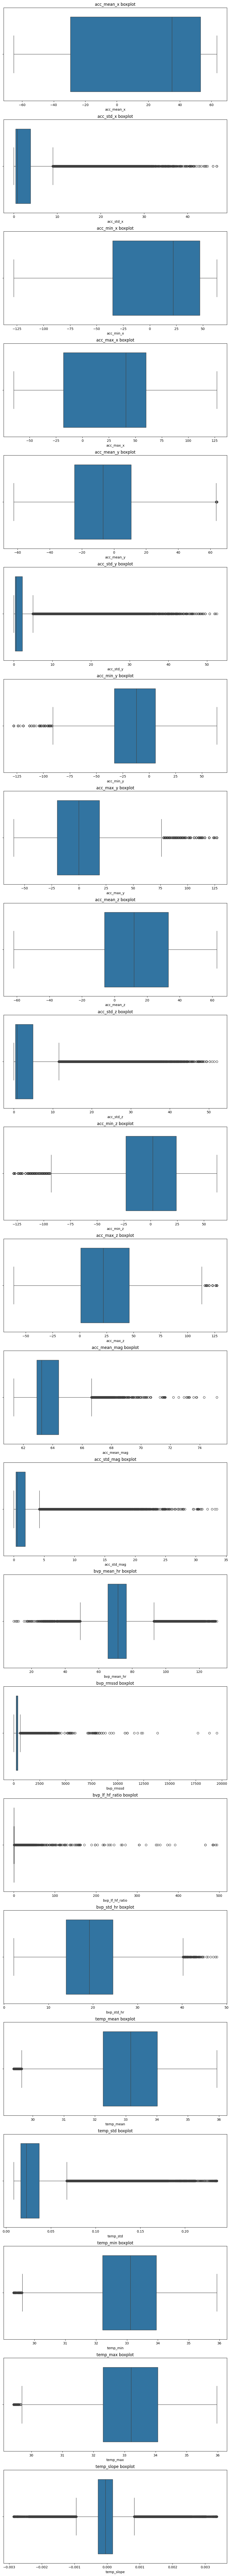

In [15]:
create_boxplot(df_final, ['timestamp', 'label', 'subject'])

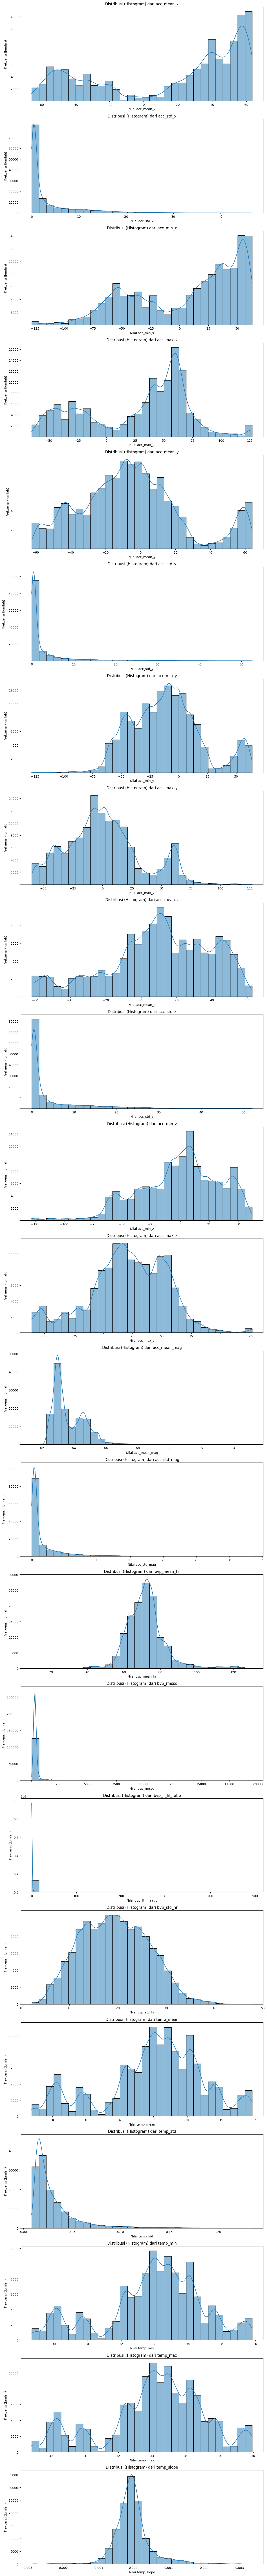

In [16]:
create_histplot(df_final, ['timestamp', 'label', 'subject'])

## Data Cleaning

Seperti yang diketahui dari tahap data assessing, semua data telah berada pada rentang yang valid, tidak ada baris dengan missing value, ataupun perbedaan tipe data dari yang seharusnya, maka sebenernya data yang kita miliki sudah terbilang bersih, namun kita masih bisa melakukan satu hal yaitu mengubah nama kolom menjadi lowercase agar menjadi lebih standar dan mudah dioperasikan.

In [17]:
# mengubah nama kolom ke lowercase
# df_final.columns = df_final.columns.str.lower()

In [18]:
# memastikan nama kolom telah diubah ke lowercase
# df_final.info()

Sebenernya kita masih bisa melakukan cleaning atau lebih tepatnya preprocessing, seperti scaling data menggunakan StandardScaler ataupun MinMaxScaler, namun hal ini lebih tepat dilakukan pada tahap pengembangan model machine learning.

## Exploratory Data Analysis

### Melihat distribusi label

In [19]:
# melihat distribusi label menggunakan angka
df_final['label'].value_counts()

label
1    70459
2    39864
3    22300
Name: count, dtype: int64

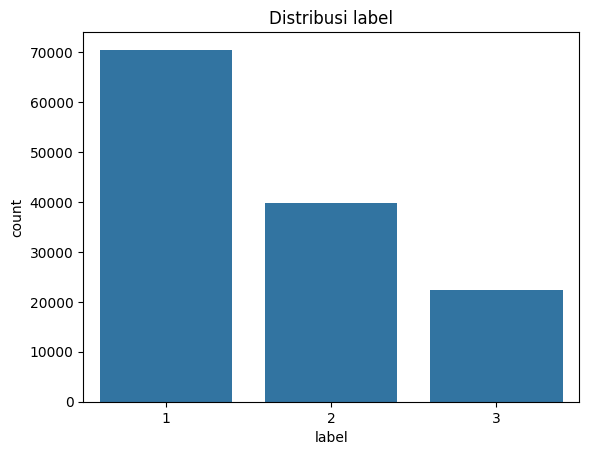

In [20]:
# membuat count plot untuk melihat distribusi label
sns.countplot(df_final,x=df_final['label'])
plt.title("Distribusi label")
plt.show()

**Insight**

Dari grafik di atas kita dapat melihat bahwa status 0 (not defined/transient) adalah yang paling banyak, diikuti dengan status 1 (baseline), 4 (meditation), 2 (stress), dan 3 (amusement), status 6 & 7 dapat dihiraukan.

### Melihat statistik dari sensor untuk setiap label

#### Status 1 (baseline)

In [21]:
df_final[df_final['label'] == 1].describe()

timestamp    acc_mean_x     acc_std_x     acc_min_x     acc_max_x  \
count  70459.000000  70459.000000  70459.000000  70459.000000  70459.000000   
mean     802.612402     14.403567      3.305481      6.071517     22.966860   
std      372.504259     41.448884      5.267259     43.282361     44.095618   
min       52.500000    -65.325000      0.000000   -128.000000    -65.000000   
25%      498.000000    -31.193750      0.417582    -34.000000    -23.000000   
50%      803.250000     32.693750      0.731010     21.000000     40.000000   
75%     1096.750000     49.000000      3.907475     43.000000     58.000000   
max     1852.500000     63.400000     41.458899     62.000000    127.000000   

         acc_mean_y     acc_std_y     acc_min_y     acc_max_y    acc_mean_z  \
count  70459.000000  70459.000000  70459.000000  70459.000000  70459.000000   
mean      -4.386114      2.491171     -9.607034      0.996338     12.548320   
std       26.481613      5.010782     27.707159     28.271838     33.343308   
min      -60.206250      0.000000   -128.000000    -60.000000    -61.887500   
25%      -23.409375      0.303881    -30.000000    -19.000000     -6.968750   
50%       -4.031250      0.510973     -8.000000      0.000000     20.700000   
75%       13.000000      2.192200      9.000000     18.000000     39.712500   
max       64.000000     52.556954     64.000000    127.000000     62.631250   

       ...     bvp_rmssd  bvp_lf_hf_ratio    bvp_std_hr     temp_mean  \
count  ...  70459.000000     70459.000000  70459.000000  70459.000000   
mean   ...    335.017128         0.858844     16.970855     33.348111   
std    ...    304.073358         4.746175      5.822119      1.586671   
min    ...     30.342625         0.004062      2.215192     29.386667   
25%    ...    220.082768         0.197750     12.777397     32.840917   
50%    ...    282.124447         0.331900     16.776913     33.585500   
75%    ...    352.028461         0.543546     20.626383     34.313667   
max    ...   4035.651190       271.542139     43.005125     35.930000   

           temp_std      temp_min      temp_max    temp_slope    label  \
count  70459.000000  70459.000000  70459.000000  70459.000000  70459.0   
mean       0.035049     33.282654     33.414760      0.000141      1.0   
std        0.032748      1.586071      1.589708      0.000607      0.0   
min        0.008557     29.330000     29.430000     -0.002860      1.0   
25%        0.015702     32.810000     32.910000     -0.000109      1.0   
50%        0.021766     33.530000     33.650000      0.000062      1.0   
75%        0.039407     34.230000     34.410000      0.000306      1.0   
max        0.235508     35.910000     35.970000      0.003355      1.0   

            subject  
count  70459.000000  
mean       9.364794  
std        4.702273  
min        2.000000  
25%        5.000000  
50%        9.000000  
75%       14.000000  
max       17.000000  

[8 rows x 26 columns]

#### Status 2 (stress)

In [22]:
df_final[df_final['label'] == 2].describe()

timestamp    acc_mean_x     acc_std_x     acc_min_x     acc_max_x  \
count  39864.000000  39864.000000  39864.000000  39864.000000  39864.000000   
mean    3122.276465     16.757642      4.509528      1.756221     32.254741   
std      684.364783     44.012274      5.799293     50.178368     48.483267   
min     1902.250000    -65.312500      0.000000   -128.000000    -63.000000   
25%     2476.000000    -30.062500      0.680848    -39.000000    -12.000000   
50%     3293.625000     38.100000      1.572419     16.000000     42.000000   
75%     3725.750000     56.256250      6.527188     45.000000     63.000000   
max     4278.250000     63.137500     36.865897     62.000000    127.000000   

         acc_mean_y     acc_std_y     acc_min_y     acc_max_y    acc_mean_z  \
count  39864.000000  39864.000000  39864.000000  39864.000000  39864.000000   
mean      -9.217985      3.855459    -18.390453      1.820113      2.894273   
std       33.698788      6.233818     34.847806     39.144031     21.258115   
min      -62.381250      0.000000   -128.000000    -59.000000    -60.950000   
25%      -29.720312      0.533854    -44.000000    -26.000000     -7.939063   
50%      -13.018750      1.038168    -24.000000     -5.000000      8.481250   
75%        2.168750      4.003104     -5.000000     25.000000     15.787500   
max       62.925000     44.861020     60.000000    127.000000     57.093750   

       ...     bvp_rmssd  bvp_lf_hf_ratio    bvp_std_hr     temp_mean  \
count  ...  39864.000000     39864.000000  39864.000000  39864.000000   
mean   ...    461.656218         1.153671     25.525326     32.640344   
std    ...    366.400222         5.731356      5.161281      1.010690   
min    ...     50.811821         0.011005      8.667411     29.994000   
25%    ...    334.858725         0.238773     22.715344     32.291125   
50%    ...    396.287089         0.365780     25.648540     32.782229   
75%    ...    478.136066         0.582554     28.813310     33.248958   
max    ...   4369.201887       162.395763     47.781787     34.540333   

           temp_std      temp_min      temp_max    temp_slope    label  \
count  39864.000000  39864.000000  39864.000000  39864.000000  39864.0   
mean       0.031292     32.579054     32.700488     -0.000270      2.0   
std        0.014703      1.002107      1.018737      0.000351      0.0   
min        0.008825     29.970000     30.030000     -0.001201      2.0   
25%        0.019846     32.230000     32.370000     -0.000489      2.0   
50%        0.028053     32.730000     32.830000     -0.000295      2.0   
75%        0.039060     33.160000     33.330000     -0.000101      2.0   
max        0.084540     34.450000     34.610000      0.001194      2.0   

            subject  
count  39864.000000  
mean       9.494381  
std        4.708103  
min        2.000000  
25%        5.000000  
50%        9.000000  
75%       14.000000  
max       17.000000  

[8 rows x 26 columns]

#### Status 3 (amusement)

In [23]:
df_final[df_final['label'] == 3].describe()

timestamp    acc_mean_x     acc_std_x     acc_min_x     acc_max_x  \
count  22300.000000  22300.000000  22300.000000  22300.000000  22300.000000   
mean    3252.098229     22.325877      1.730548     17.678700     26.975067   
std     1491.636869     41.277299      4.312082     43.708968     41.421140   
min     1580.750000    -60.637500      0.000000   -124.000000    -59.000000   
25%     1894.000000    -16.012500      0.173993    -19.000000     -9.000000   
50%     2151.125000     39.328125      0.444410     34.000000     47.000000   
75%     4572.812500     58.000000      0.886333     57.000000     61.000000   
max     5952.500000     63.393750     46.699021     63.000000    117.000000   

         acc_mean_y     acc_std_y     acc_min_y     acc_max_y    acc_mean_z  \
count  22300.000000  22300.000000  22300.000000  22300.000000  22300.000000   
mean       0.589099      1.630977     -2.975471      4.140673     17.111354   
std       29.242553      4.614083     31.031691     30.085565     24.554985   
min      -60.218750      0.000000   -100.000000    -59.000000    -36.687500   
25%      -16.068750      0.242061    -18.000000    -12.000000      0.000000   
50%       -1.000000      0.457575     -4.000000      1.000000     11.293750   
75%       10.068750      0.651800      9.000000     14.000000     38.406250   
max       62.568750     49.603623     62.000000    113.000000     62.768750   

       ...     bvp_rmssd  bvp_lf_hf_ratio    bvp_std_hr     temp_mean  \
count  ...  22300.000000     22300.000000  22300.000000  22300.000000   
mean   ...    362.966914         1.614919     15.958696     32.587348   
std    ...    647.755916        13.935930      5.980969      1.512782   
min    ...     21.765777         0.019179      2.751573     29.913417   
25%    ...    212.861508         0.221769     11.551129     31.187771   
50%    ...    269.236828         0.361640     15.836777     32.763750   
75%    ...    359.077231         0.612727     19.630566     34.055271   
max    ...  19517.029198       493.697882     45.459150     35.015500   

           temp_std      temp_min      temp_max    temp_slope    label  \
count  22300.000000  22300.000000  22300.000000  22300.000000  22300.0   
mean       0.022690     32.541399     32.632457     -0.000056      3.0   
std        0.013581      1.510393      1.517014      0.000308      0.0   
min        0.008718     29.870000     29.950000     -0.000961      3.0   
25%        0.015096     31.130000     31.230000     -0.000228      3.0   
50%        0.018778     32.730000     32.790000     -0.000085      3.0   
75%        0.024440     34.000000     34.110000      0.000056      3.0   
max        0.111494     34.990000     35.050000      0.001598      3.0   

            subject  
count  22300.000000  
mean       9.342601  
std        4.707920  
min        2.000000  
25%        5.000000  
50%        9.000000  
75%       14.000000  
max       17.000000  

[8 rows x 26 columns]

**Insight**

Status 0 (not defined/transient)
- ACC
    - x:
        - range: [-51.375, 94.000]
        - mean: 34.421
        - median: 36.250
    - y:
        - range: [-92.875, 61.750]
        - mean: -1.378
        - median: 3.750
    - z:
        - range: [-71.750, 86.625]
        - mean: 28.076
        - median: 28.375
- BVP
    - range: [-631.375, 533.926]
    - mean: -0.004
    - median: 1.795
- Temp
    - range: [32.310, 35.870]
    - mean: 34.199
    - median: 34.210

Status 1 (baseline)
- ACC
    - x:
        - range: [-26.500, 90.000]
        - mean: 48.897
        - median: 20.000
    - y:
        - range: [-95.125, 52/750]
        - mean: 18.493
        - median: 19.750
    - z:
        - range: [-55.500, 66.7500]
        - mean: 6.488
        - median: 19.750
- BVP
    - range: [-541.275, 427.279]
    - mean: 0.007
    - median: 1.843
- Temp
    - range: [35.500, 35.970]
    - mean: 35.786
    - median: 35.810

Status 2 (stress)
- ACC
    - x:
        - range: [8.500, 60.375]
        - mean: 17.062
        - median: 15.875
    - y:
        - range: [-82.625, -17.625]
        - mean: -58.549
        - median: -59.000
    - z:
        - range: [-16.250, 29.125]
        - mean: 13.665
        - median: 14.000
- BVP
    - range: [-504.448, 358.394]
    - mean: 0.048
    - median: 0.835
- Temp
    - range: [32.570, 34.110]
    - mean: 33.442
    - median: 33.500

Status 3 (amusement)
- ACC
    - x:
        - range: [-2.500, 79.375]
        - mean: 51.137
        - median: 60.000
    - y:
        - range: [-1.375, 60.750]
        - mean: 16.603
        - median: 0
    - z:
        - range: [-30.625, 32.125]
        - mean: 7.925
        - median: -10.562
- BVP
    - range: [-362.291, 250.553]
    - mean: 0.001
    - median: 1.577
- Temp
    - range: [34.000, 34.470]
    - mean: 34.191
    - median: 34.160

Status 4 (meditation)
- ACC
    - x:
        - range: [55.500, 63.000]
        - mean: 59.475
        - median: 61.875
    - y:
        - range: [=1.000, 23.125]
        - mean: 11.279
        - median: 1.000
    - z:
        - range: [8.250, 20.000]
        - mean: 14.225
        - median: 12.000
- BVP
    - range: [-401.242, 355.120]
    - mean: -0.018
    - median: 2.318
- Temp
    - range: [33.590, 34.770]
    - mean: 34.085
    - median: 34.070